Il seguente è il codice finale che è stato utilizzato per la stesura della mia tesi. Questa è la versione adottata per i dati generati con il termostato di Langevin ed è equivalente a quella utilizzata per i dati Nose-Hoover a meno di sostituire il nome del file desiderato nel momento in cui si importano le configurazioni molecolari.

In [1]:
import torch
from torch import nn
import numpy as np
import mdshare 
import mdtraj as md 
import glob
import torch.nn.functional as F
from ase import Atoms
from nglview import show_ase
import nglview as ng
import matplotlib.pyplot as plt


In [2]:
# build dataset and dataloader 
k = 10000 #numero frame
batch = 40 #numero di frame per batch

#Import dei dati
data = np.load('LANGEVIN/N_70.npy')
data_F = np.load('LANGEVIN/N_70_F.npy')

#Divisione dei dati per il training e per il test, organizzati in batch contenenti 40 frames
train_xyz = torch.Tensor(data[:k])
train_f   = torch.Tensor(data_F[:k]).reshape(int(k/batch), batch, 70, 3)

test_xyz  = torch.Tensor(data[k:])
test_f    = torch.Tensor(data_F[k:])


trainset = torch.utils.data.TensorDataset(train_xyz)
#testset  = torch.utils.data.TensorDataset(test_xyz)

#trainset_f = torch.utils.data.TensorDataset(train_f)
#testset_f  = torch.utils.data.TensorDataset(test_f)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch, shuffle=True)
#testloader  = torch.utils.data.DataLoader(testset,  batch_size=25, shuffle=True)

#trainloader_f = torch.utils.data.DataLoader(trainset_f, batch_size=40, shuffle=True)
#testloader_f  = torch.utils.data.DataLoader(testset_f,  batch_size=25, shuffle=True)

In [3]:
class cgae(nn.Module):
    
    # La rete ha come argomenti il numero di atomi nella molecola ed il numero di siti CG
    def __init__(self, n_atoms, n_cgs): 
        super().__init__()

        # Viene definita ed inizializzata la mappa di assegnazione con valori casuali
        assign_map = torch.randn(n_atoms, n_cgs) 
        # Viene definita la matrice del decoder
        decode = torch.randn(n_cgs, n_atoms)     
        
        
        self.n_atoms = n_atoms 
        # La matrice della mappa di assegnazione viene aggiunta ai parametri
        # della rete da ottimizzare, così come quella del decoder
        self.assign_map = nn.Parameter(assign_map)  
        self.decode = nn.Parameter(decode)    
        
    # L'input della rete sono le coordinate spaziali atomistiche e la temperatura della Gumbel
    def forward(self, xyz, tau=1.0):     
        
        # Viene eseguito una traslazione delle coordinate per centrarle rispetto l'origine
        xyz = xyz.reshape(-1, self.n_atoms, 3)
        shift = xyz.mean(1)
        xyz = xyz - shift.unsqueeze(1)
        
        # Viene calcolata la riparametrizzazione della matrice dell'encoder
        M = F.gumbel_softmax(self.assign_map, dim=-1)
        M_norm = M / M.sum(-2).unsqueeze(-2)
        
        # Vengono calcolate le coordinate dei siti CG come il prodotto scalare 
        # tra le coordinate atomistiche e la matrice di assegnazione
        cg_xyz = torch.einsum('bij,in->bnj', xyz, M_norm)
        
        # Vengono ricostruite le coordinate atomistiche moltiplicando quelle dei siti CG 
        # con la matrice del decoder
        xyz_recon = torch.einsum('bnj,ni->bij', cg_xyz, self.decode)
        
        return xyz, xyz_recon, M, M_norm, cg_xyz

Per utilizzare la seguente cella e salvare i dati prodotti dal training della rete è necessario che nella cartella in cui è presente questo notebook sia presente una cartella "LANGEVIN".
Dentro "LANGEVEN" devono essere presenti le seguenti cartelle:
<li>Images<il>
<li>Losses<il>
<li>M (Verranno salvati qui i valori numerici della matrice dell'Encoder)<li> 
<li>Models (Verranno salvati qui i modelli addestrati del'AE)<li>
<li>xyz_CG<li>
<li>xyz_recon<il>

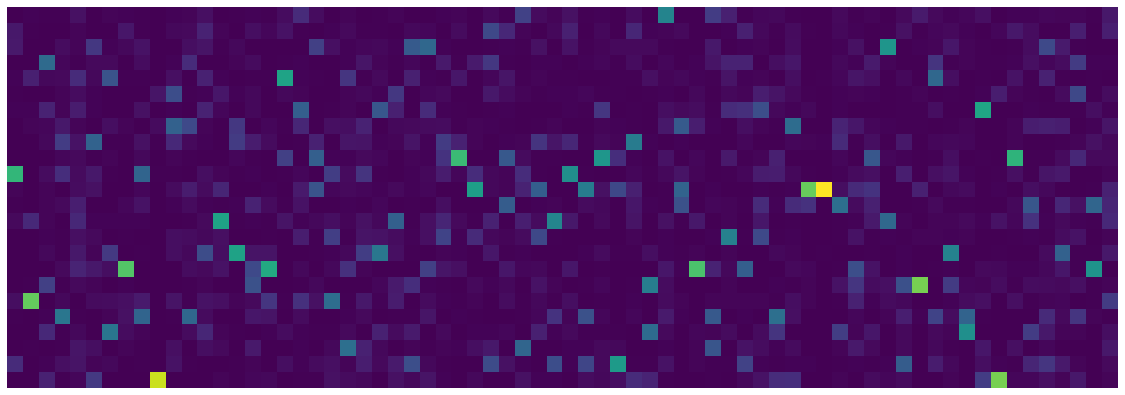

24 0 0.999 86.4893314242363


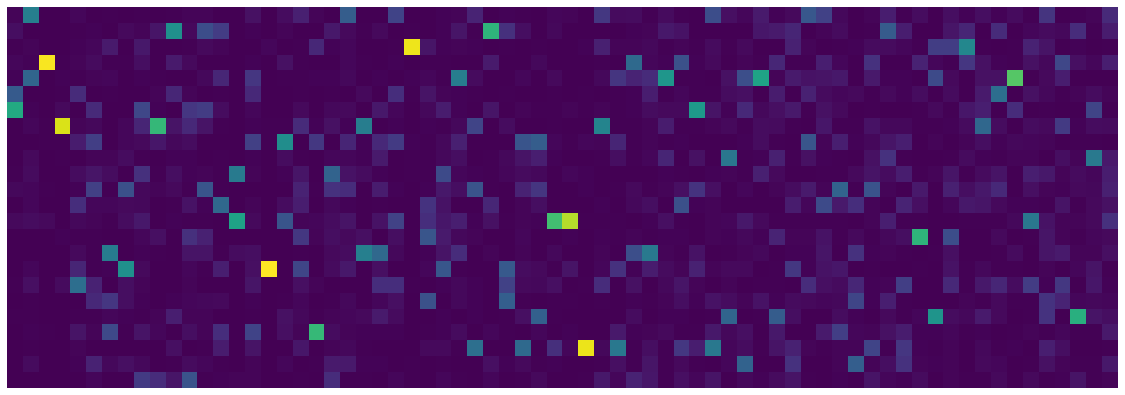

24 1 0.998 48.369456911087035


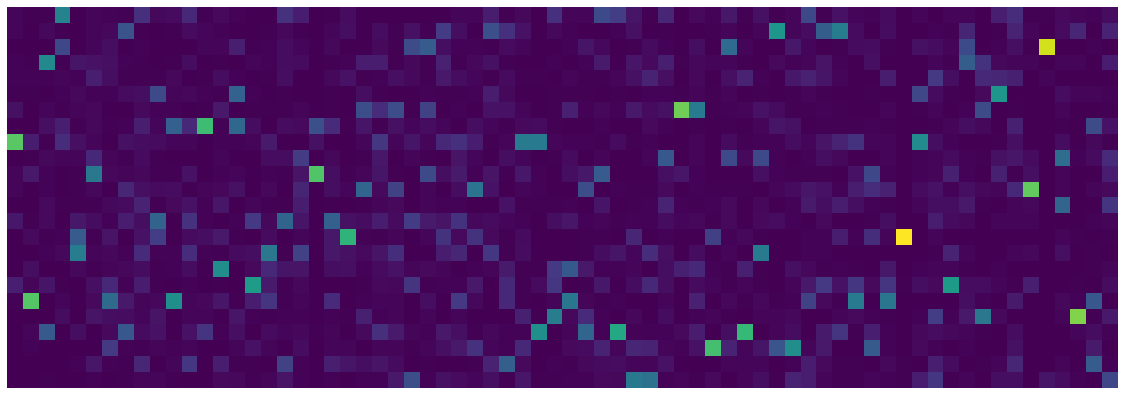

24 2 0.997 27.218792098760606


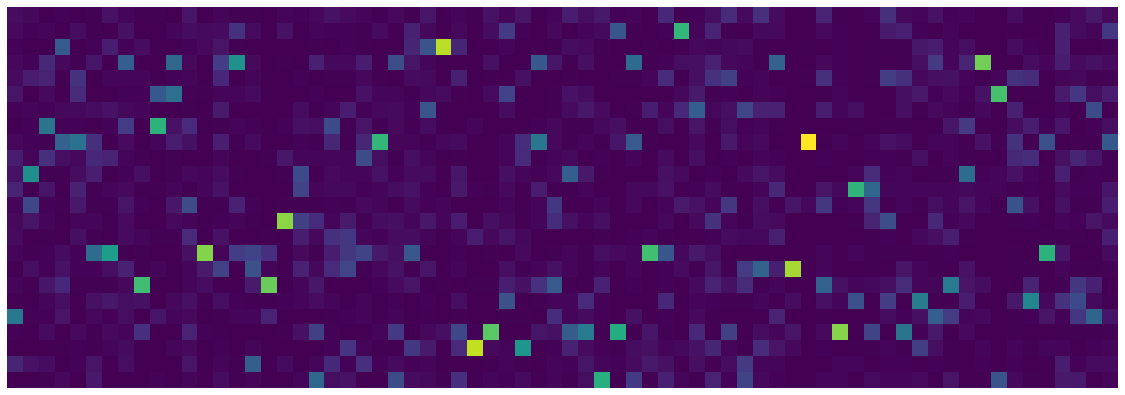

24 3 0.996 18.18890390098095


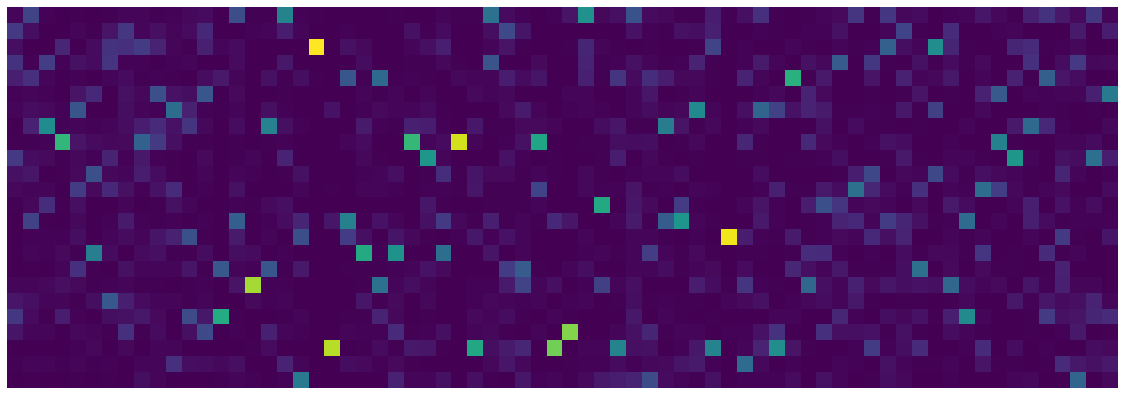

24 4 0.995 13.14296002984047


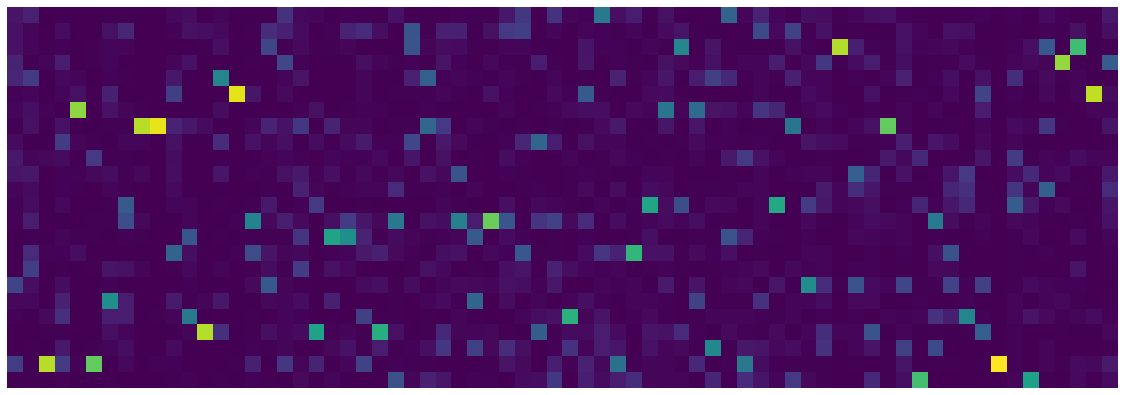

24 5 0.994 10.55113751590252


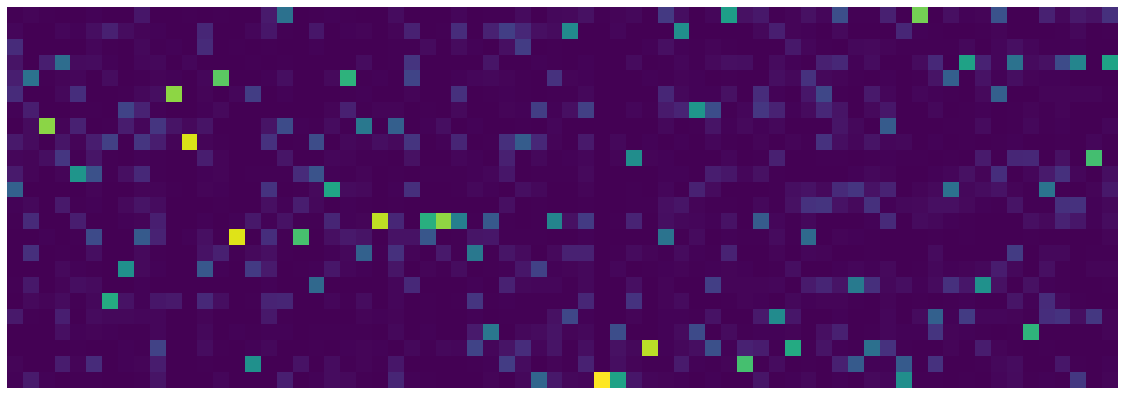

24 6 0.993 8.81920010149479


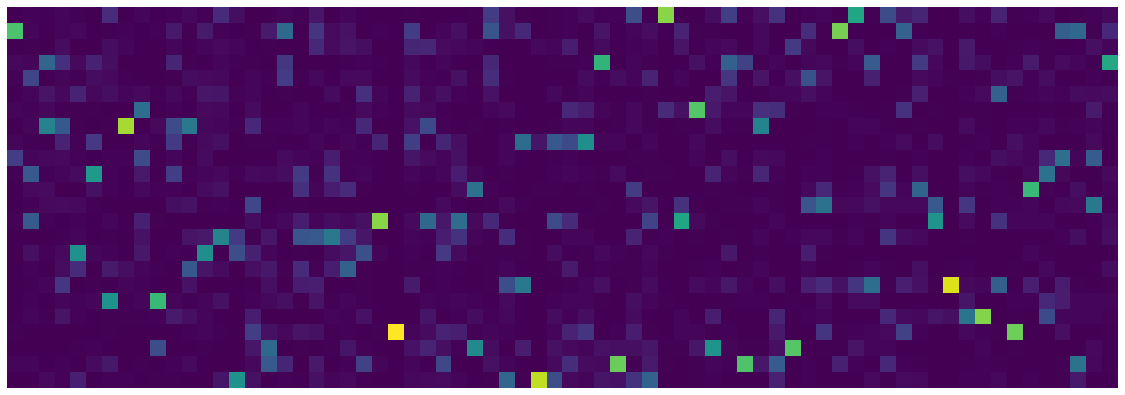

24 7 0.992 7.469938385486603


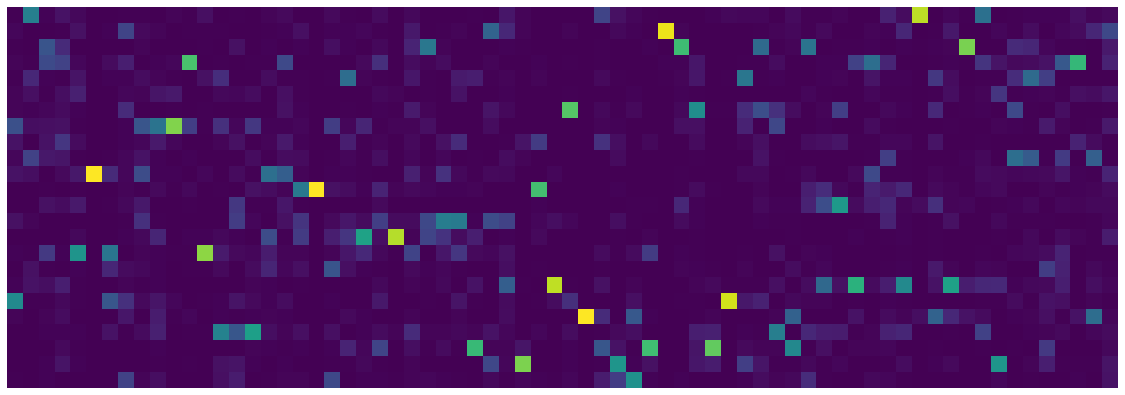

24 8 0.991 6.7614175349473955


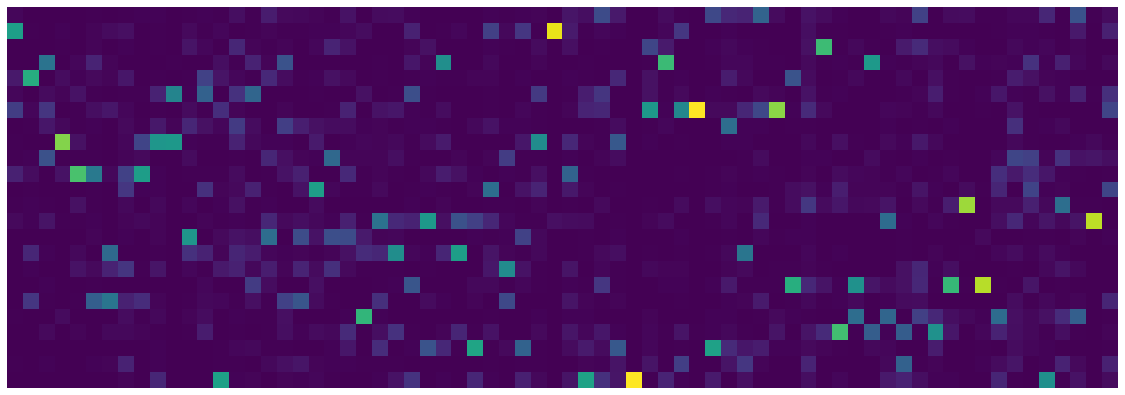

24 9 0.99 5.9962038695812225


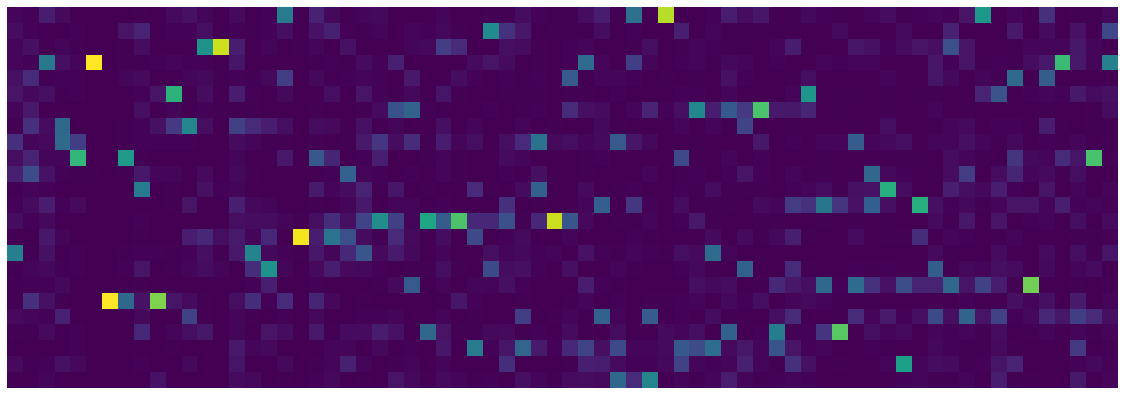

24 10 0.989 5.513977728784084


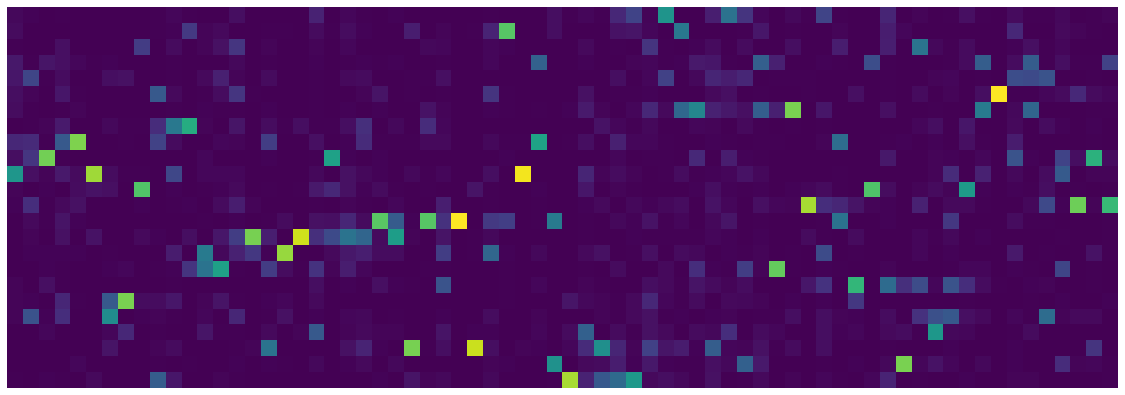

24 11 0.988 5.010674706101417


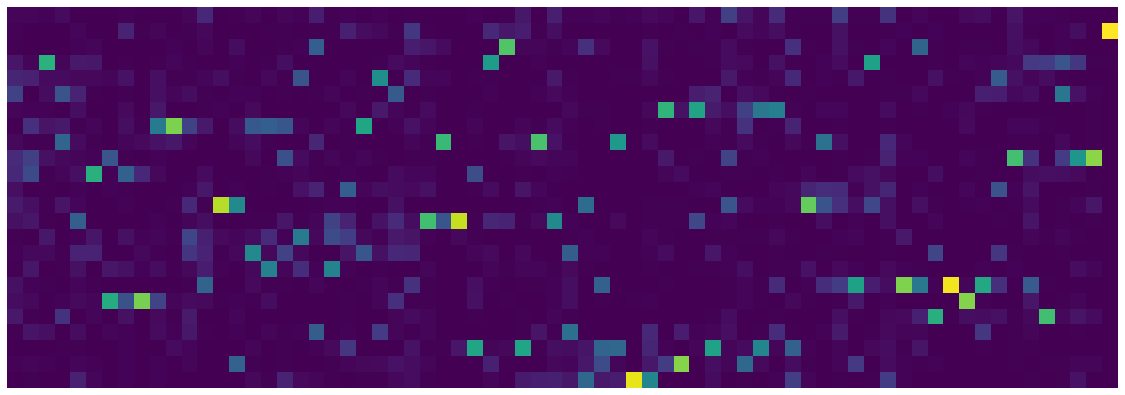

24 12 0.987 4.470737187564373


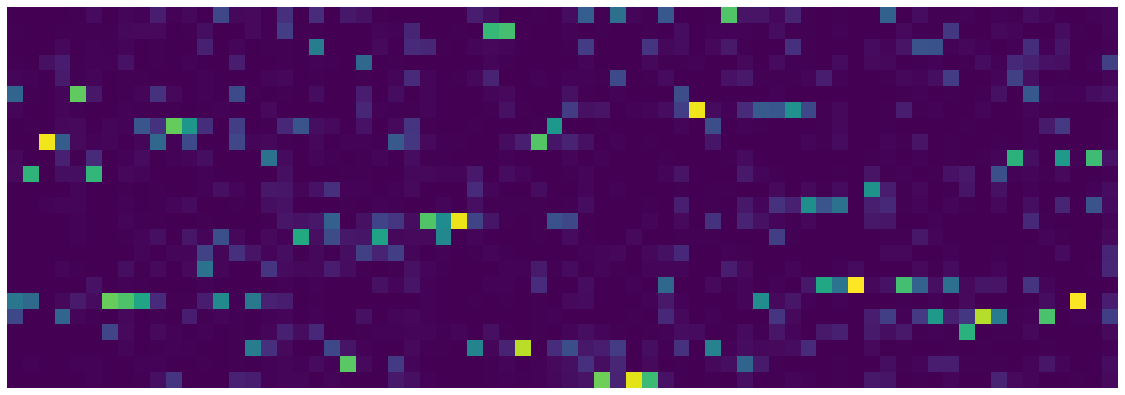

24 13 0.986 4.093275422602892


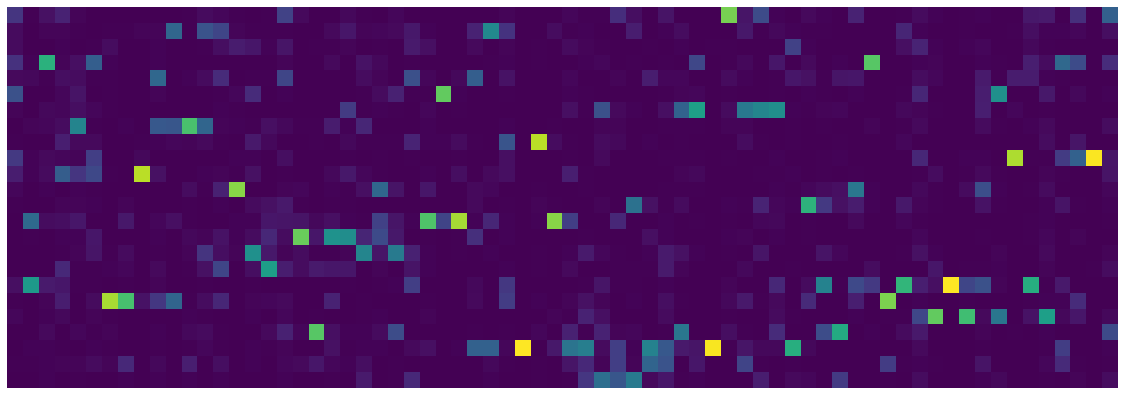

24 14 0.985 3.69384304061532


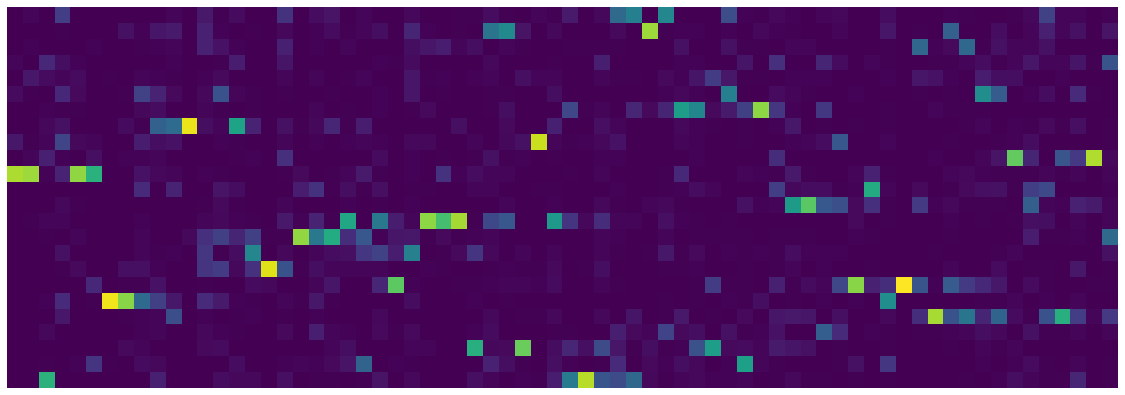

24 15 0.984 3.2925787538290026


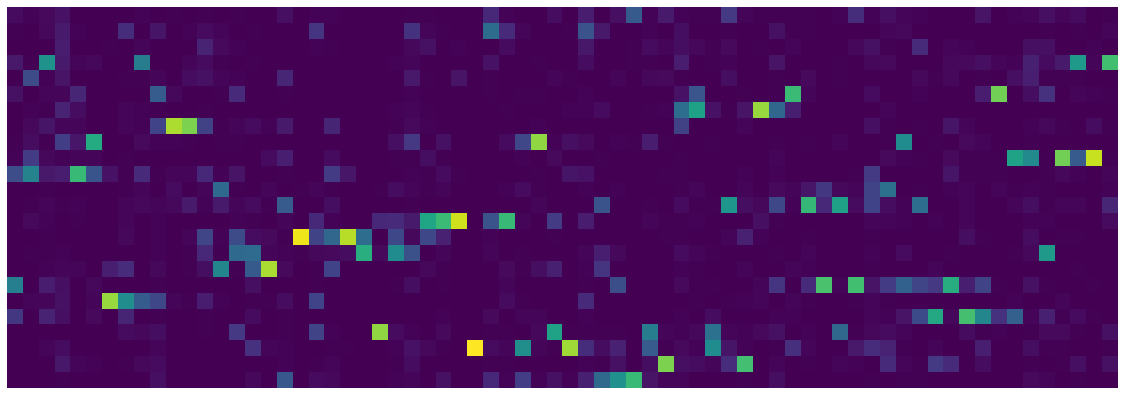

24 16 0.983 3.0531585693359373


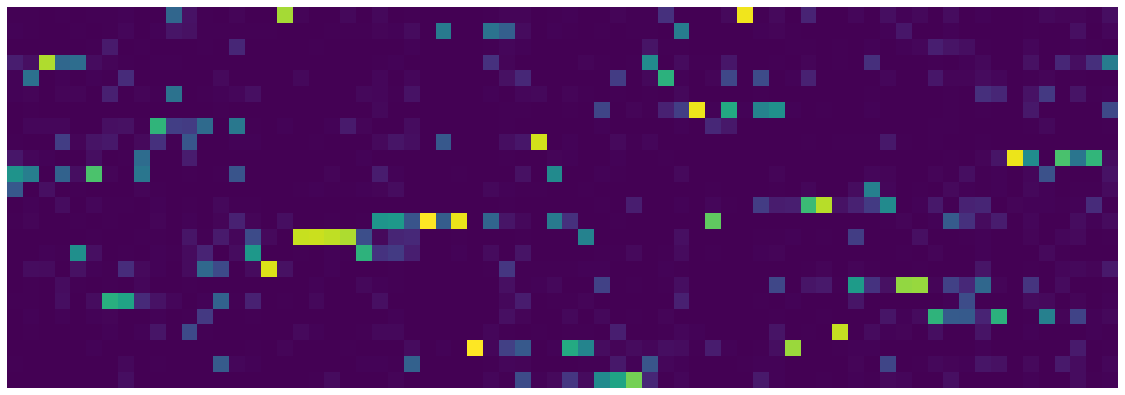

24 17 0.982 2.7756916396319866


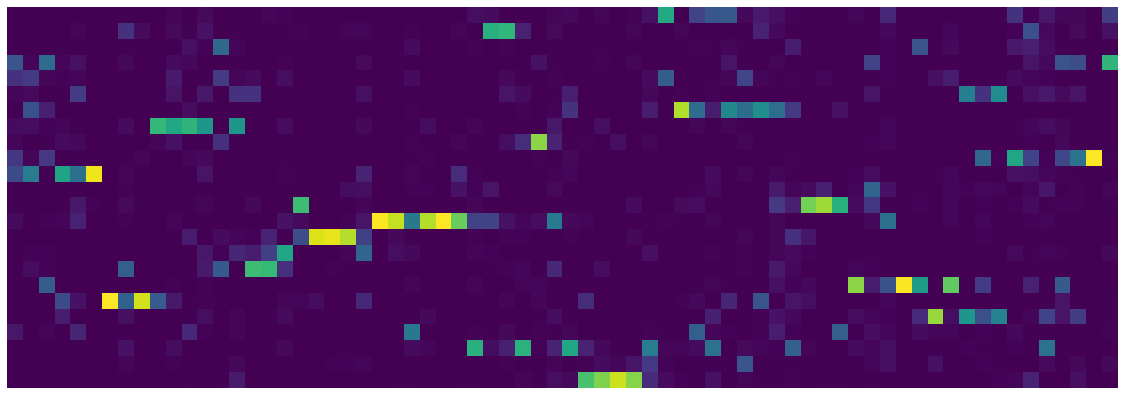

24 18 0.981 2.4882461354136467


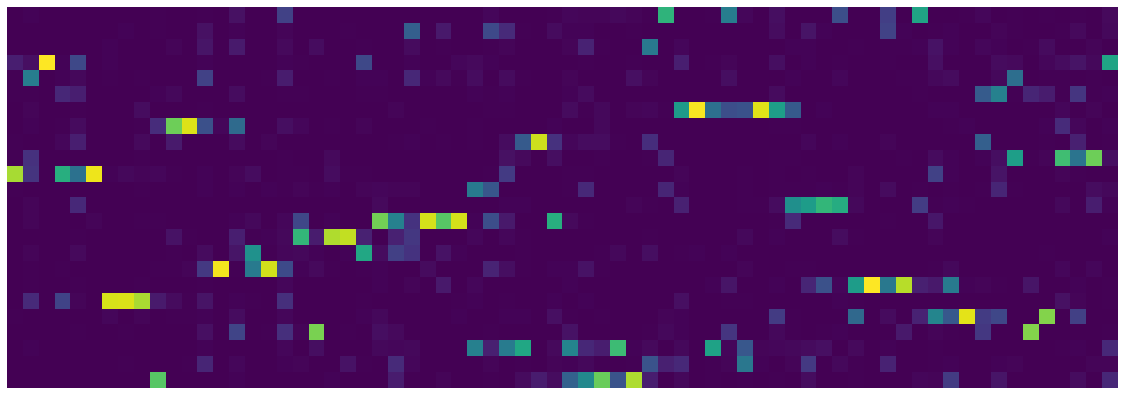

24 19 0.98 2.249670088291168


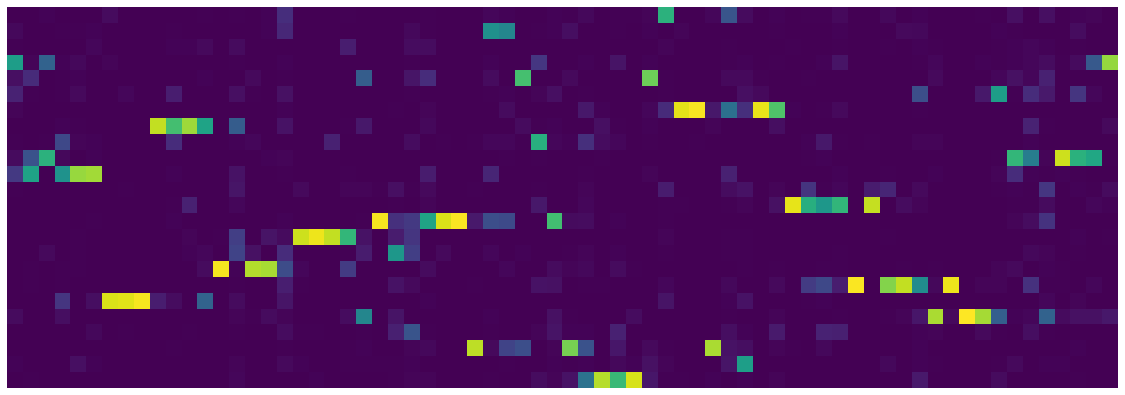

24 20 0.979 2.0988305062055588


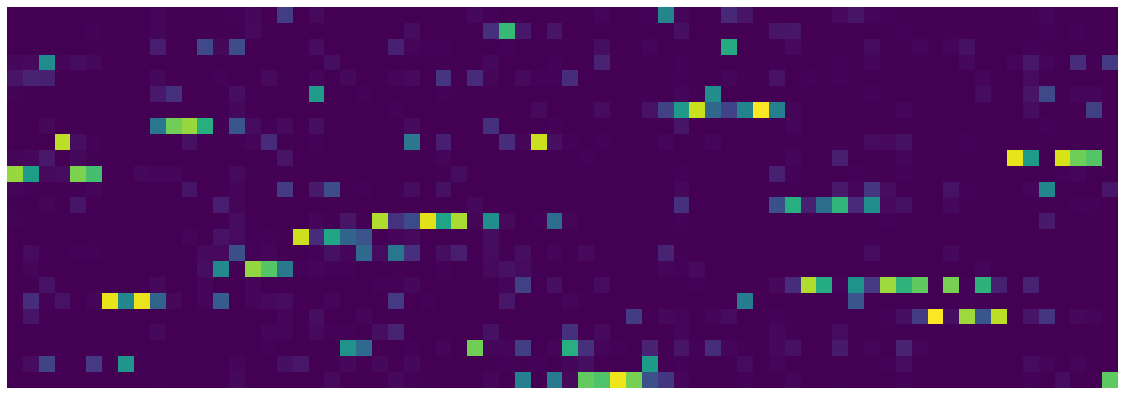

24 21 0.978 1.9647832848131657


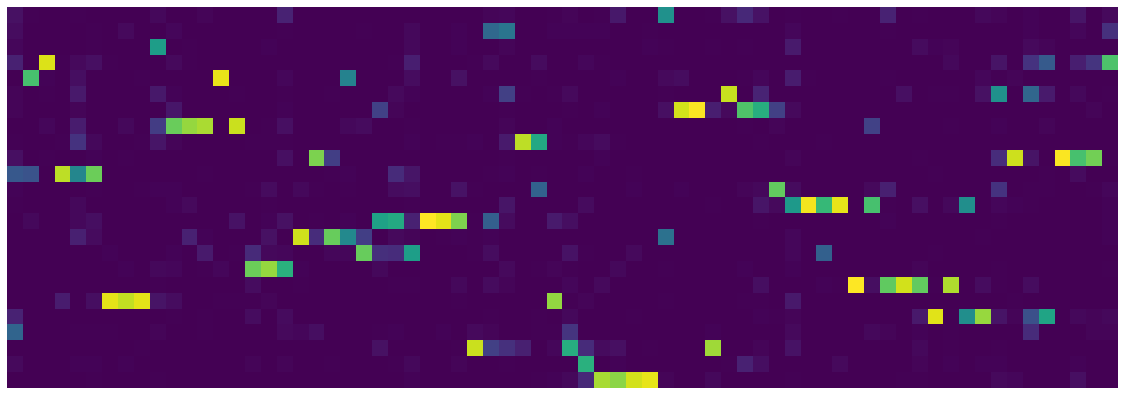

24 22 0.977 1.8217322994023561


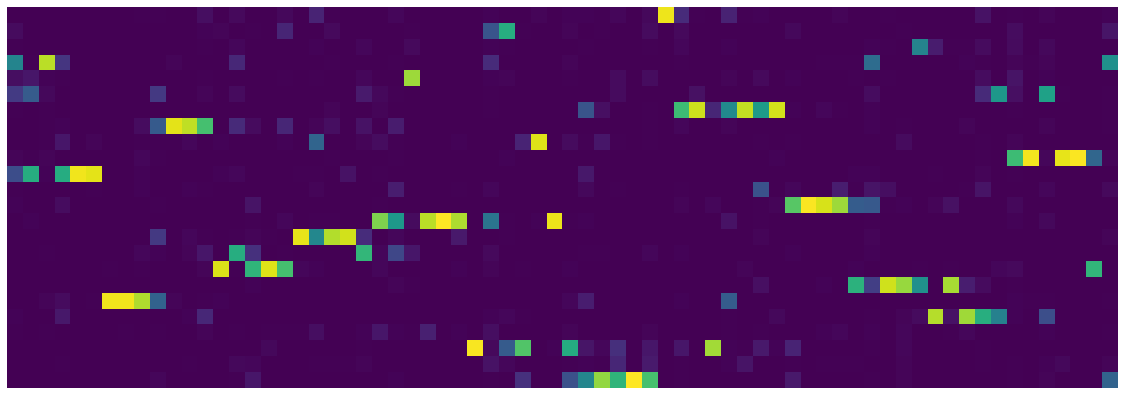

24 23 0.976 1.6663134668022395


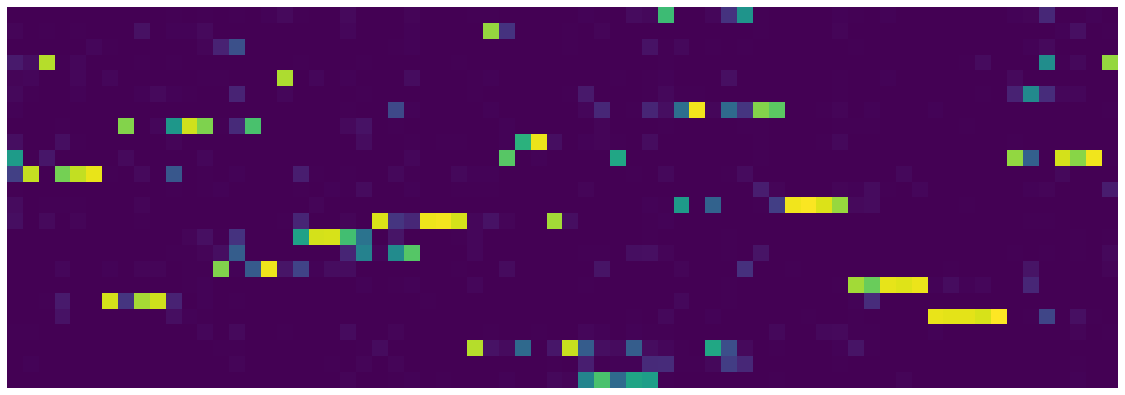

24 24 0.975 1.5739598203450442


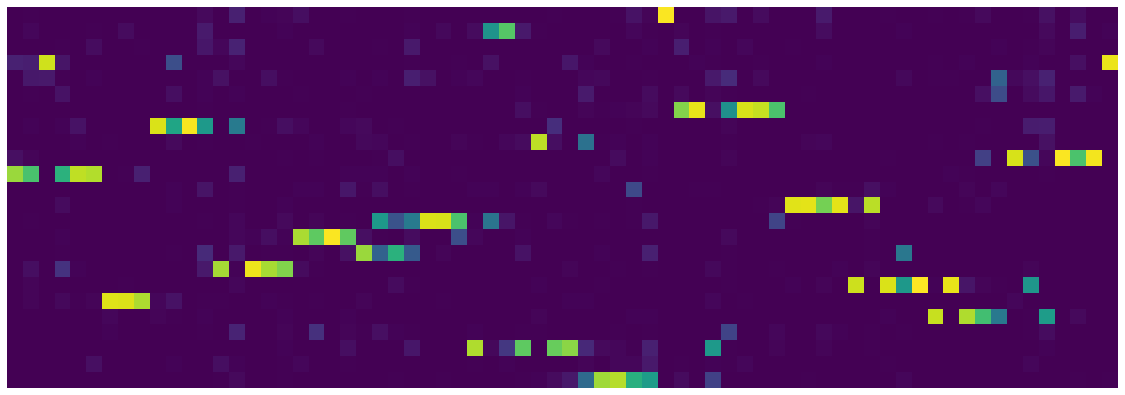

24 25 0.974 1.4610874556005


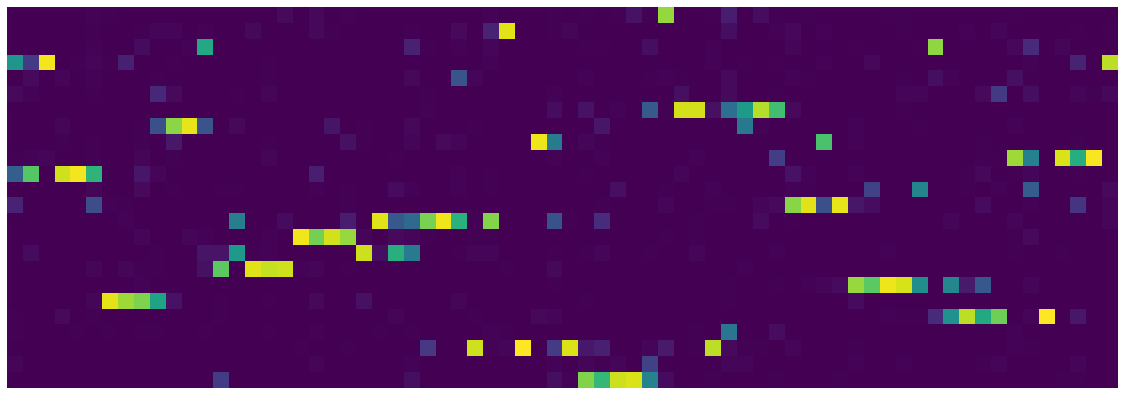

24 26 0.973 1.3965763673186302


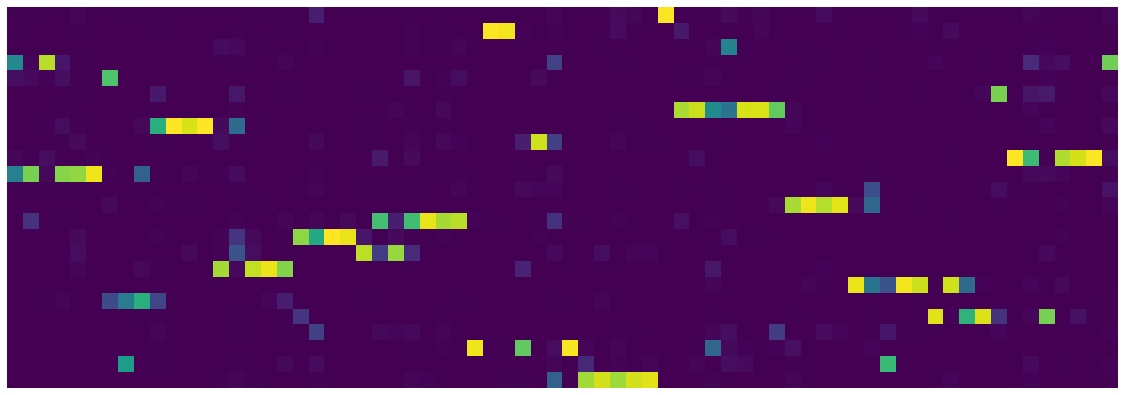

24 27 0.972 1.2987140387296676


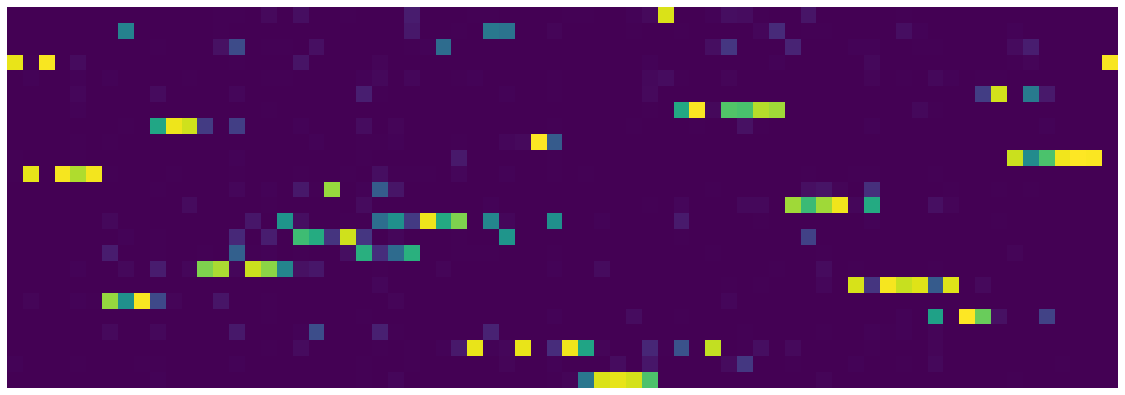

24 28 0.971 1.2132032971829176


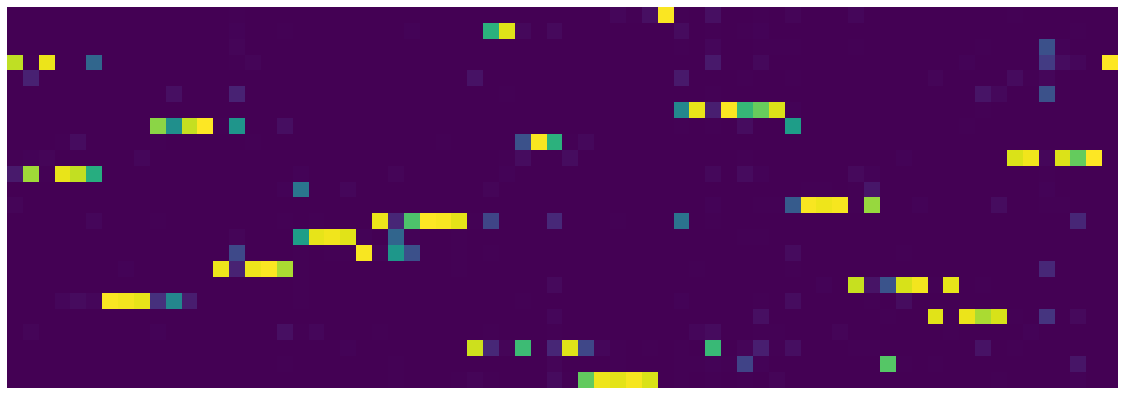

24 29 0.97 1.1408709943294526


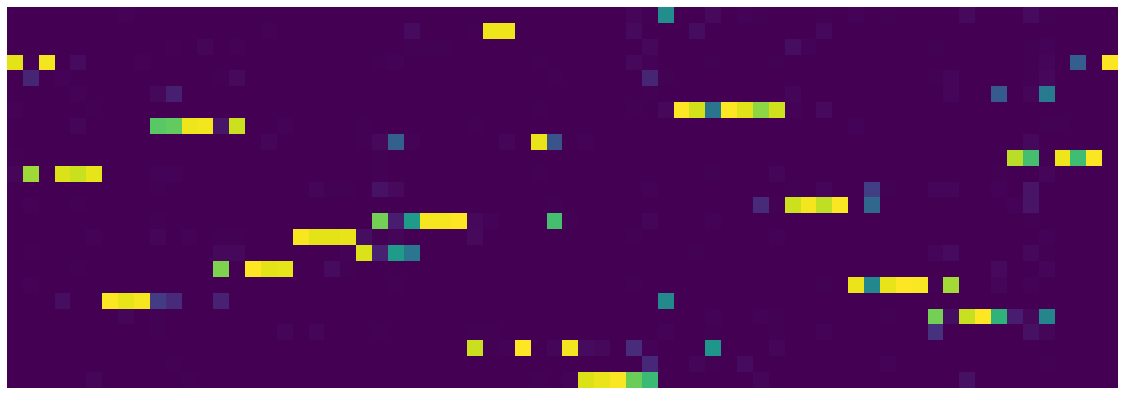

24 30 0.969 1.1462352953851223


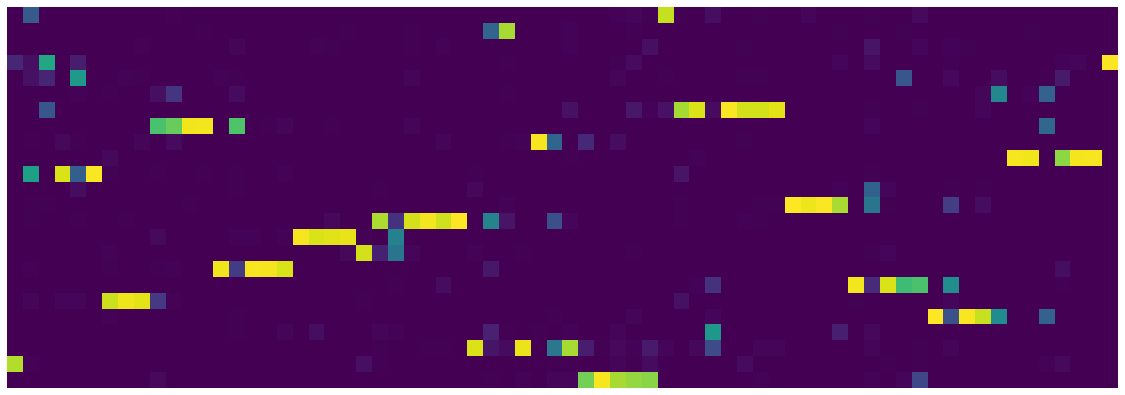

24 31 0.968 1.0558536648750305


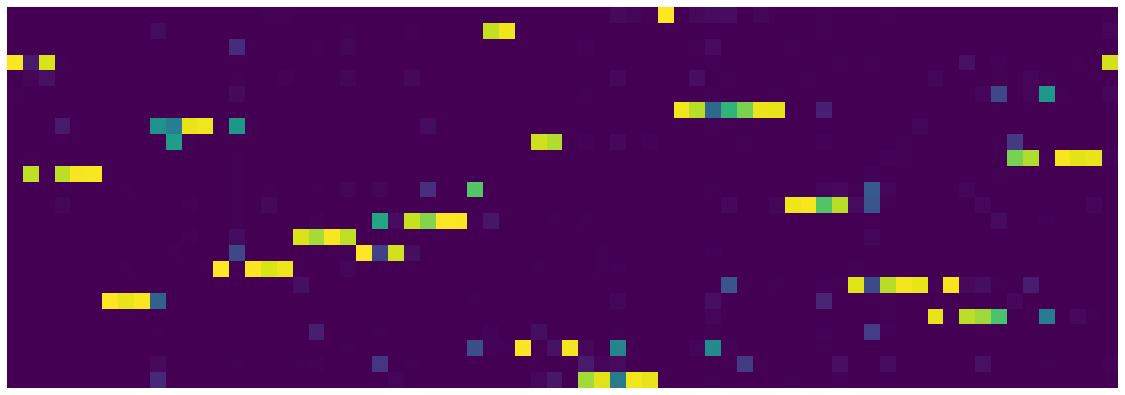

24 32 0.967 1.0032770257443189


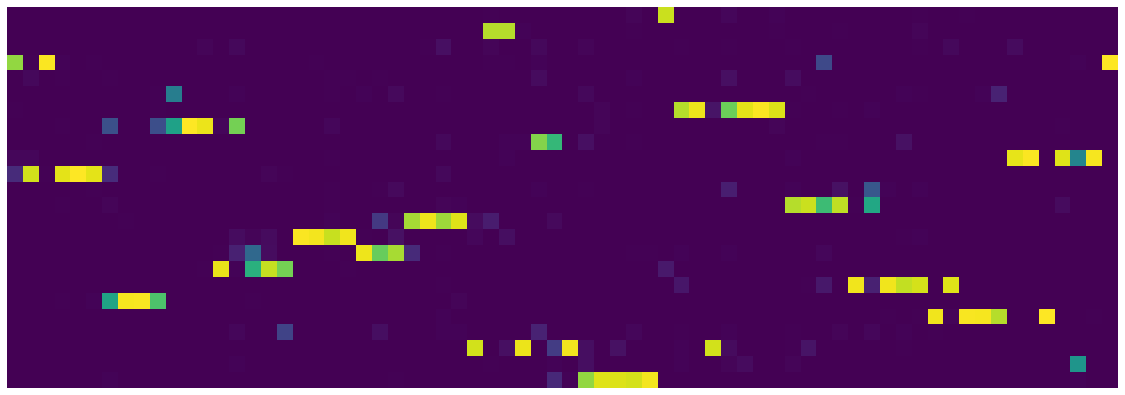

24 33 0.966 0.9700605724006891


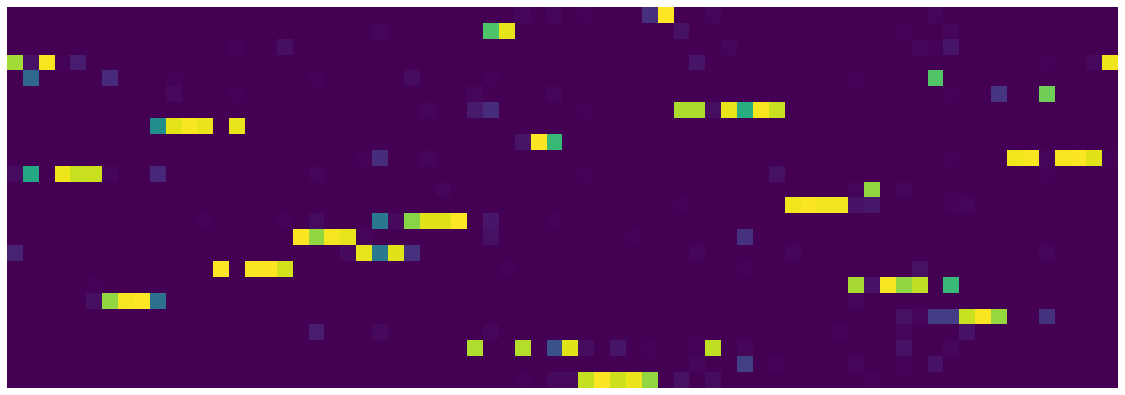

24 34 0.965 0.9456539994105697


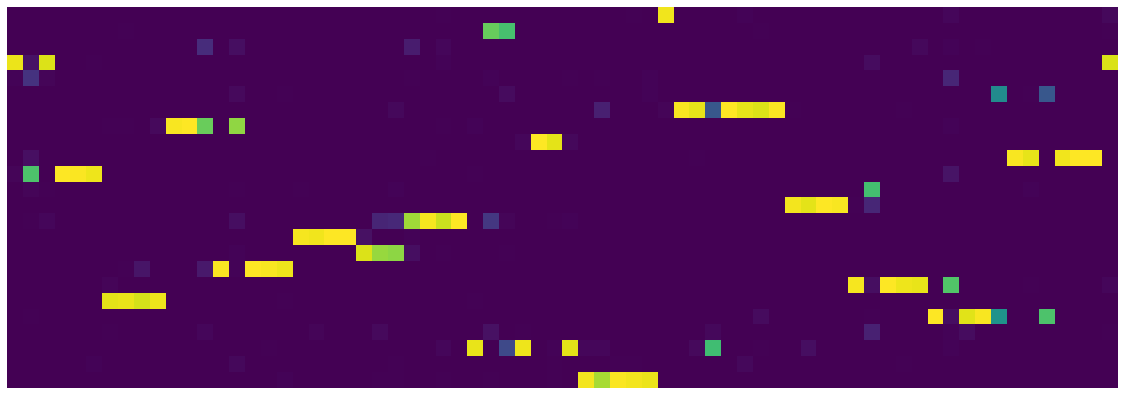

24 35 0.964 0.9211101384833456


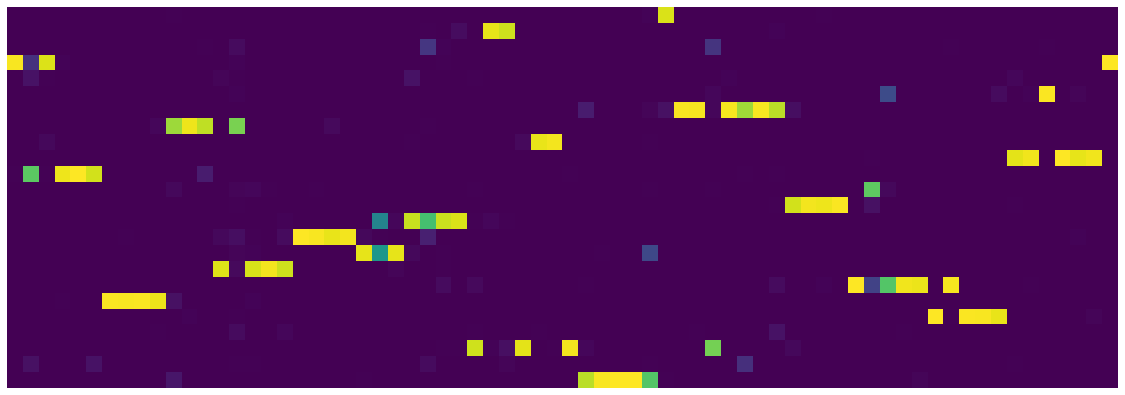

24 36 0.963 0.8789703080430626


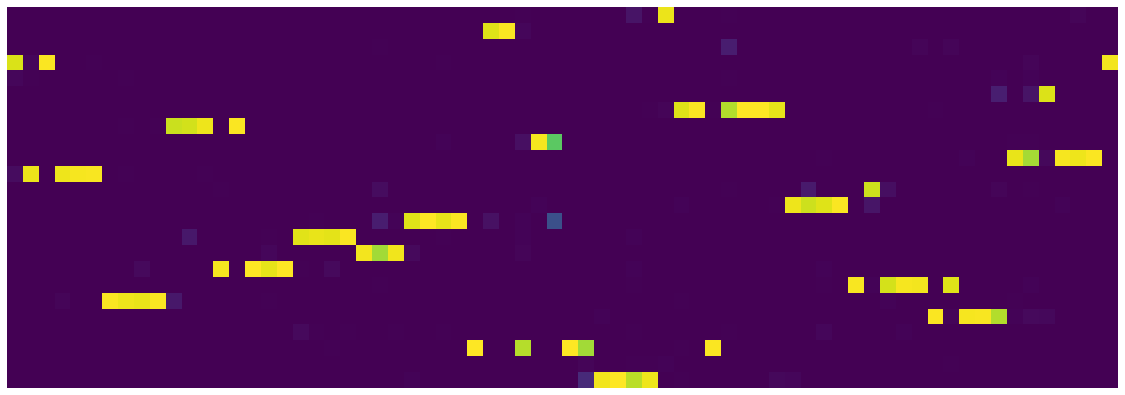

24 37 0.962 0.8711308401077986


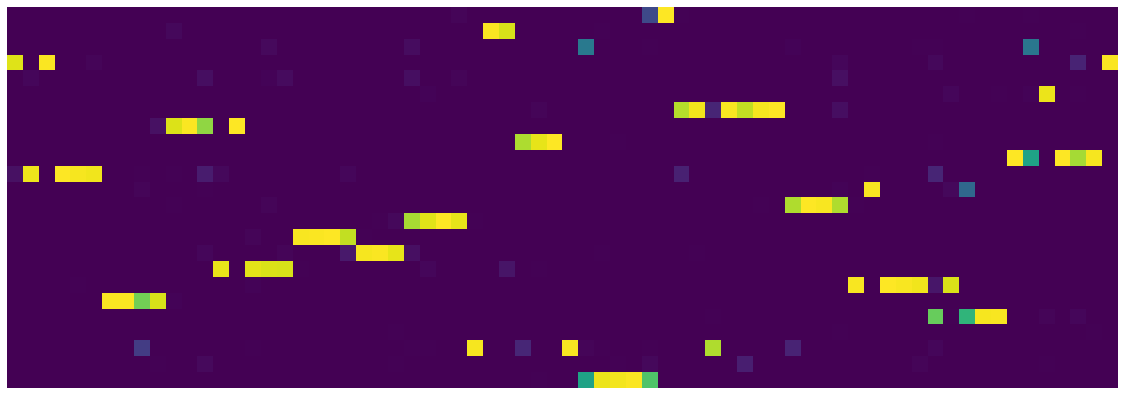

24 38 0.961 0.8328491643071174


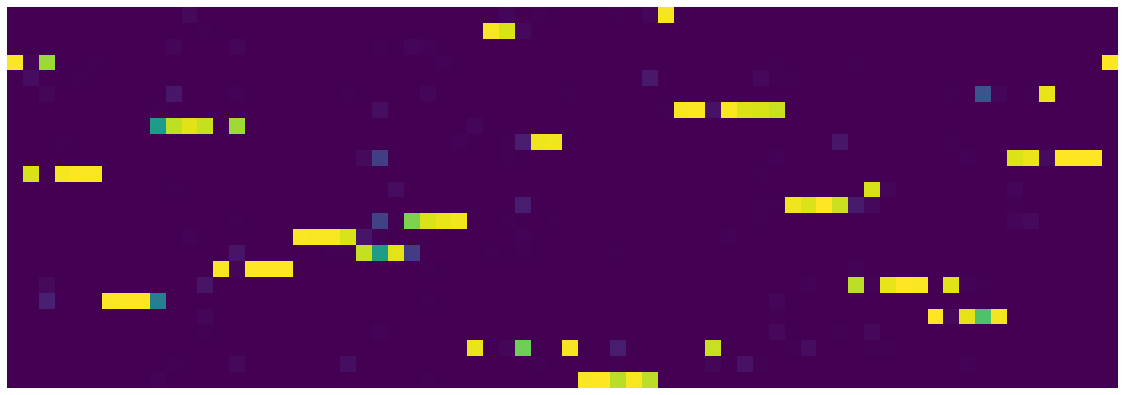

24 39 0.96 0.8237077094614506


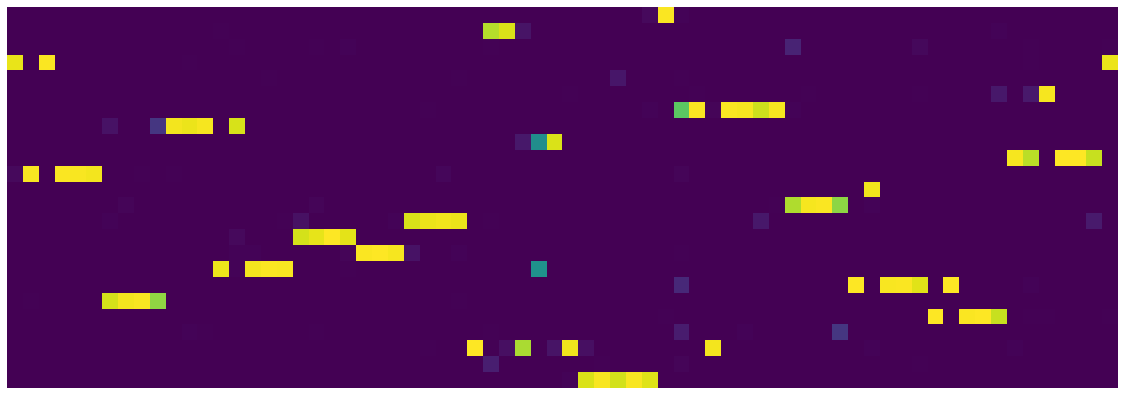

24 40 0.959 0.8001662651076913


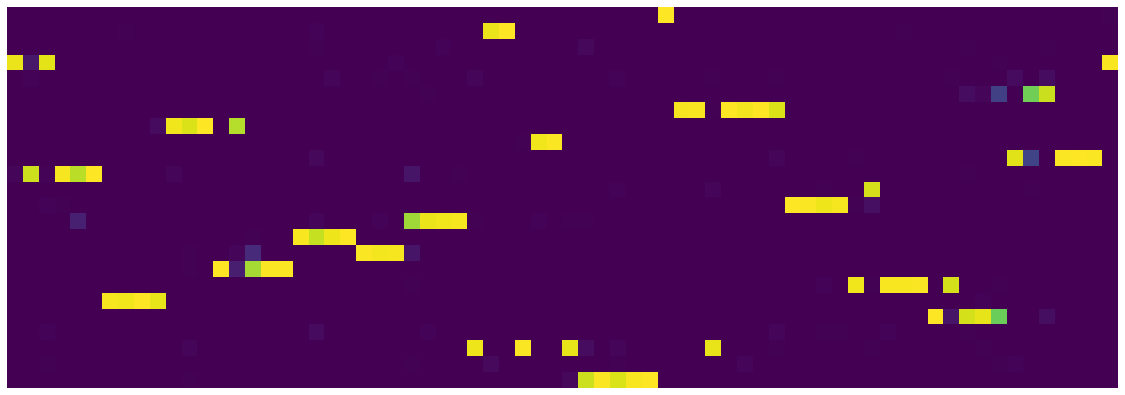

24 41 0.958 0.791341956332326


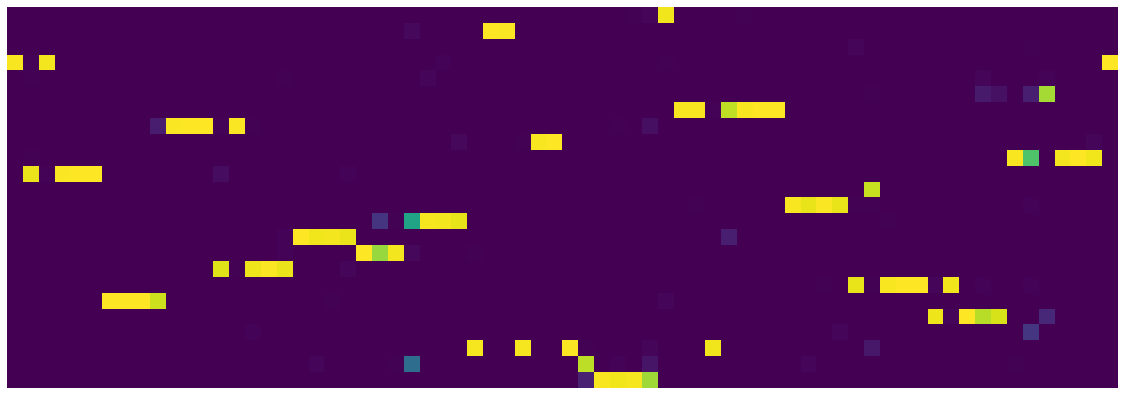

24 42 0.957 0.7735612599179149


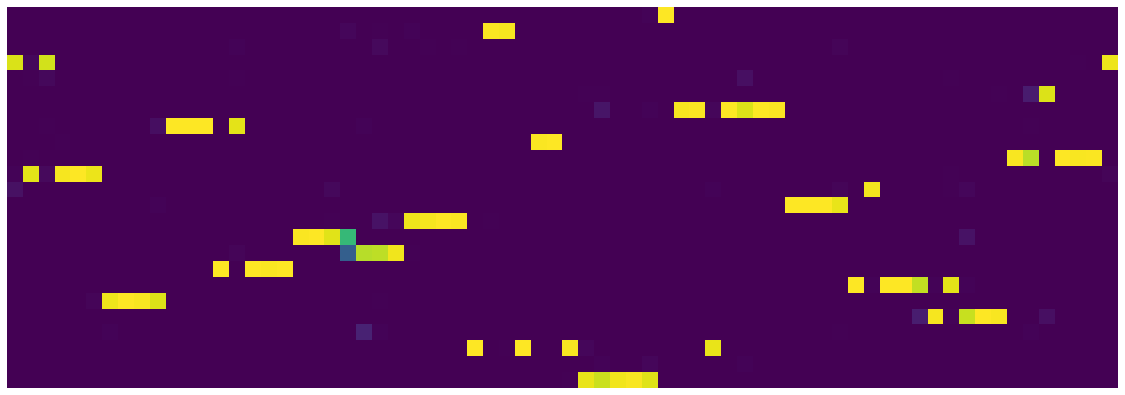

24 43 0.956 0.7560676433146


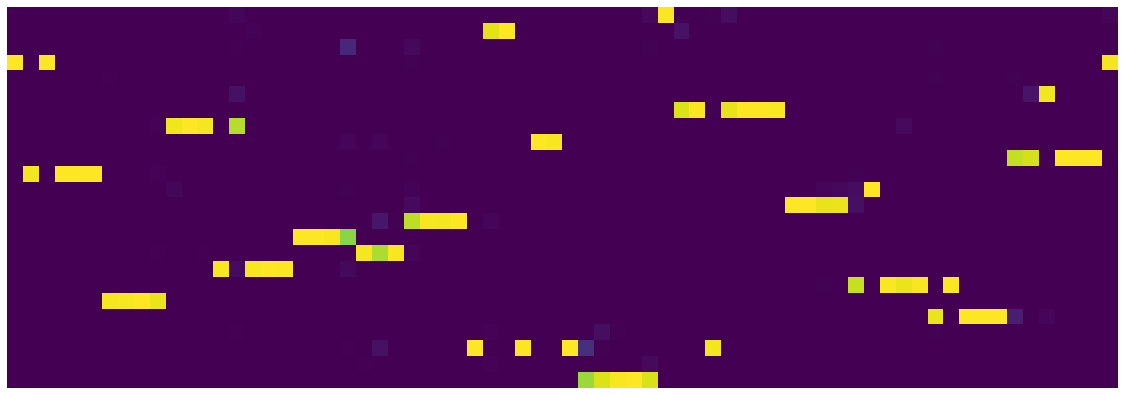

24 44 0.955 0.7401588937267661


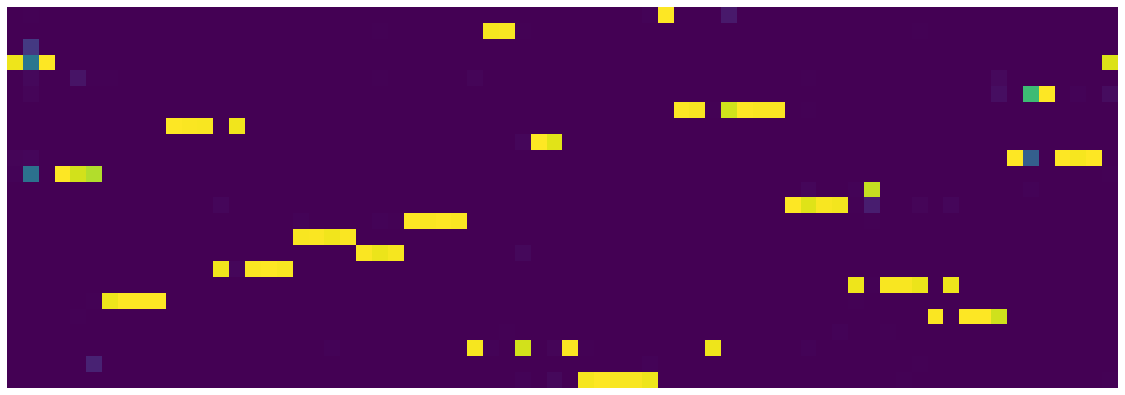

24 45 0.954 0.744740778952837


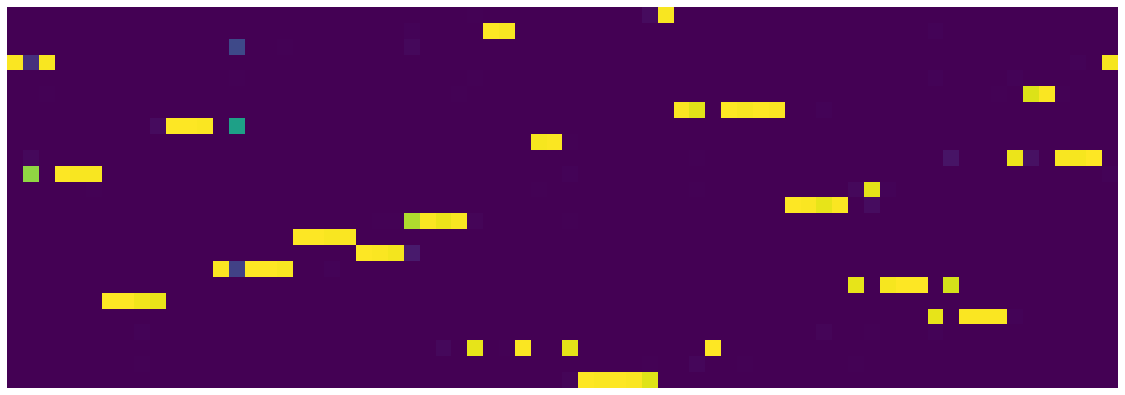

24 46 0.953 0.7305764203891159


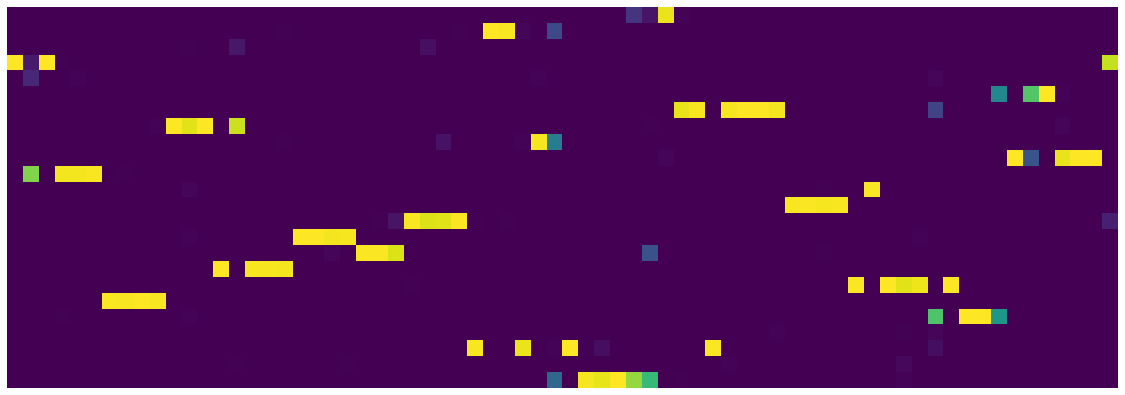

24 47 0.952 0.7147093862295151


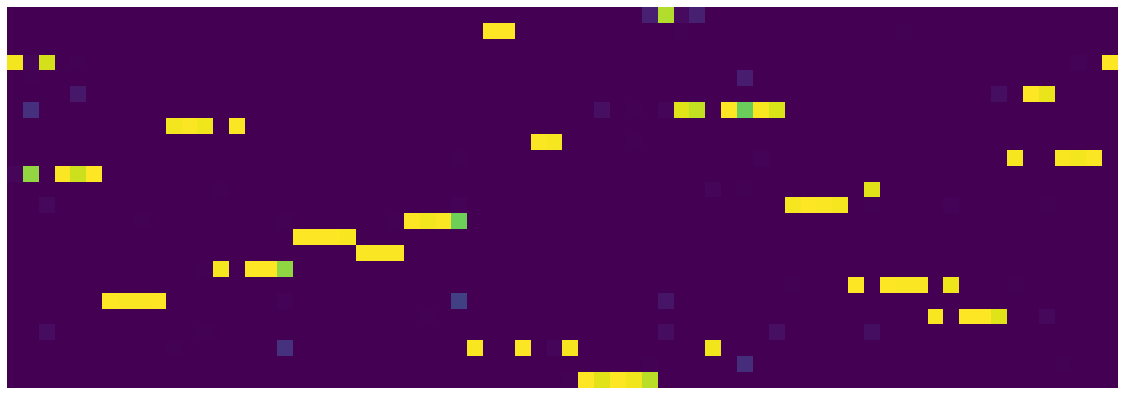

24 48 0.951 0.7243860552087427


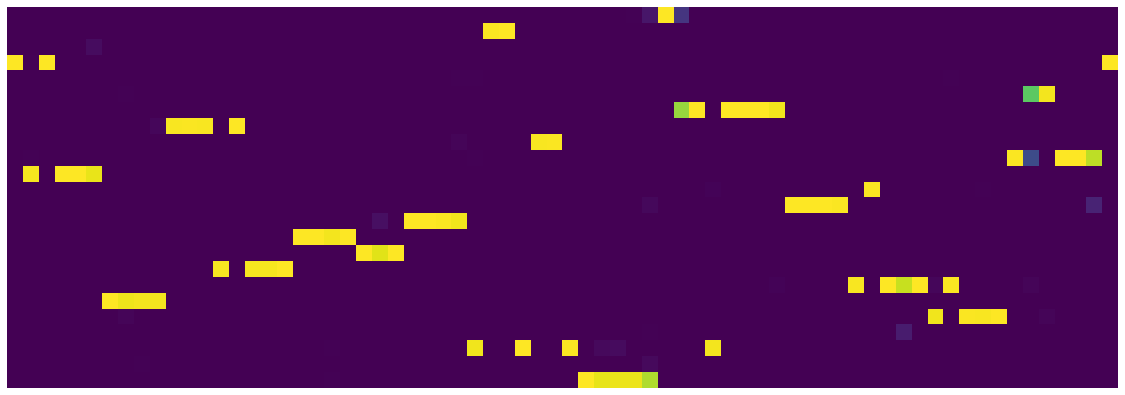

24 49 0.95 0.7109153740108013


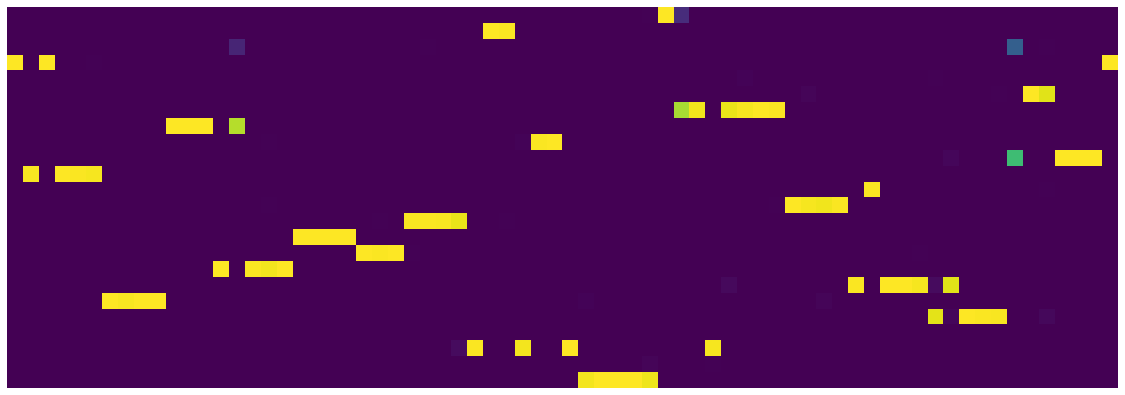

24 50 0.949 0.7110859578475356


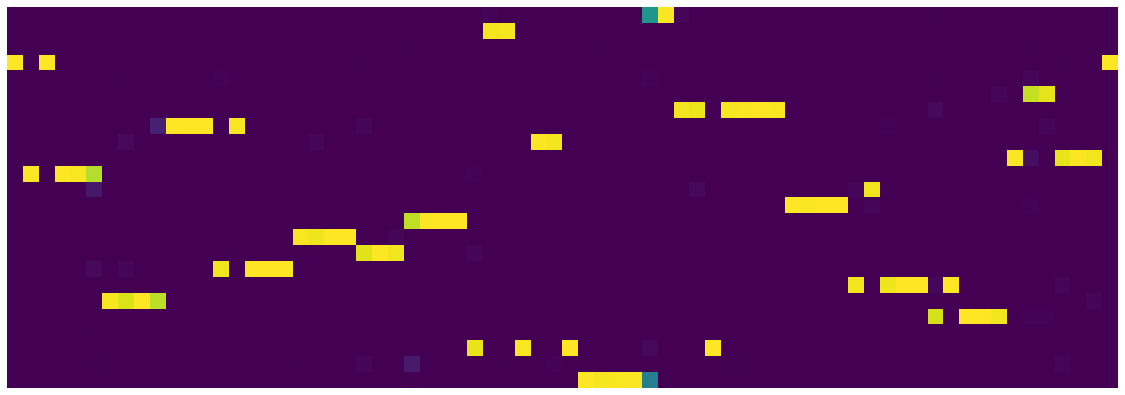

24 51 0.948 0.6945077473297715


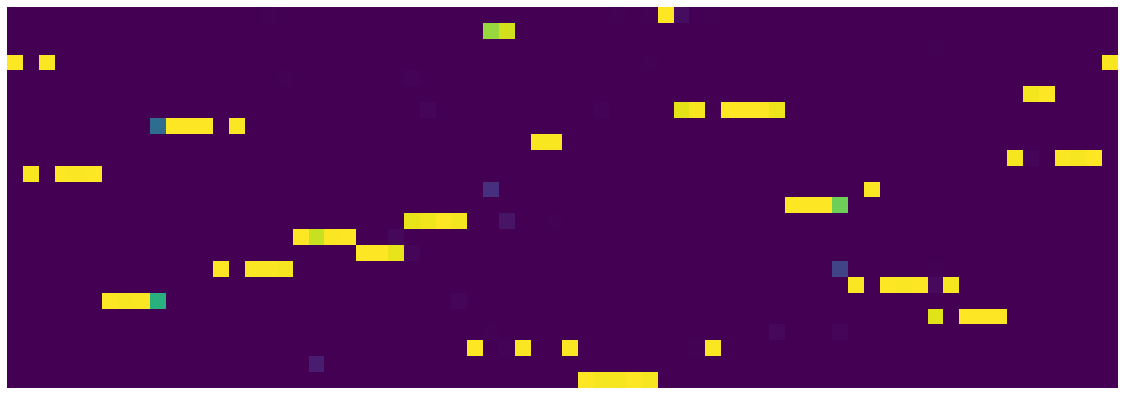

24 52 0.947 0.6979467421770096


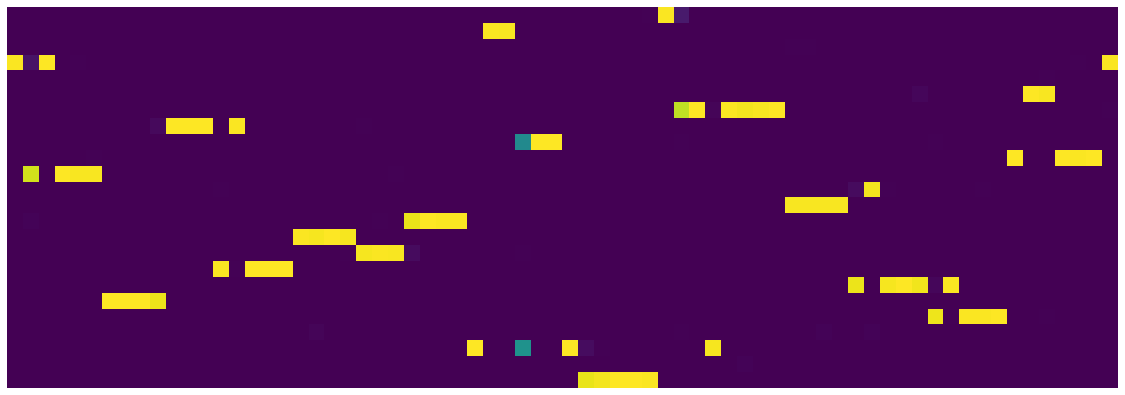

24 53 0.946 0.6979744082316757


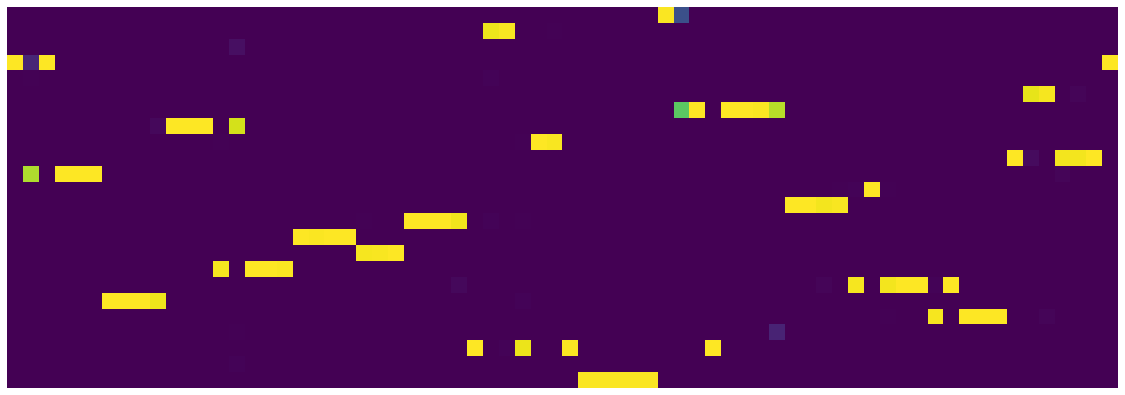

24 54 0.945 0.6874915009364486


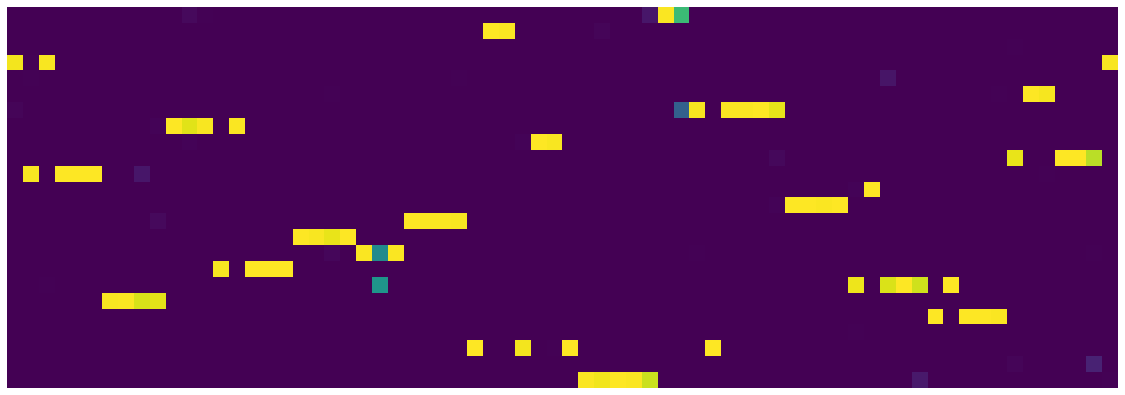

24 55 0.944 0.6723760526627303


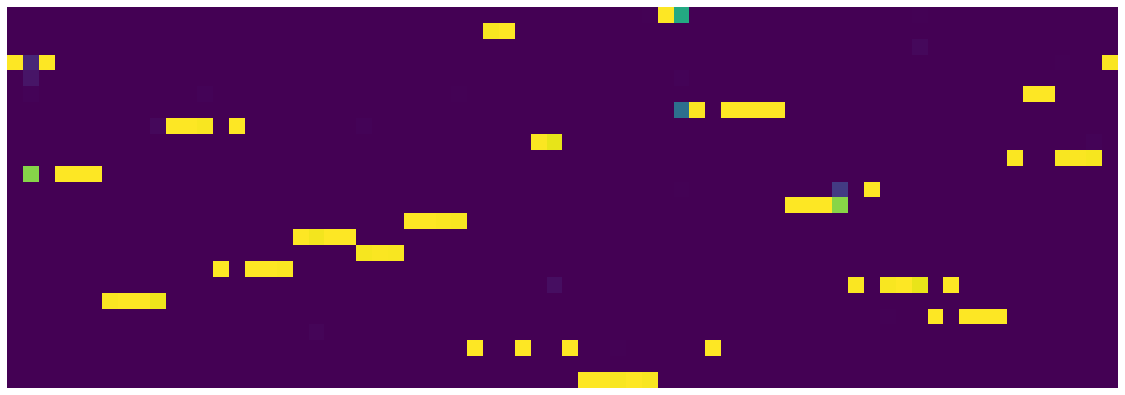

24 56 0.943 0.6850277174264192


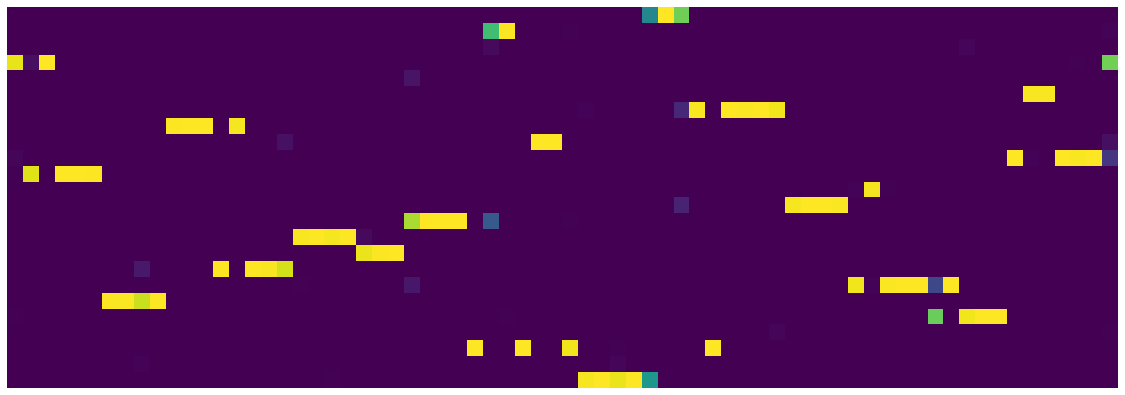

24 57 0.942 0.6735770720988512


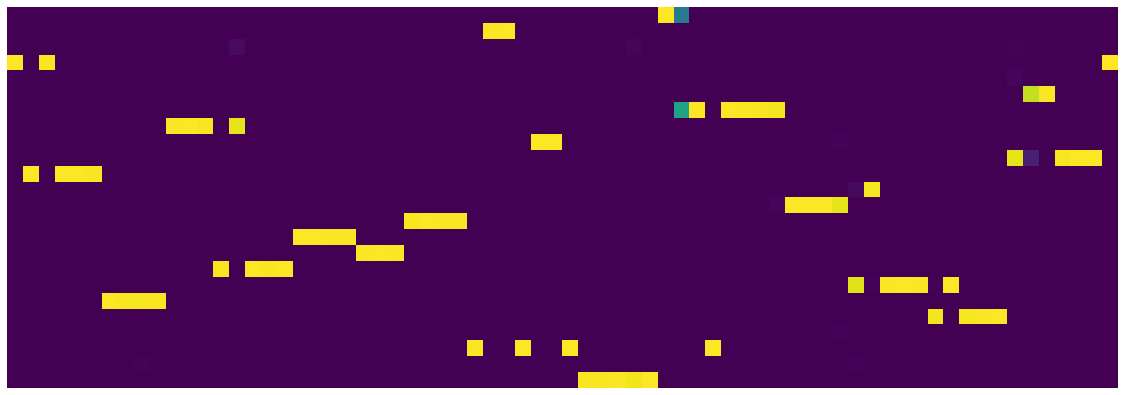

24 58 0.941 0.670182259939611


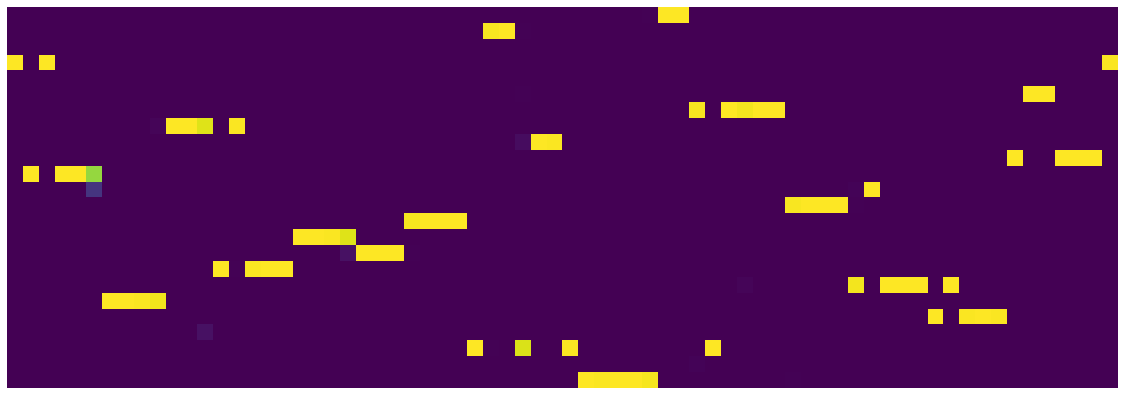

24 59 0.94 0.6736722955480218


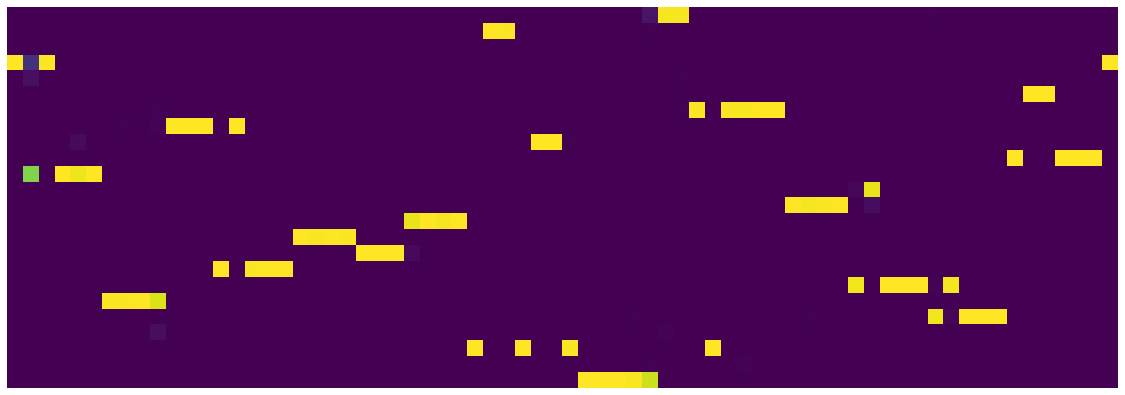

24 60 0.939 0.672643207013607


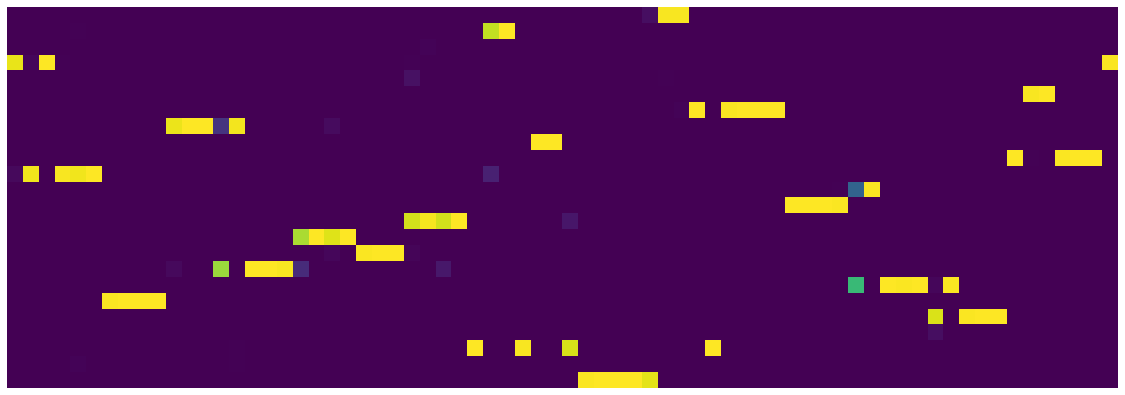

24 61 0.938 0.6621368244290352


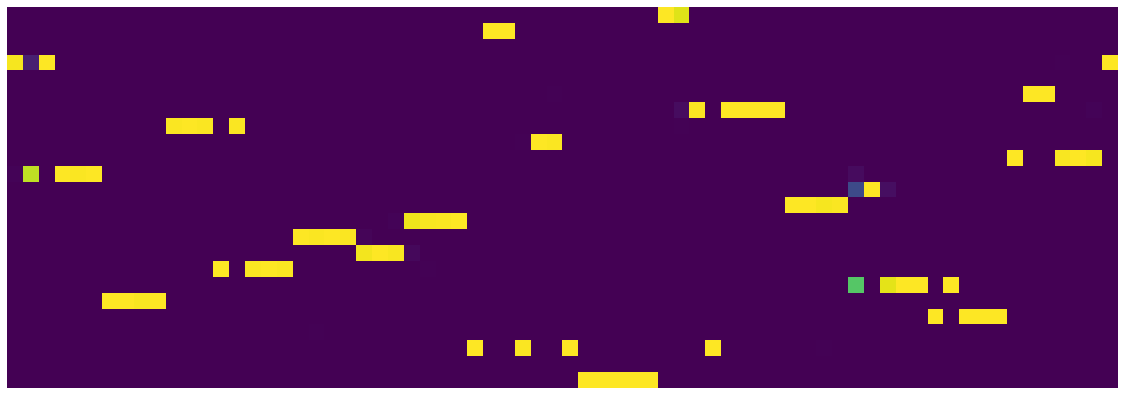

24 62 0.9369999999999999 0.6650454863905907


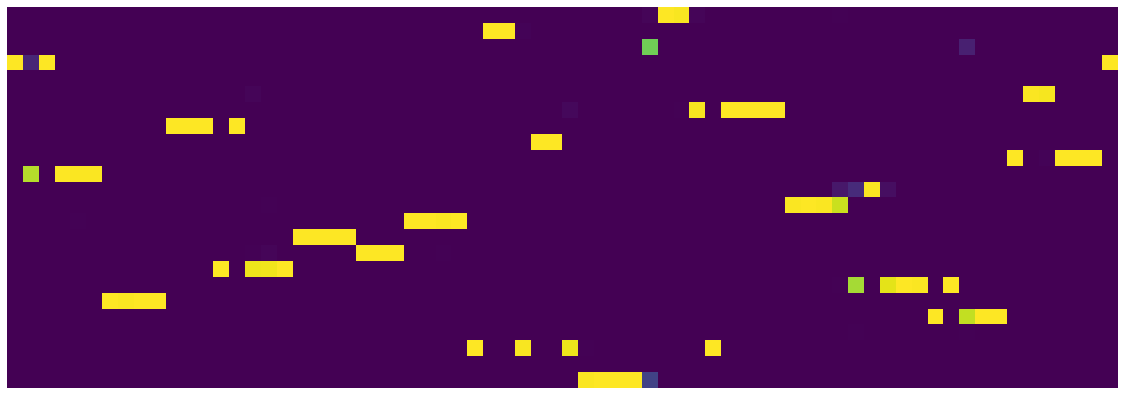

24 63 0.9359999999999999 0.6640517028048635


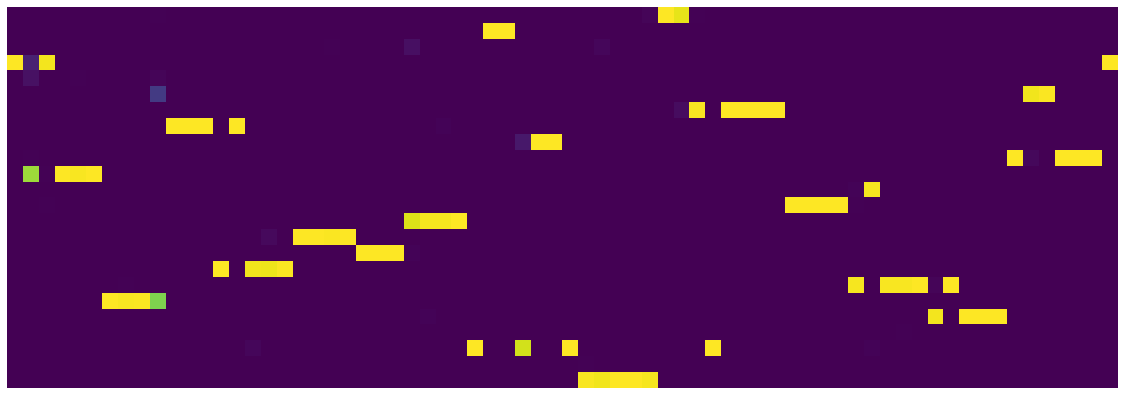

24 64 0.9349999999999999 0.665054814144969


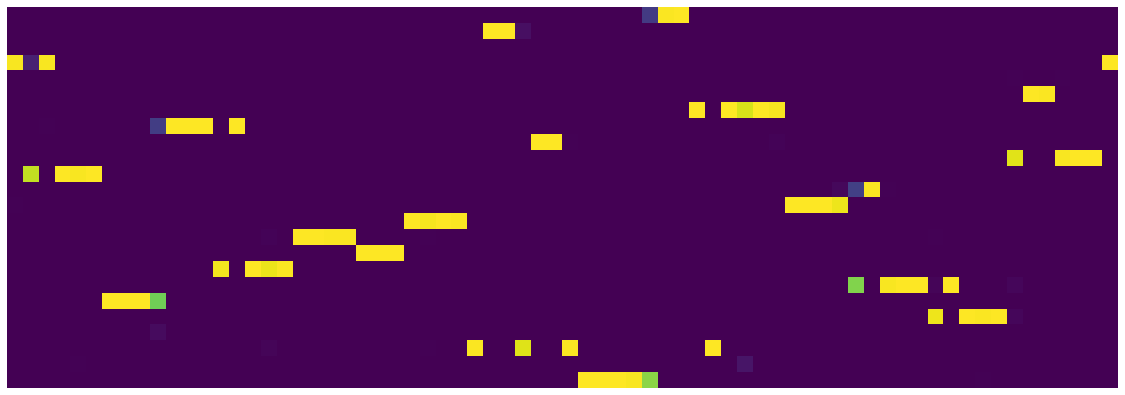

24 65 0.9339999999999999 0.6616915045306087


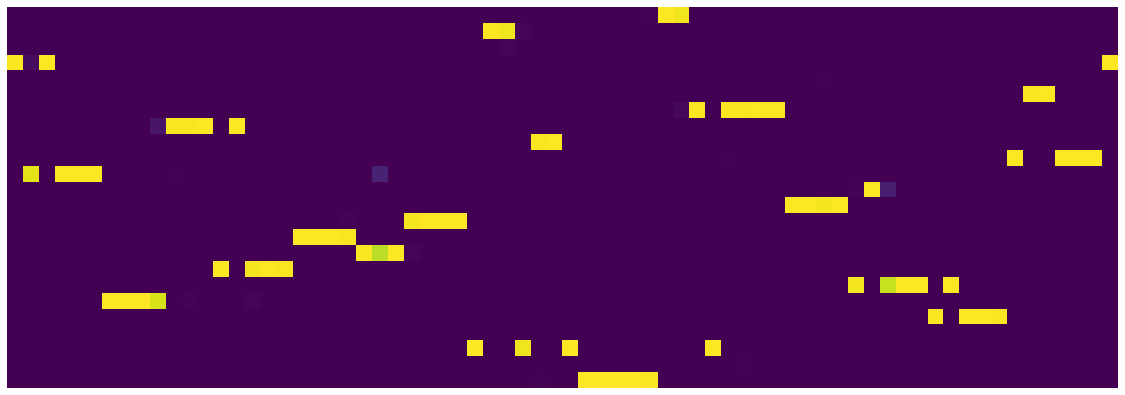

24 66 0.9329999999999999 0.6684021605178714


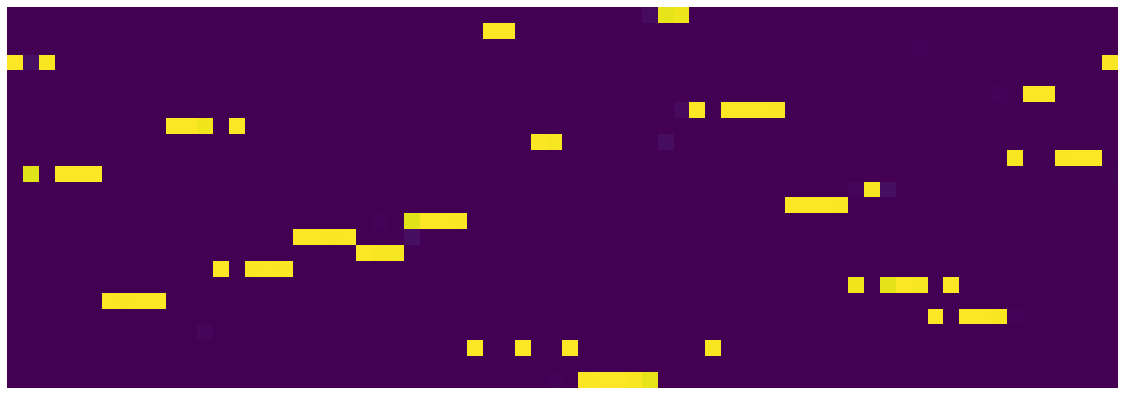

24 67 0.9319999999999999 0.665261572599411


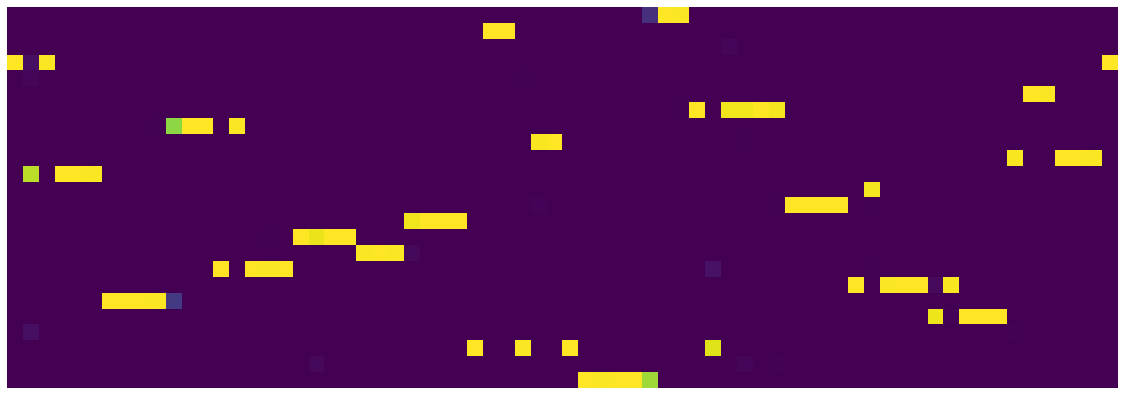

24 68 0.9309999999999999 0.6548985170200468


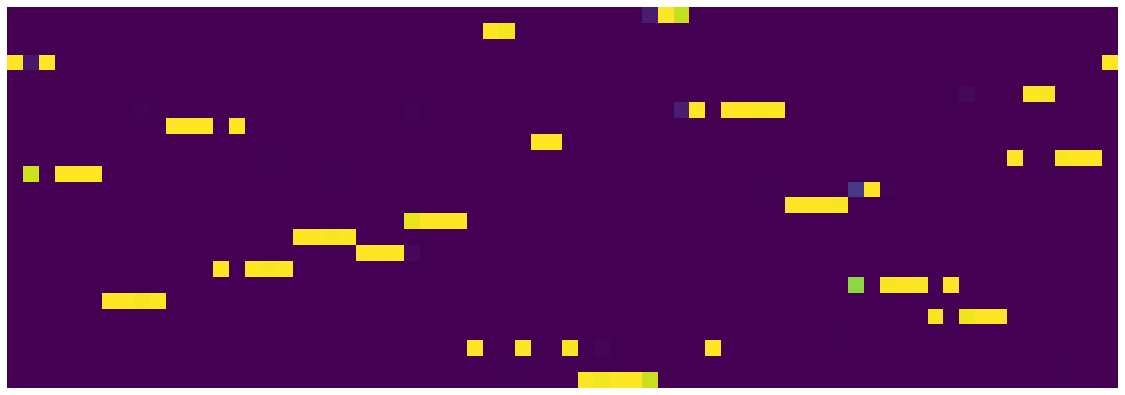

24 69 0.9299999999999999 0.6587672971189023


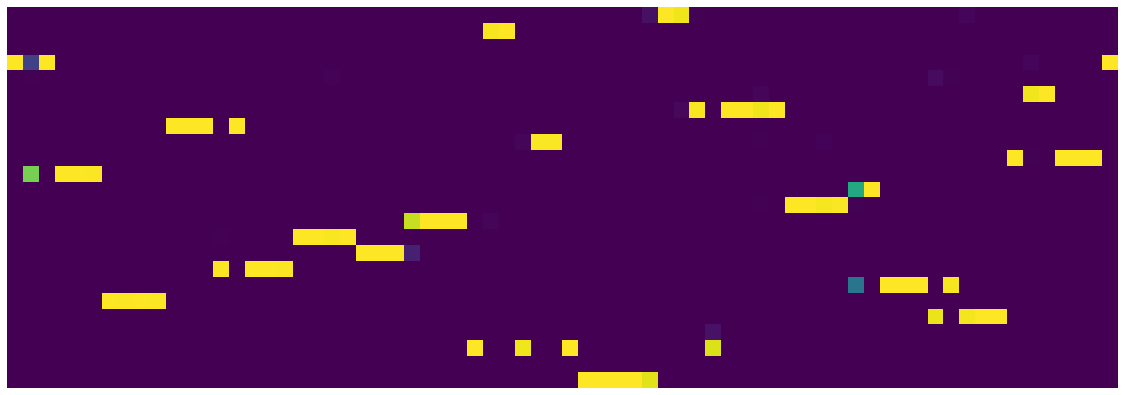

24 70 0.9289999999999999 0.6555279357358813


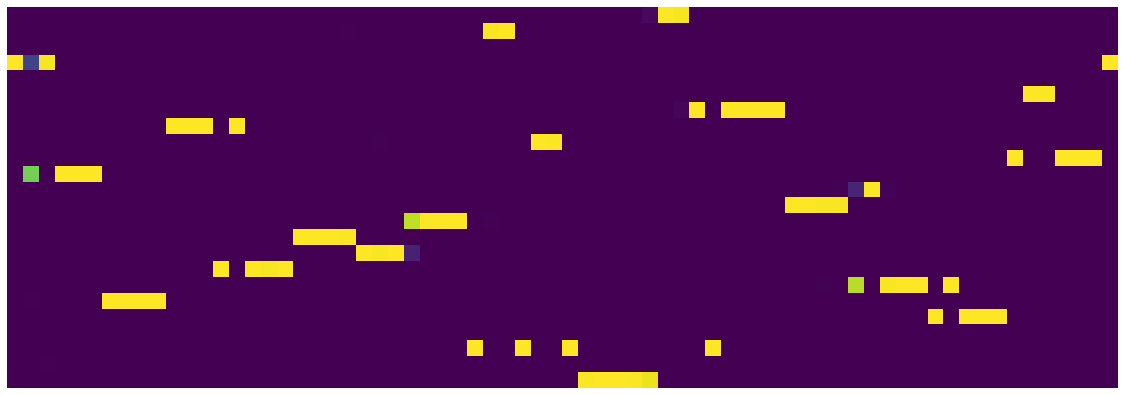

24 71 0.9279999999999999 0.6566372664645315


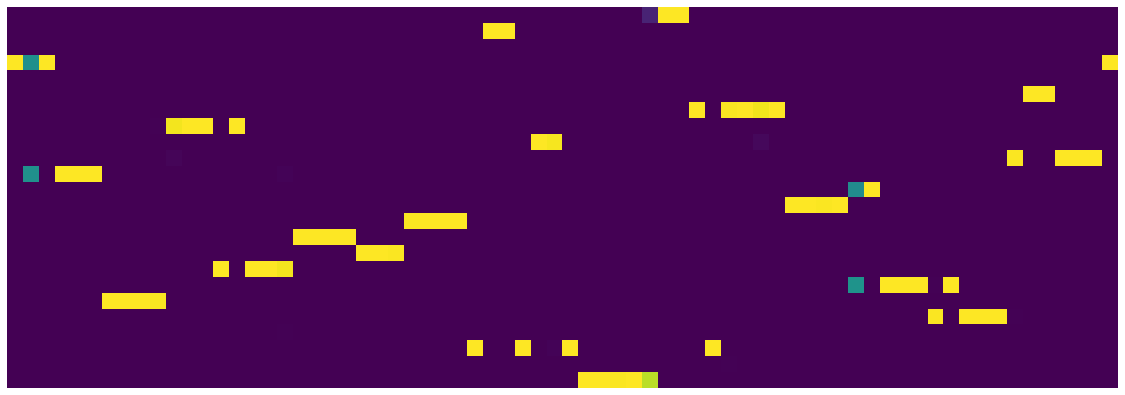

24 72 0.9269999999999999 0.6584458177909255


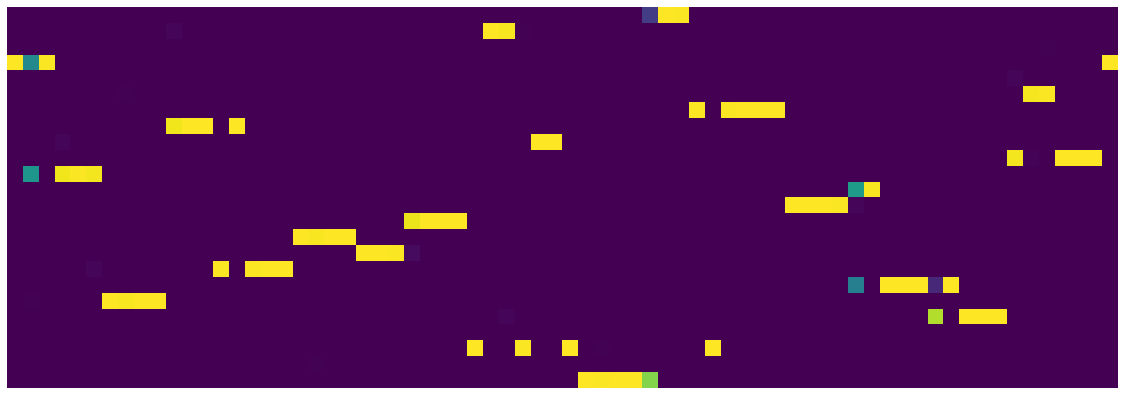

24 73 0.9259999999999999 0.6588947599753737


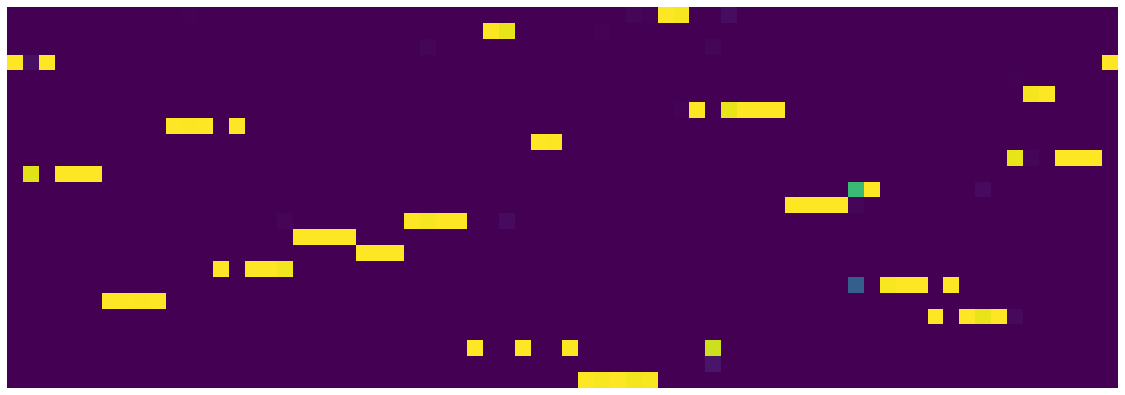

24 74 0.9249999999999999 0.6545339375734329


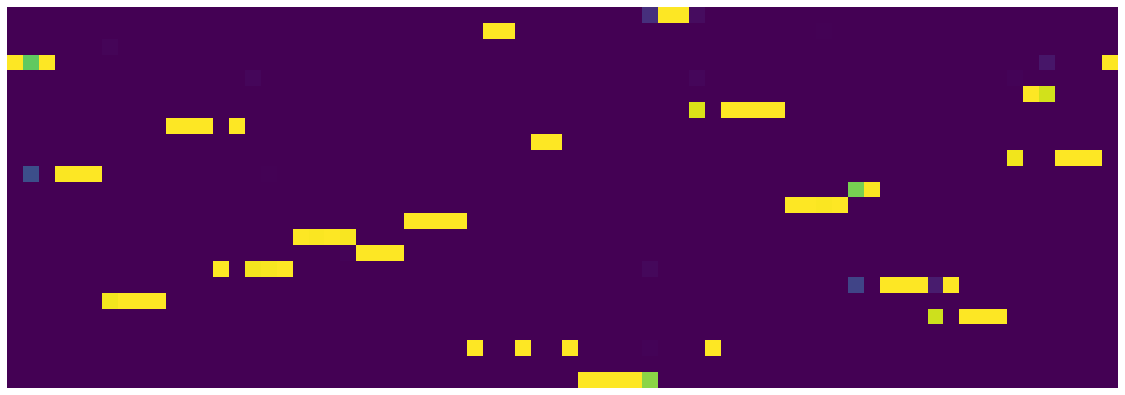

24 75 0.9239999999999999 0.6516530172899365


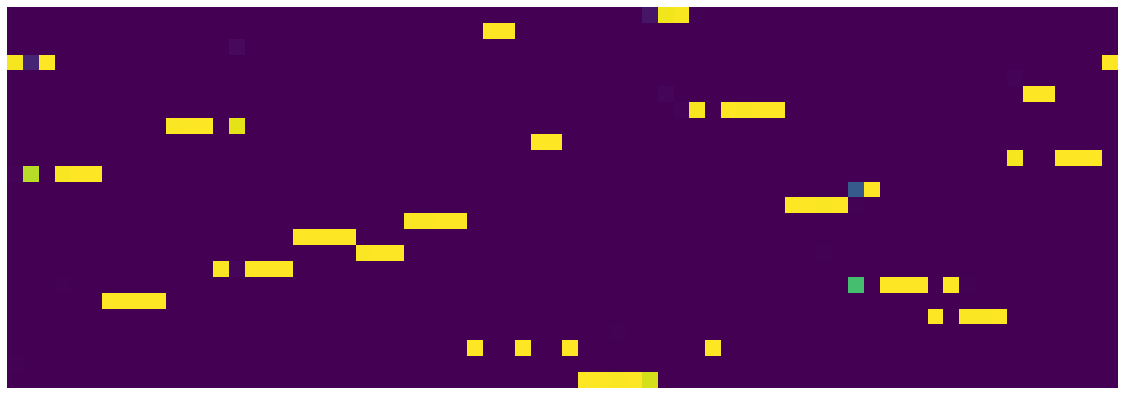

24 76 0.9229999999999999 0.6541166564449667


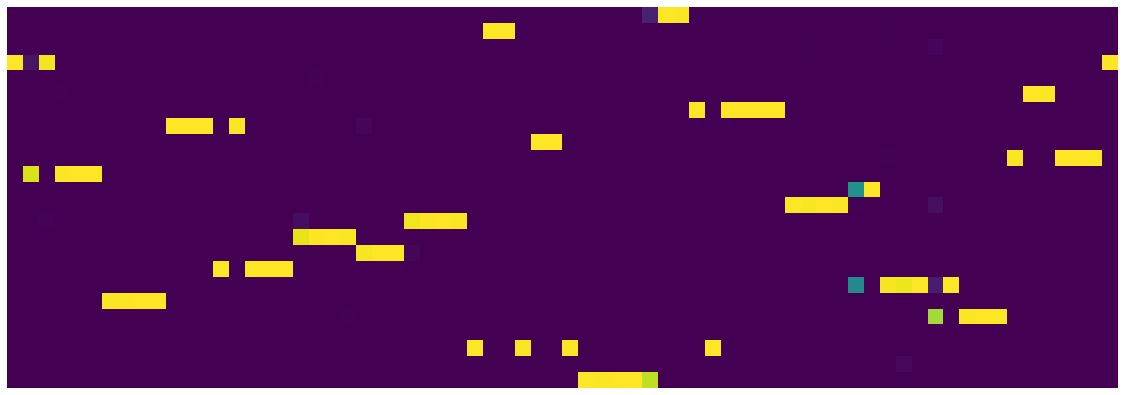

24 77 0.9219999999999999 0.6520326530560852


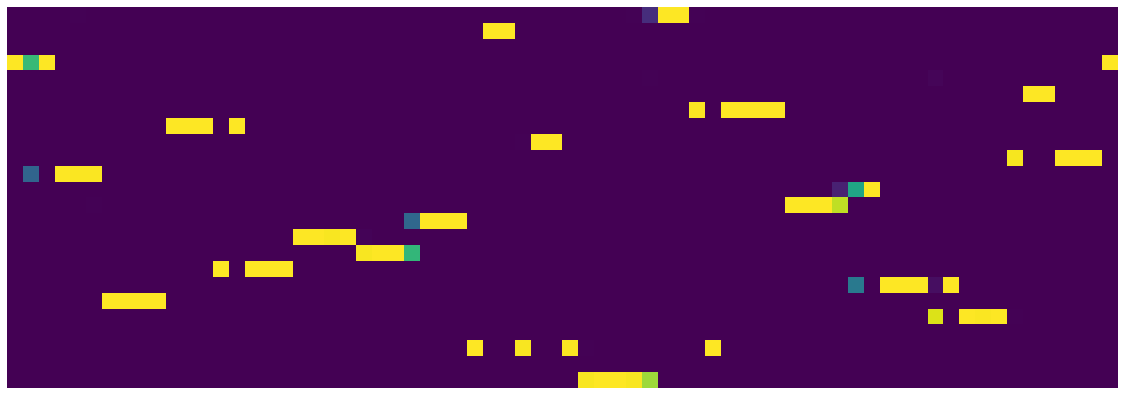

24 78 0.9209999999999999 0.6457314845174551


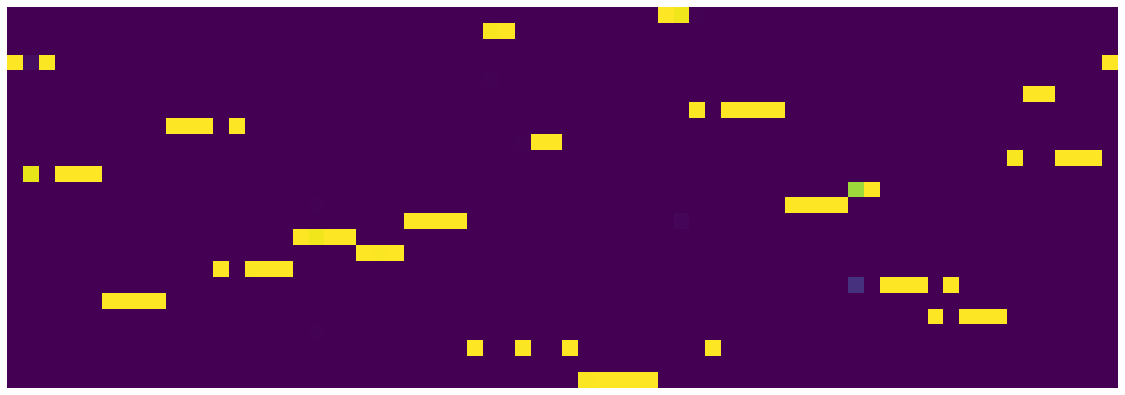

24 79 0.9199999999999999 0.6373927995562554


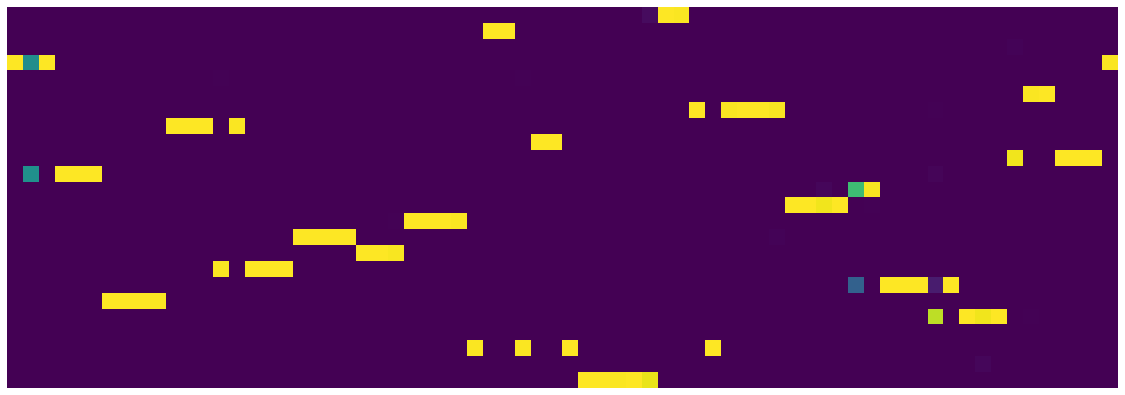

24 80 0.9189999999999999 0.6411035887897014


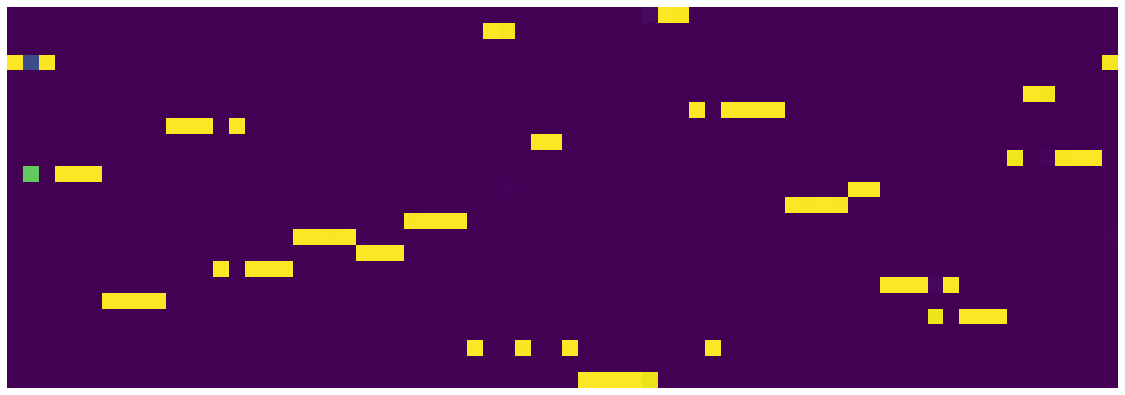

24 81 0.9179999999999999 0.6399339413270354


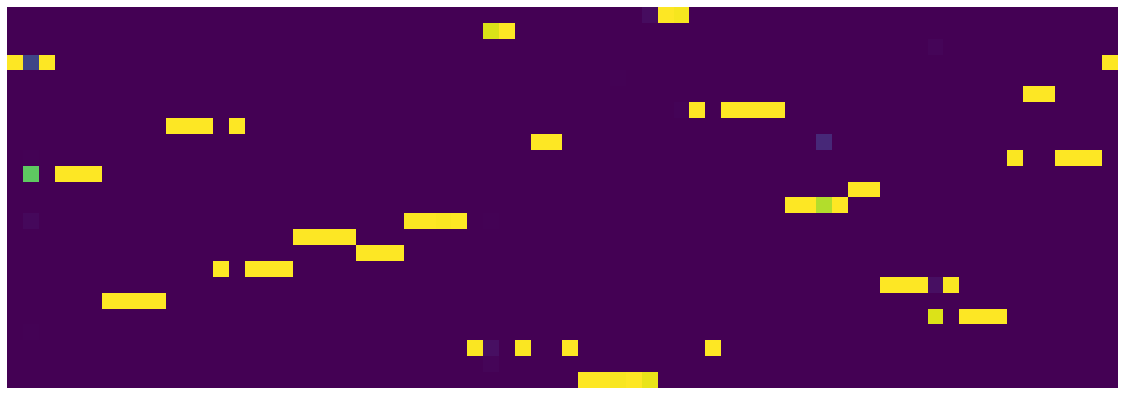

24 82 0.9169999999999999 0.6377819467335939


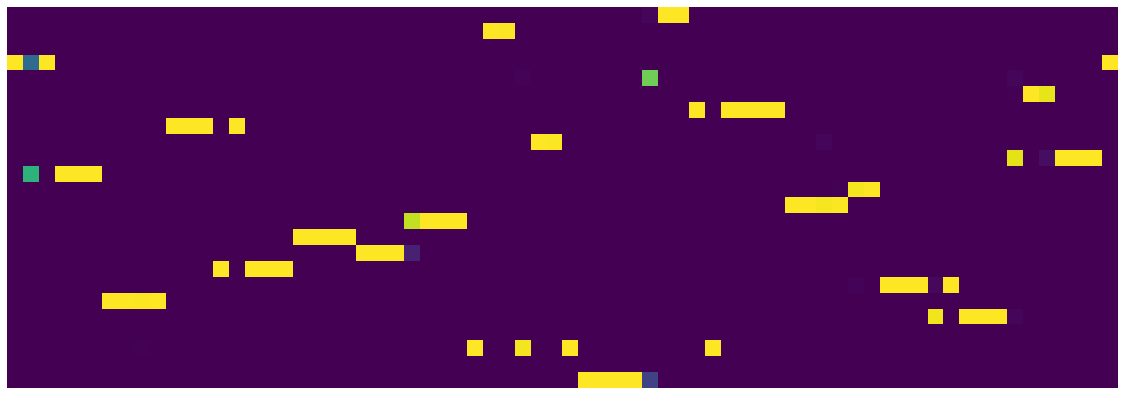

24 83 0.9159999999999999 0.6371150139719248


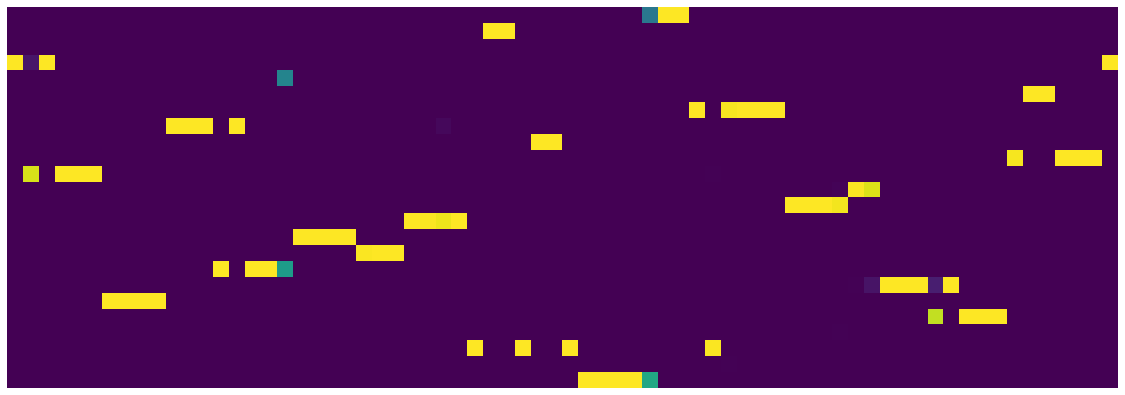

24 84 0.9149999999999999 0.6392101606354117


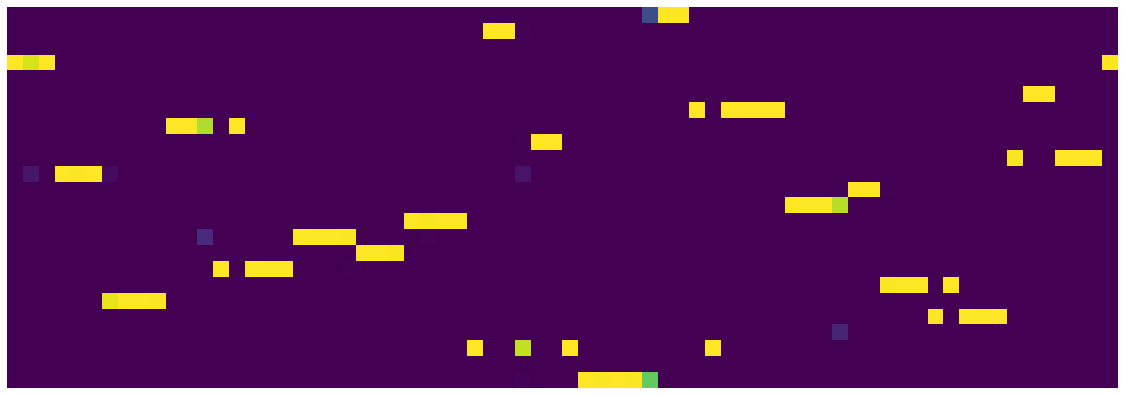

24 85 0.9139999999999999 0.6407501328736543


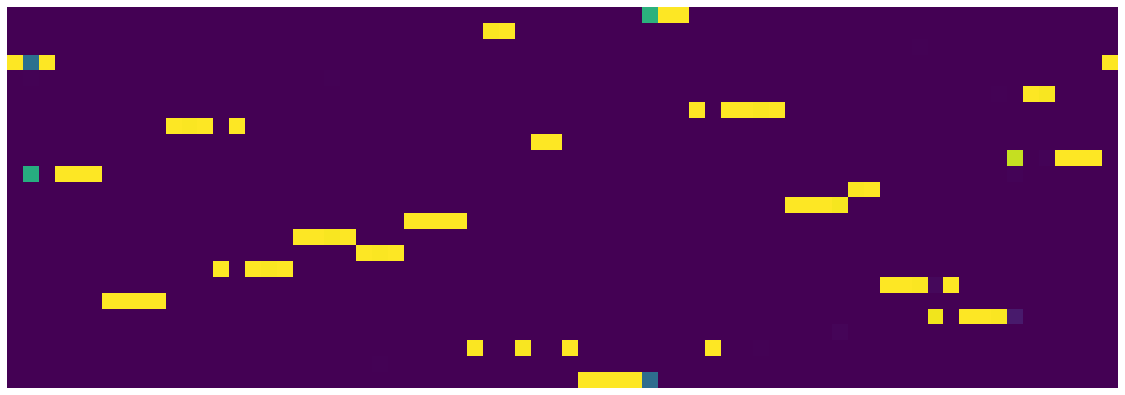

24 86 0.9129999999999999 0.6400828015059232


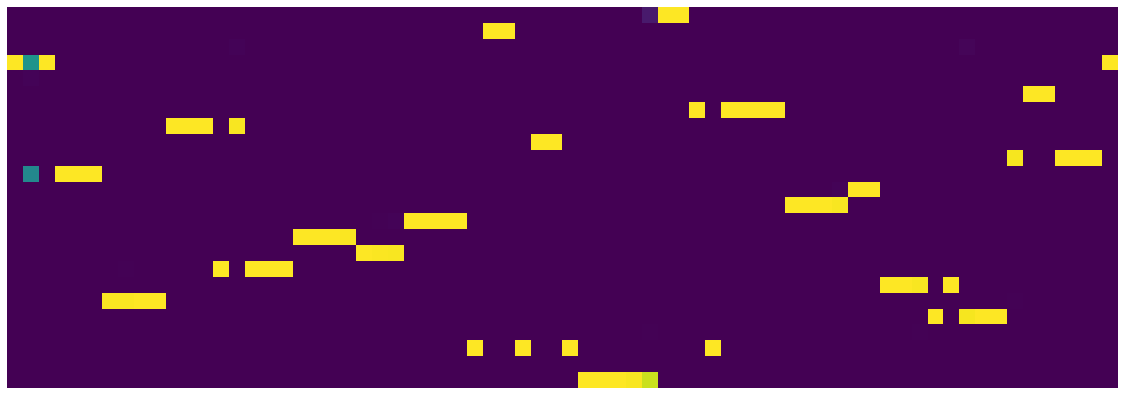

24 87 0.9119999999999999 0.6403567295521497


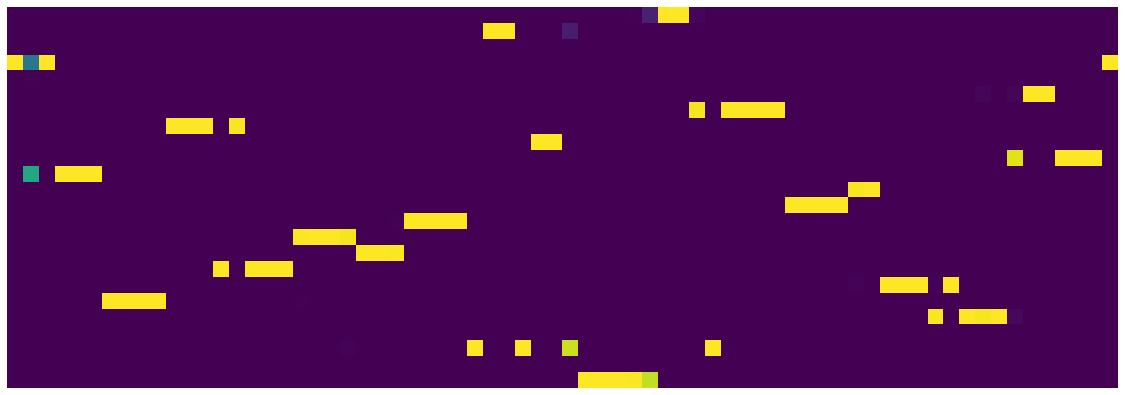

24 88 0.9109999999999999 0.6366244569420815


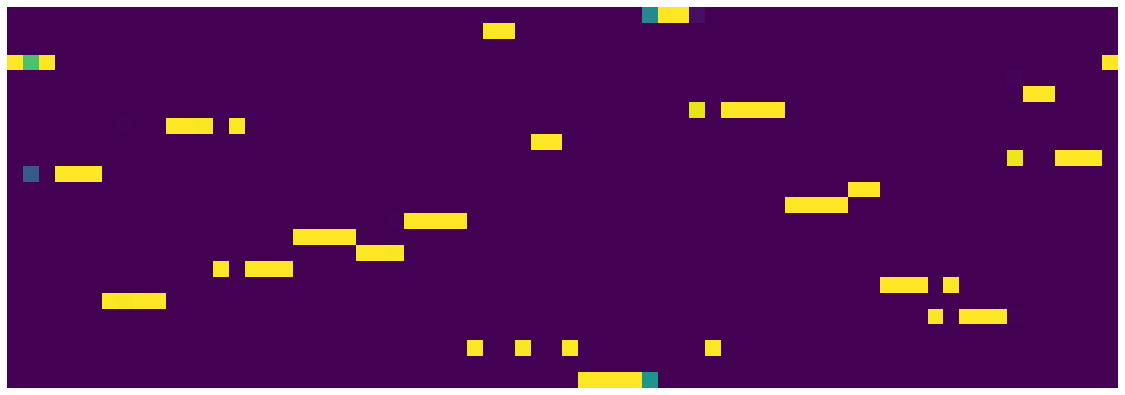

24 89 0.9099999999999999 0.6349967658519745


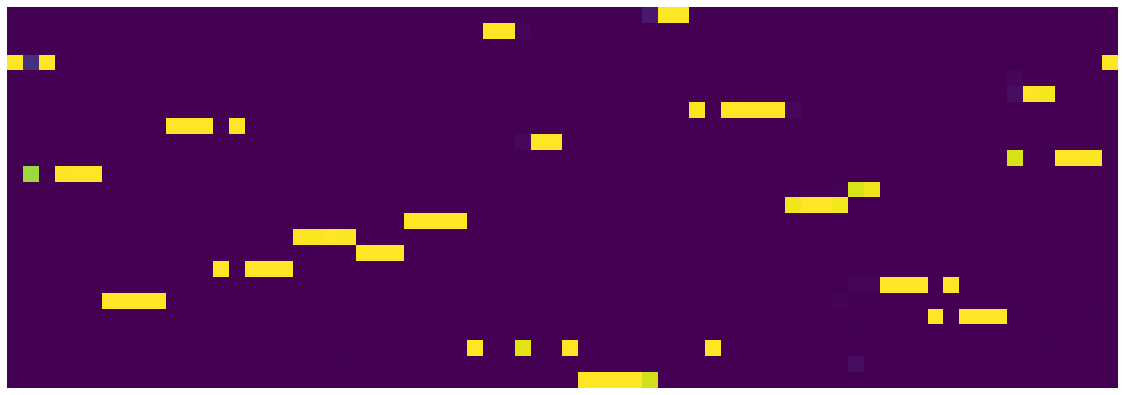

24 90 0.9089999999999999 0.6371751001104713


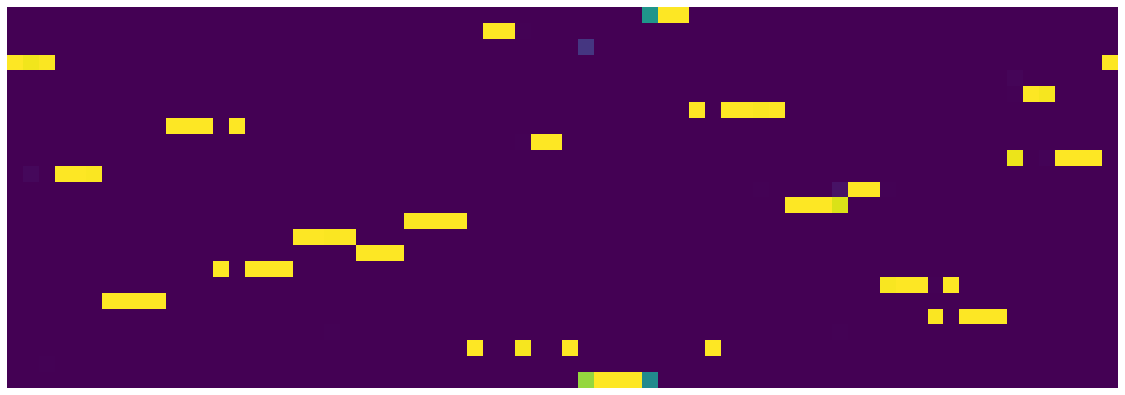

24 91 0.9079999999999999 0.6362744716927409


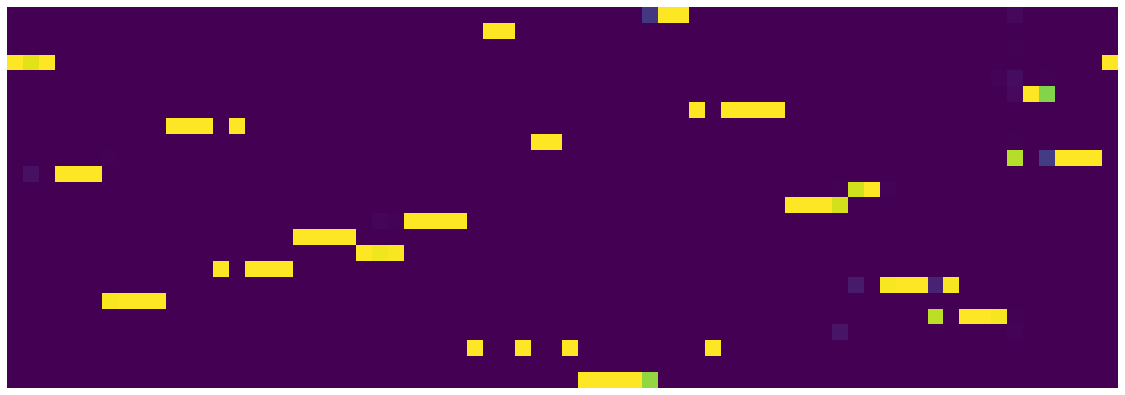

24 92 0.9069999999999999 0.6336242321878671


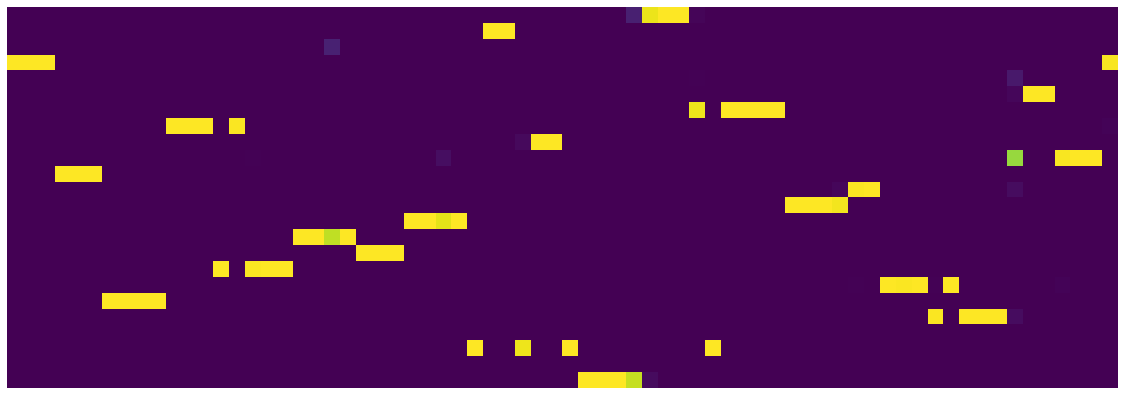

24 93 0.9059999999999999 0.6320686182007194


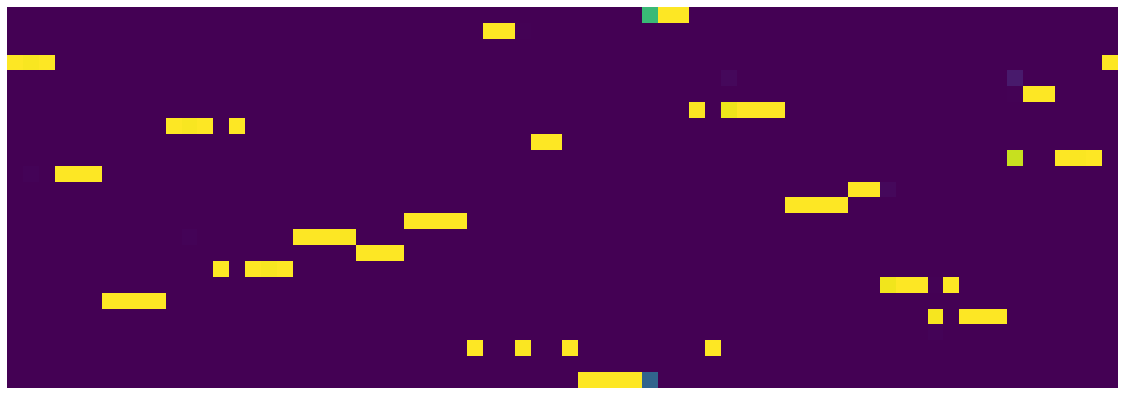

24 94 0.9049999999999999 0.6323886564001441


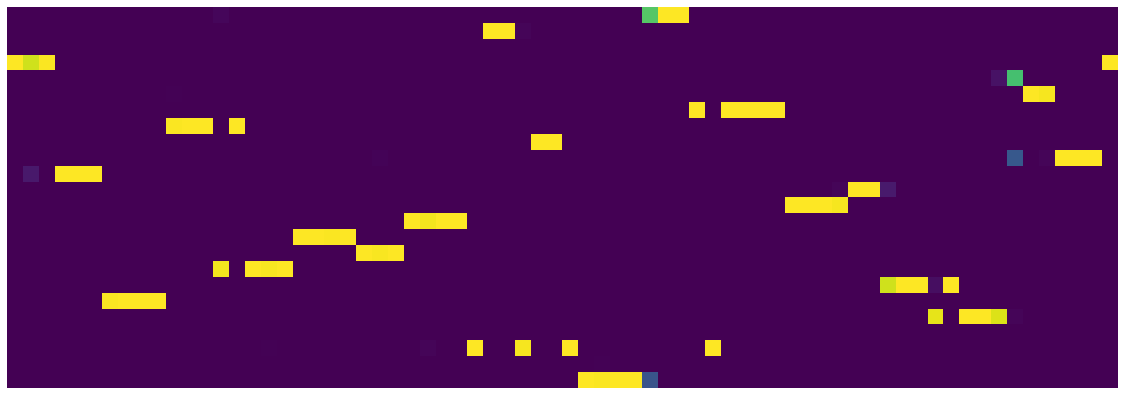

24 95 0.9039999999999999 0.6296448424458504


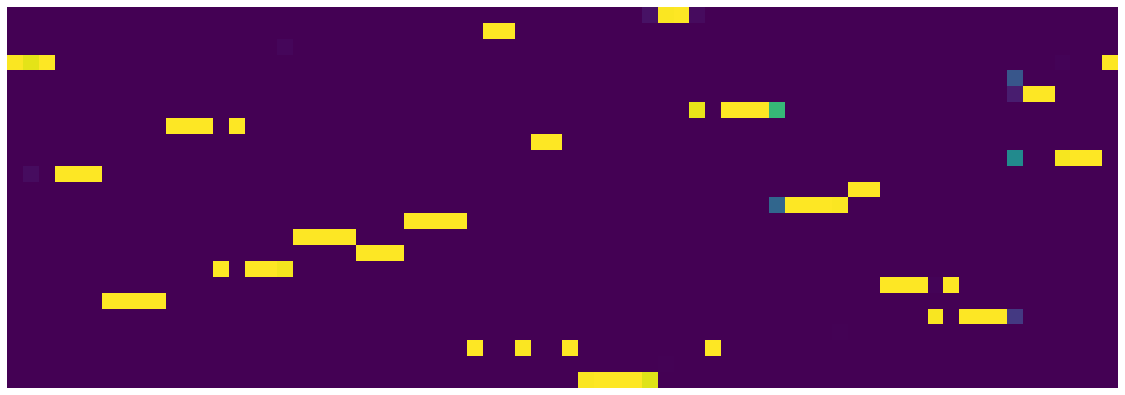

24 96 0.9029999999999999 0.6166470823809505


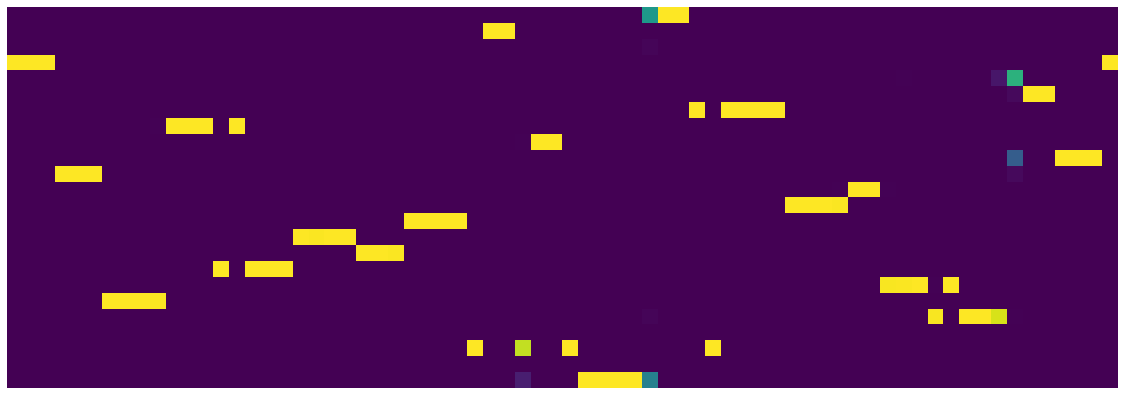

24 97 0.9019999999999999 0.6159525636583567


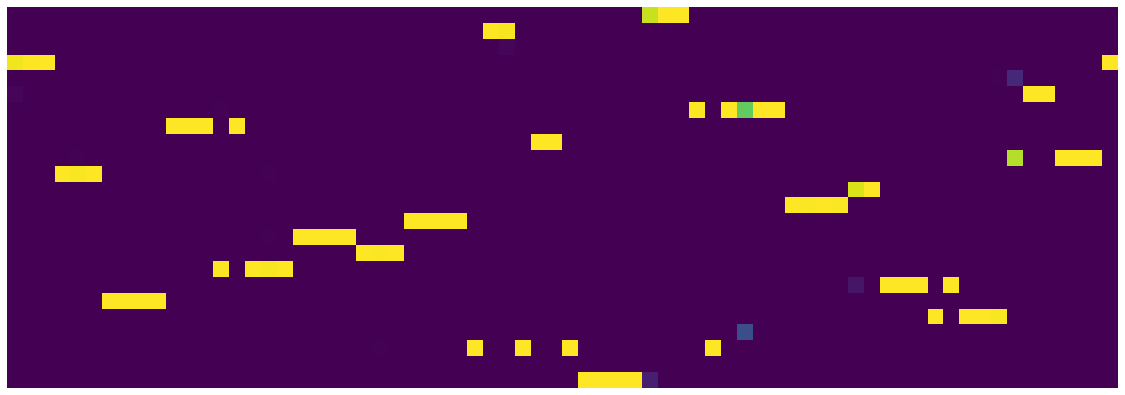

24 98 0.9009999999999999 0.6084633285179735


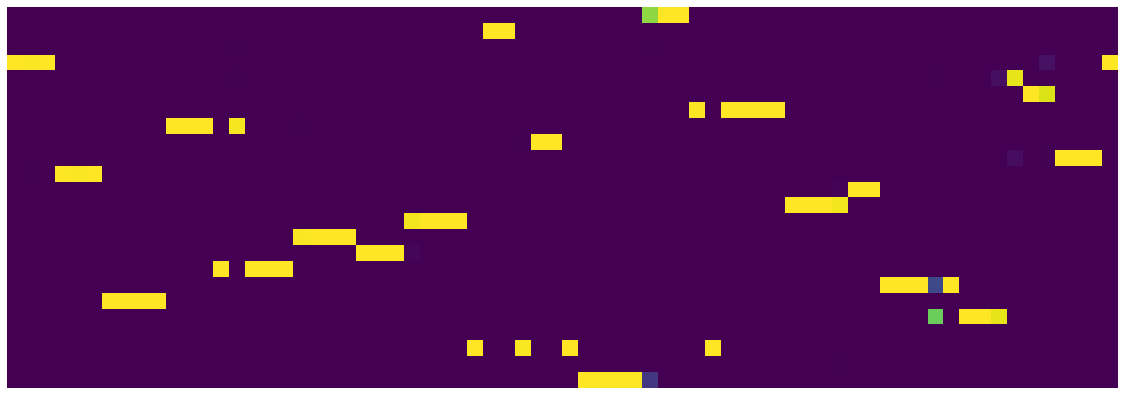

24 99 0.8999999999999999 0.609272227063775


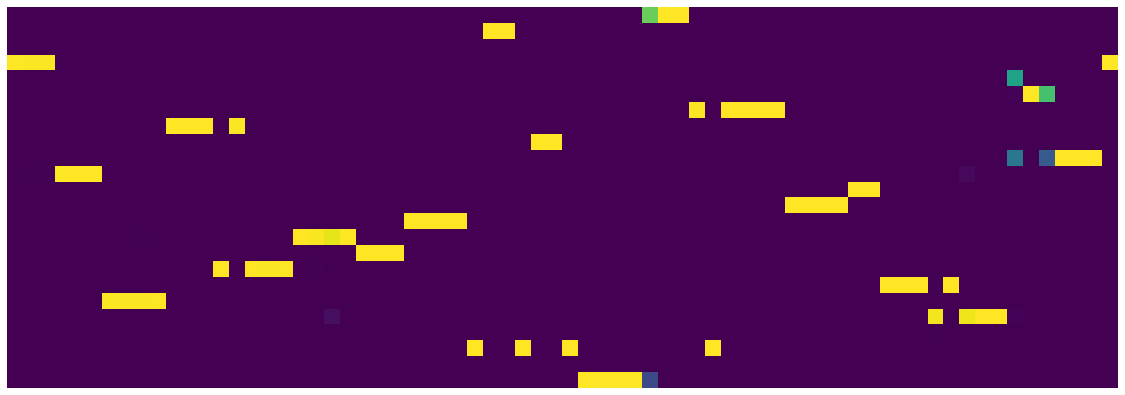

24 100 0.8989999999999999 0.607296758517623


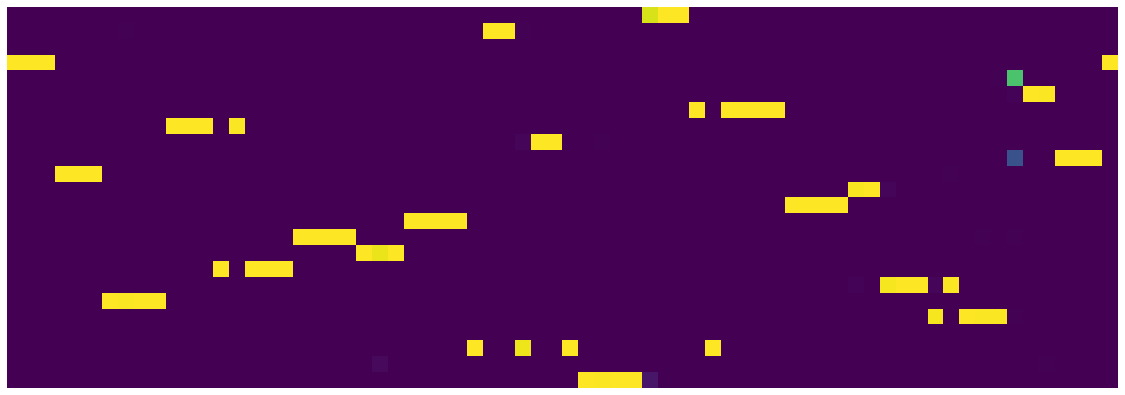

24 101 0.8979999999999999 0.6013732587918639


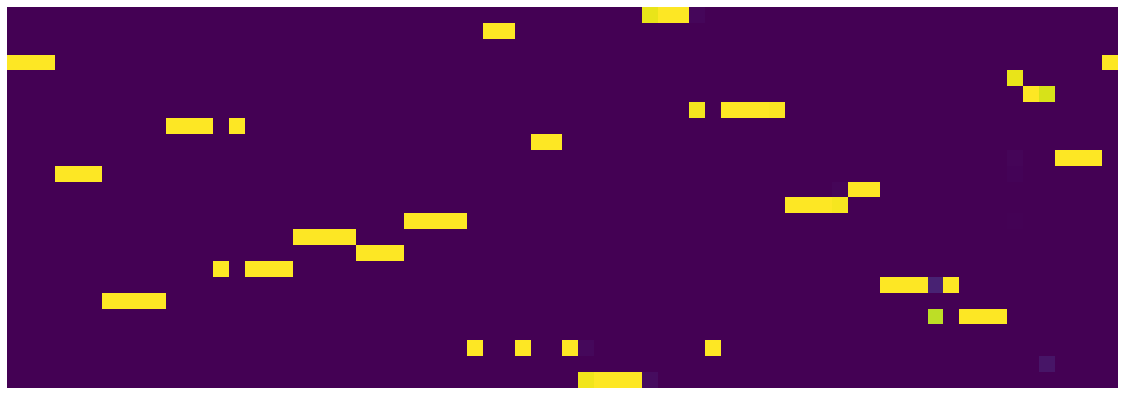

24 102 0.8969999999999999 0.6008325623348355


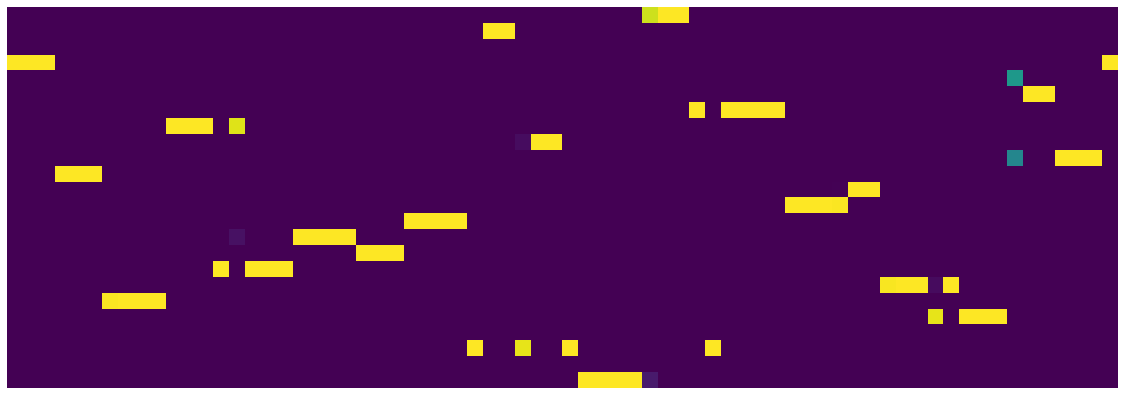

24 103 0.8959999999999999 0.6024195838719606


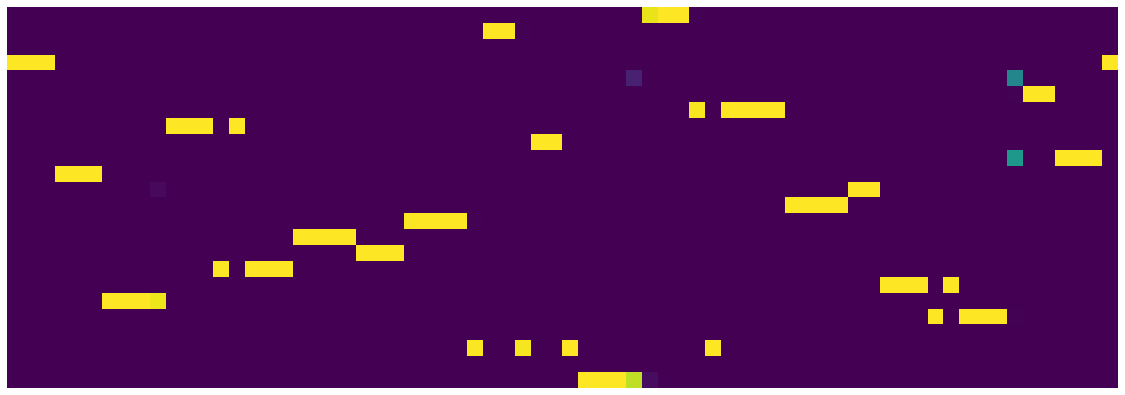

24 104 0.8949999999999999 0.6002332549542189


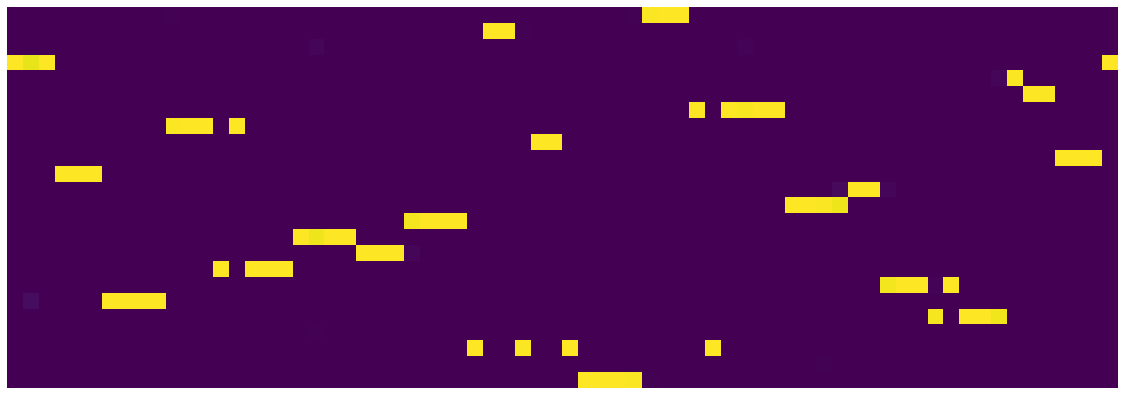

24 105 0.8939999999999999 0.6003751631826162


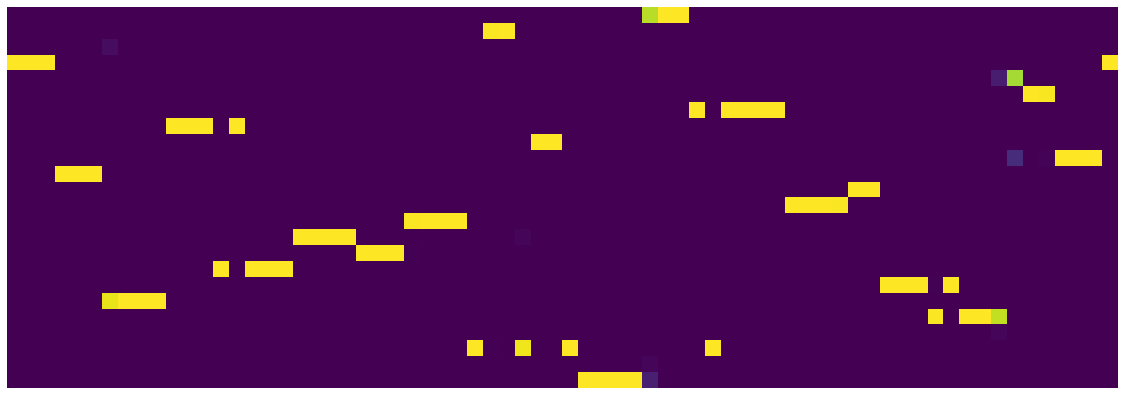

24 106 0.8929999999999999 0.5983244638890028


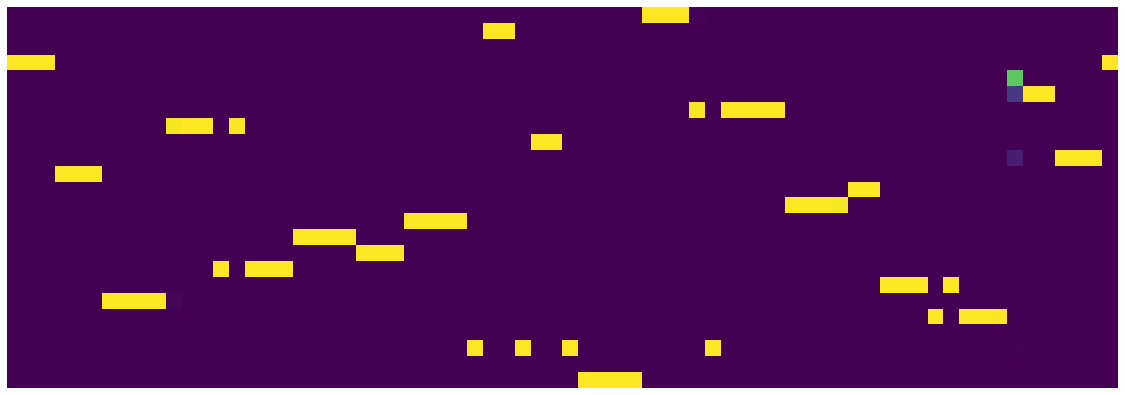

24 107 0.8919999999999999 0.6004343189299106


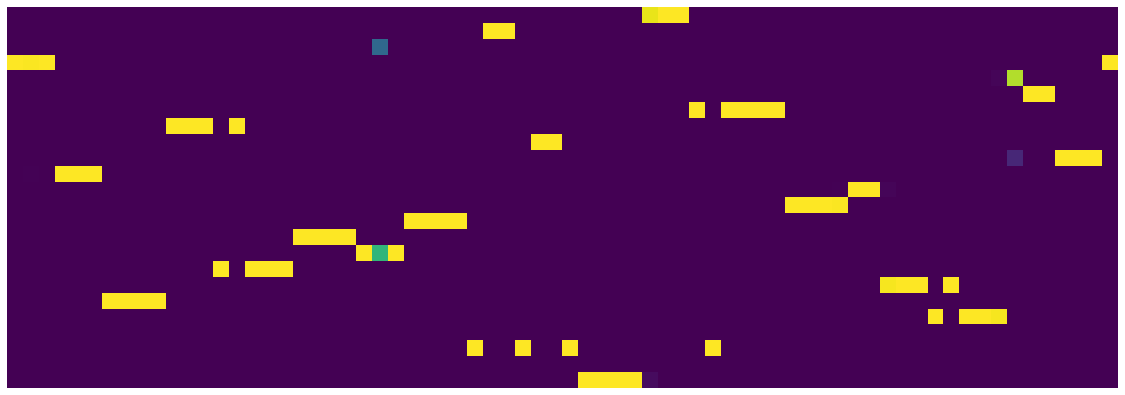

24 108 0.8909999999999999 0.5965487647801637


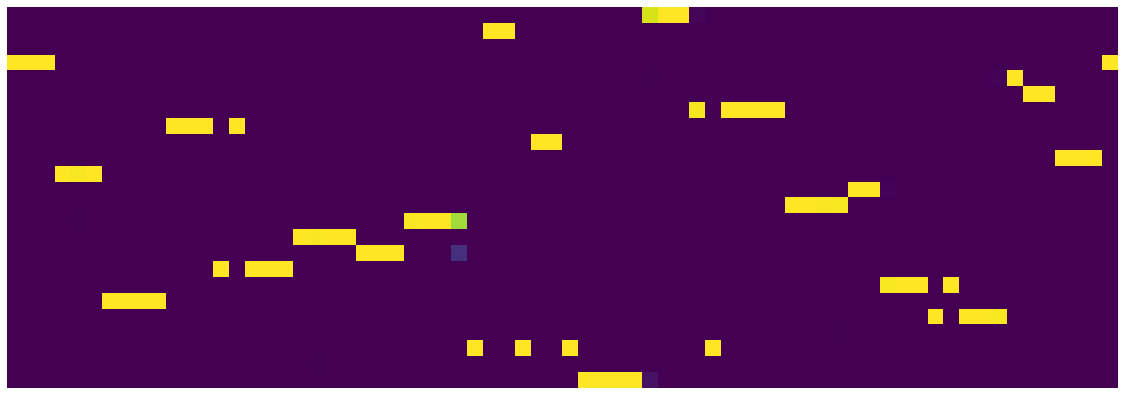

24 109 0.8899999999999999 0.598963251709938


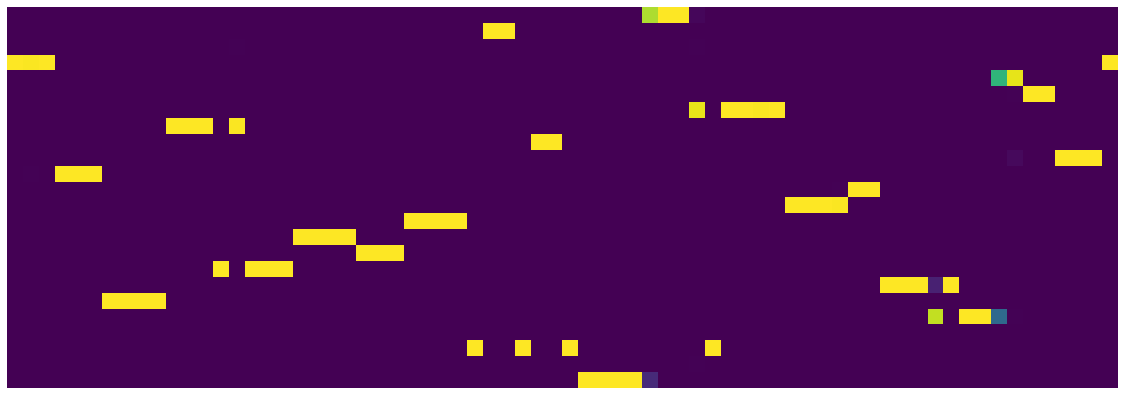

24 110 0.8889999999999999 0.5958607994019985


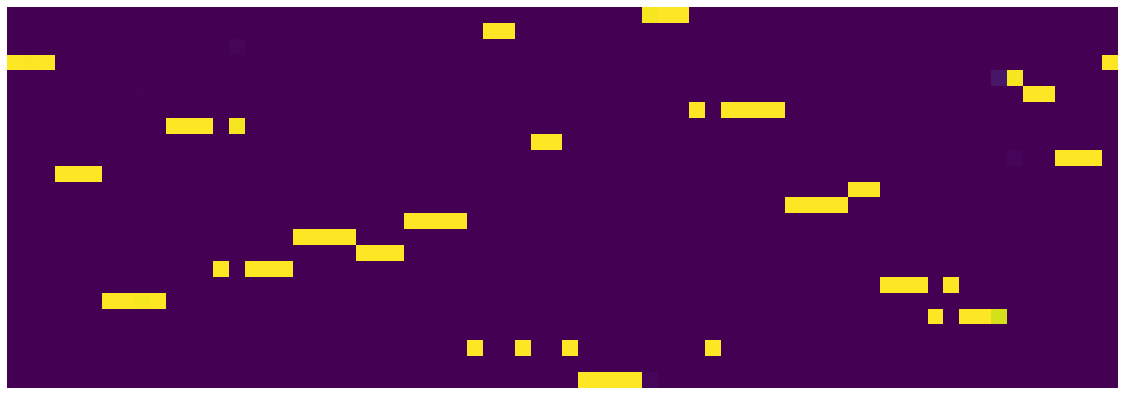

24 111 0.8879999999999999 0.5997475126758218


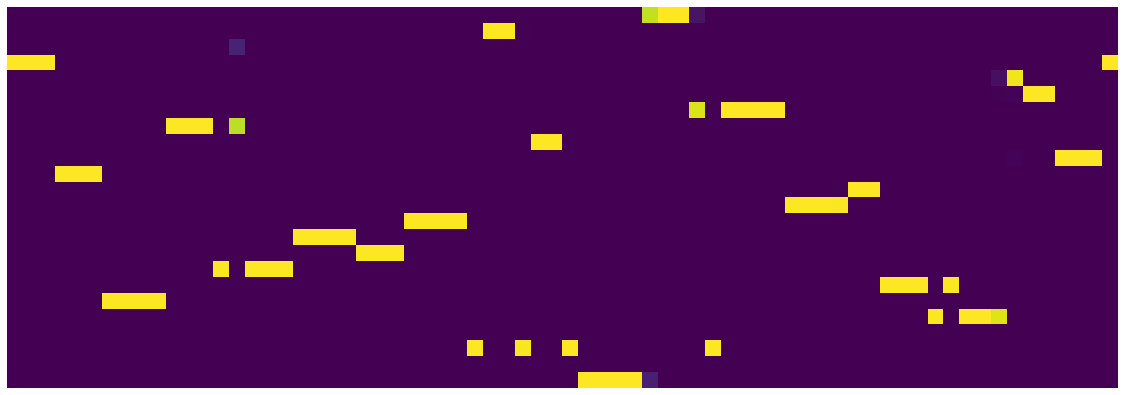

24 112 0.8869999999999999 0.5939022118225694


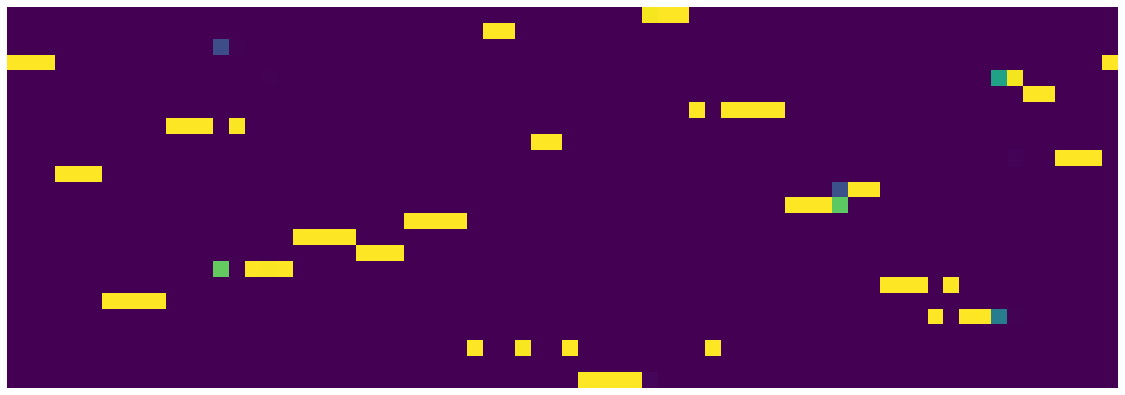

24 113 0.8859999999999999 0.5971212873235345


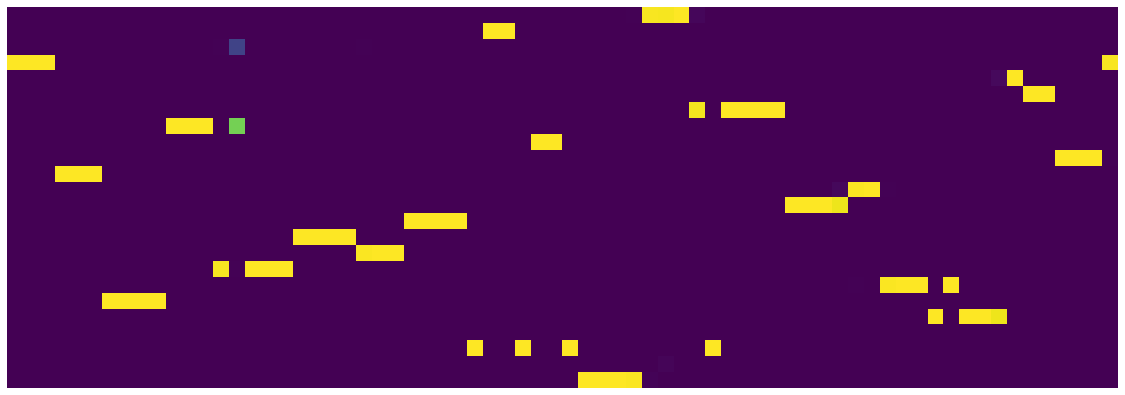

24 114 0.8849999999999999 0.579070283472538


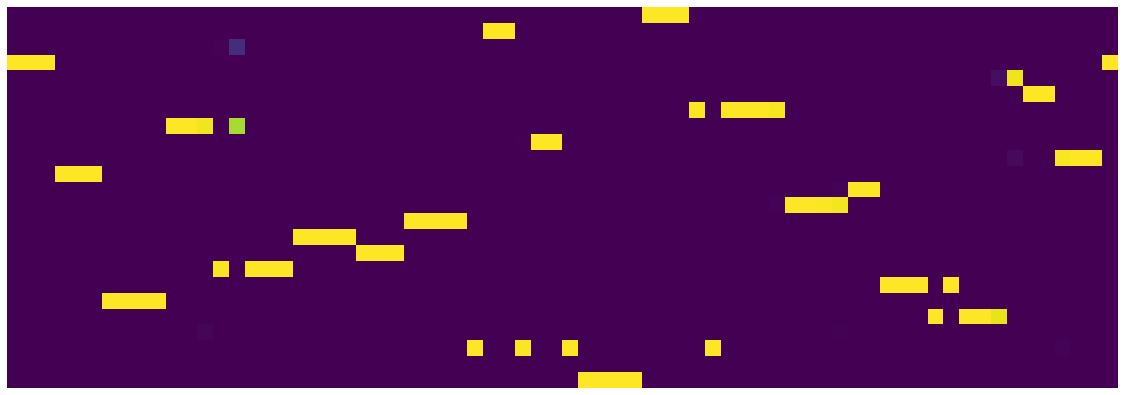

24 115 0.8839999999999999 0.5847520619630814


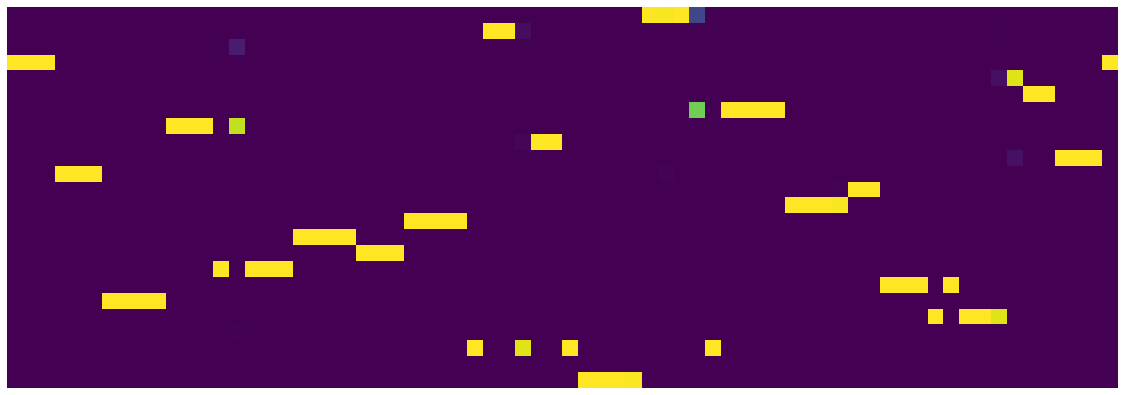

24 116 0.8829999999999999 0.5733803221955895


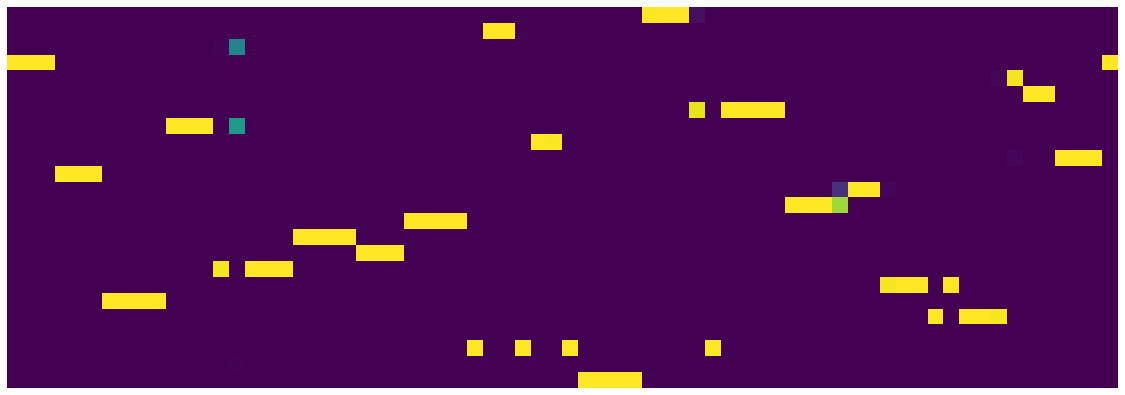

24 117 0.8819999999999999 0.5801728485152126


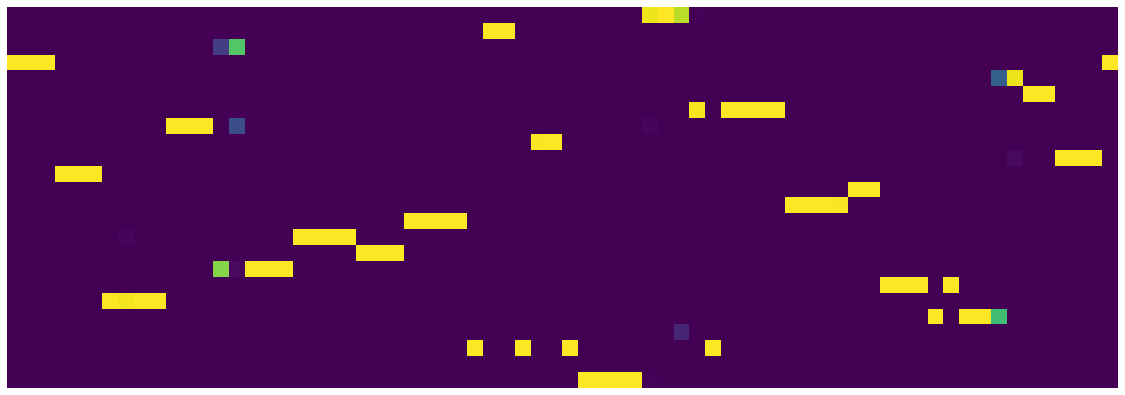

24 118 0.8809999999999999 0.5778521468862892


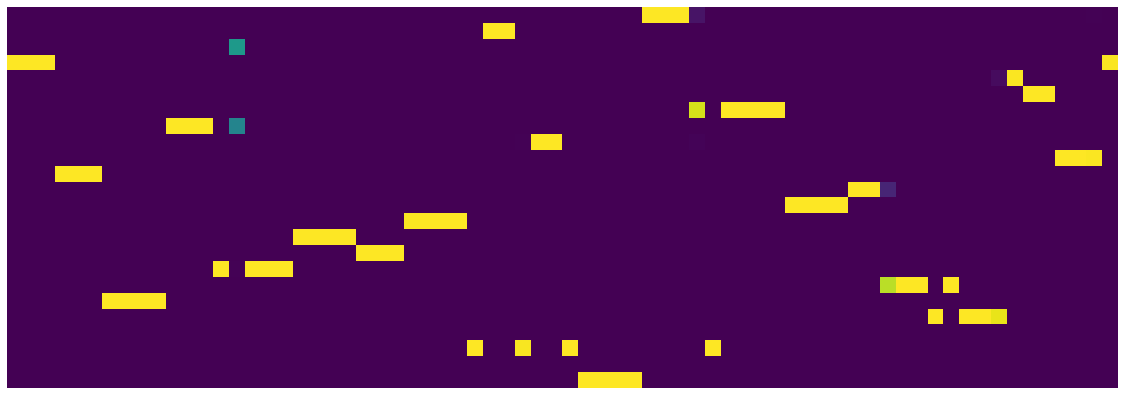

24 119 0.8799999999999999 0.5795609468594194


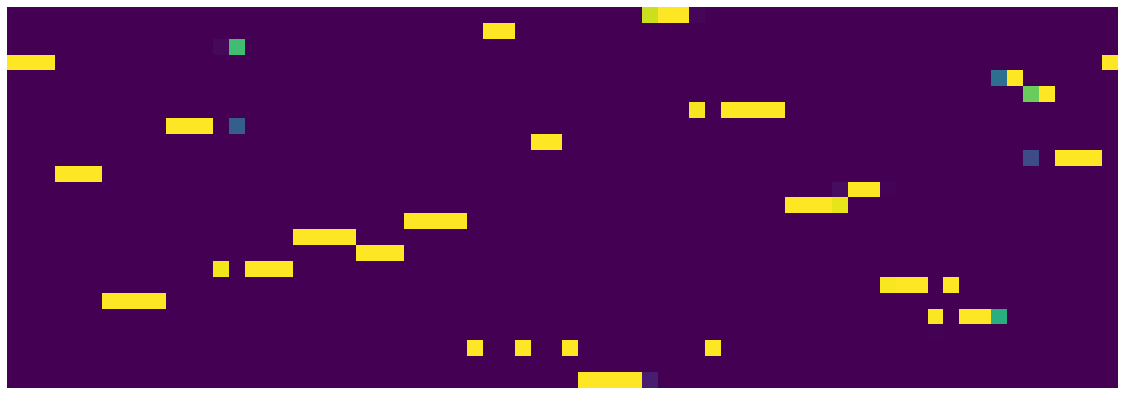

24 120 0.8789999999999999 0.5686587618663907


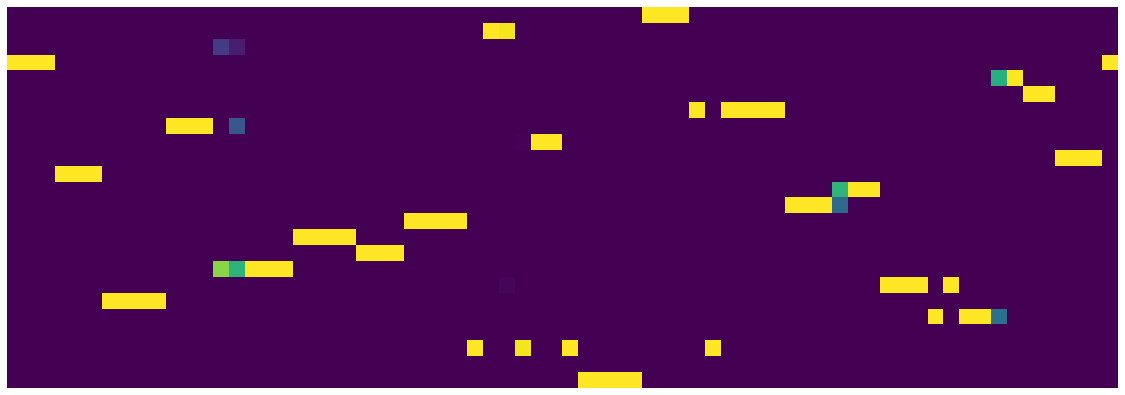

24 121 0.8779999999999999 0.5748057417571545


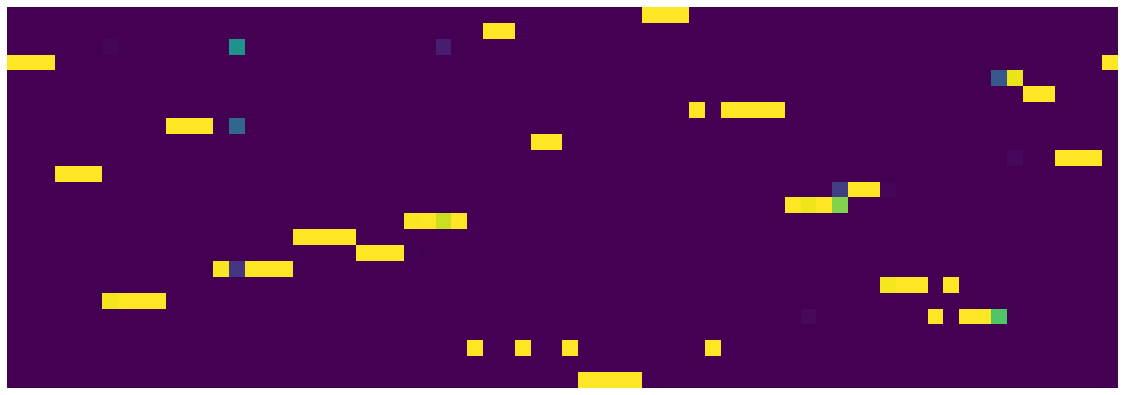

24 122 0.8769999999999999 0.5760159516707063


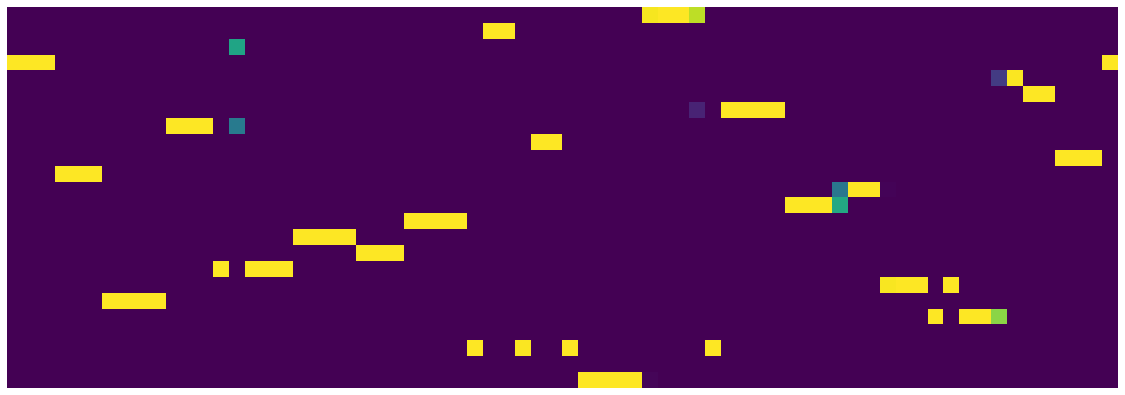

24 123 0.8759999999999999 0.5677520433440805


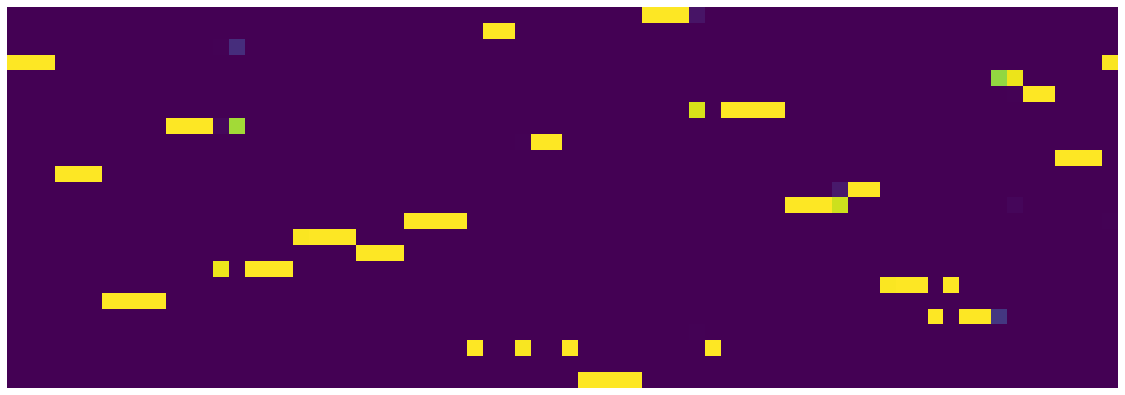

24 124 0.8749999999999999 0.5687210993841291


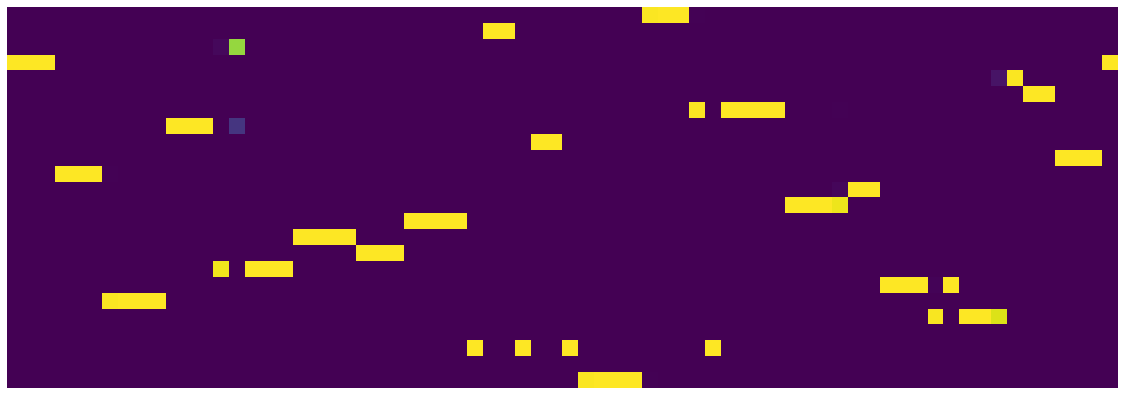

24 125 0.8739999999999999 0.5705001099035144


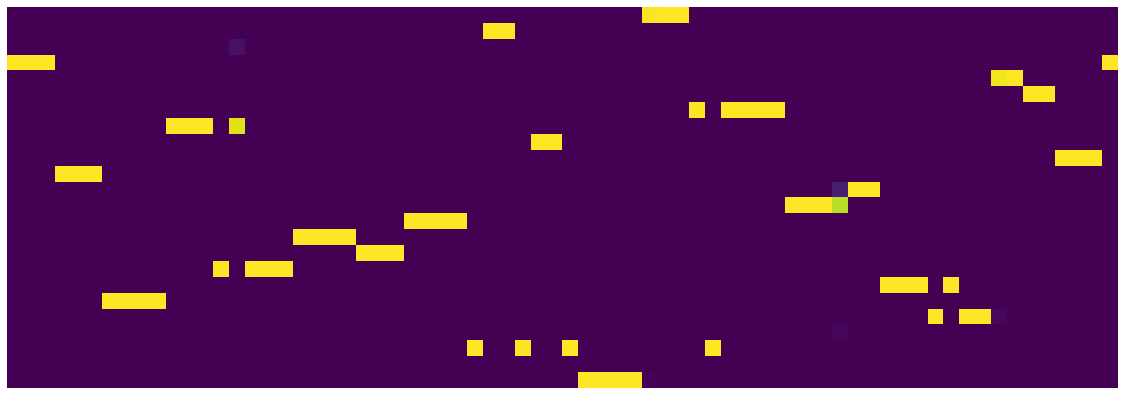

24 126 0.8729999999999999 0.5656914040446281


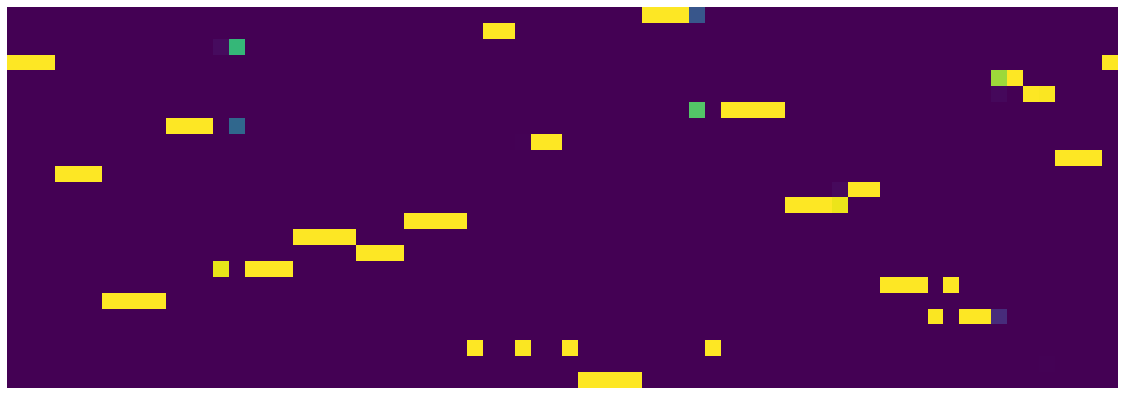

24 127 0.8719999999999999 0.5636458180844783


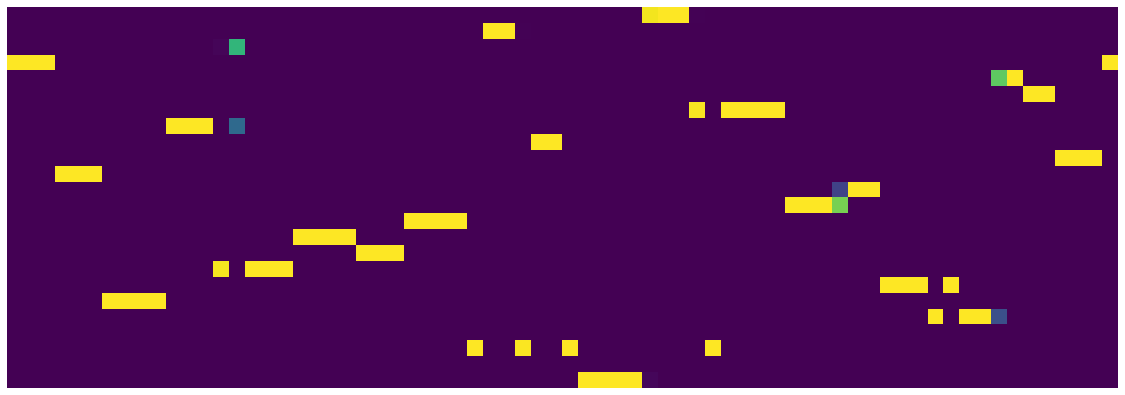

24 128 0.8709999999999999 0.5605889836326241


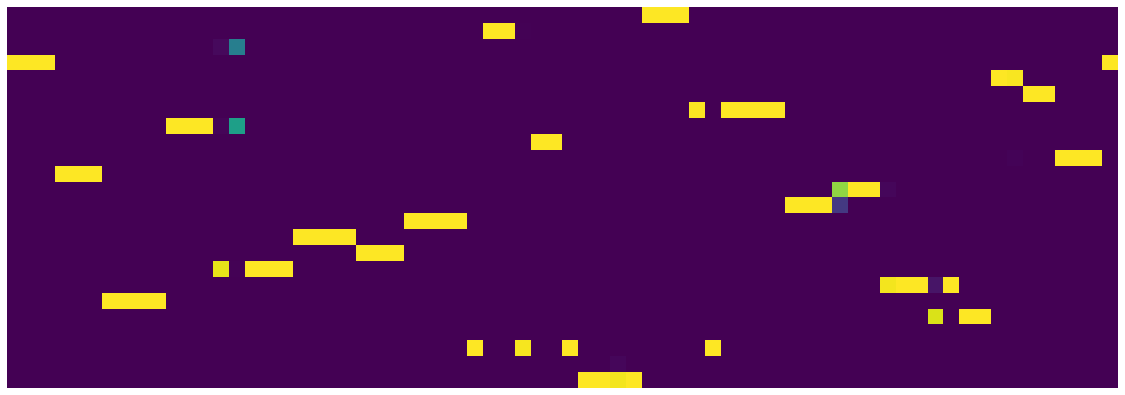

24 129 0.8699999999999999 0.5613037759438158


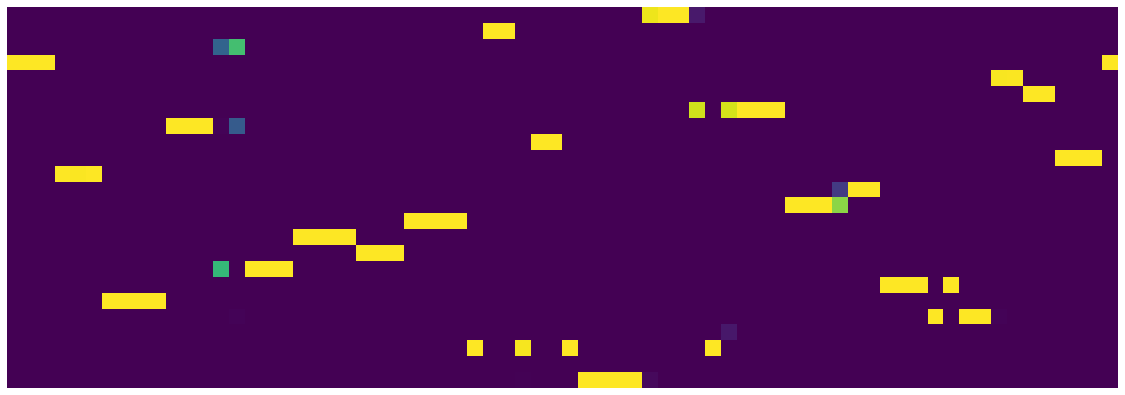

24 130 0.8689999999999999 0.5642602354288101


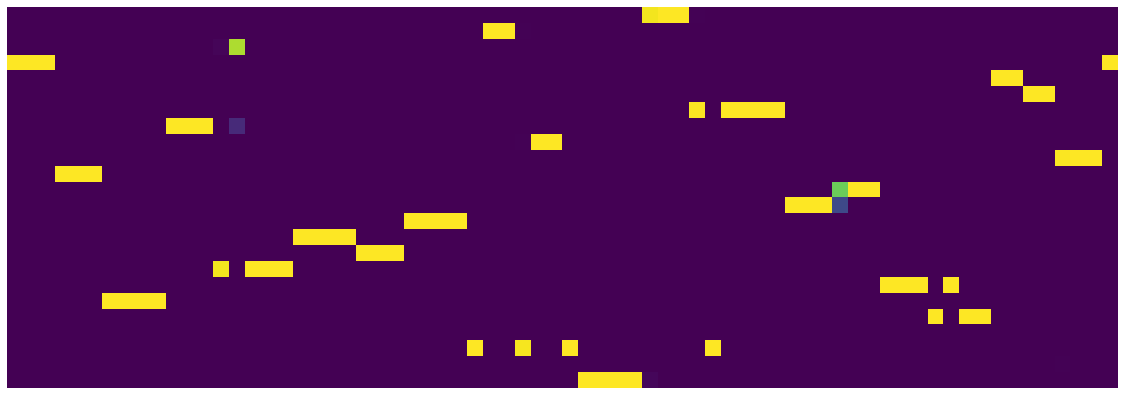

24 131 0.8679999999999999 0.5601461254060268


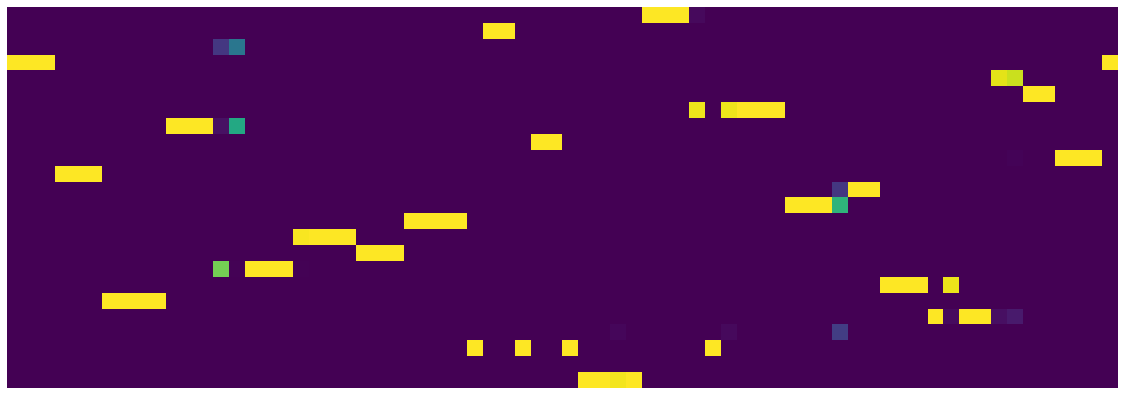

24 132 0.8669999999999999 0.5604484498500824


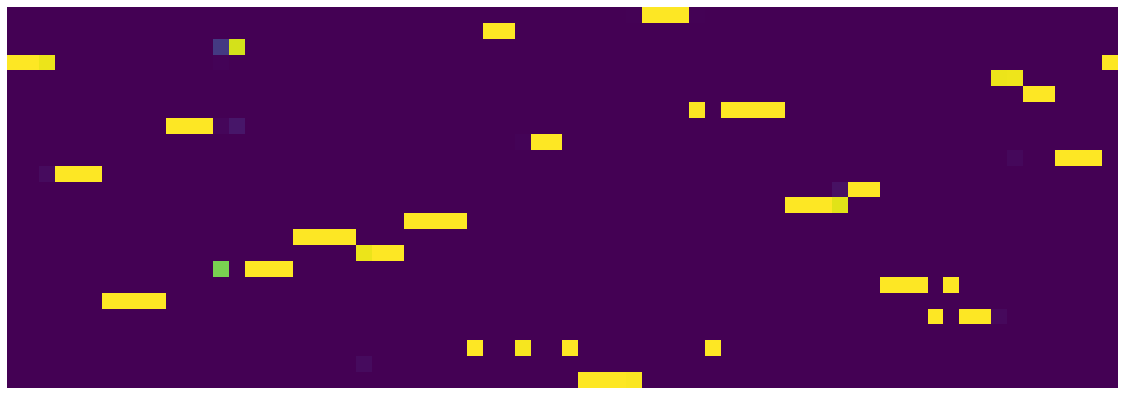

24 133 0.8659999999999999 0.5597487561404705


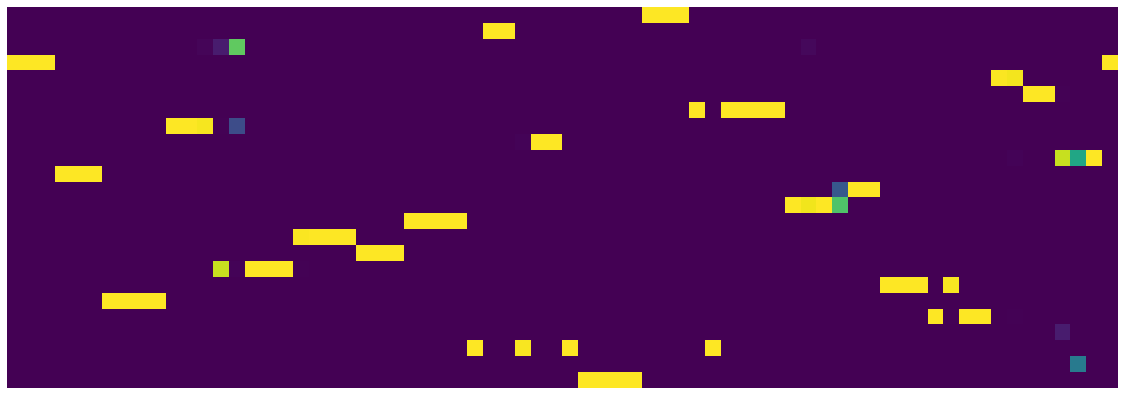

24 134 0.8649999999999999 0.5576854744926095


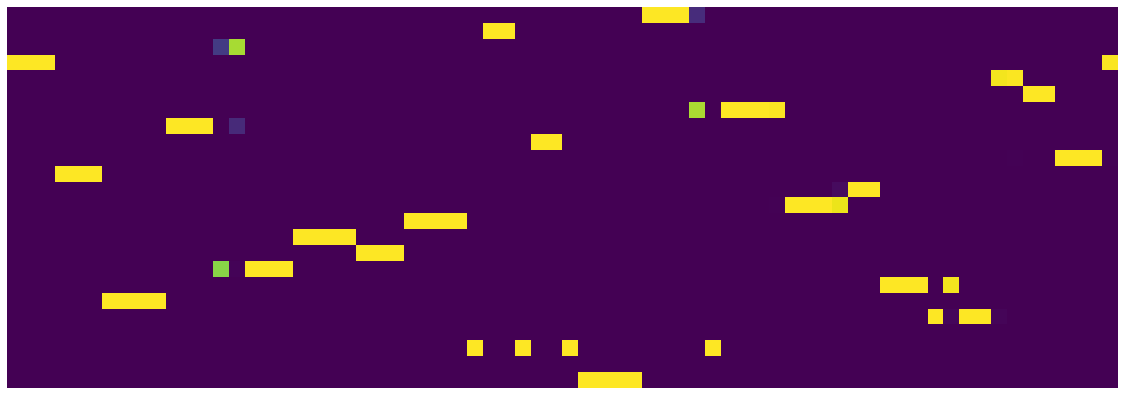

24 135 0.8639999999999999 0.5618093932047487


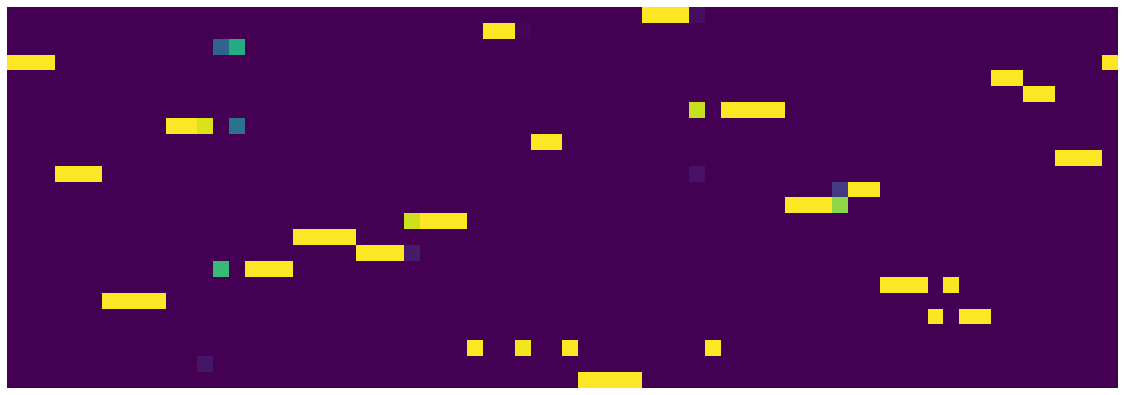

24 136 0.8629999999999999 0.5586062328889966


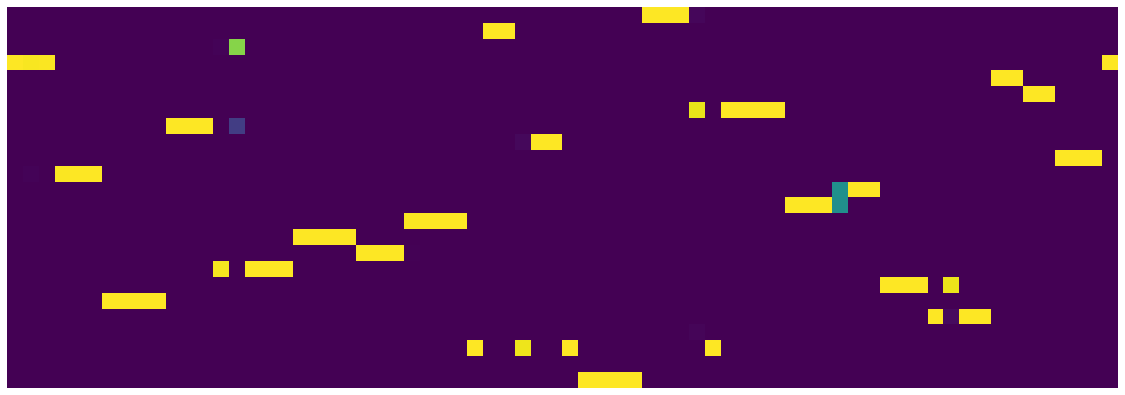

24 137 0.8619999999999999 0.5612637663260103


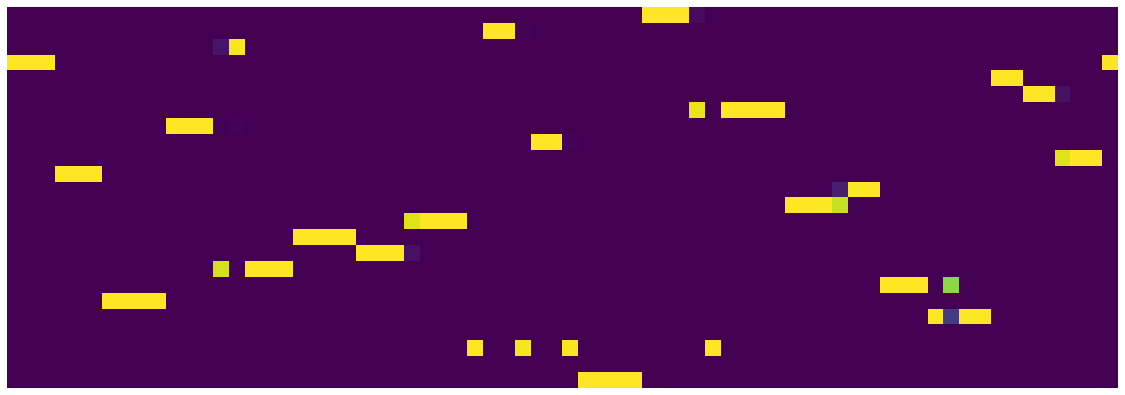

24 138 0.8609999999999999 0.5591290649026632


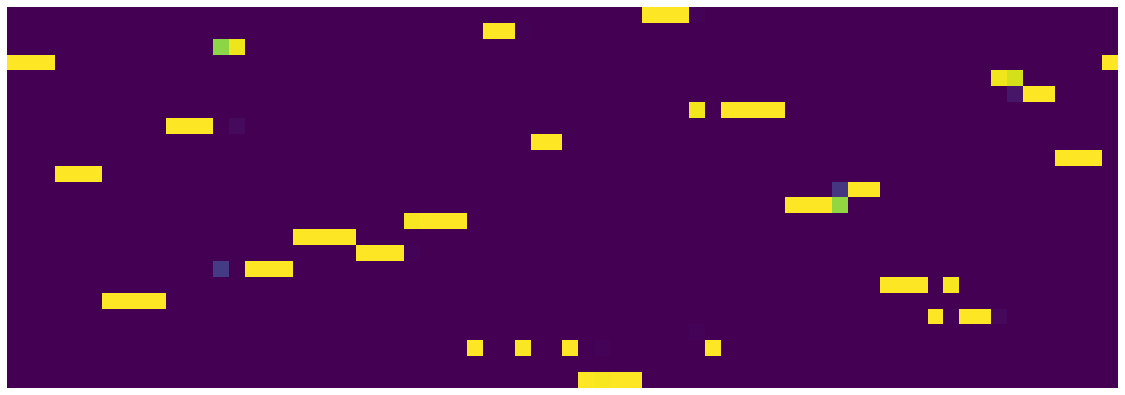

24 139 0.8599999999999999 0.5594198655337095


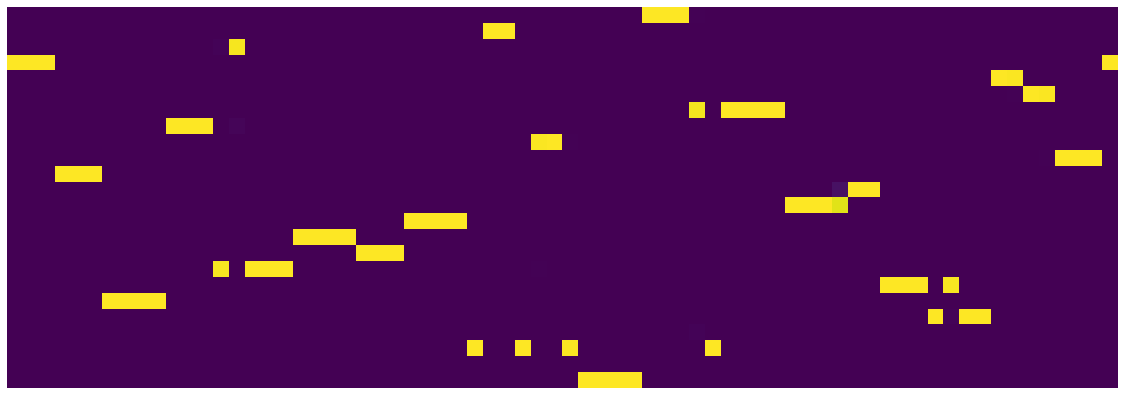

24 140 0.8589999999999999 0.5605660604313016


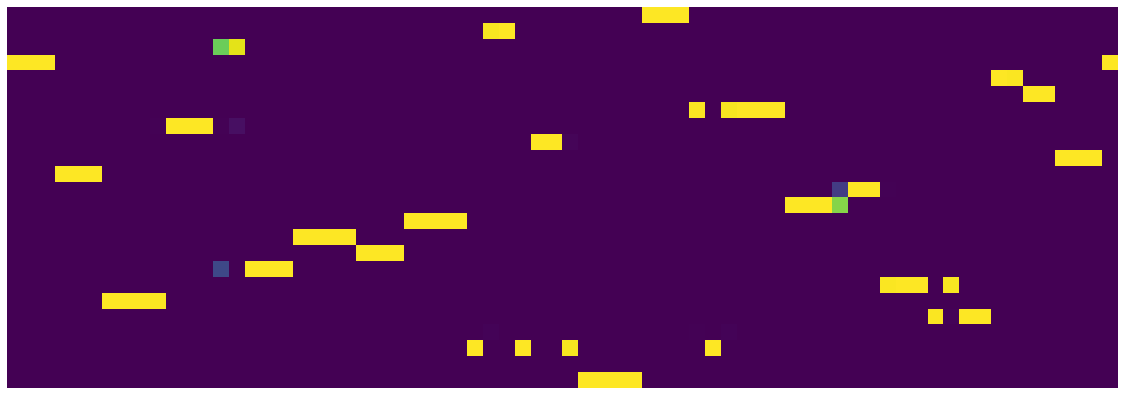

24 141 0.8579999999999999 0.5534518338739872


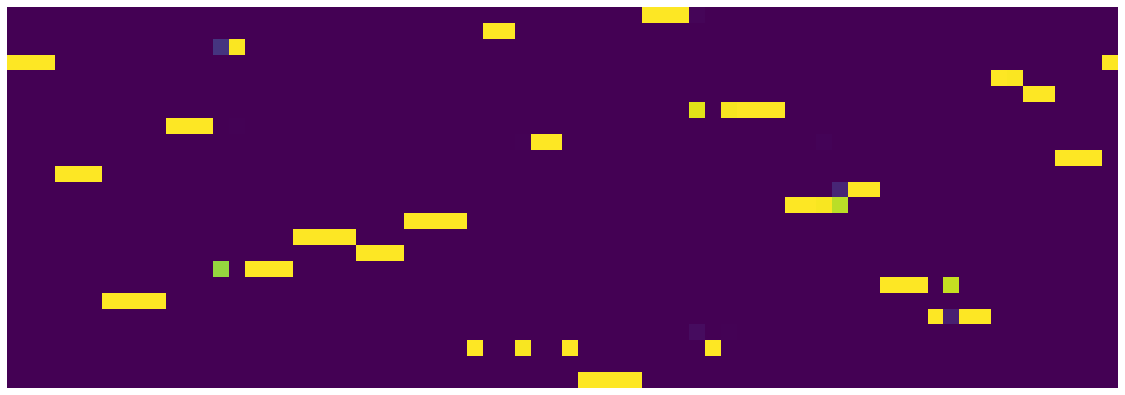

24 142 0.8569999999999999 0.549030727520585


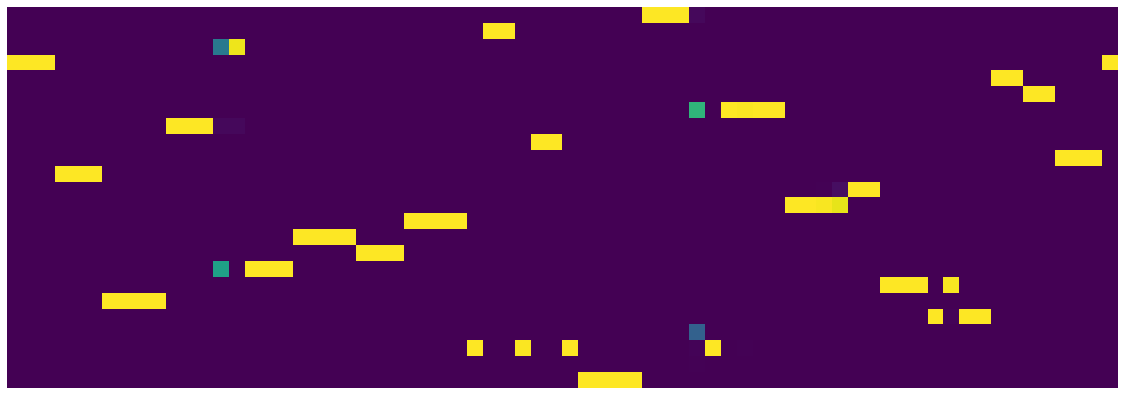

24 143 0.8559999999999999 0.5450989307835699


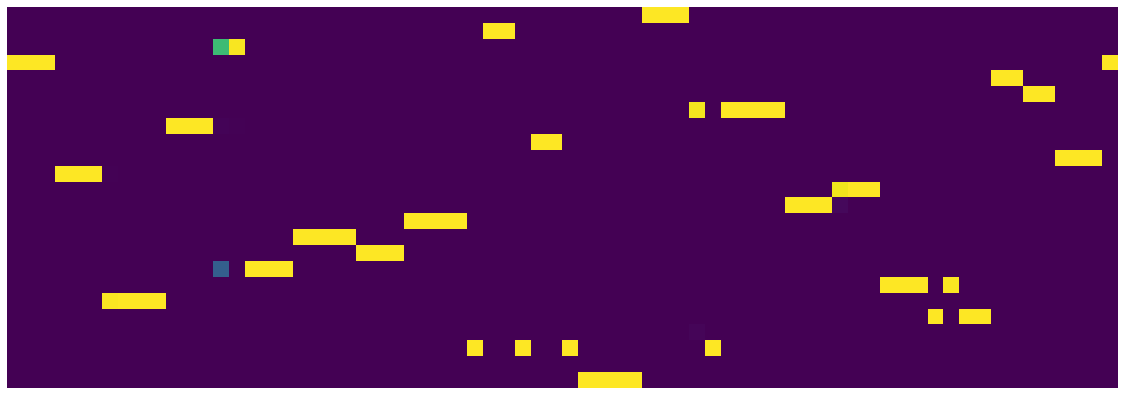

24 144 0.8549999999999999 0.5413169544190168


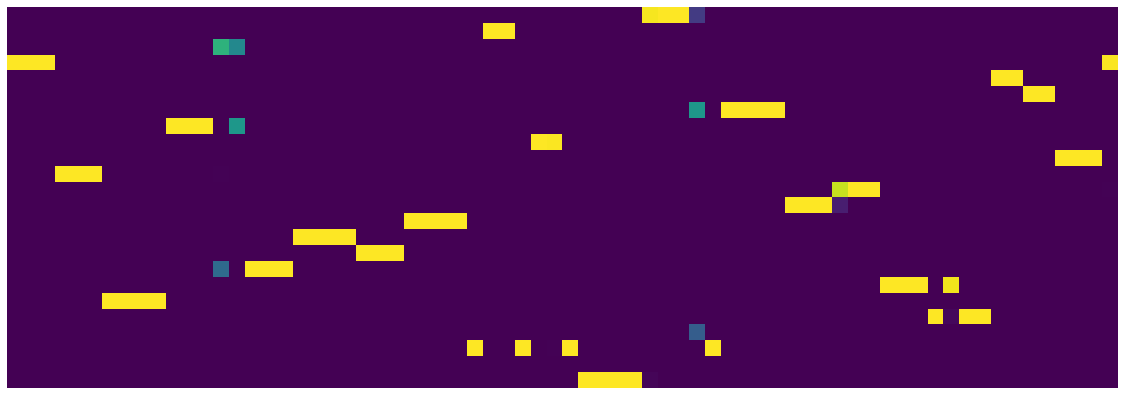

24 145 0.8539999999999999 0.5324858218431473


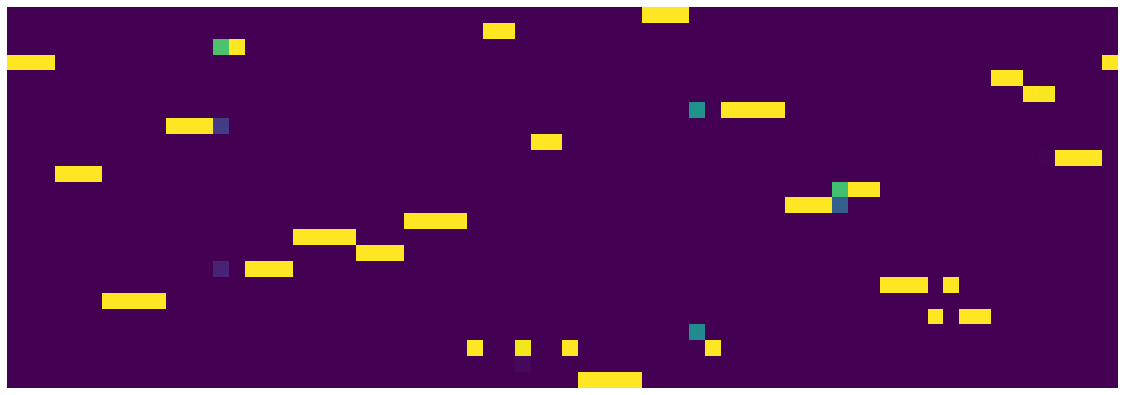

24 146 0.8529999999999999 0.5351055201143027


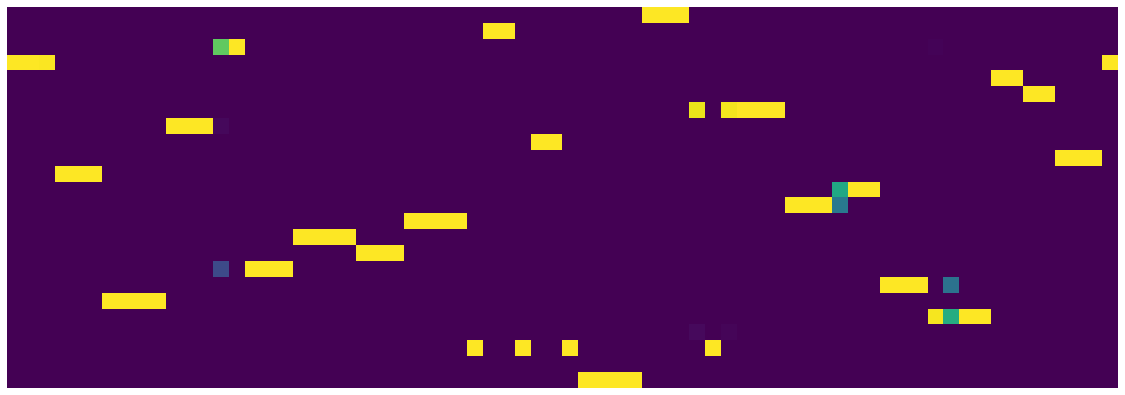

24 147 0.8519999999999999 0.5268482582643628


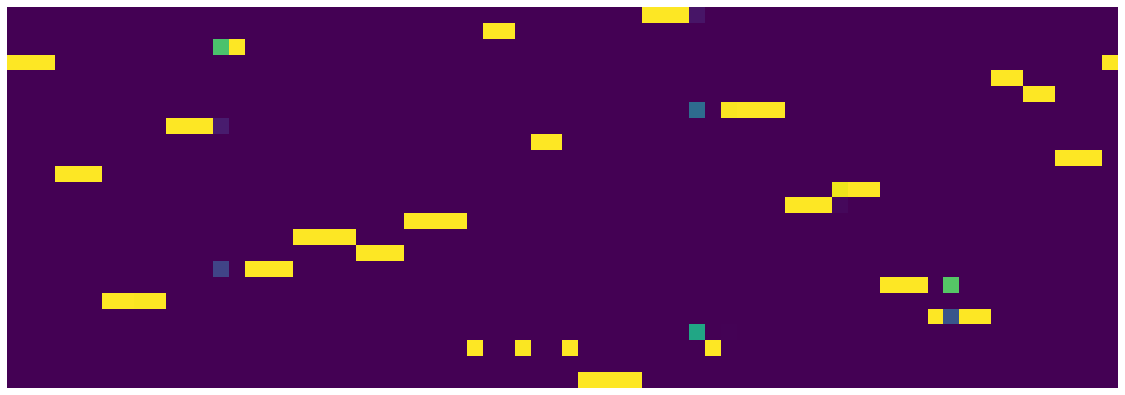

24 148 0.8509999999999999 0.5276763360947371


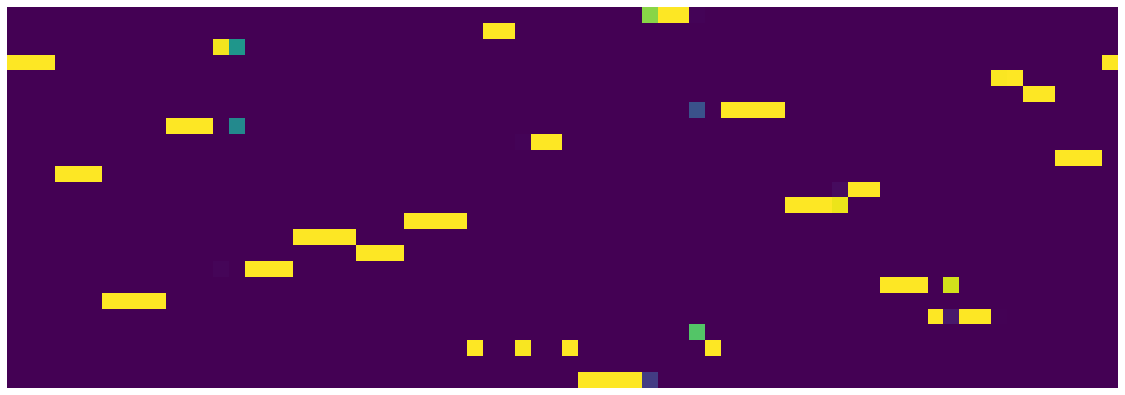

24 149 0.8499999999999999 0.5242991130799055


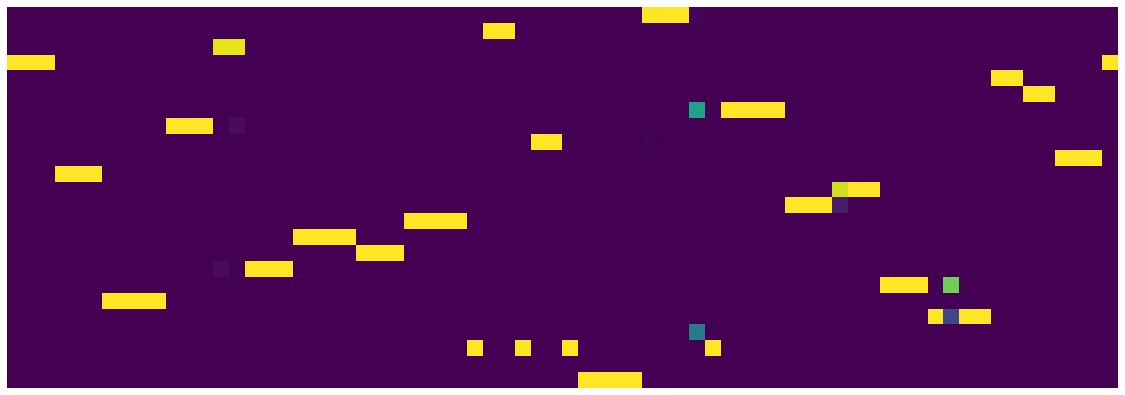

24 150 0.8489999999999999 0.5164941342547535


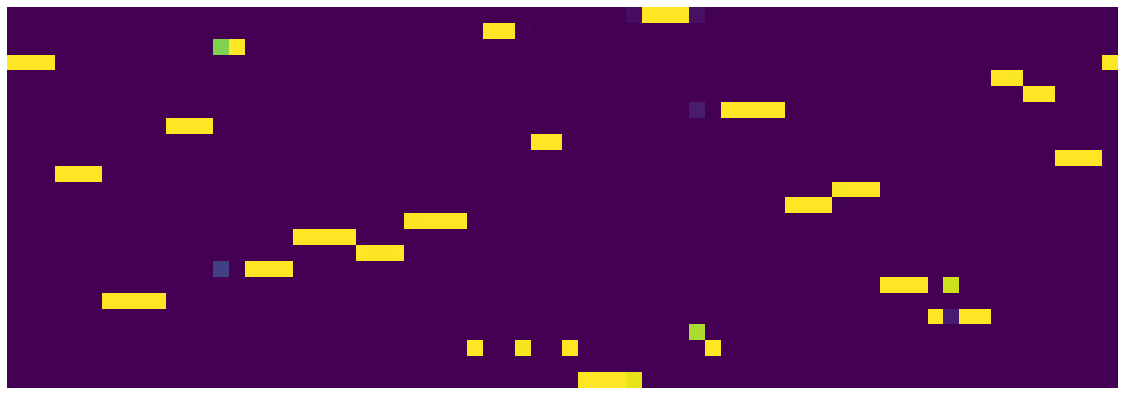

24 151 0.8479999999999999 0.5239534301683306


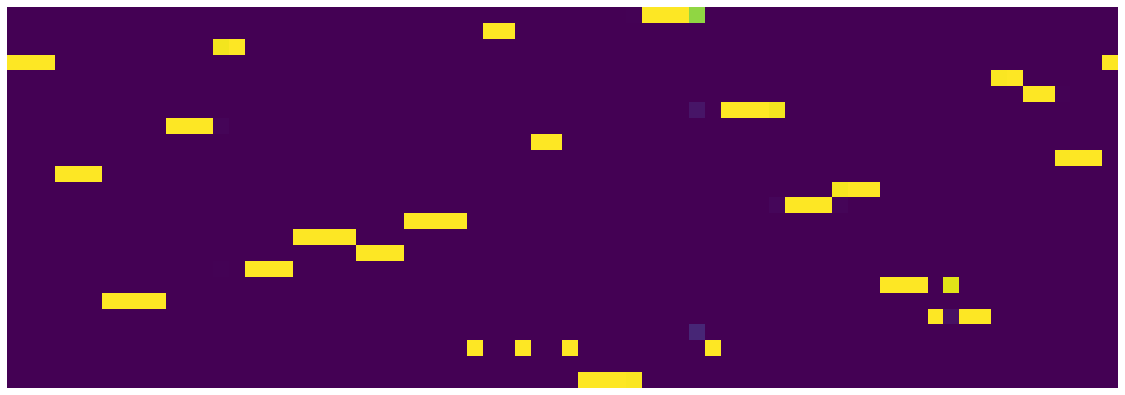

24 152 0.8469999999999999 0.5186067773029208


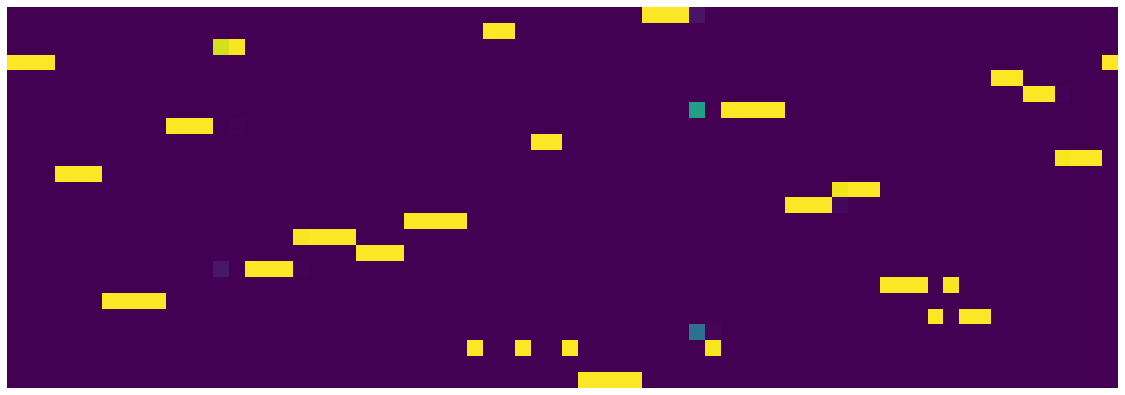

24 153 0.8459999999999999 0.5165824538096786


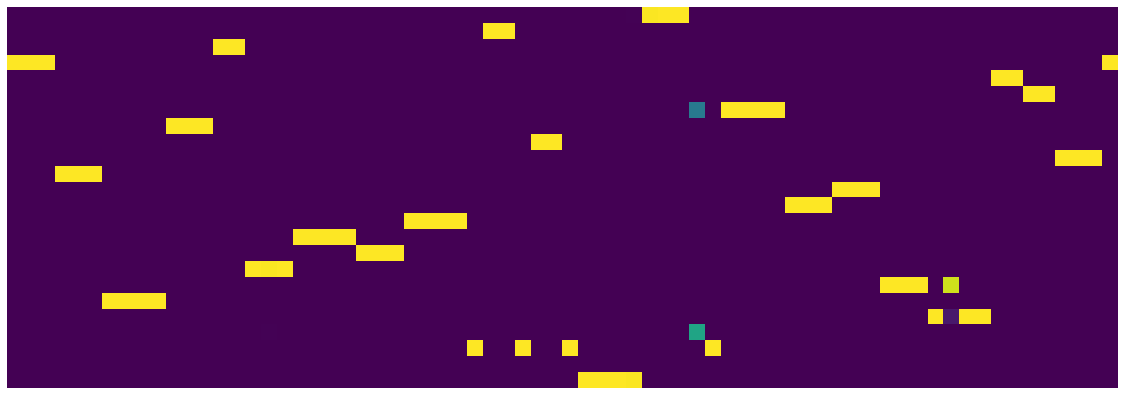

24 154 0.8449999999999999 0.515676836296916


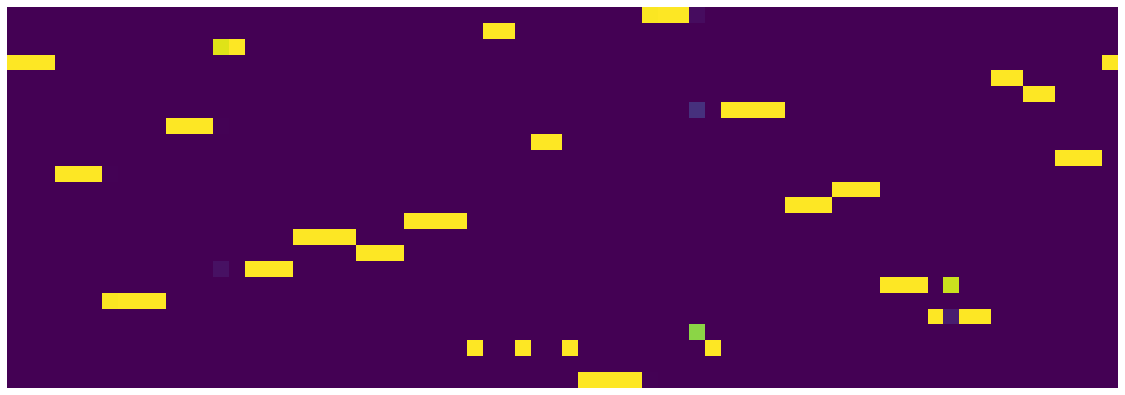

24 155 0.8439999999999999 0.5135477773845196


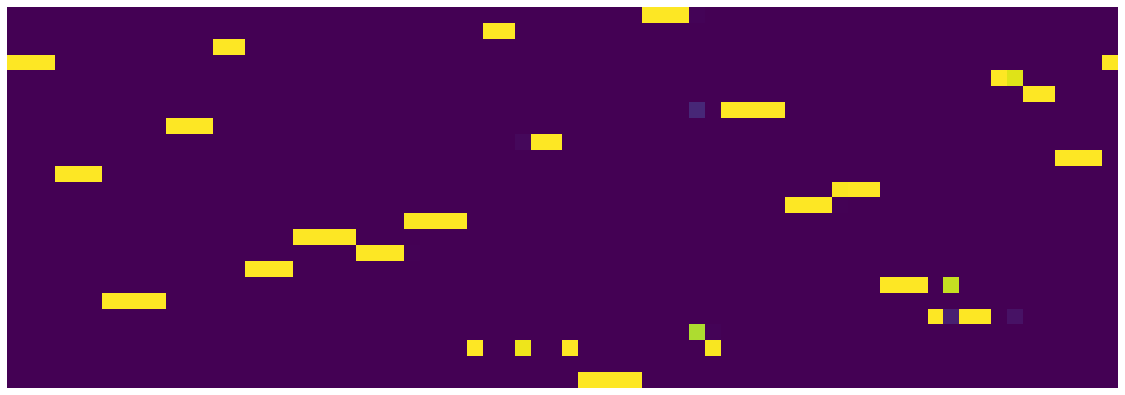

24 156 0.8429999999999999 0.5163596555590629


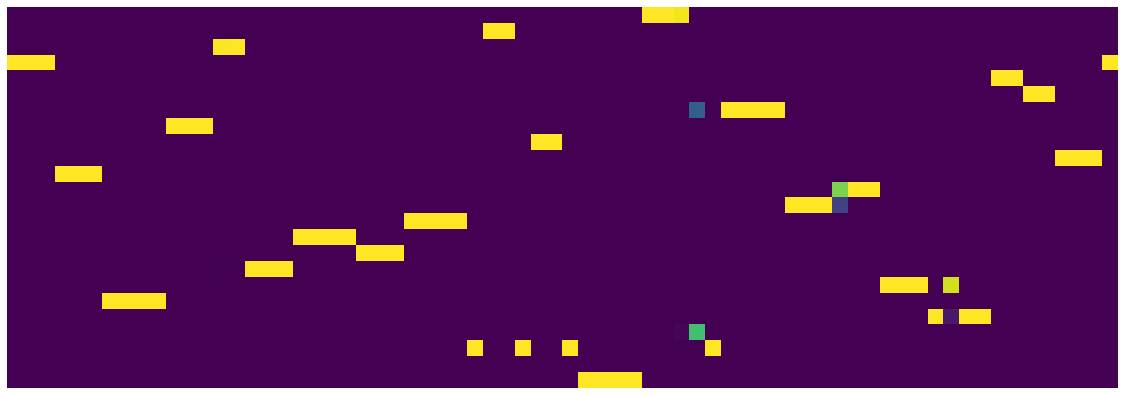

24 157 0.8419999999999999 0.5144784966483712


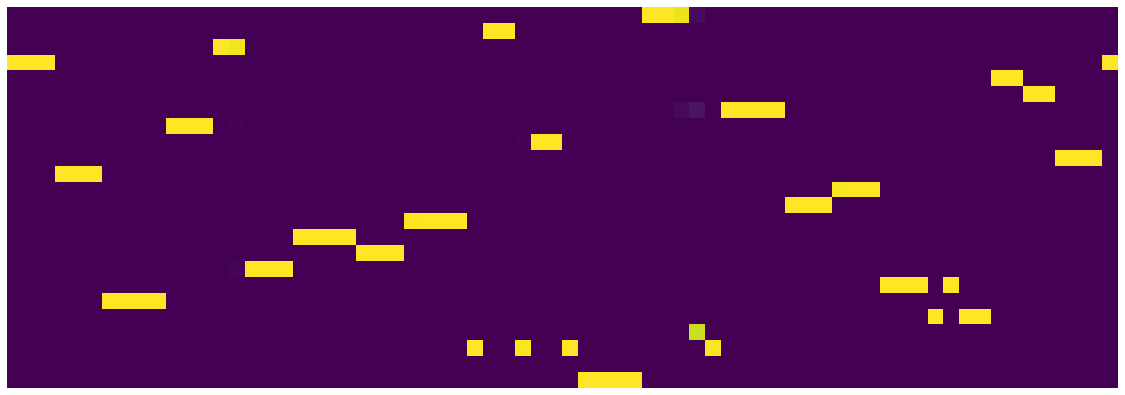

24 158 0.8409999999999999 0.5126331739127636


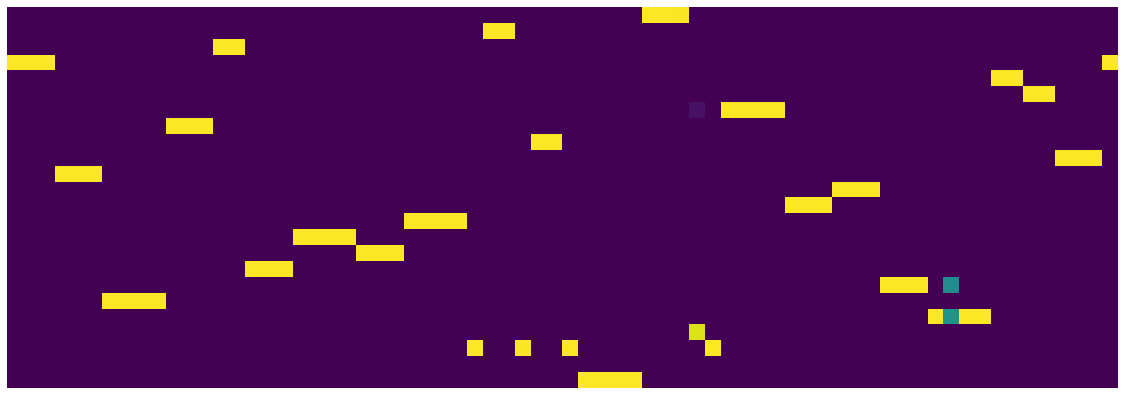

24 159 0.8399999999999999 0.5120631581172347


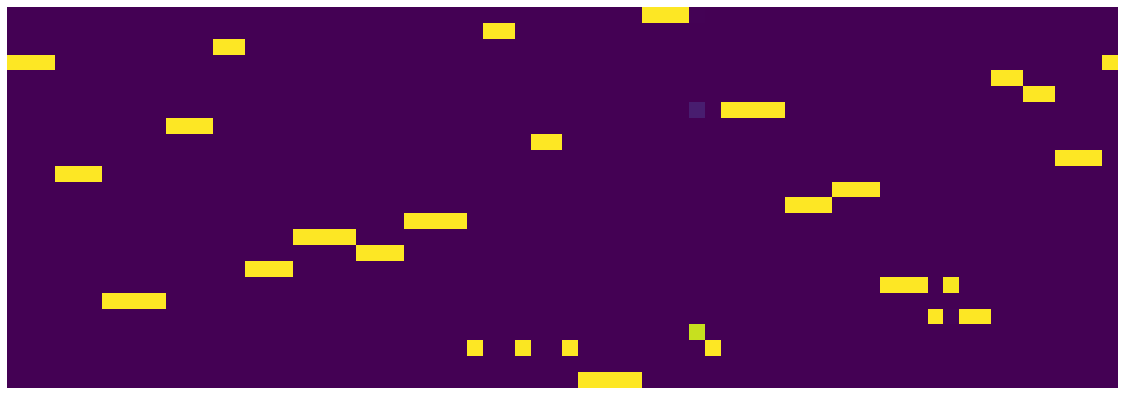

24 160 0.8389999999999999 0.5124802945181728


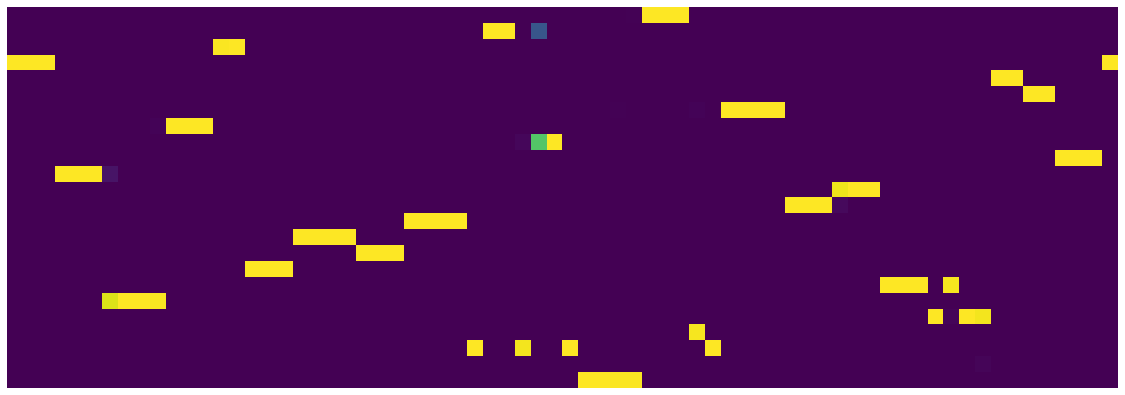

24 161 0.8379999999999999 0.5114600416272879


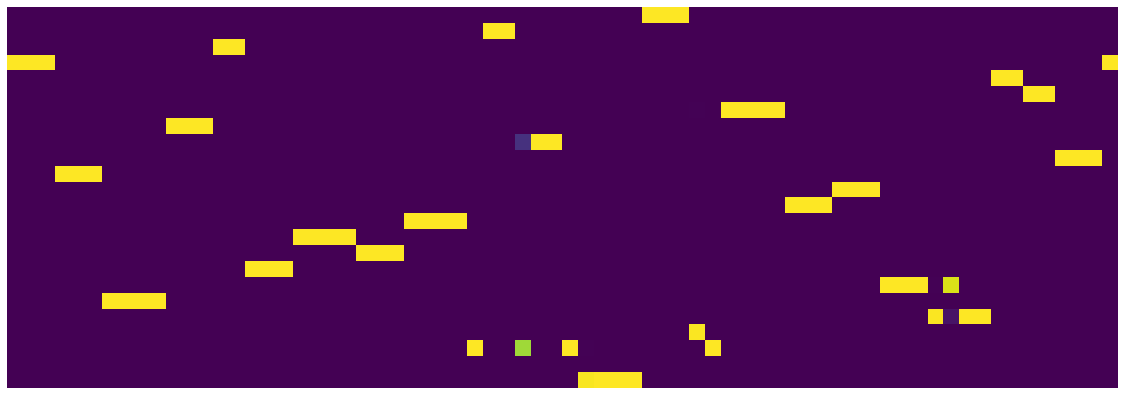

24 162 0.8369999999999999 0.5128600861877203


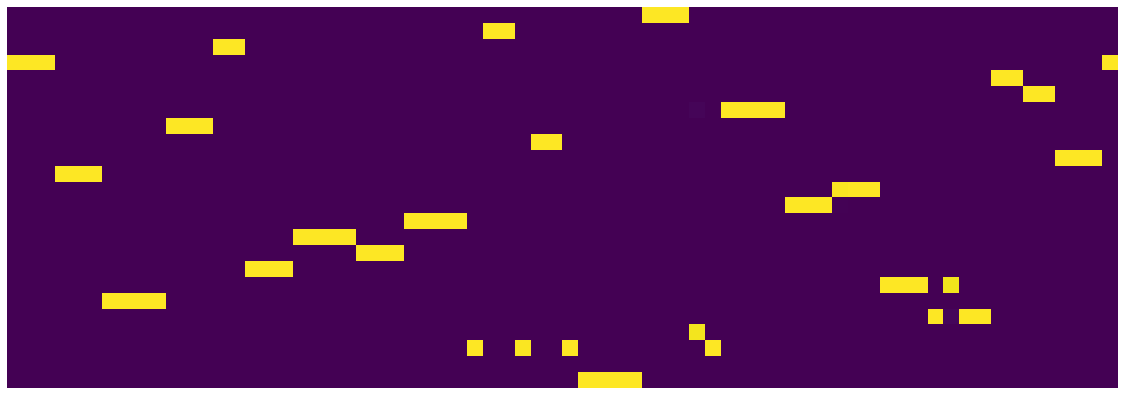

24 163 0.8359999999999999 0.5125007685273886


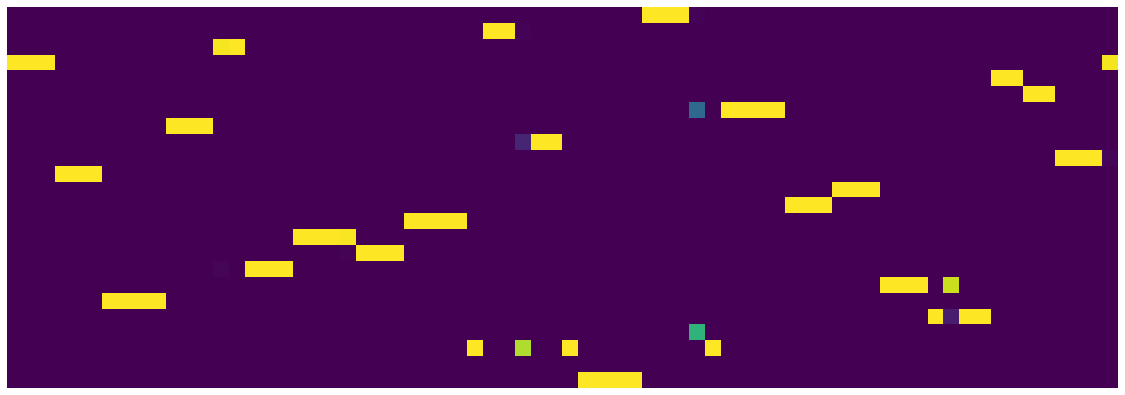

24 164 0.8349999999999999 0.5117324786260724


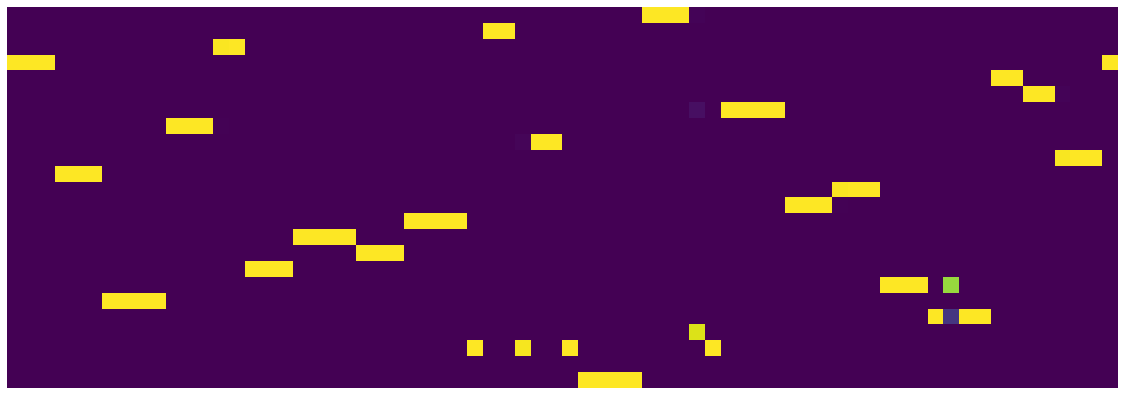

24 165 0.8339999999999999 0.5111897861585021


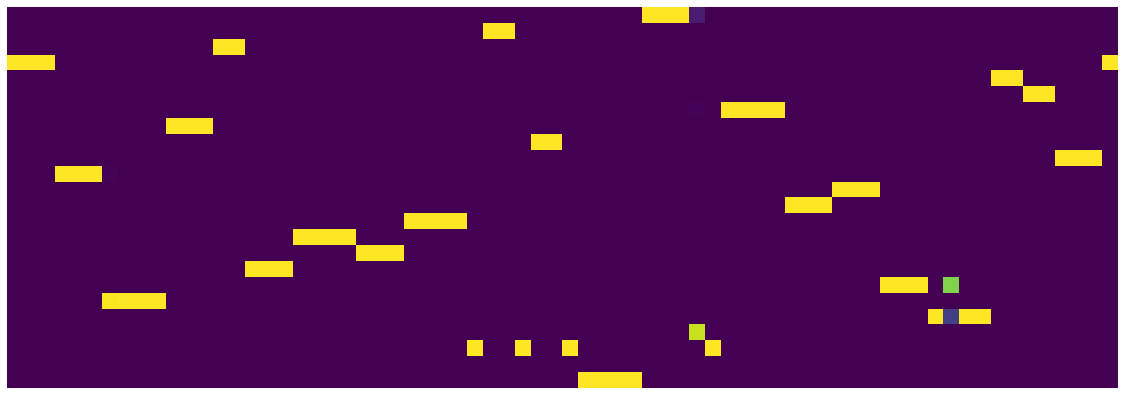

24 166 0.8329999999999999 0.5107238437980414


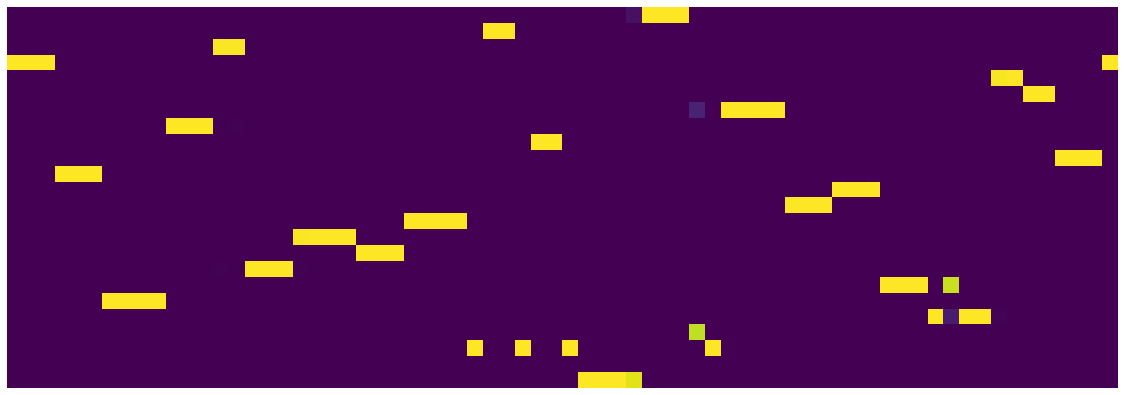

24 167 0.8319999999999999 0.5119748253375291


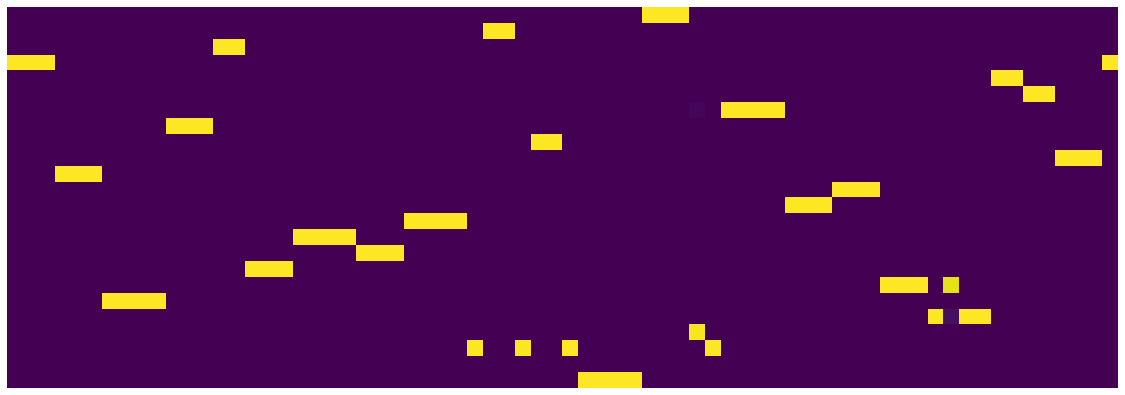

24 168 0.8309999999999998 0.5105059808120131


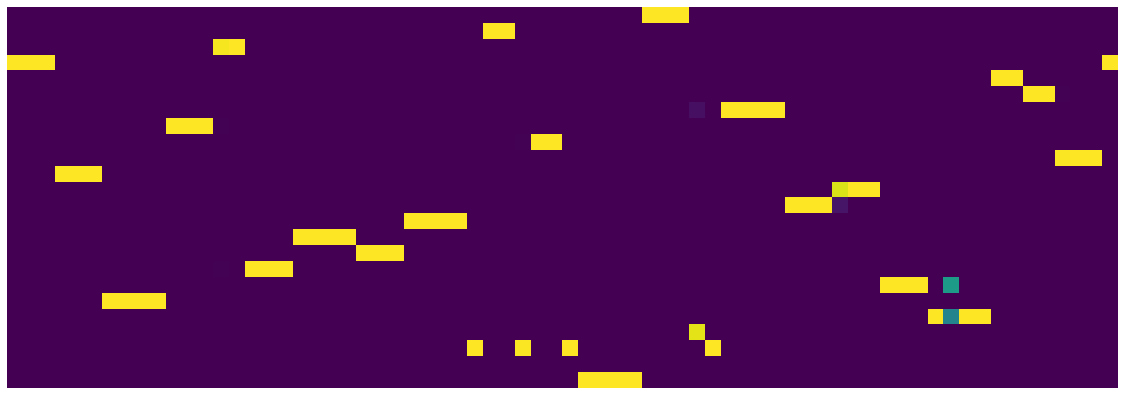

24 169 0.8299999999999998 0.5110121248289943


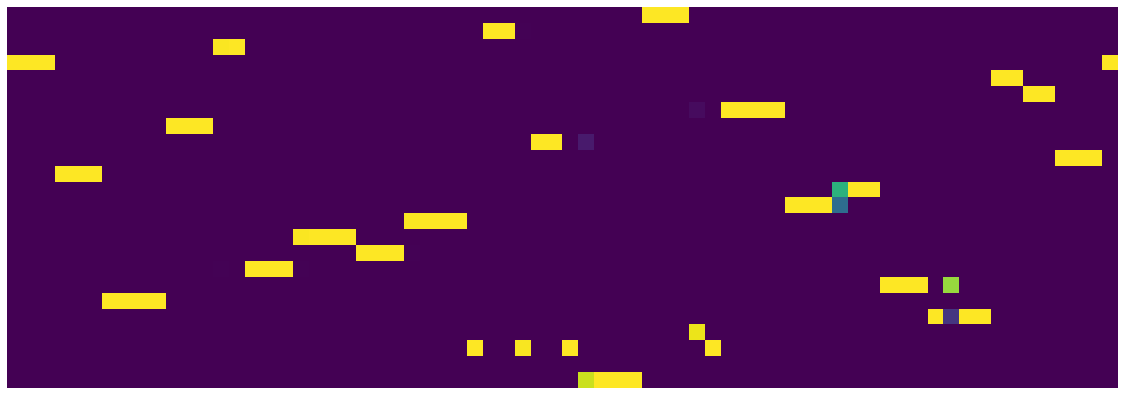

24 170 0.8289999999999998 0.5116559671238065


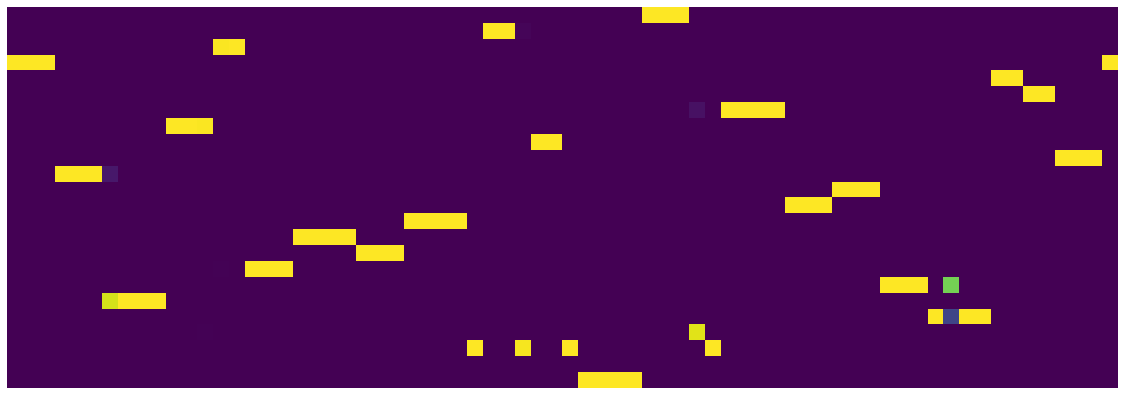

24 171 0.8279999999999998 0.5111015062779188


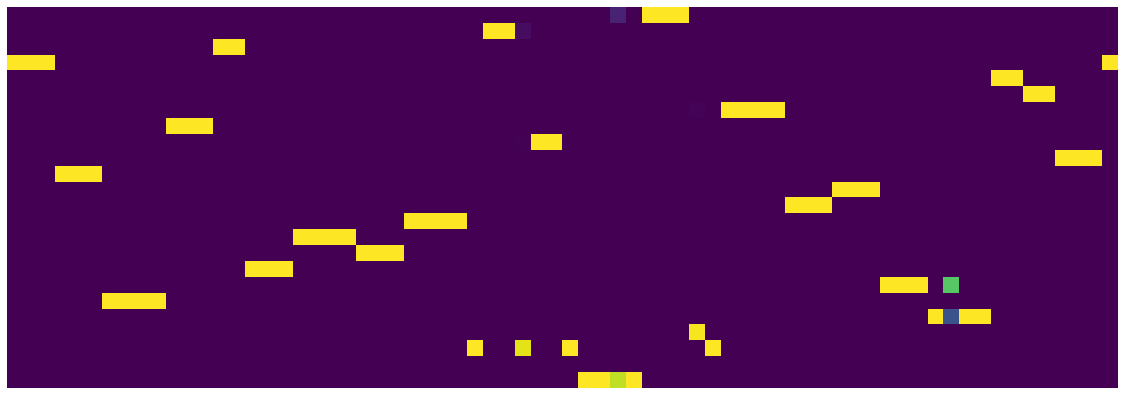

24 172 0.8269999999999998 0.5106225084513426


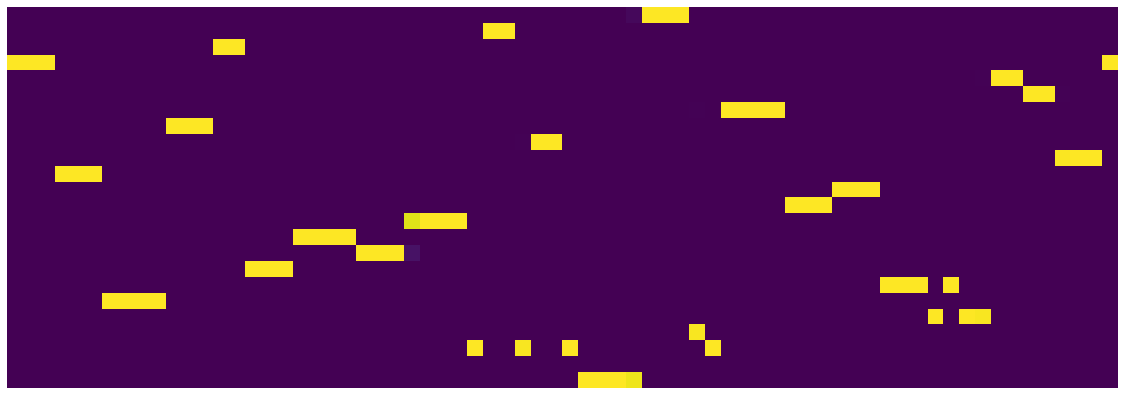

24 173 0.8259999999999998 0.5108551263809205


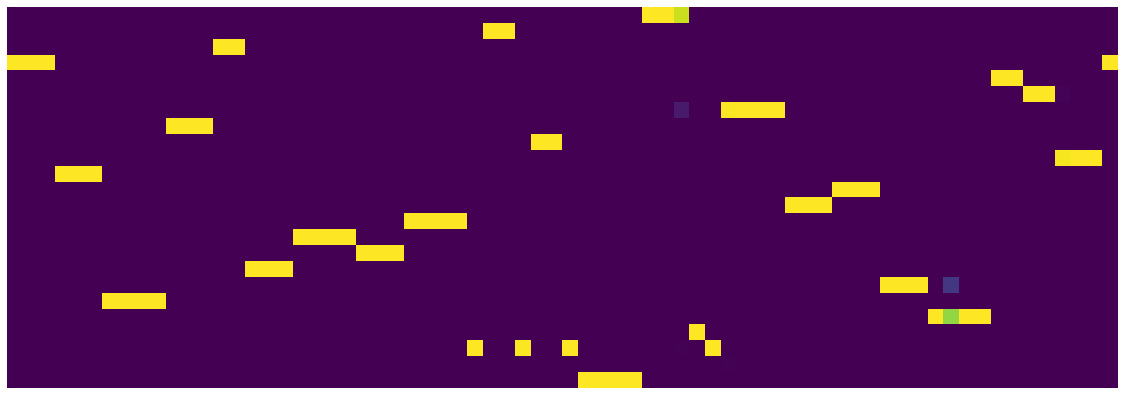

24 174 0.8249999999999998 0.5108370207250118


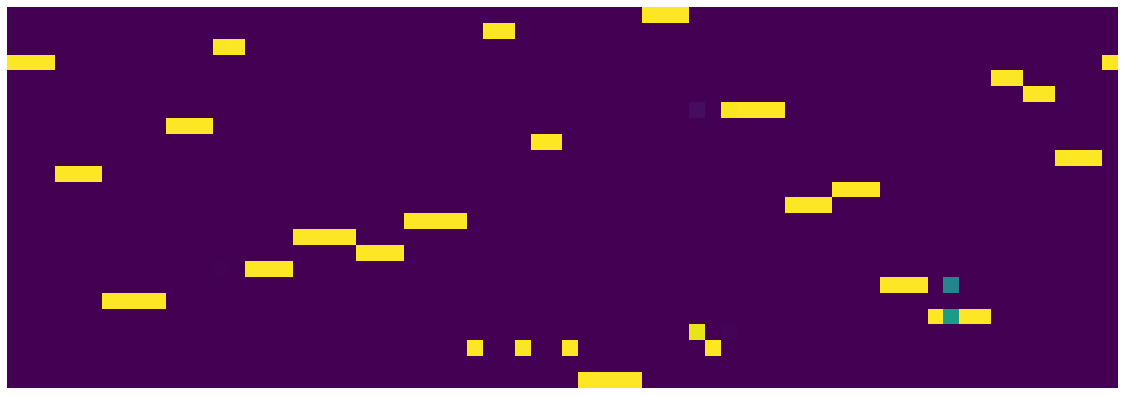

24 175 0.8239999999999998 0.5087120961397886


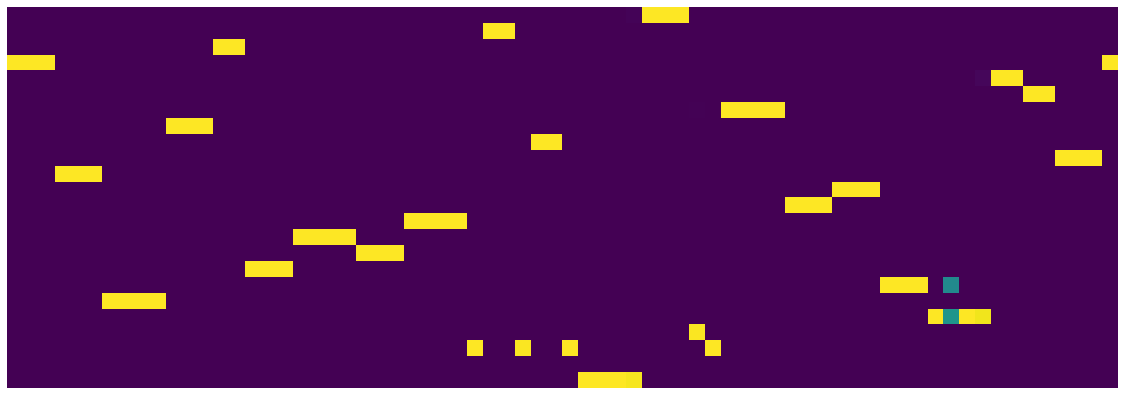

24 176 0.8229999999999998 0.5107322592288256


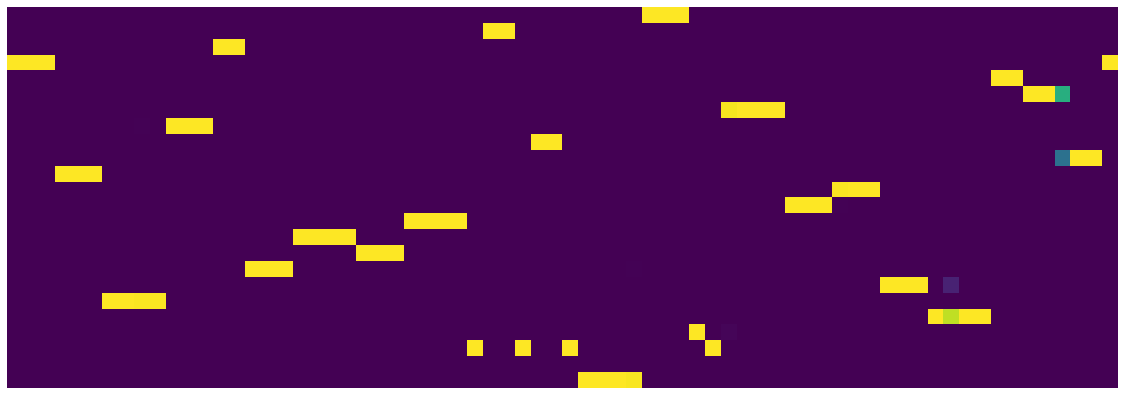

24 177 0.8219999999999998 0.5106303298845887


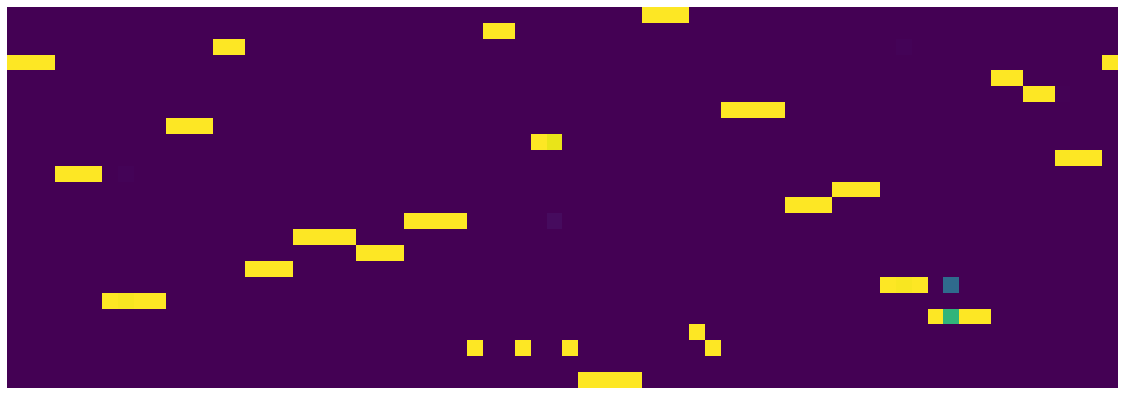

24 178 0.8209999999999998 0.508573236875236


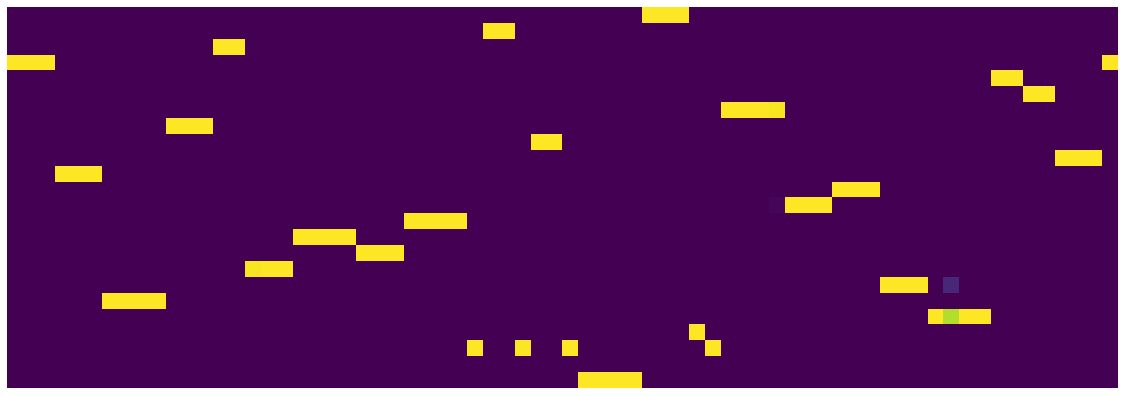

24 179 0.8199999999999998 0.5074644546955824


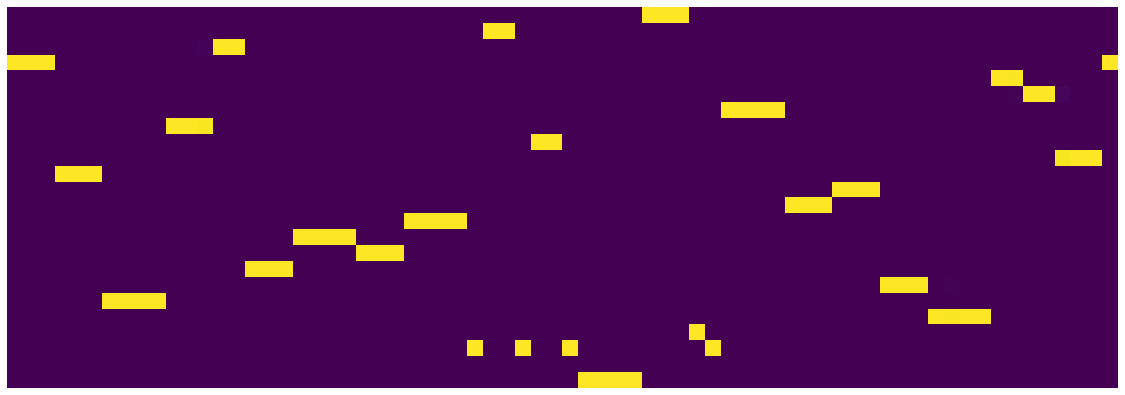

24 180 0.8189999999999998 0.509431422315538


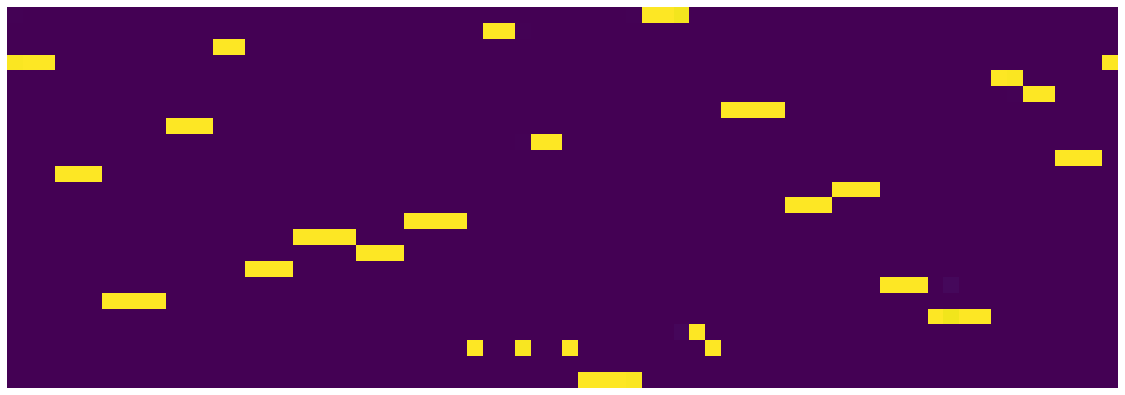

24 181 0.8179999999999998 0.507723773829639


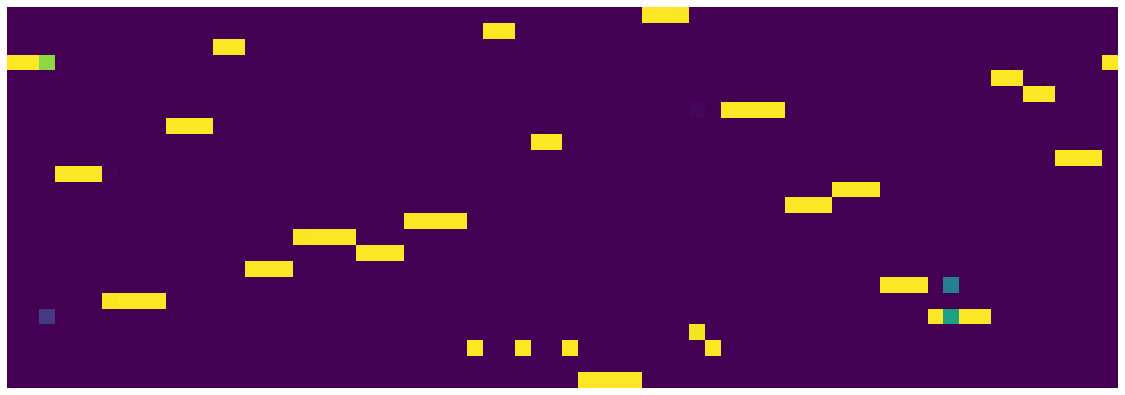

24 182 0.8169999999999998 0.5070835018530488


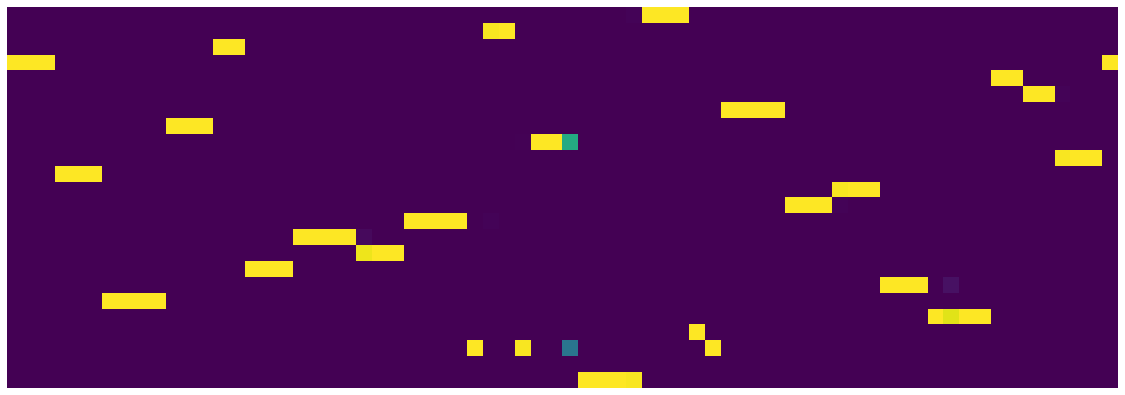

24 183 0.8159999999999998 0.5071936659514904


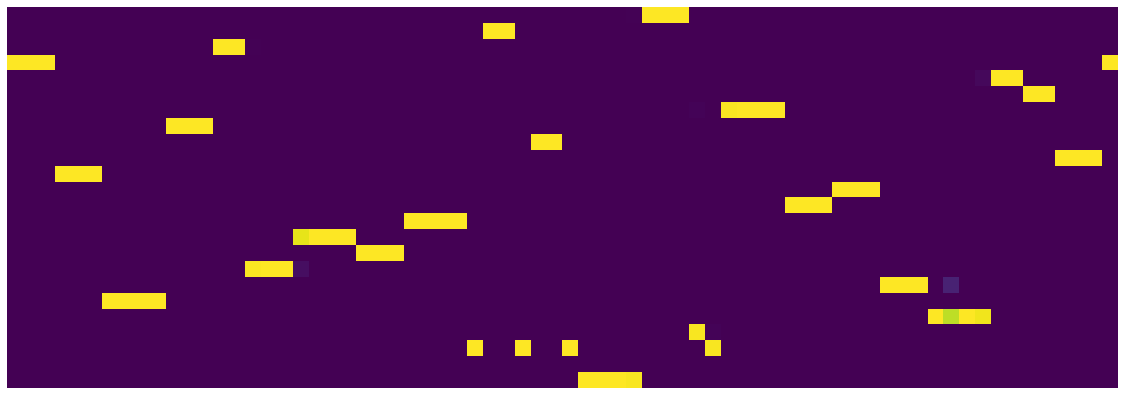

24 184 0.8149999999999998 0.5048832863569259


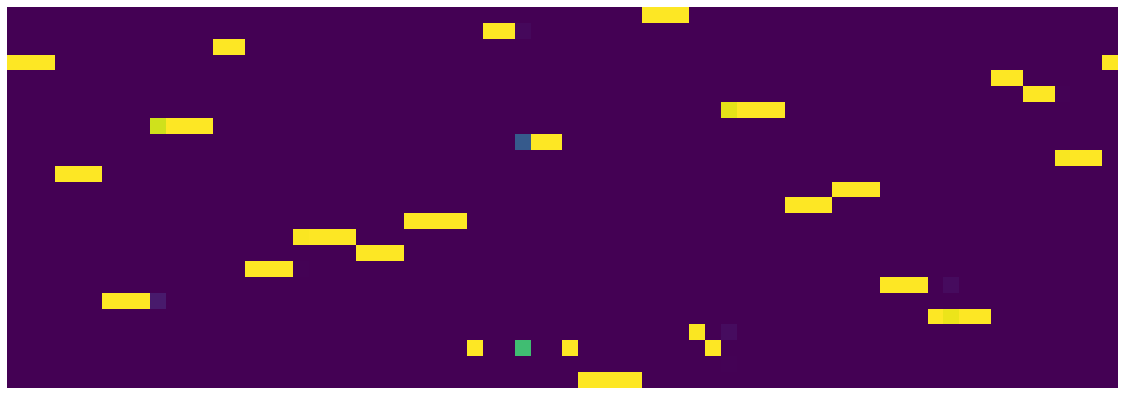

24 185 0.8139999999999998 0.5072737492620945


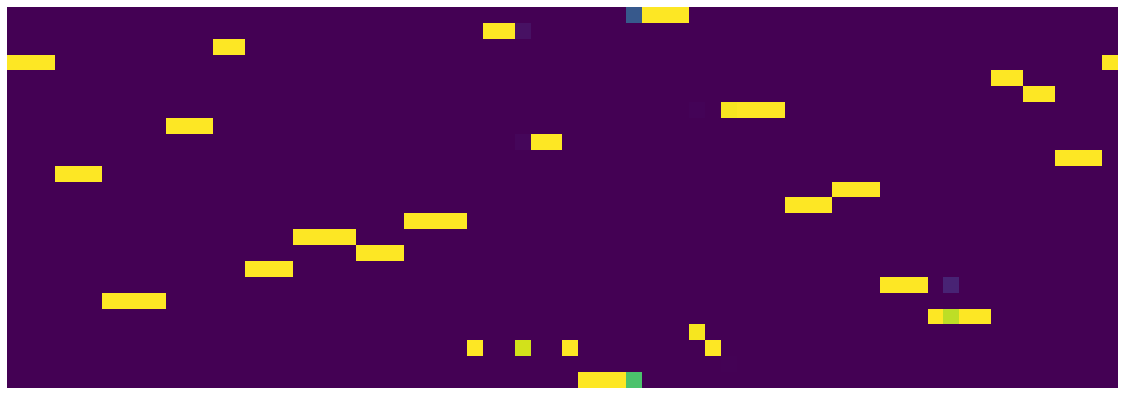

24 186 0.8129999999999998 0.5060690524056554


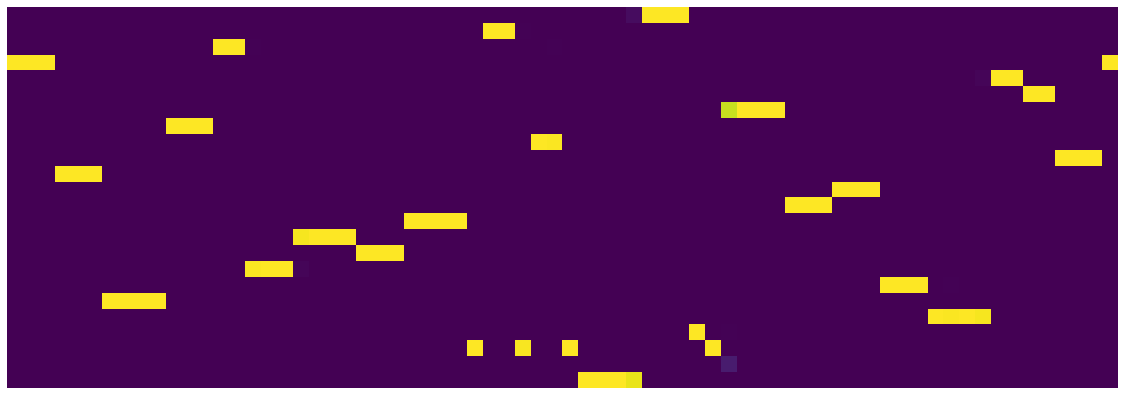

24 187 0.8119999999999998 0.5028557544574142


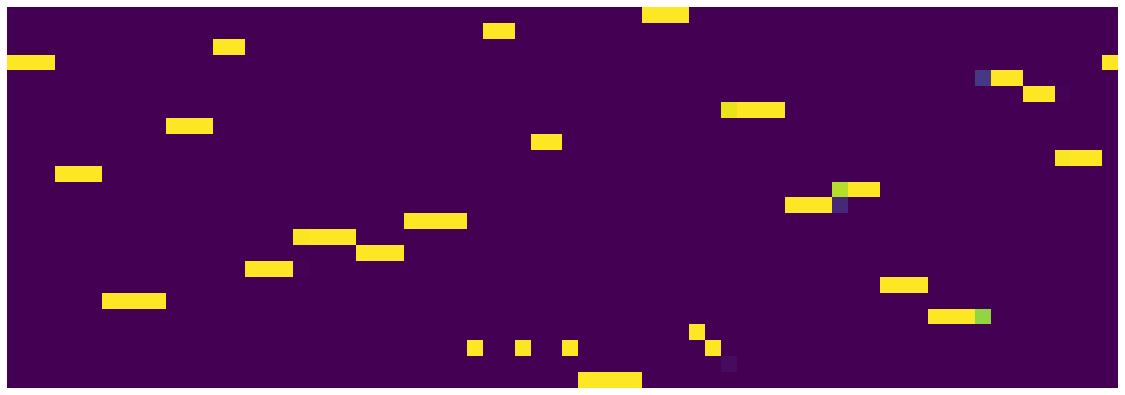

24 188 0.8109999999999998 0.5002624087035656


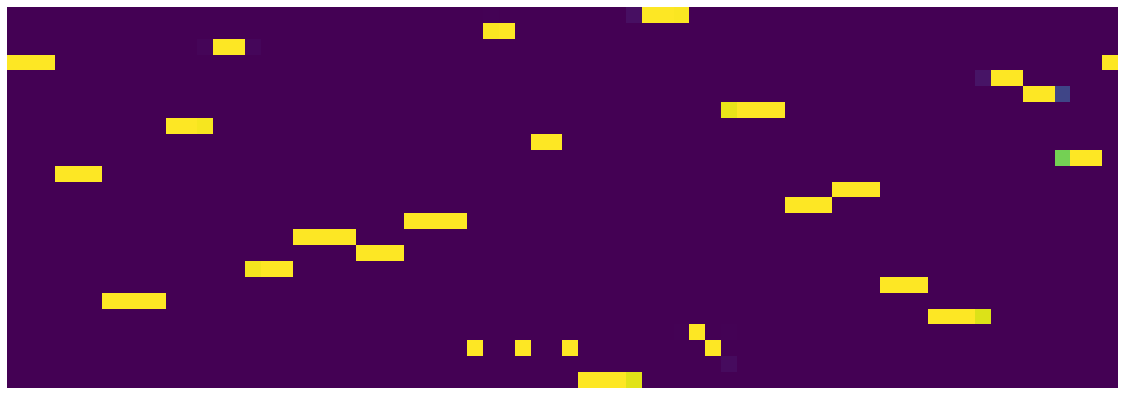

24 189 0.8099999999999998 0.4960702685639262


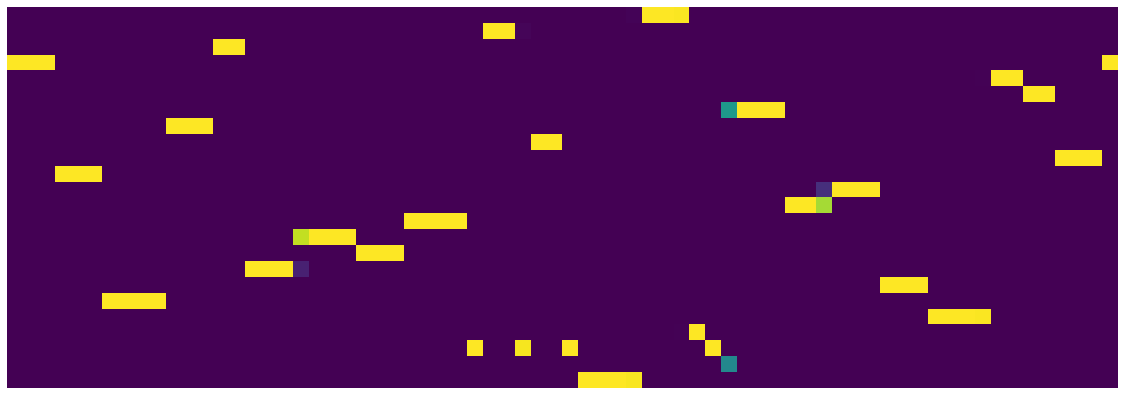

24 190 0.8089999999999998 0.4910823475569487


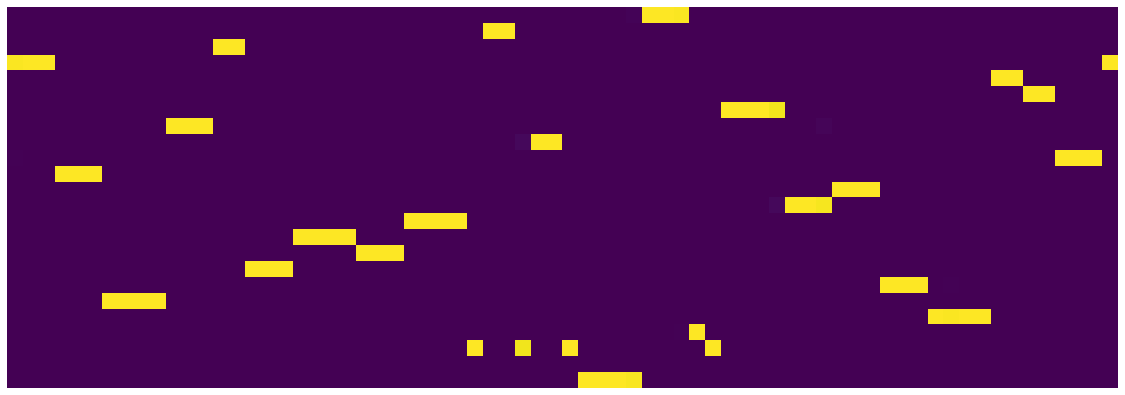

24 191 0.8079999999999998 0.48847585935145615


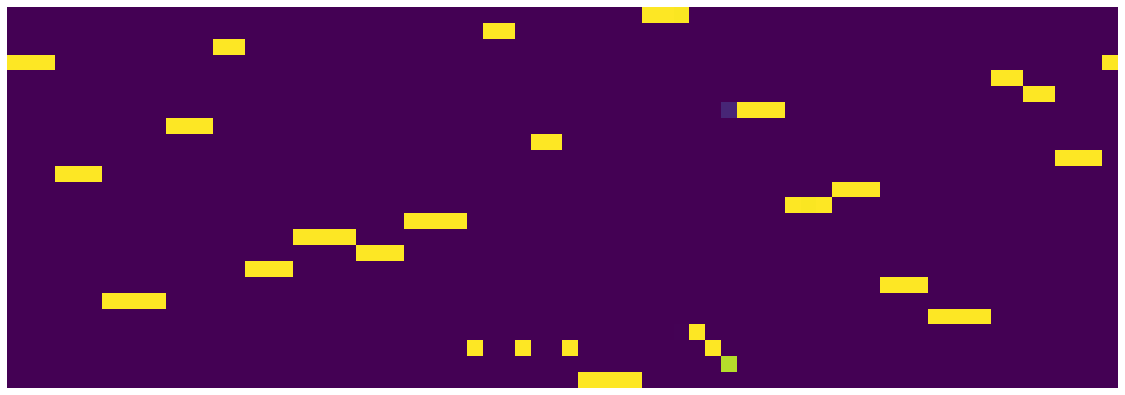

24 192 0.8069999999999998 0.4876218134537339


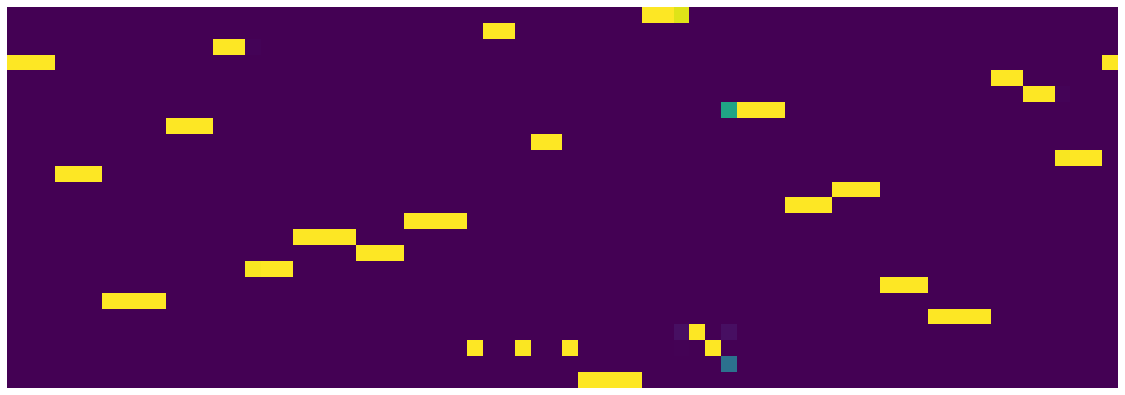

24 193 0.8059999999999998 0.48593536373227836


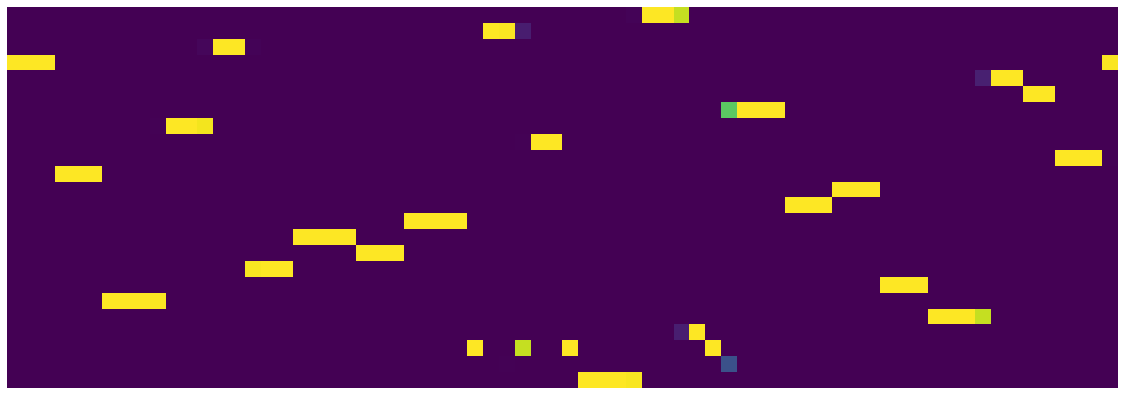

24 194 0.8049999999999998 0.49419716130942104


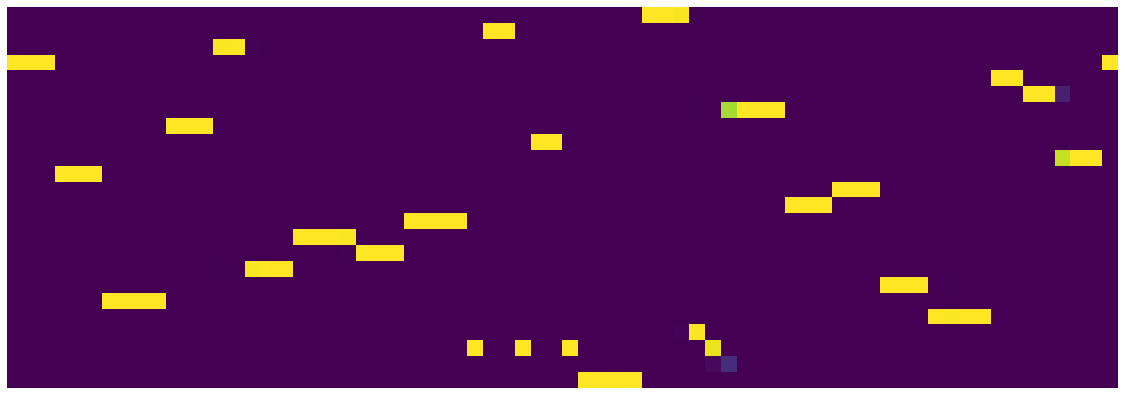

24 195 0.8039999999999998 0.4867527261376381


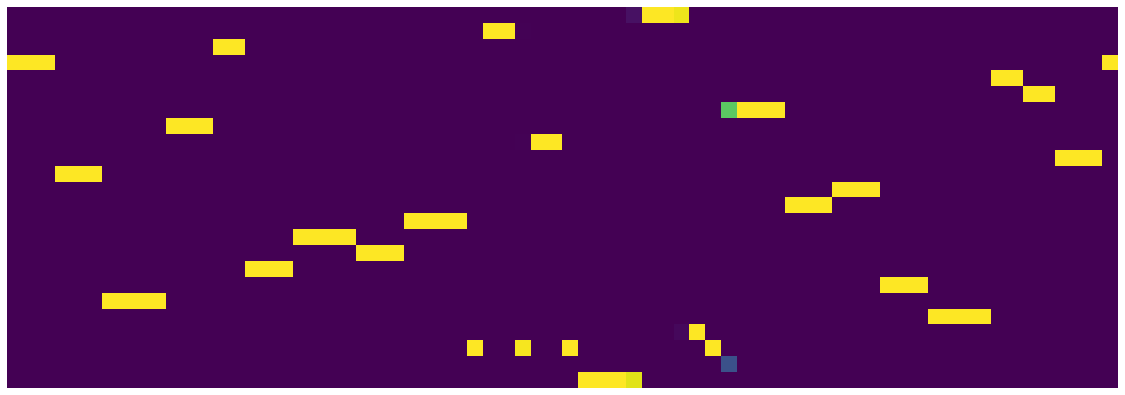

24 196 0.8029999999999998 0.4829027935862541


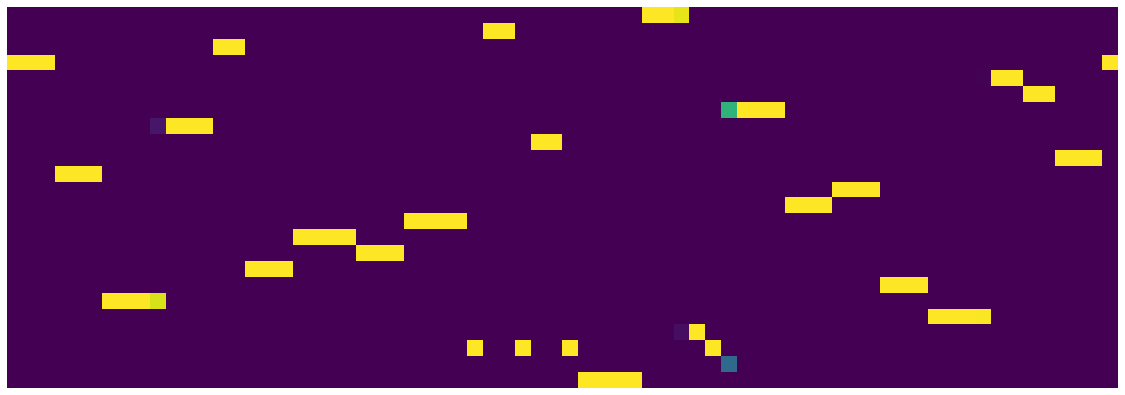

24 197 0.8019999999999998 0.4839010743424296


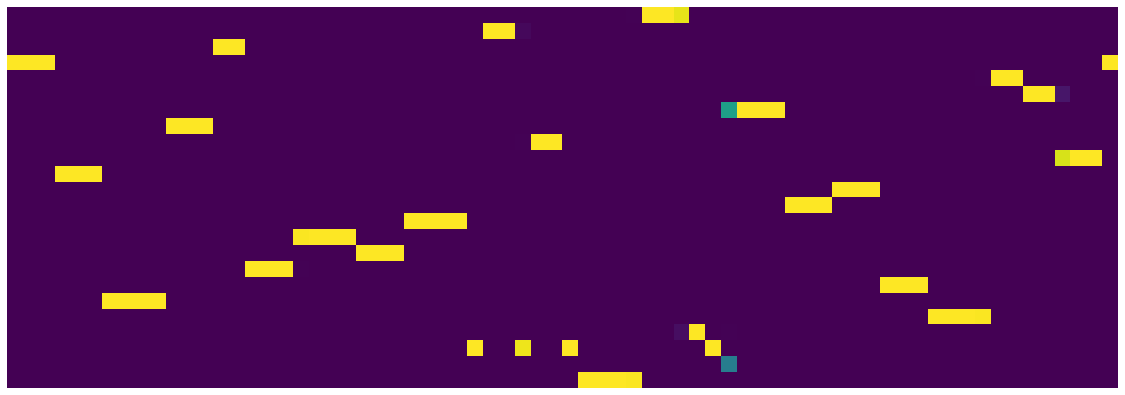

24 198 0.8009999999999998 0.48266674783080815


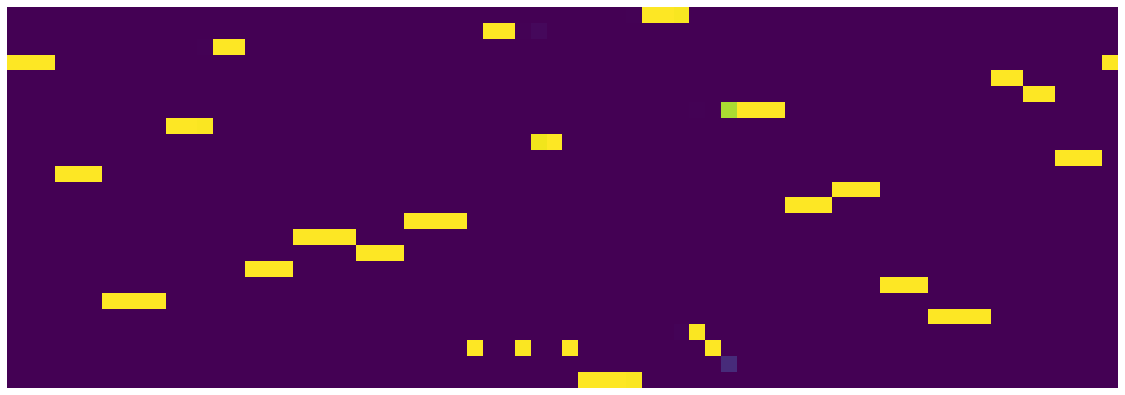

24 199 0.7999999999999998 0.48490473851561544


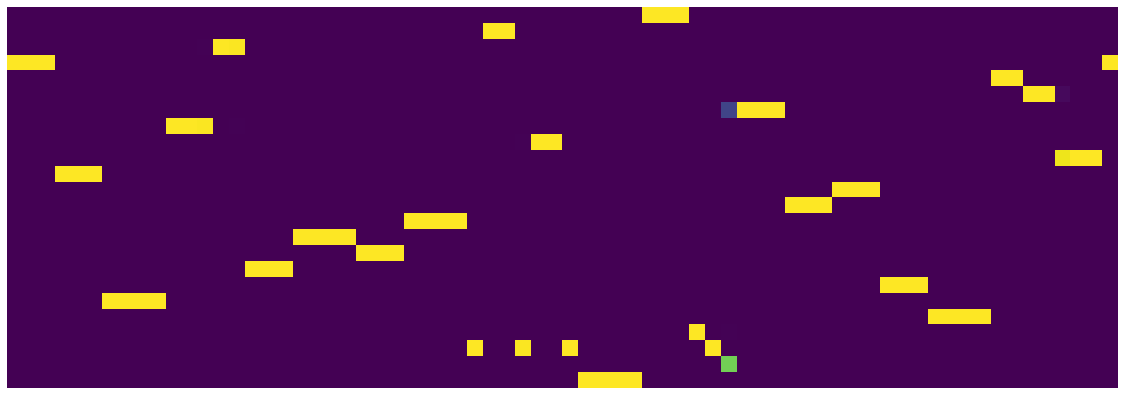

24 200 0.7989999999999998 0.4839757546782494


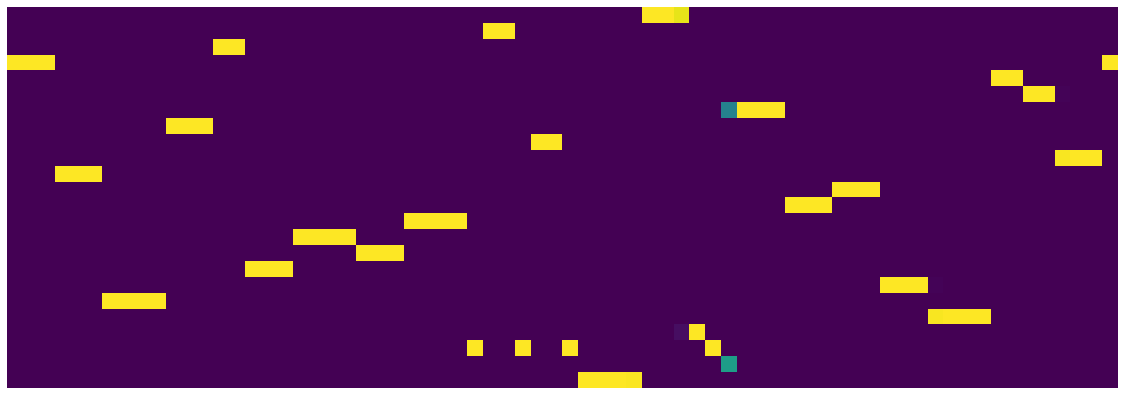

24 201 0.7979999999999998 0.4892258206382394


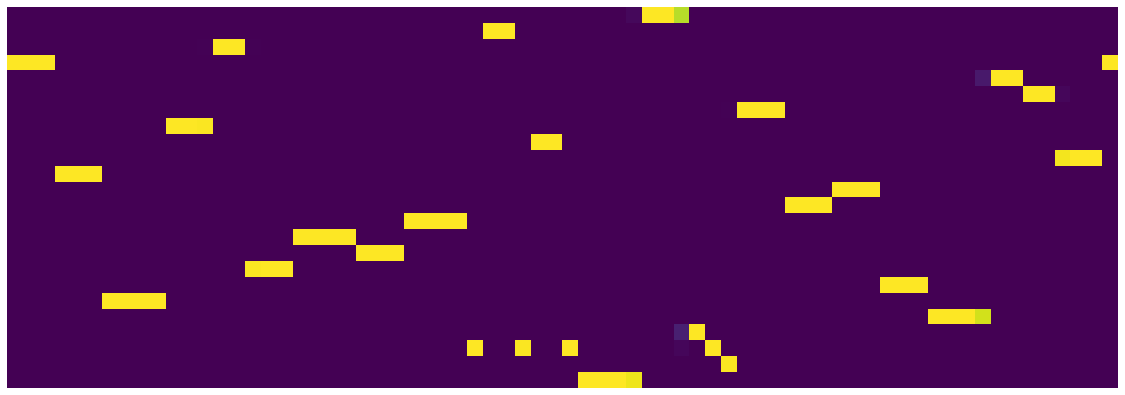

24 202 0.7969999999999998 0.484148033708334


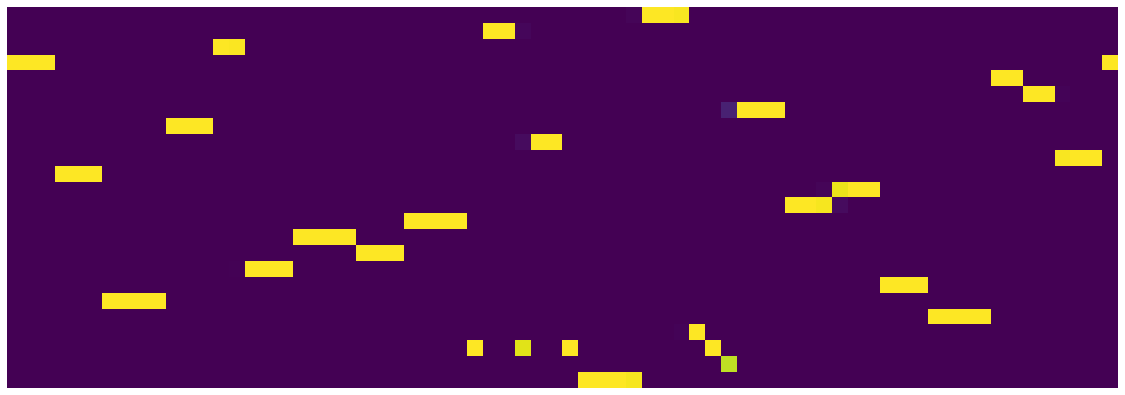

24 203 0.7959999999999998 0.48345799315720794


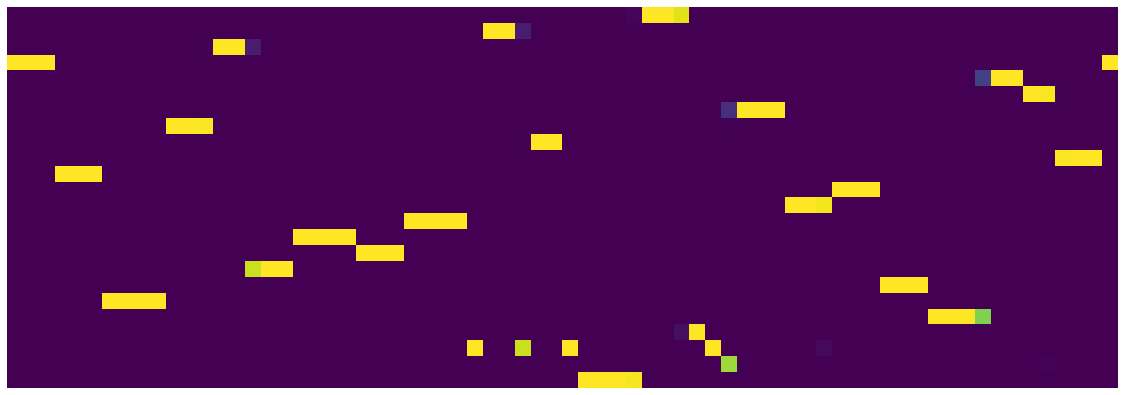

24 204 0.7949999999999998 0.4814032269641757


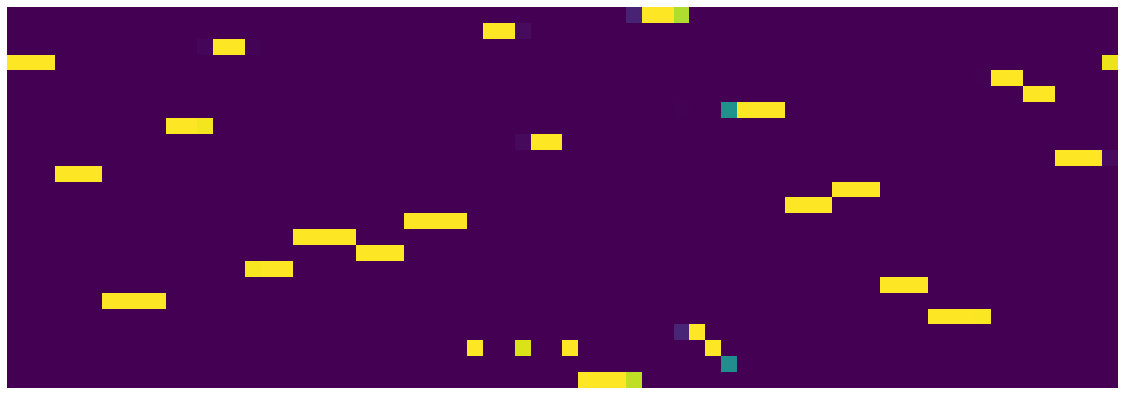

24 205 0.7939999999999998 0.482524286955595


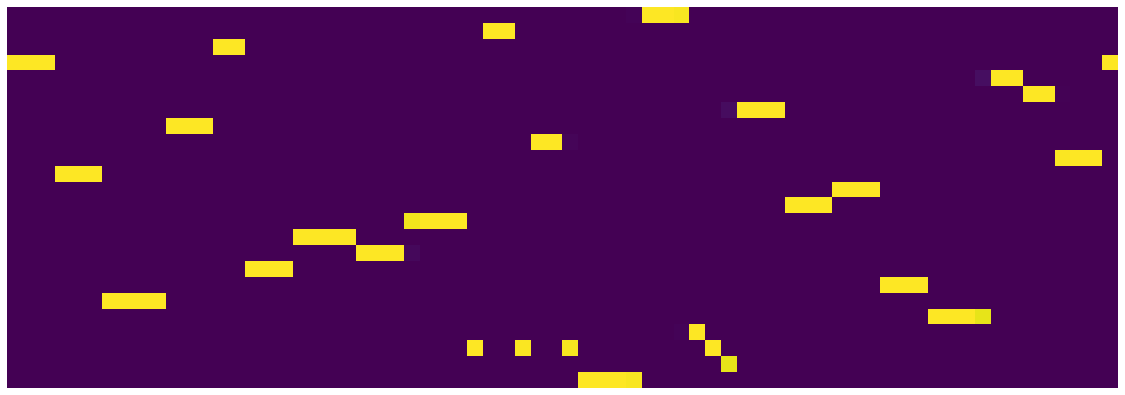

24 206 0.7929999999999998 0.4826711621135473


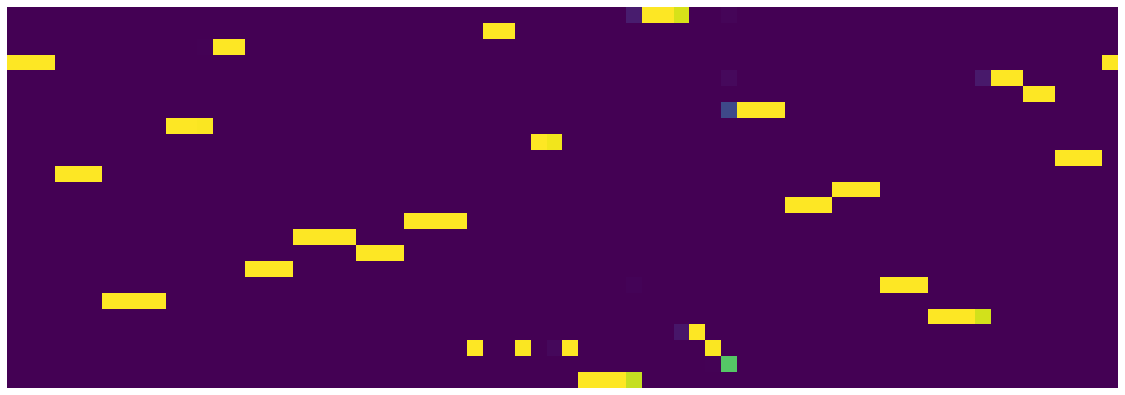

24 207 0.7919999999999998 0.48264232855290173


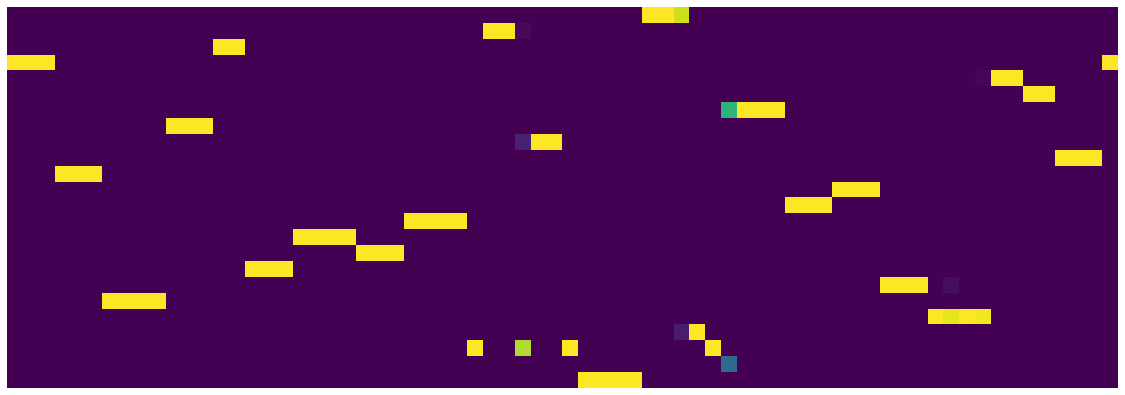

24 208 0.7909999999999998 0.48414897732436657


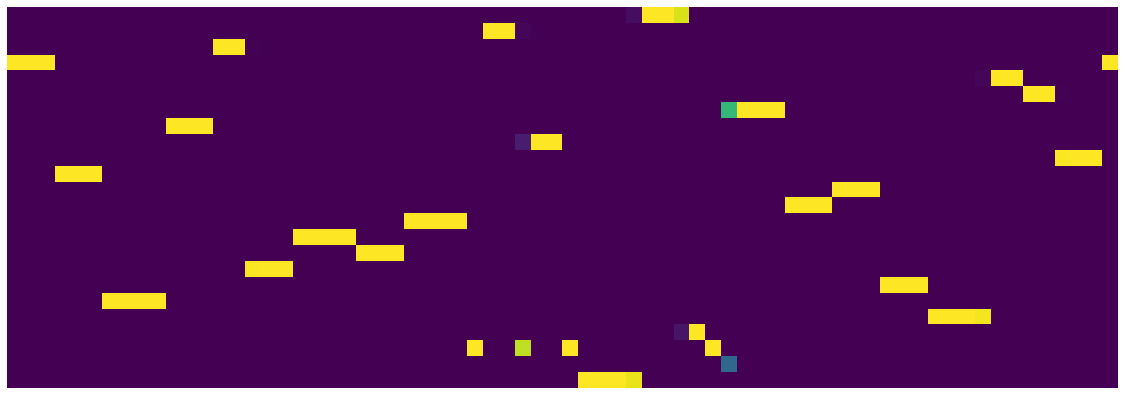

24 209 0.7899999999999998 0.48215987756848333


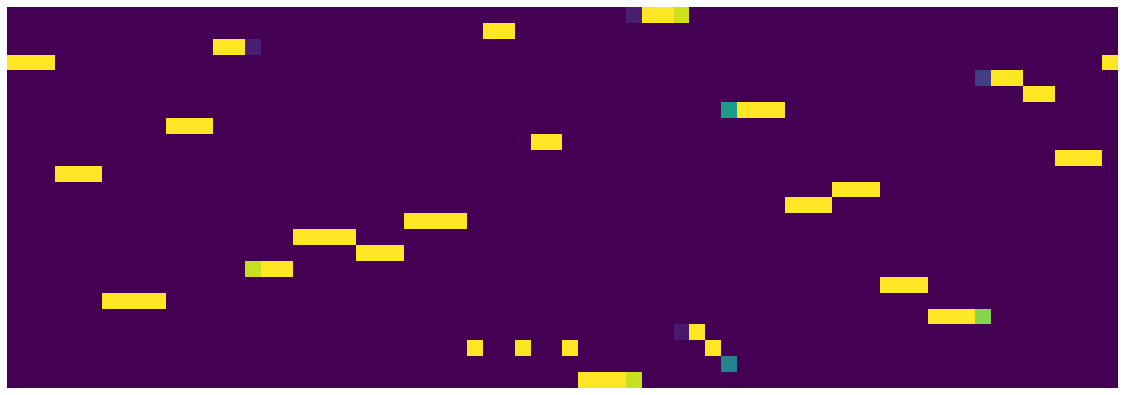

24 210 0.7889999999999998 0.48407738003879786


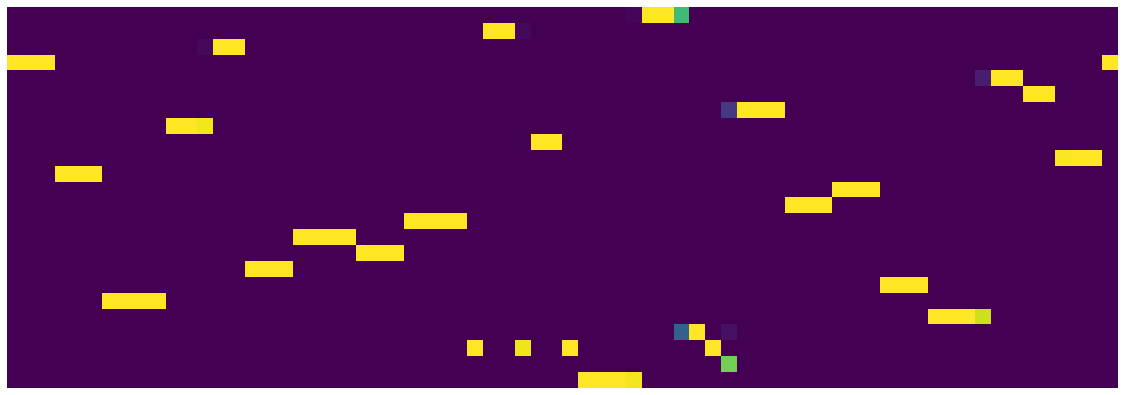

24 211 0.7879999999999998 0.4809299575164914


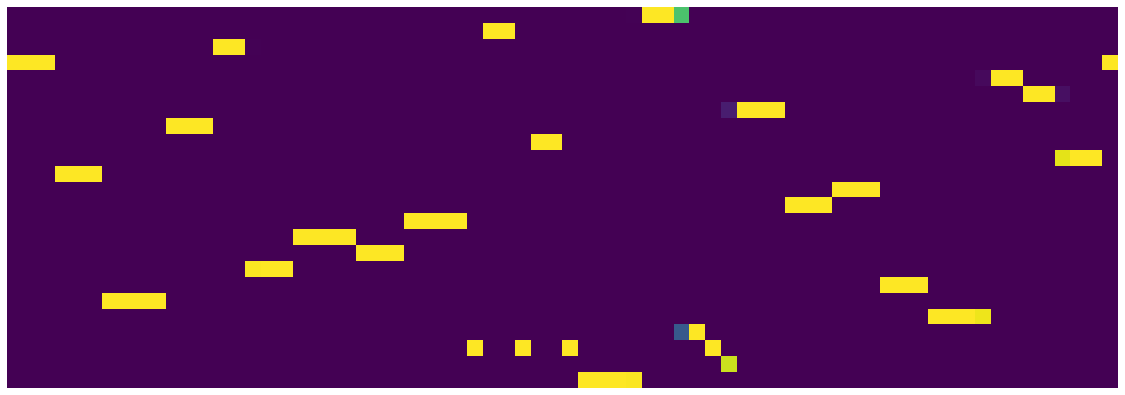

24 212 0.7869999999999998 0.4815233502537012


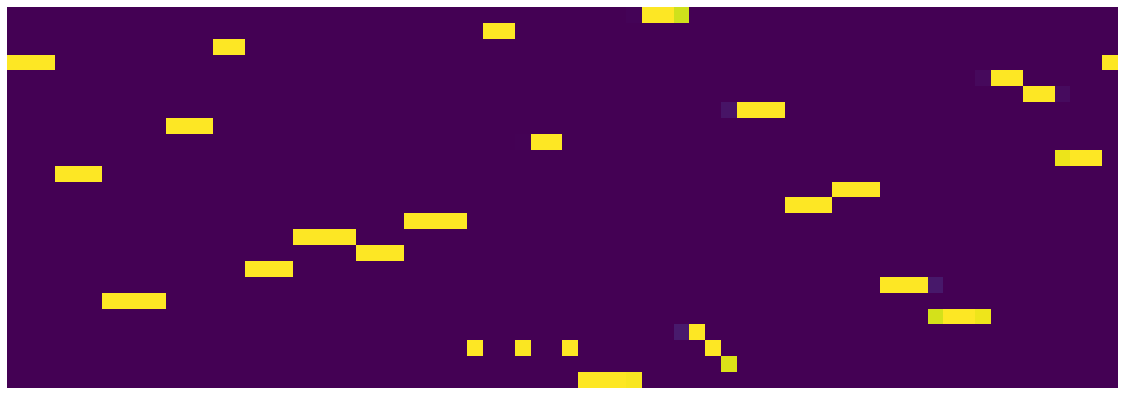

24 213 0.7859999999999998 0.48176323287189005


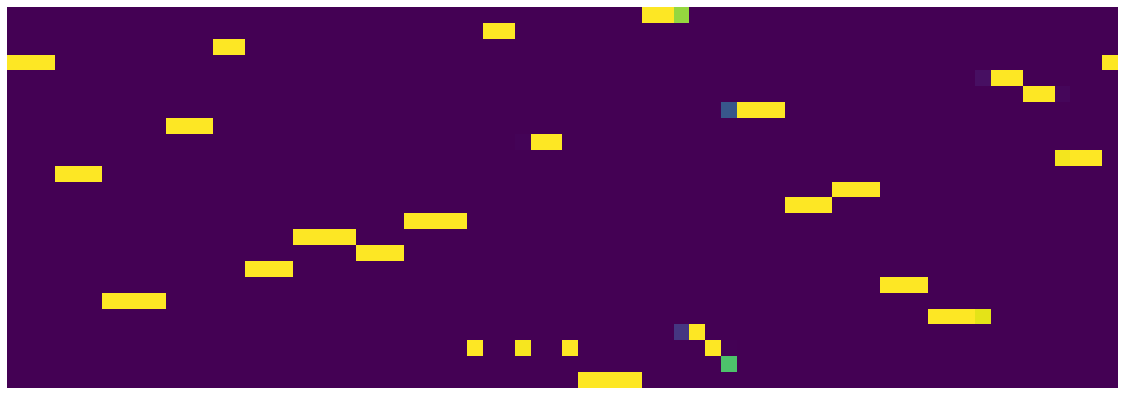

24 214 0.7849999999999998 0.4819356333464384


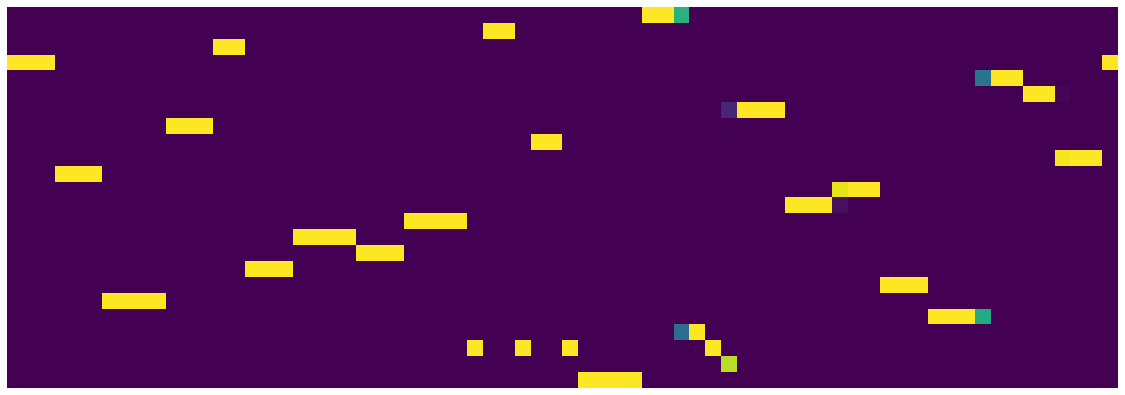

24 215 0.7839999999999998 0.4816260179504752


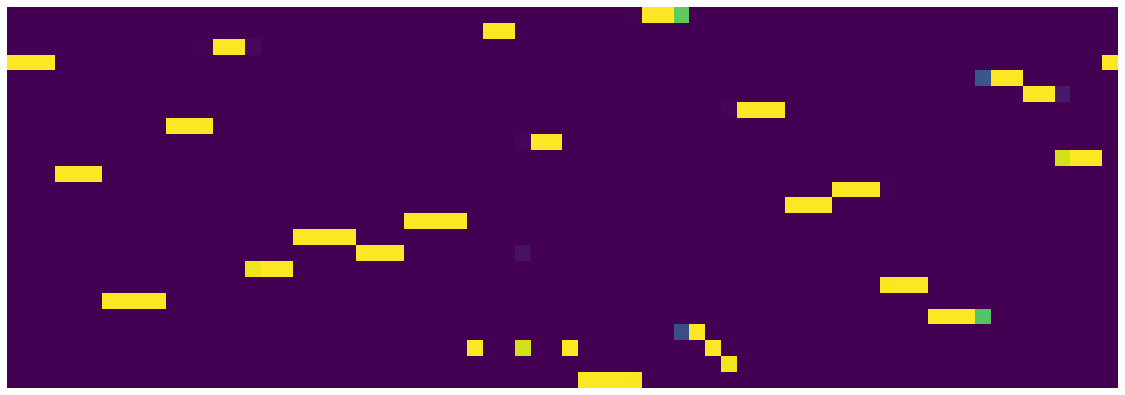

24 216 0.7829999999999998 0.4818489167839289


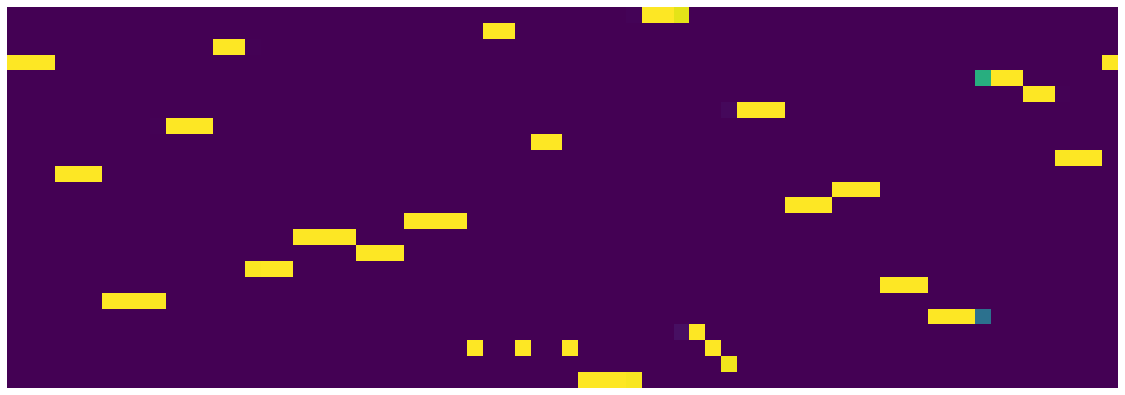

24 217 0.7819999999999998 0.48227445129305124


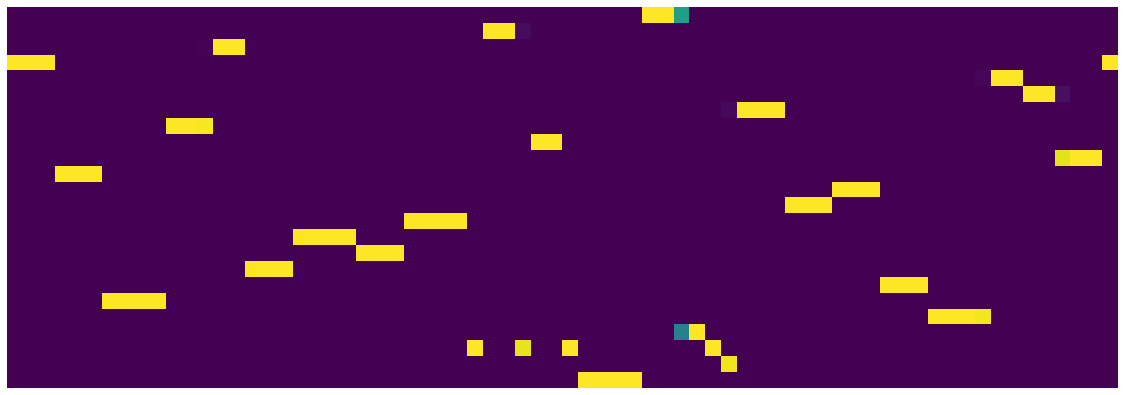

24 218 0.7809999999999998 0.4816865973174572


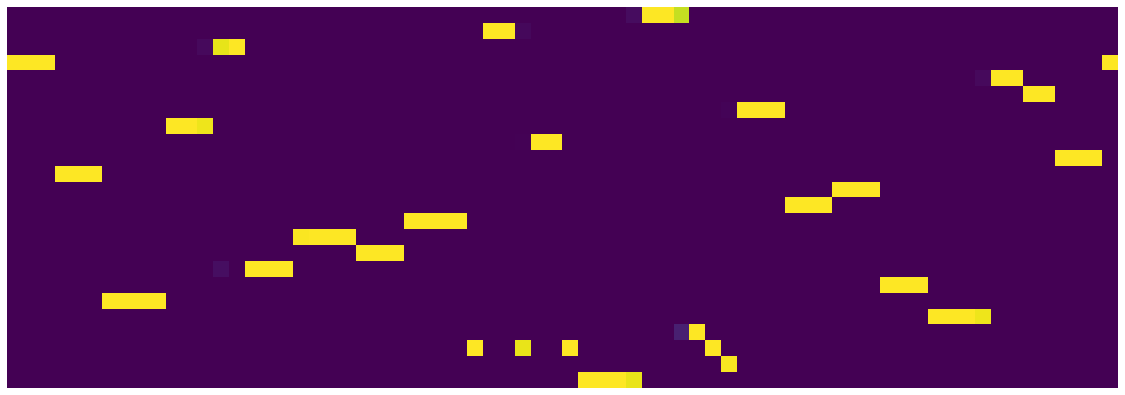

24 219 0.7799999999999998 0.4812808599323034


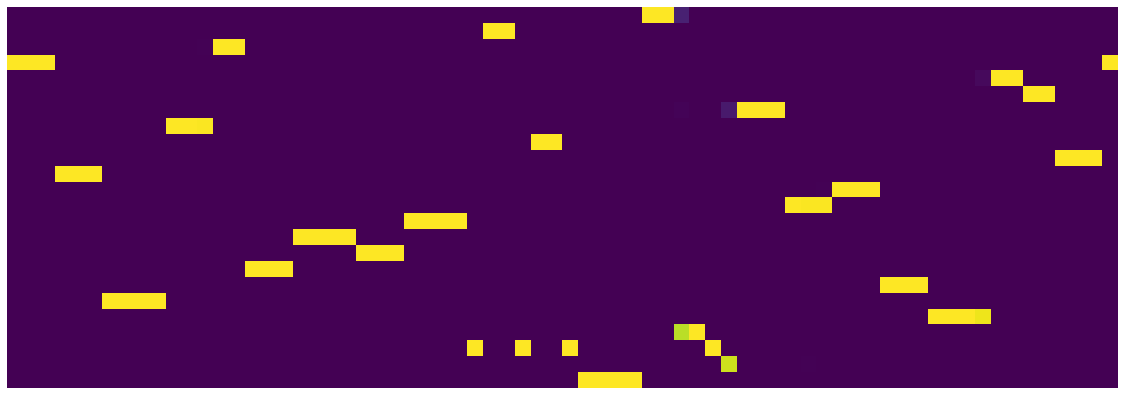

24 220 0.7789999999999998 0.48033693470060823


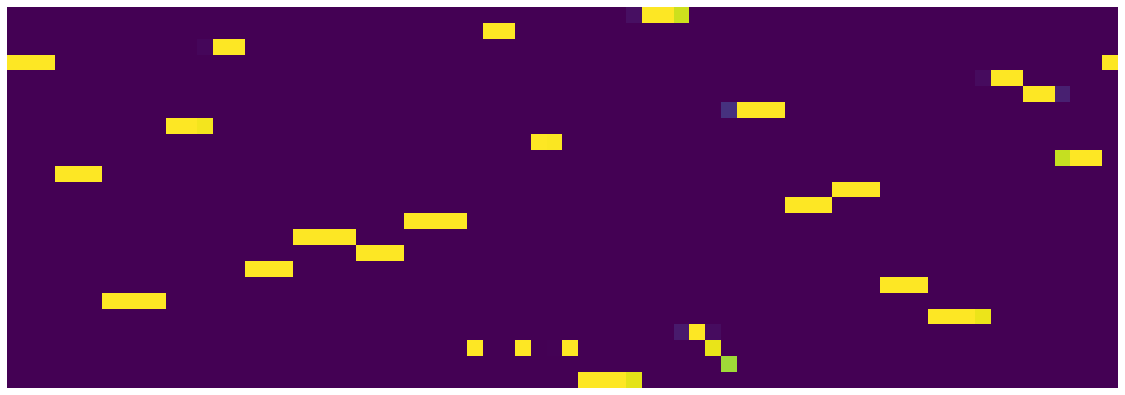

24 221 0.7779999999999998 0.48057862743735313


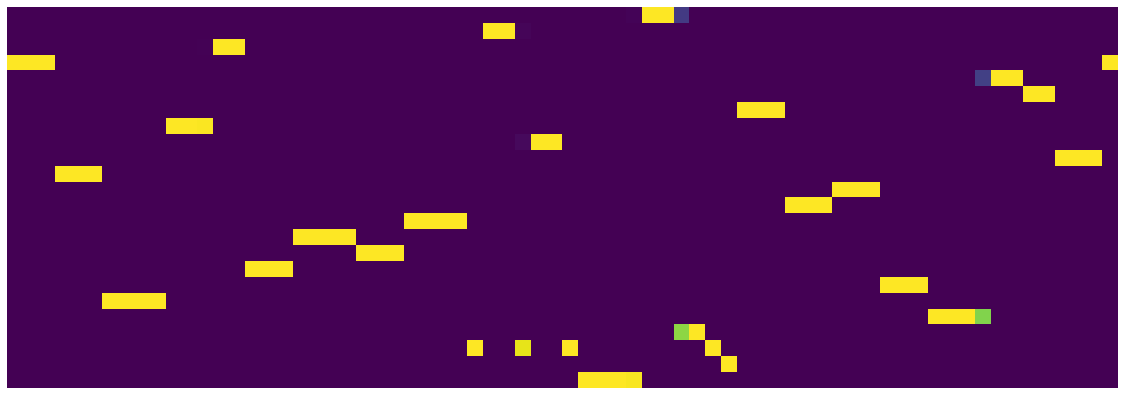

24 222 0.7769999999999998 0.47954762559384106


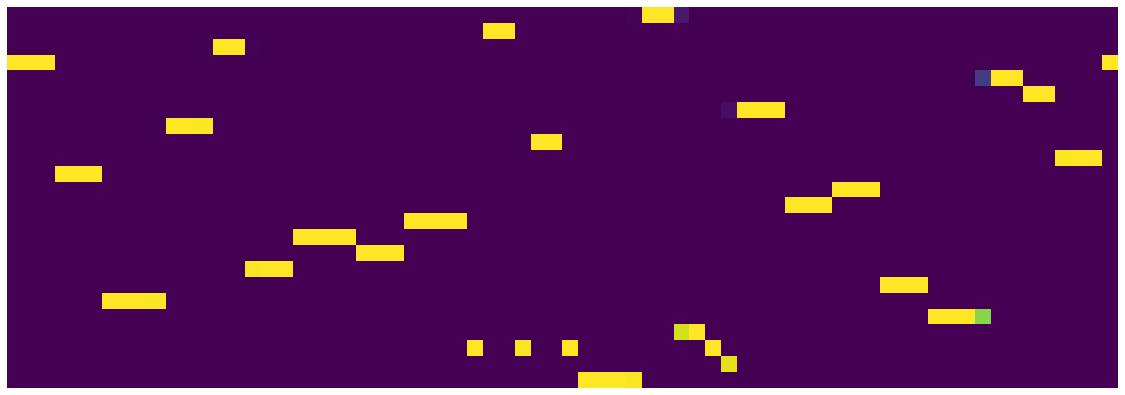

24 223 0.7759999999999998 0.4794039553031325


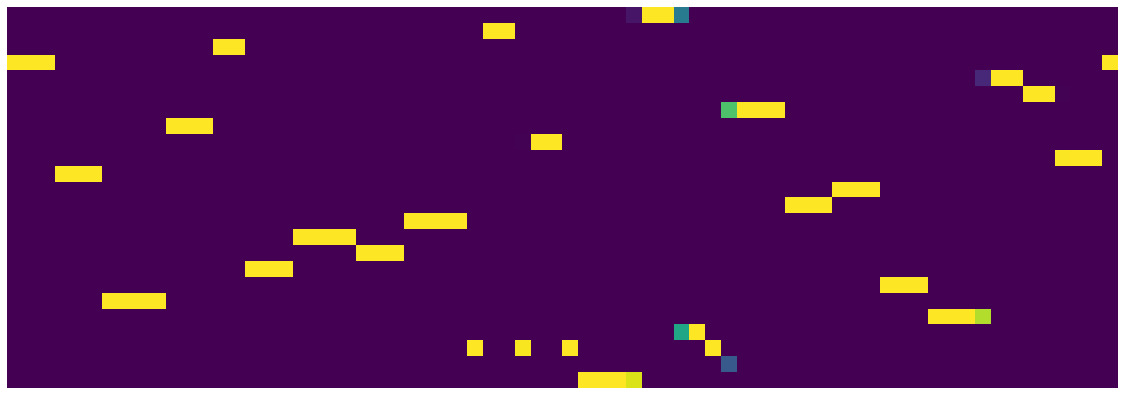

24 224 0.7749999999999998 0.479169199988246


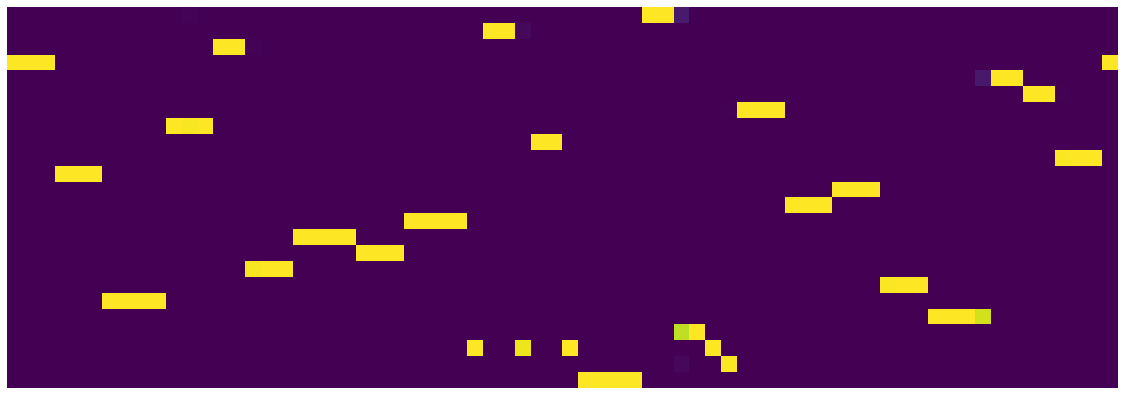

24 225 0.7739999999999998 0.4773001192137599


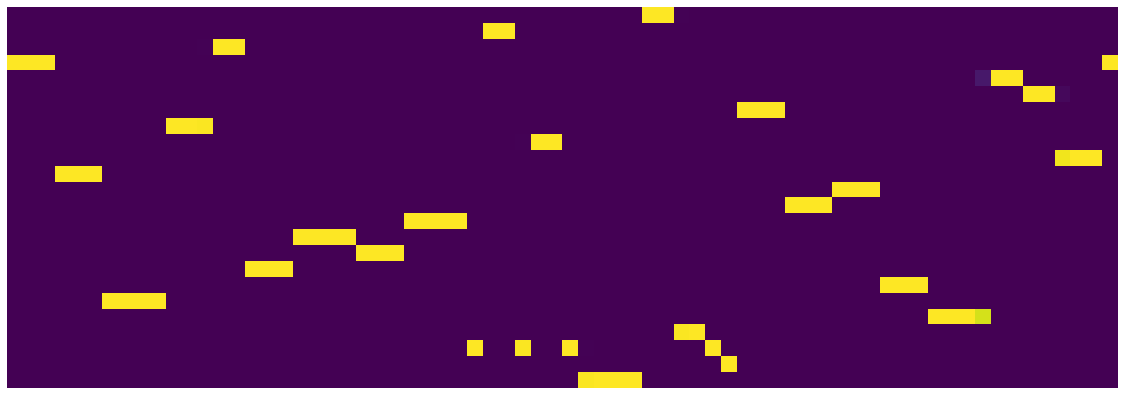

24 226 0.7729999999999998 0.47779569774866104


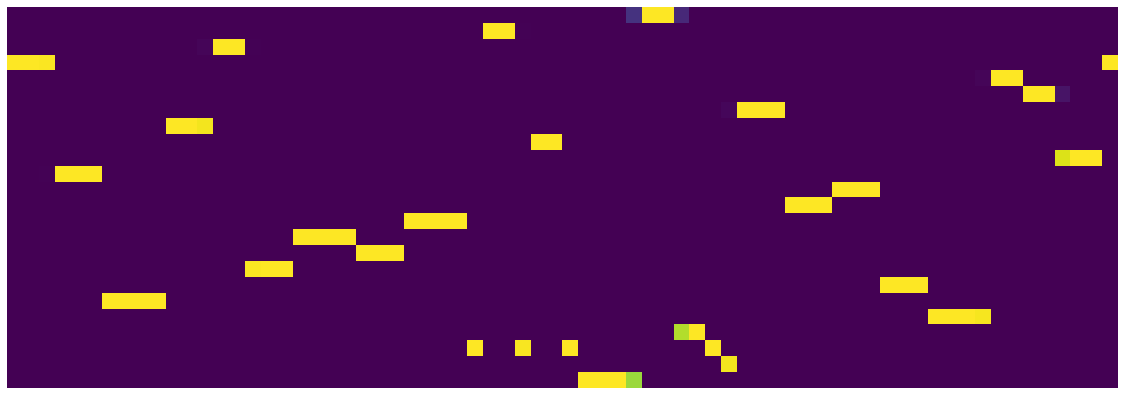

24 227 0.7719999999999998 0.47836572881788014


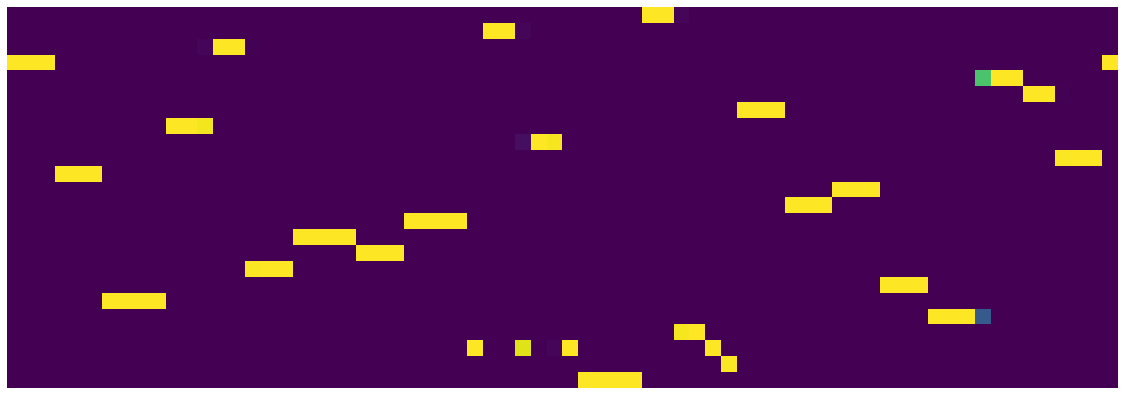

24 228 0.7709999999999998 0.47718329466879367


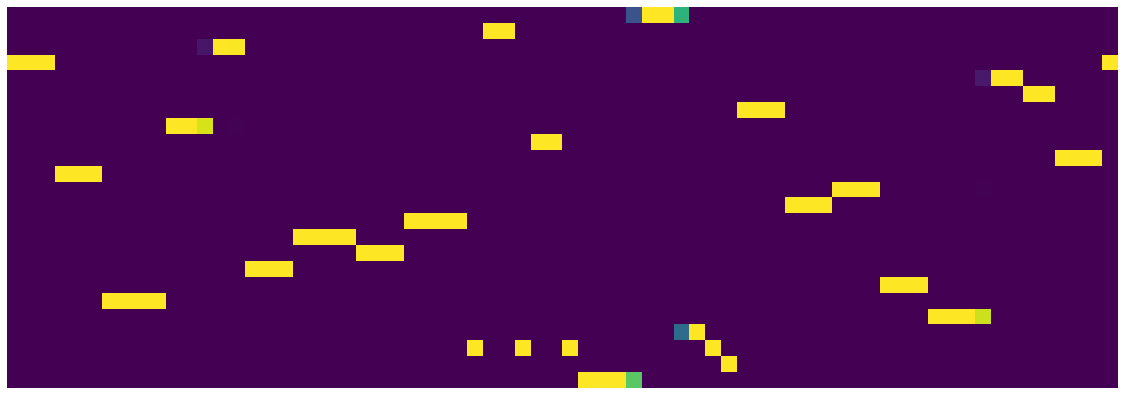

24 229 0.7699999999999998 0.48114378526806834


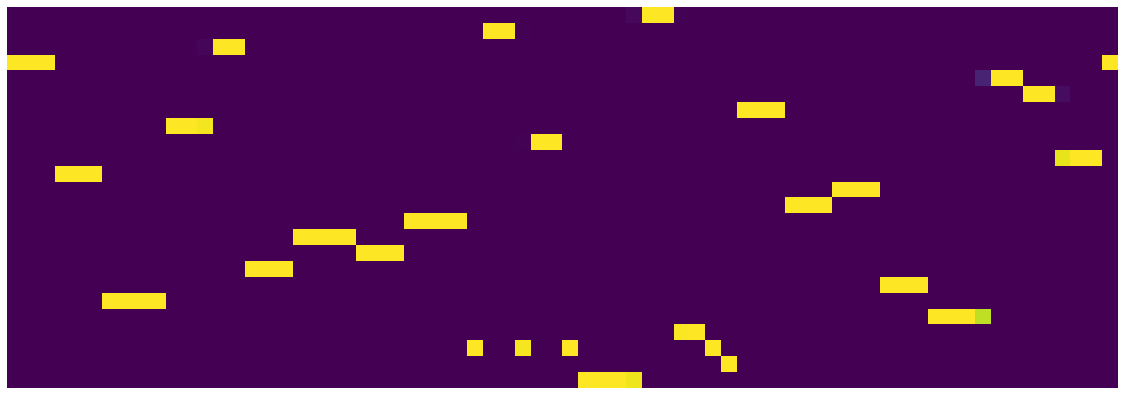

24 230 0.7689999999999998 0.47657987363636495


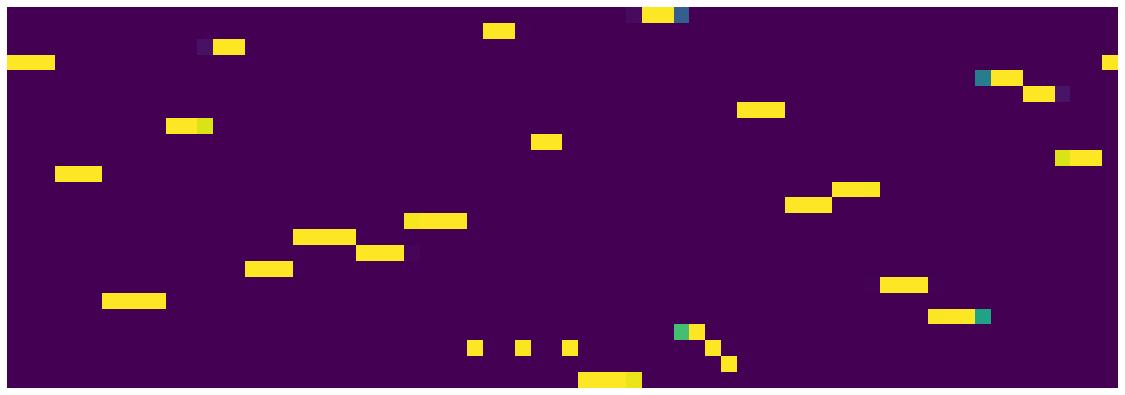

24 231 0.7679999999999998 0.476759460195899


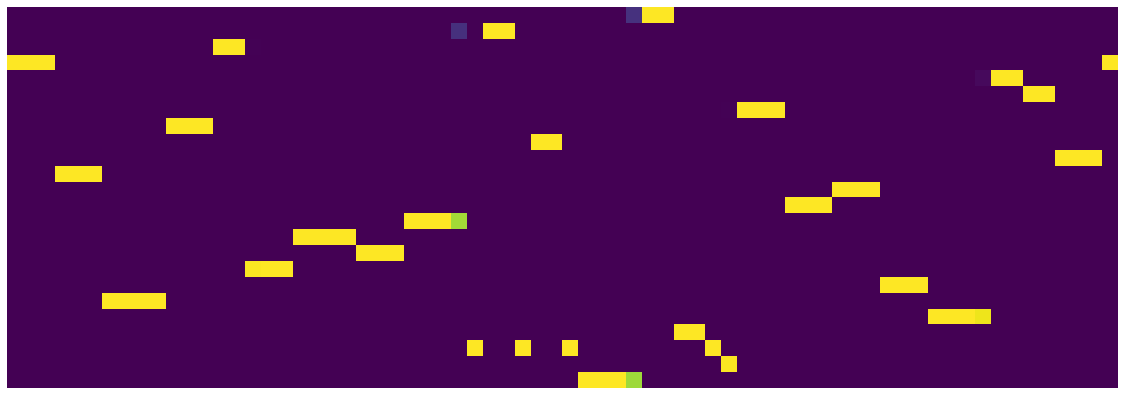

24 232 0.7669999999999998 0.47745670545846225


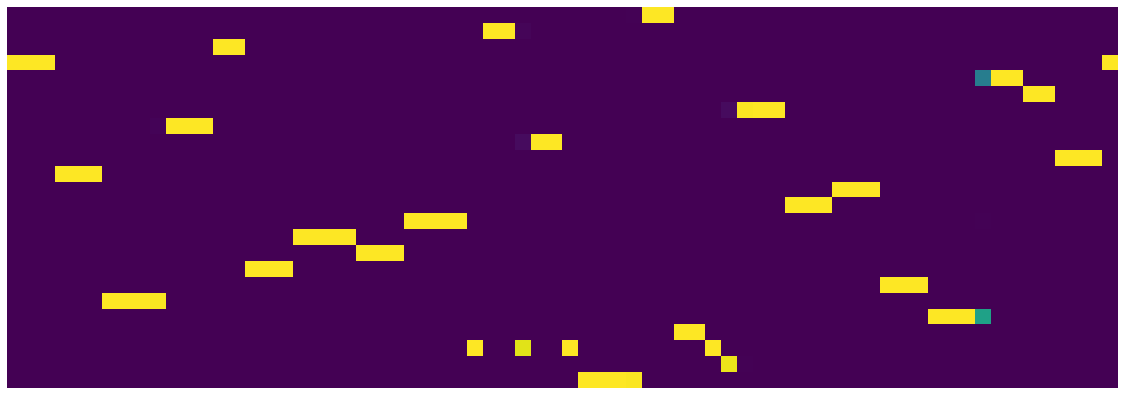

24 233 0.7659999999999998 0.4774637008085847


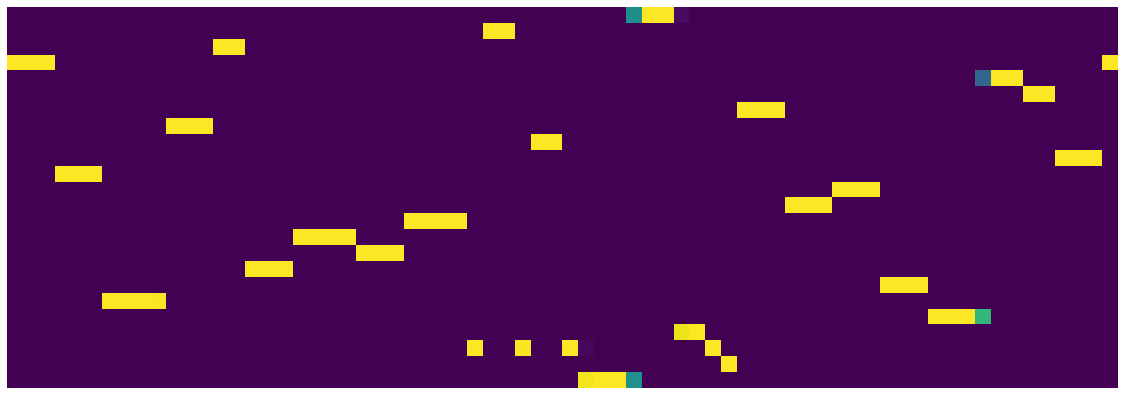

24 234 0.7649999999999998 0.47716522961854935


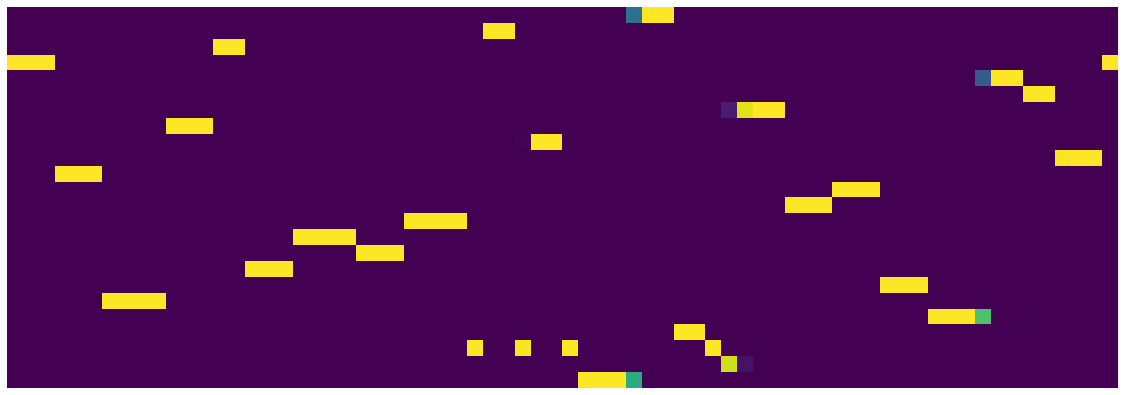

24 235 0.7639999999999998 0.47609168440103533


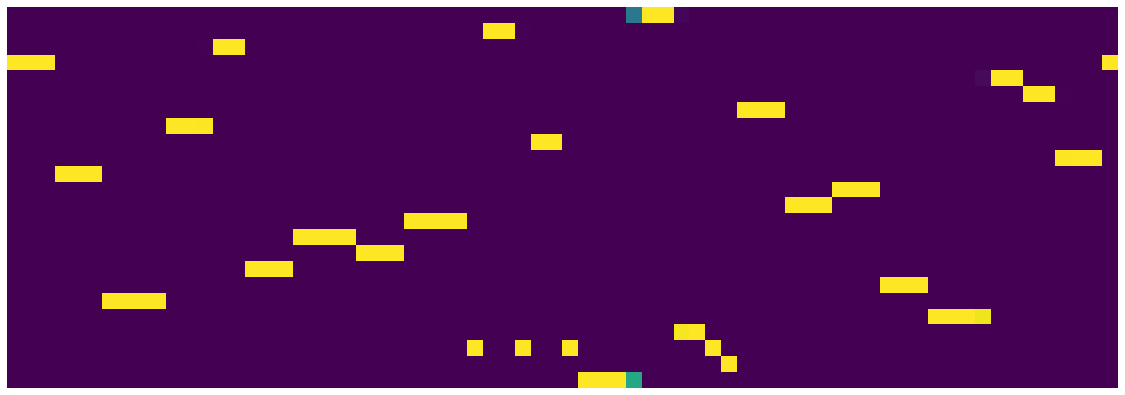

24 236 0.7629999999999998 0.47685806136578324


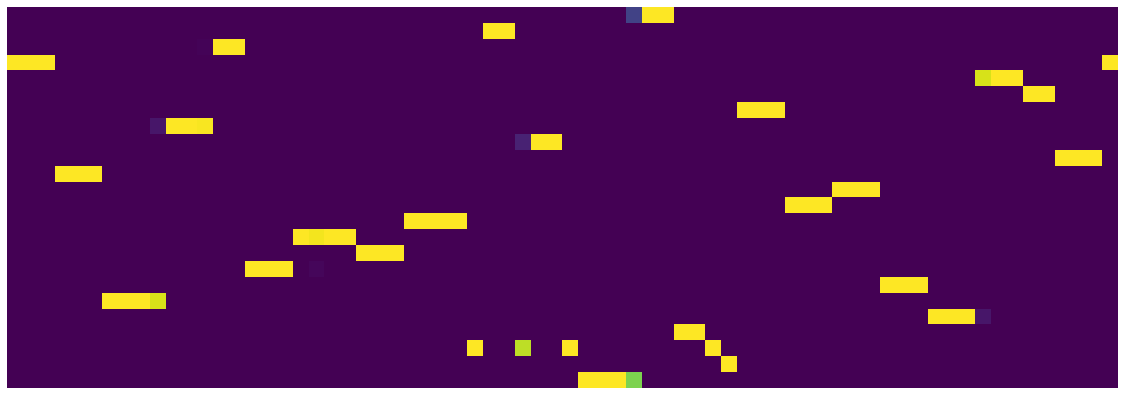

24 237 0.7619999999999998 0.47535338923335074


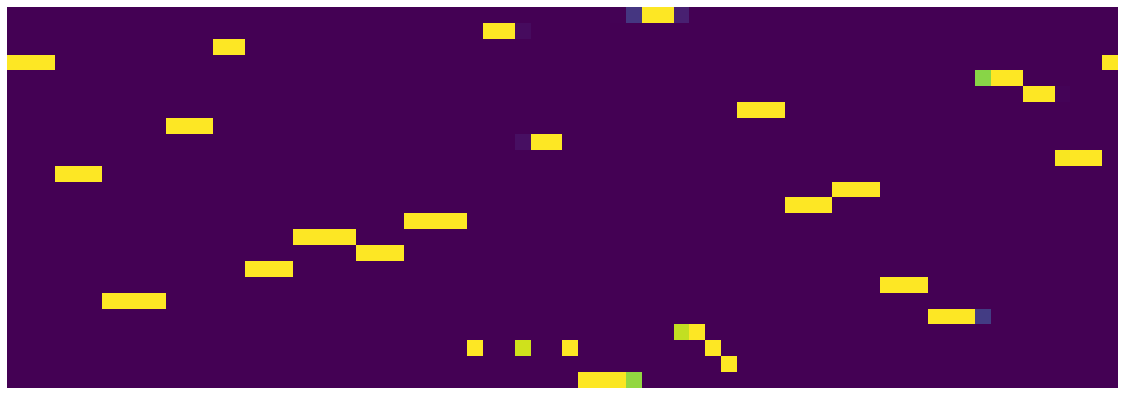

24 238 0.7609999999999998 0.4748395660892129


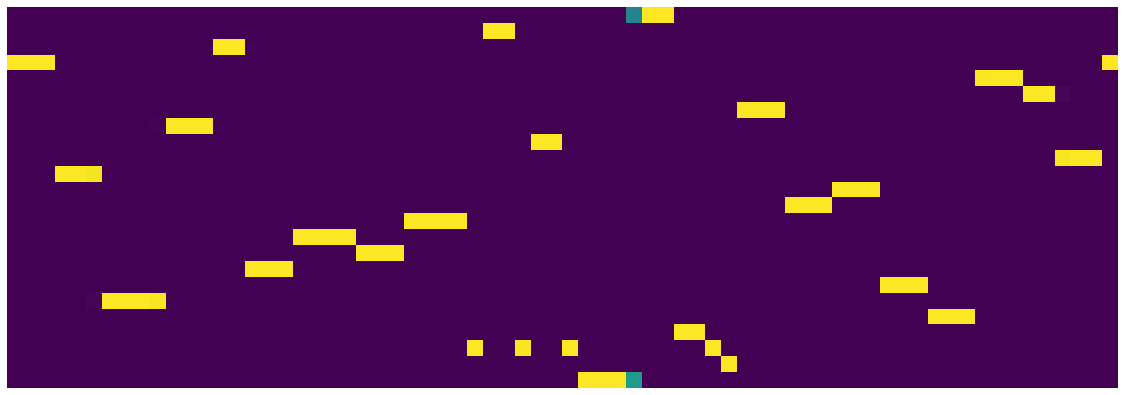

24 239 0.7599999999999998 0.4730886103585362


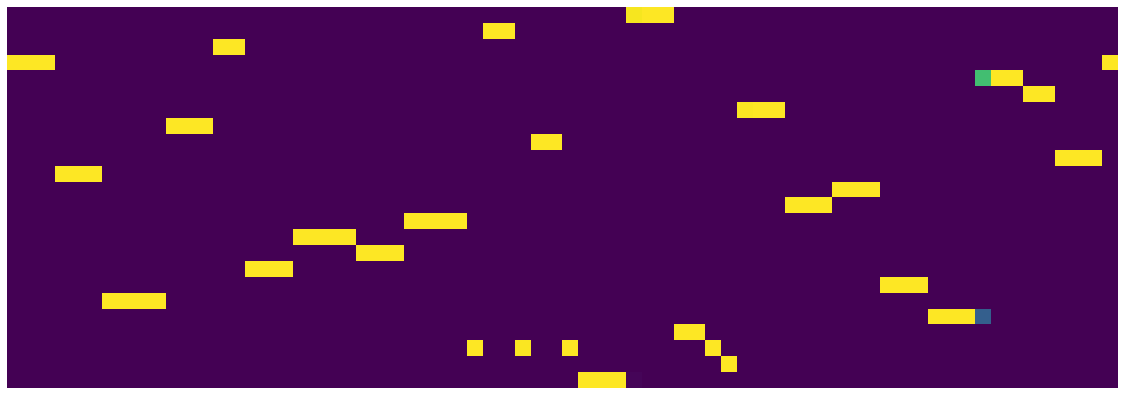

24 240 0.7589999999999998 0.47310521434992553


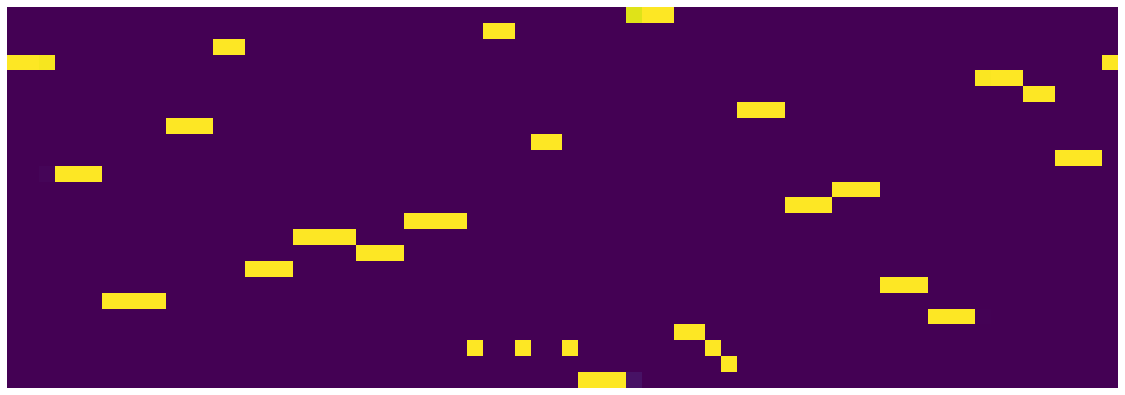

24 241 0.7579999999999998 0.47129149120301006


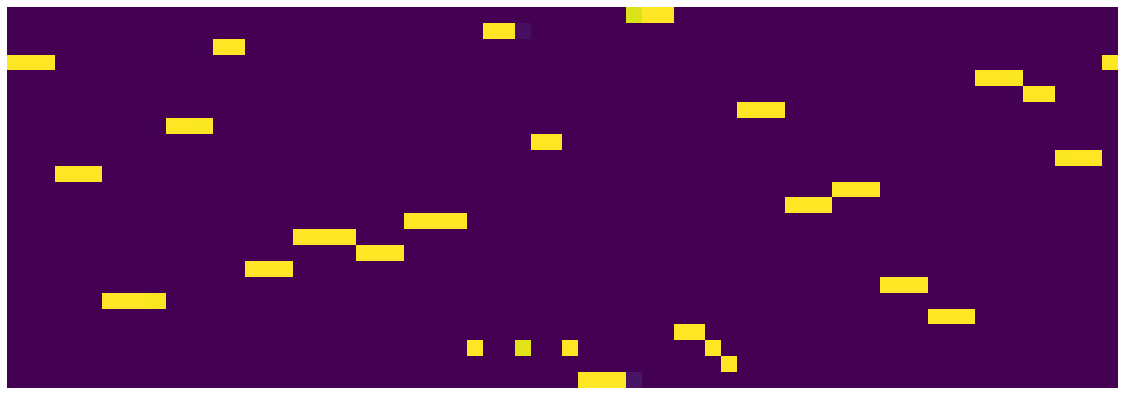

24 242 0.7569999999999998 0.4743385437875986


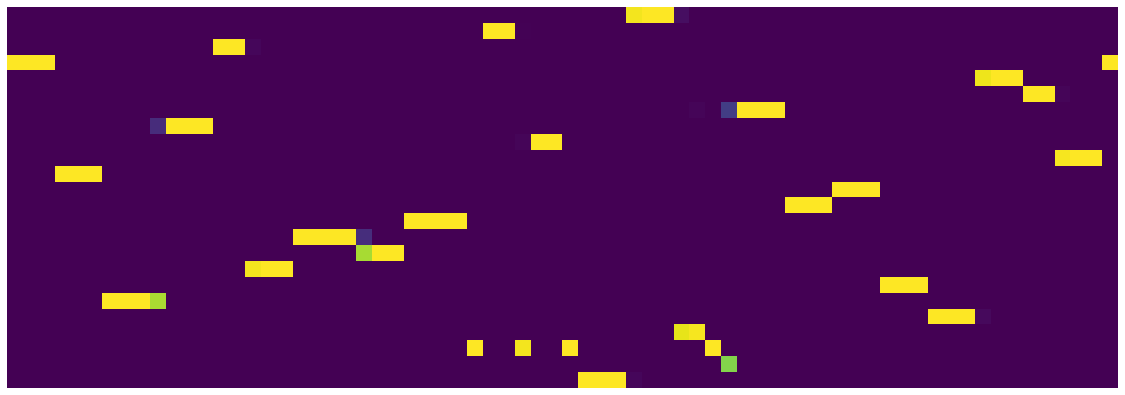

24 243 0.7559999999999998 0.46869143322110174


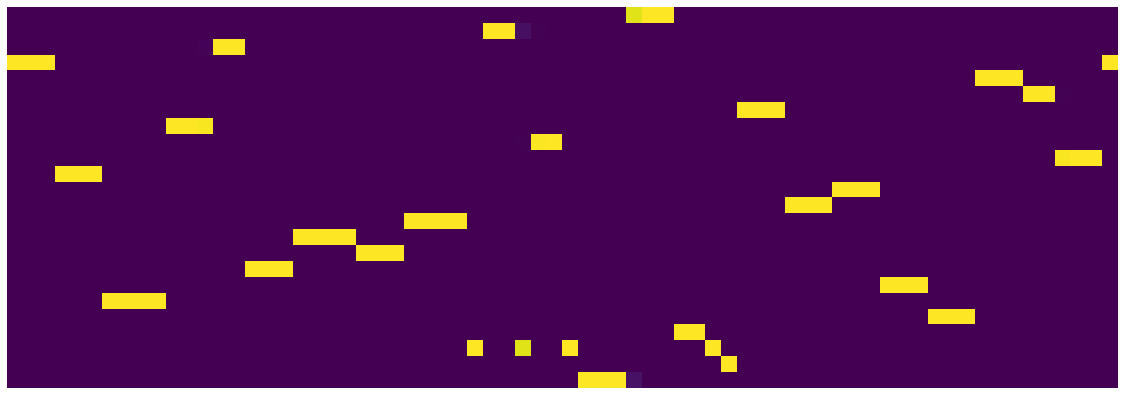

24 244 0.7549999999999998 0.4685315266251564


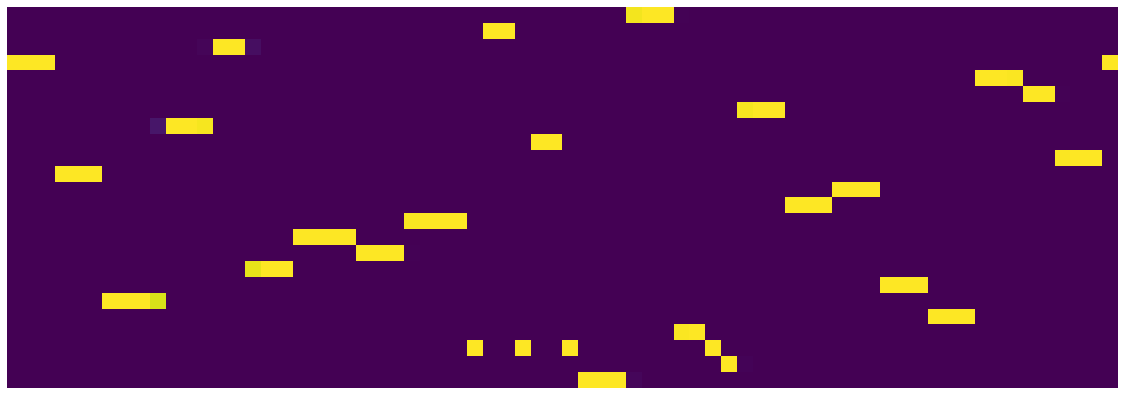

24 245 0.7539999999999998 0.4692600306123495


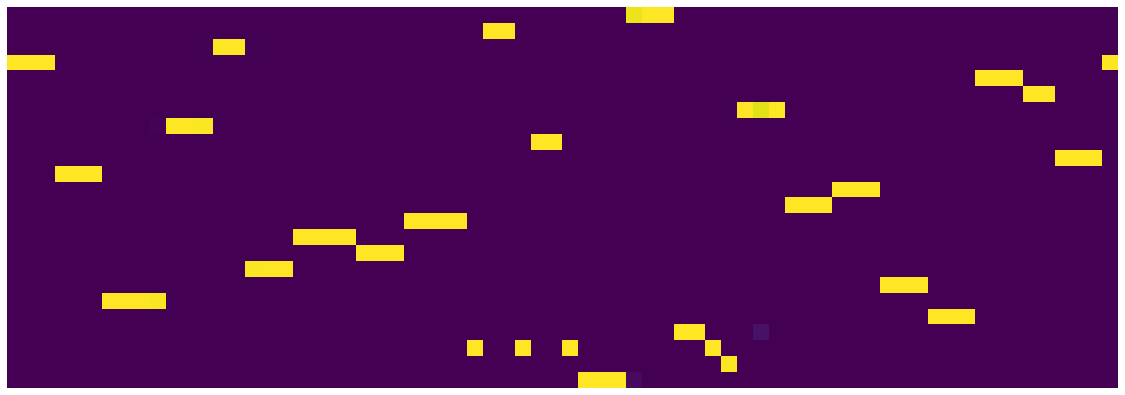

24 246 0.7529999999999998 0.46836517211049794


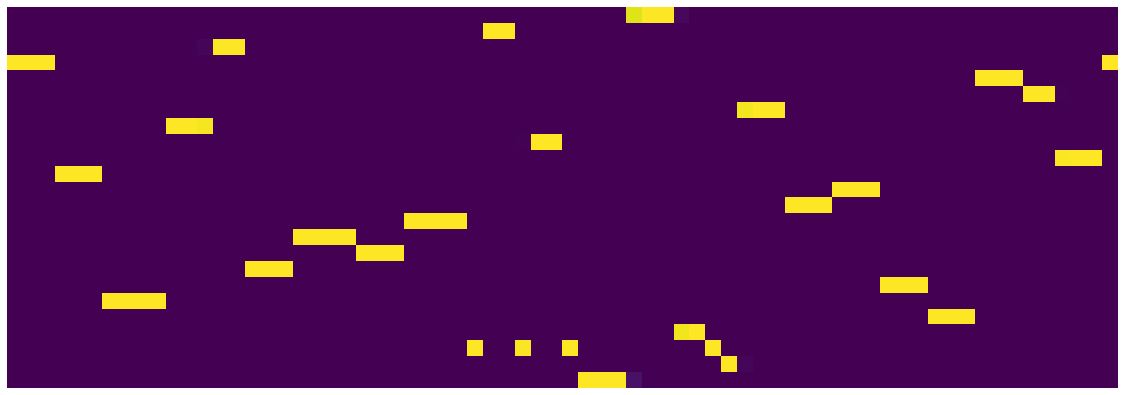

24 247 0.7519999999999998 0.46842748001217843


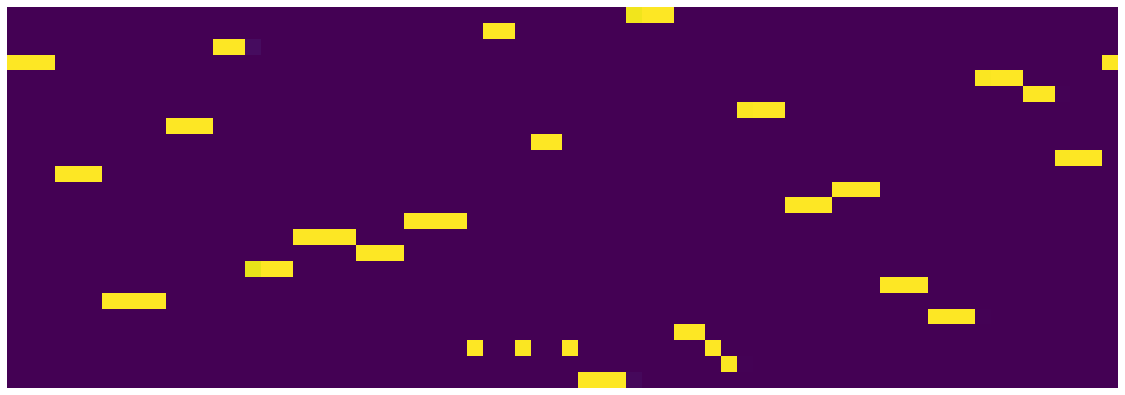

24 248 0.7509999999999998 0.46819167751818896


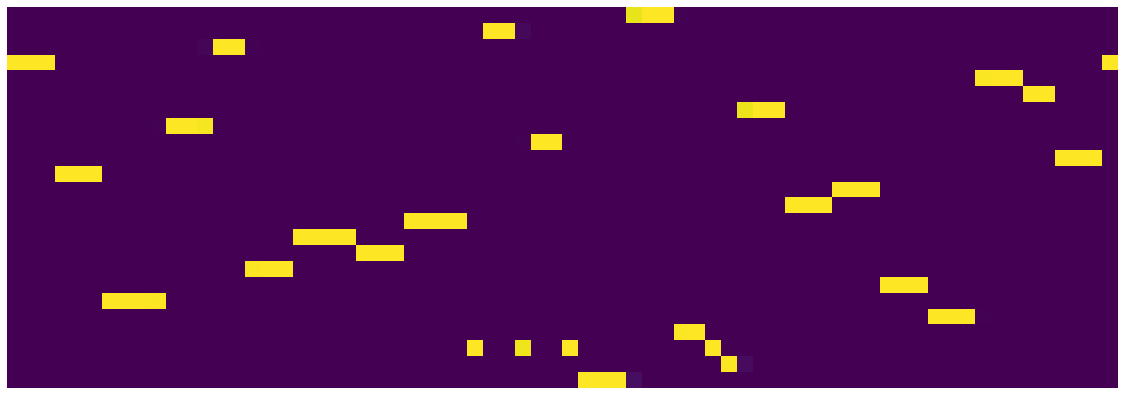

24 249 0.7499999999999998 0.46771573890000584


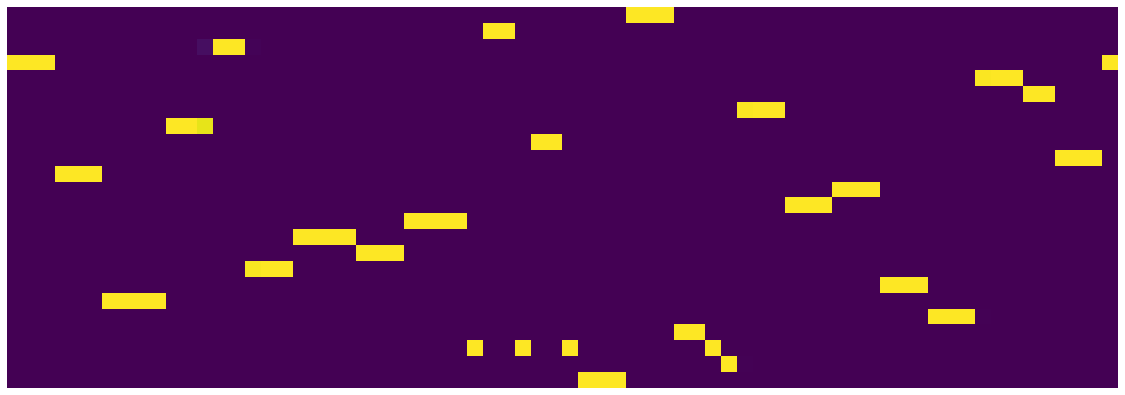

24 250 0.7489999999999998 0.4673466732725501


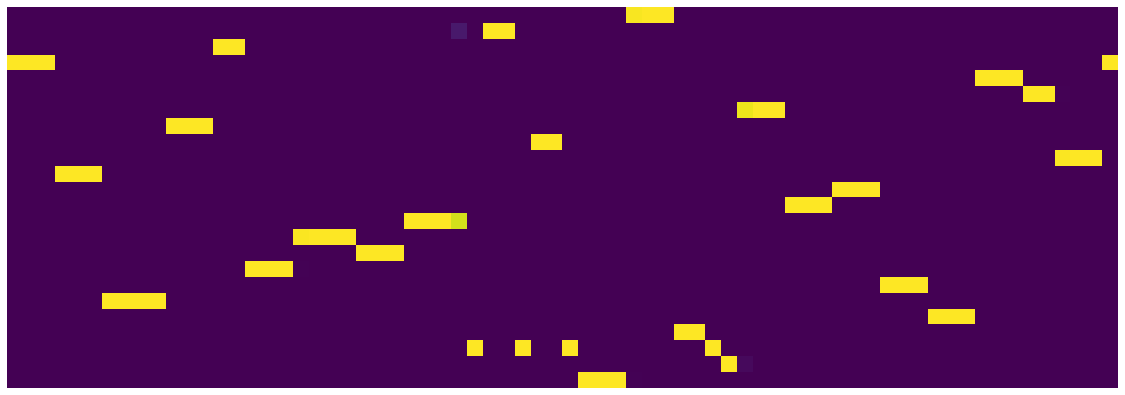

24 251 0.7479999999999998 0.4682370197027922


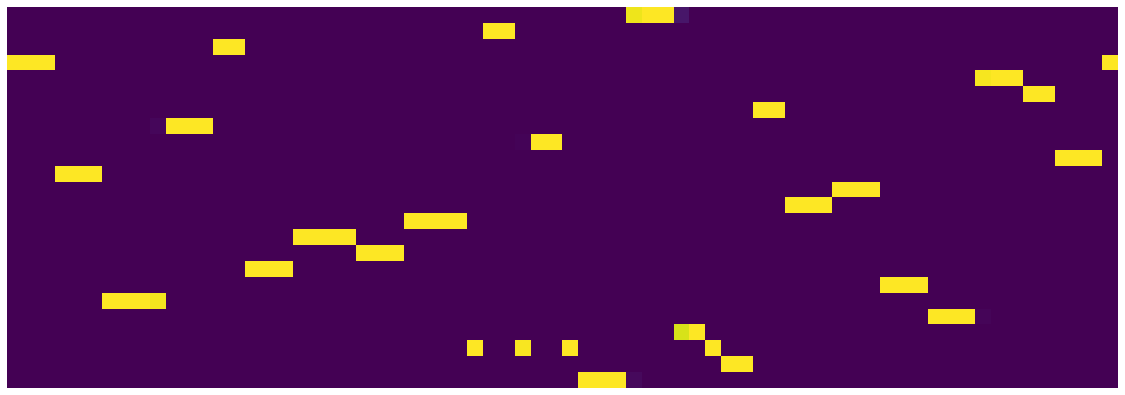

24 252 0.7469999999999998 0.46795089170336723


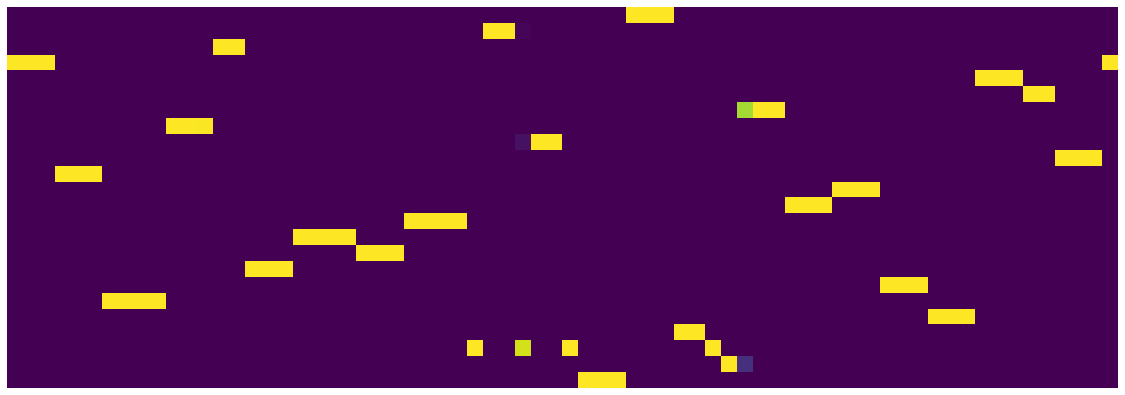

24 253 0.7459999999999998 0.46788573283702134


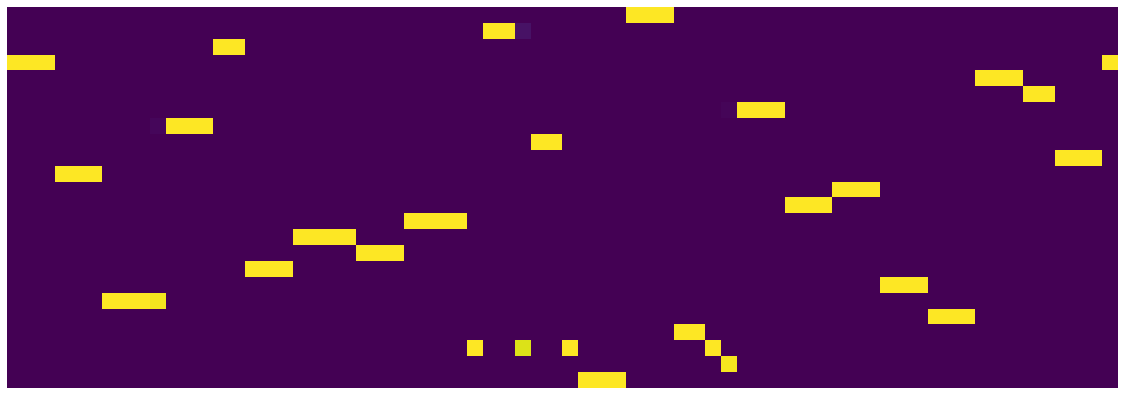

24 254 0.7449999999999998 0.4685143053531647


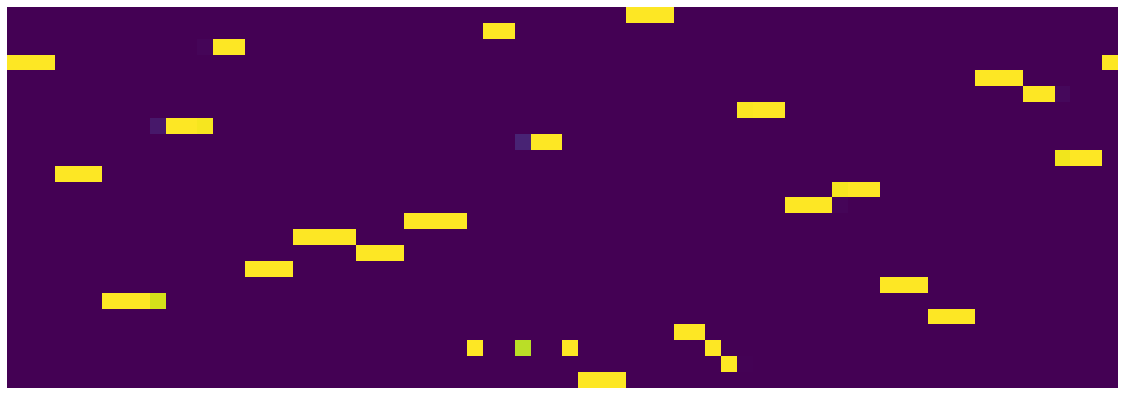

24 255 0.7439999999999998 0.46762379445135593


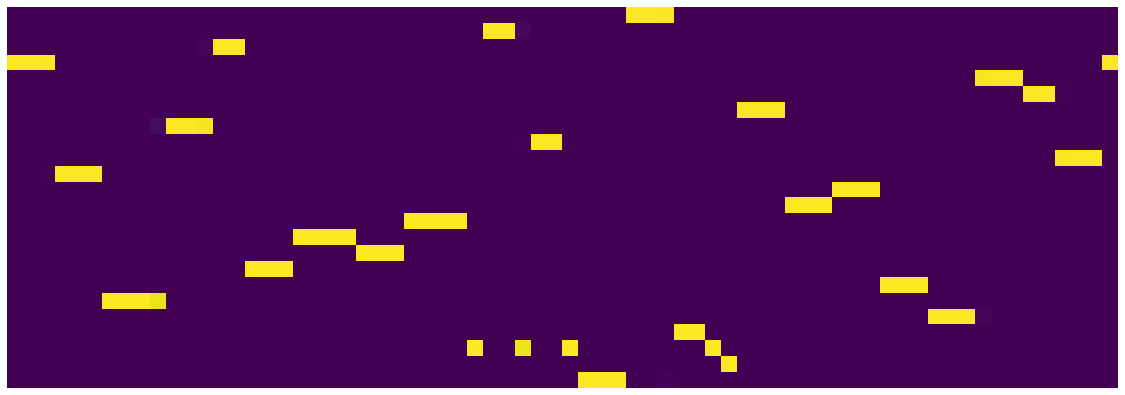

24 256 0.7429999999999998 0.467920296266675


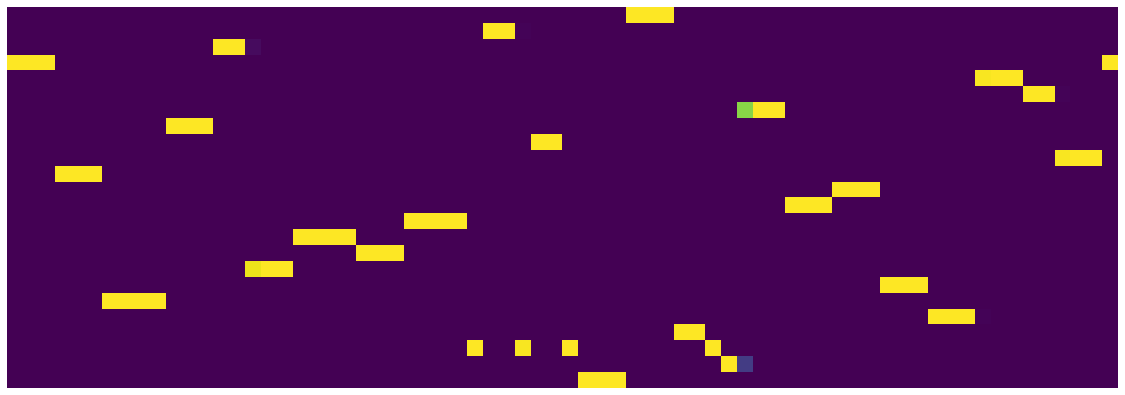

24 257 0.7419999999999998 0.4685038737952709


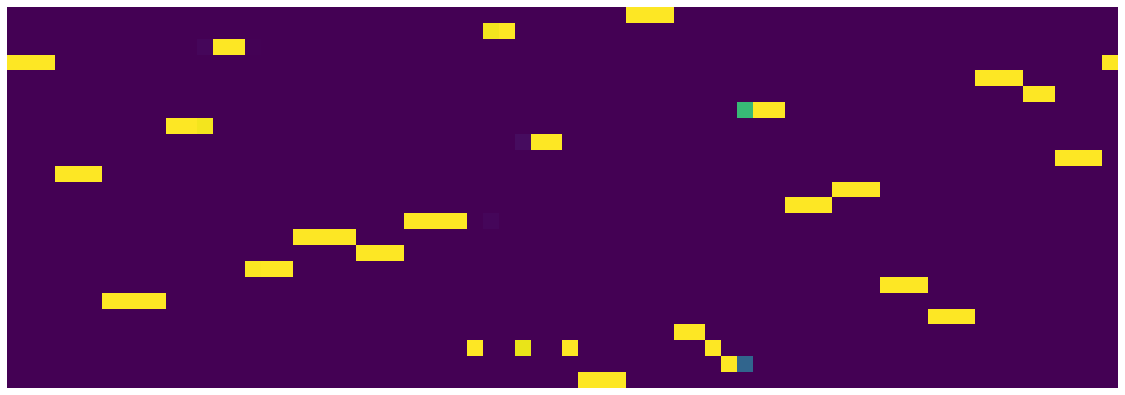

24 258 0.7409999999999998 0.4685700239613652


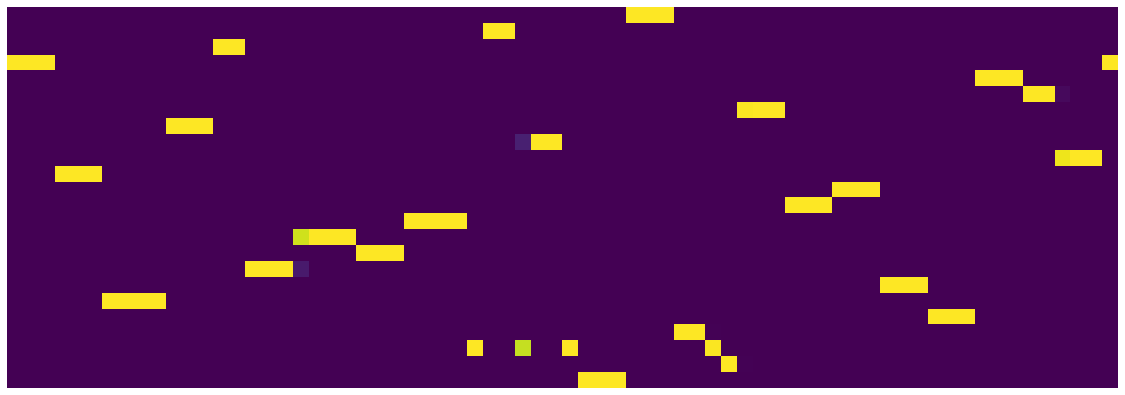

24 259 0.7399999999999998 0.46834865491837263


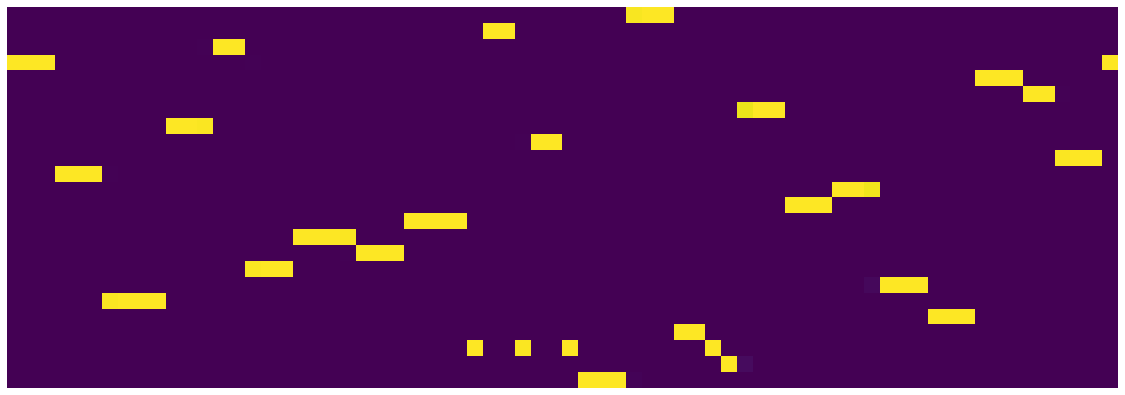

24 260 0.7389999999999998 0.46789702139794825


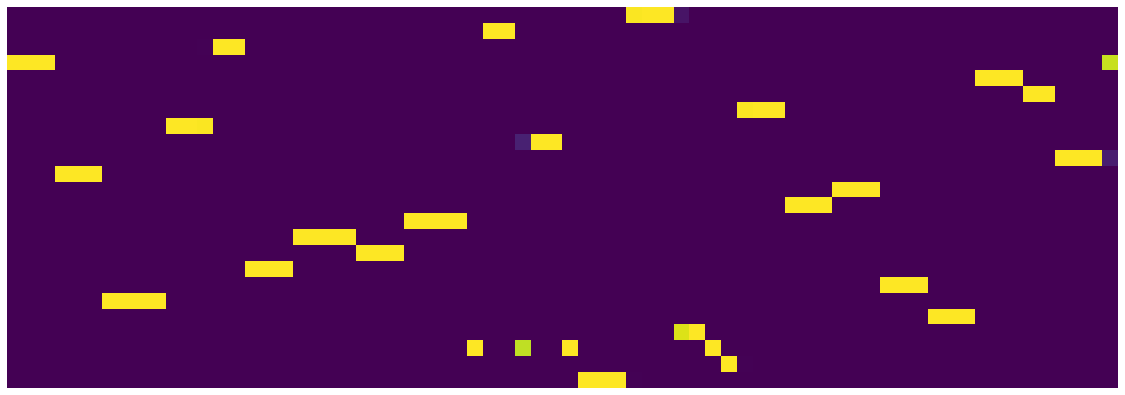

24 261 0.7379999999999998 0.4704433688893914


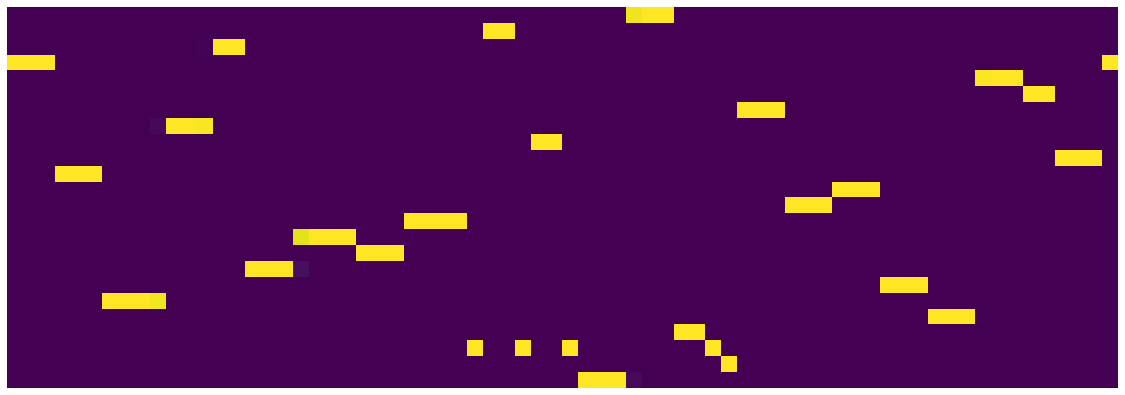

24 262 0.7369999999999998 0.46777539122849704


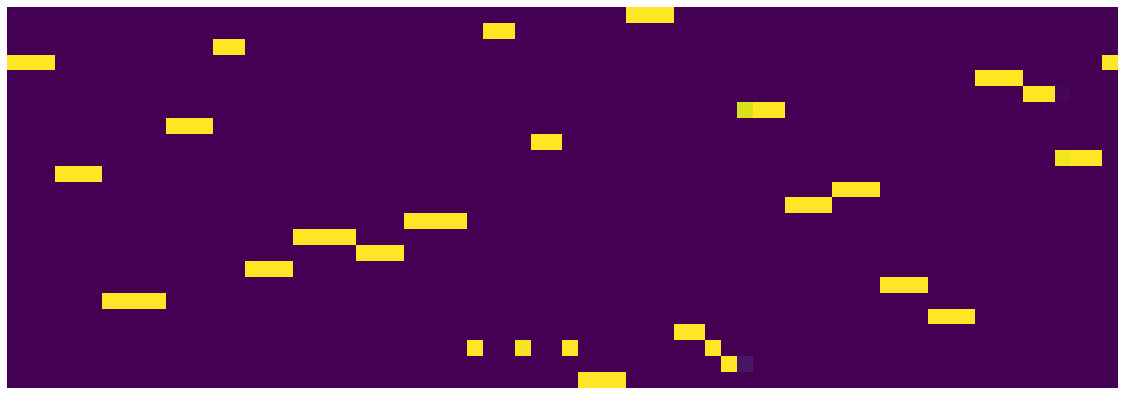

24 263 0.7359999999999998 0.471157524921


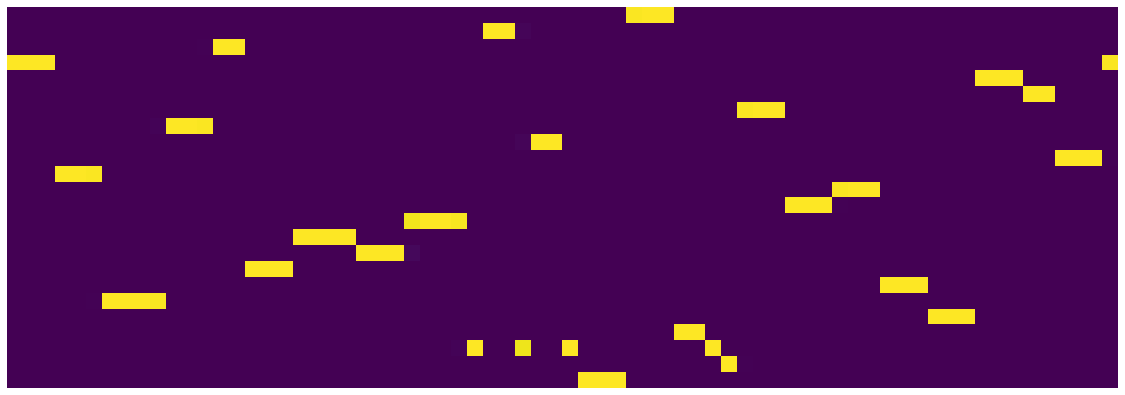

24 264 0.7349999999999998 0.4676849730312824


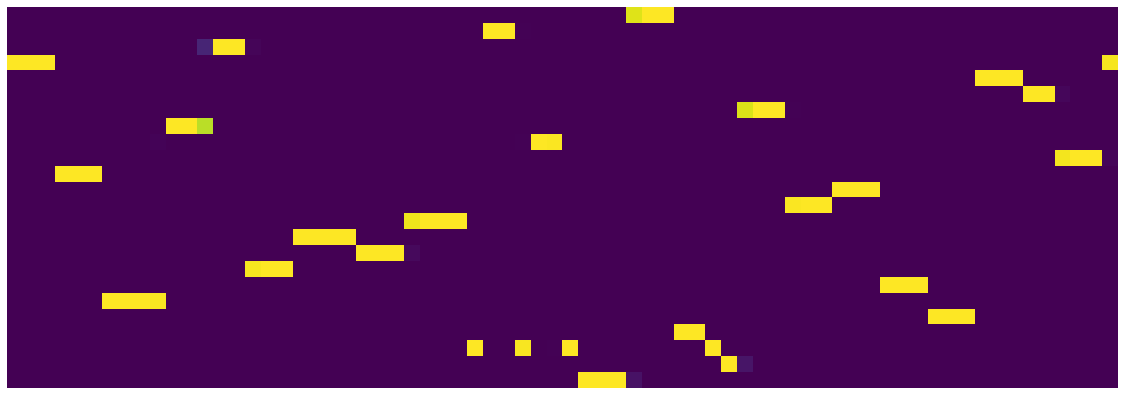

24 265 0.7339999999999998 0.4695283815264702


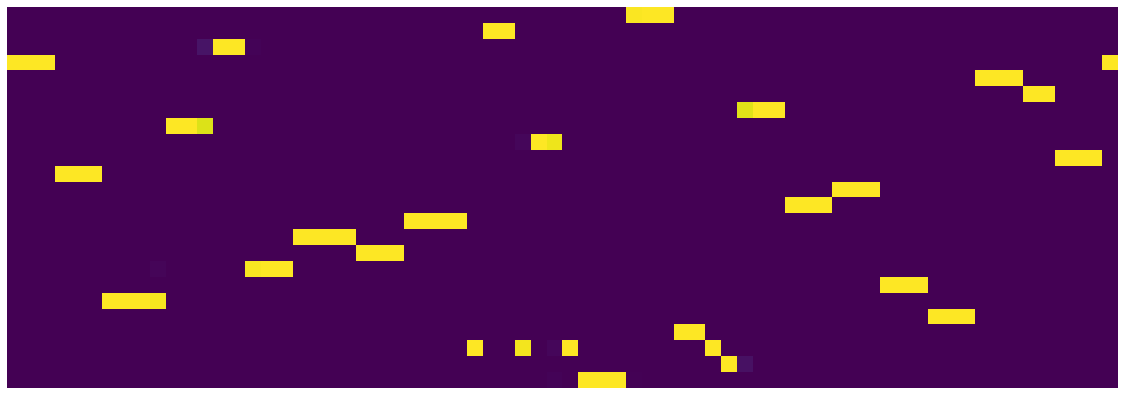

24 266 0.7329999999999998 0.4671379929408431


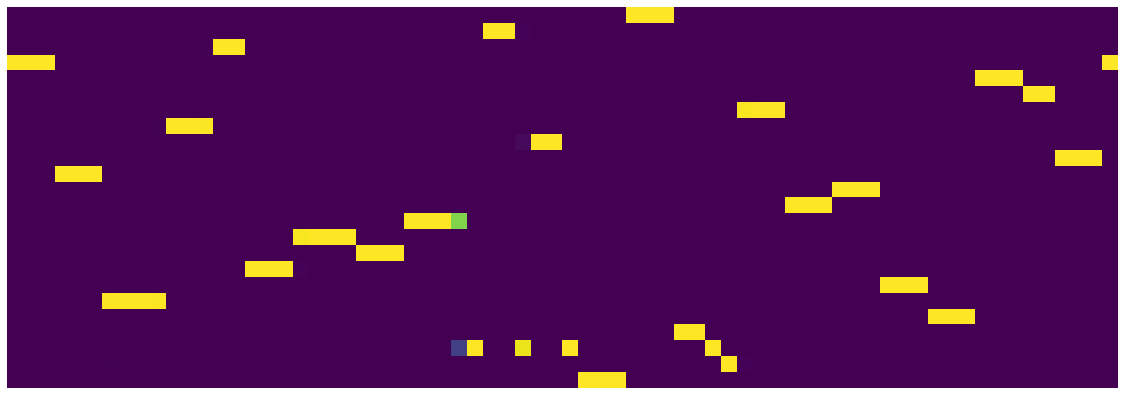

24 267 0.7319999999999998 0.46688037011772393


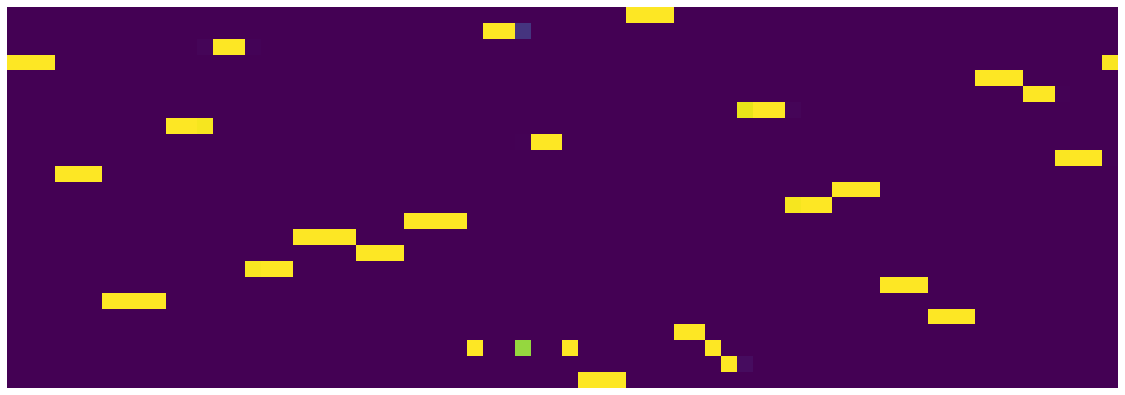

24 268 0.7309999999999998 0.46709681265056135


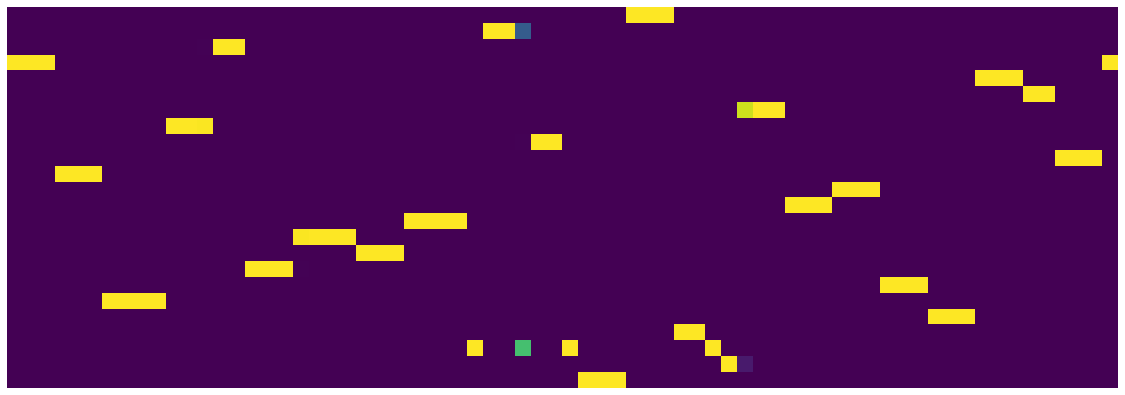

24 269 0.7299999999999998 0.4676029784604907


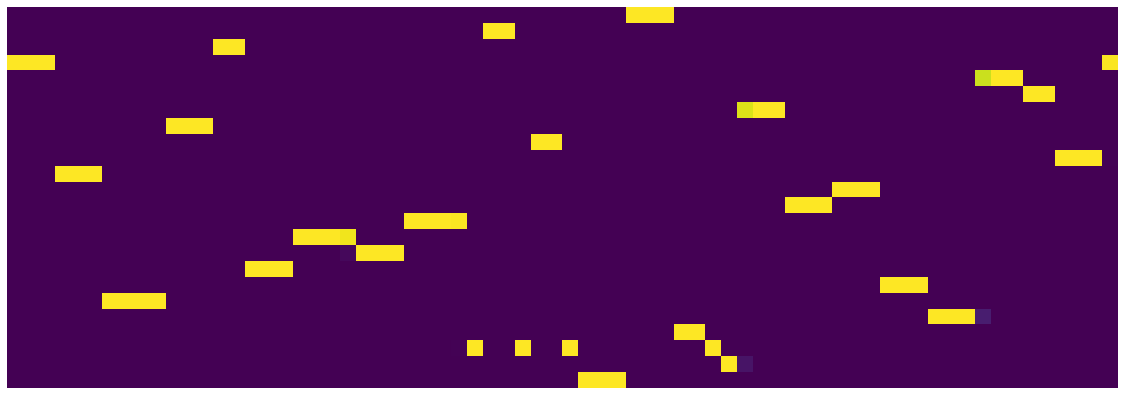

24 270 0.7289999999999998 0.4674718305468559


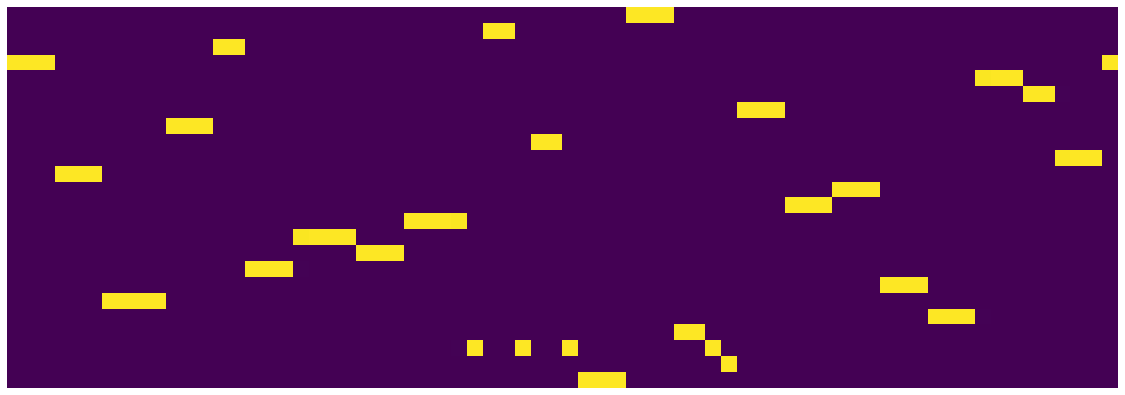

24 271 0.7279999999999998 0.4679272947832942


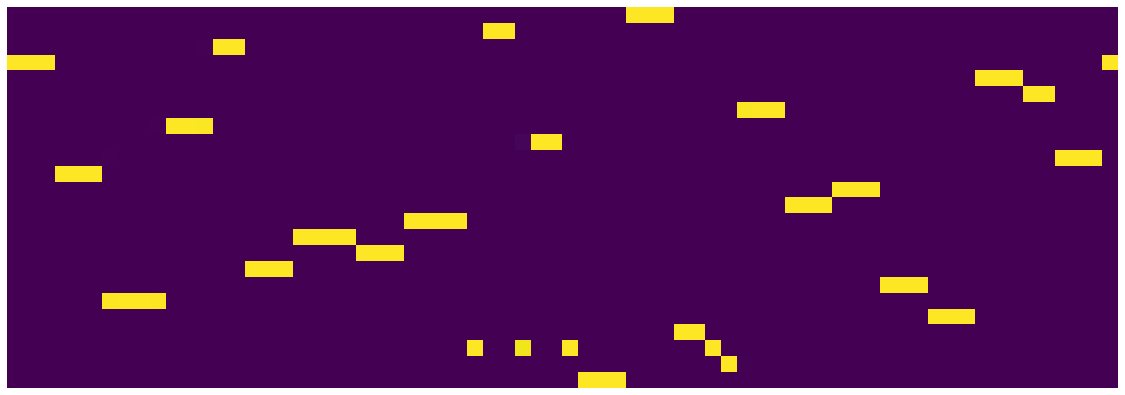

24 272 0.7269999999999998 0.46791987884789704


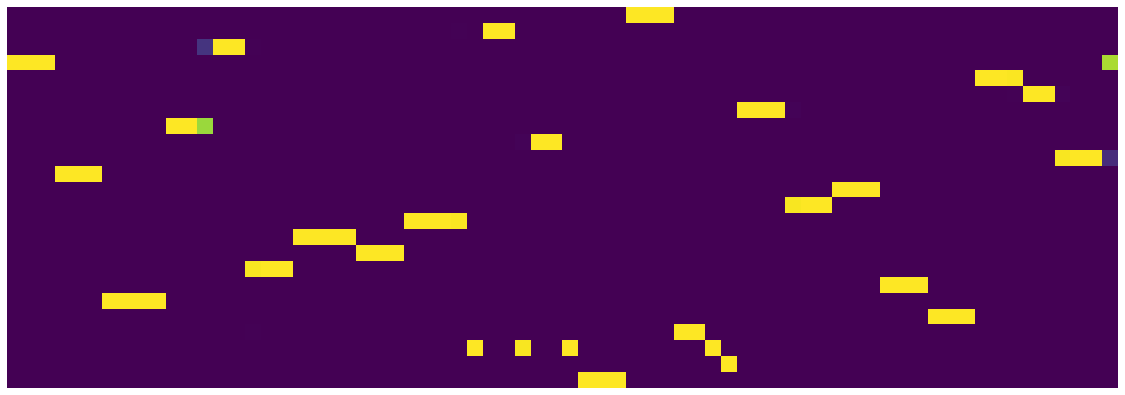

24 273 0.7259999999999998 0.46804715115576984


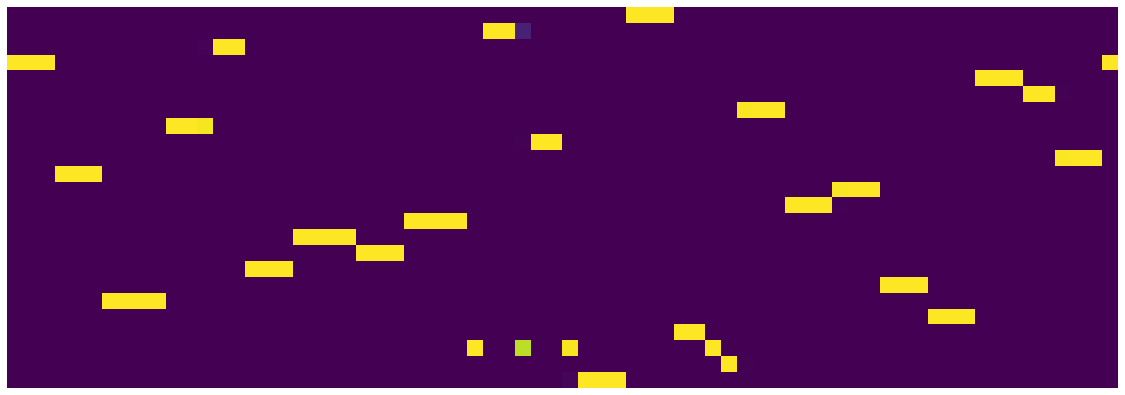

24 274 0.7249999999999998 0.46754295844584703


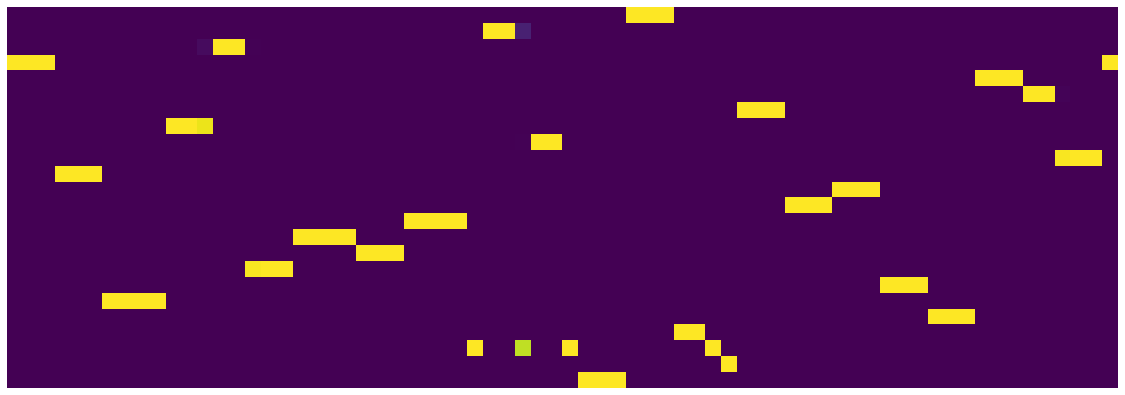

24 275 0.7239999999999998 0.4682588644325733


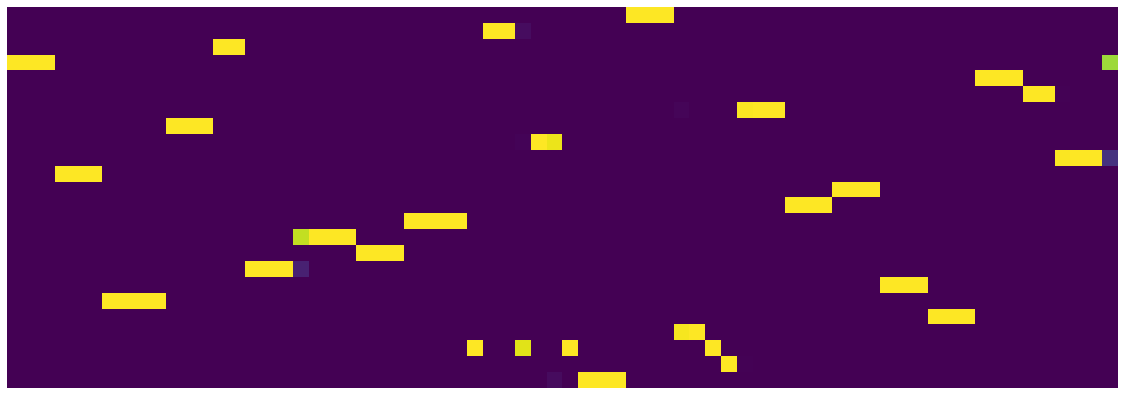

24 276 0.7229999999999998 0.4676860049366951


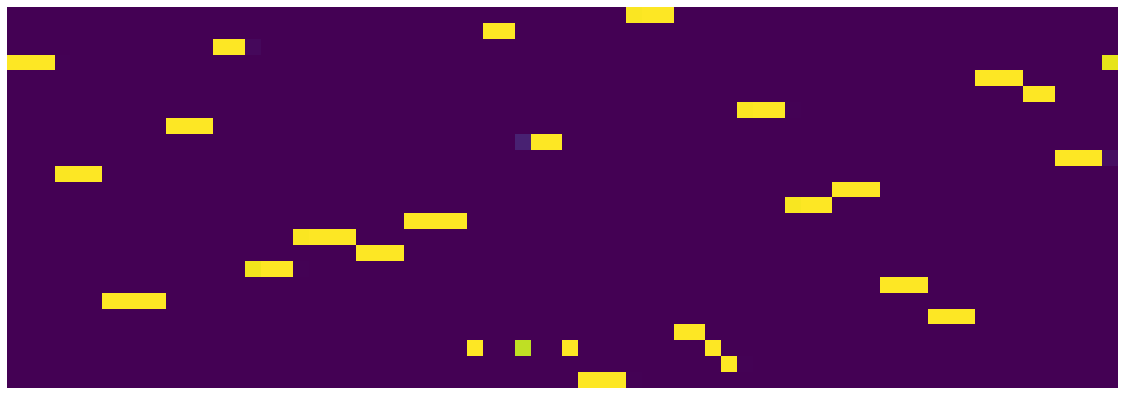

24 277 0.7219999999999998 0.46786716040223836


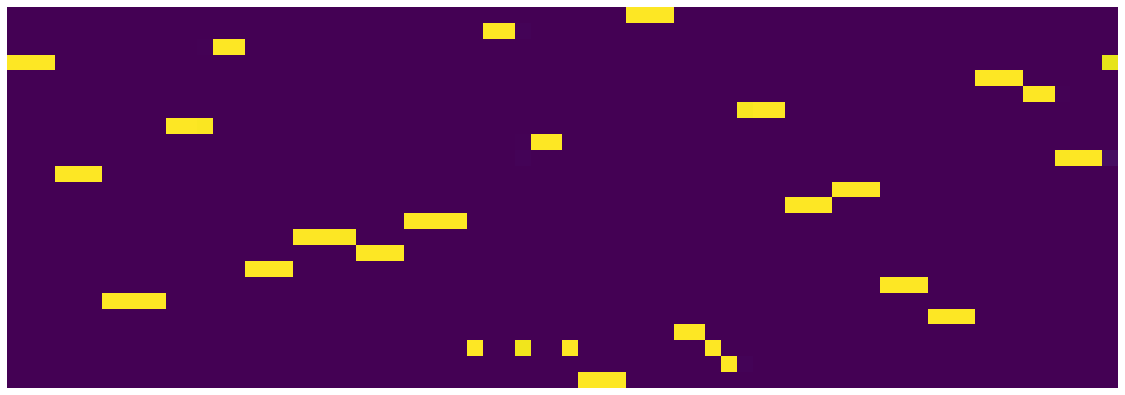

24 278 0.7209999999999998 0.4674871047958732


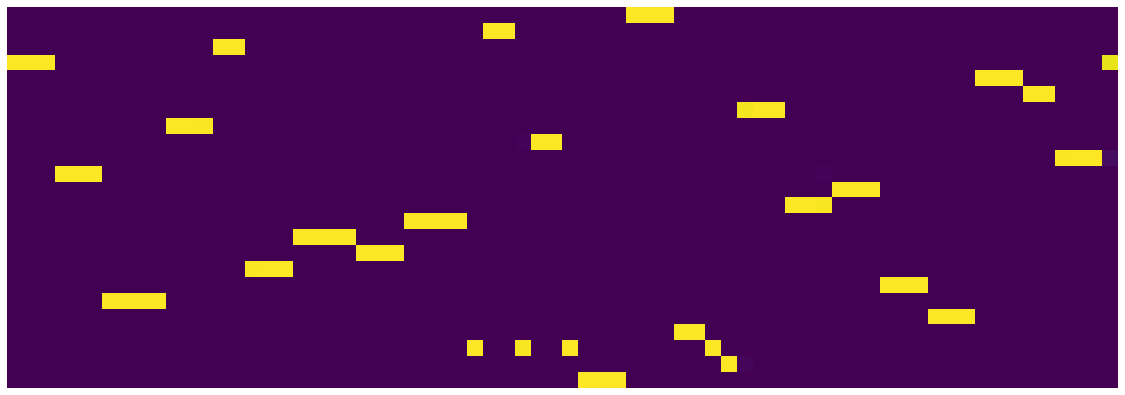

24 279 0.7199999999999998 0.46803333088755605


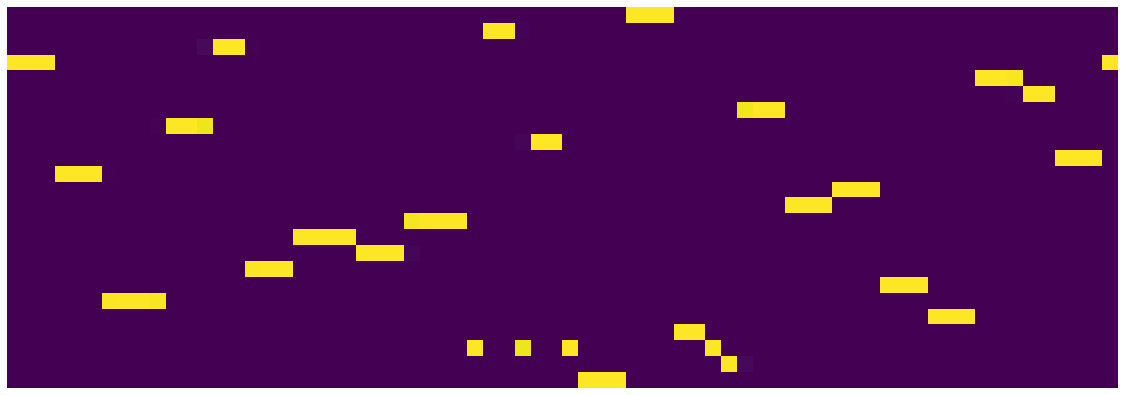

24 280 0.7189999999999998 0.46935678981244566


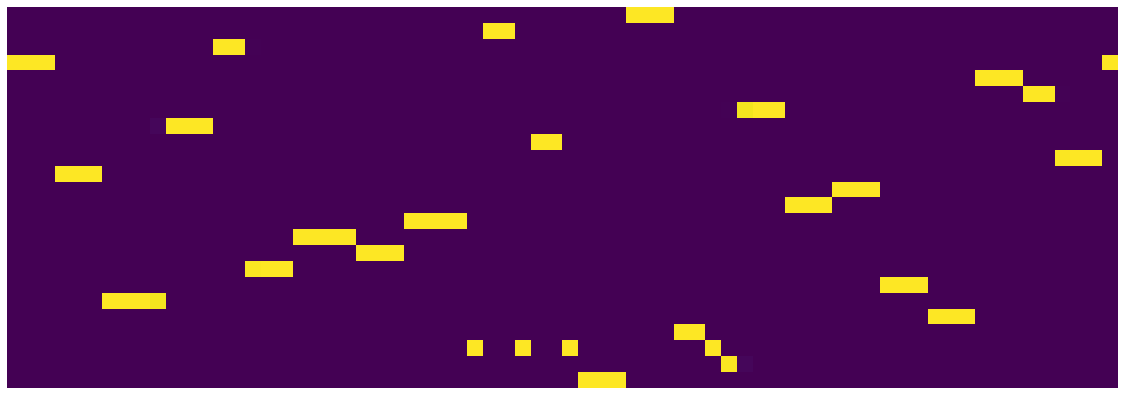

24 281 0.7179999999999997 0.46808526683598756


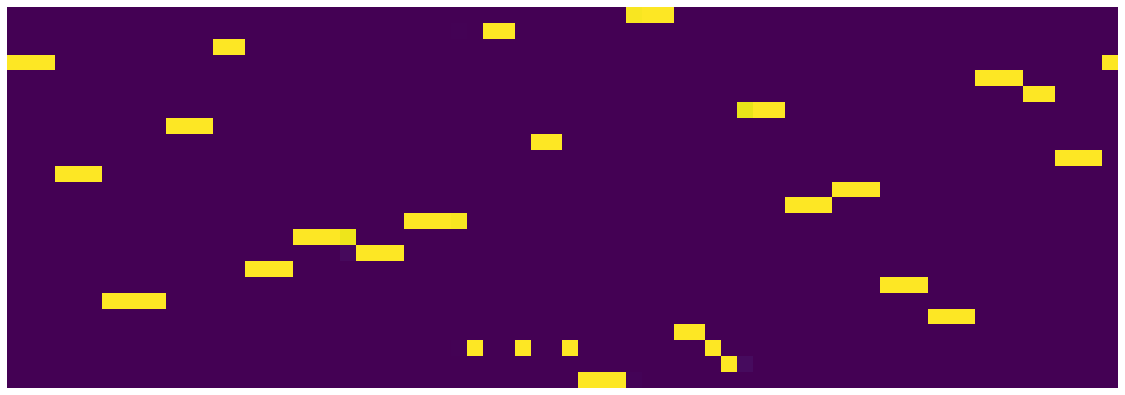

24 282 0.7169999999999997 0.47027062717825174


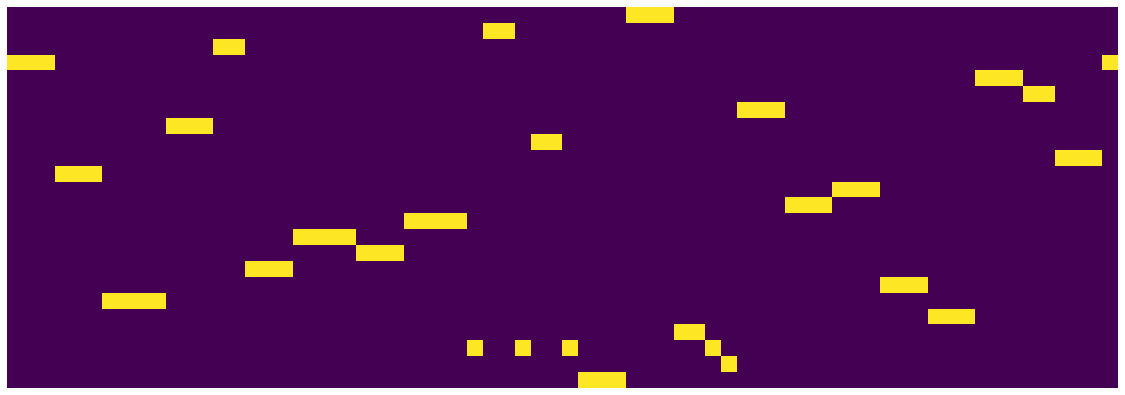

24 283 0.7159999999999997 0.46857361756265165


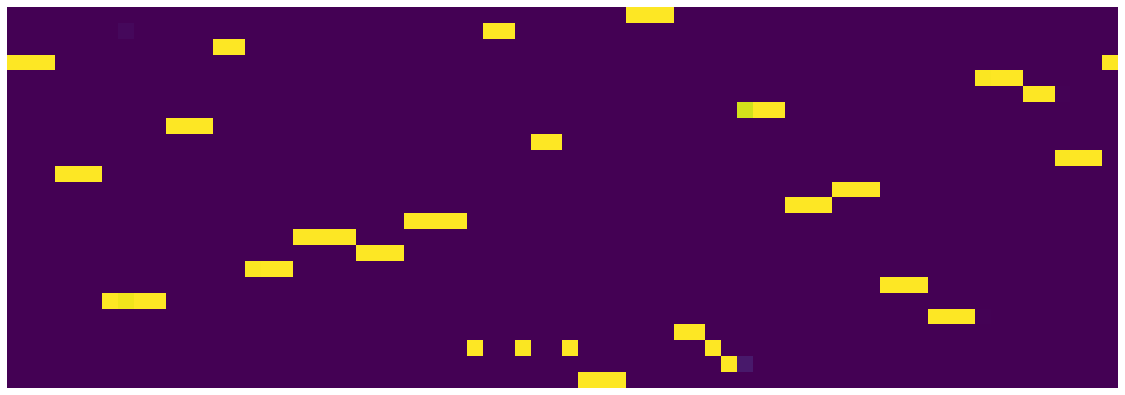

24 284 0.7149999999999997 0.4675827091559768


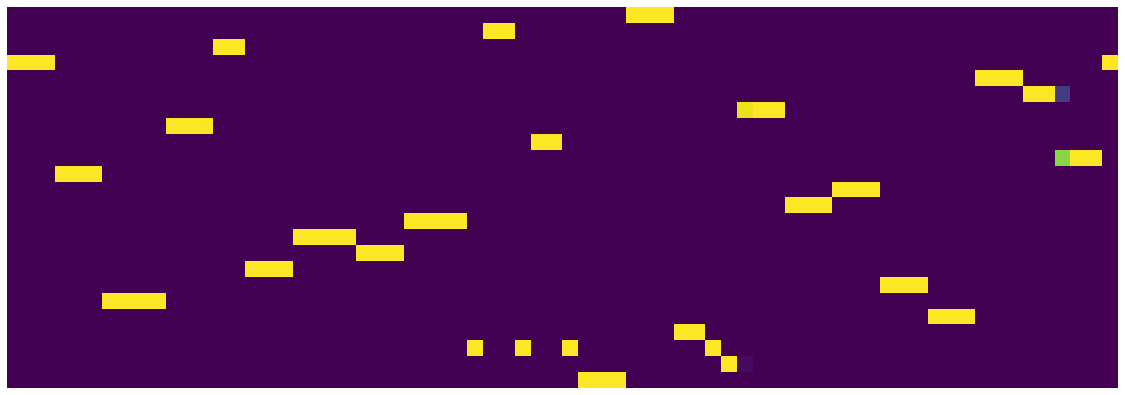

24 285 0.7139999999999997 0.46946703605353834


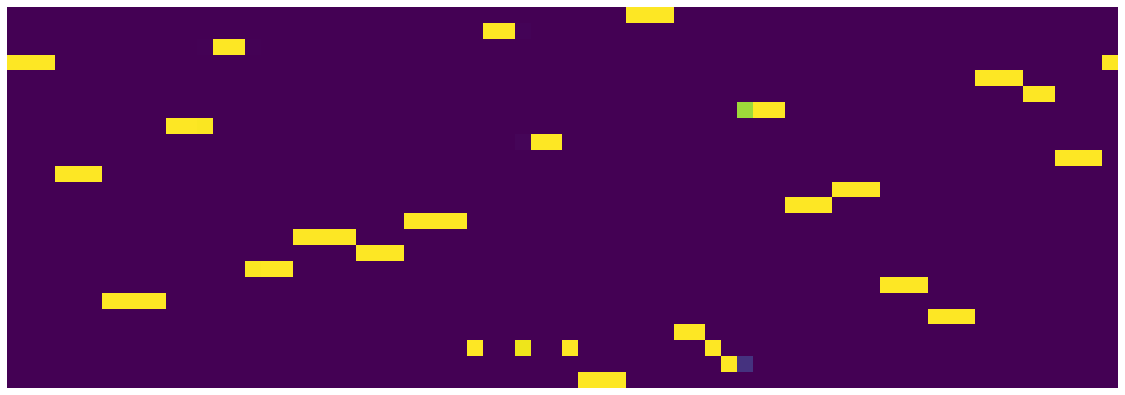

24 286 0.7129999999999997 0.4672820523381233


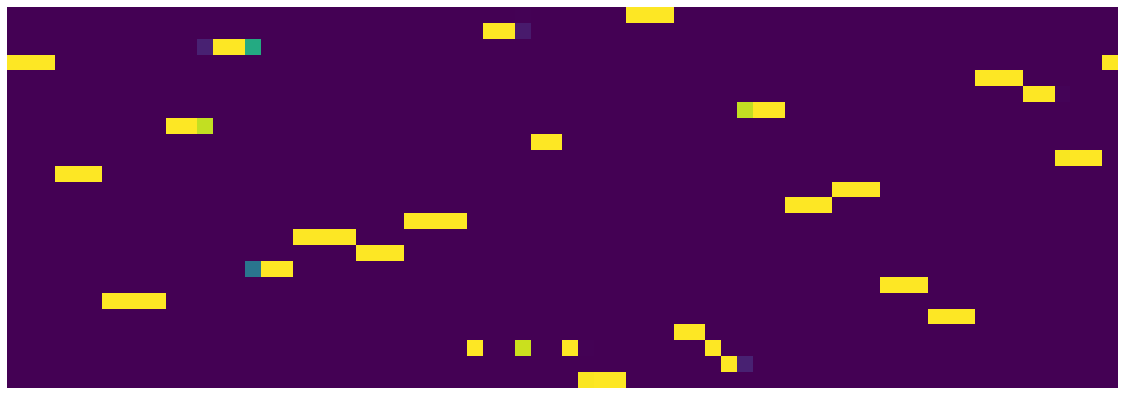

24 287 0.7119999999999997 0.469141848012805


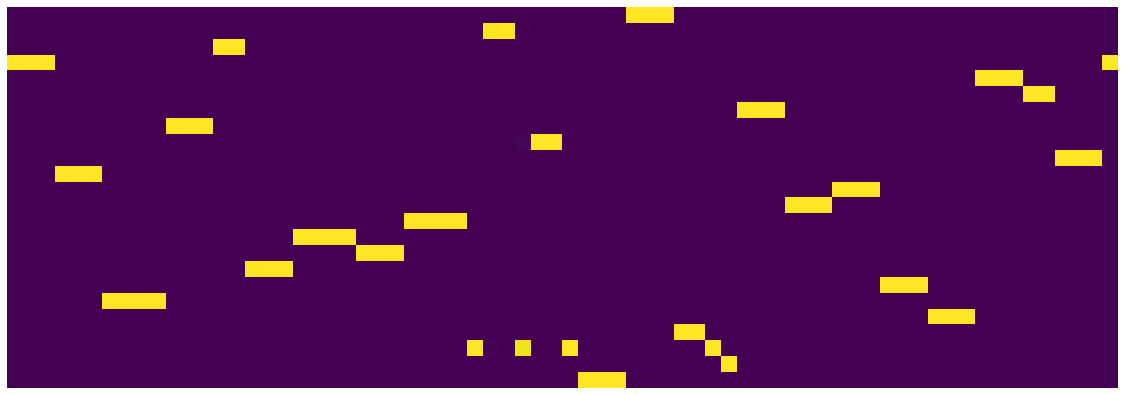

24 288 0.7109999999999997 0.467769892513752


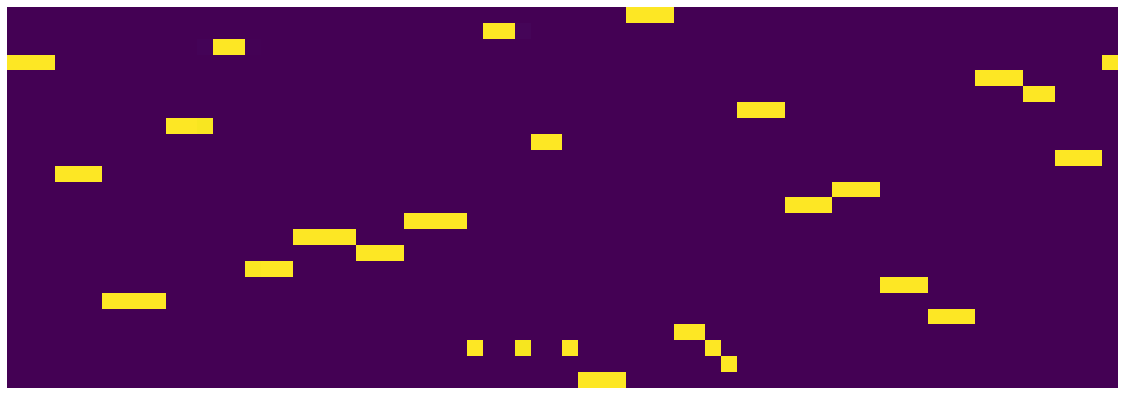

24 289 0.7099999999999997 0.46775233261287213


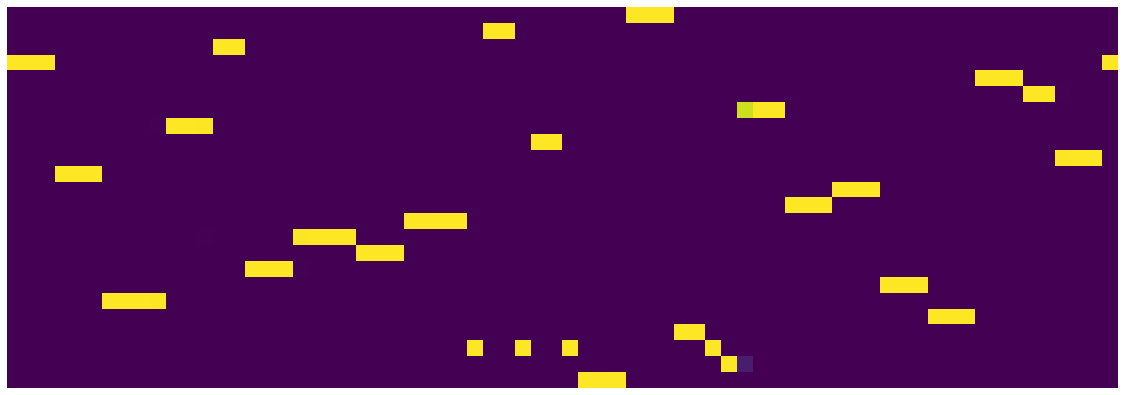

24 290 0.7089999999999997 0.46710689216852186


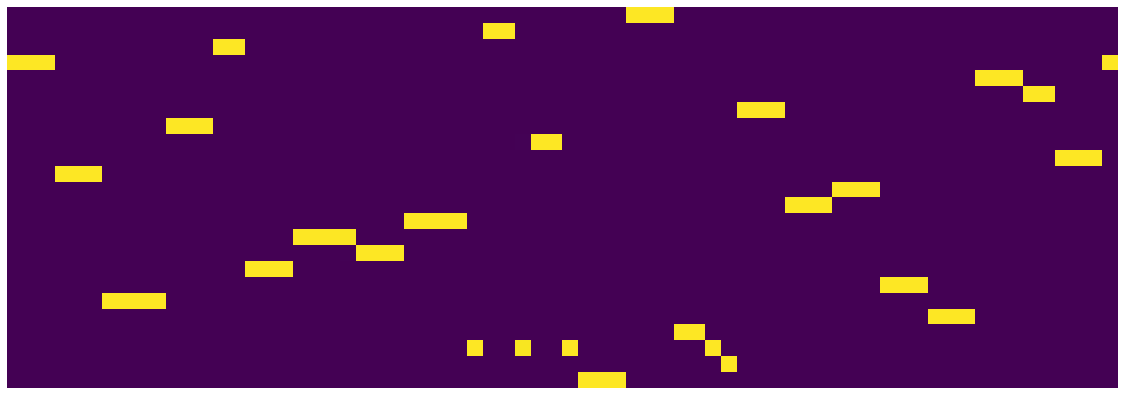

24 291 0.7079999999999997 0.4674336265772581


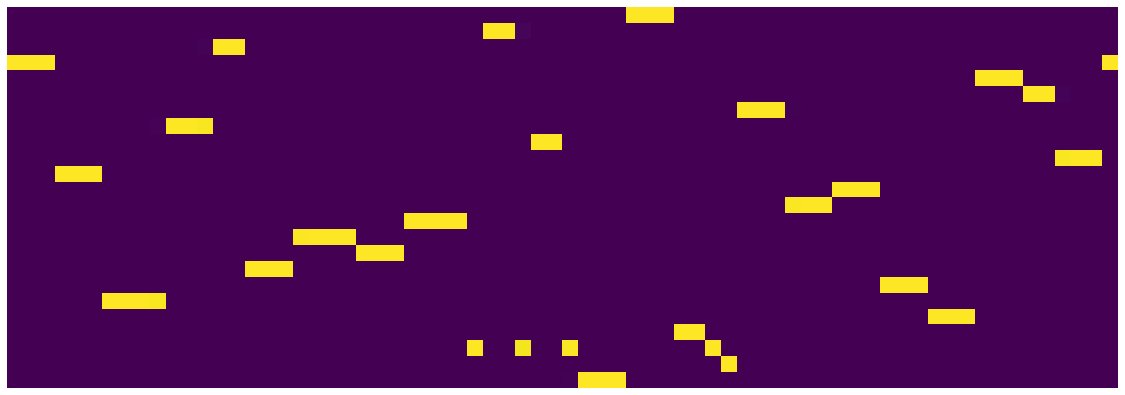

24 292 0.7069999999999997 0.46794269550591705


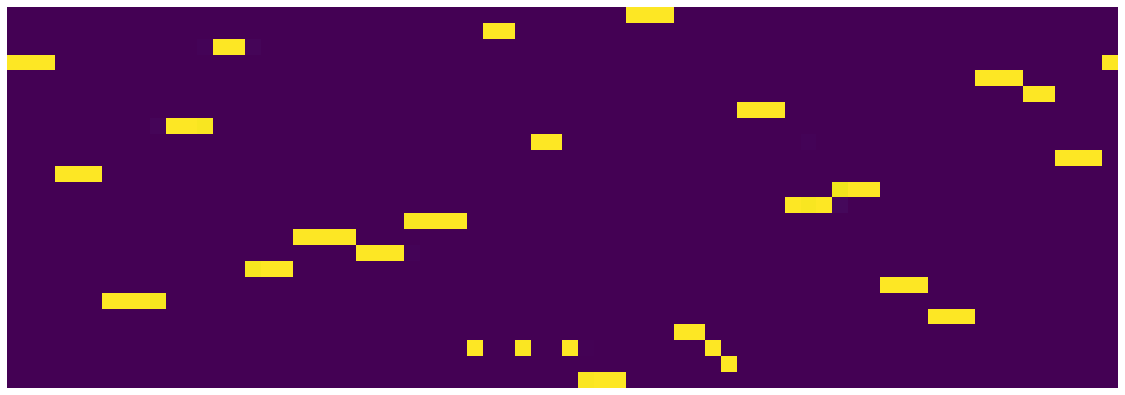

24 293 0.7059999999999997 0.4677926007658243


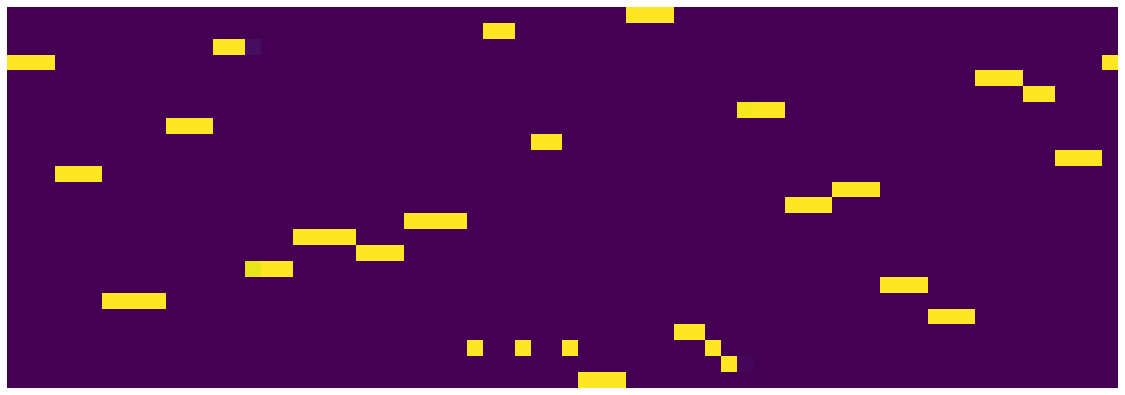

24 294 0.7049999999999997 0.46758350934833287


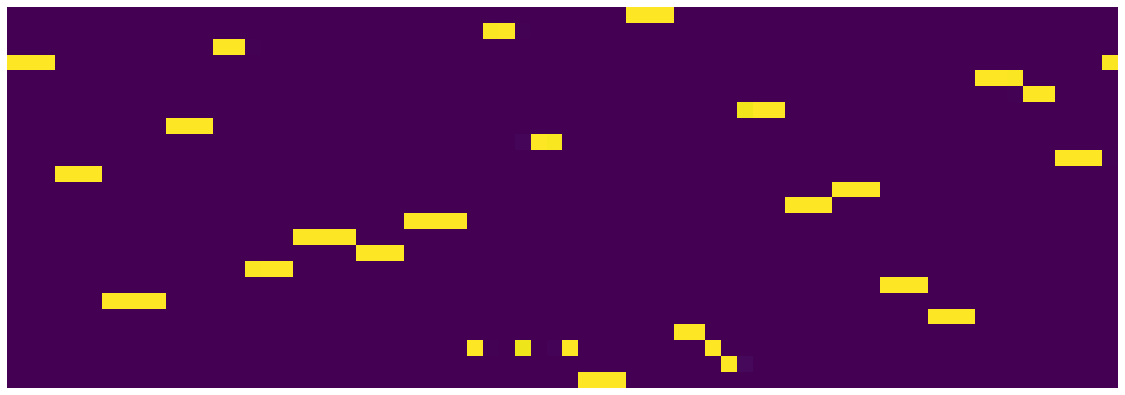

24 295 0.7039999999999997 0.4684233969077468


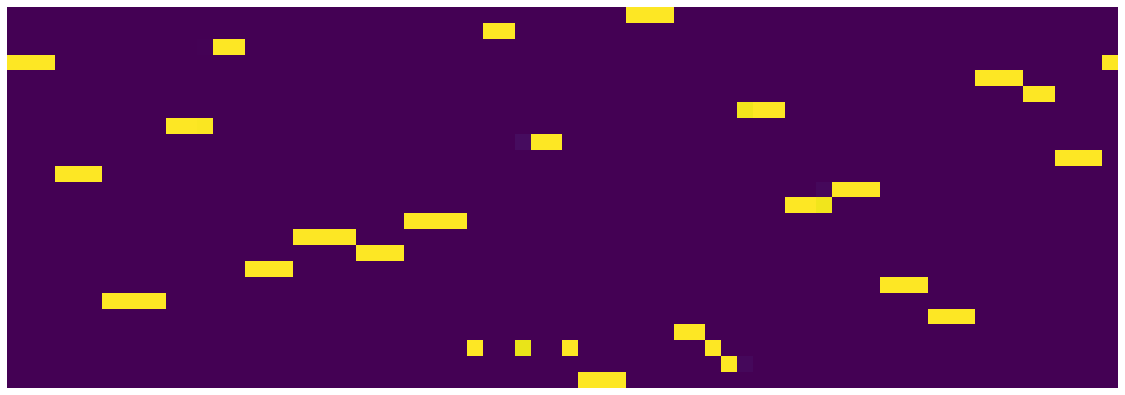

24 296 0.7029999999999997 0.4684322072193027


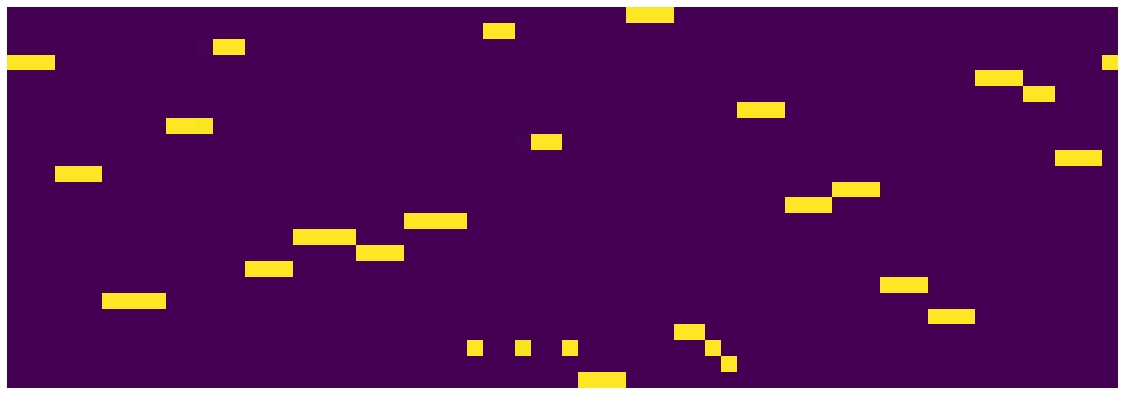

24 297 0.7019999999999997 0.4679179465398192


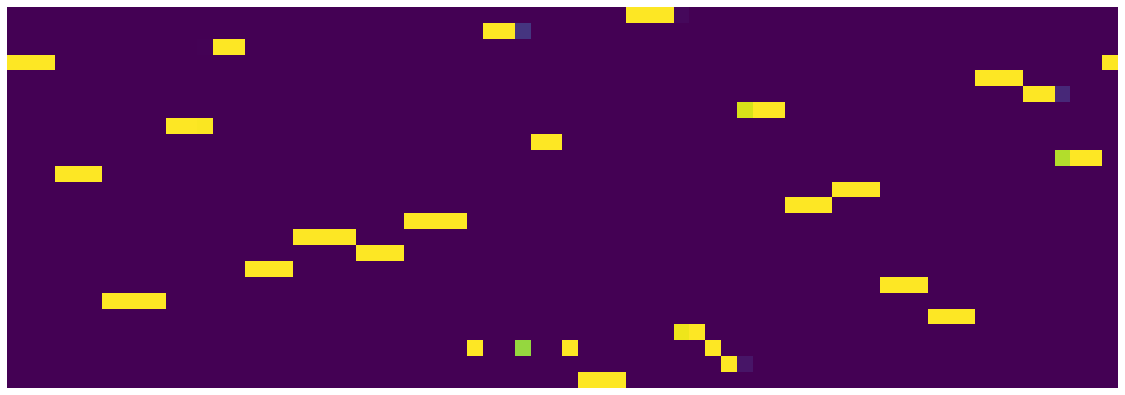

24 298 0.7009999999999997 0.46798647195100784


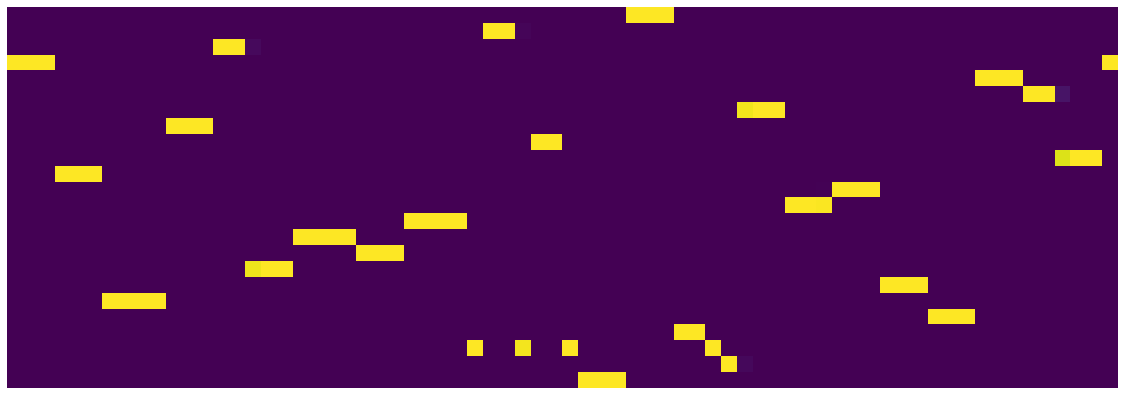

24 299 0.6999999999999997 0.46764208283275366


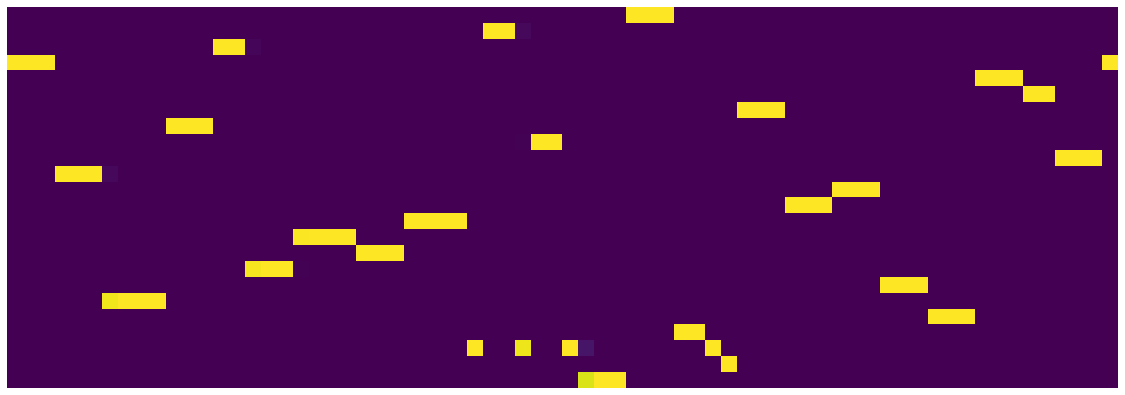

24 300 0.6989999999999997 0.47844154462218286


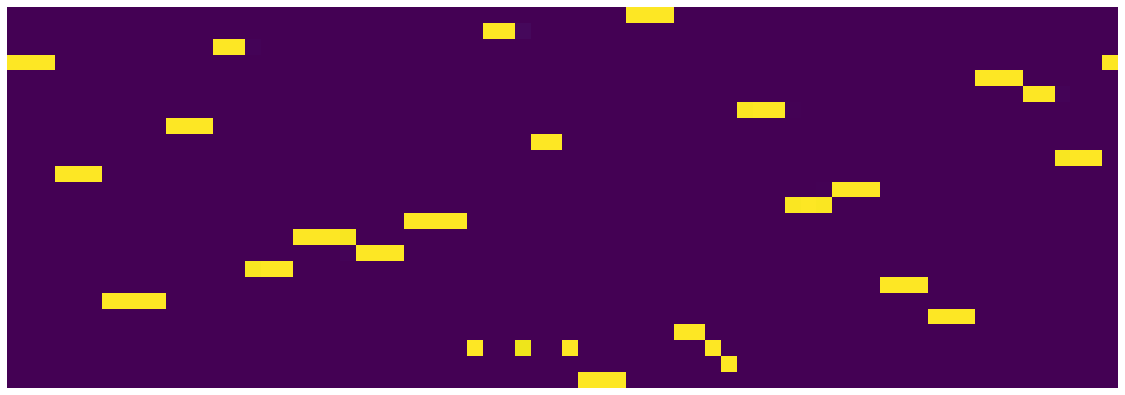

24 301 0.6979999999999997 0.4794120481237769


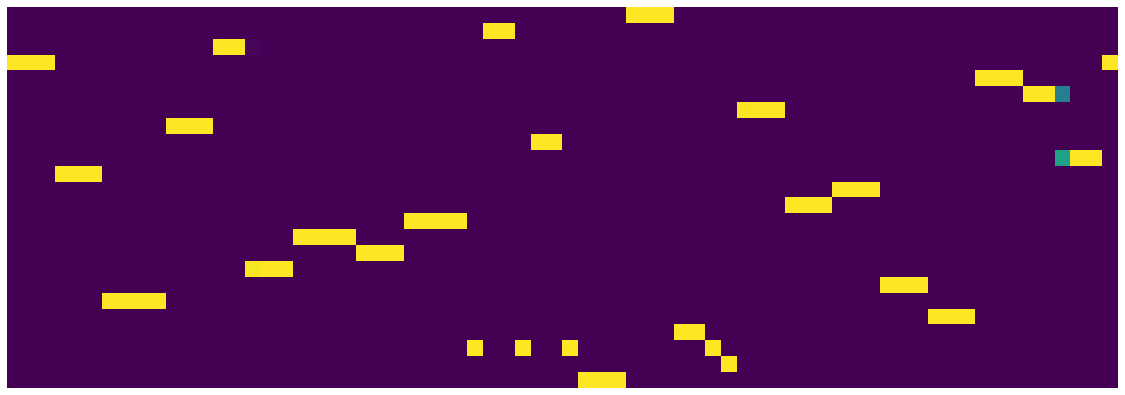

24 302 0.6969999999999997 0.47918986938893793


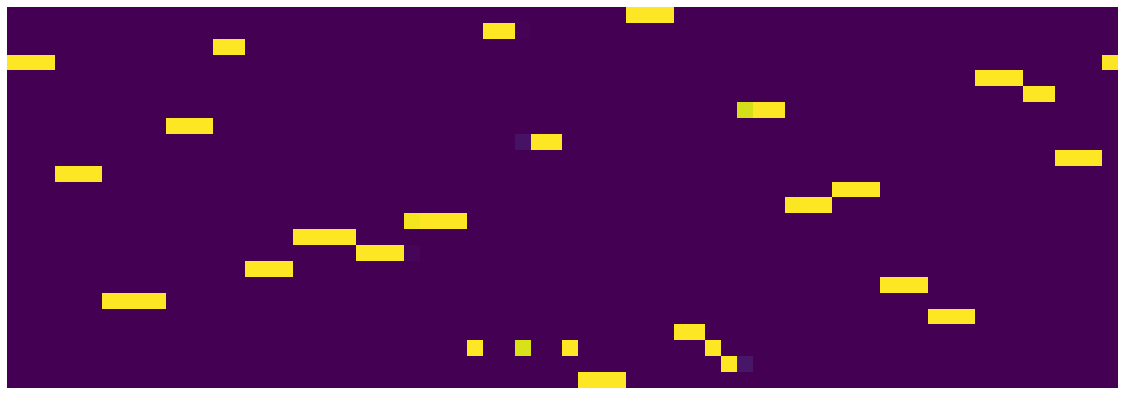

24 303 0.6959999999999997 0.4790553910657763


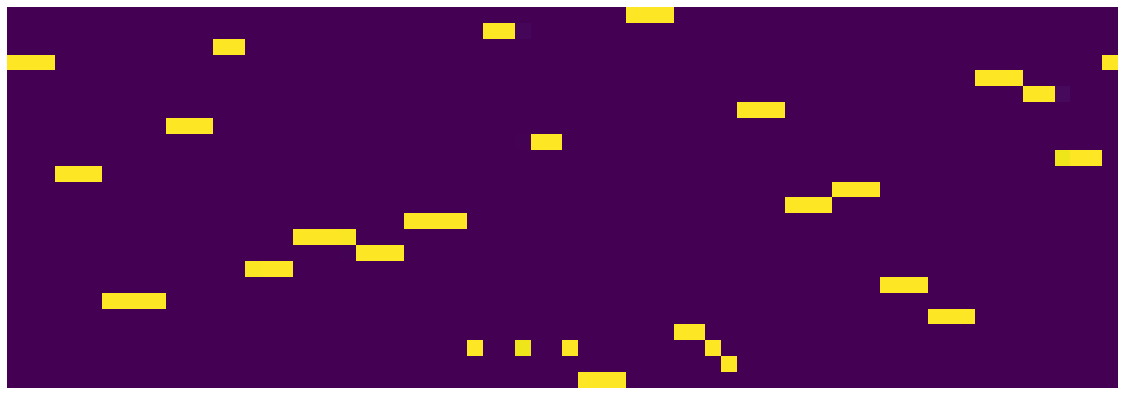

24 304 0.6949999999999997 0.47941966596990826


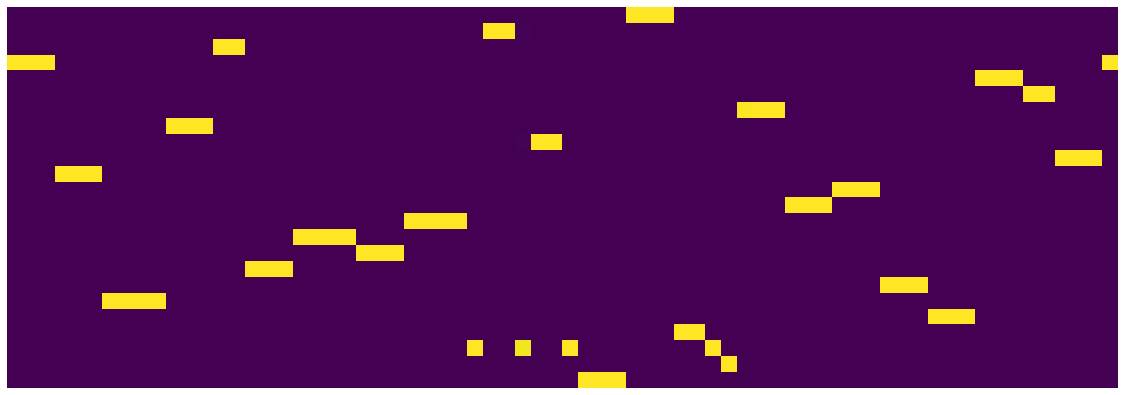

24 305 0.6939999999999997 0.47867325097322466


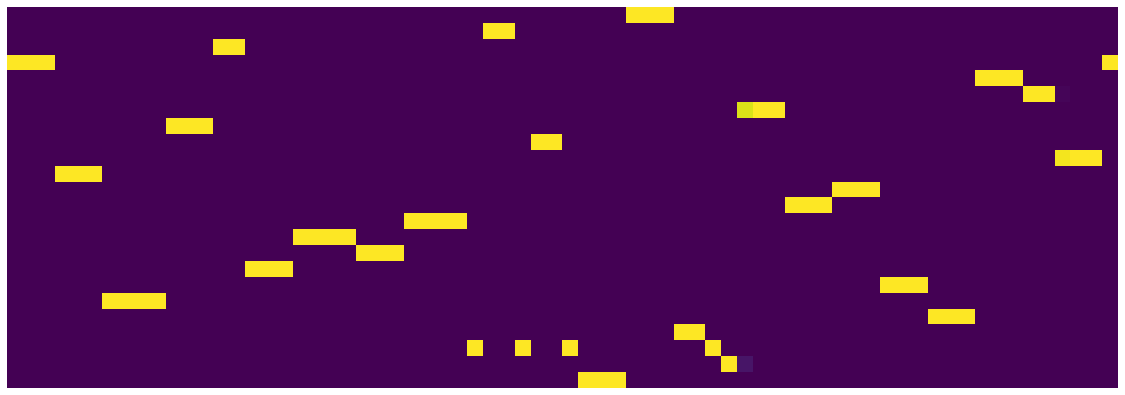

24 306 0.6929999999999997 0.47955221142619847


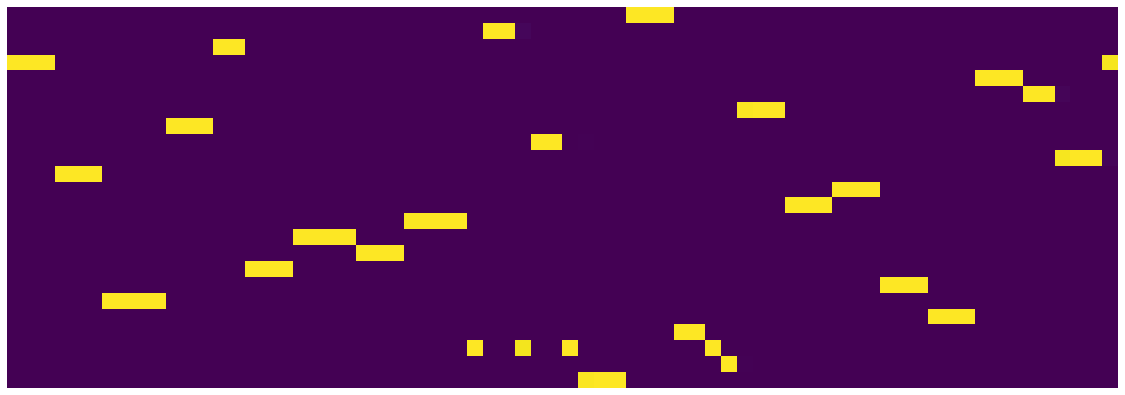

24 307 0.6919999999999997 0.4789046626538038


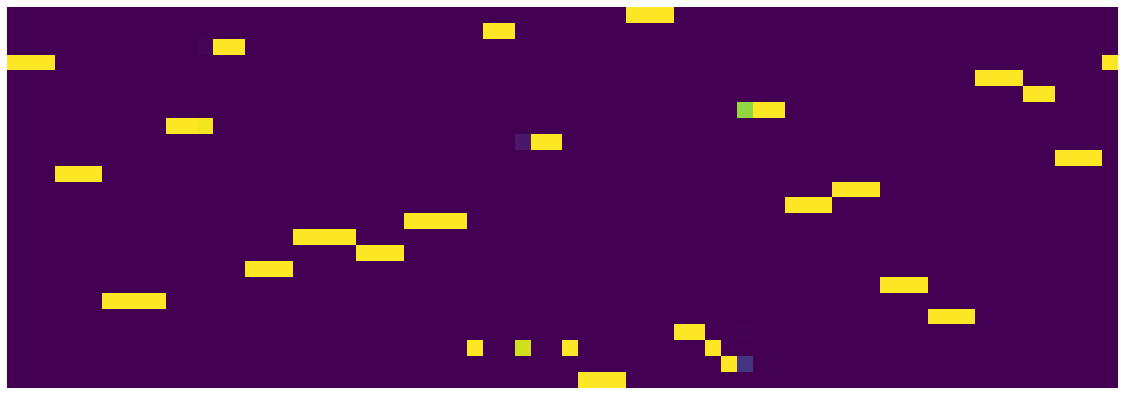

24 308 0.6909999999999997 0.4783862538635731


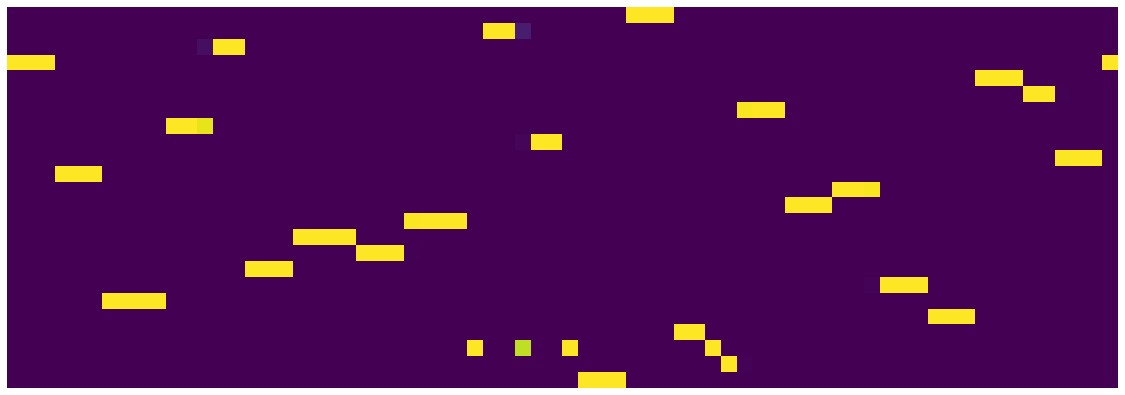

24 309 0.6899999999999997 0.47912264950573447


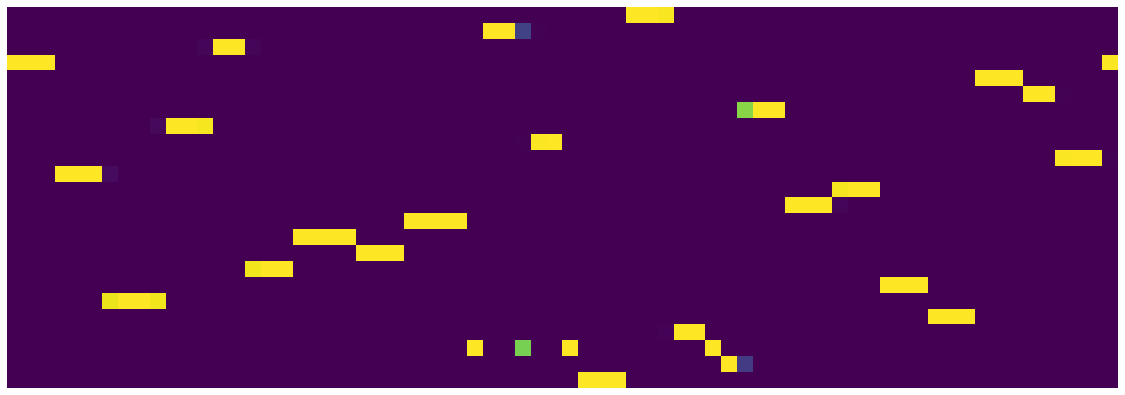

24 310 0.6889999999999997 0.4803169868886471


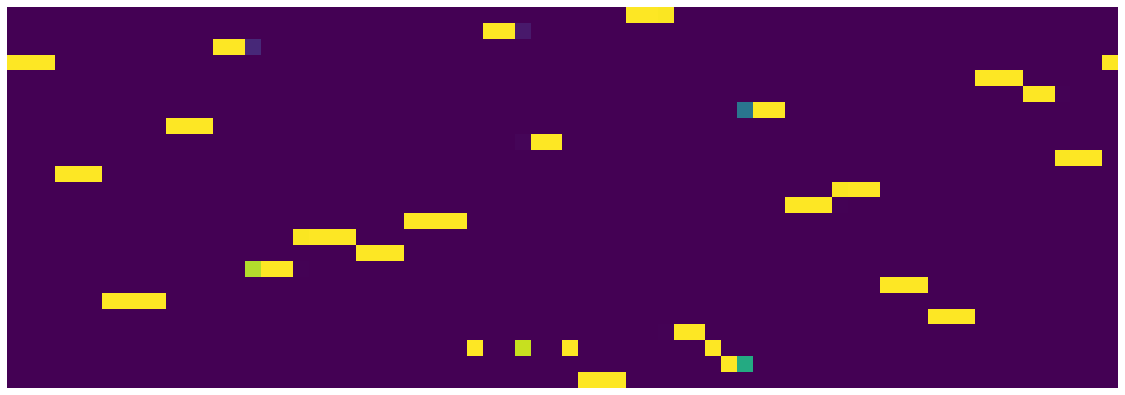

24 311 0.6879999999999997 0.4787645019590855


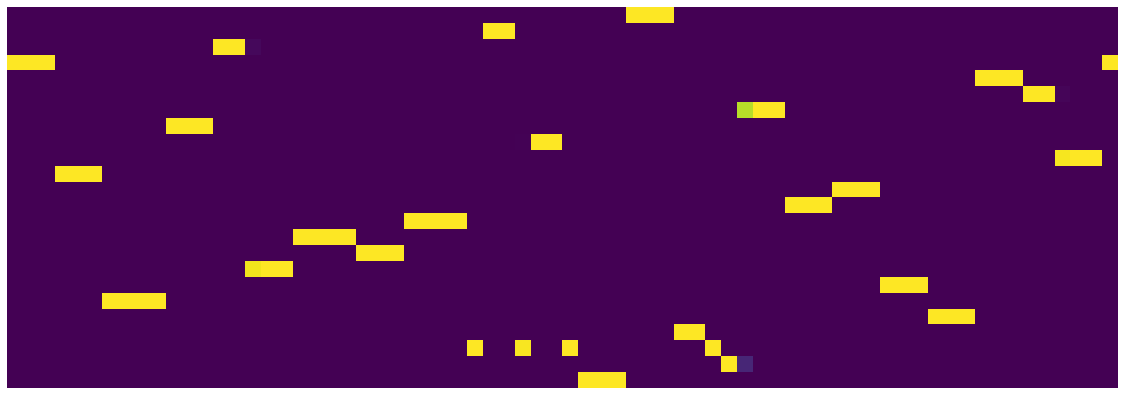

24 312 0.6869999999999997 0.4790779039263725


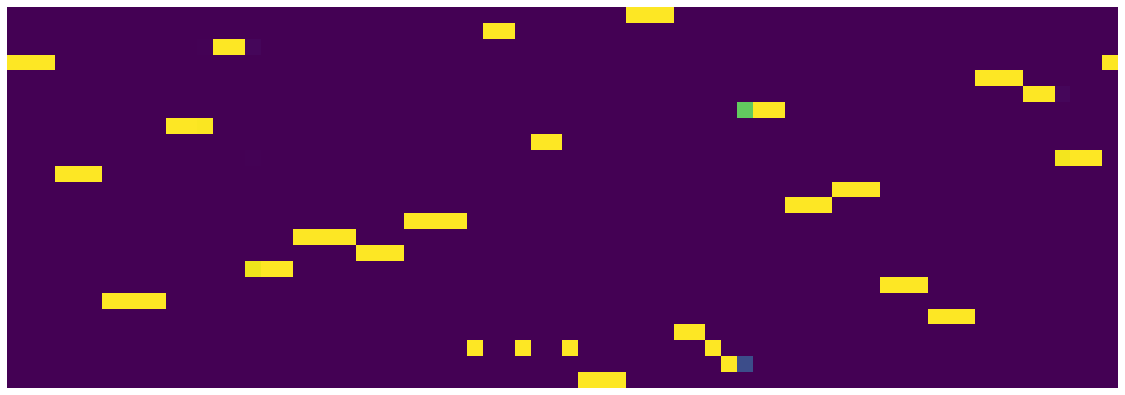

24 313 0.6859999999999997 0.47951288484036925


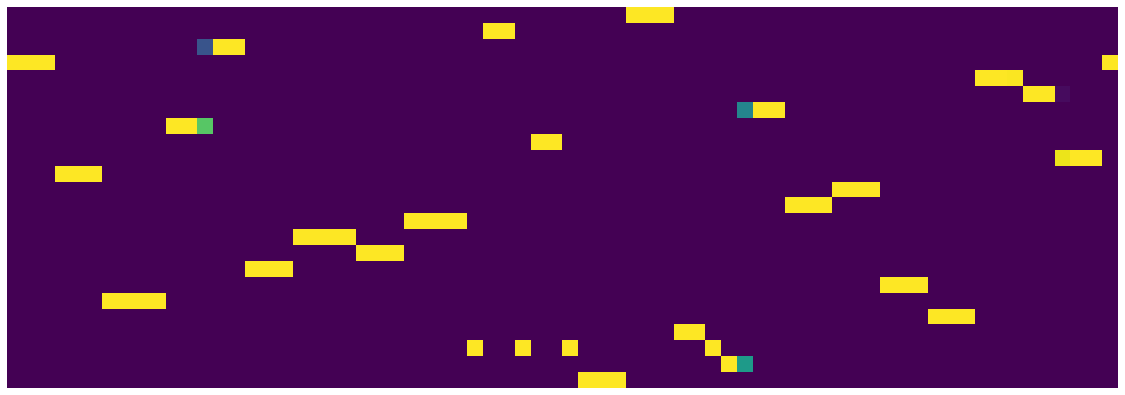

24 314 0.6849999999999997 0.4789258226752281


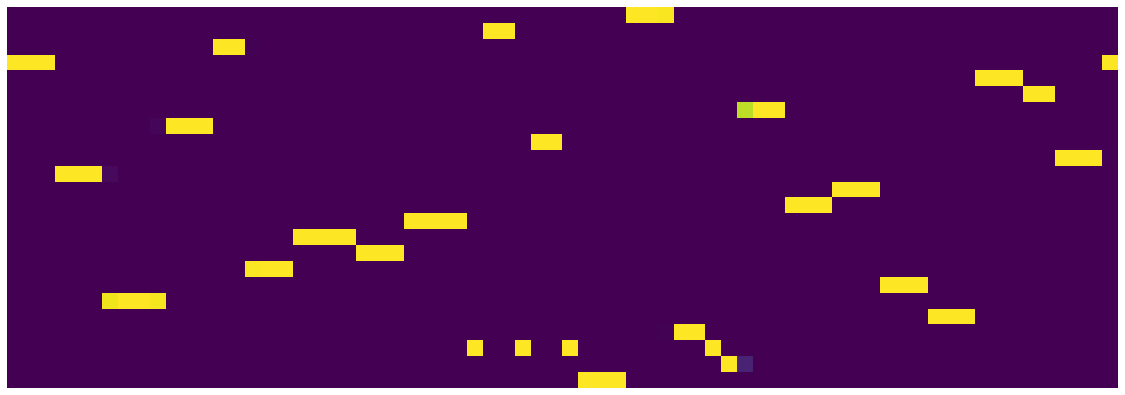

24 315 0.6839999999999997 0.479102018289268


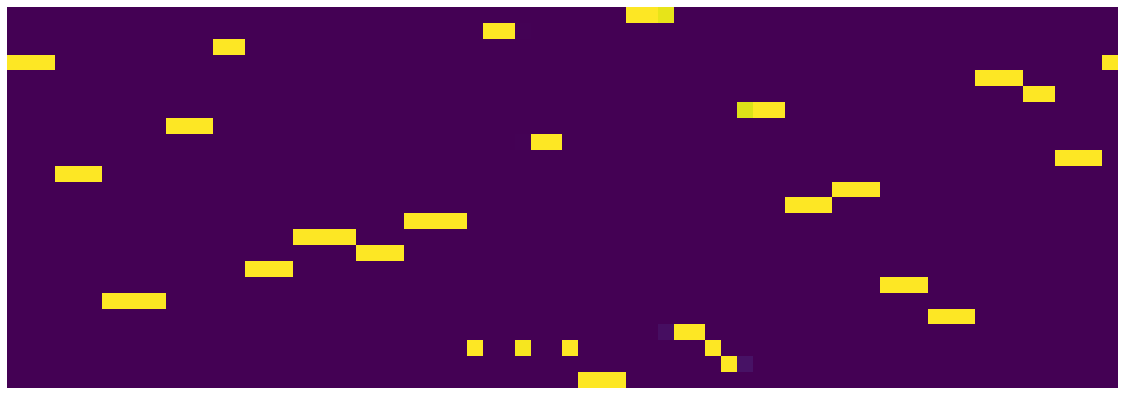

24 316 0.6829999999999997 0.47997471056878566


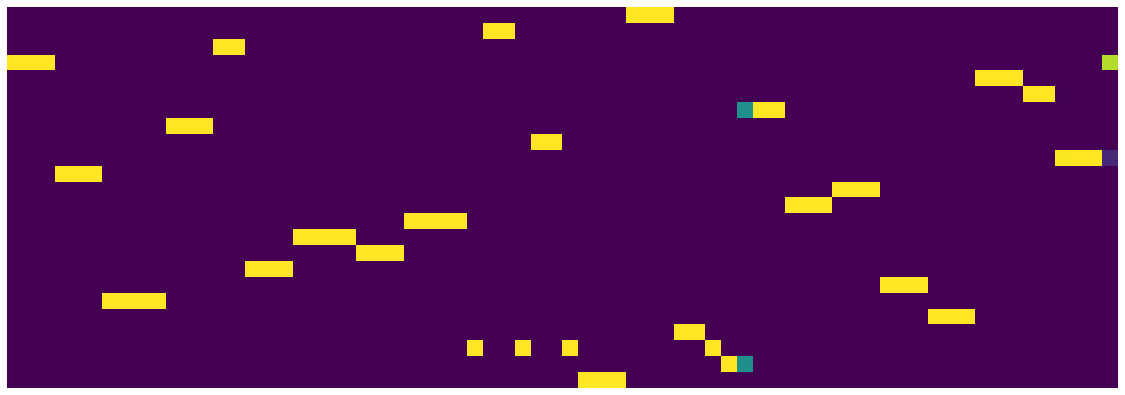

24 317 0.6819999999999997 0.4787574984133244


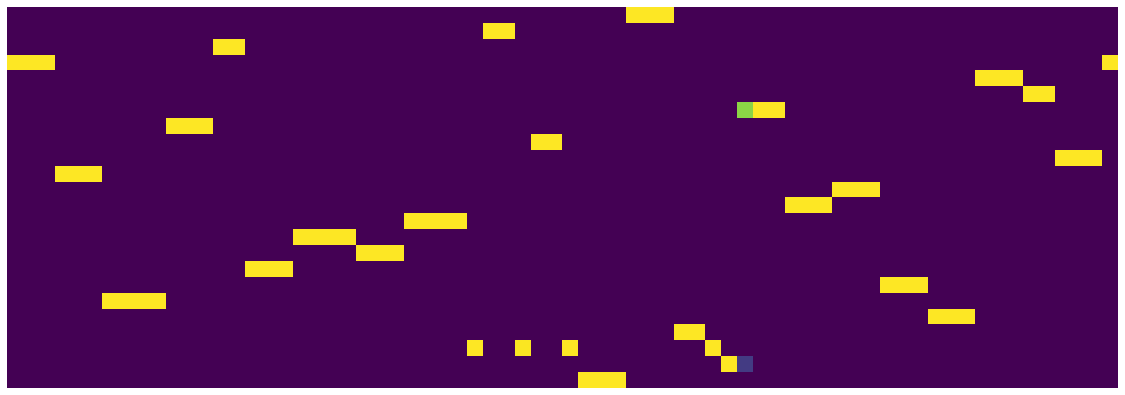

24 318 0.6809999999999997 0.47886234931647775


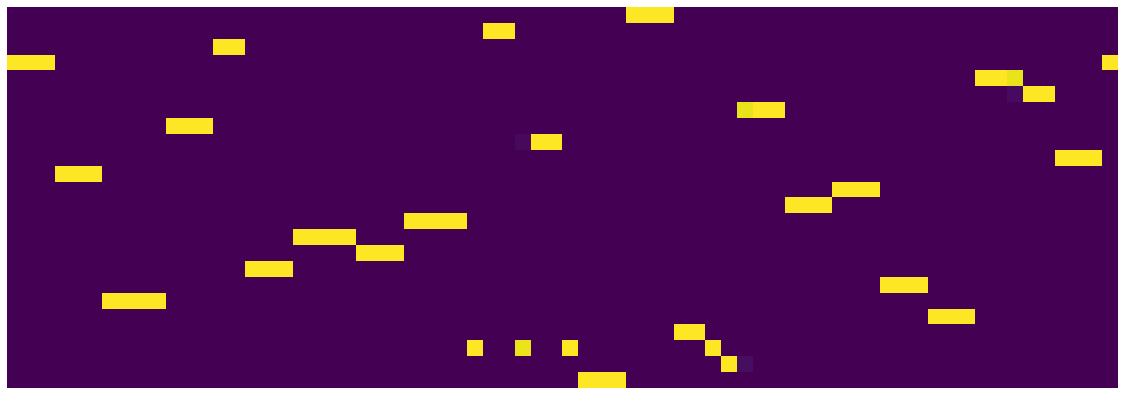

24 319 0.6799999999999997 0.47906987722963096


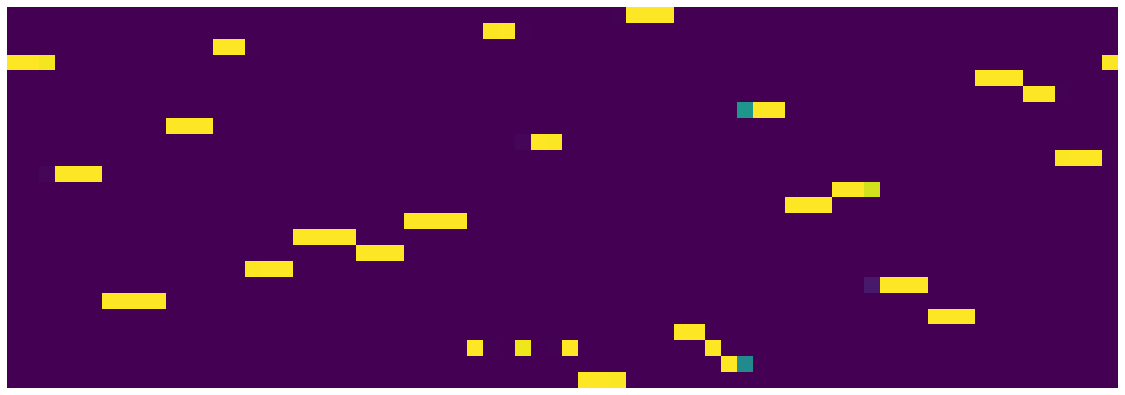

24 320 0.6789999999999997 0.47890812531113625


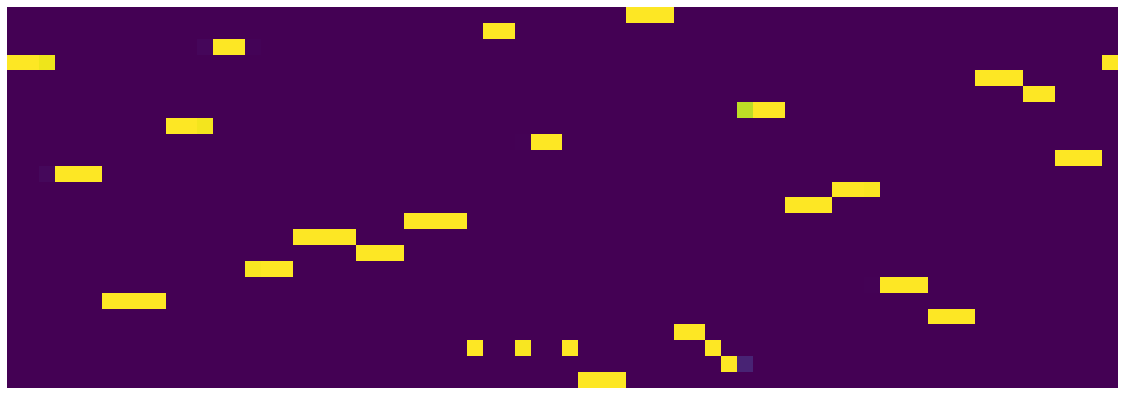

24 321 0.6779999999999997 0.4790961554273963


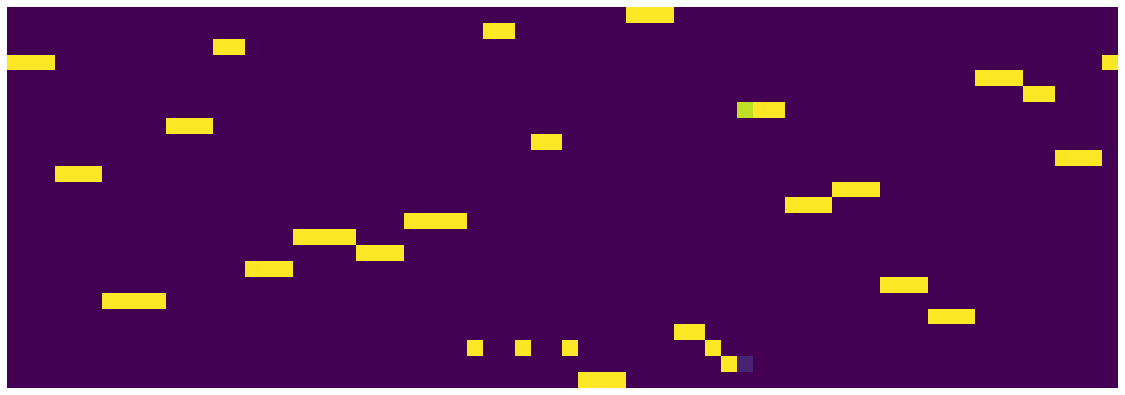

24 322 0.6769999999999997 0.47868429832160475


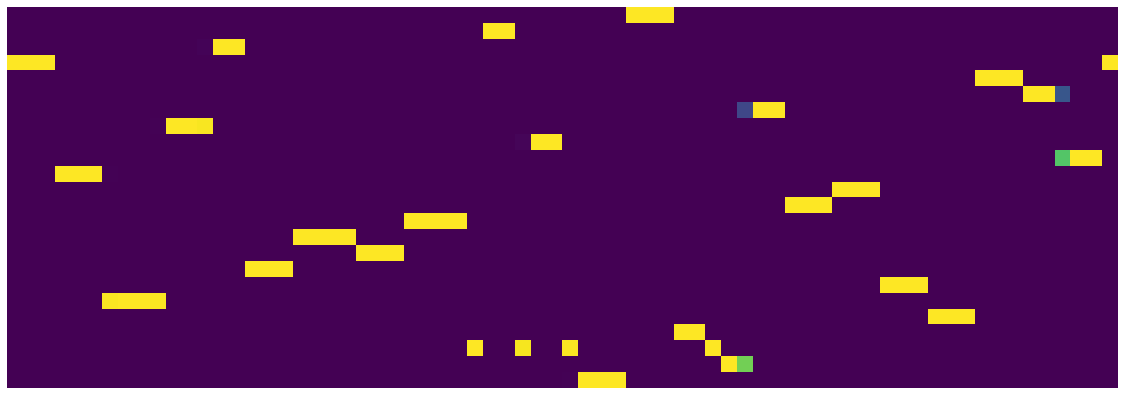

24 323 0.6759999999999997 0.47790970019996165


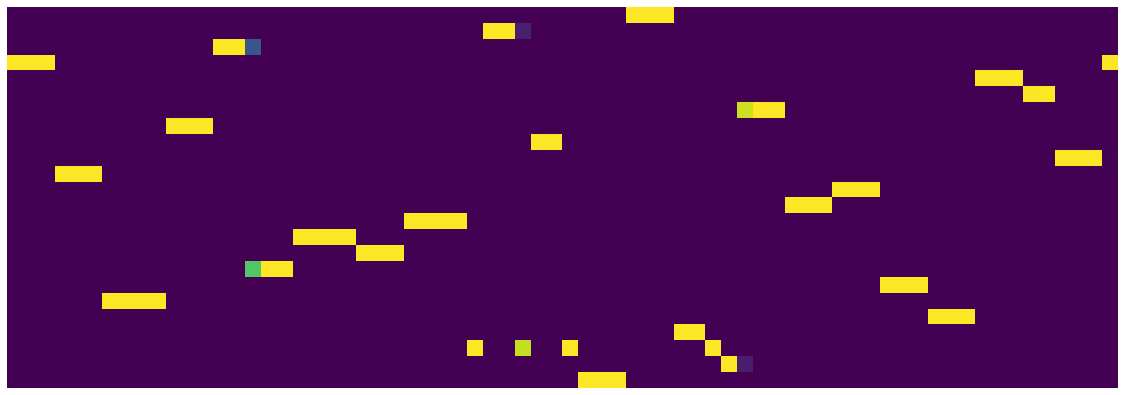

24 324 0.6749999999999997 0.4780181493610144


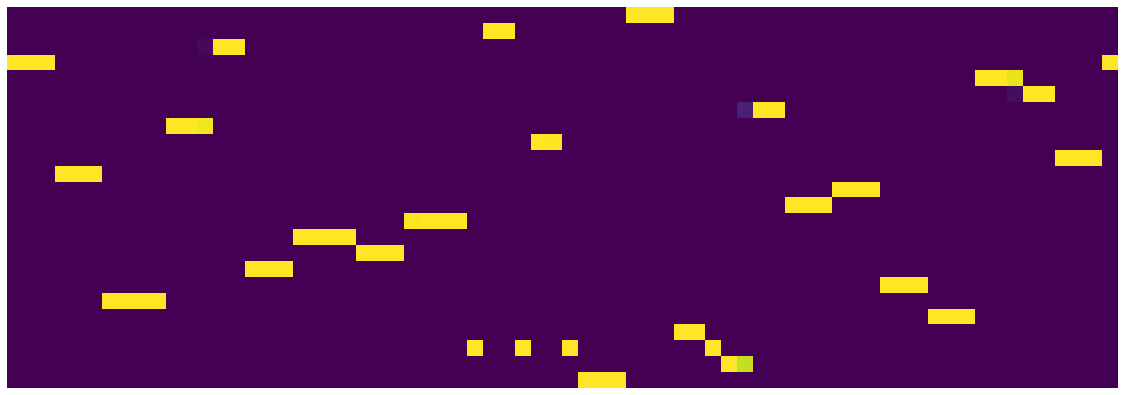

24 325 0.6739999999999997 0.4783672275021672


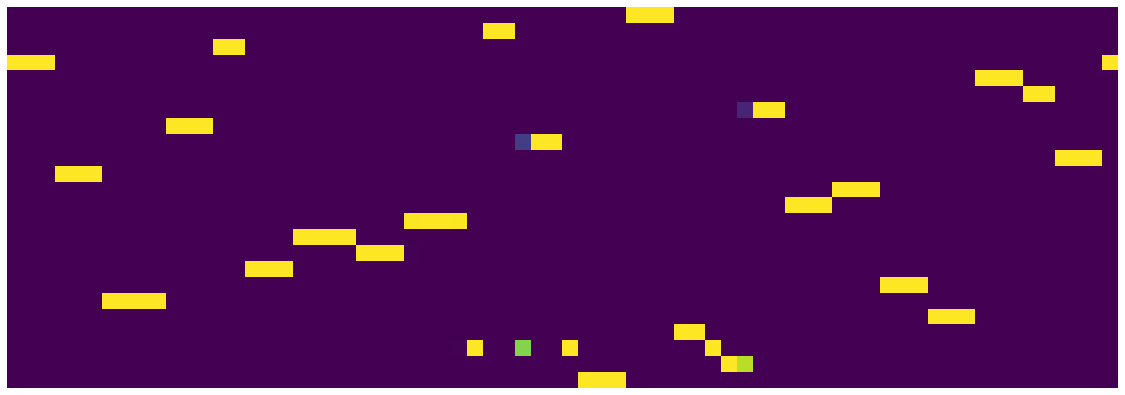

24 326 0.6729999999999997 0.4777233084663749


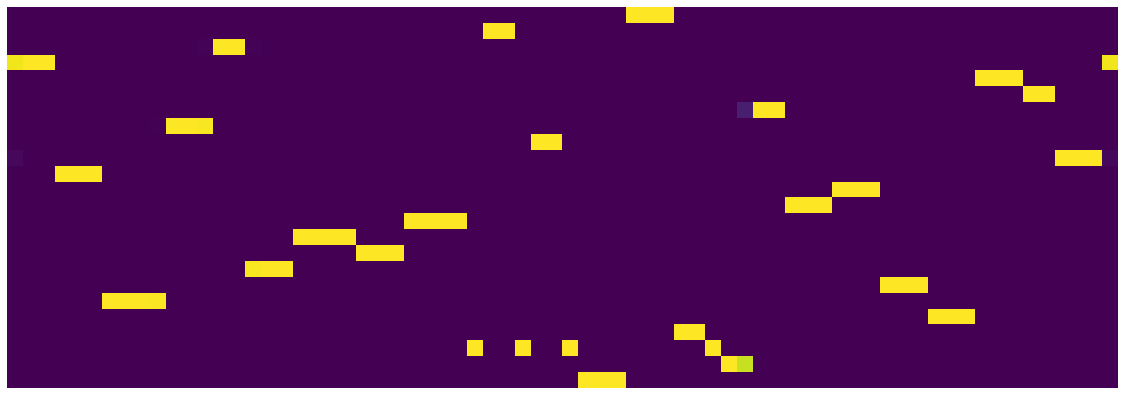

24 327 0.6719999999999997 0.47820570040494204


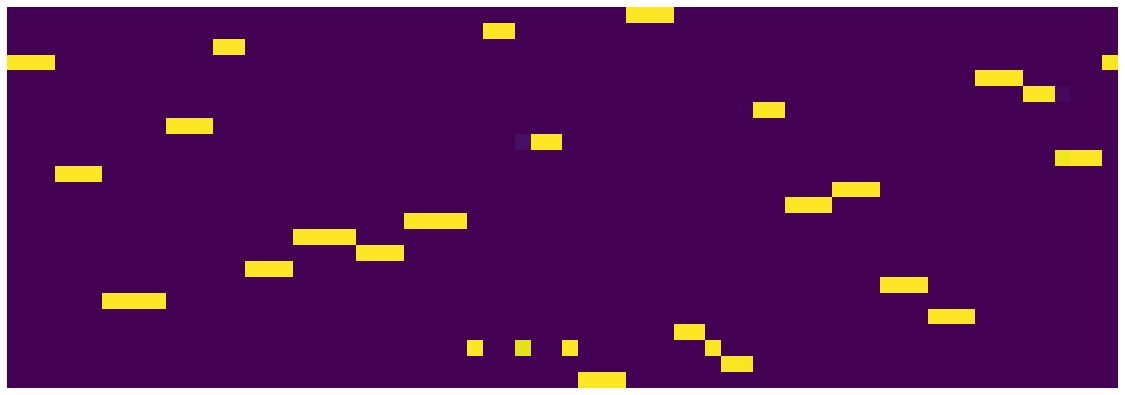

24 328 0.6709999999999997 0.4782304478809237


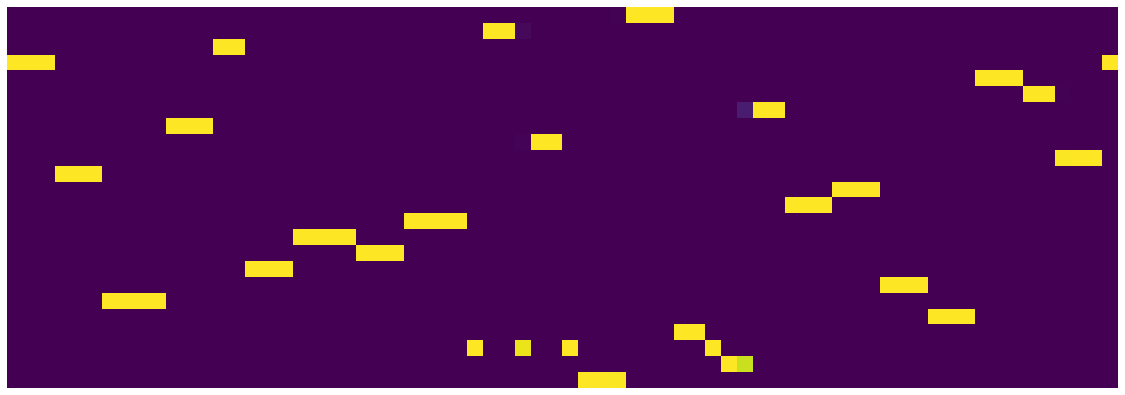

24 329 0.6699999999999997 0.47773441709578035


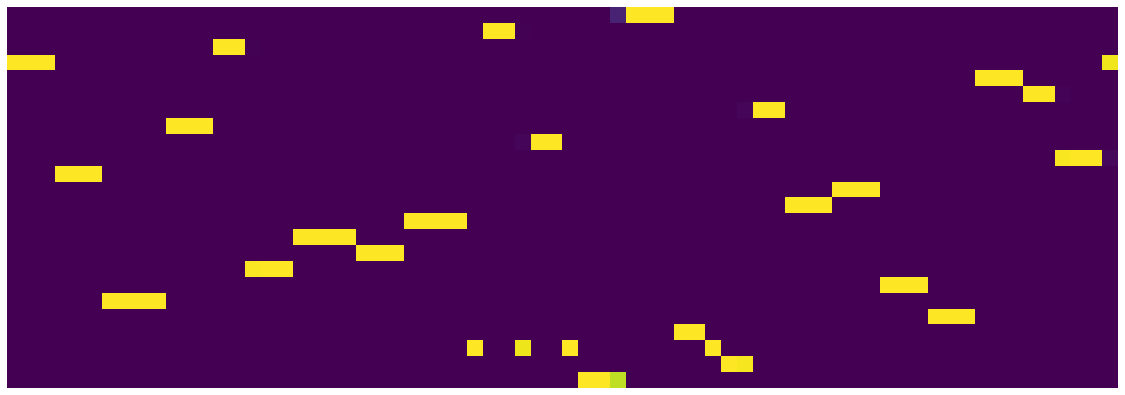

24 330 0.6689999999999997 0.47894680723547933


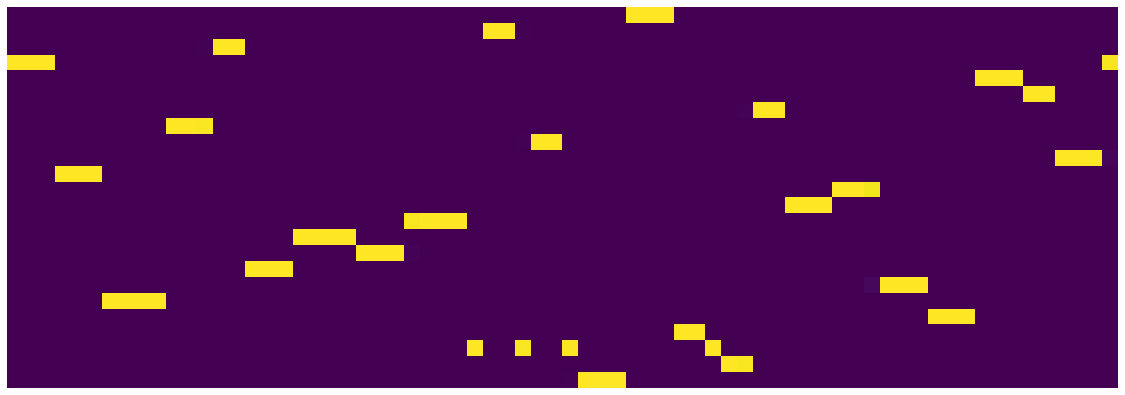

24 331 0.6679999999999997 0.47746782898902895


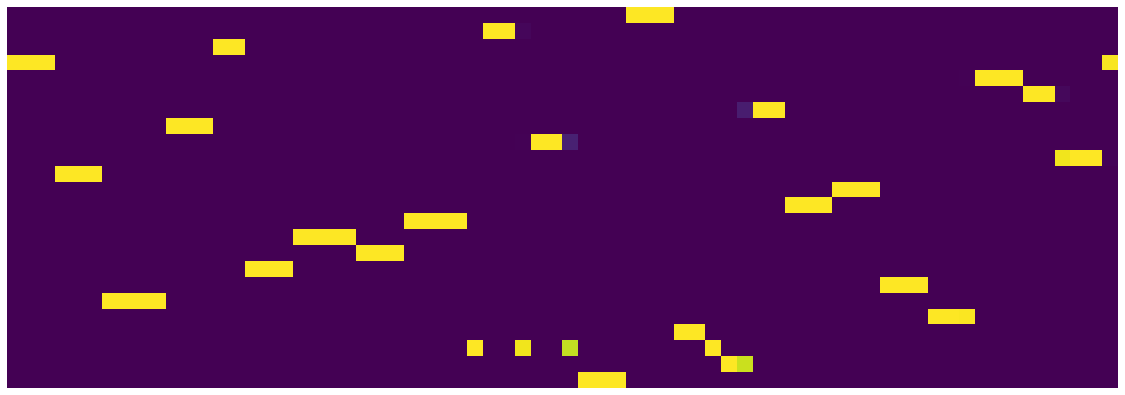

24 332 0.6669999999999997 0.4772367261350155


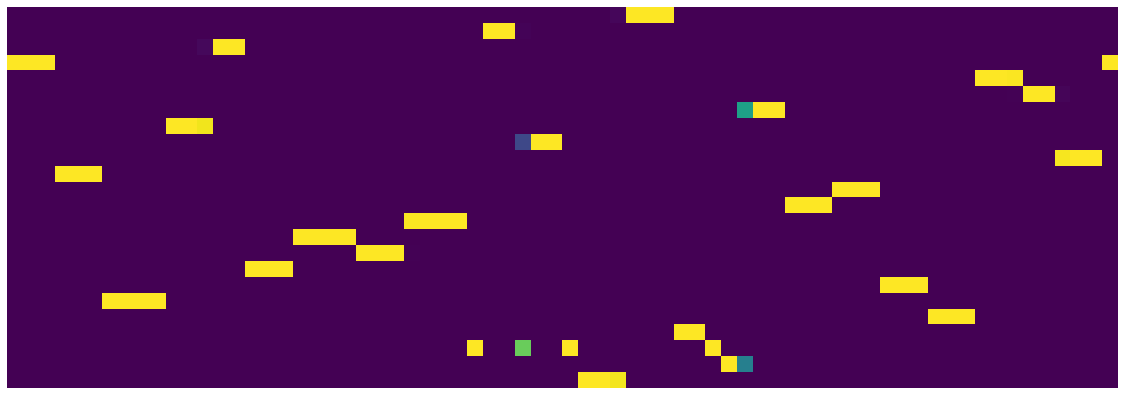

24 333 0.6659999999999997 0.4767927838489413


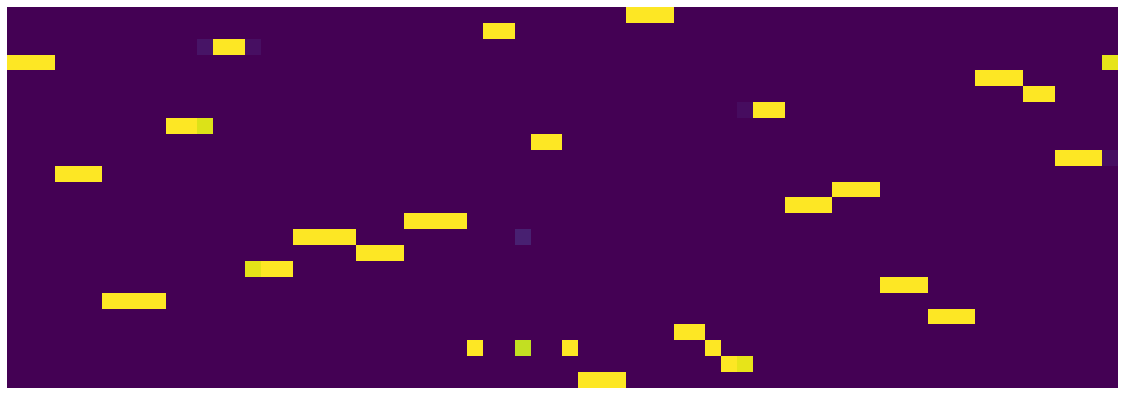

24 334 0.6649999999999997 0.4761008398607373


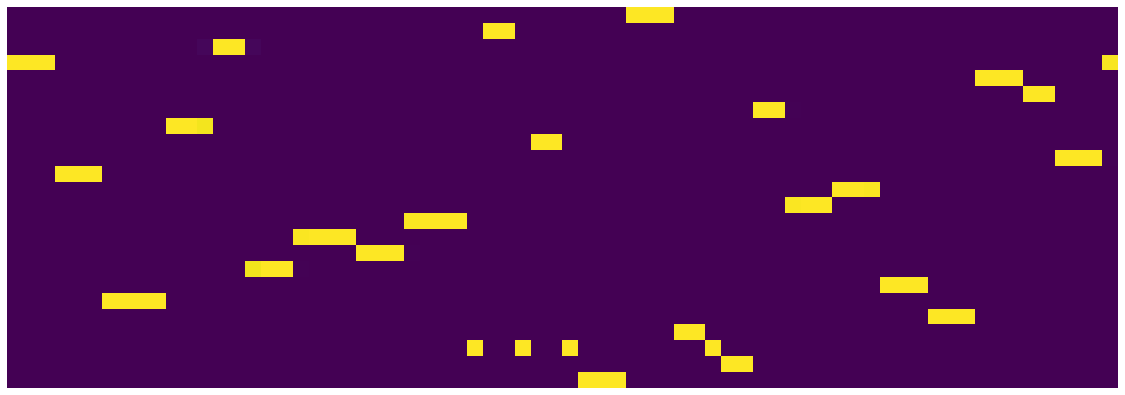

24 335 0.6639999999999997 0.4772234886884689


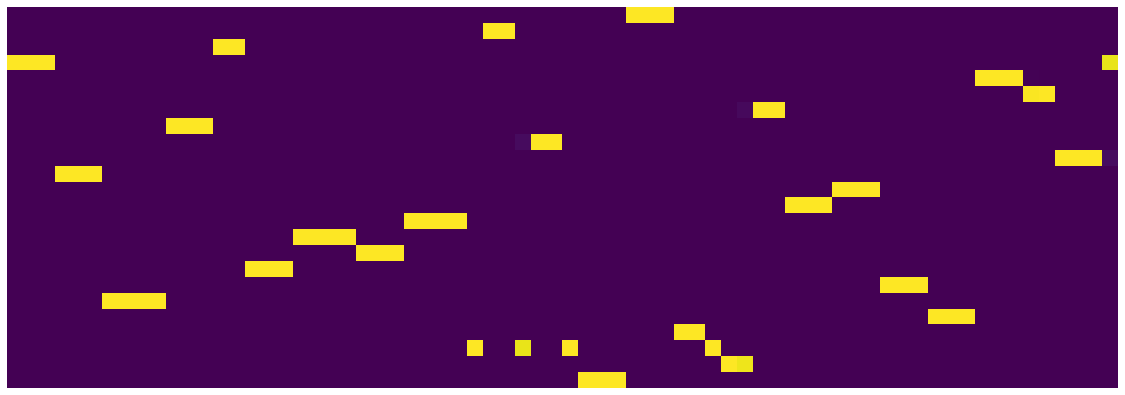

24 336 0.6629999999999997 0.47713092286139724


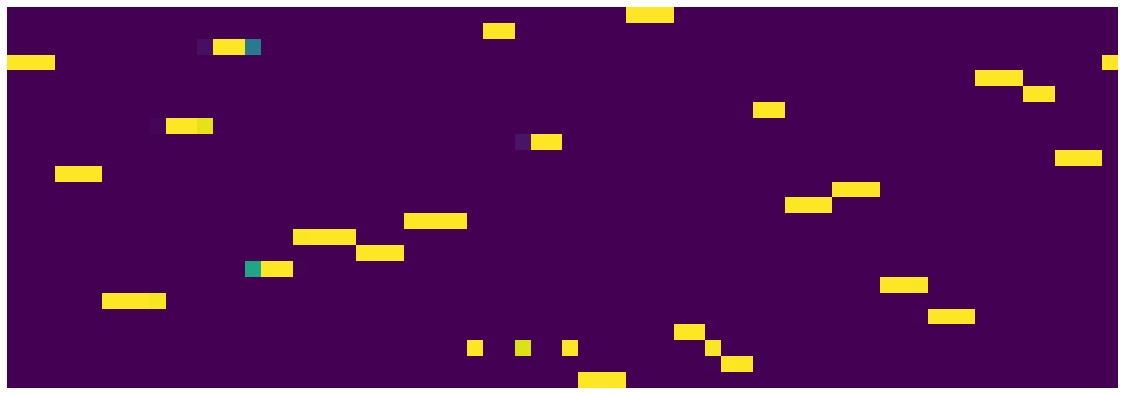

24 337 0.6619999999999997 0.476139304600656


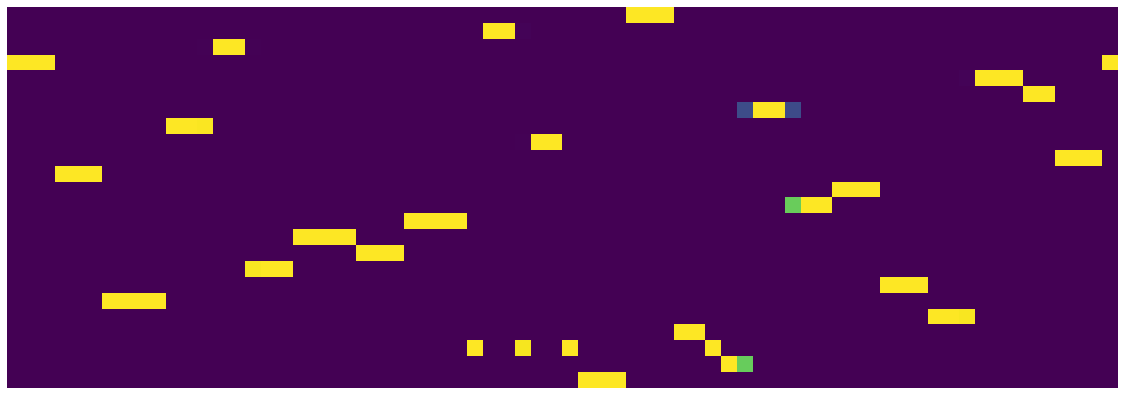

24 338 0.6609999999999997 0.4764560183510184


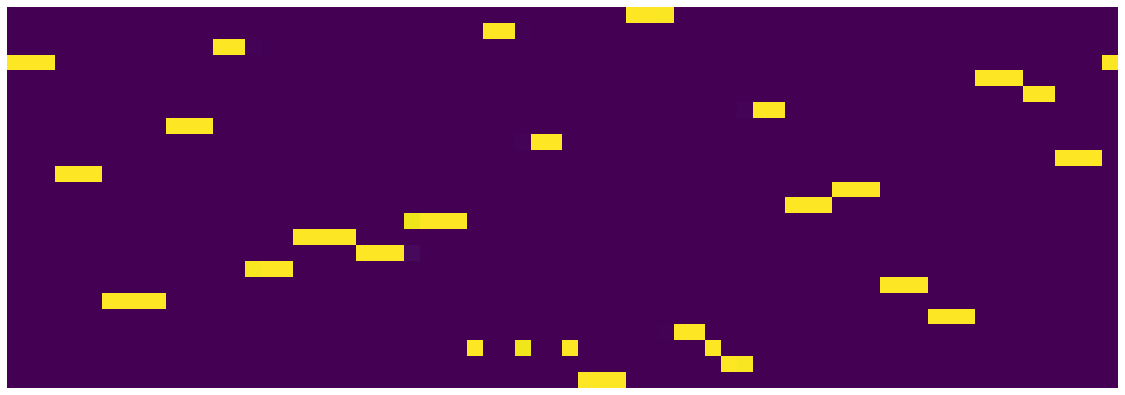

24 339 0.6599999999999997 0.47731253001838925


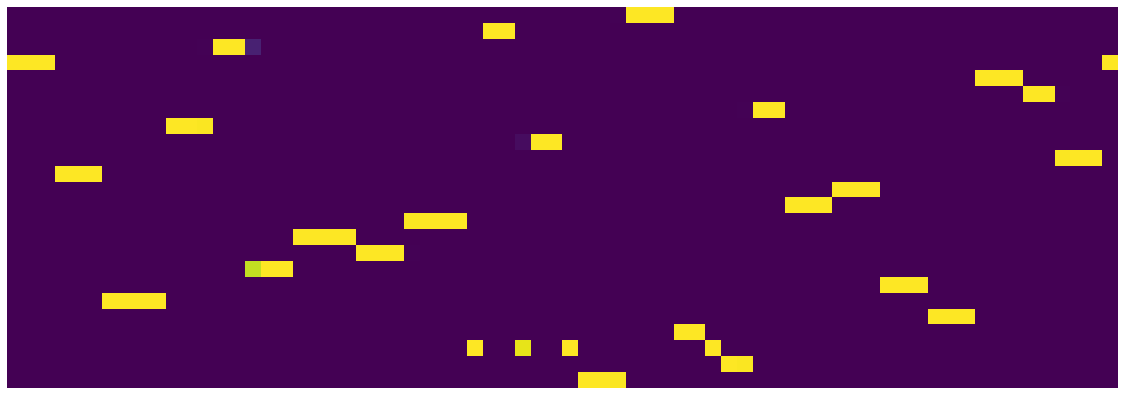

24 340 0.6589999999999997 0.476554986461997


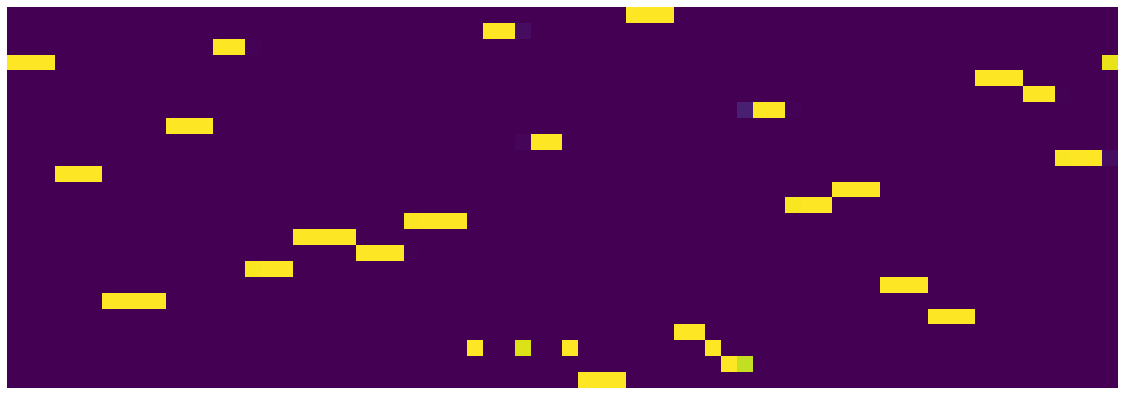

24 341 0.6579999999999997 0.47647354528307917


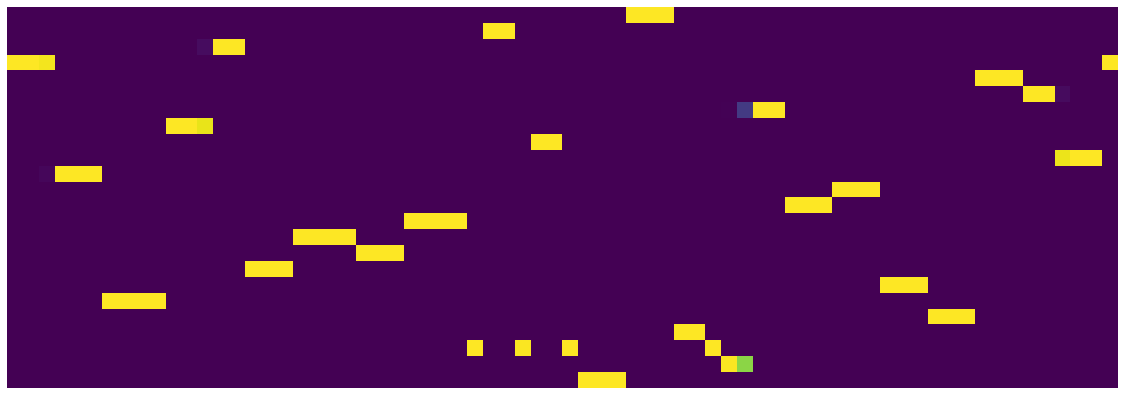

24 342 0.6569999999999997 0.4772819275036454


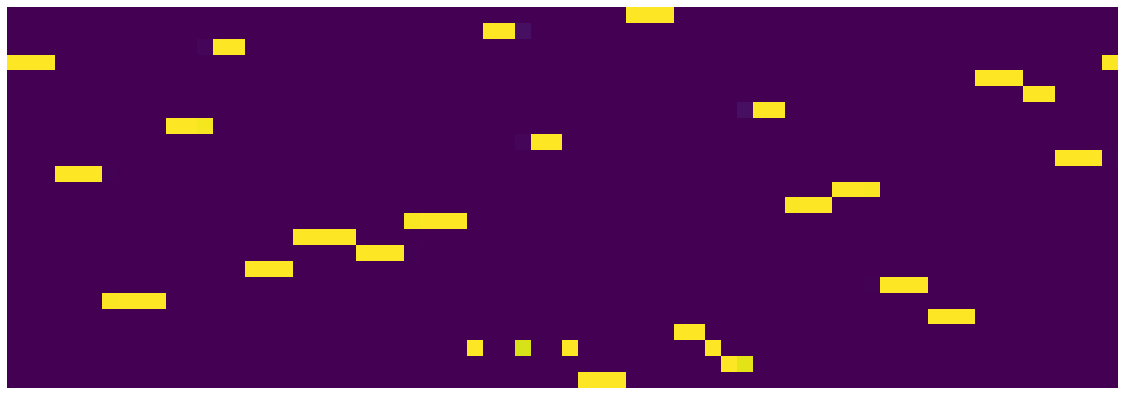

24 343 0.6559999999999997 0.47645366117358207


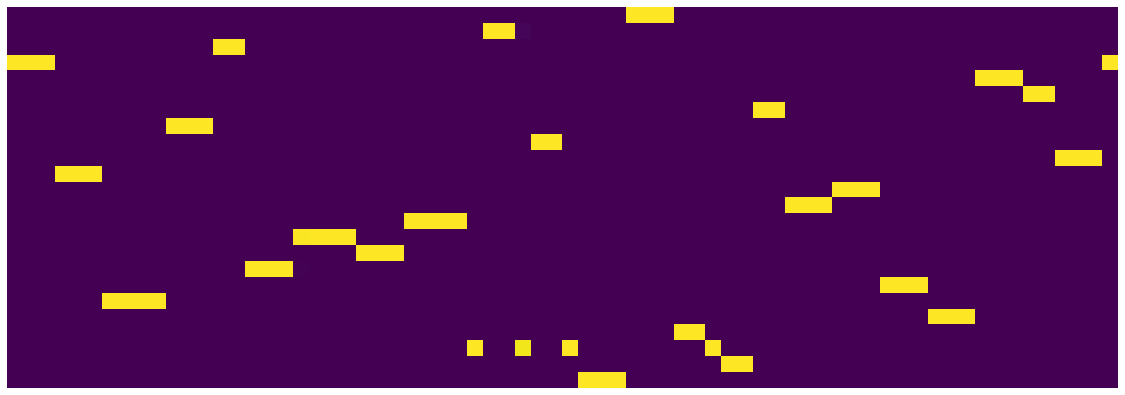

24 344 0.6549999999999997 0.47694682199507954


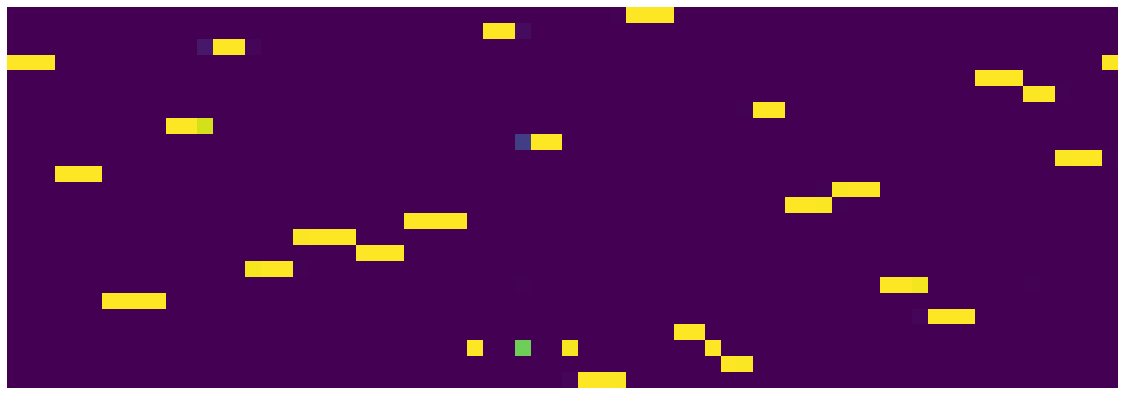

24 345 0.6539999999999997 0.4777213534340262


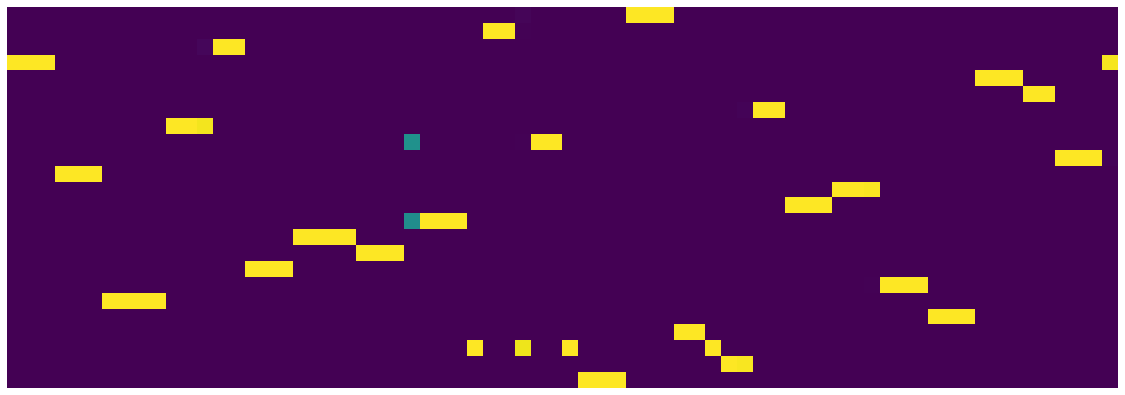

24 346 0.6529999999999997 0.4774532876908779


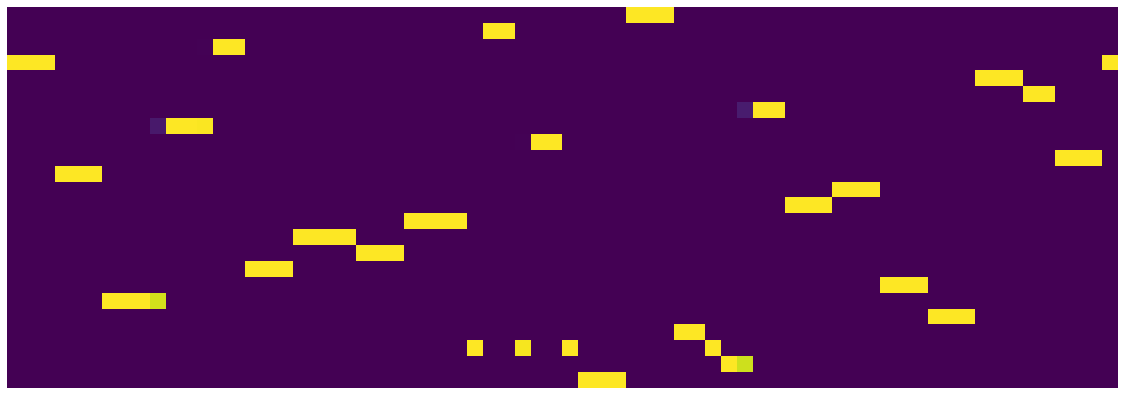

24 347 0.6519999999999997 0.4775442974641919


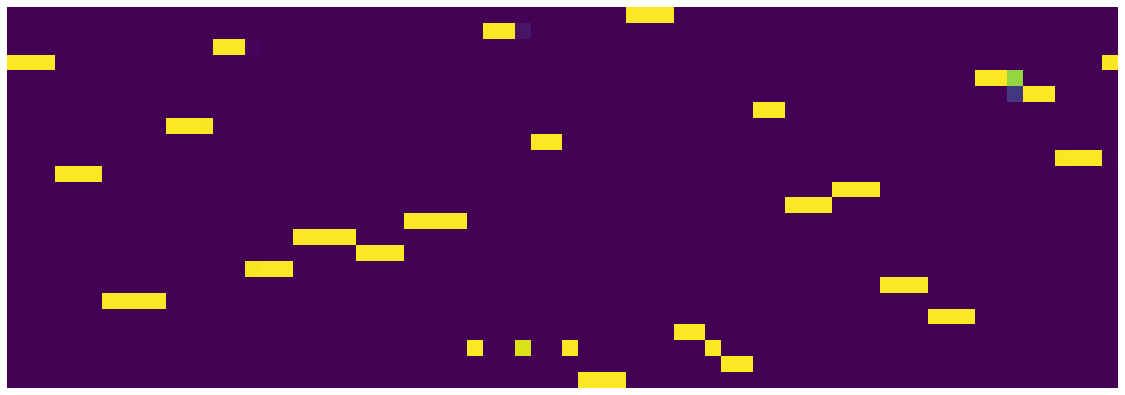

24 348 0.6509999999999997 0.47680599335581064


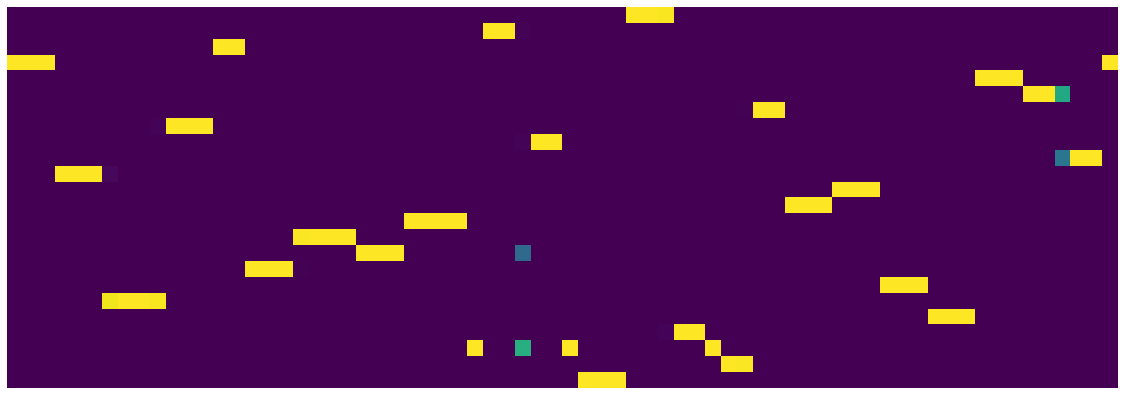

24 349 0.6499999999999997 0.47667900696396825


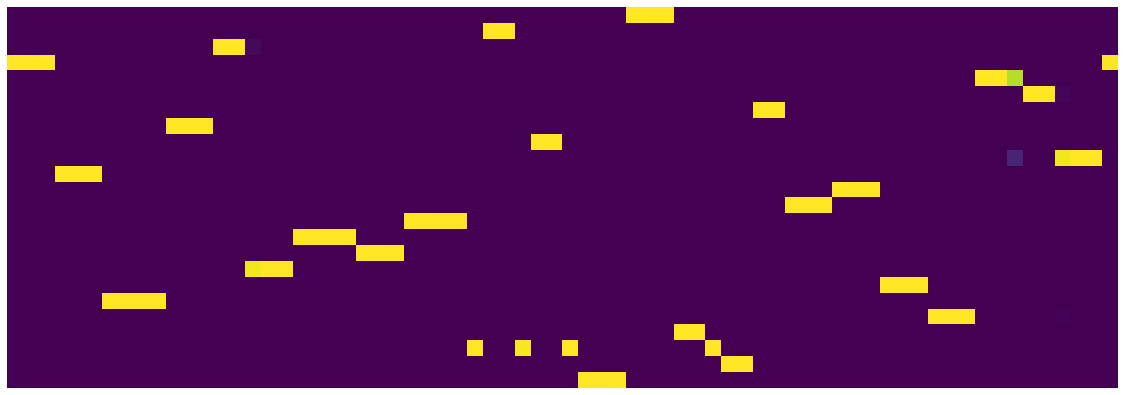

24 350 0.6489999999999997 0.47616943772882225


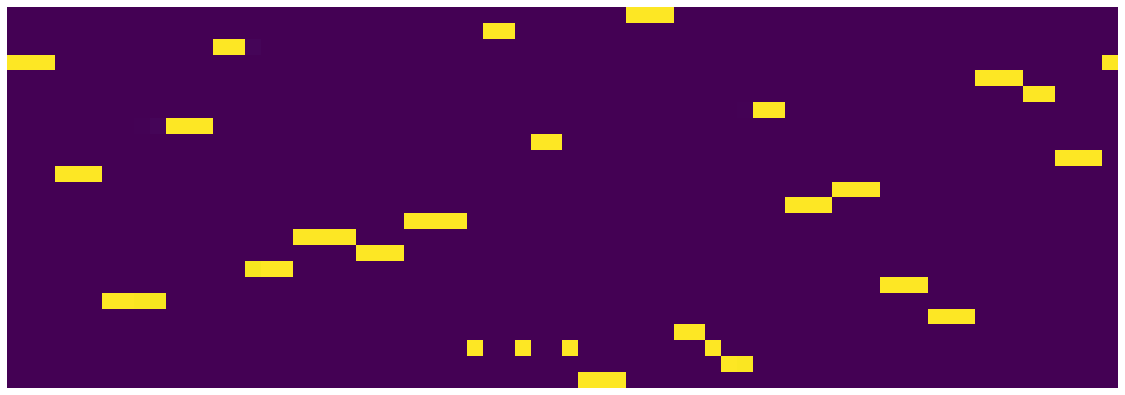

24 351 0.6479999999999997 0.4771048167720437


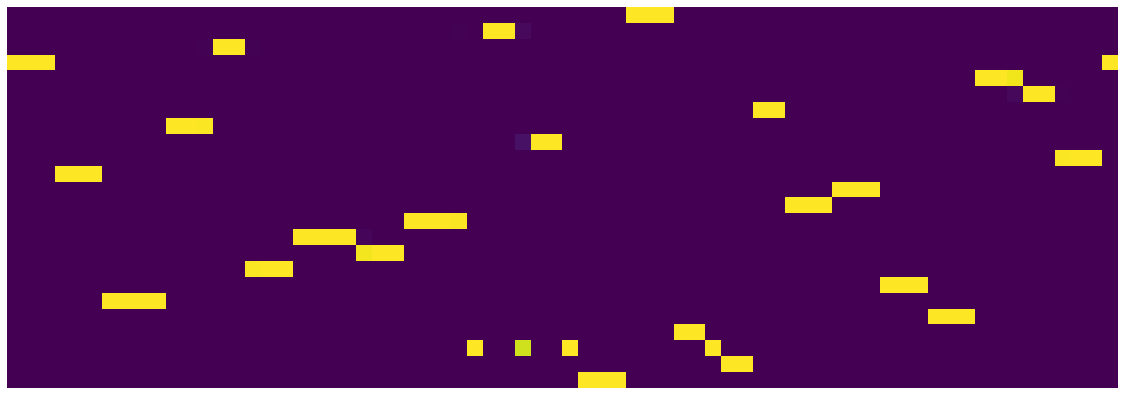

24 352 0.6469999999999997 0.4761346973478794


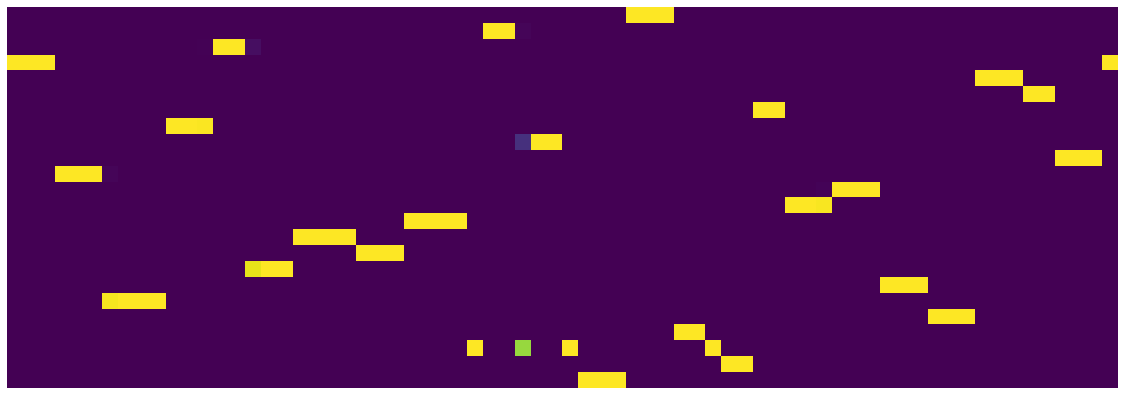

24 353 0.6459999999999997 0.4760928383097053


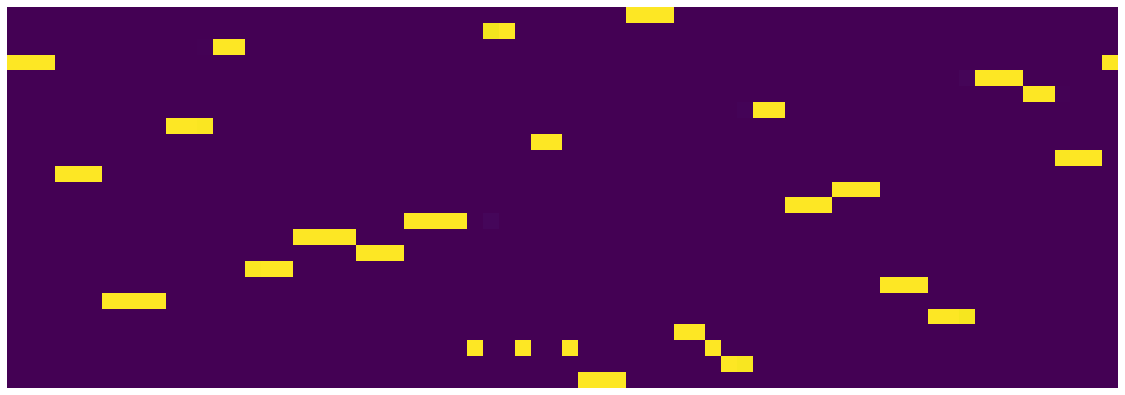

24 354 0.6449999999999997 0.47647903934121133


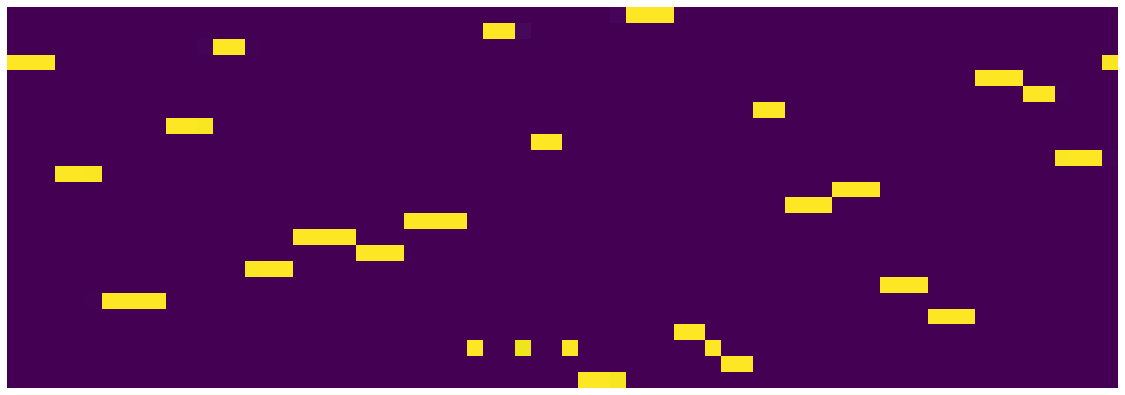

24 355 0.6439999999999997 0.47620374877005817


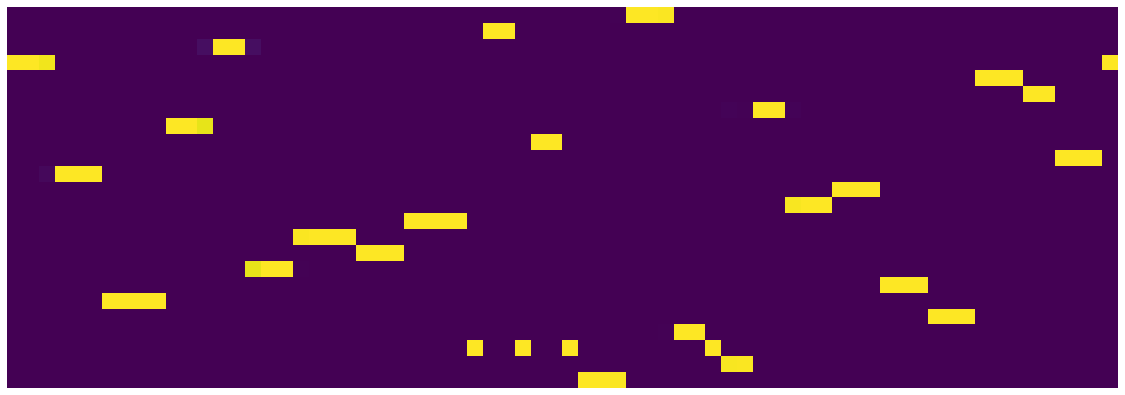

24 356 0.6429999999999997 0.47642208971083166


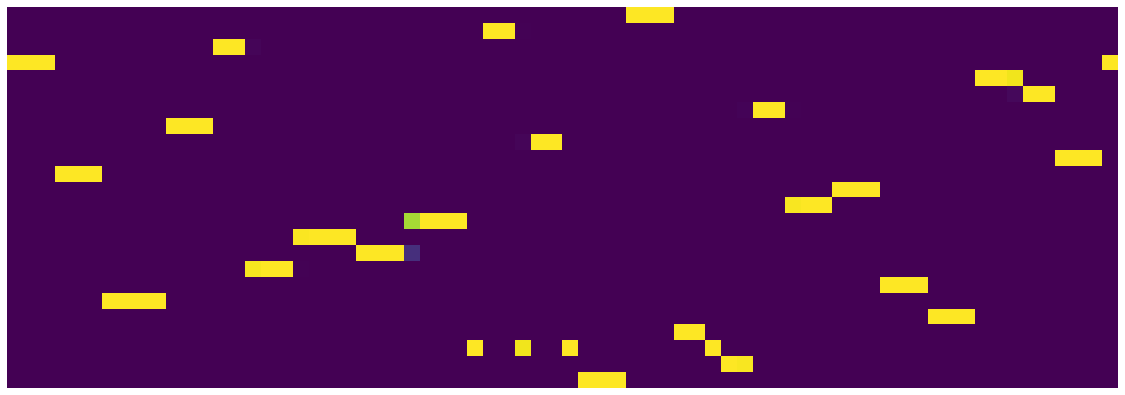

24 357 0.6419999999999997 0.47736349049955606


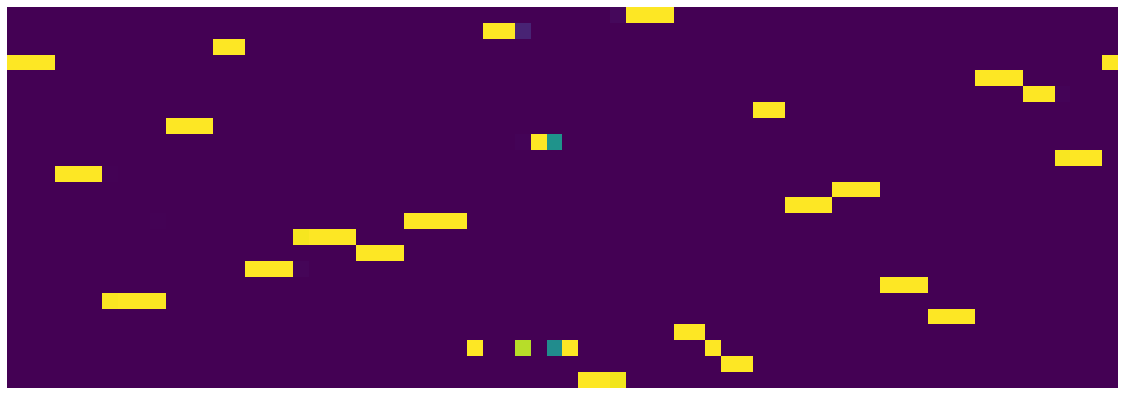

24 358 0.6409999999999997 0.4759035503491759


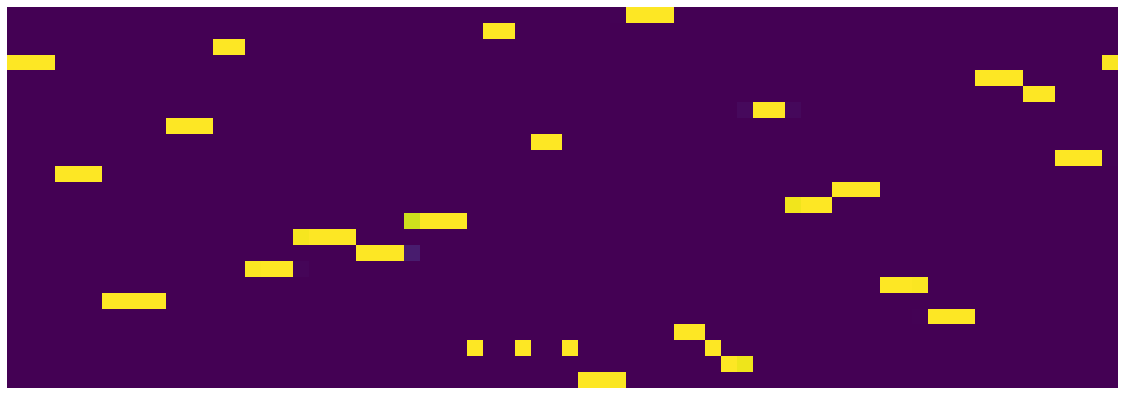

24 359 0.6399999999999997 0.4758629333227873


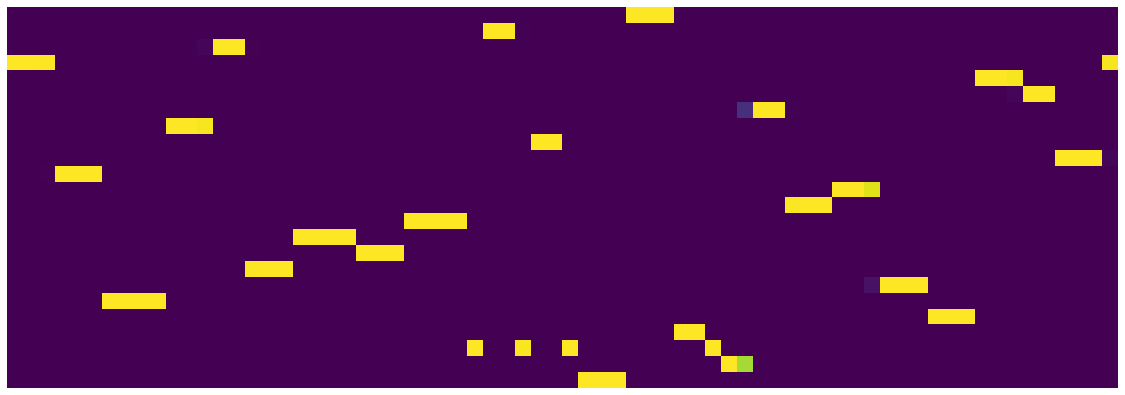

24 360 0.6389999999999997 0.4764099486172199


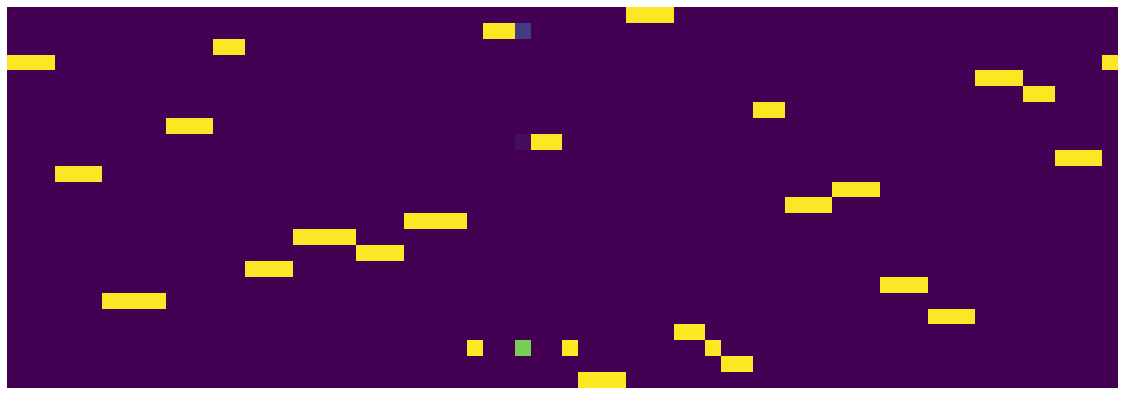

24 361 0.6379999999999997 0.47745830435305836


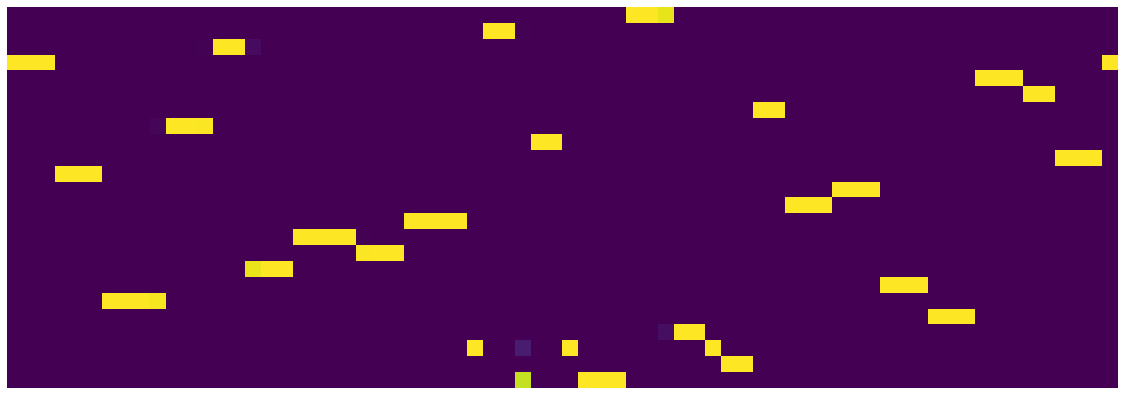

24 362 0.6369999999999997 0.47635509837418794


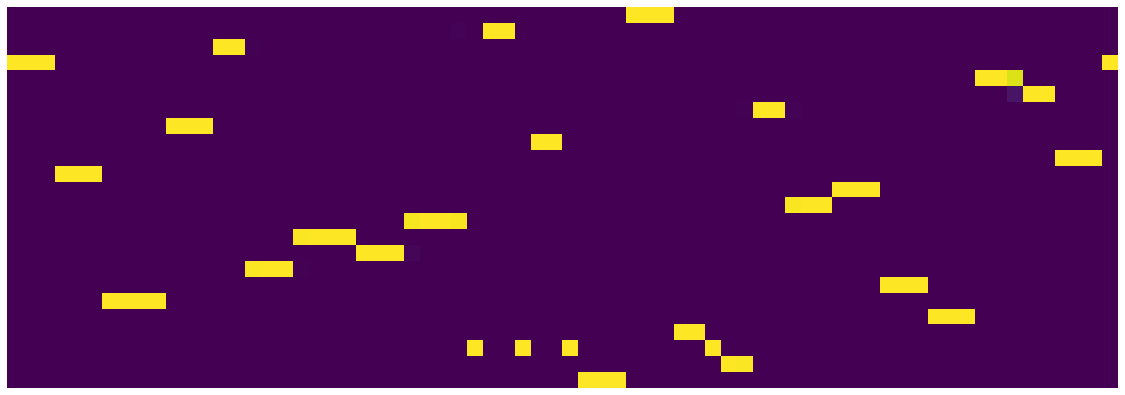

24 363 0.6359999999999997 0.47654114197939634


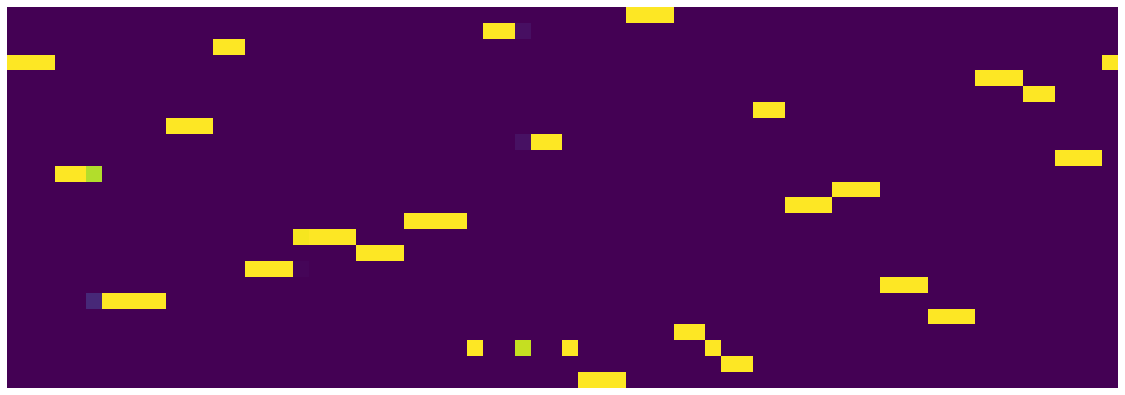

24 364 0.6349999999999997 0.4761982601135969


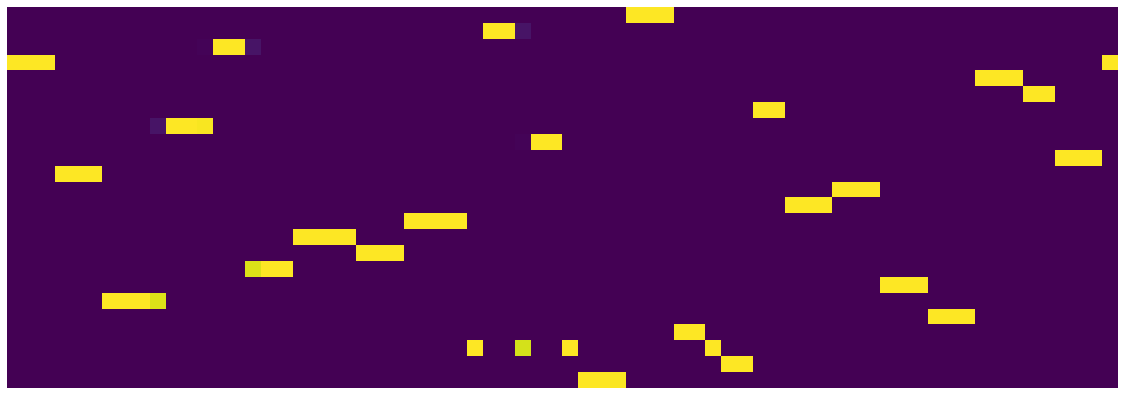

24 365 0.6339999999999997 0.4765167308971286


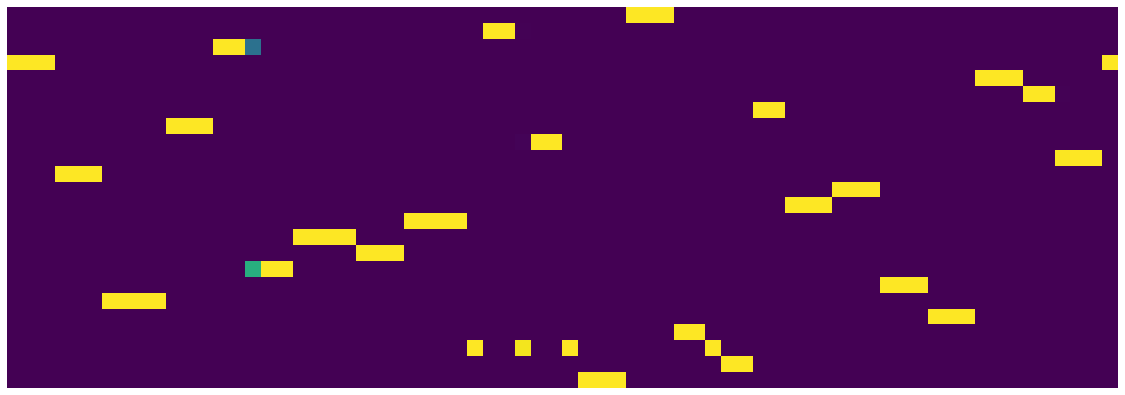

24 366 0.6329999999999997 0.47697468679398297


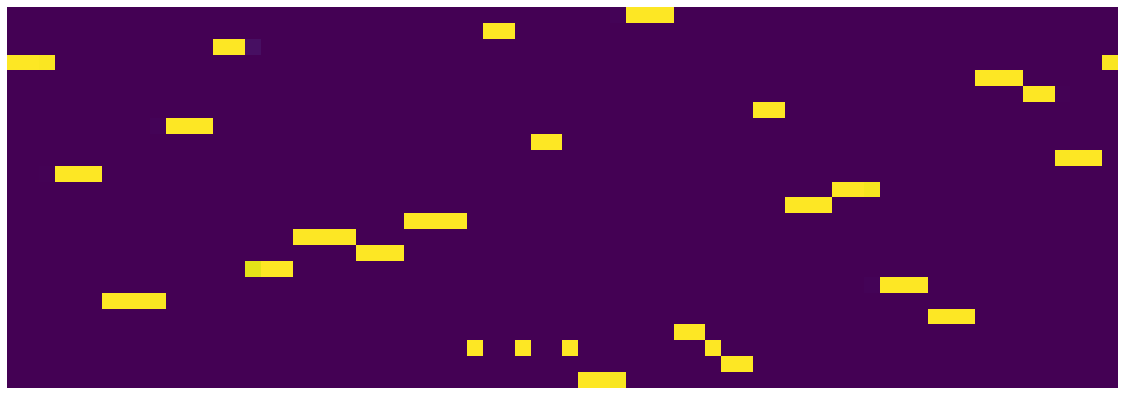

24 367 0.6319999999999997 0.47734190821647643


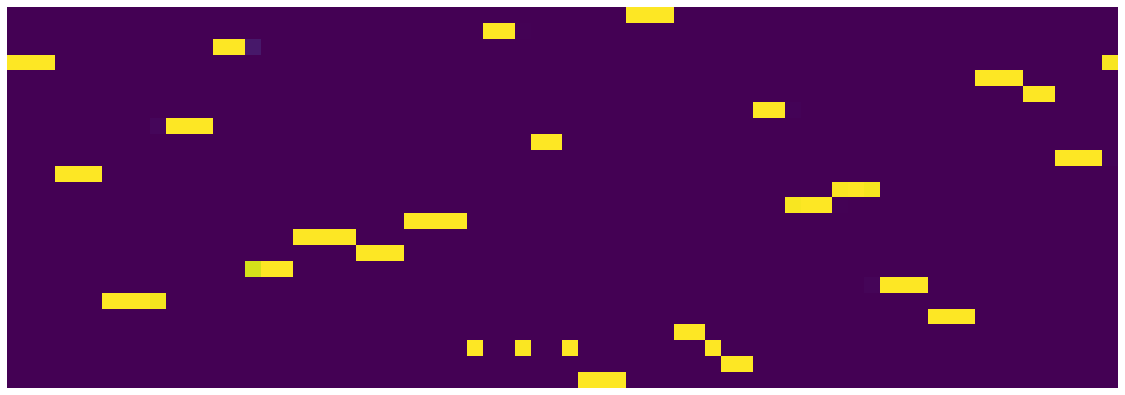

24 368 0.6309999999999997 0.47706339955329896


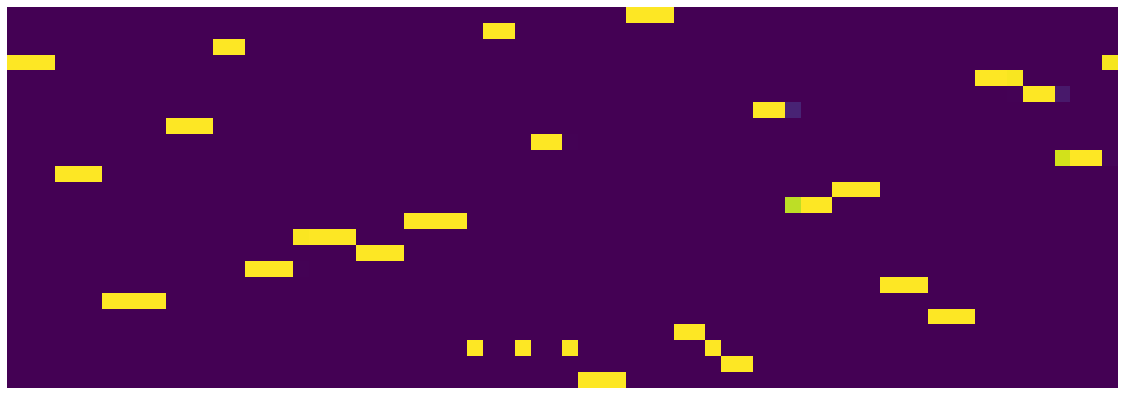

24 369 0.6299999999999997 0.4772956436499953


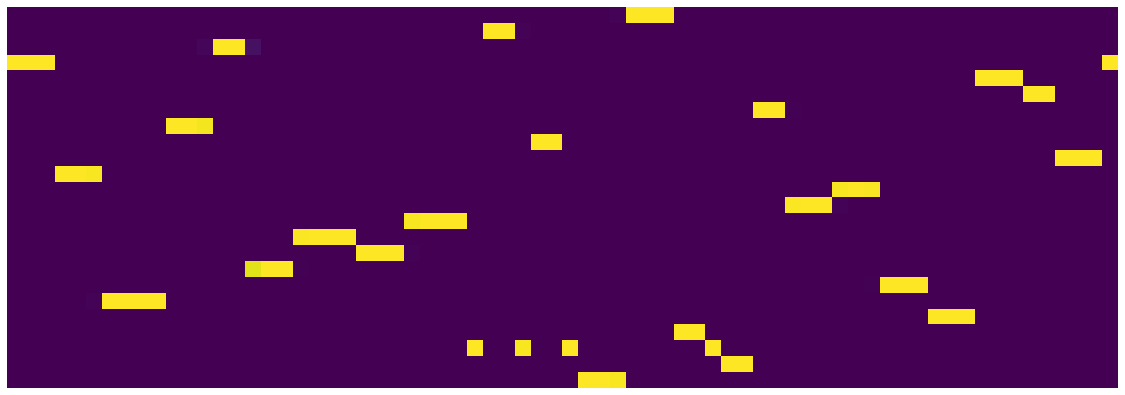

24 370 0.6289999999999997 0.4765277972444892


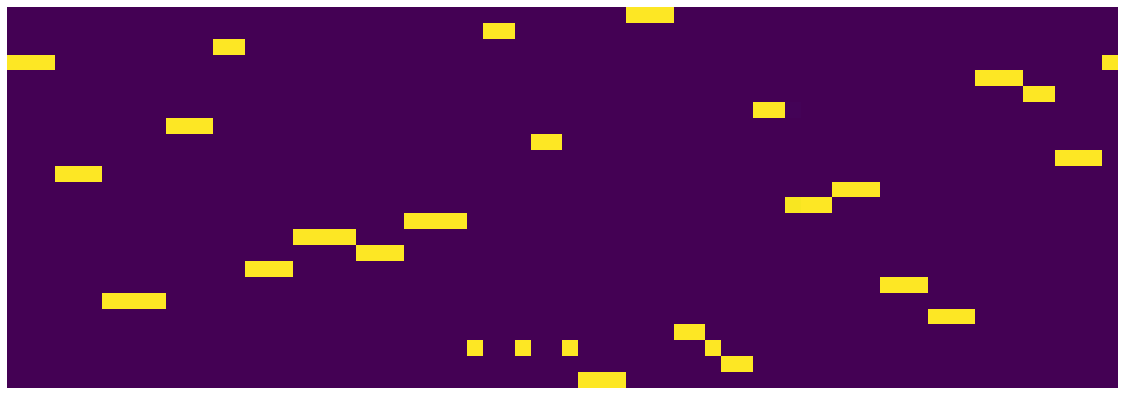

24 371 0.6279999999999997 0.47643916588276625


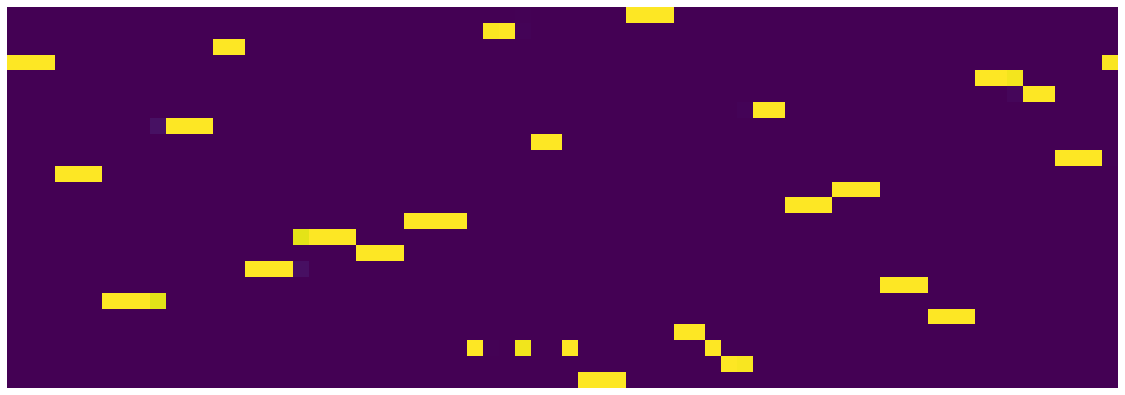

24 372 0.6269999999999997 0.477068779990077


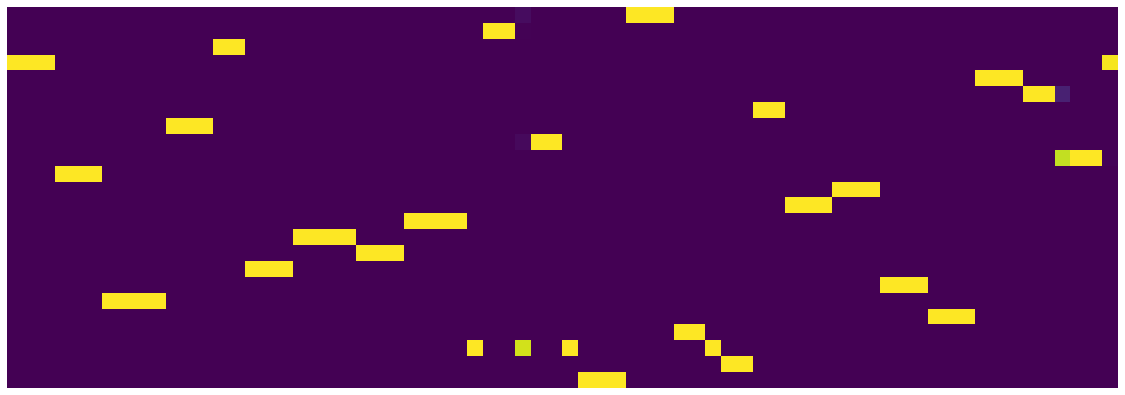

24 373 0.6259999999999997 0.48048774916678666


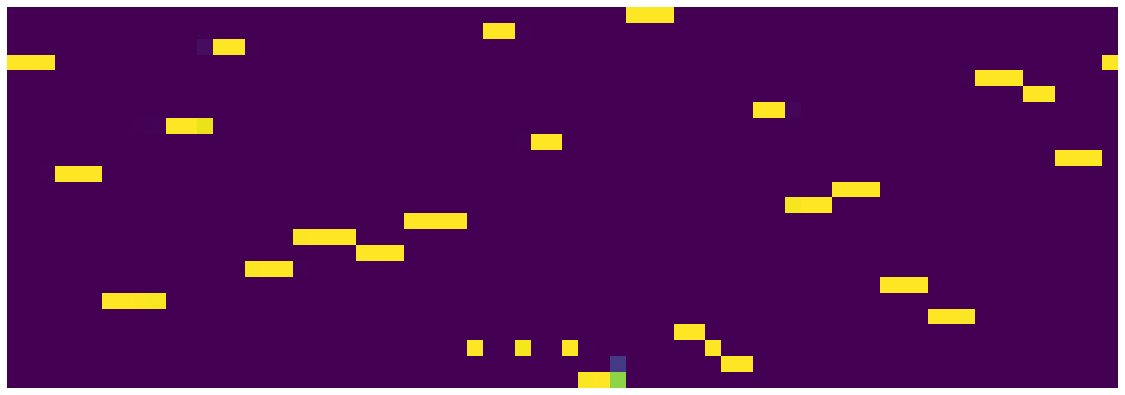

24 374 0.6249999999999997 0.4768583677709103


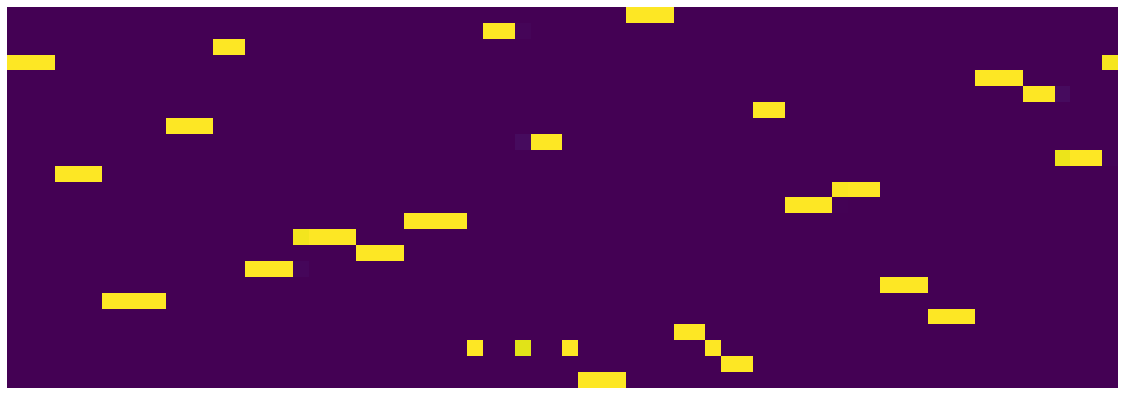

24 375 0.6239999999999997 0.47629263494163754


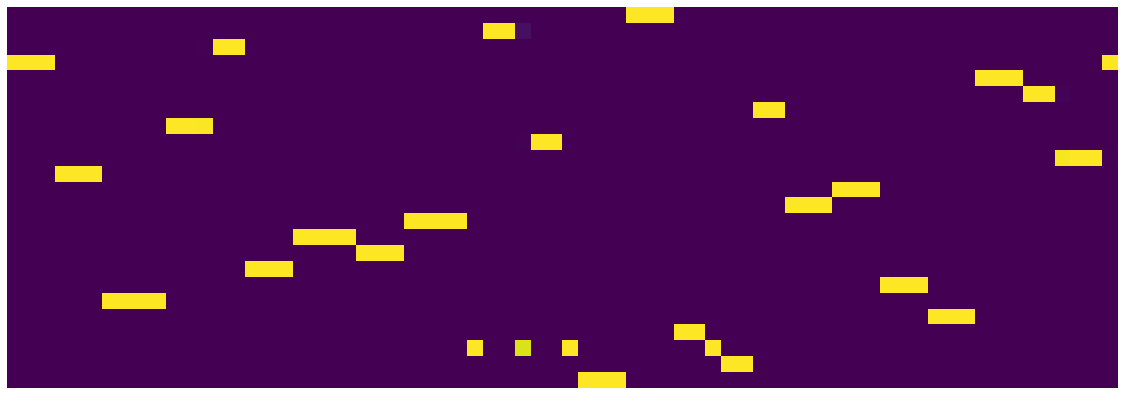

24 376 0.6229999999999997 0.476118746958673


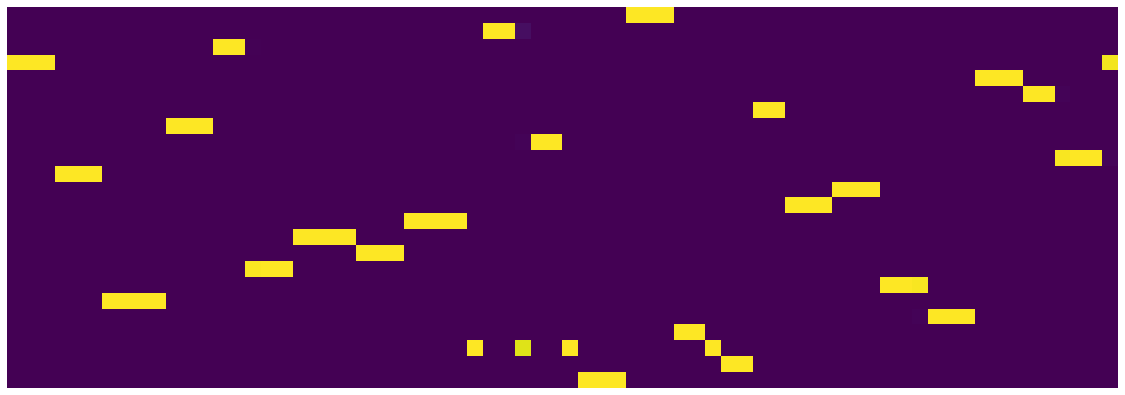

24 377 0.6219999999999997 0.47560307271778585


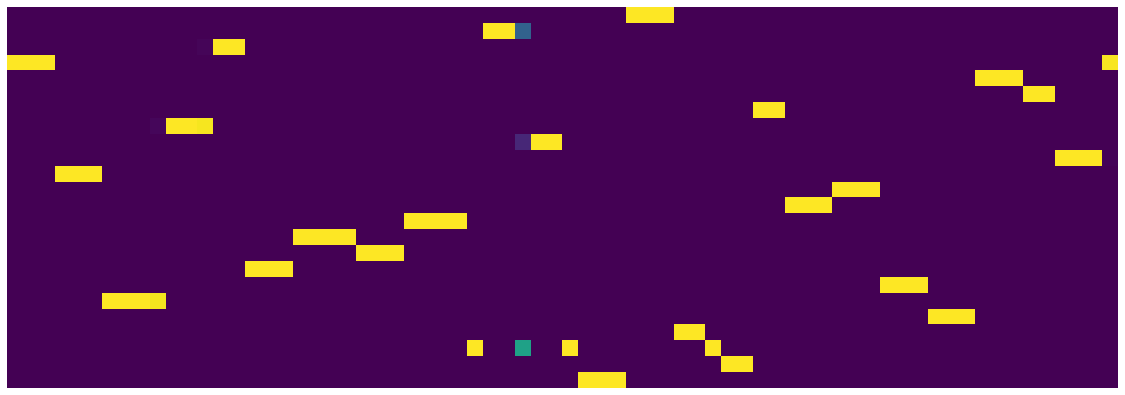

24 378 0.6209999999999997 0.4765266334638


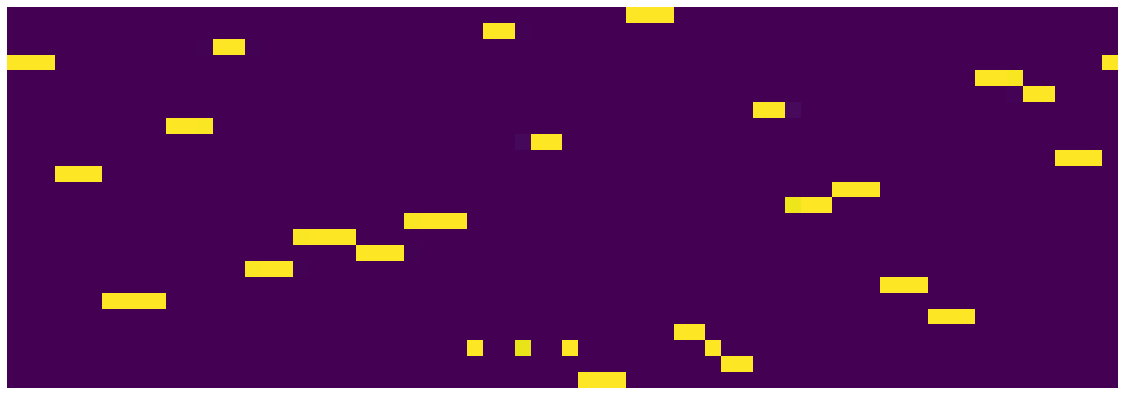

24 379 0.6199999999999997 0.47735013719648123


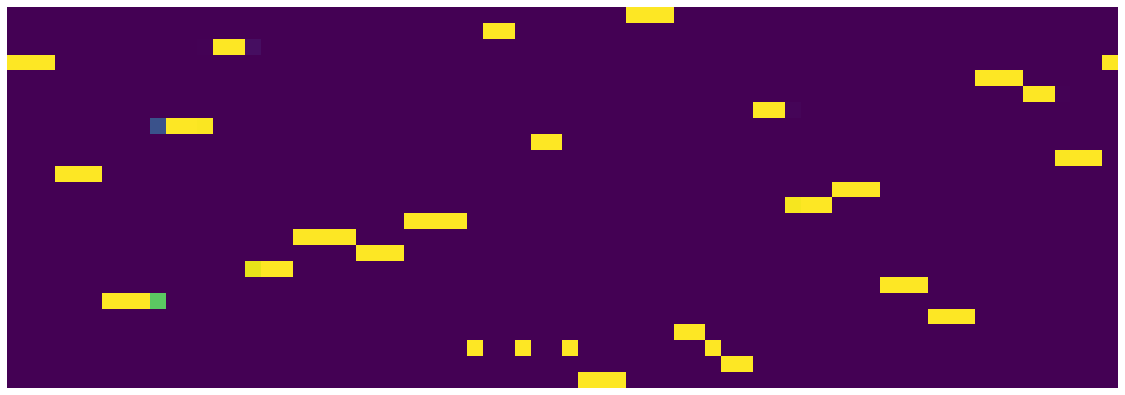

24 380 0.6189999999999997 0.47680667620152234


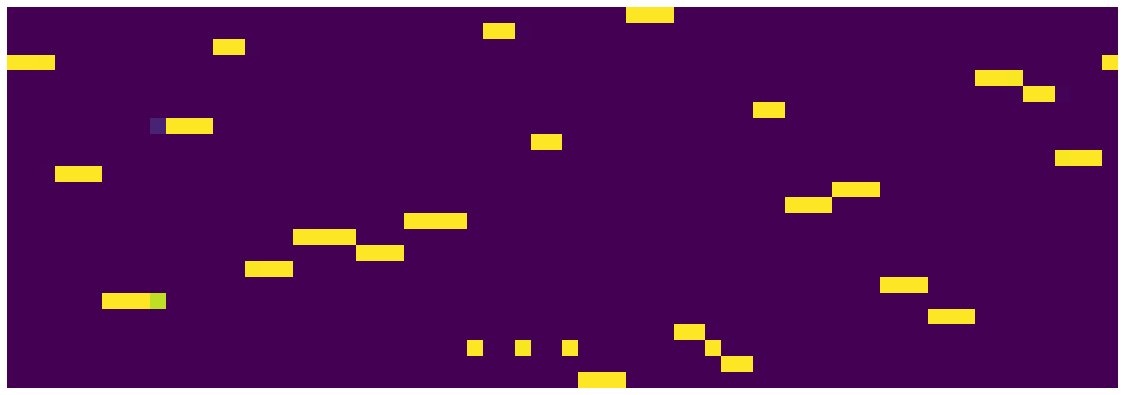

24 381 0.6179999999999997 0.47615679670125244


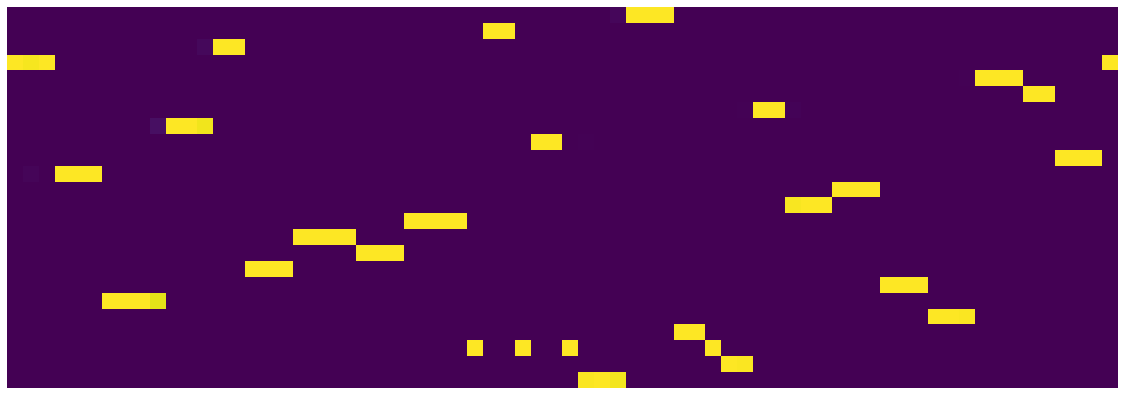

24 382 0.6169999999999997 0.4774537993595004


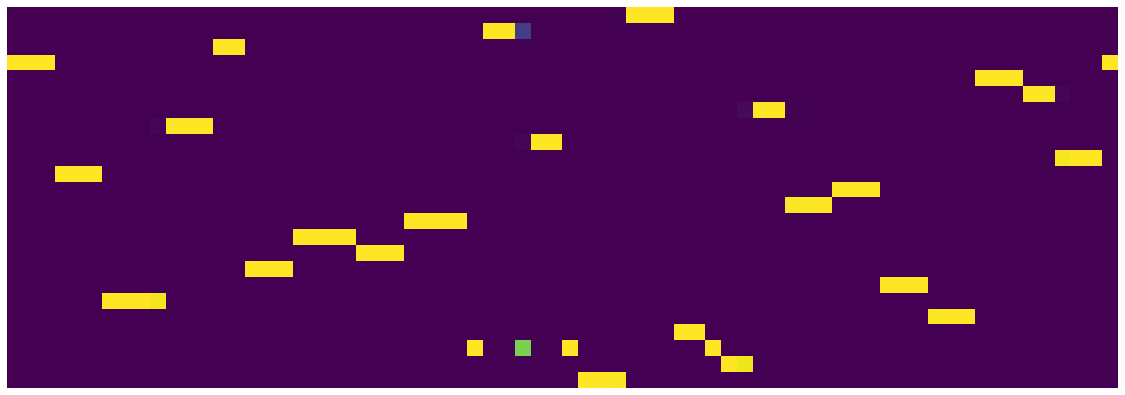

24 383 0.6159999999999997 0.47655253633856776


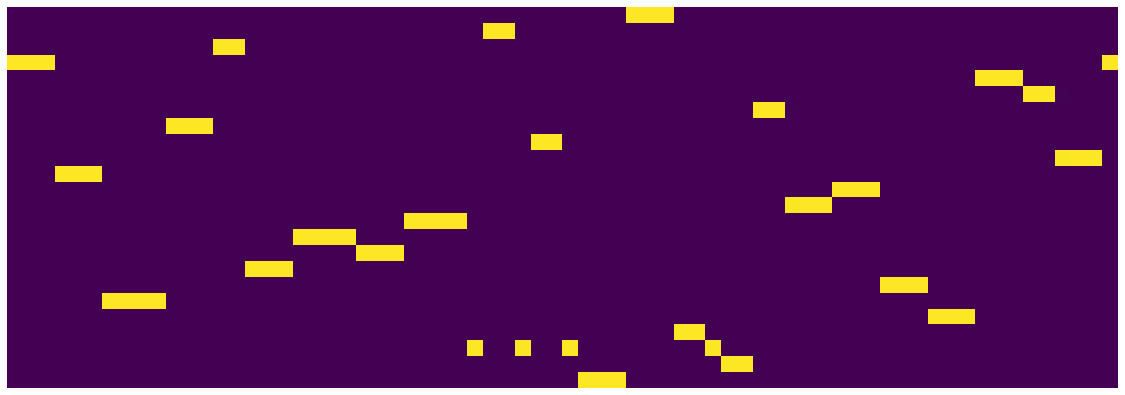

24 384 0.6149999999999997 0.4762257691472769


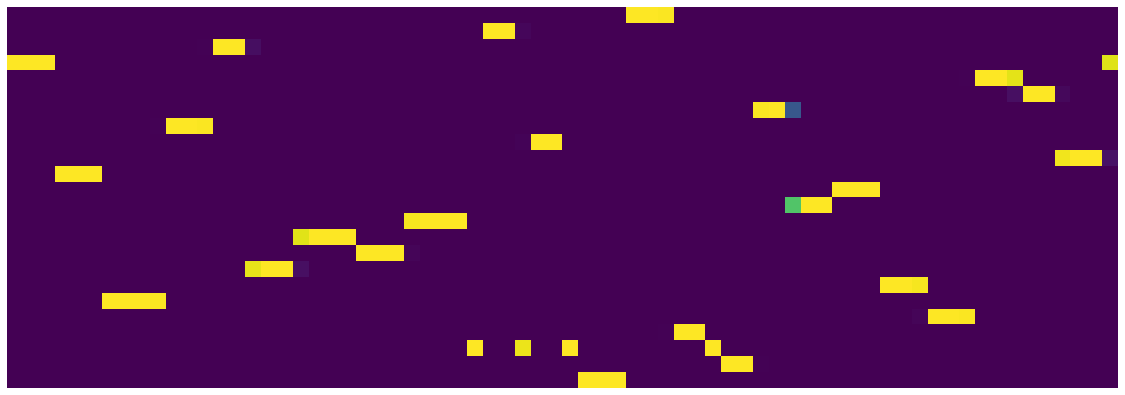

24 385 0.6139999999999997 0.4762371743097901


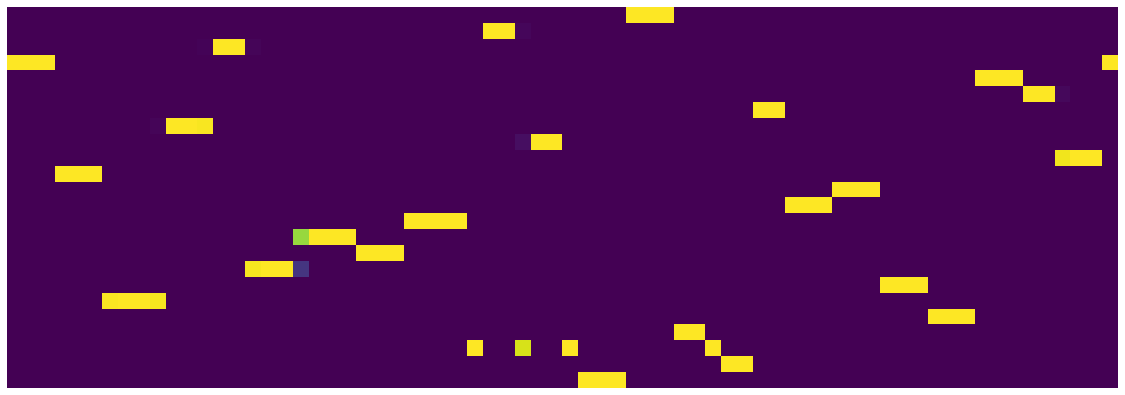

24 386 0.6129999999999997 0.47655061949044464


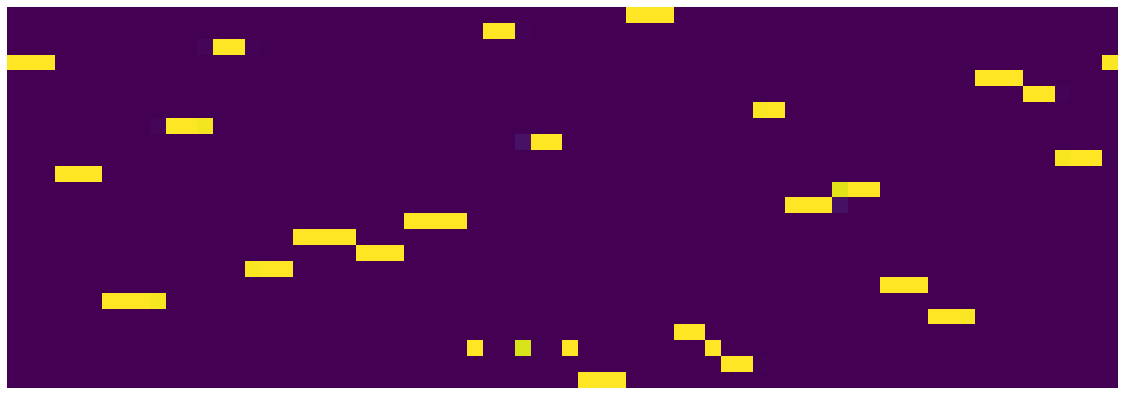

24 387 0.6119999999999997 0.47650190833956


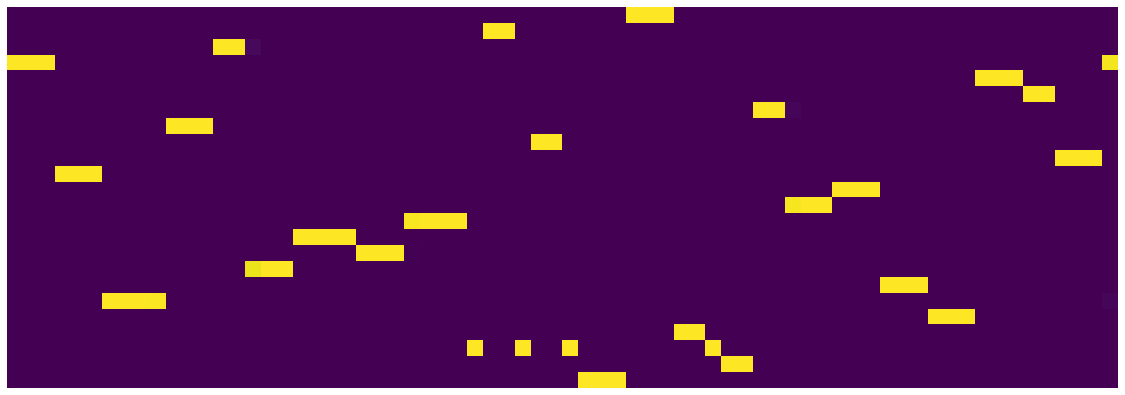

24 388 0.6109999999999997 0.4766565185040236


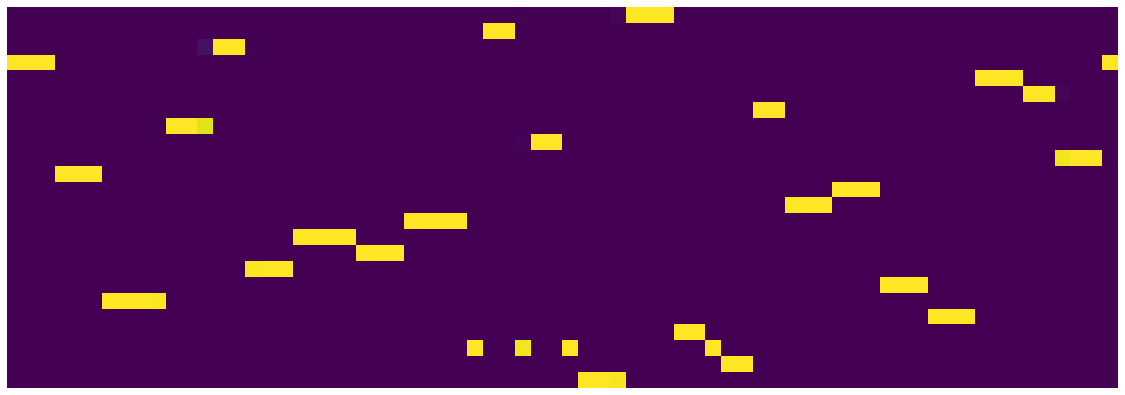

24 389 0.6099999999999997 0.4766820466145873


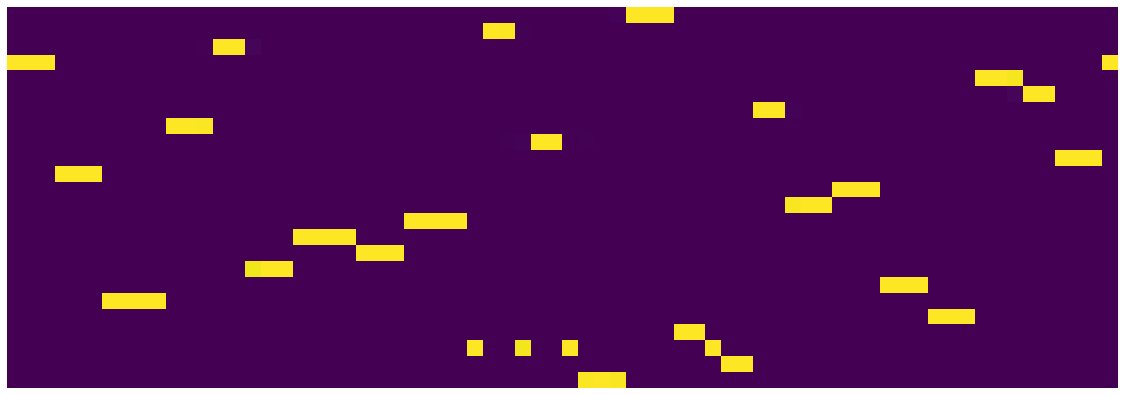

24 390 0.6089999999999997 0.47650429494678975


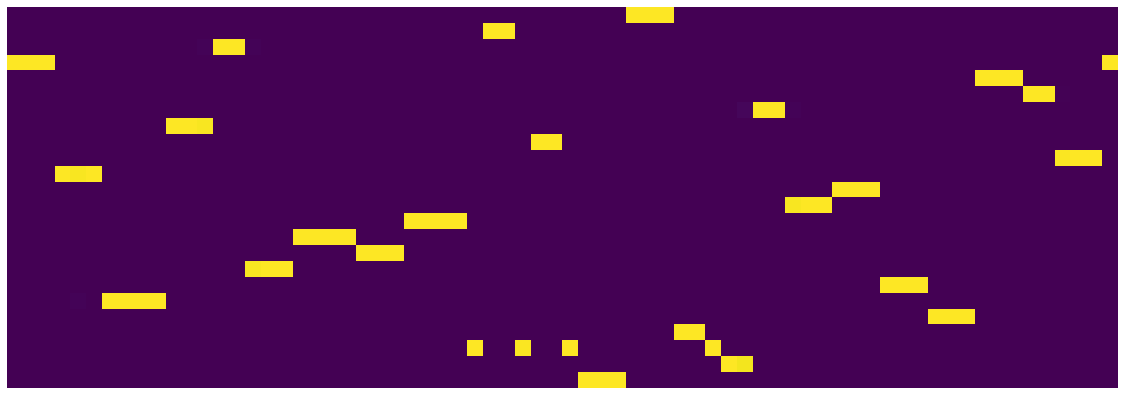

24 391 0.6079999999999997 0.47770183477550743


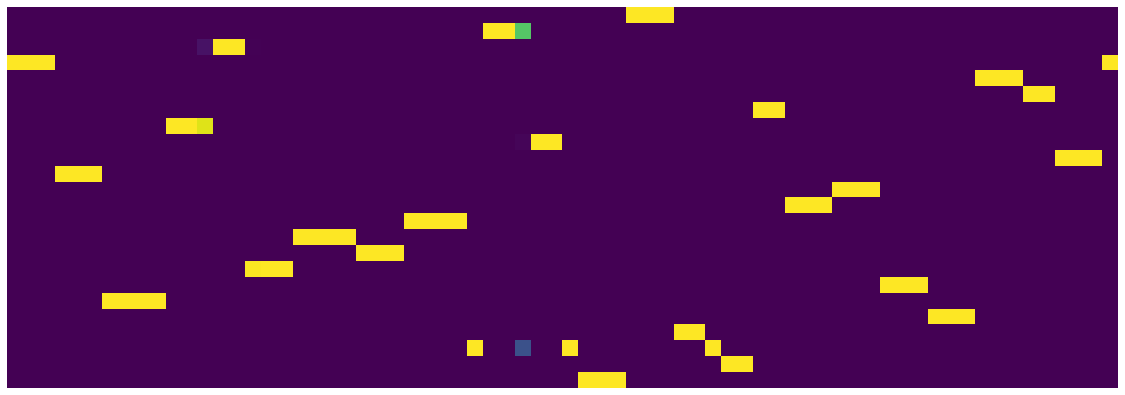

24 392 0.6069999999999997 0.47679755091667175


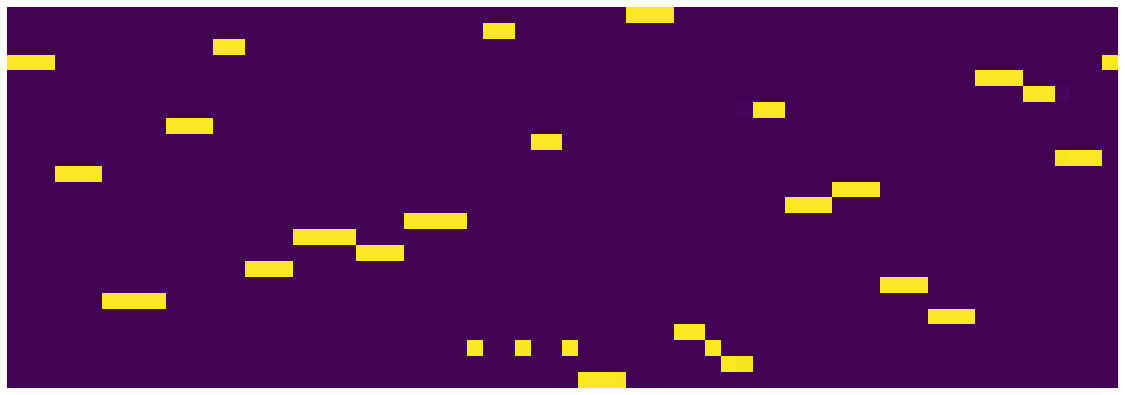

24 393 0.6059999999999997 0.4765811262652278


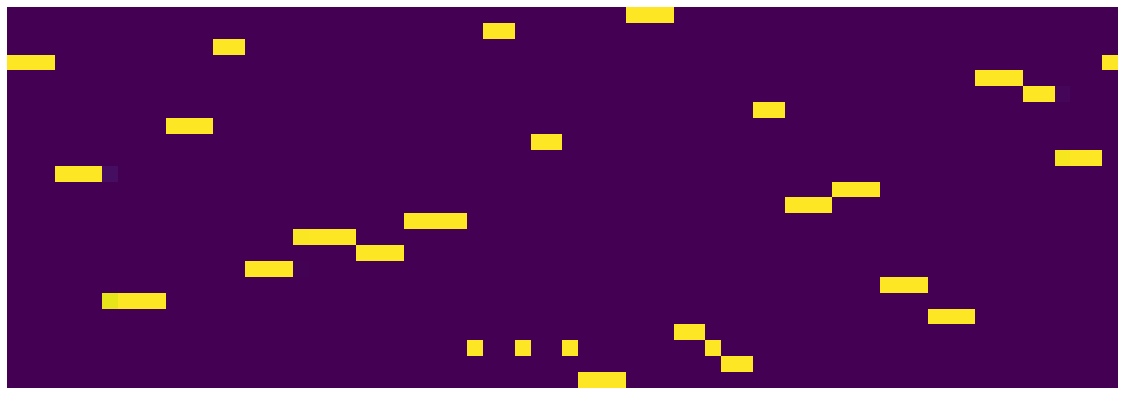

24 394 0.6049999999999996 0.47589849326759576


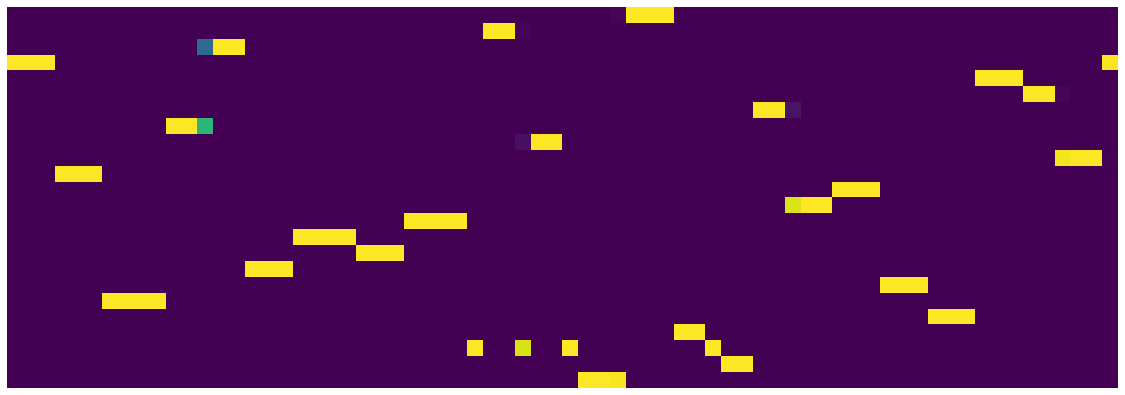

24 395 0.6039999999999996 0.4768353946506977


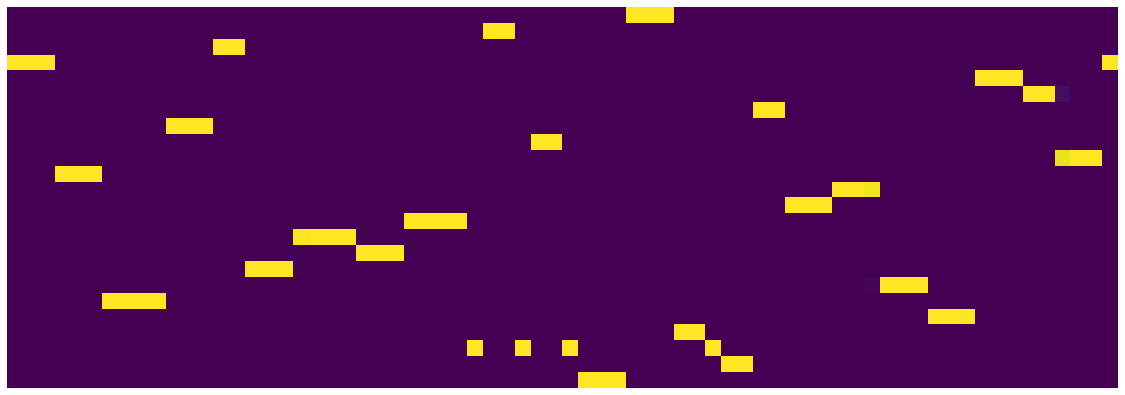

24 396 0.6029999999999996 0.47786595337092874


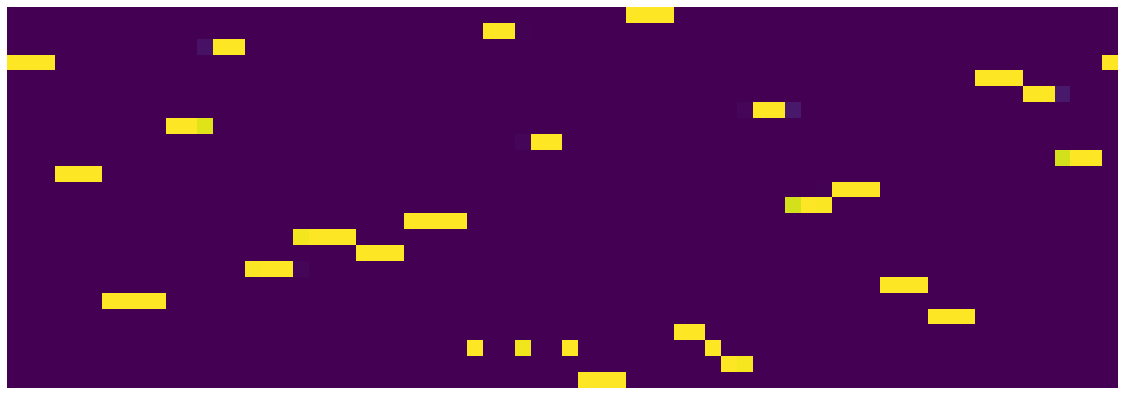

24 397 0.6019999999999996 0.47668764311820266


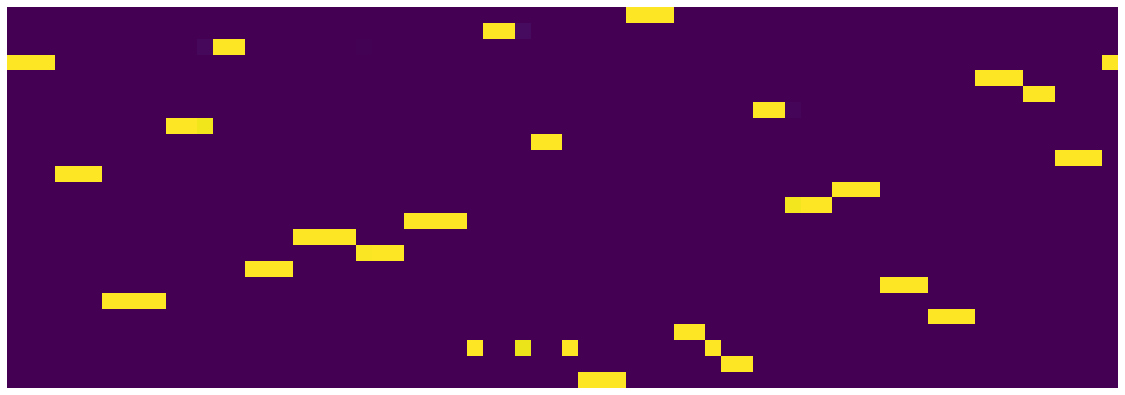

24 398 0.6009999999999996 0.4766052091494203


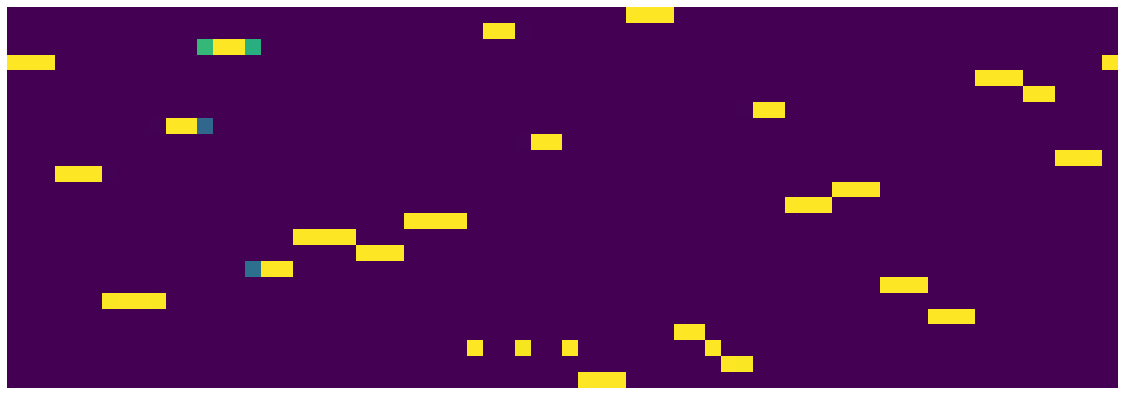

24 399 0.5999999999999996 0.47907205745577813


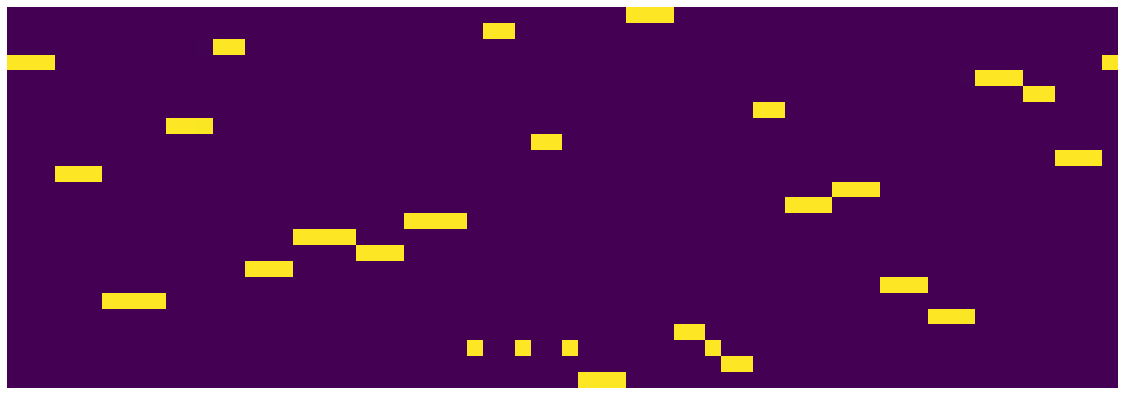

24 400 0.5989999999999996 0.4771570522338152


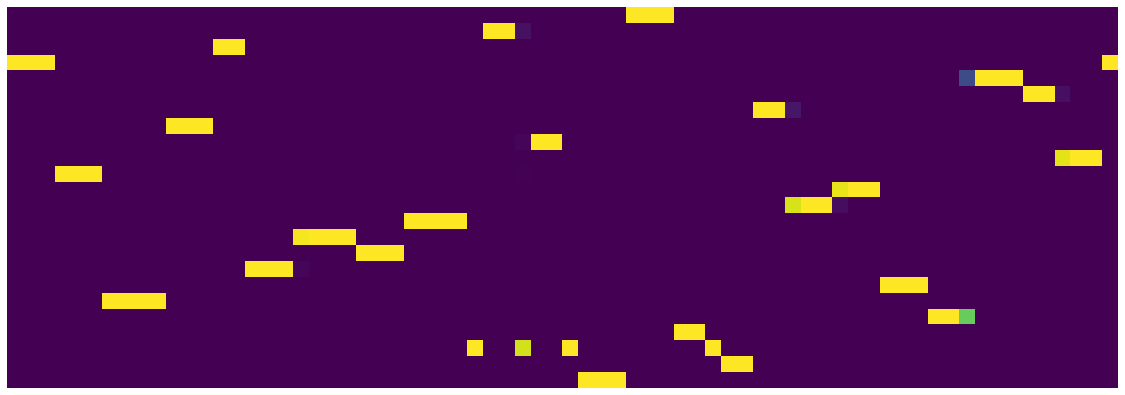

24 401 0.5979999999999996 0.4759727820754051


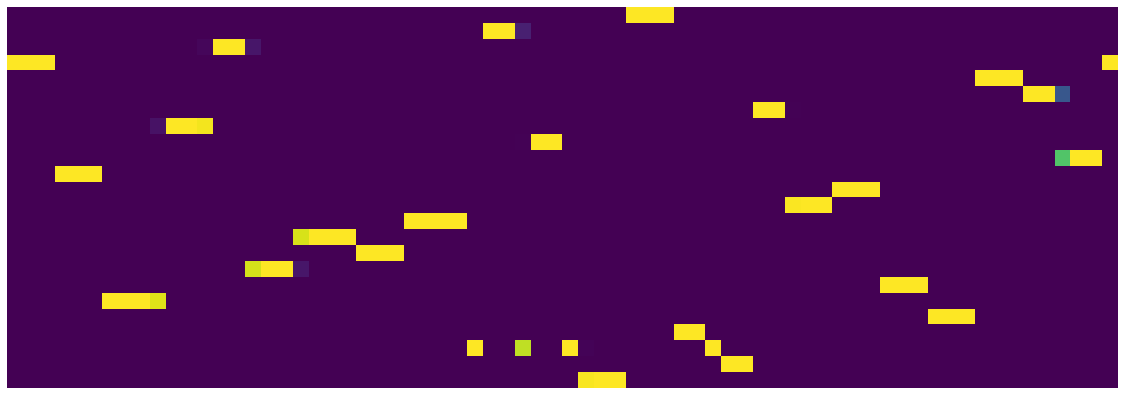

24 402 0.5969999999999996 0.4764553355053067


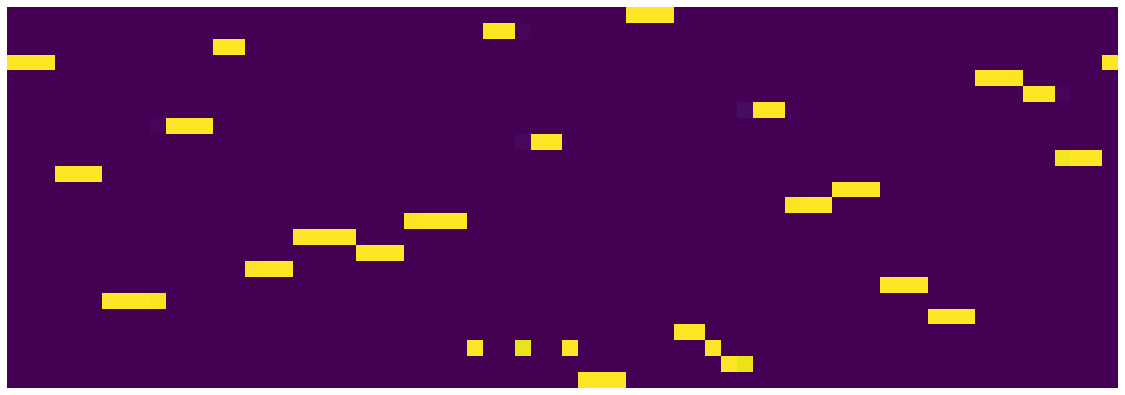

24 403 0.5959999999999996 0.4768391467630863


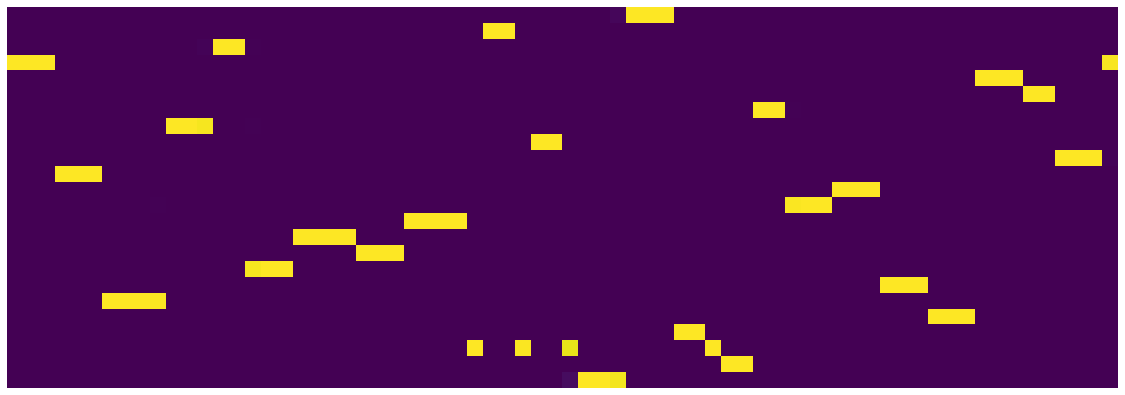

24 404 0.5949999999999996 0.4767550488933921


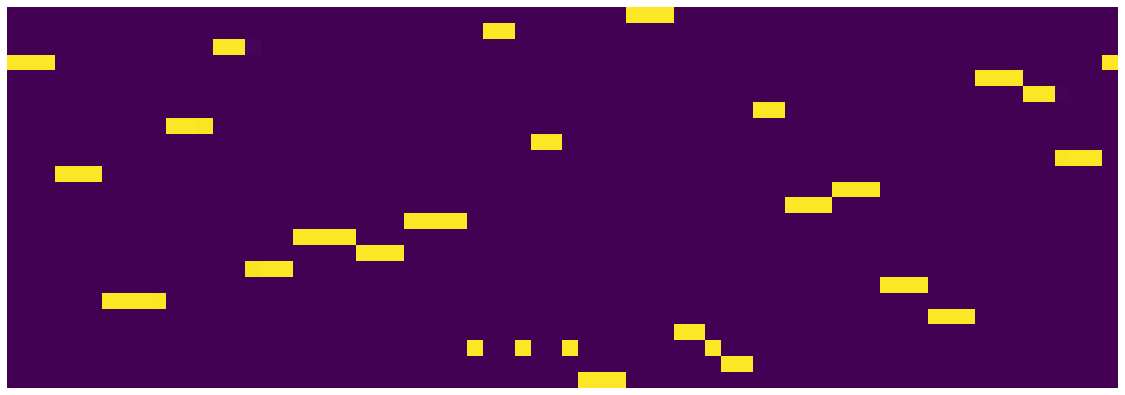

24 405 0.5939999999999996 0.47759604677557943


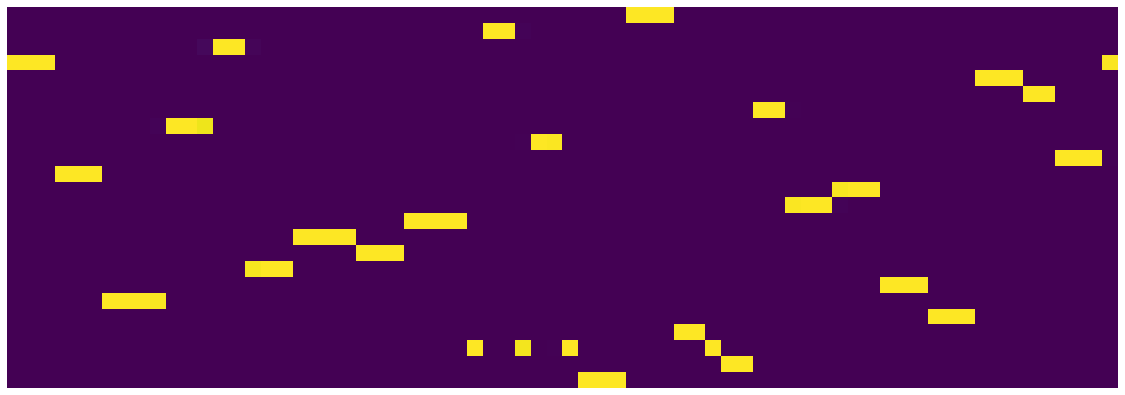

24 406 0.5929999999999996 0.475919777341187


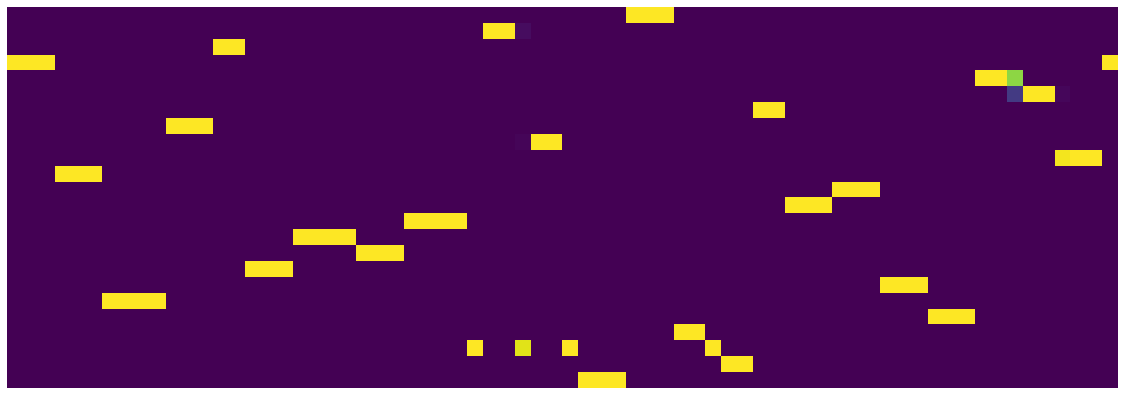

24 407 0.5919999999999996 0.47624381016939876


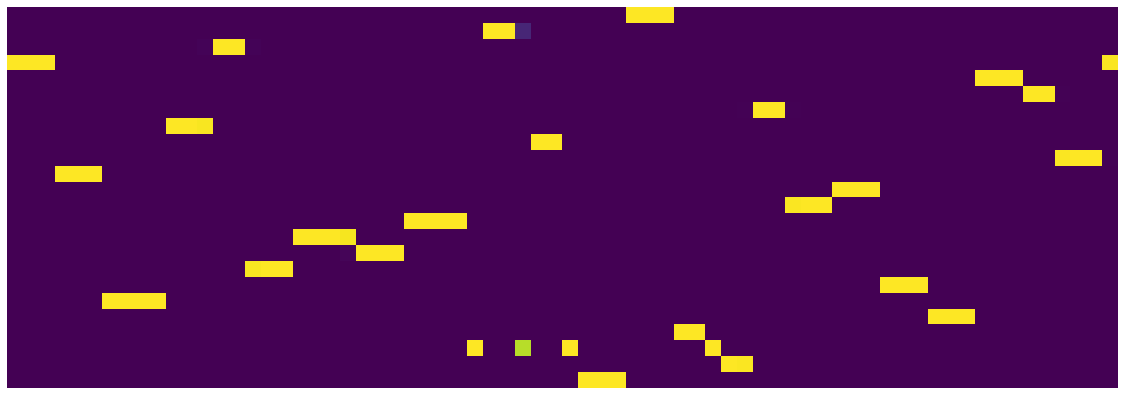

24 408 0.5909999999999996 0.47679629996418954


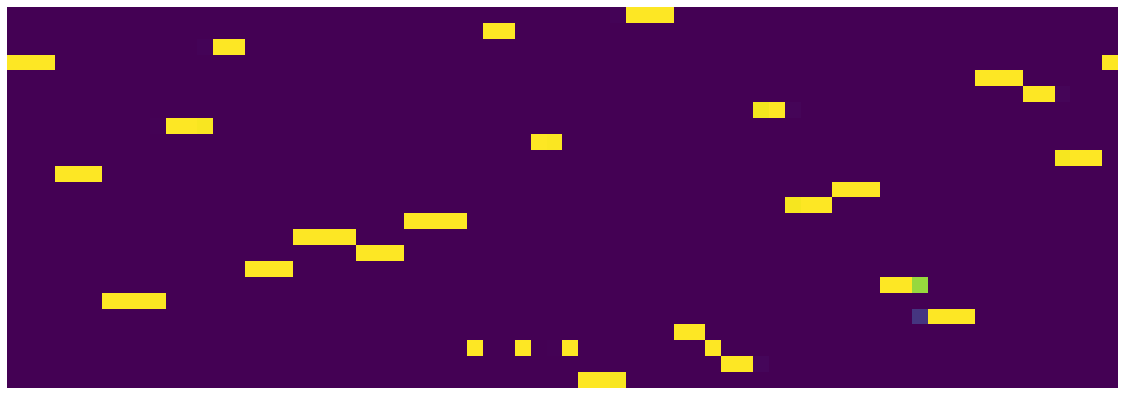

24 409 0.5899999999999996 0.4770009912550449


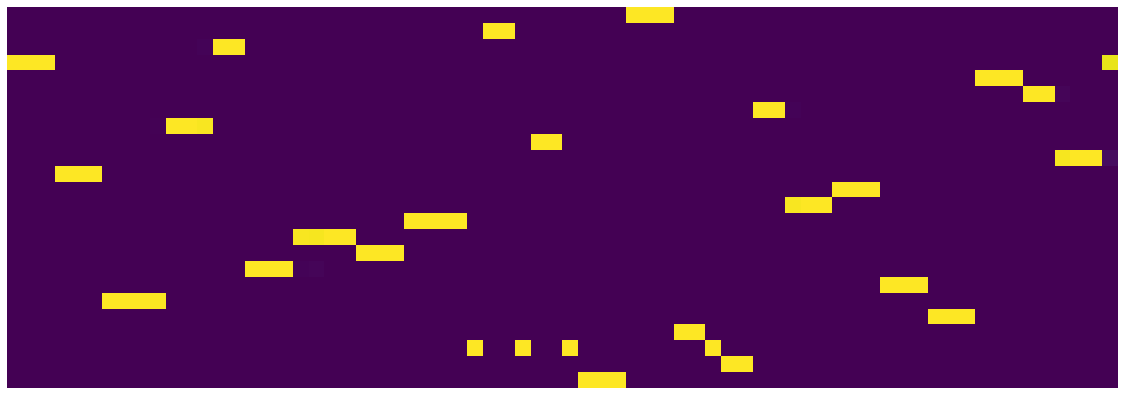

24 410 0.5889999999999996 0.4770388653501868


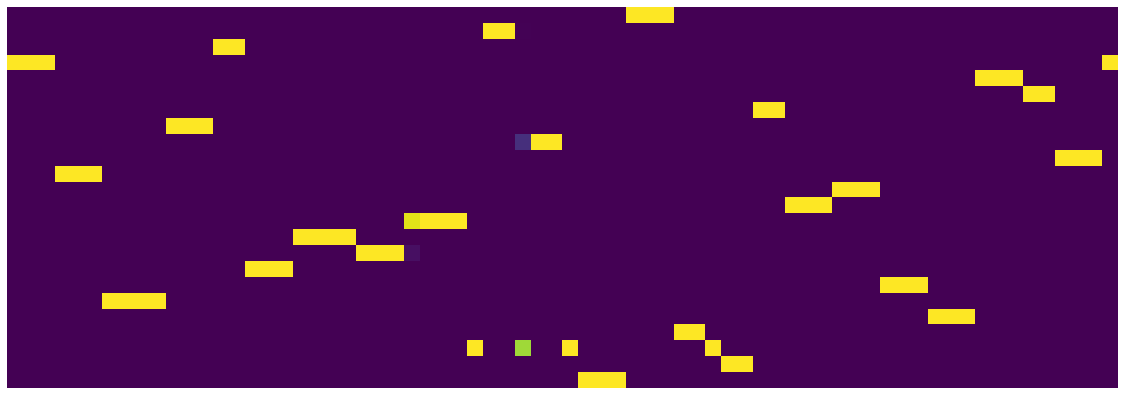

24 411 0.5879999999999996 0.47659642323851586


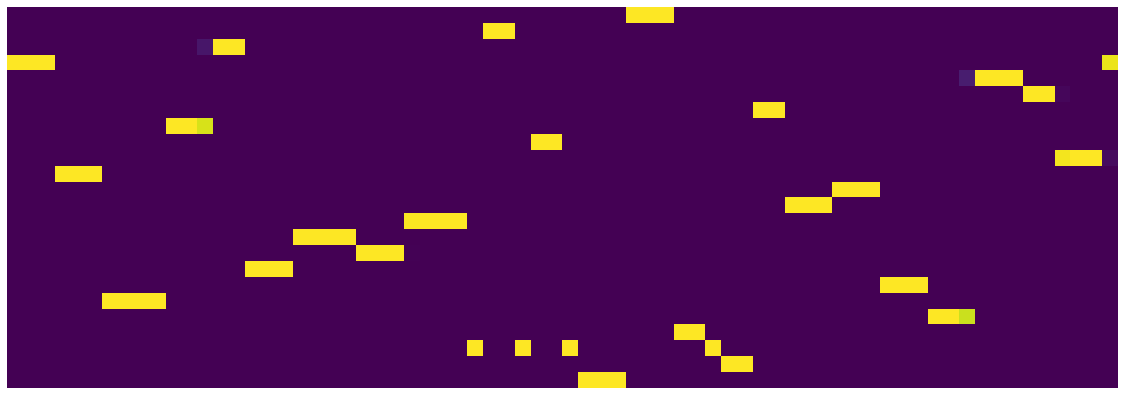

24 412 0.5869999999999996 0.4771510886028409


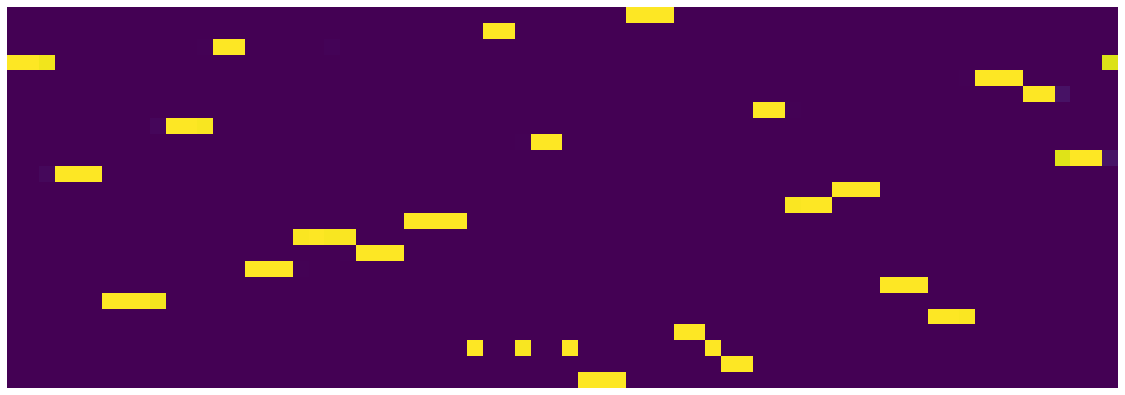

24 413 0.5859999999999996 0.47654249109327795


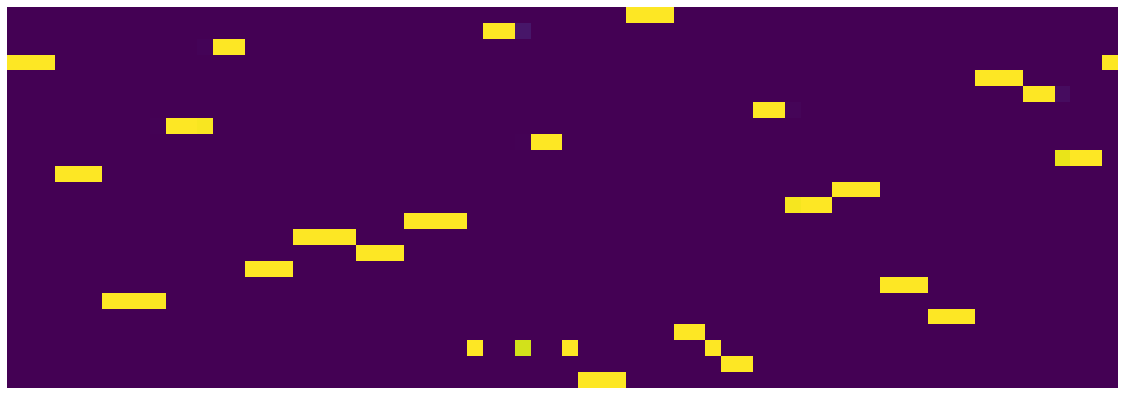

24 414 0.5849999999999996 0.4772275198251009


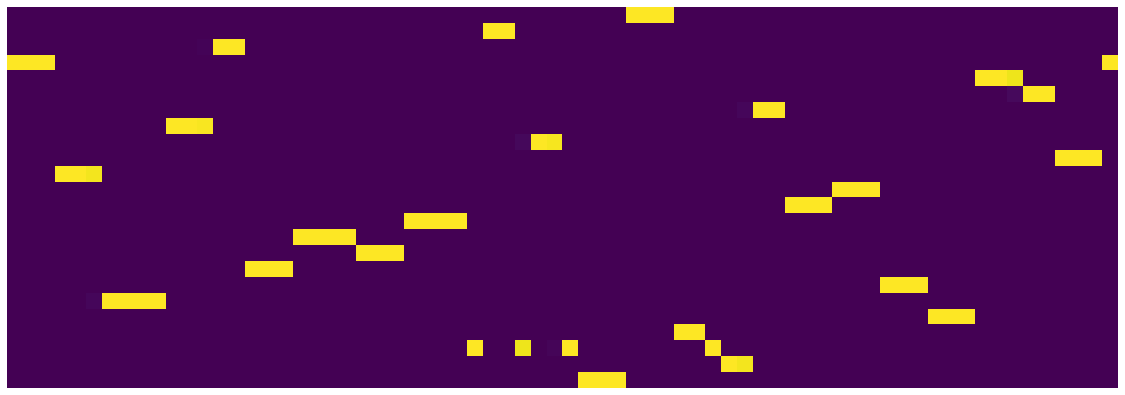

24 415 0.5839999999999996 0.4763707917183638


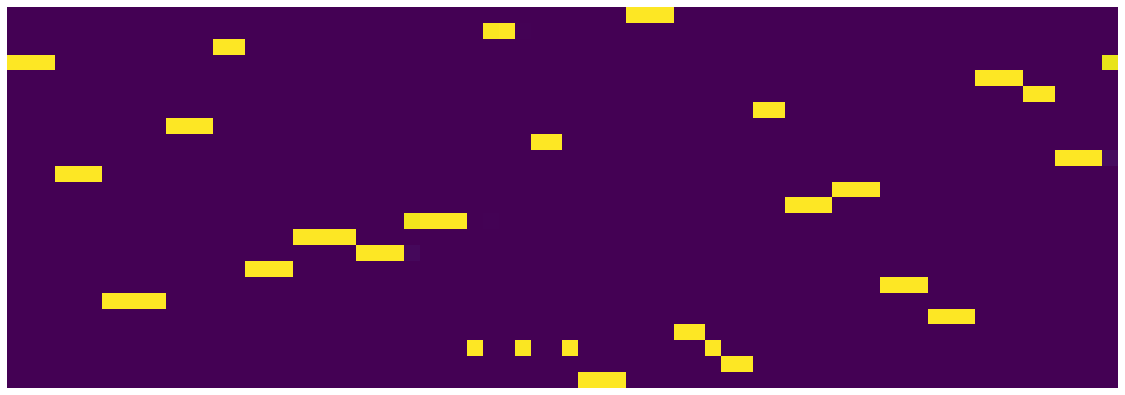

24 416 0.5829999999999996 0.47810828909277914


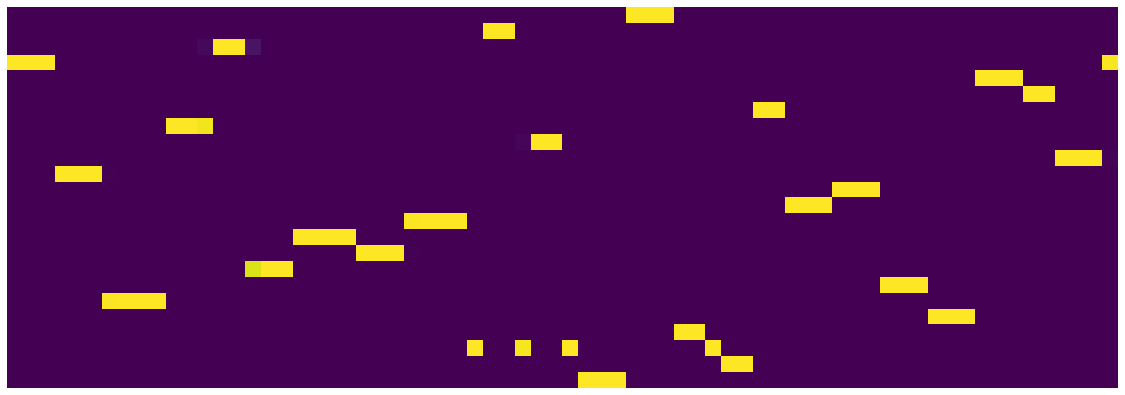

24 417 0.5819999999999996 0.4773432783782482


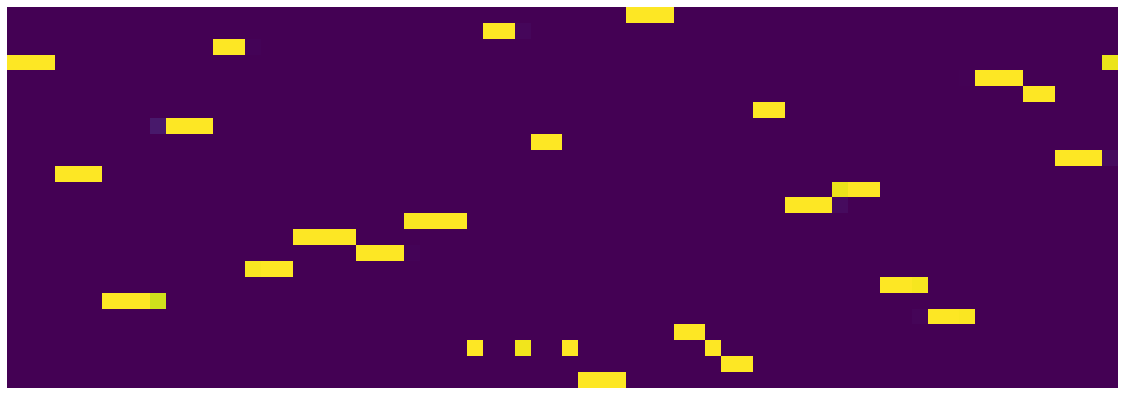

24 418 0.5809999999999996 0.4769619615748525


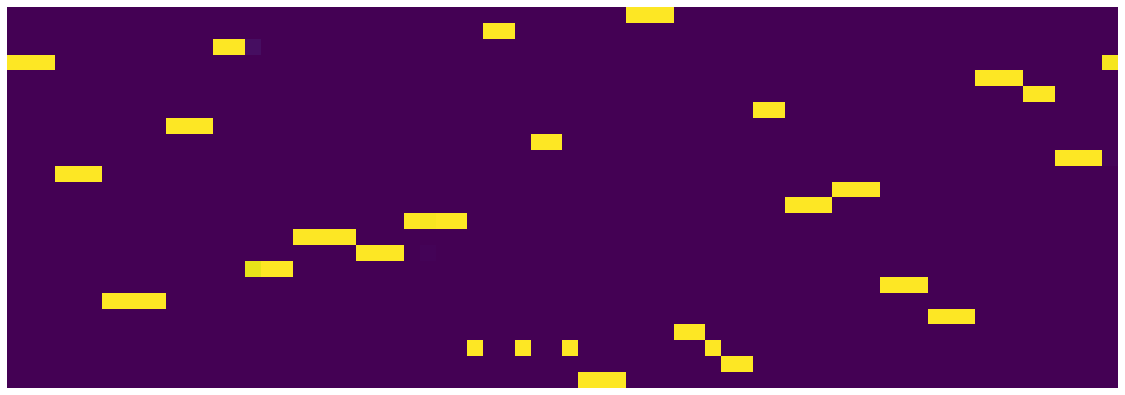

24 419 0.5799999999999996 0.47720769327133894


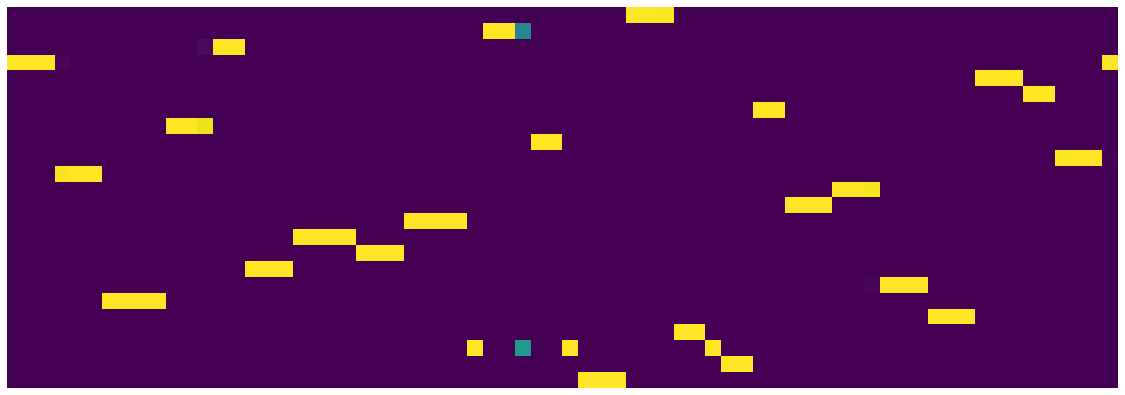

24 420 0.5789999999999996 0.47629328798502685


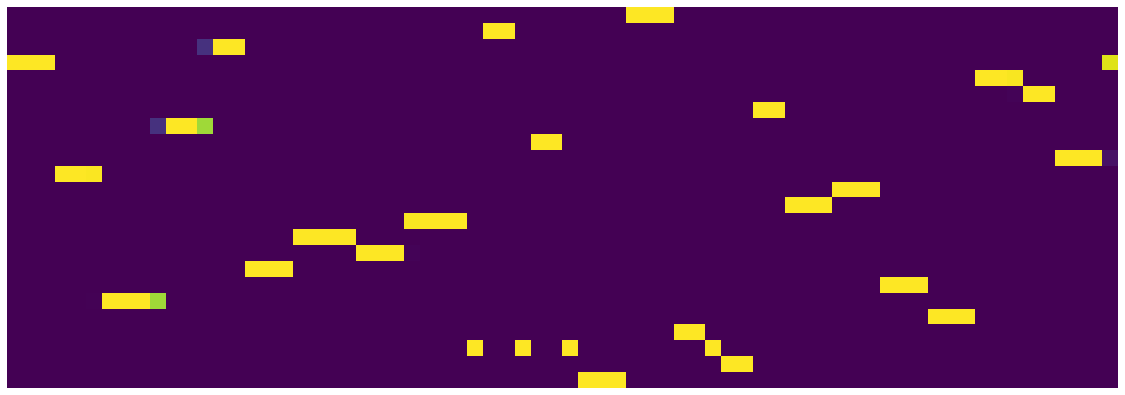

24 421 0.5779999999999996 0.4766079707071185


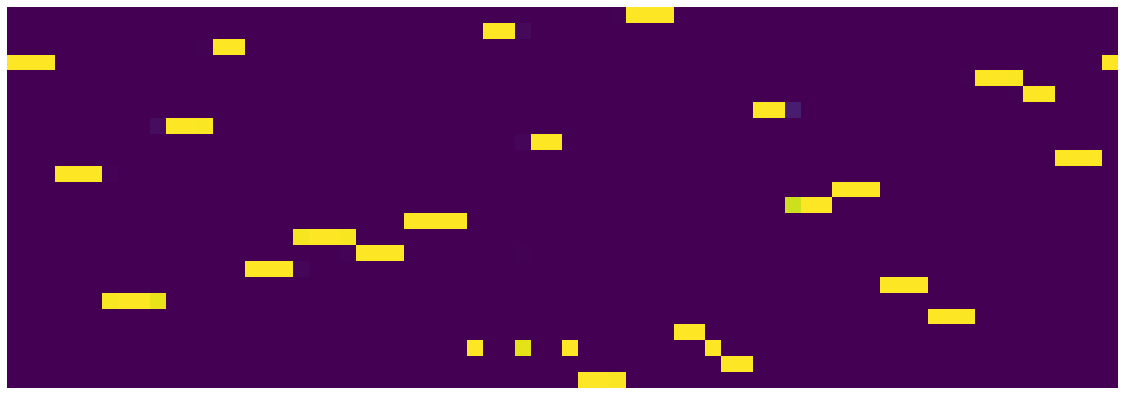

24 422 0.5769999999999996 0.47693493217229843


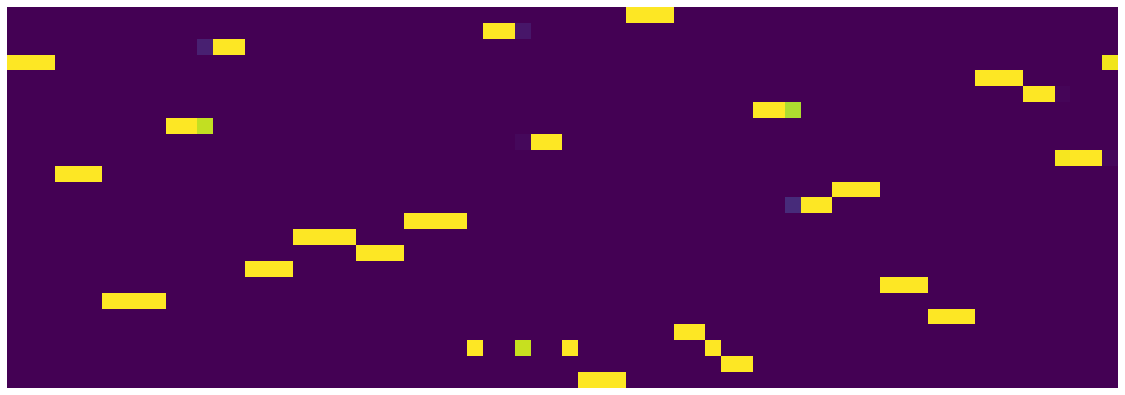

24 423 0.5759999999999996 0.4788762092590332


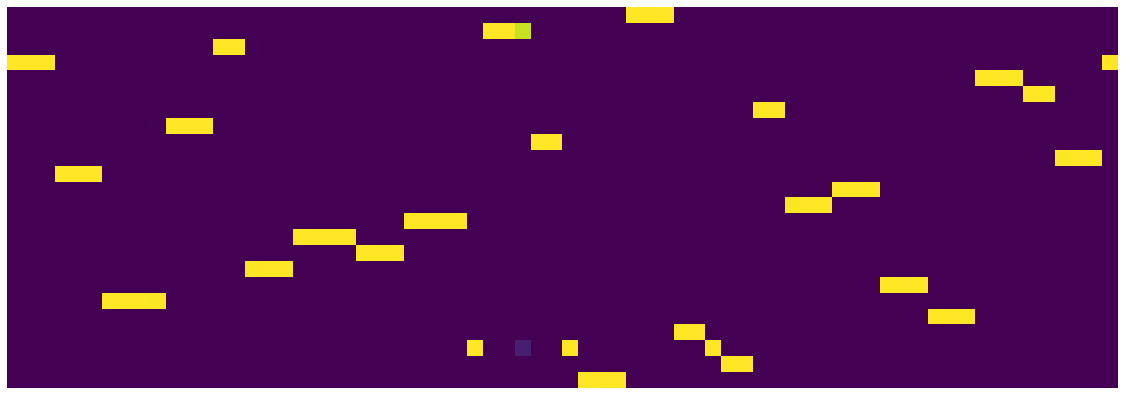

24 424 0.5749999999999996 0.47648607566952705


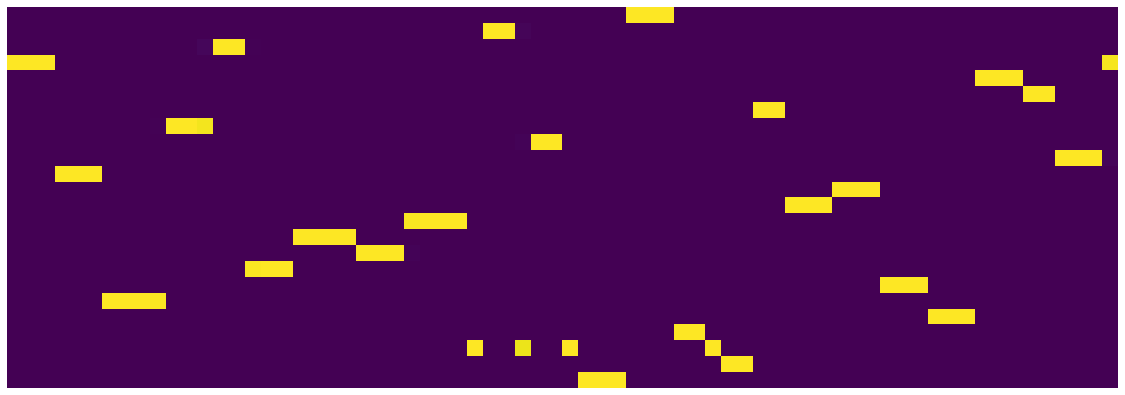

24 425 0.5739999999999996 0.47612547054886817


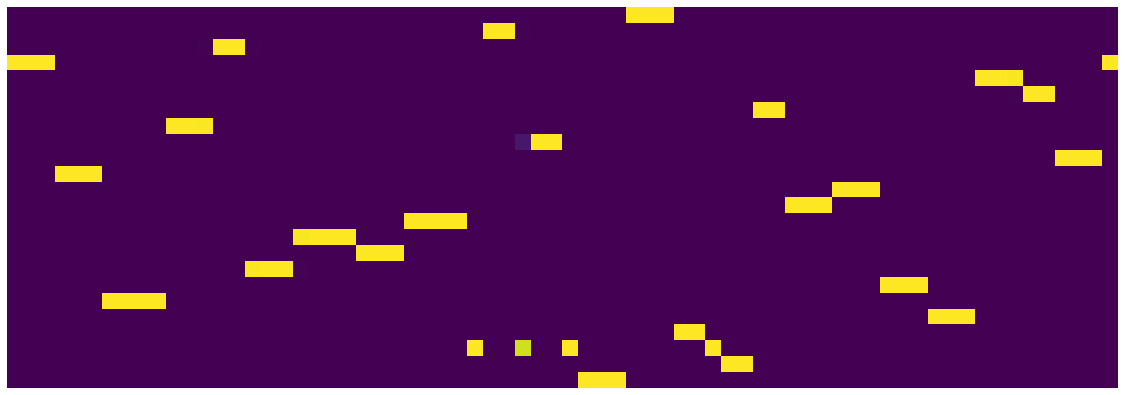

24 426 0.5729999999999996 0.4775981143116951


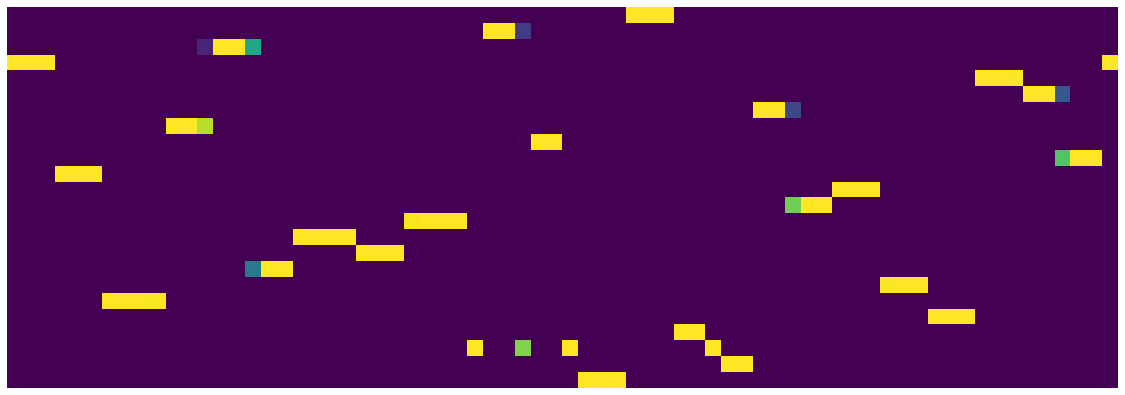

24 427 0.5719999999999996 0.47693619430065154


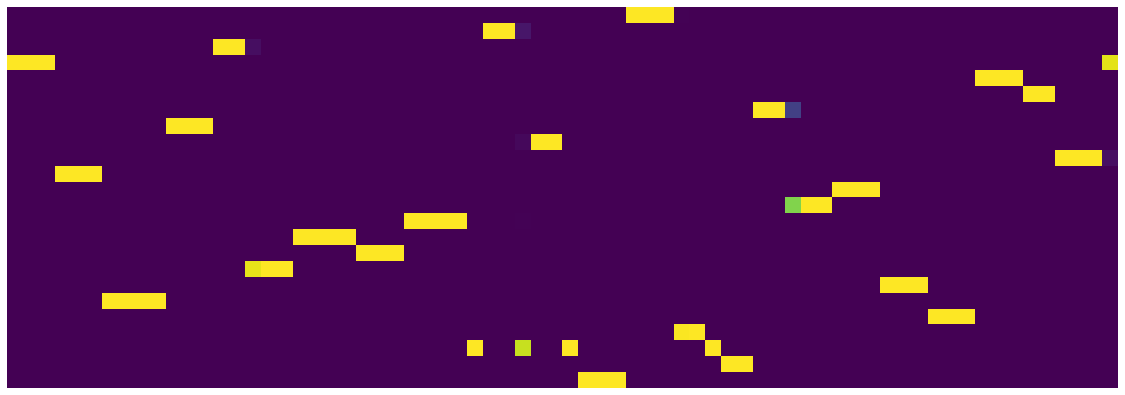

24 428 0.5709999999999996 0.477978041768074


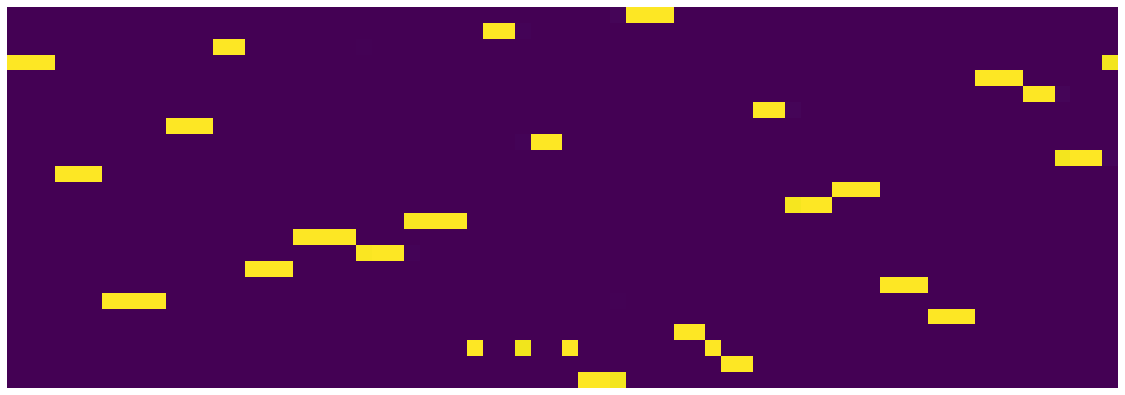

24 429 0.5699999999999996 0.47590269409120084


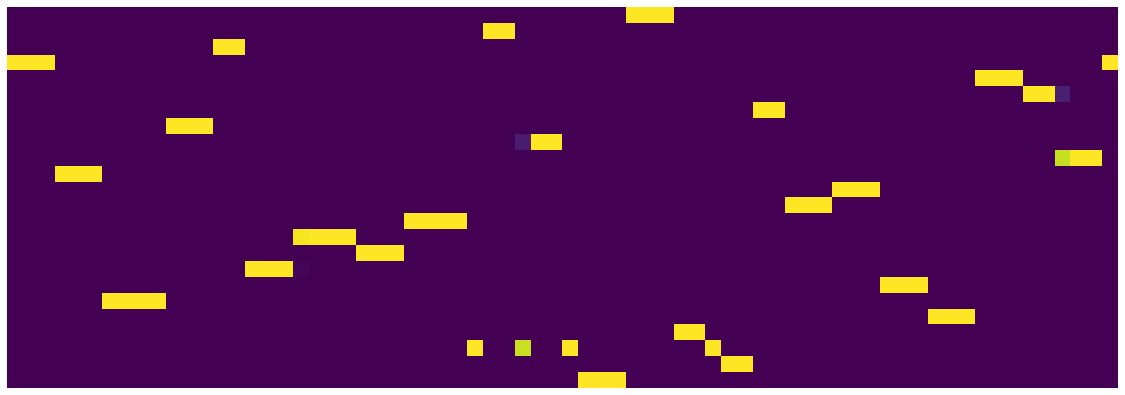

24 430 0.5689999999999996 0.47631819602102043


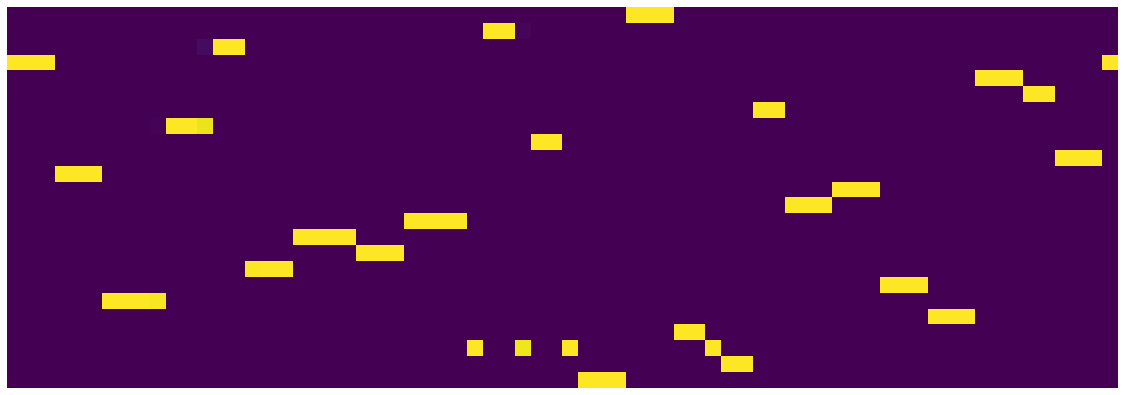

24 431 0.5679999999999996 0.47702253982424736


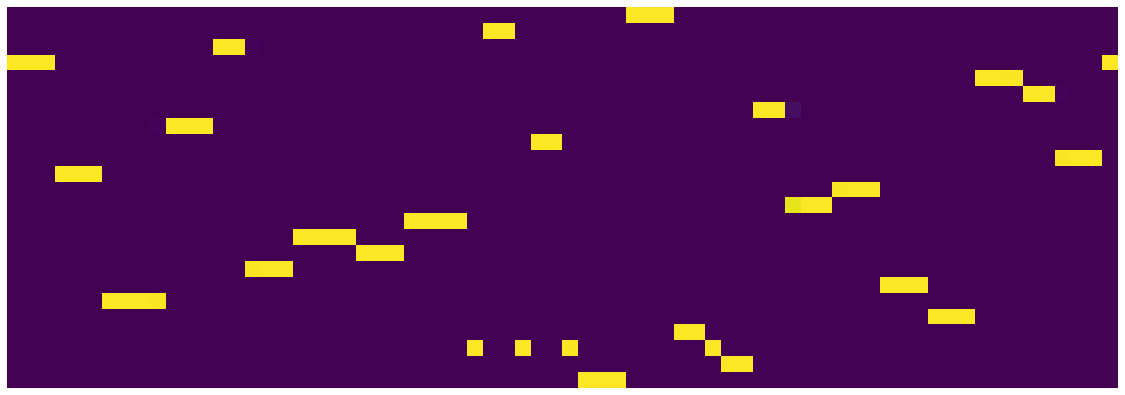

24 432 0.5669999999999996 0.47710595596581695


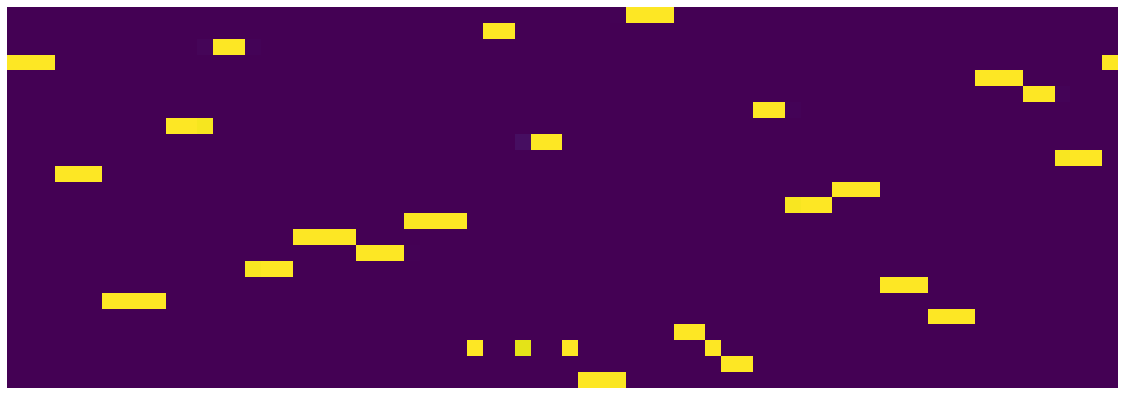

24 433 0.5659999999999996 0.4762335604056716


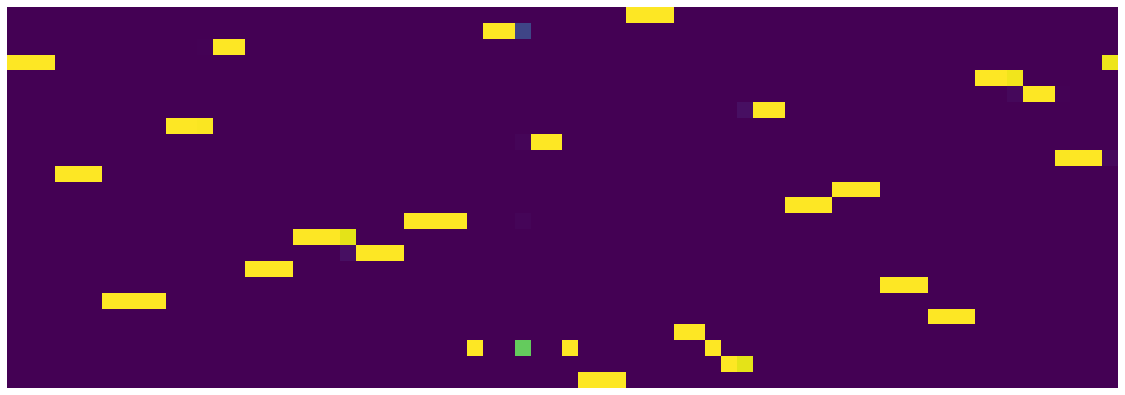

24 434 0.5649999999999996 0.4759122669696808


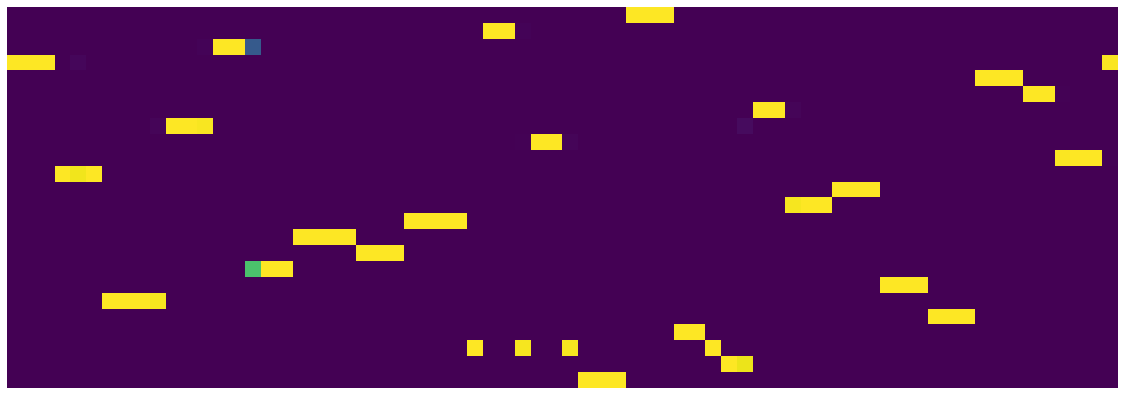

24 435 0.5639999999999996 0.4780526839196682


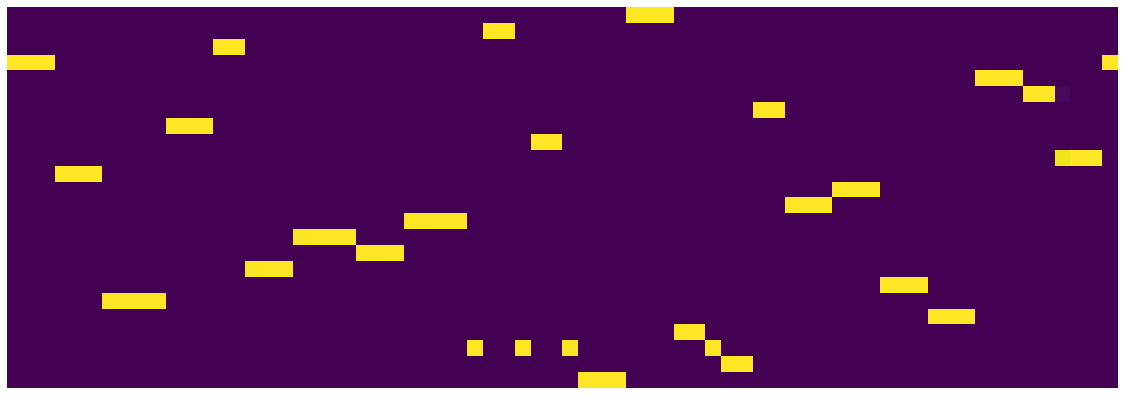

24 436 0.5629999999999996 0.47640394177287815


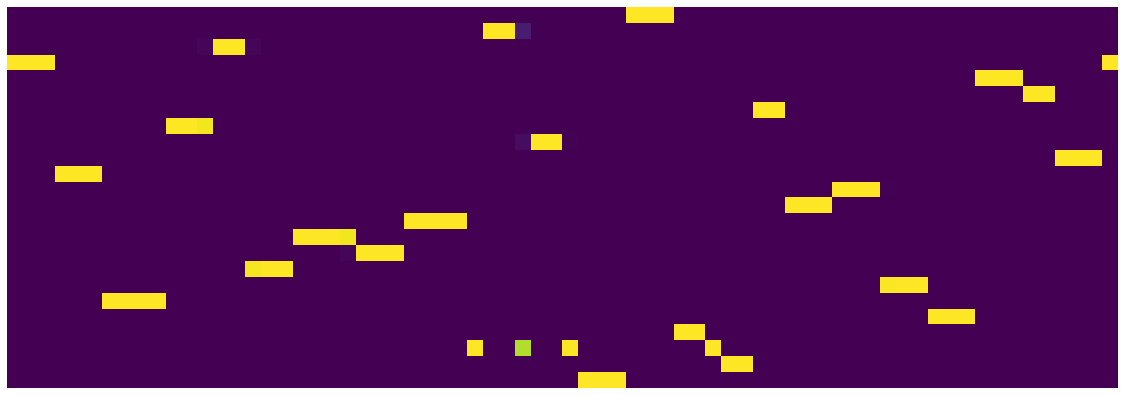

24 437 0.5619999999999996 0.4759938264265656


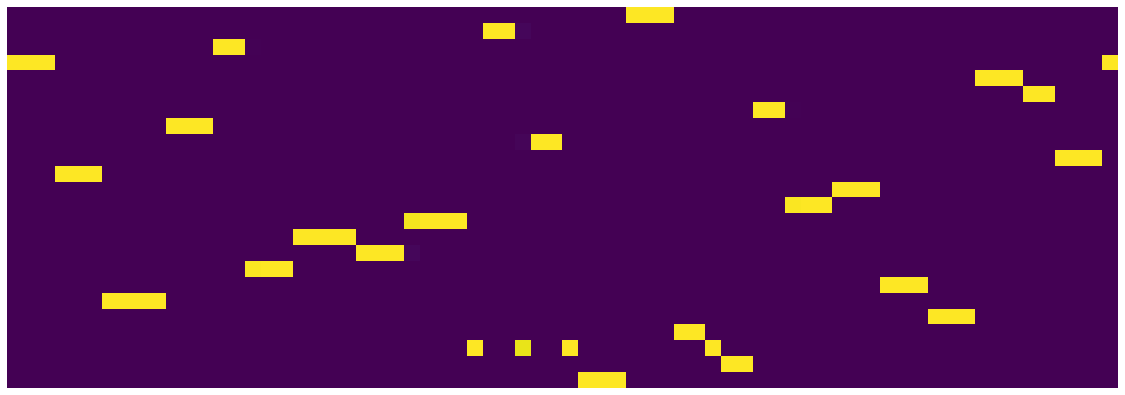

24 438 0.5609999999999996 0.47719572111964226


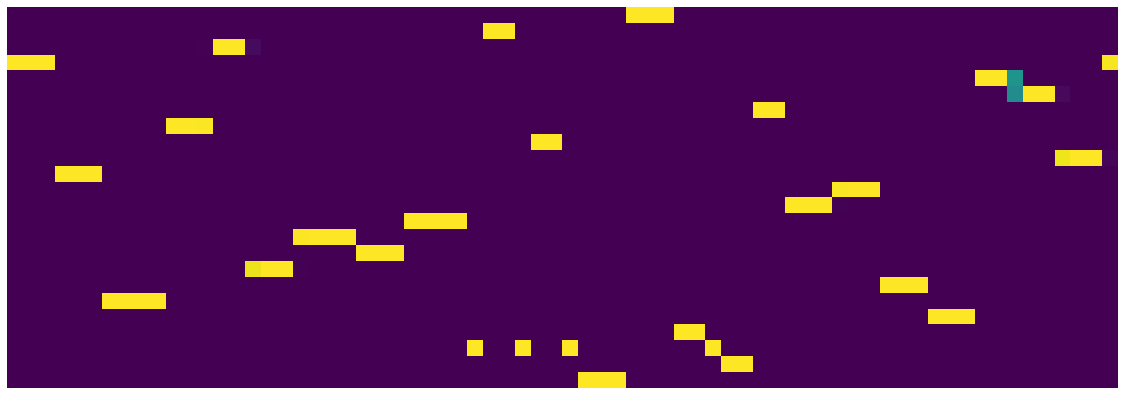

24 439 0.5599999999999996 0.4770824506878853


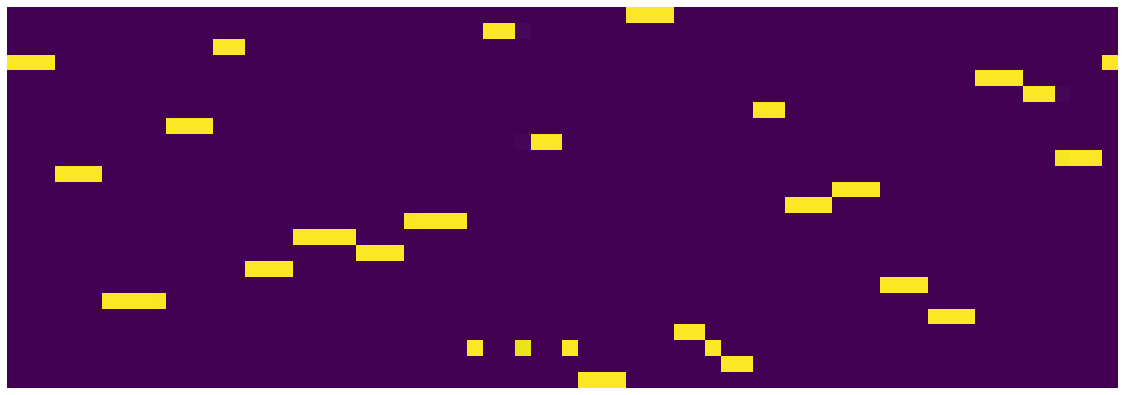

24 440 0.5589999999999996 0.4768768044188619


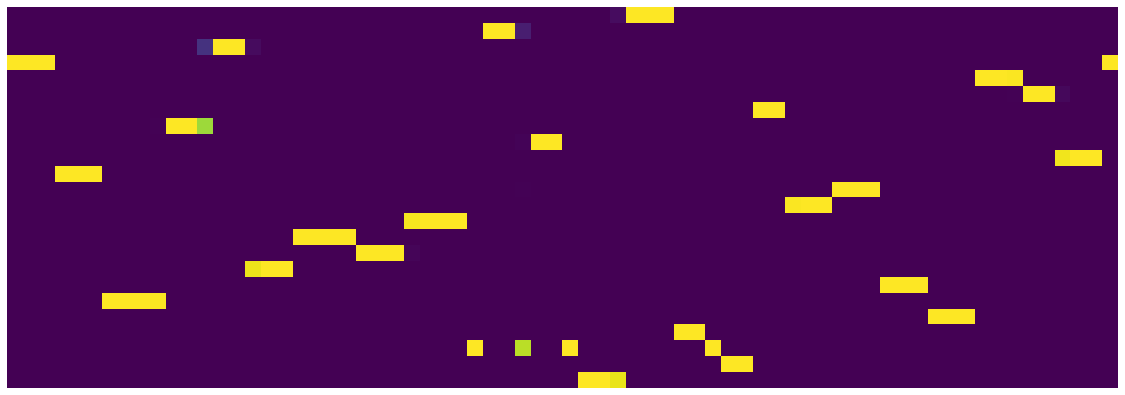

24 441 0.5579999999999996 0.4773922447115183


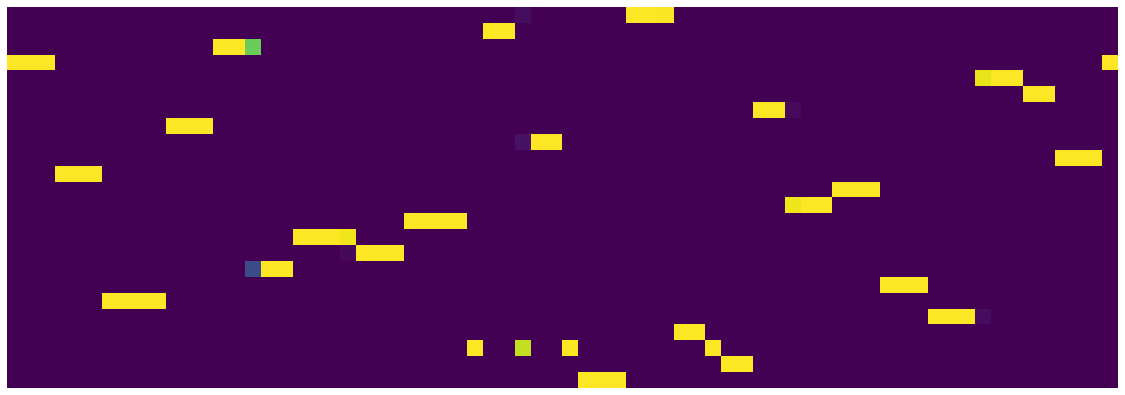

24 442 0.5569999999999996 0.4765633573755622


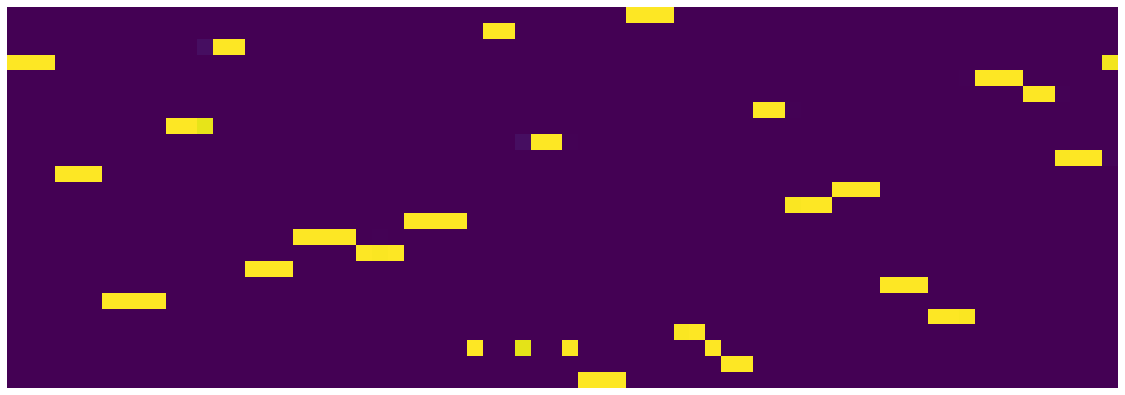

24 443 0.5559999999999996 0.47685479912906886


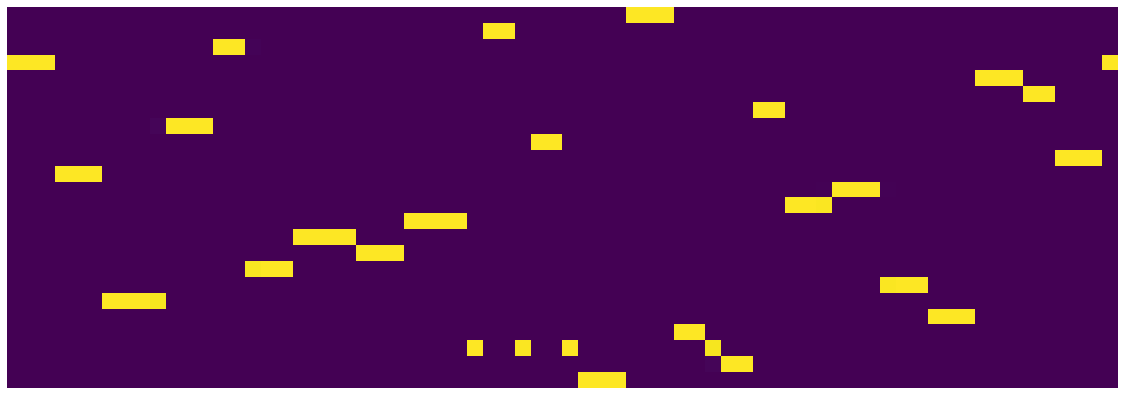

24 444 0.5549999999999996 0.4766258243471384


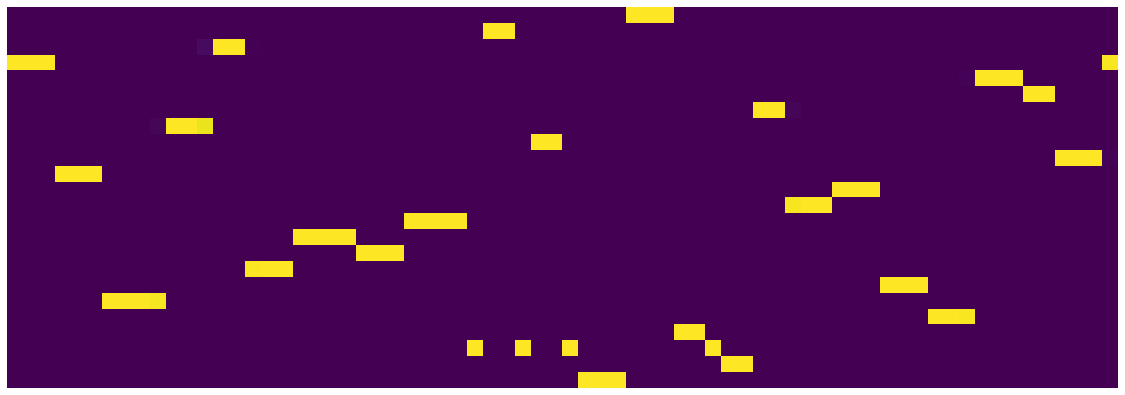

24 445 0.5539999999999996 0.47652775552123783


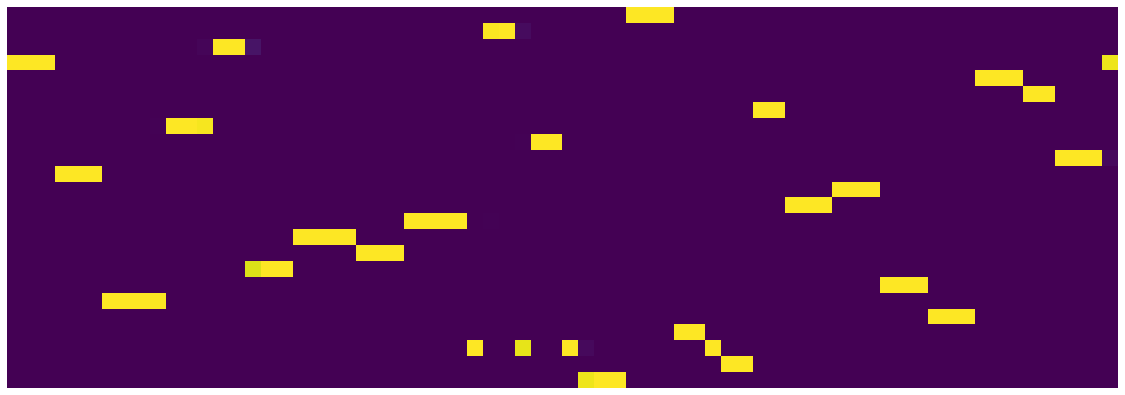

24 446 0.5529999999999996 0.47669706773012877


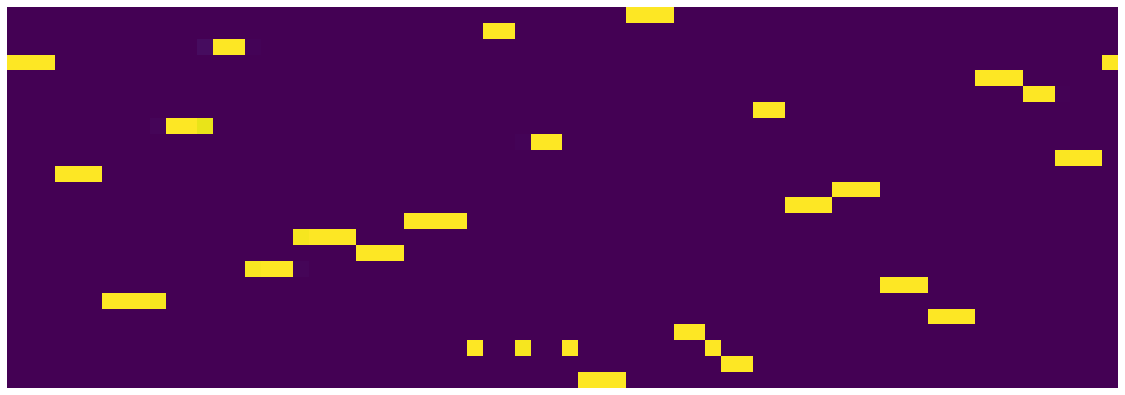

24 447 0.5519999999999996 0.47711836714297534


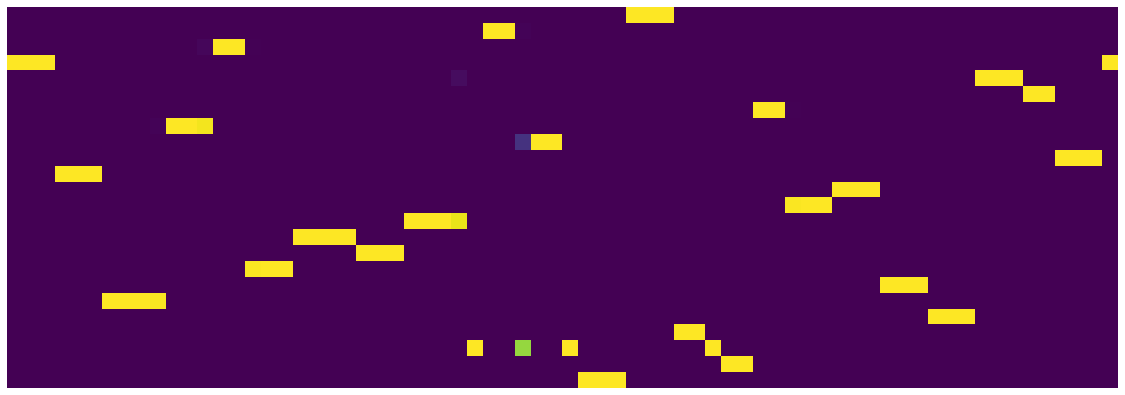

24 448 0.5509999999999996 0.4766278428956866


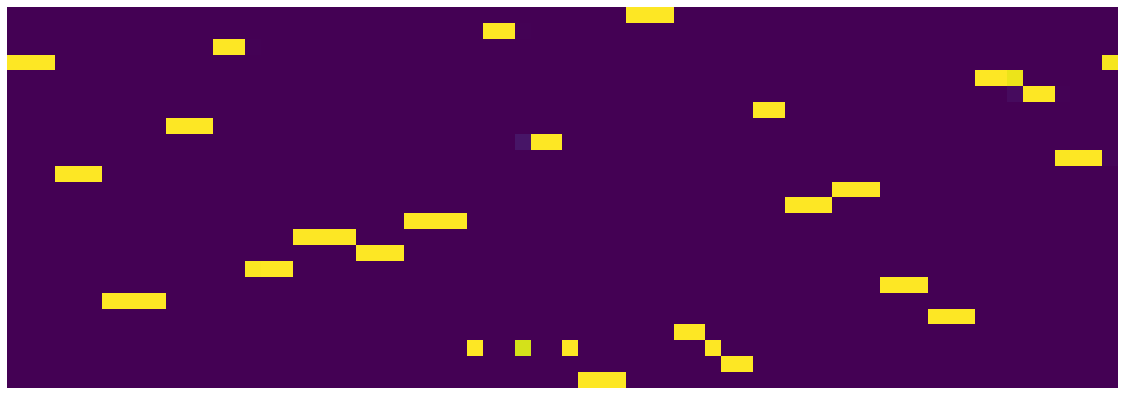

24 449 0.5499999999999996 0.47777421940118076


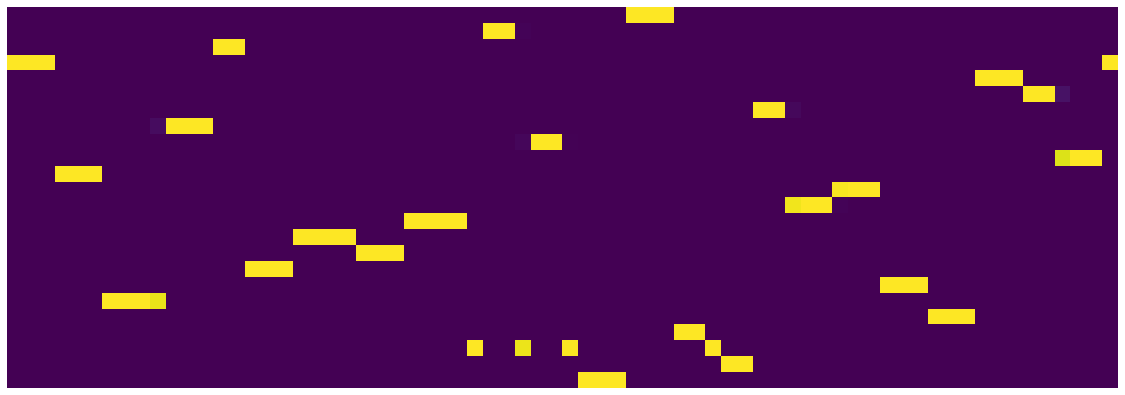

24 450 0.5489999999999996 0.4772053645923734


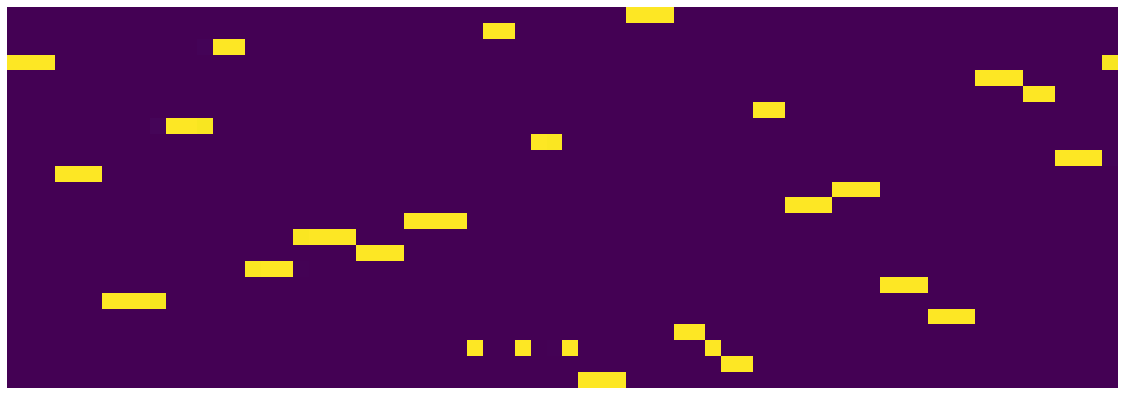

24 451 0.5479999999999996 0.4769883112981915


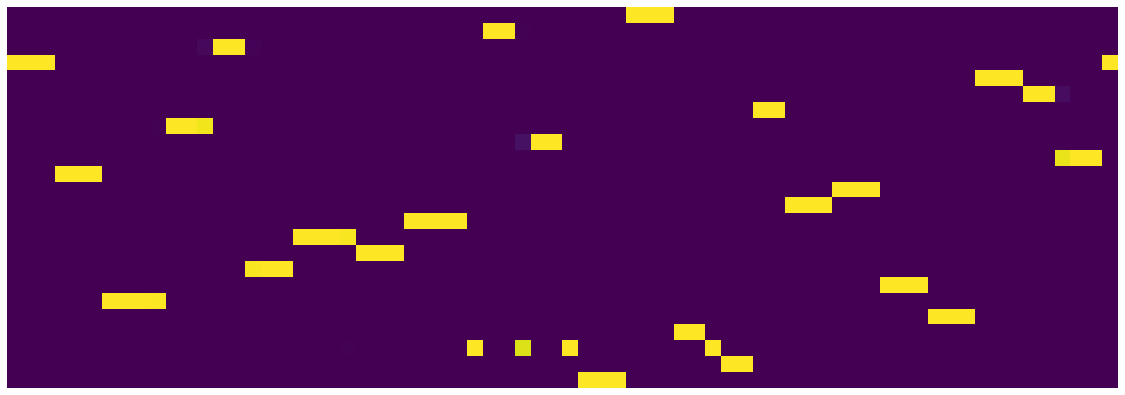

24 452 0.5469999999999996 0.47634874638170005


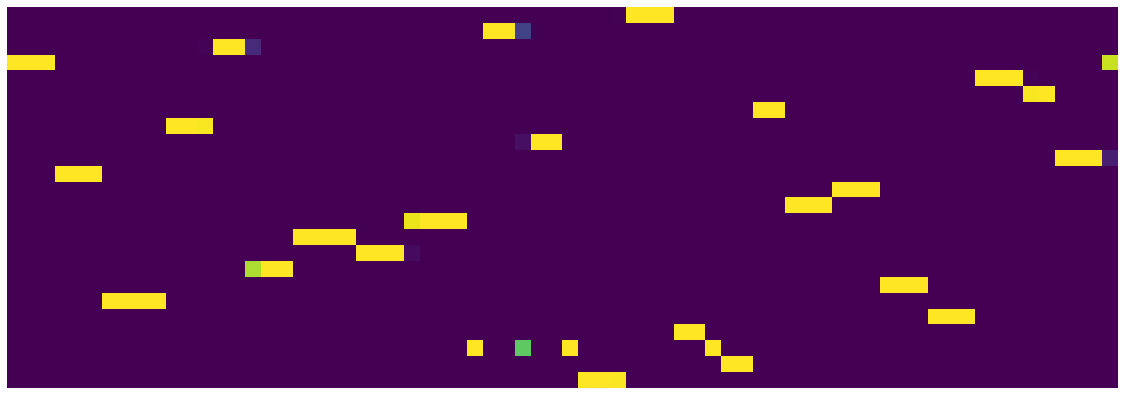

24 453 0.5459999999999996 0.47631286550313234


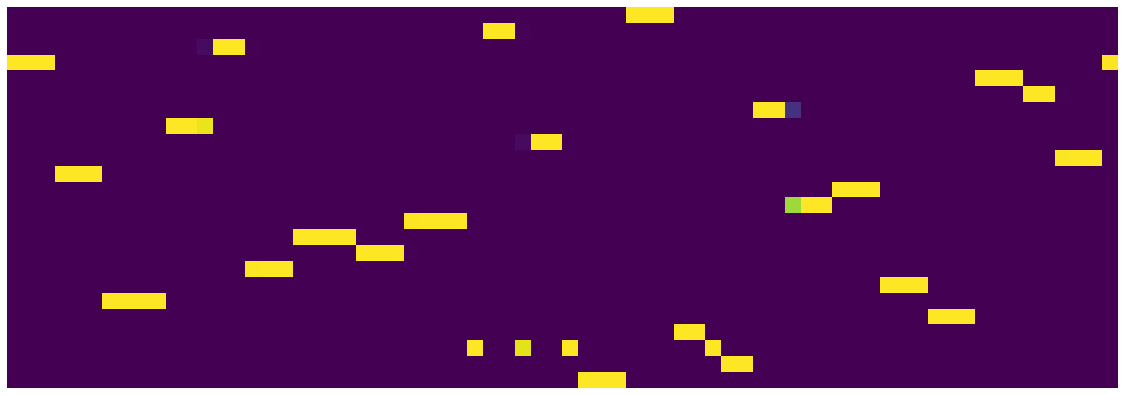

24 454 0.5449999999999996 0.47657218035310506


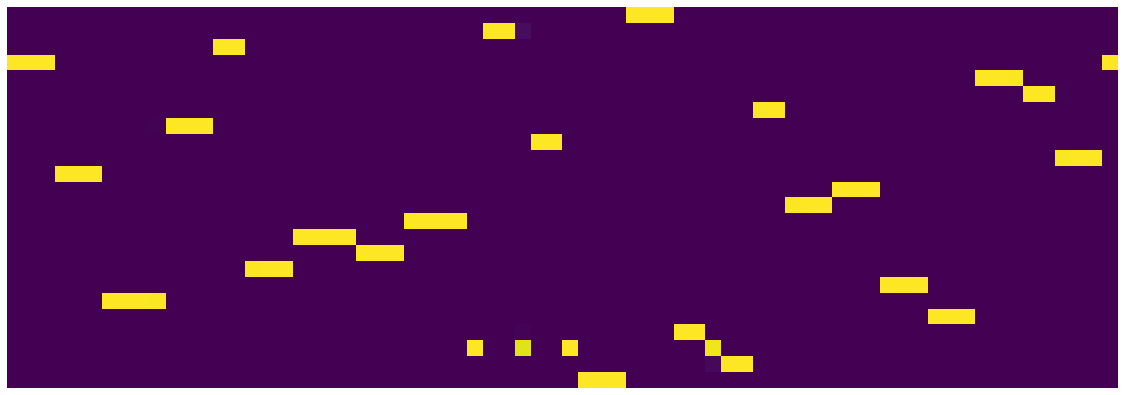

24 455 0.5439999999999996 0.4766032200306654


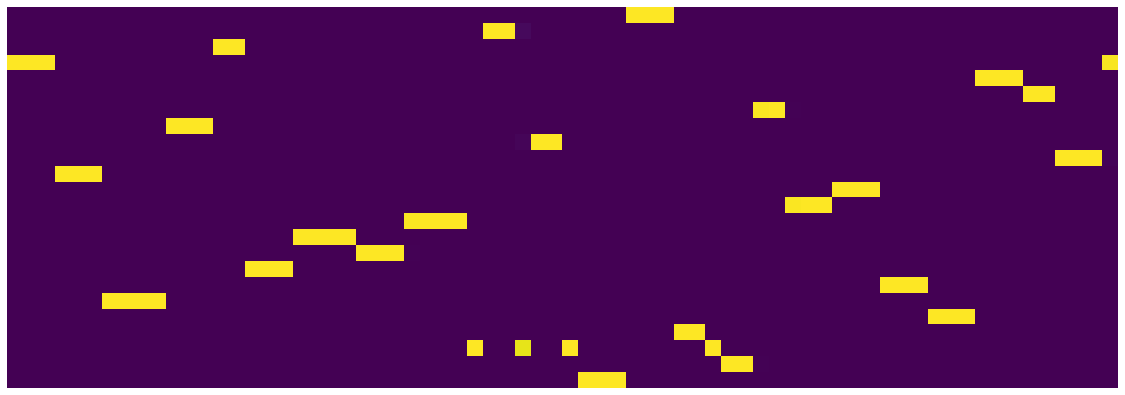

24 456 0.5429999999999996 0.4766793819144368


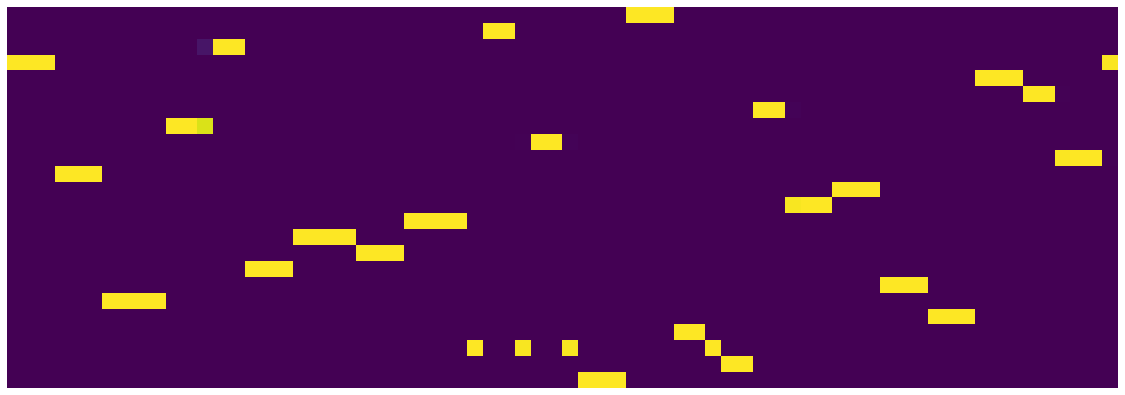

24 457 0.5419999999999996 0.47590104322880505


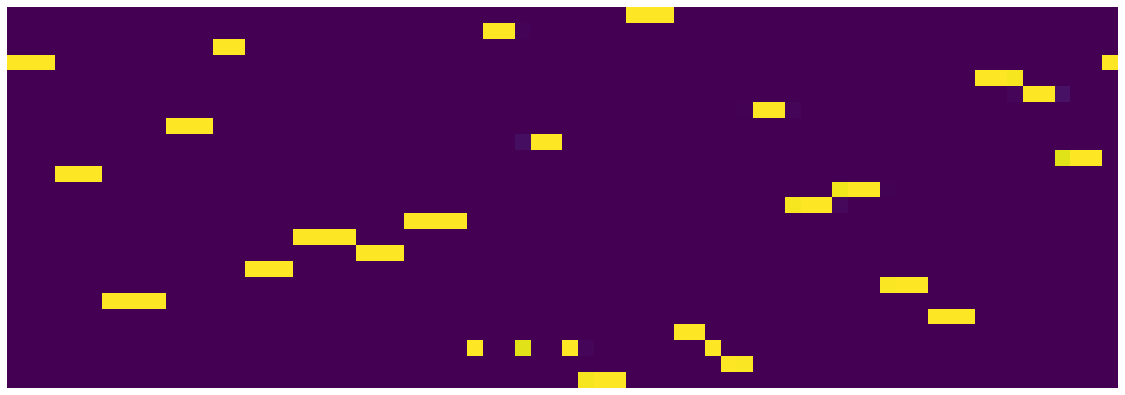

24 458 0.5409999999999996 0.4769722869619727


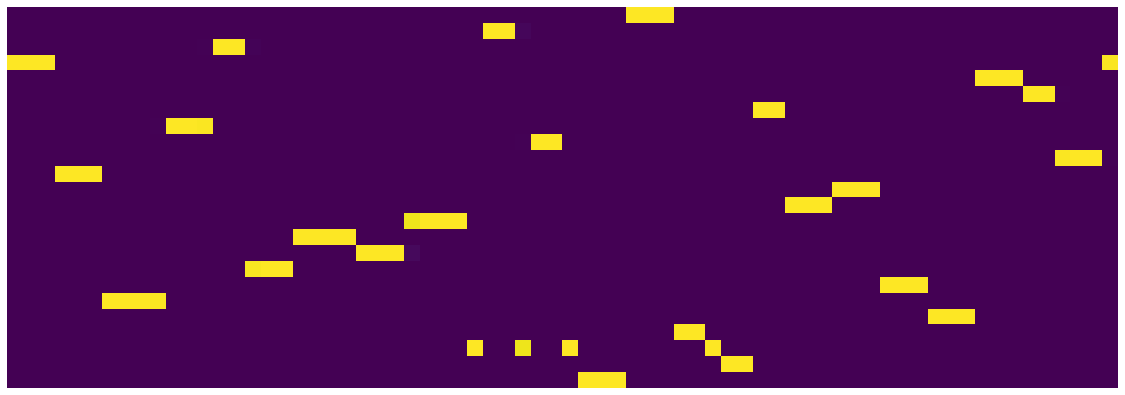

24 459 0.5399999999999996 0.48022130616009234


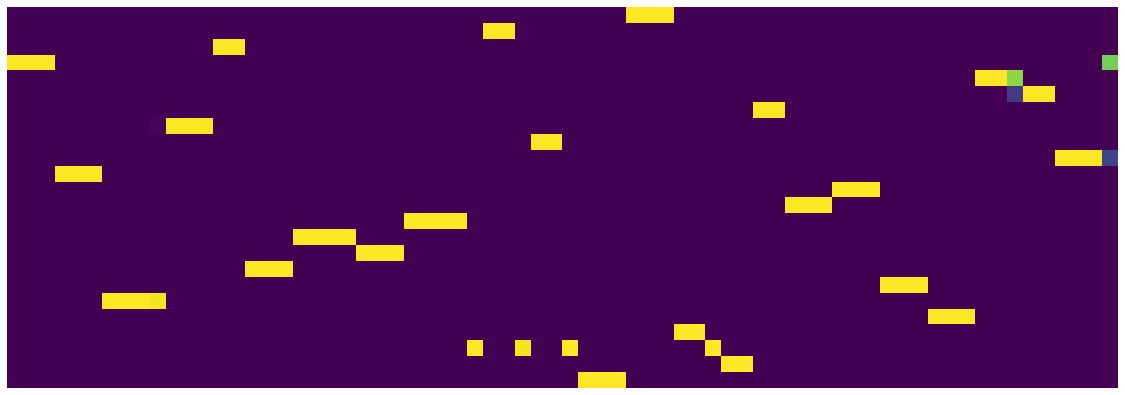

24 460 0.5389999999999996 0.4763523265719414


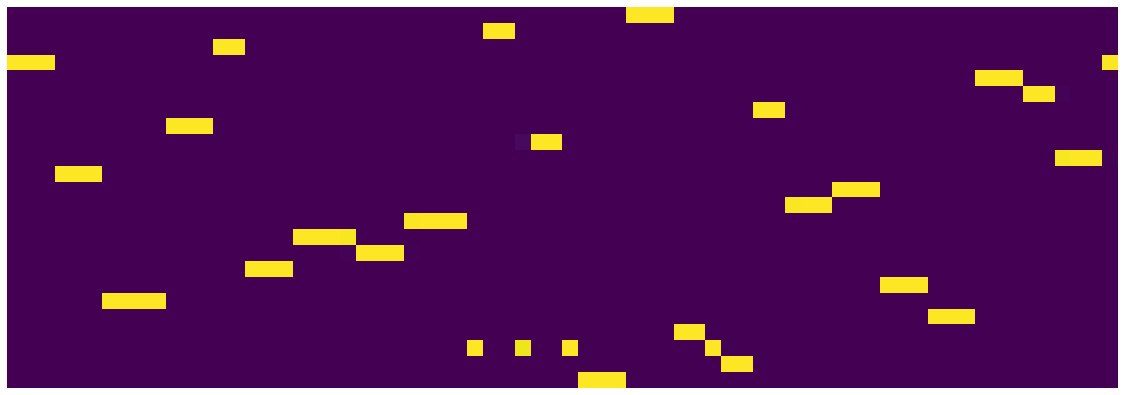

24 461 0.5379999999999996 0.4771506259217858


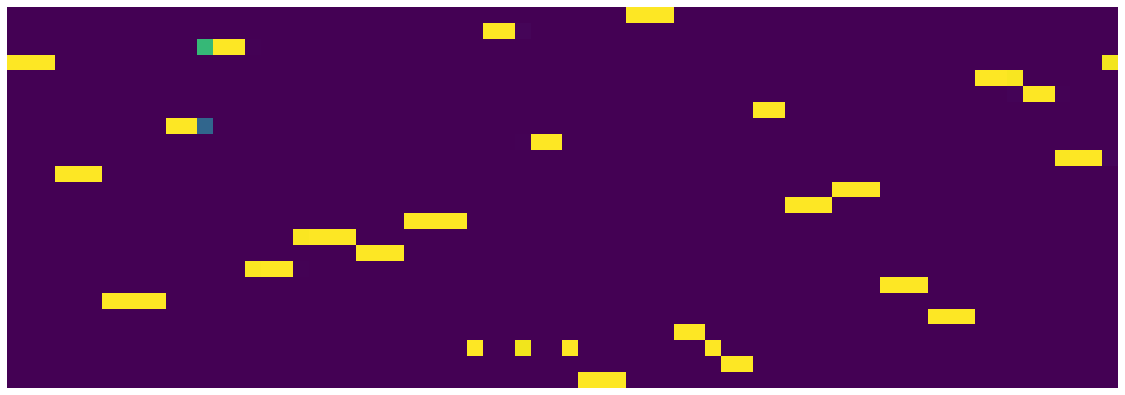

24 462 0.5369999999999996 0.47642504554241893


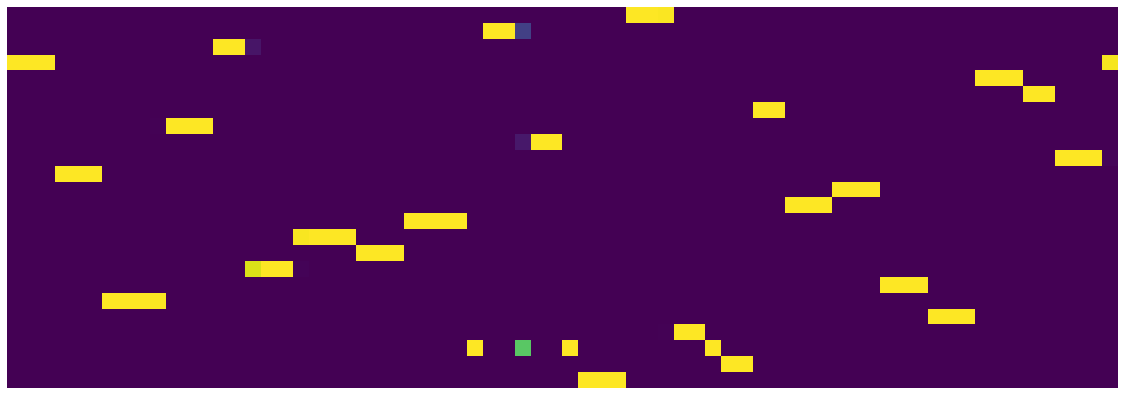

24 463 0.5359999999999996 0.47705456633120774


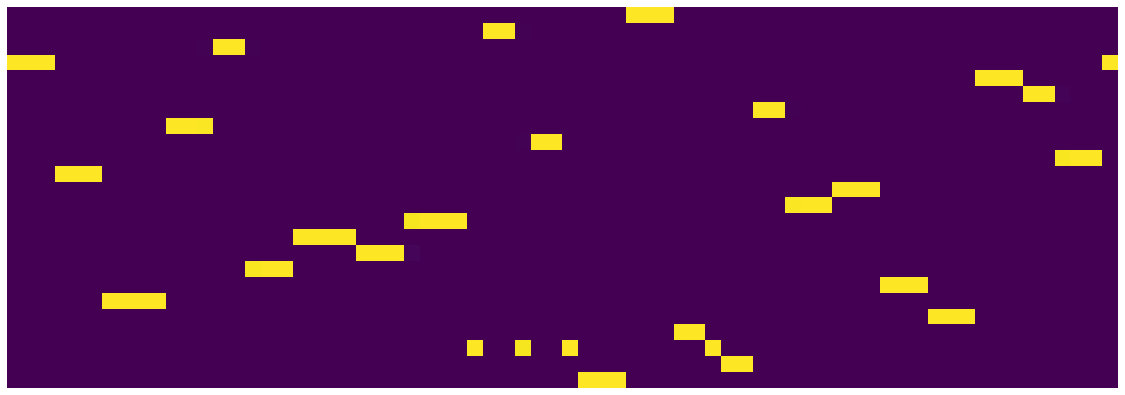

24 464 0.5349999999999996 0.47698350064456463


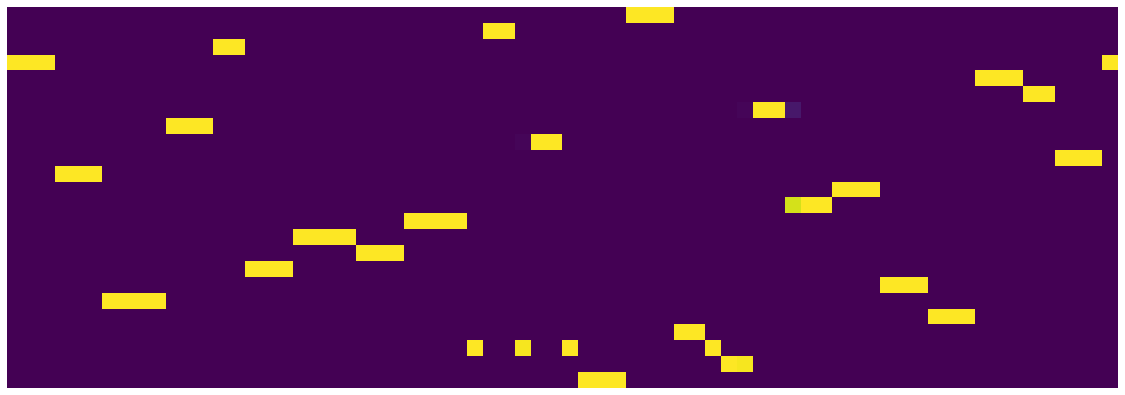

24 465 0.5339999999999996 0.4776323437690735


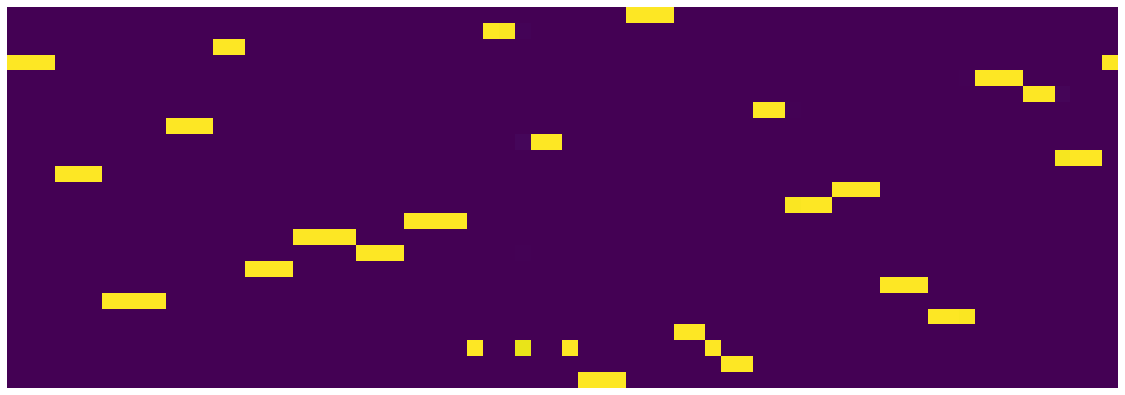

24 466 0.5329999999999996 0.47637716550379994


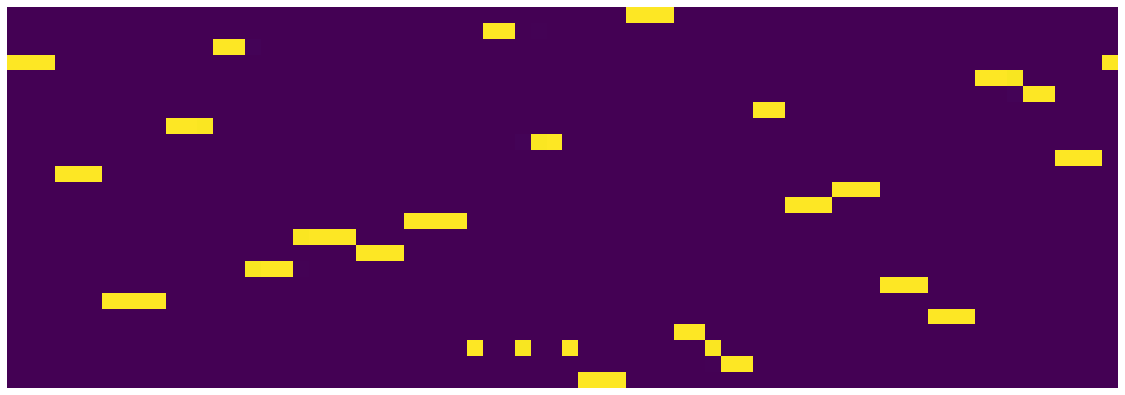

24 467 0.5319999999999996 0.47674825191497805


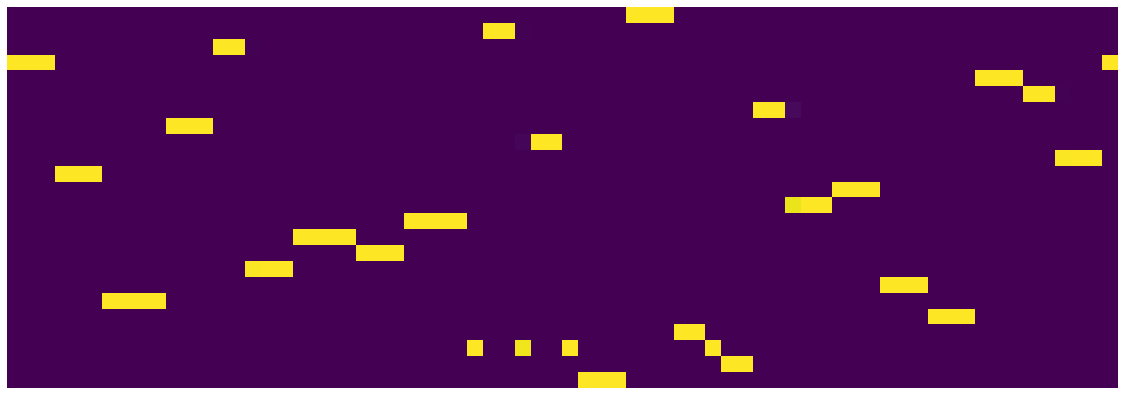

24 468 0.5309999999999996 0.47930300515145063


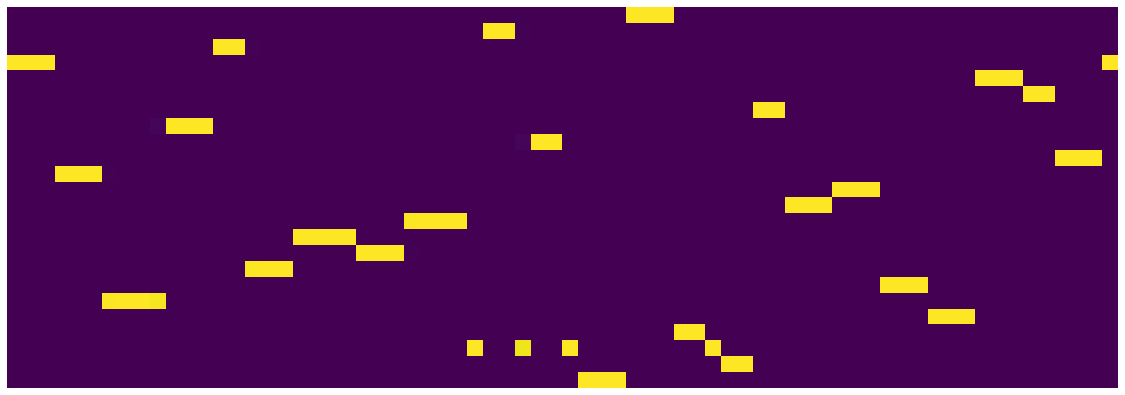

24 469 0.5299999999999996 0.47769551277160643


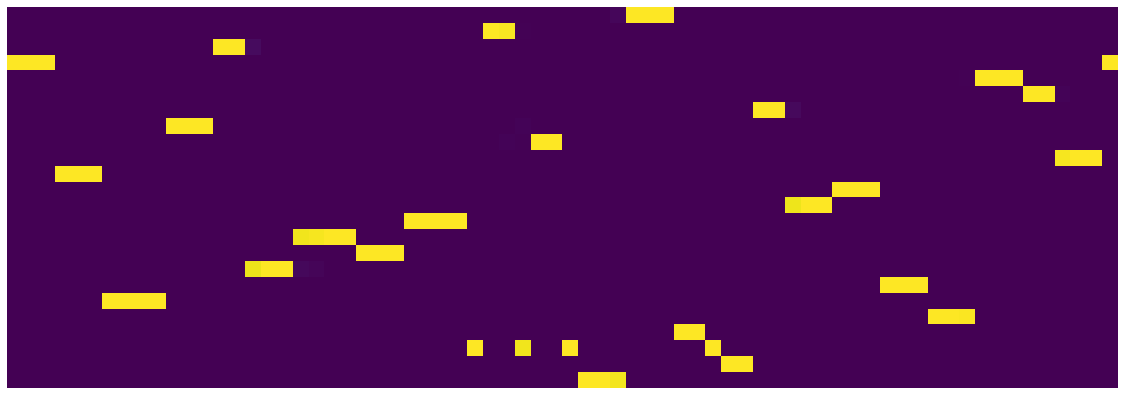

24 470 0.5289999999999996 0.4763262948021293


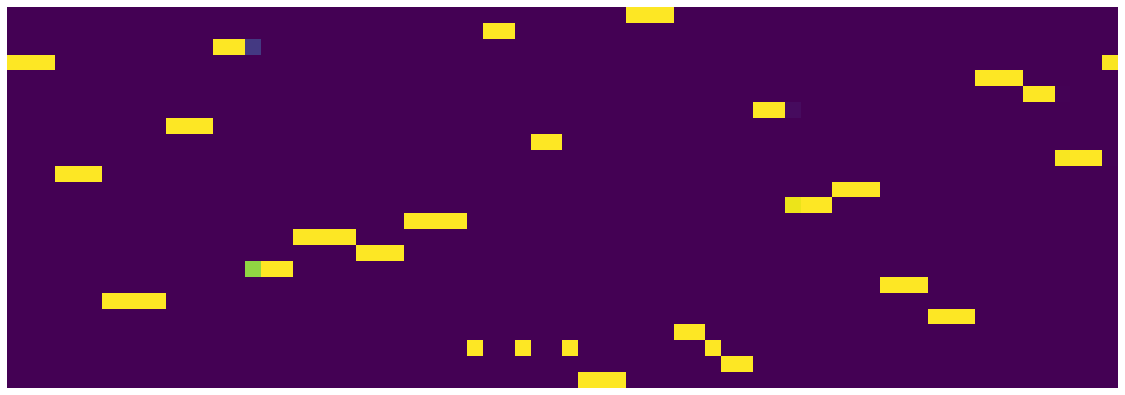

24 471 0.5279999999999996 0.4779735192656517


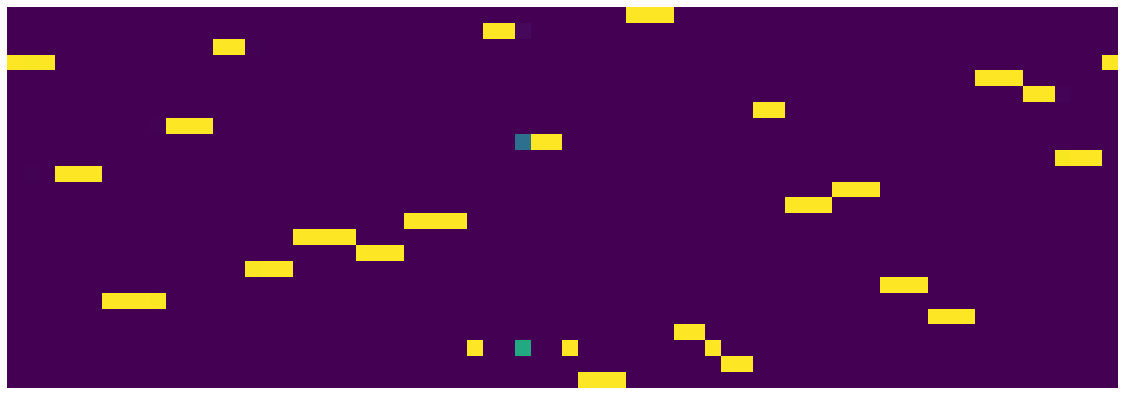

24 472 0.5269999999999996 0.477776463329792


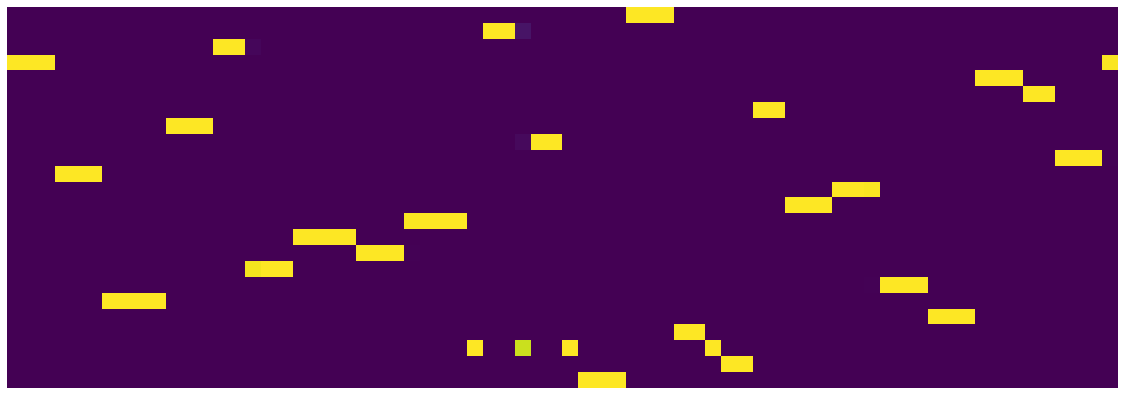

24 473 0.5259999999999996 0.4758704394102097


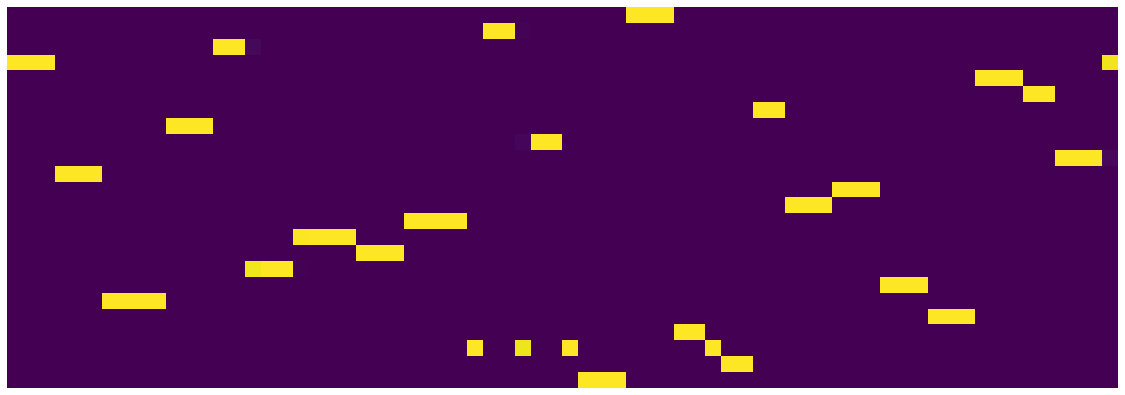

24 474 0.5249999999999996 0.47651649359613657


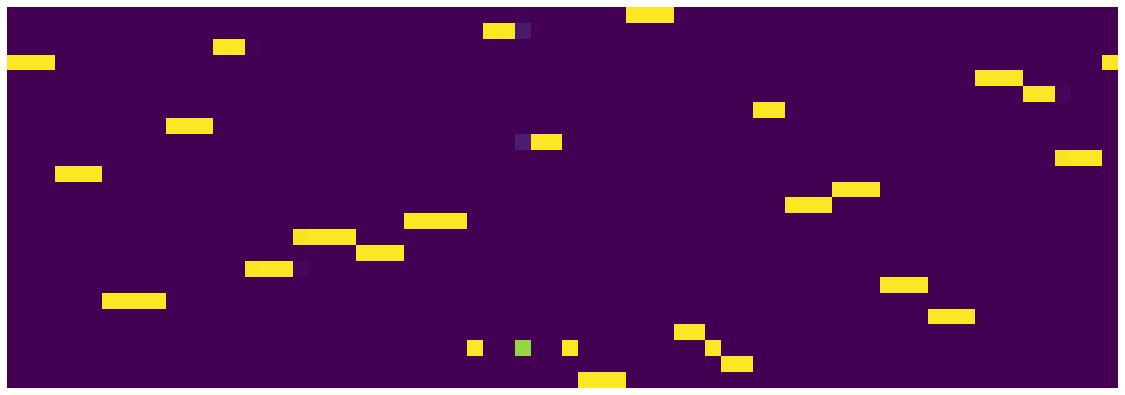

24 475 0.5239999999999996 0.4758918916806579


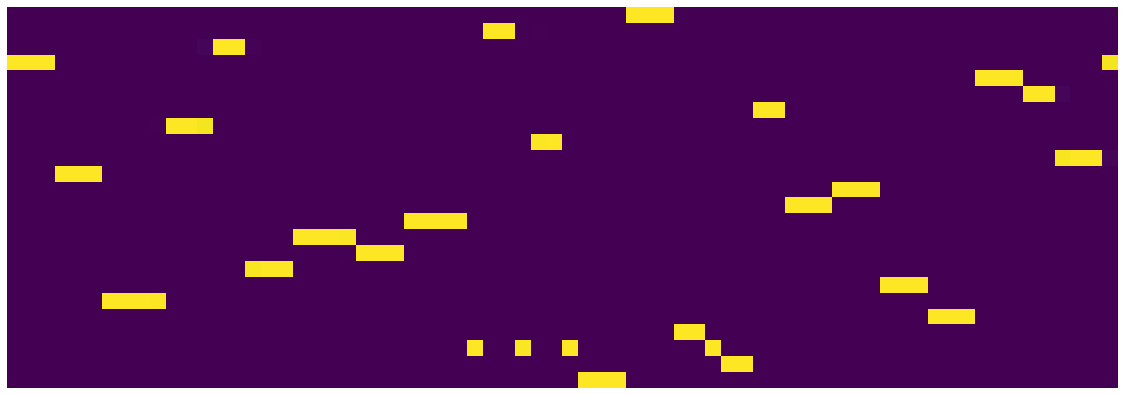

24 476 0.5229999999999996 0.475985549017787


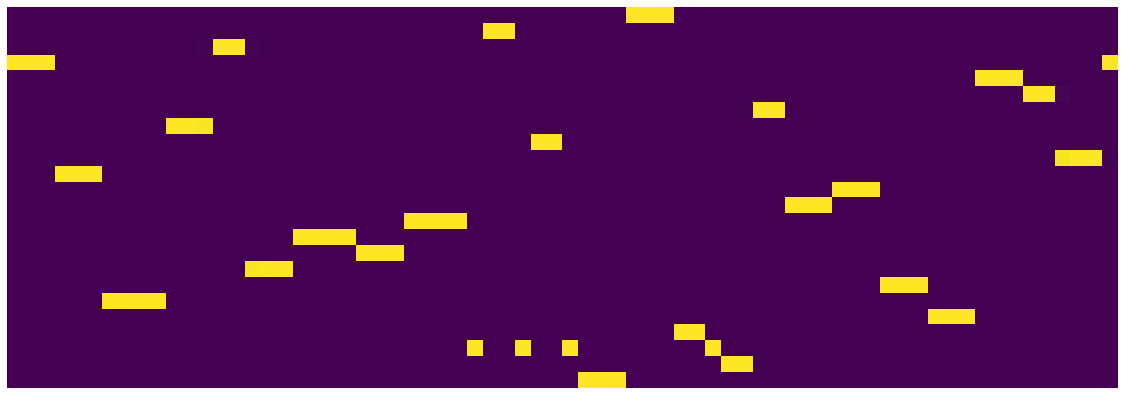

24 477 0.5219999999999996 0.4763282397761941


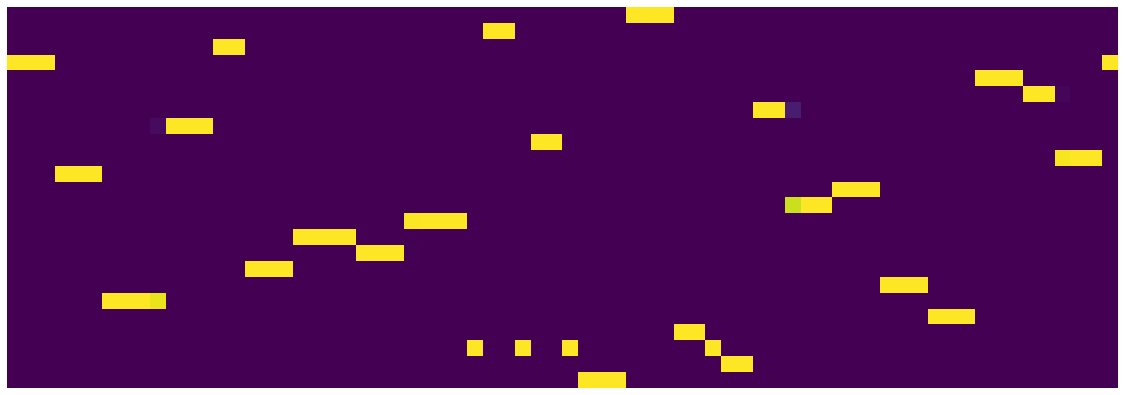

24 478 0.5209999999999996 0.47634425312280654


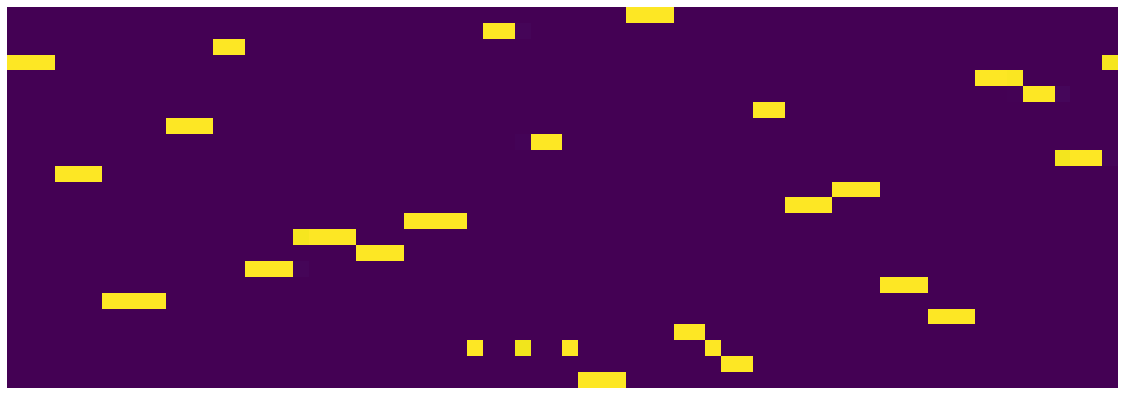

24 479 0.5199999999999996 0.4759409960359335


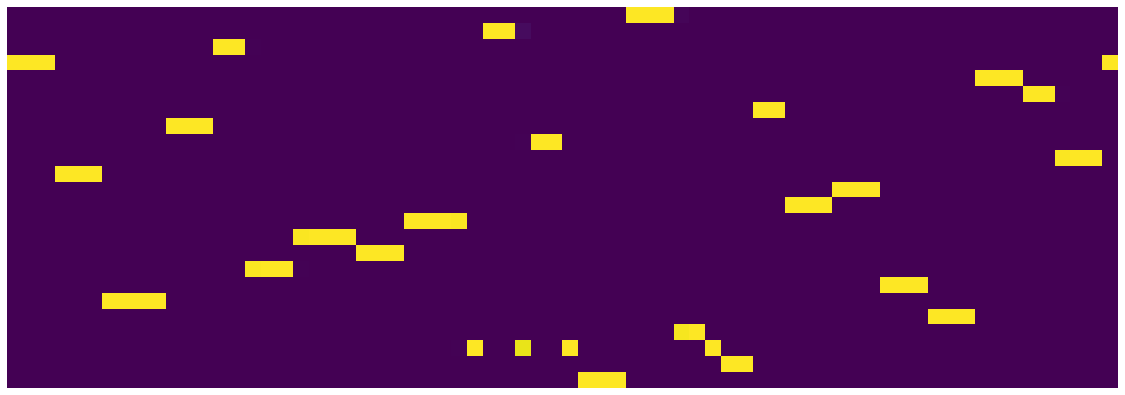

24 480 0.5189999999999996 0.4762820564210415


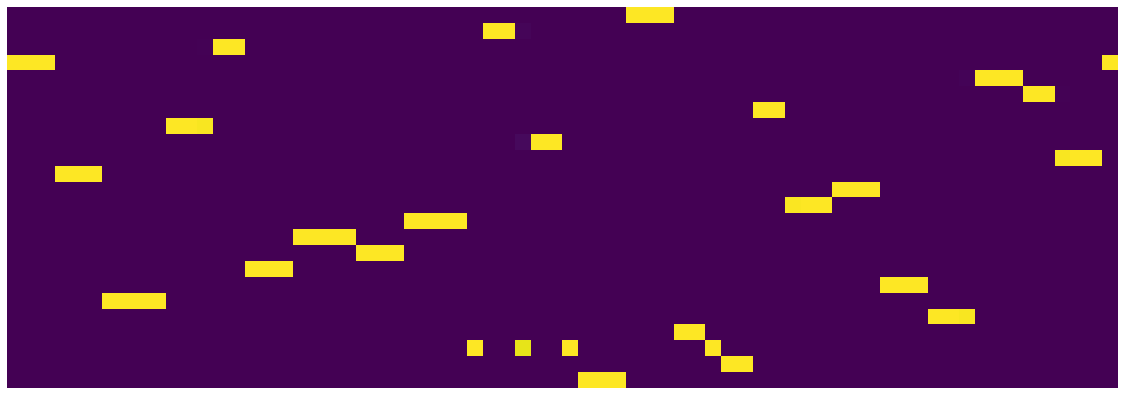

24 481 0.5179999999999996 0.47633947562426326


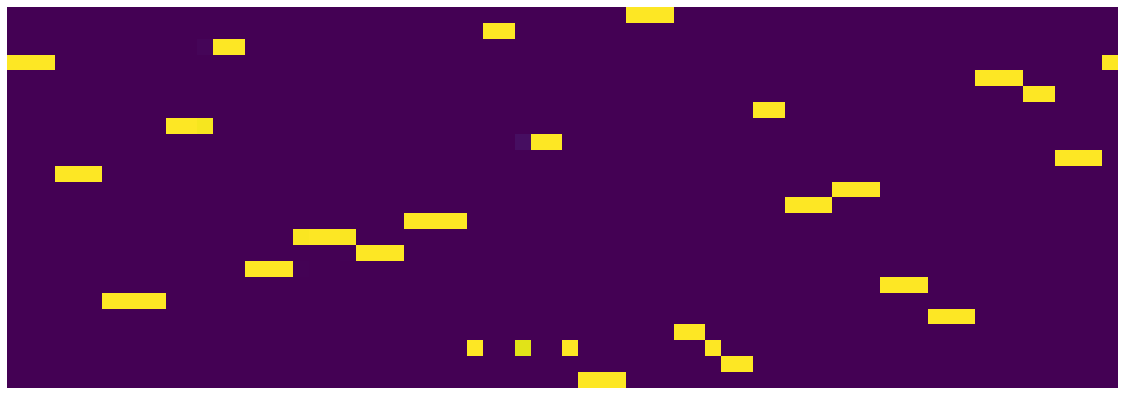

24 482 0.5169999999999996 0.47695016879588364


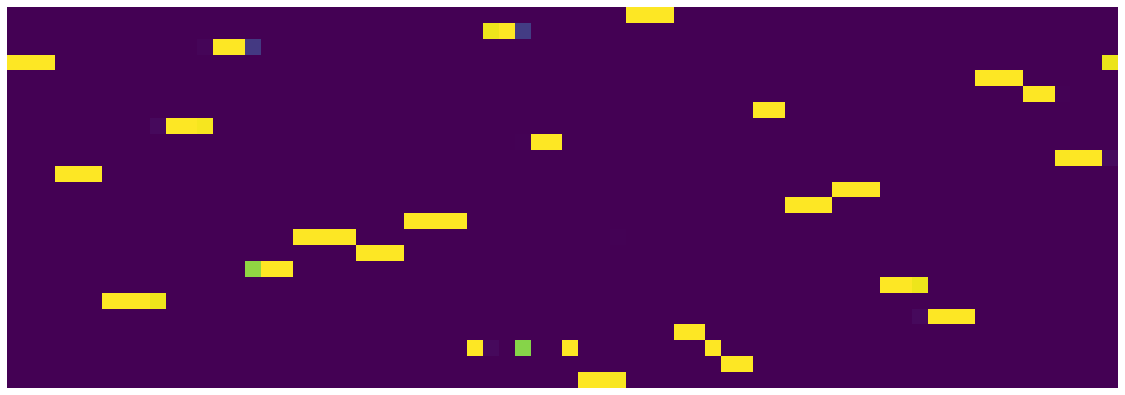

24 483 0.5159999999999996 0.4772216647863388


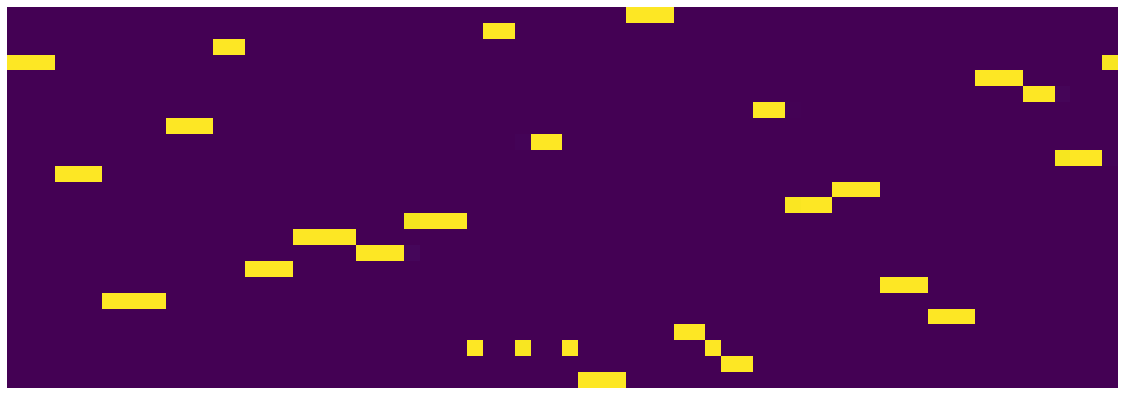

24 484 0.5149999999999996 0.477005778811872


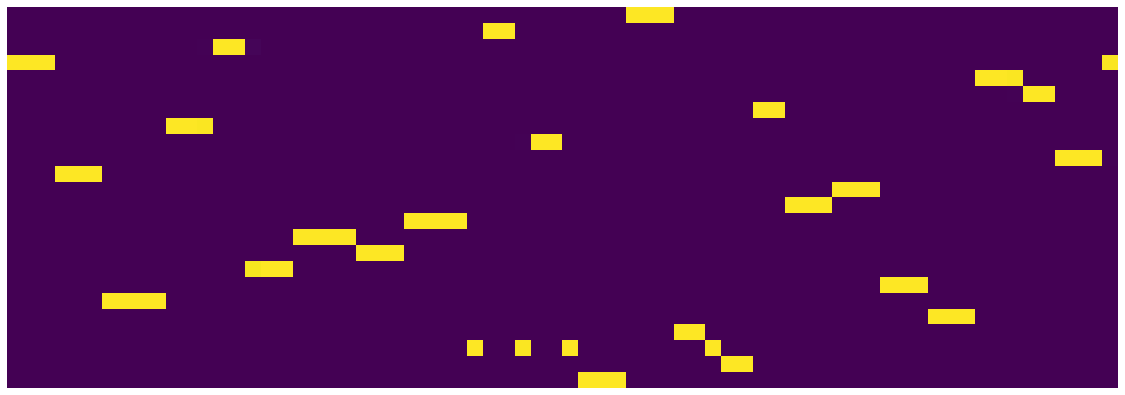

24 485 0.5139999999999996 0.47683520428836346


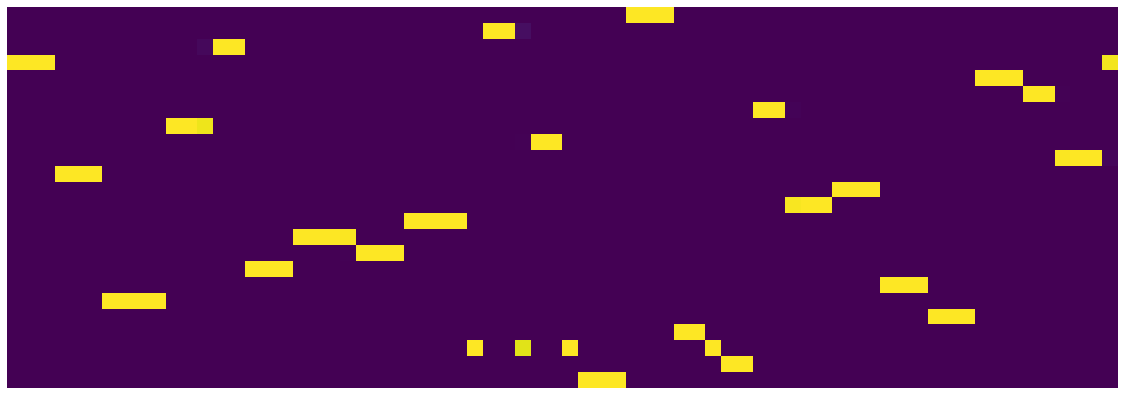

24 486 0.5129999999999996 0.4771570859476924


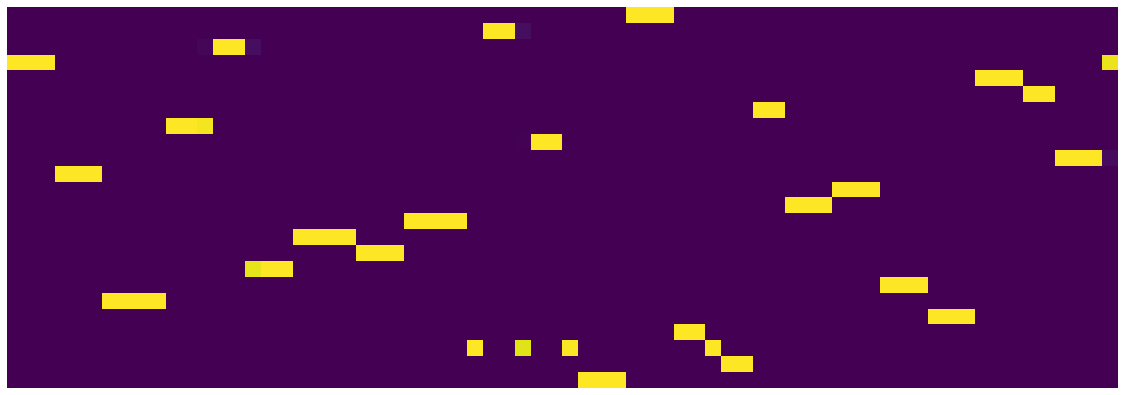

24 487 0.5119999999999996 0.47688676957041026


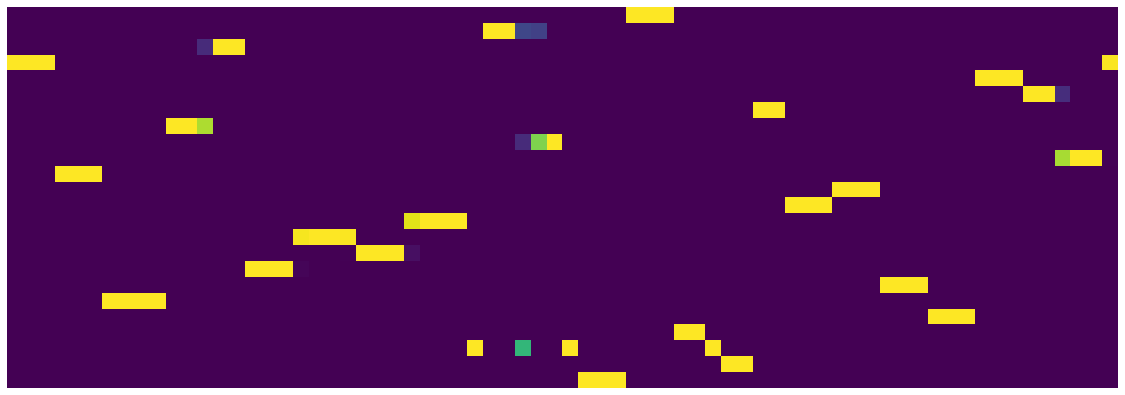

24 488 0.5109999999999996 0.4763480084016919


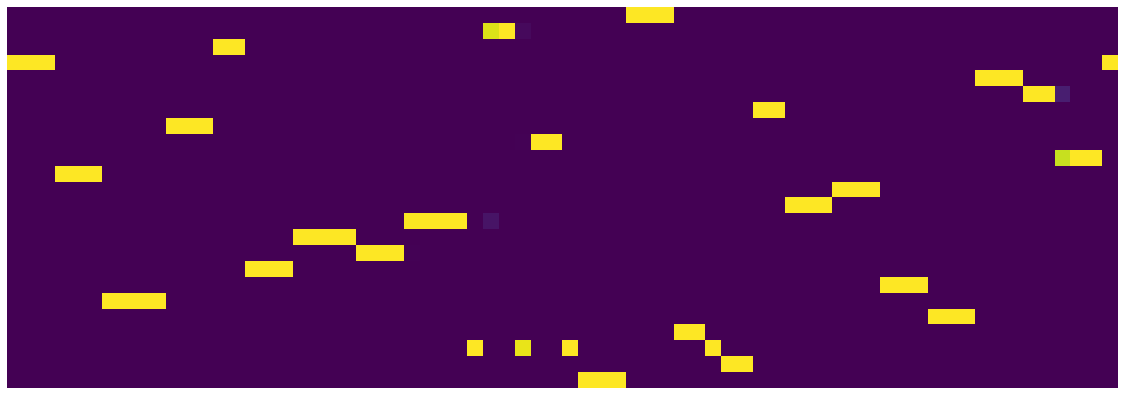

24 489 0.5099999999999996 0.47734993752092125


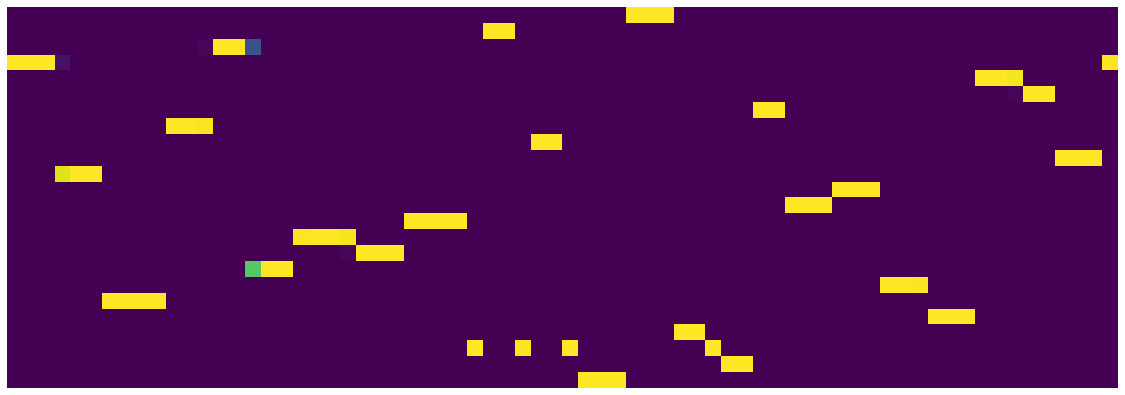

24 490 0.5089999999999996 0.478173434920609


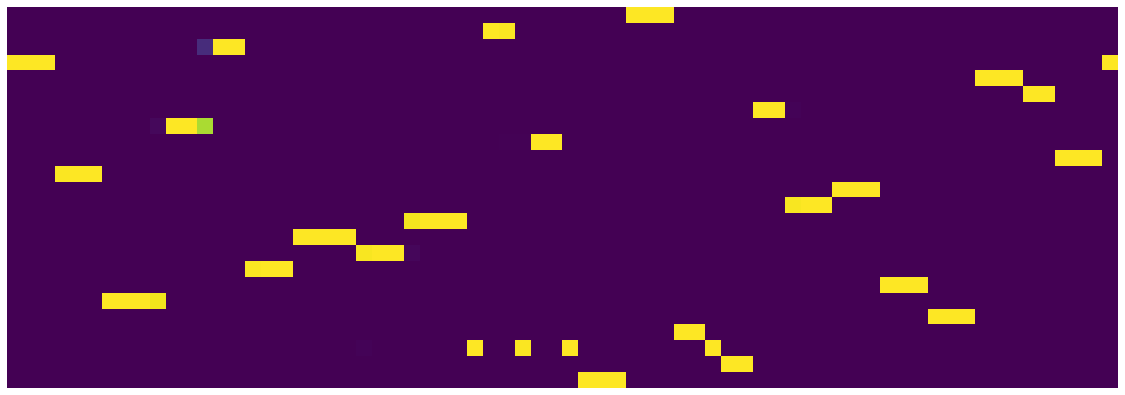

24 491 0.5079999999999996 0.47585171218961475


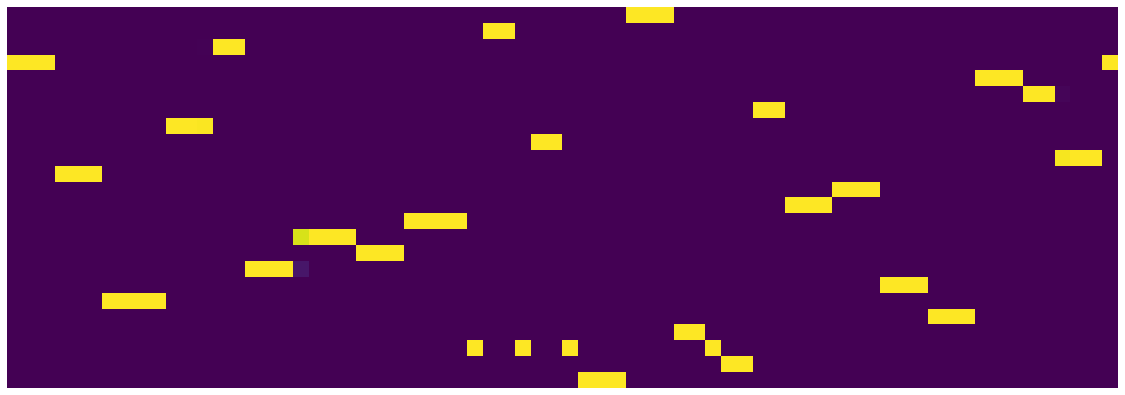

24 492 0.5069999999999996 0.4763567205518484


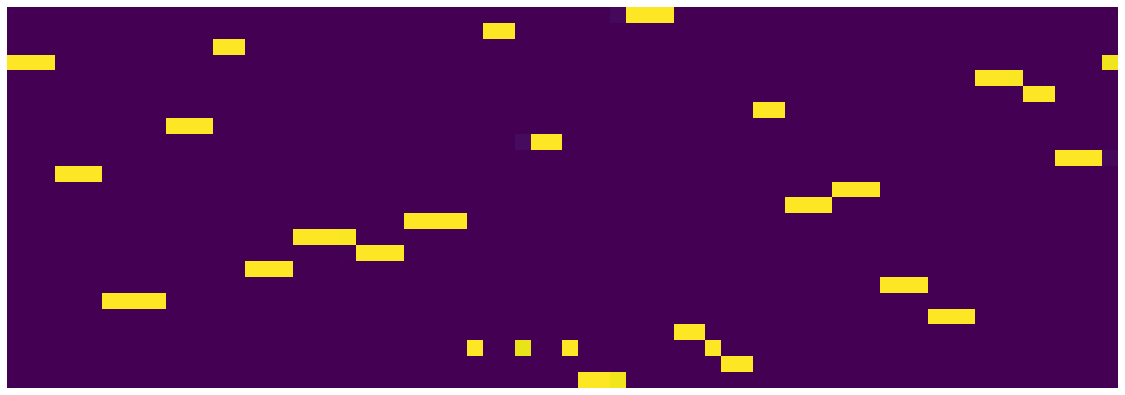

24 493 0.5059999999999996 0.47699228264391424


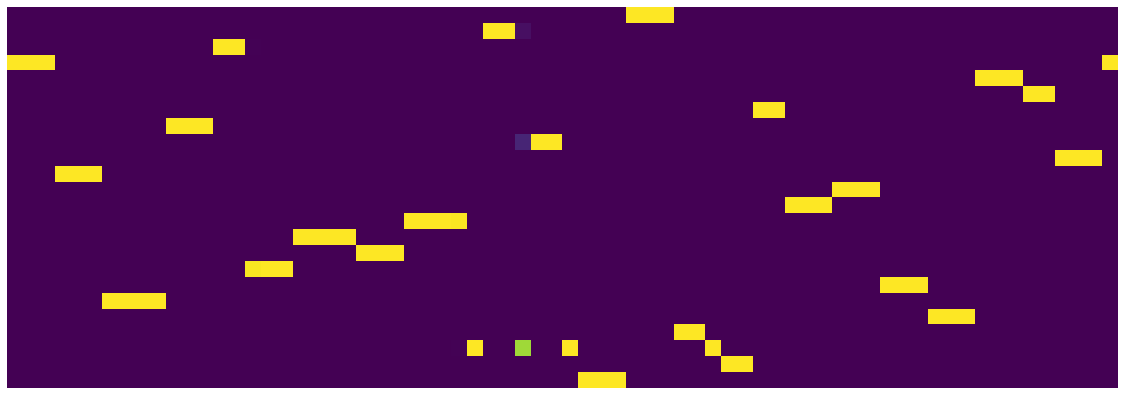

24 494 0.5049999999999996 0.47586286924779414


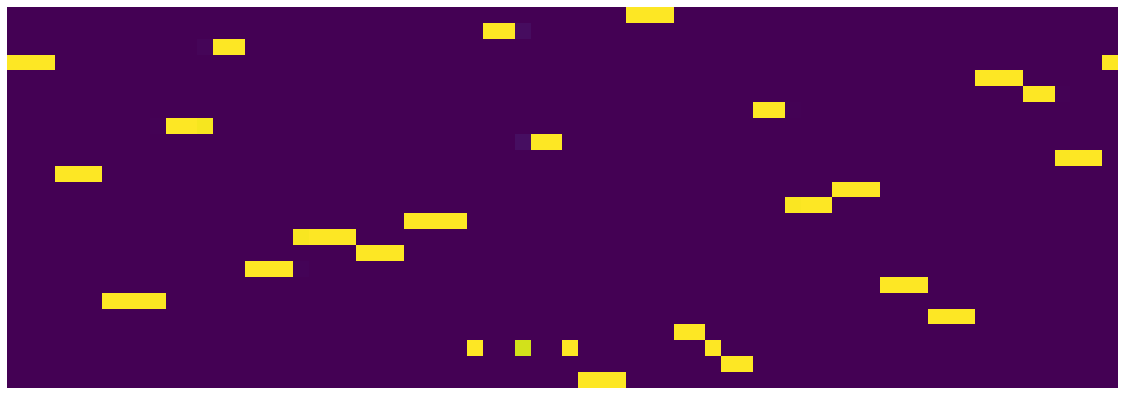

24 495 0.5039999999999996 0.4777400381863117


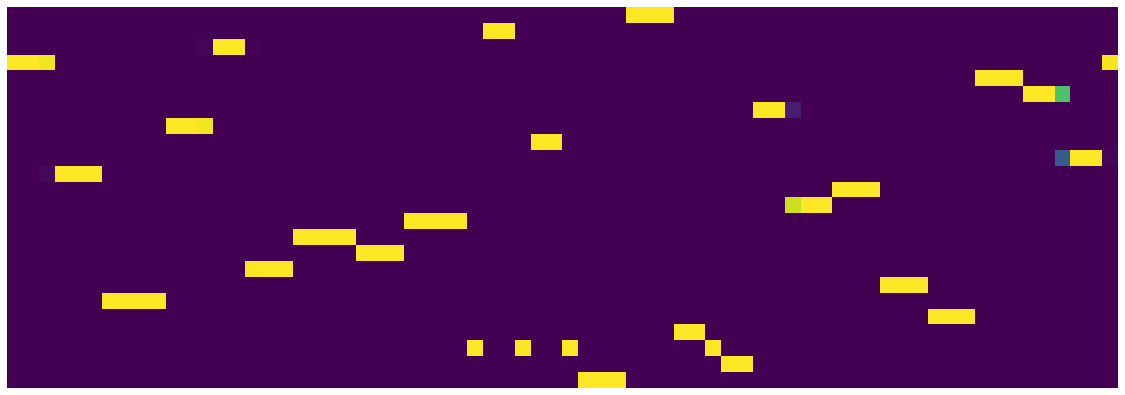

24 496 0.5029999999999996 0.47703808583319185


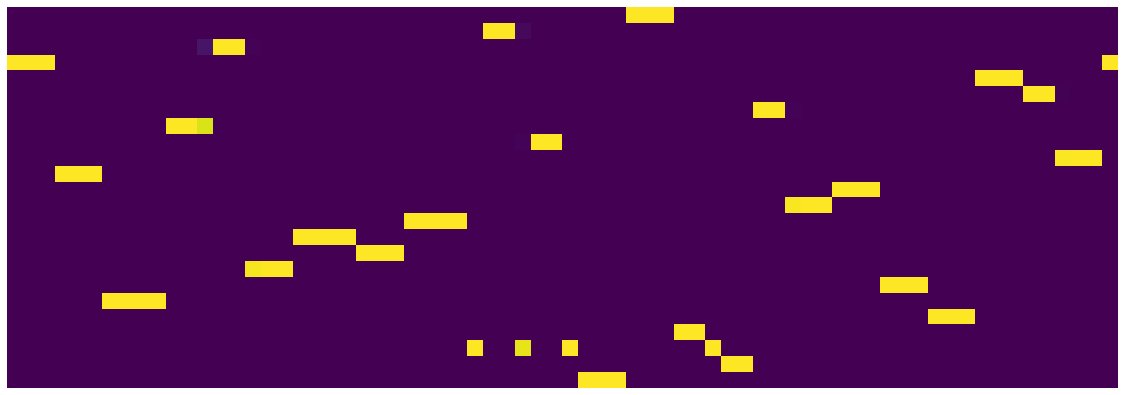

24 497 0.5019999999999996 0.47617203984409573


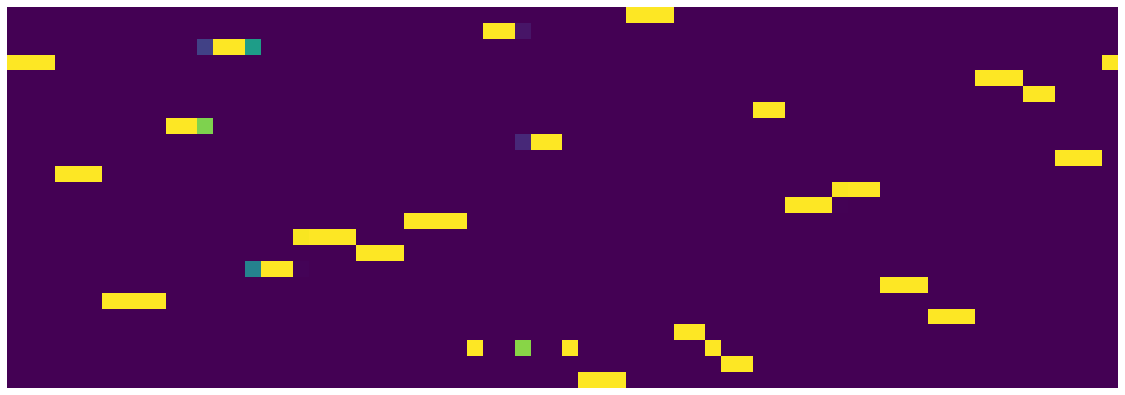

24 498 0.5009999999999996 0.47907090969383714


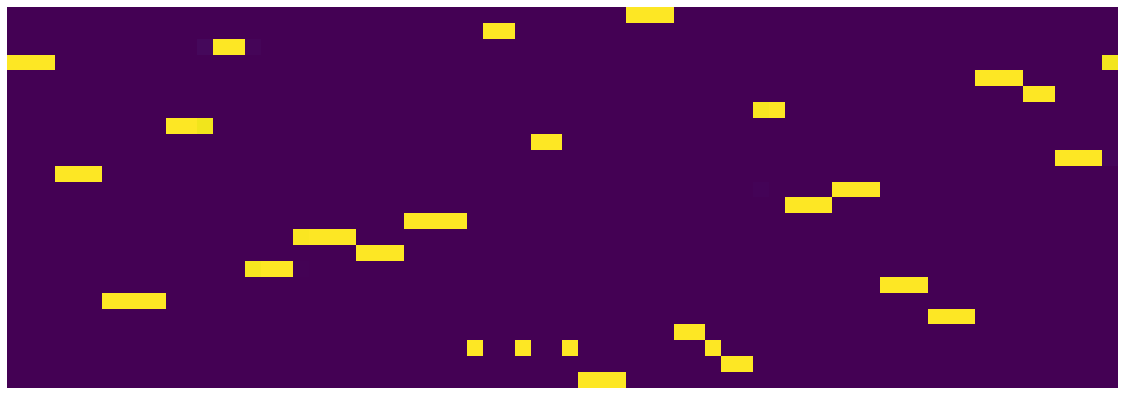

24 499 0.49999999999999956 0.4771062219515443


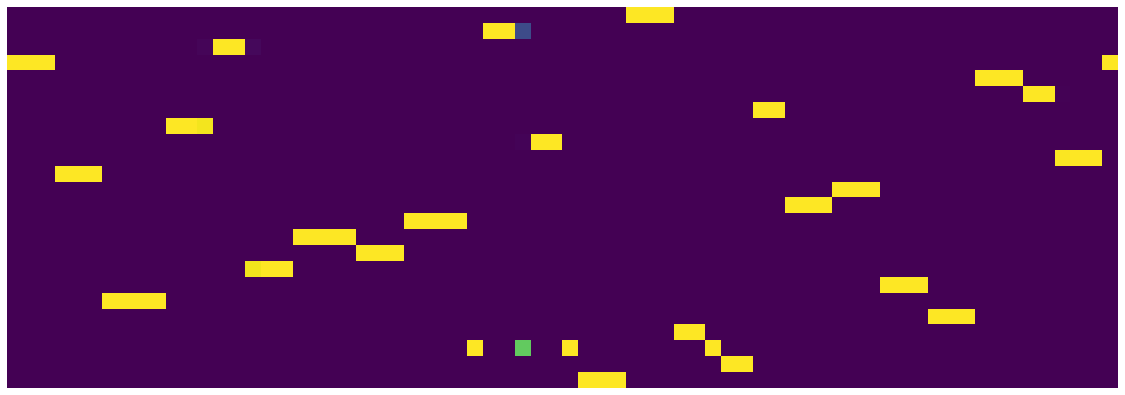

24 500 0.49899999999999956 0.4764138203114271


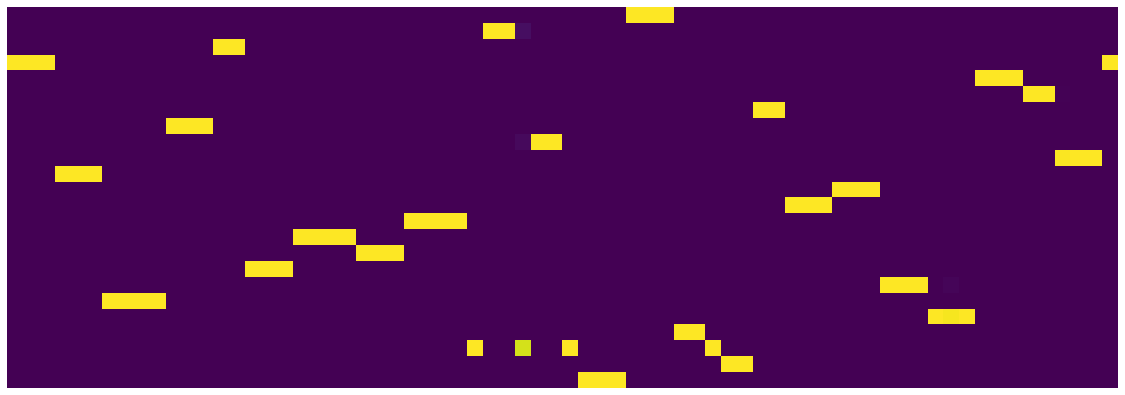

24 501 0.49799999999999955 0.47626972794532774


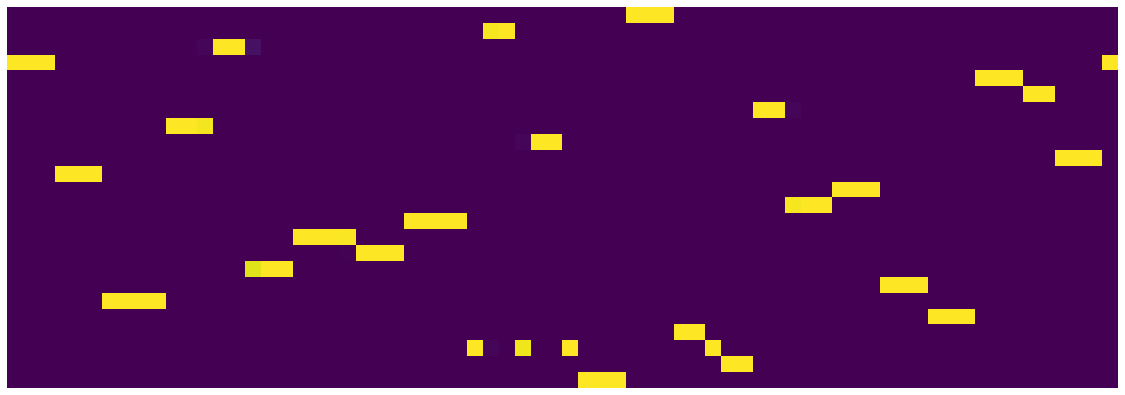

24 502 0.49699999999999955 0.476882791519165


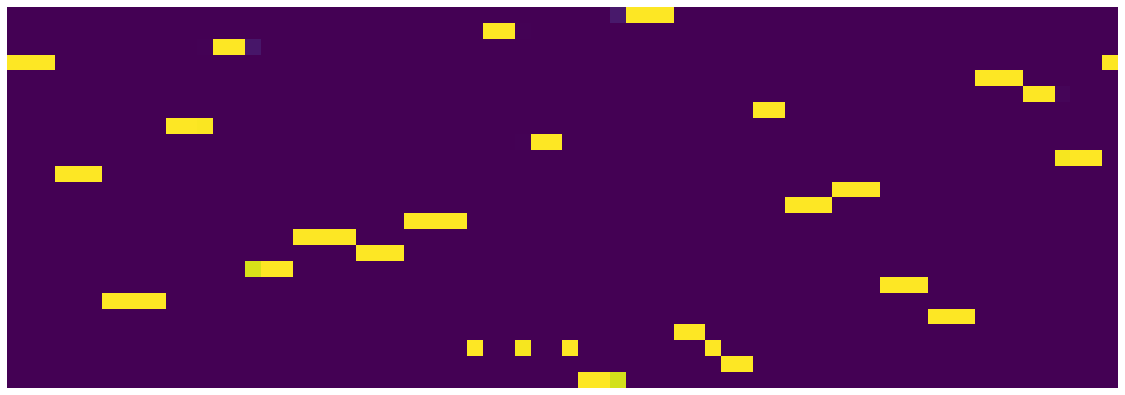

24 503 0.49599999999999955 0.4765015995129943


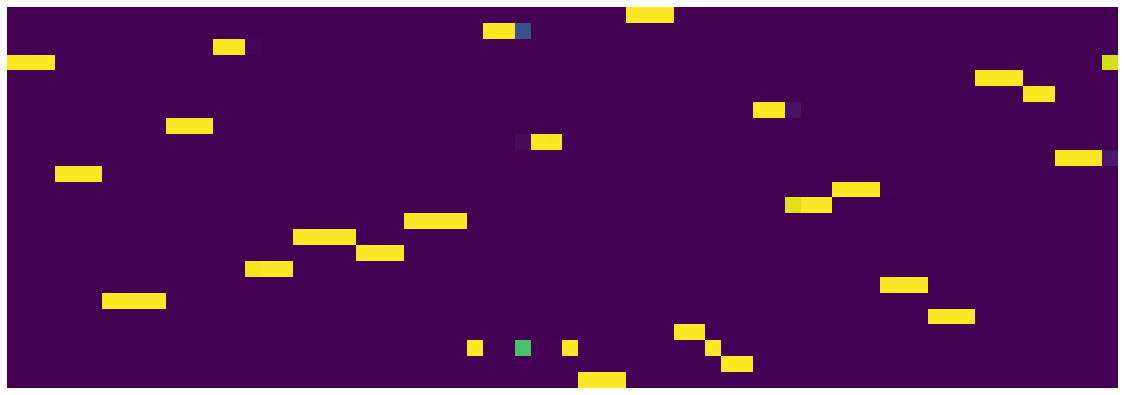

24 504 0.49499999999999955 0.47702727783471344


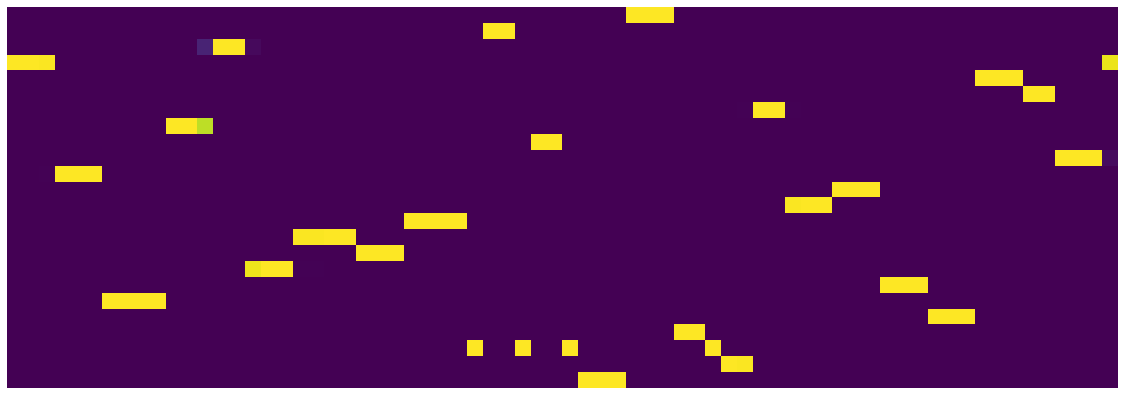

24 505 0.49399999999999955 0.4777689576148987


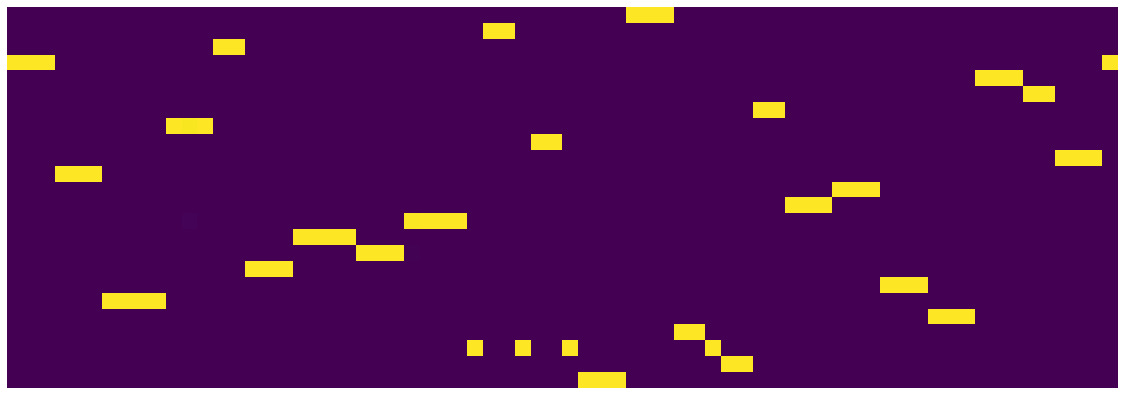

24 506 0.49299999999999955 0.47605656310915945


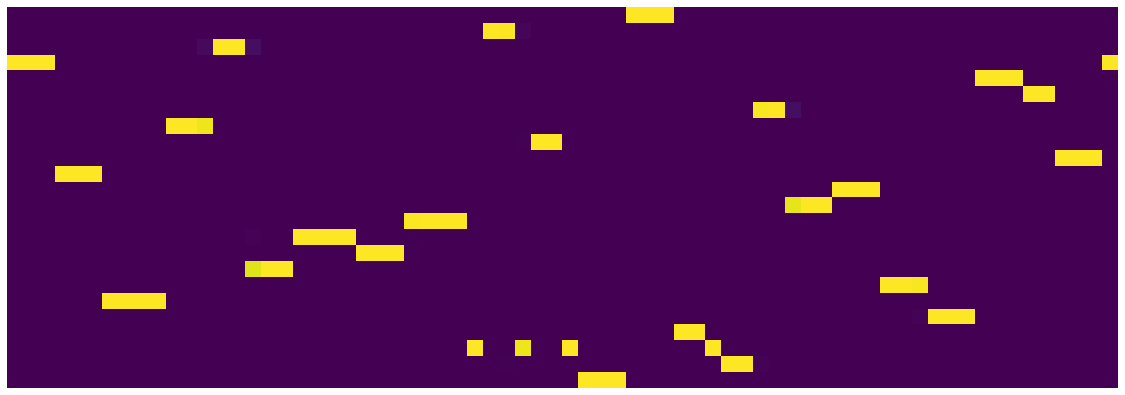

24 507 0.49199999999999955 0.475419283285737


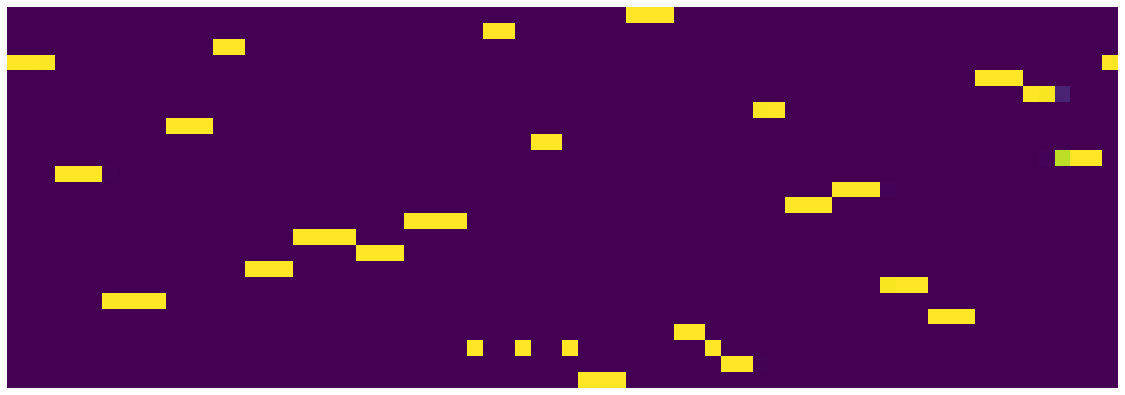

24 508 0.49099999999999955 0.4772774463519454


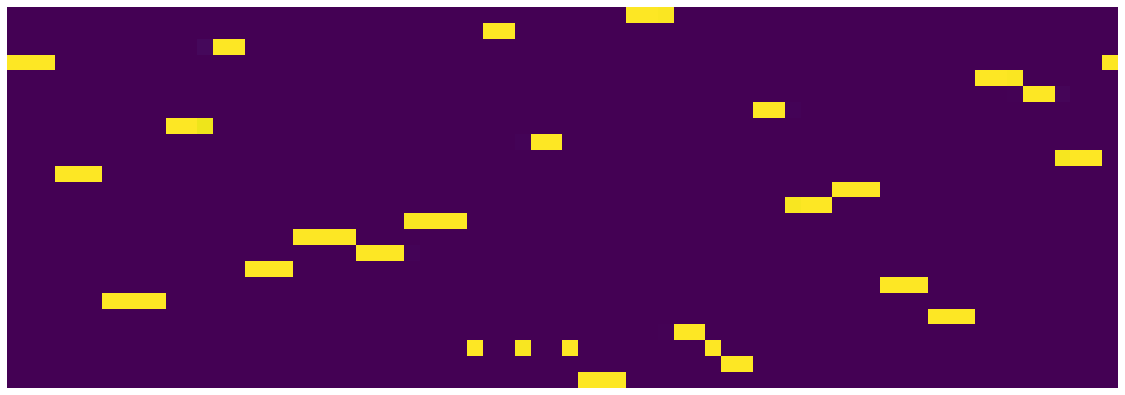

24 509 0.48999999999999955 0.47546593882143495


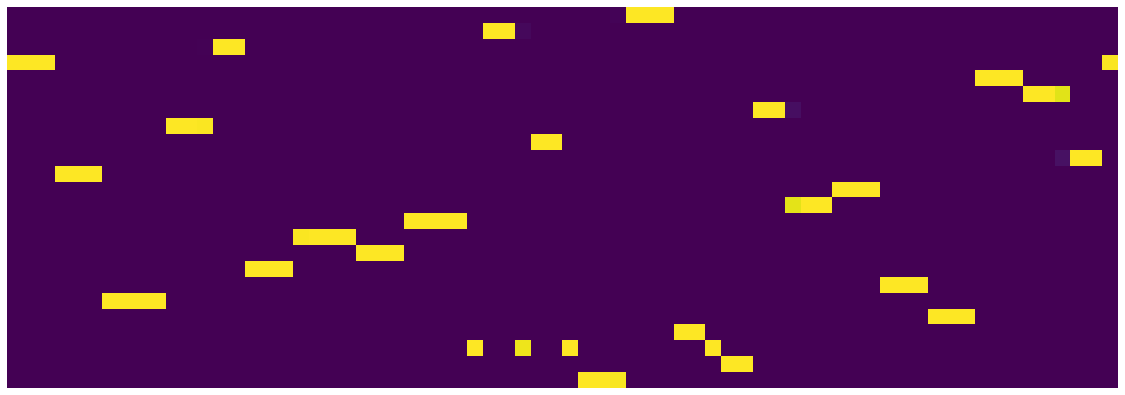

24 510 0.48899999999999955 0.4776880545541644


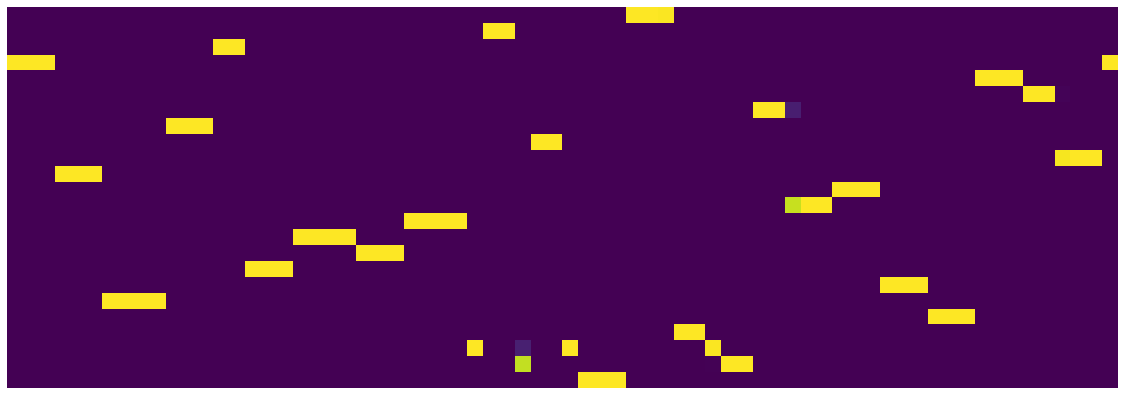

24 511 0.48799999999999955 0.4776724925264716


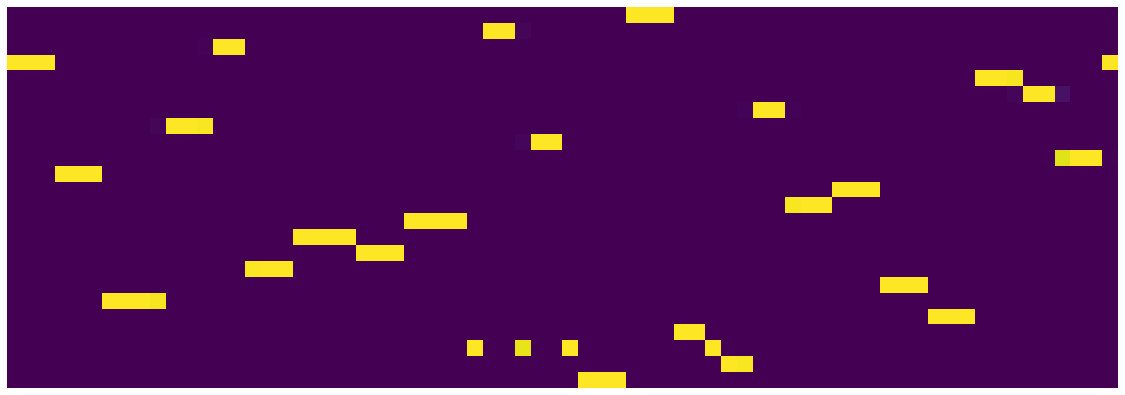

24 512 0.48699999999999954 0.47766703404486177


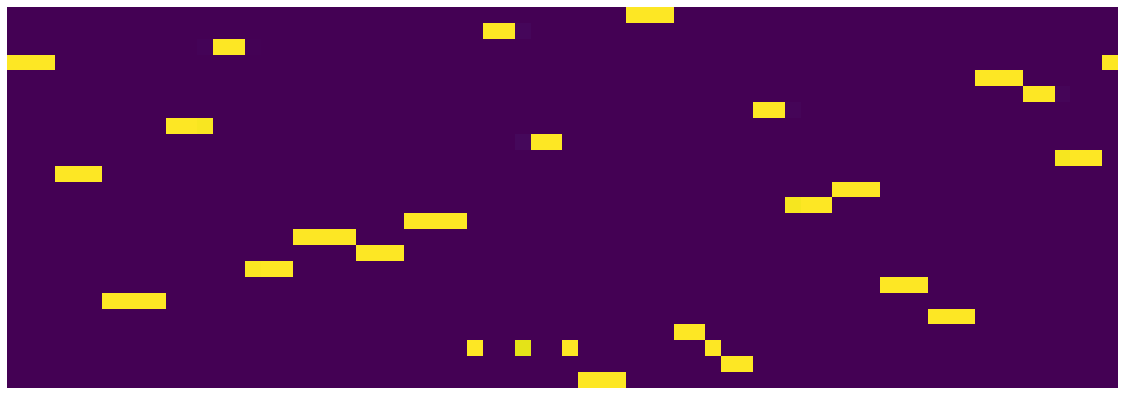

24 513 0.48599999999999954 0.4768330631777644


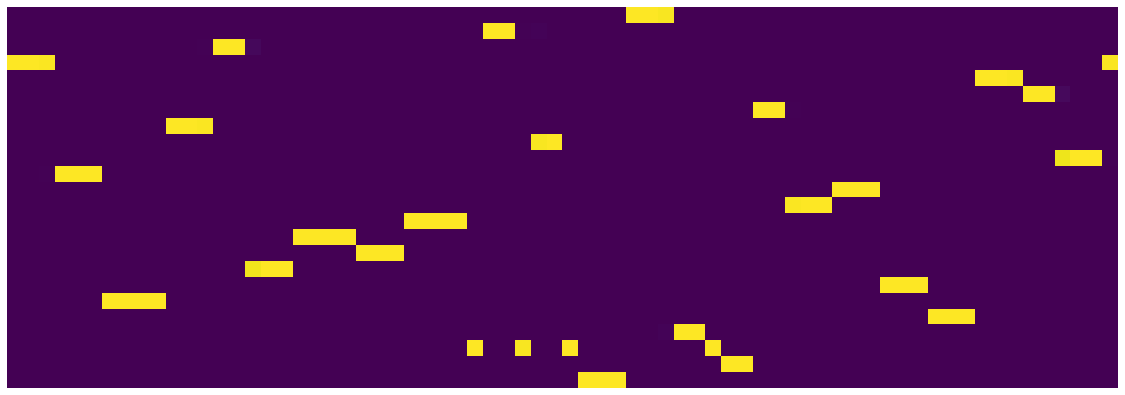

24 514 0.48499999999999954 0.4767861669883132


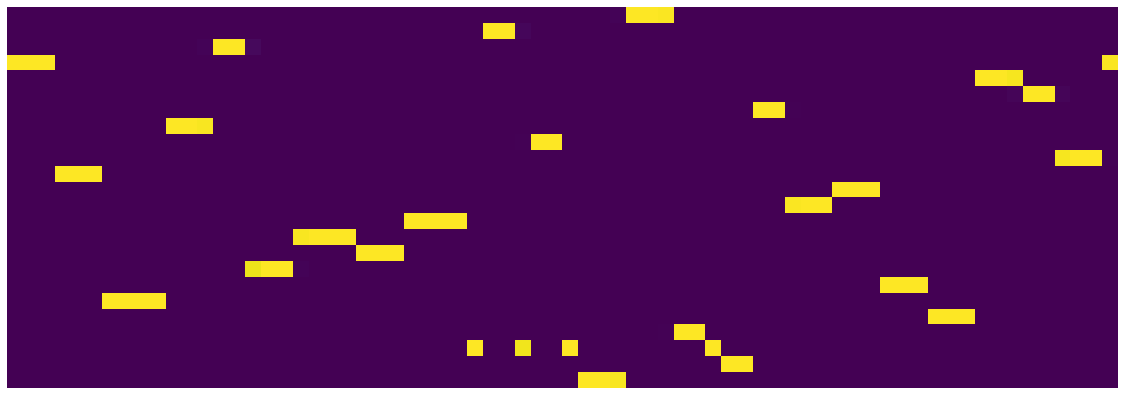

24 515 0.48399999999999954 0.4763944450765848


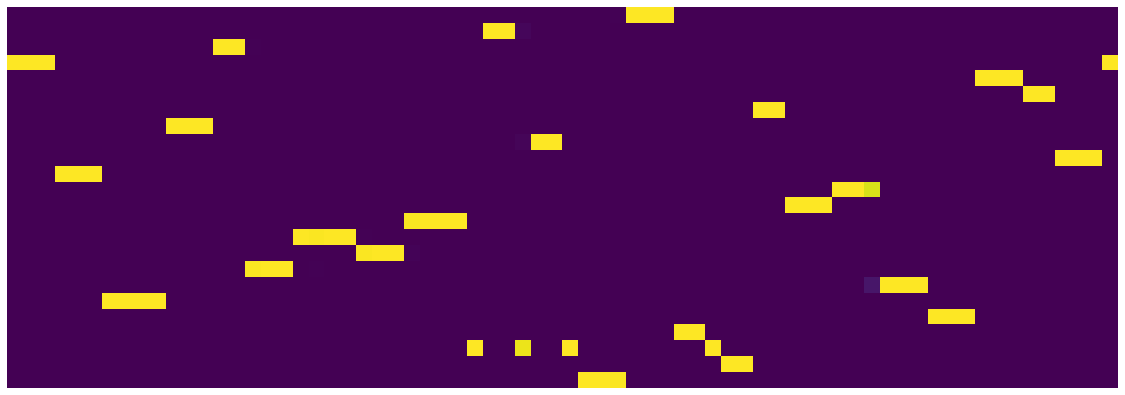

24 516 0.48299999999999954 0.4764605326578021


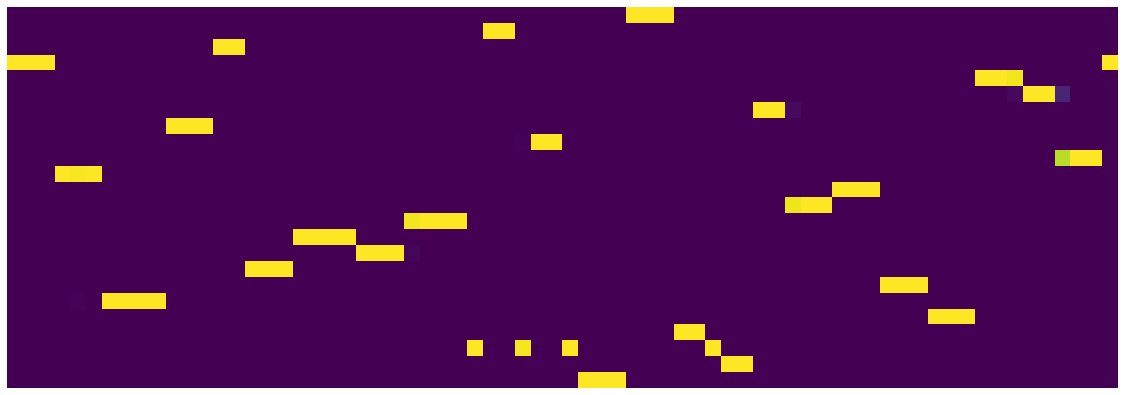

24 517 0.48199999999999954 0.4767710756510496


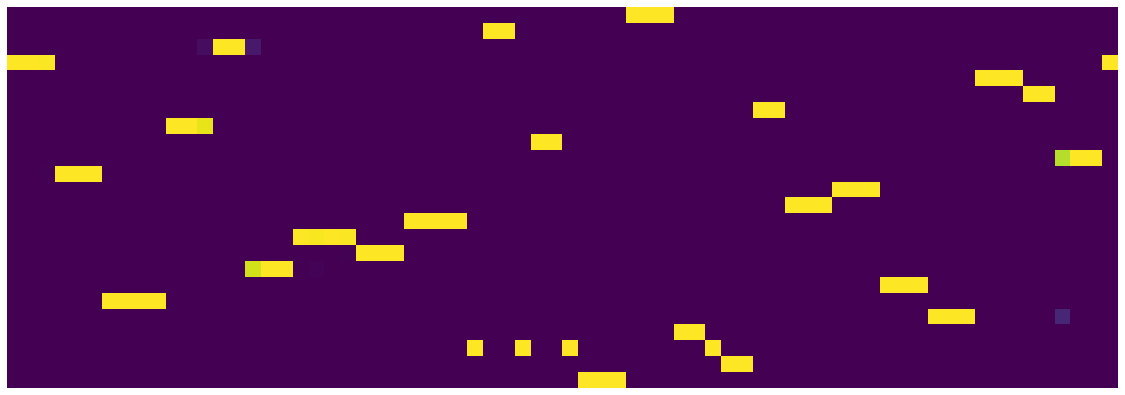

24 518 0.48099999999999954 0.47716585248708726


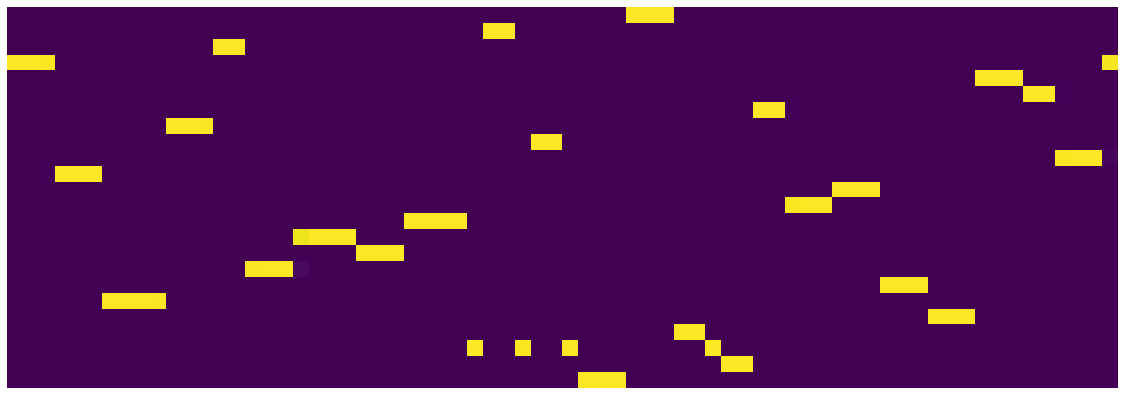

24 519 0.47999999999999954 0.47938568629324435


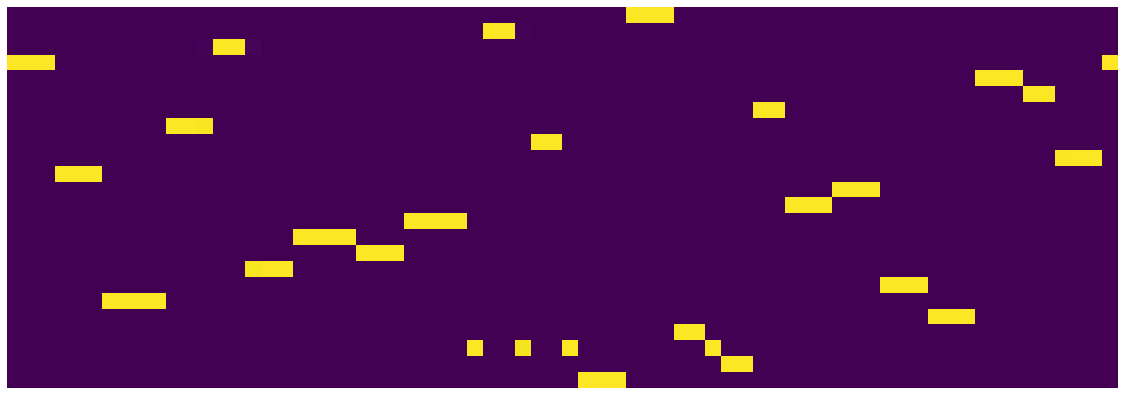

24 520 0.47899999999999954 0.48042444624006747


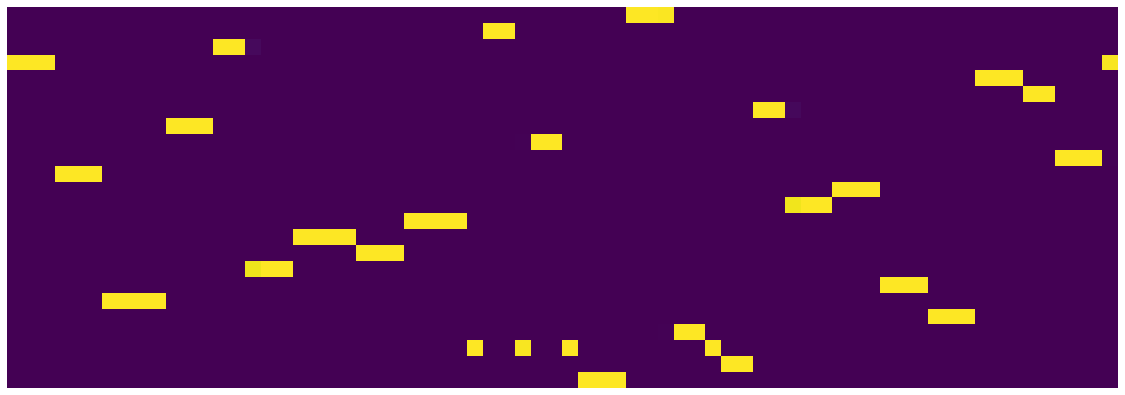

24 521 0.47799999999999954 0.4773579930886626


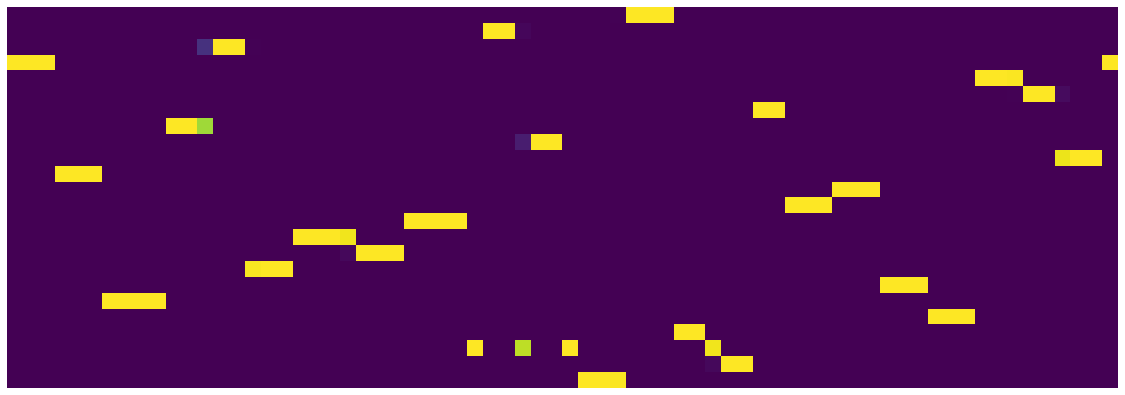

24 522 0.47699999999999954 0.4757835140451789


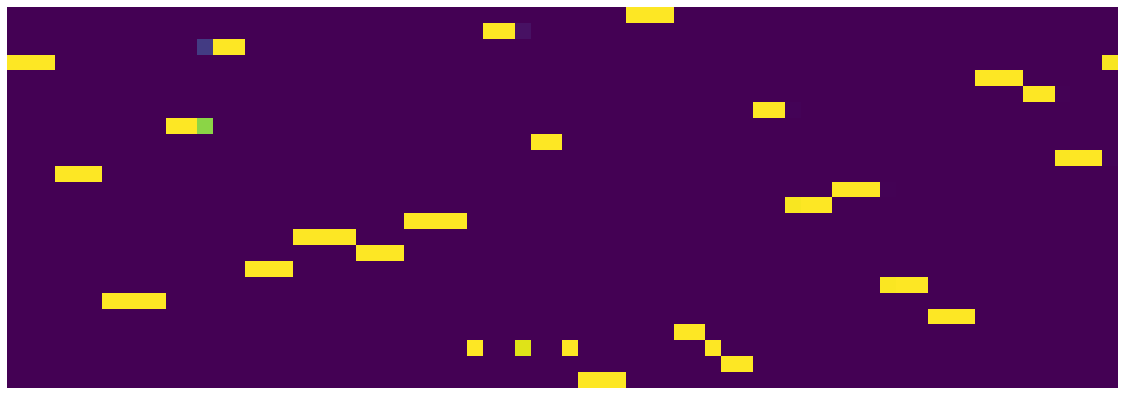

24 523 0.47599999999999953 0.476905482634902


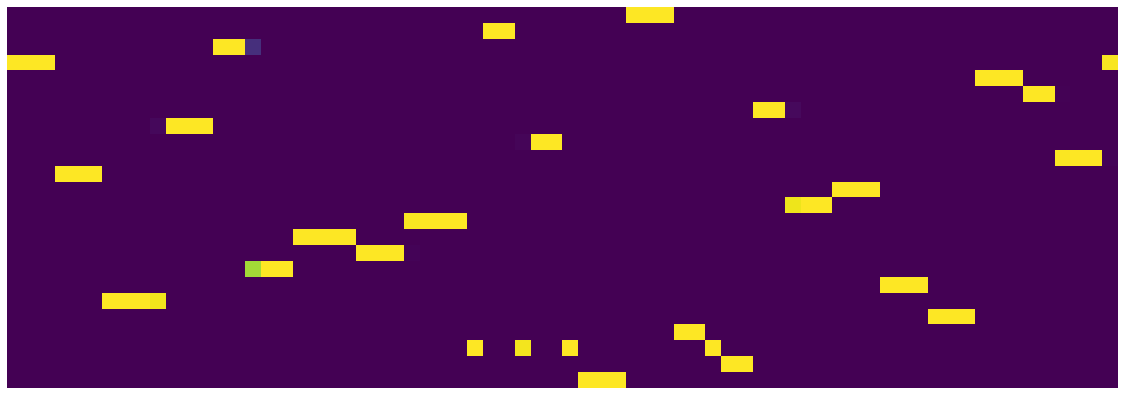

24 524 0.47499999999999953 0.4764773087576032


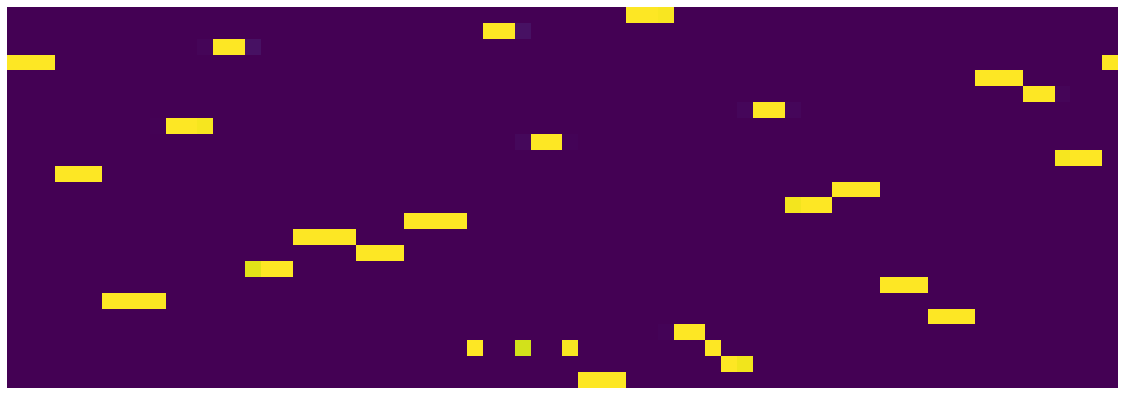

24 525 0.47399999999999953 0.47652655746787786


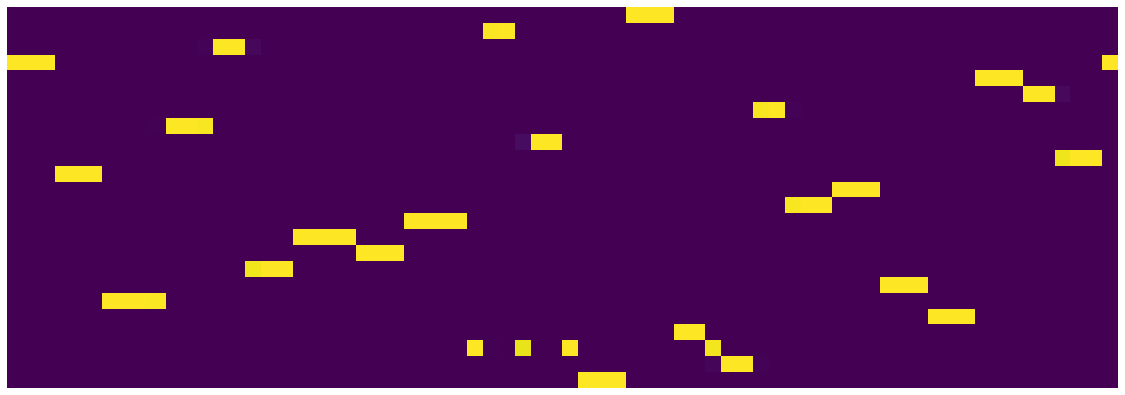

24 526 0.47299999999999953 0.4764141509309411


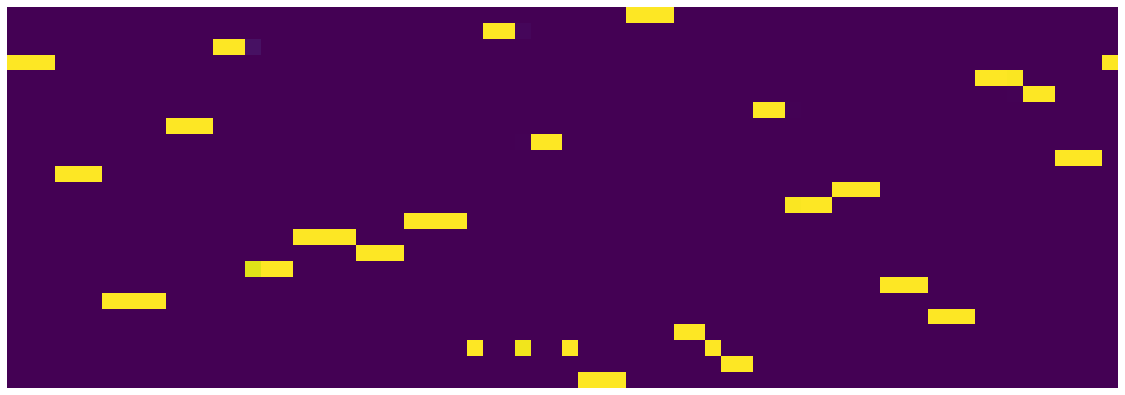

24 527 0.47199999999999953 0.4768296299502254


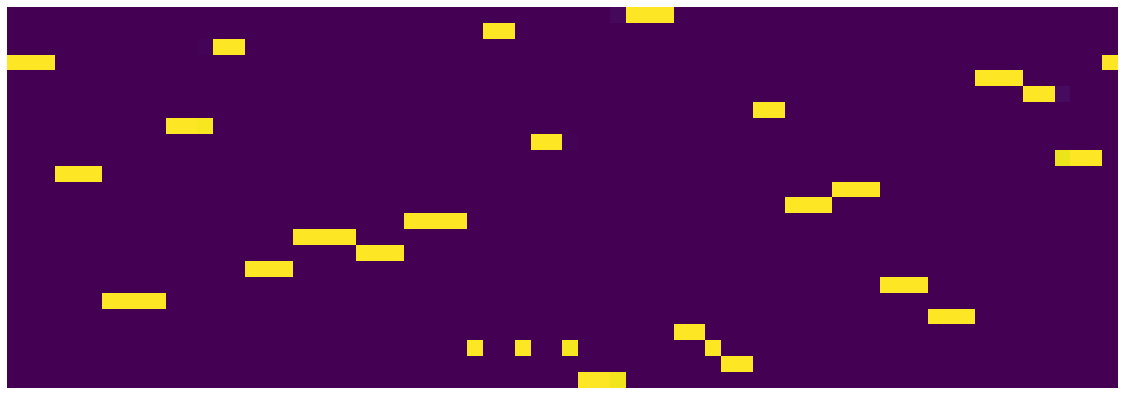

24 528 0.47099999999999953 0.47648645993322136


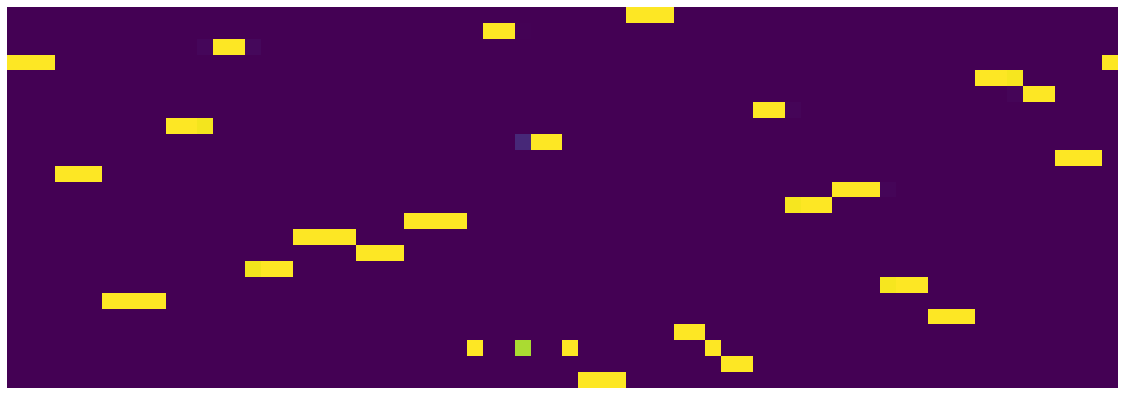

24 529 0.46999999999999953 0.4764452129602432


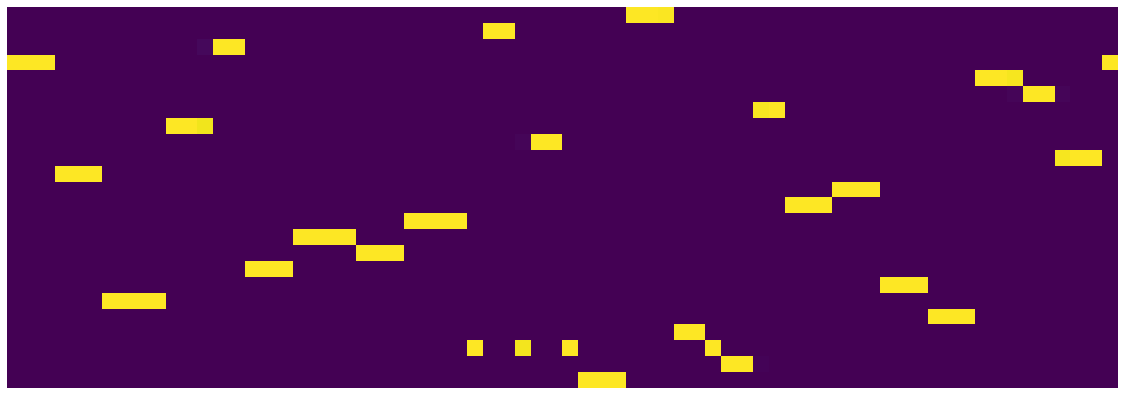

24 530 0.46899999999999953 0.4770639777183533


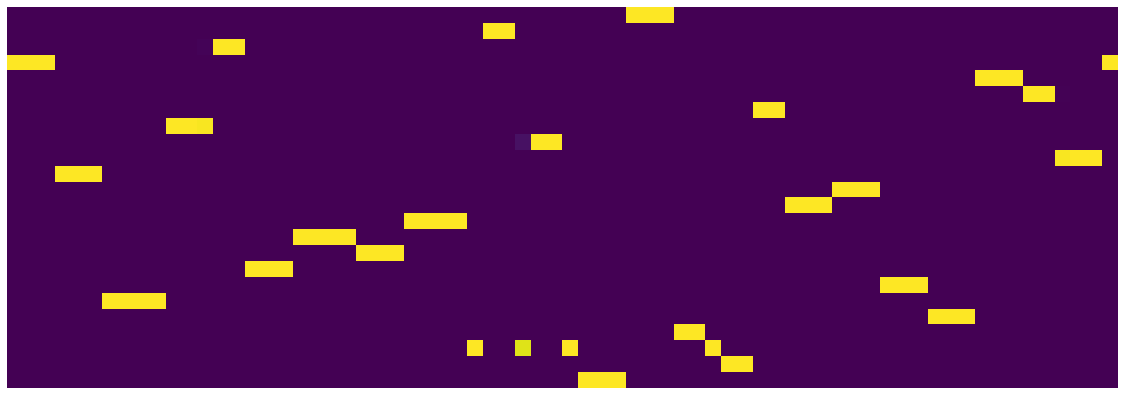

24 531 0.4679999999999995 0.4763116354122758


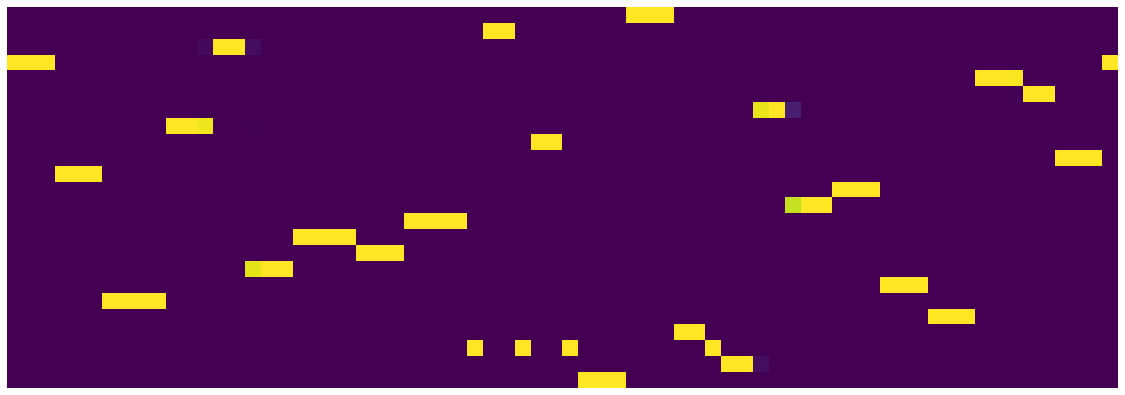

24 532 0.4669999999999995 0.47662954721599815


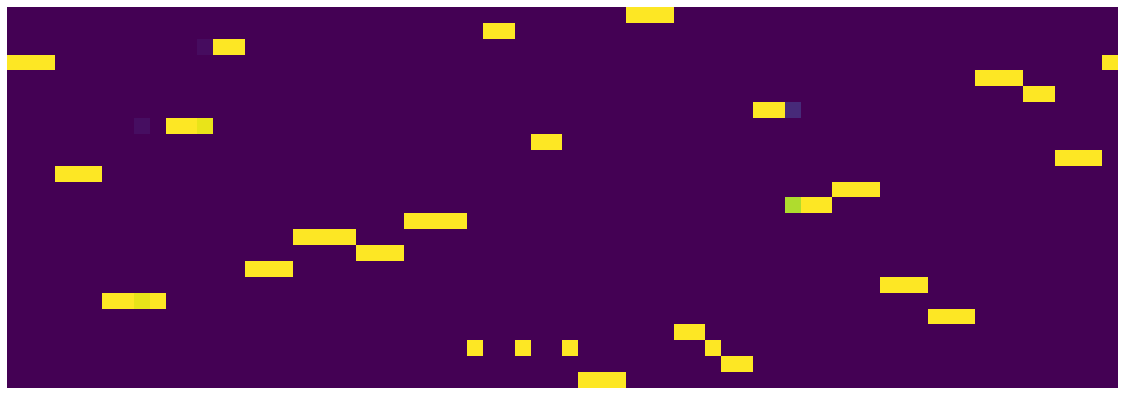

24 533 0.4659999999999995 0.4763991547748446


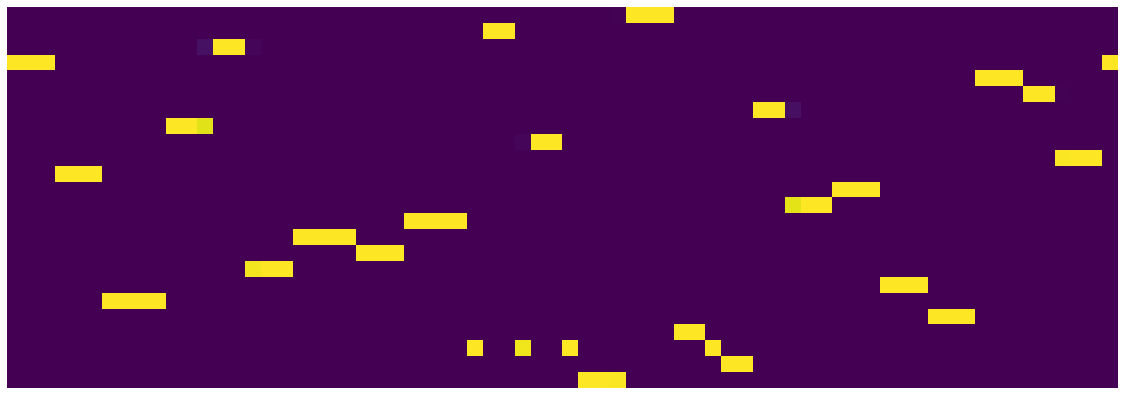

24 534 0.4649999999999995 0.4767943099141121


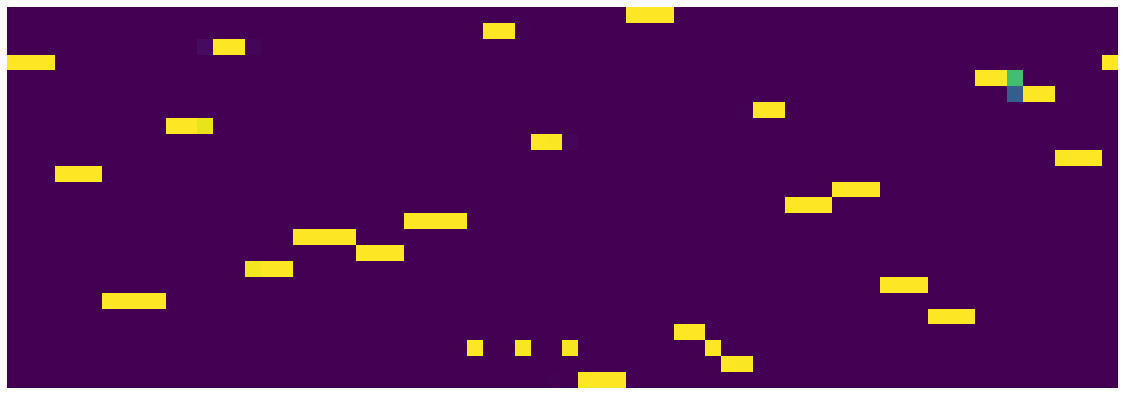

24 535 0.4639999999999995 0.4763133397325873


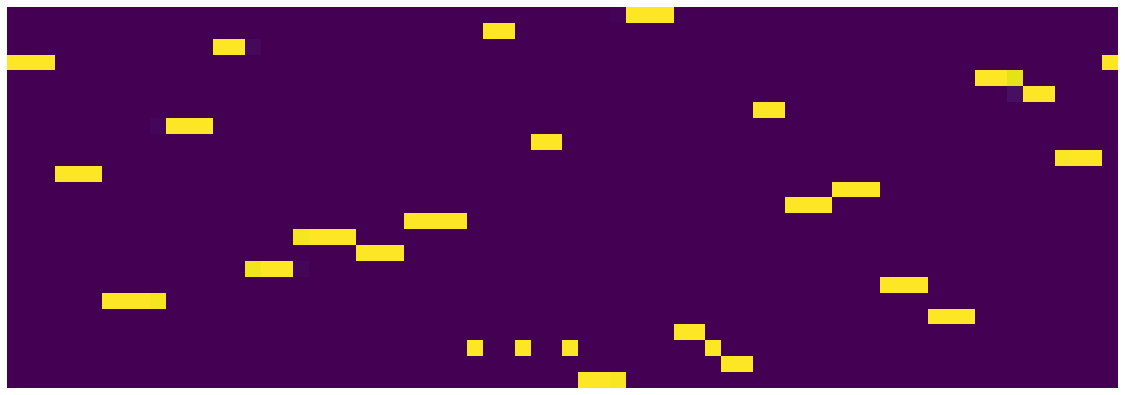

24 536 0.4629999999999995 0.47714957799762486


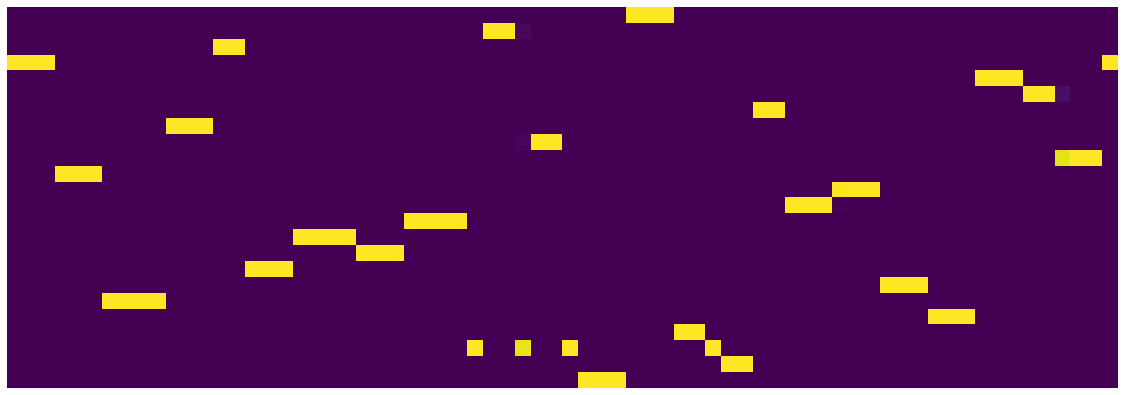

24 537 0.4619999999999995 0.4765128822997212


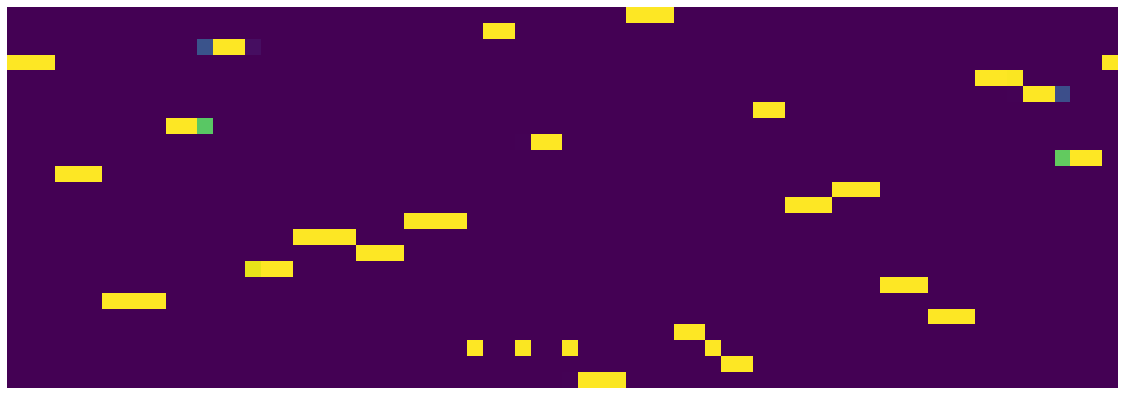

24 538 0.4609999999999995 0.4758541649207473


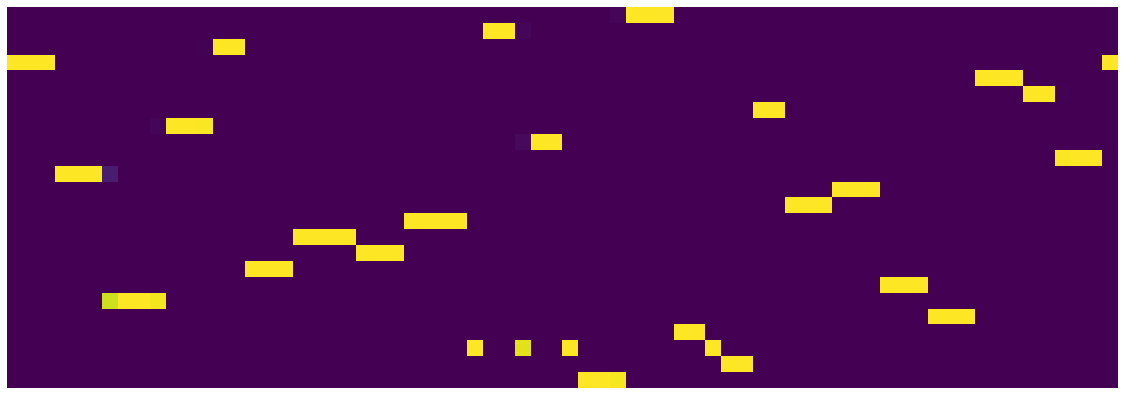

24 539 0.4599999999999995 0.47658134028315546


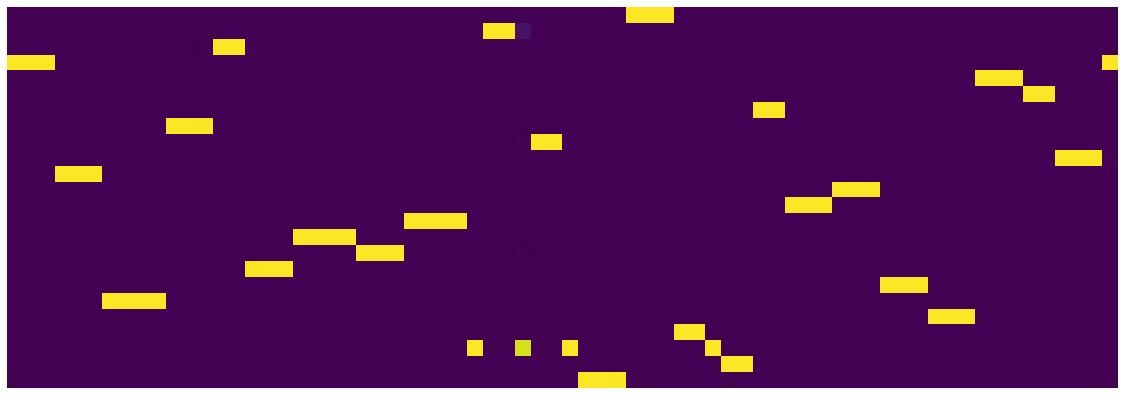

24 540 0.4589999999999995 0.4772384660318494


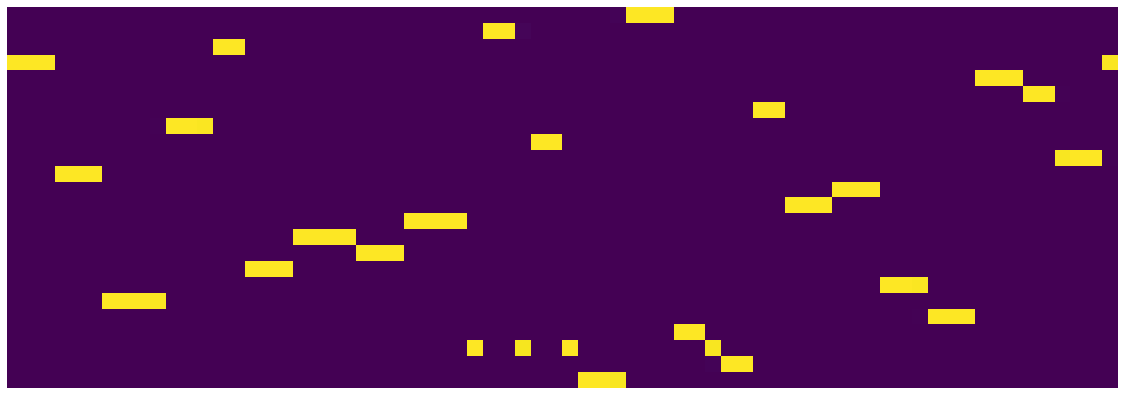

24 541 0.4579999999999995 0.4768487401306629


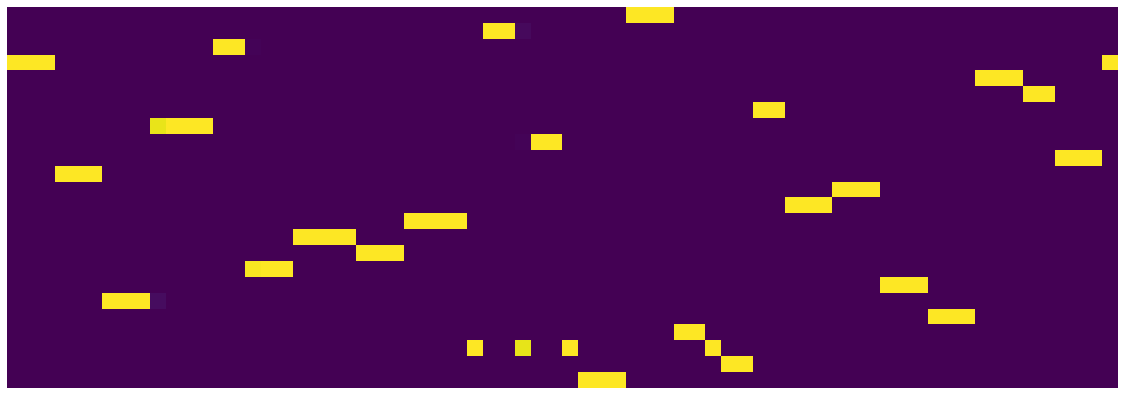

24 542 0.4569999999999995 0.4771603183820844


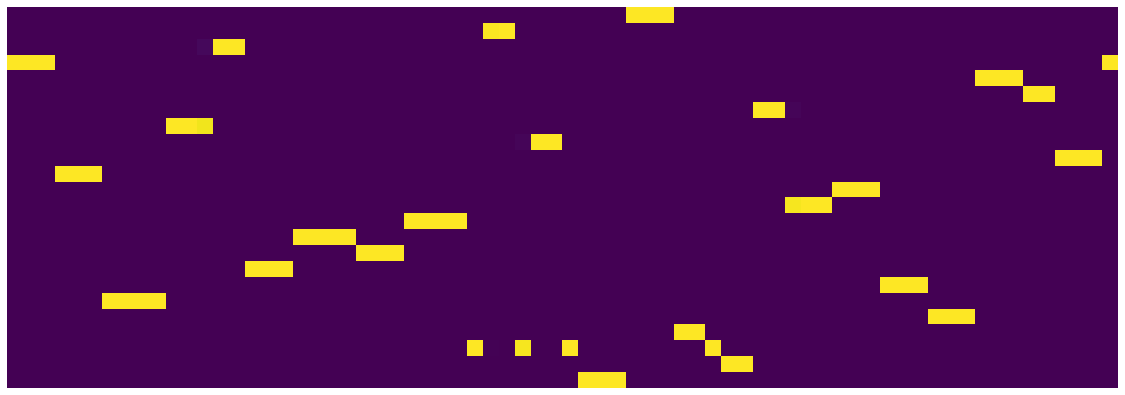

24 543 0.4559999999999995 0.47810889445245264


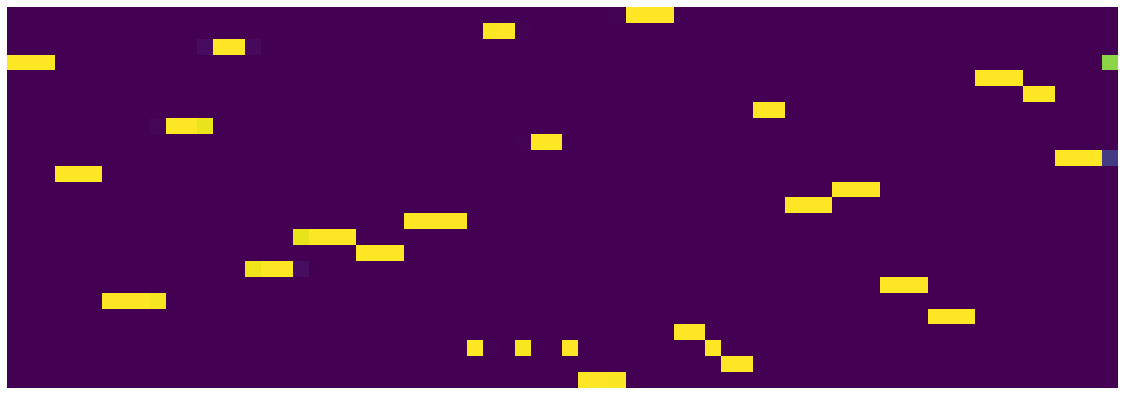

24 544 0.4549999999999995 0.4767099810764194


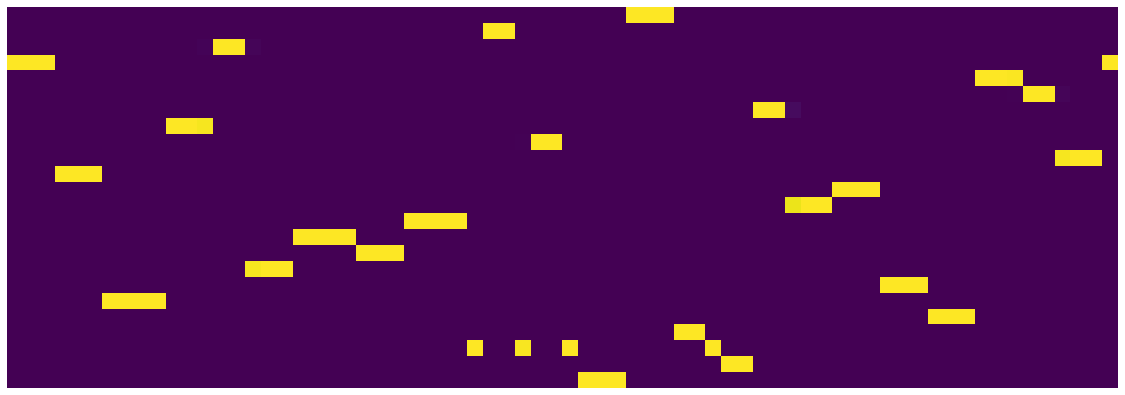

24 545 0.4539999999999995 0.47641245648264885


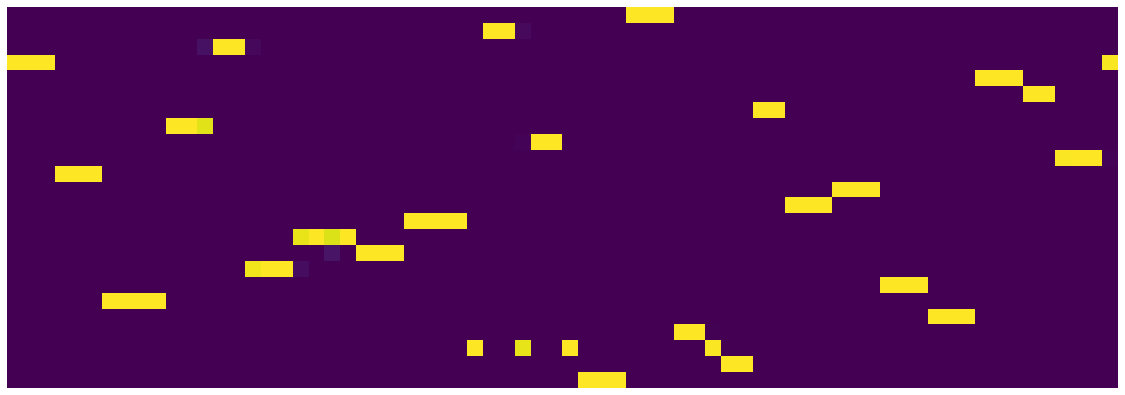

24 546 0.4529999999999995 0.47615892458707093


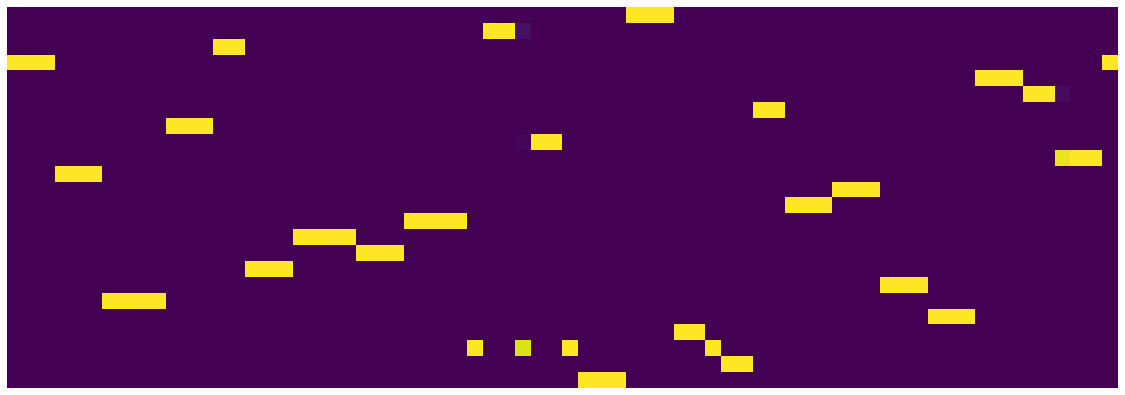

24 547 0.4519999999999995 0.47778836749494075


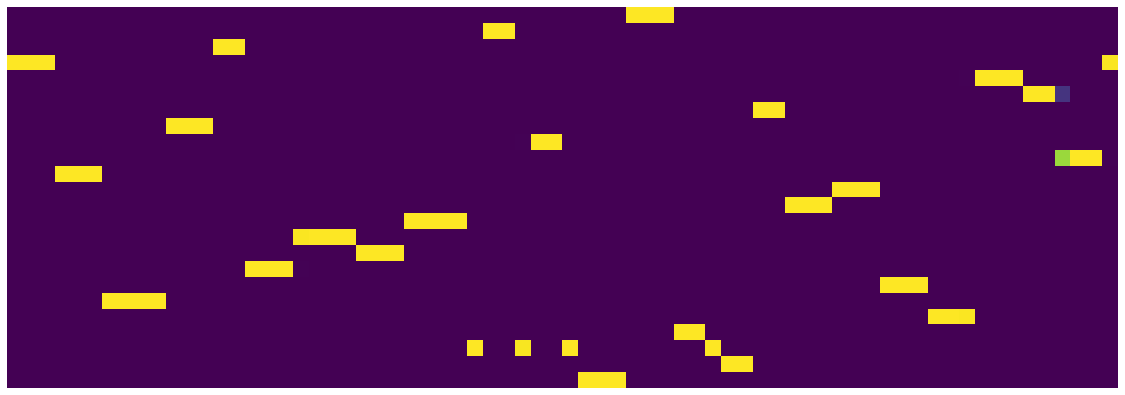

24 548 0.4509999999999995 0.47643575016409156


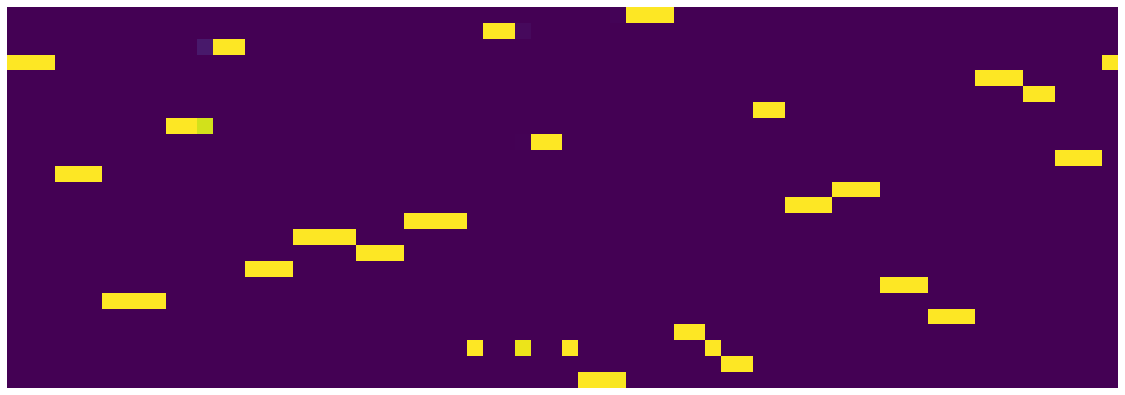

24 549 0.4499999999999995 0.47795267924666407


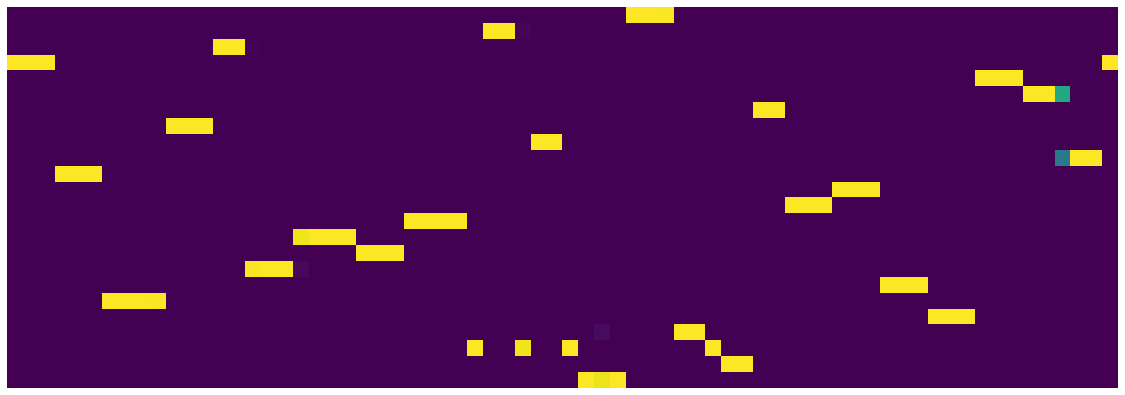

24 550 0.4489999999999995 0.47689441256225107


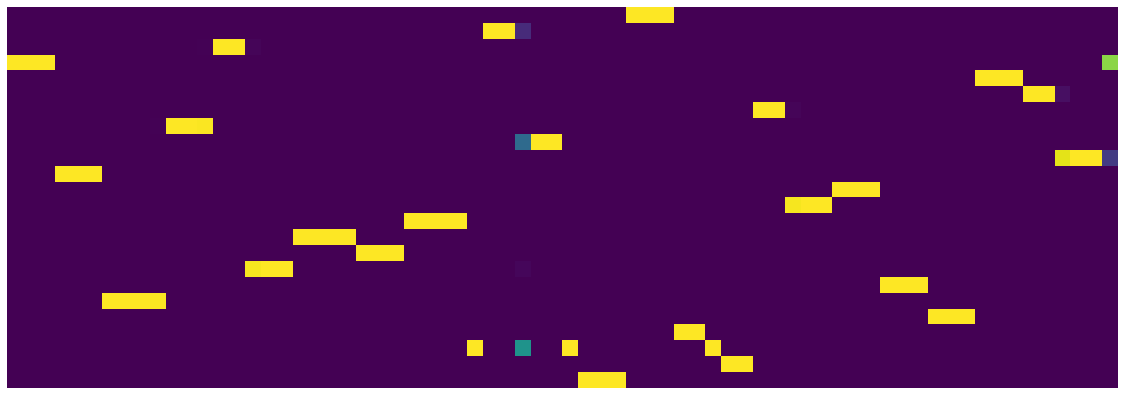

24 551 0.4479999999999995 0.47553229741752145


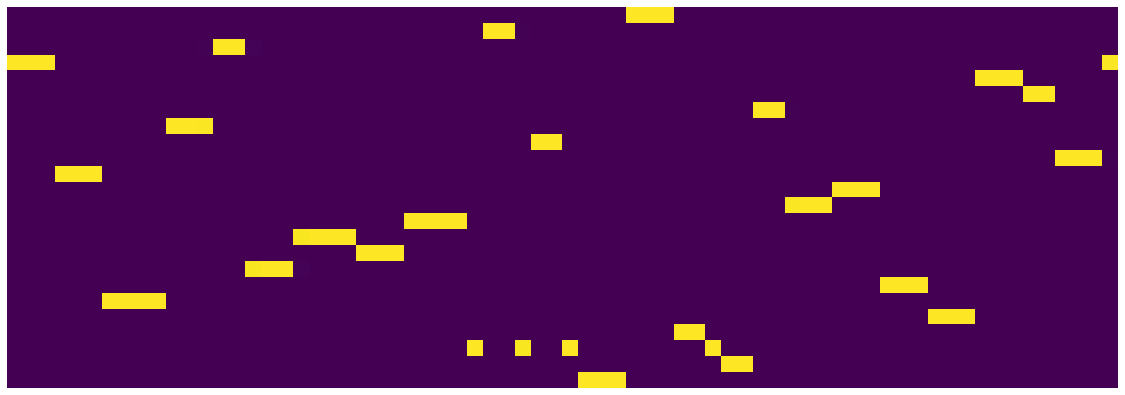

24 552 0.4469999999999995 0.47704754285514356


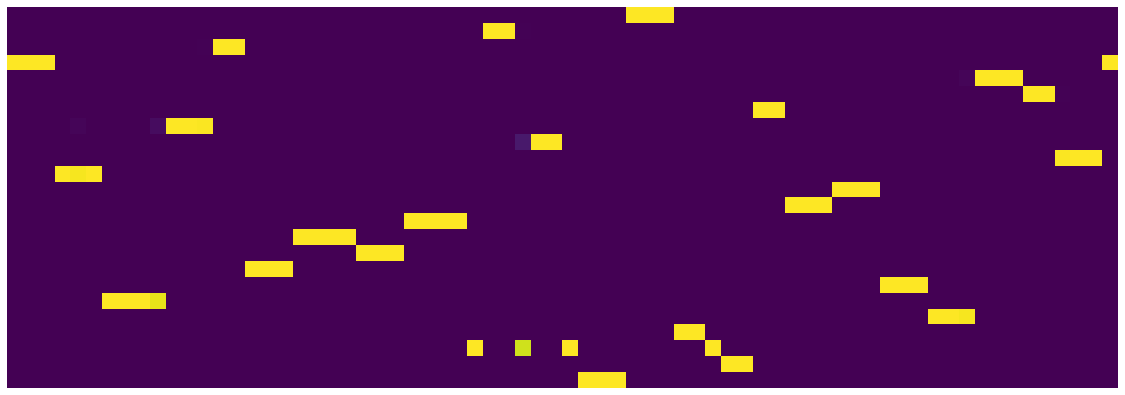

24 553 0.4459999999999995 0.4772568853572011


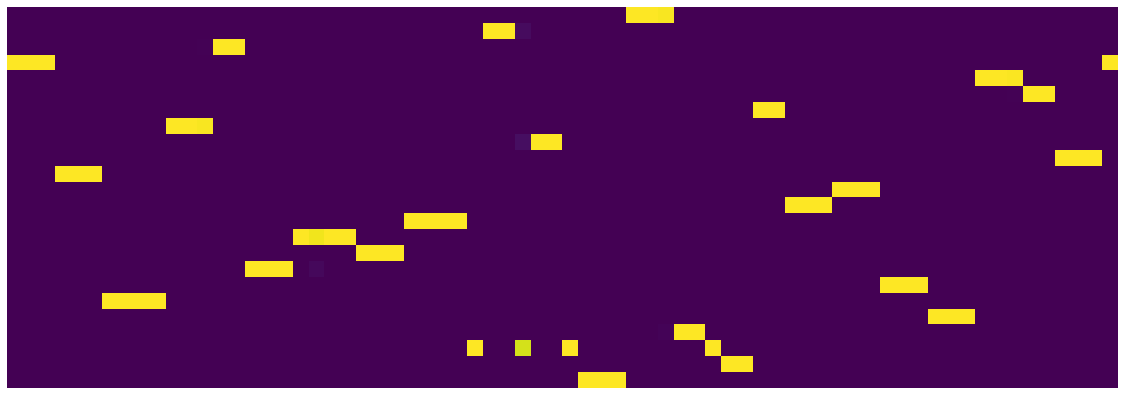

24 554 0.4449999999999995 0.477122956328094


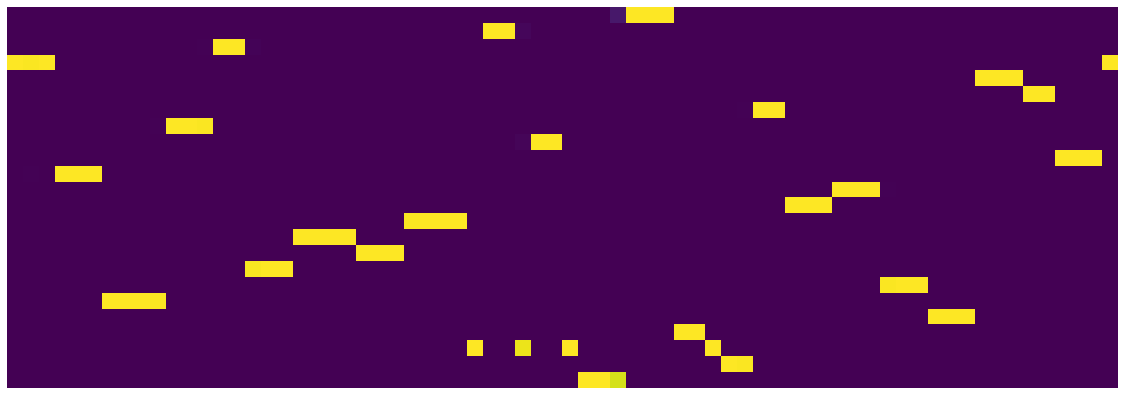

24 555 0.4439999999999995 0.4760797856375575


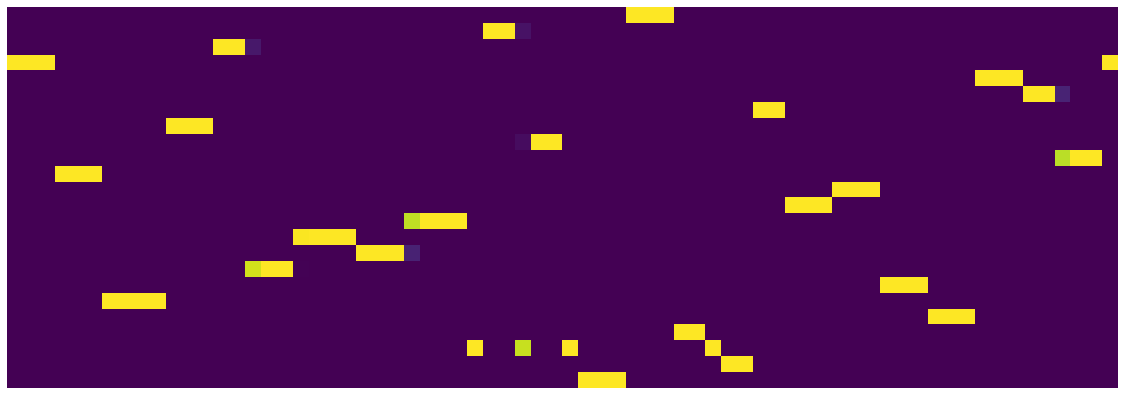

24 556 0.4429999999999995 0.4767939426004887


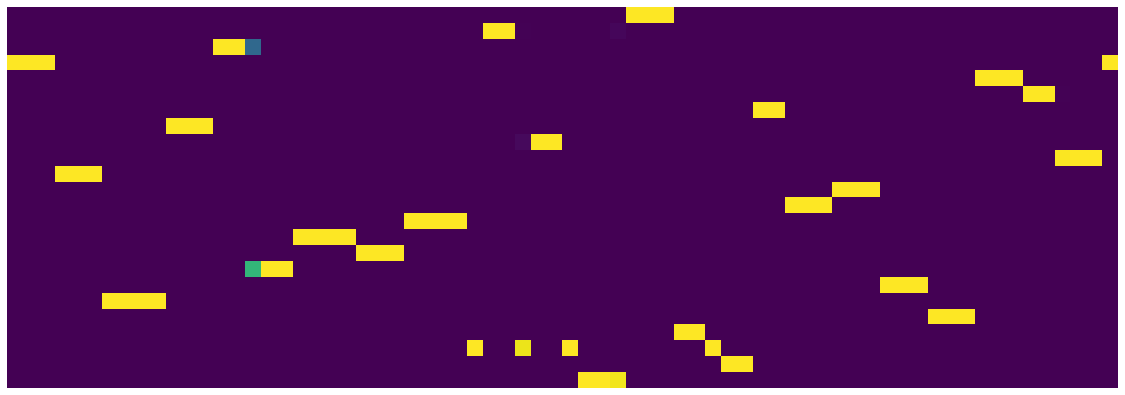

24 557 0.4419999999999995 0.4764567041769624


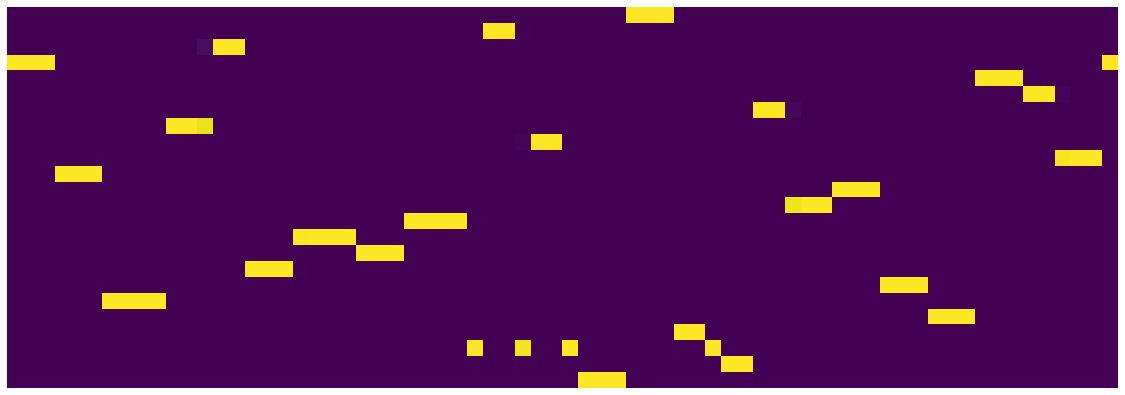

24 558 0.4409999999999995 0.4765668582171202


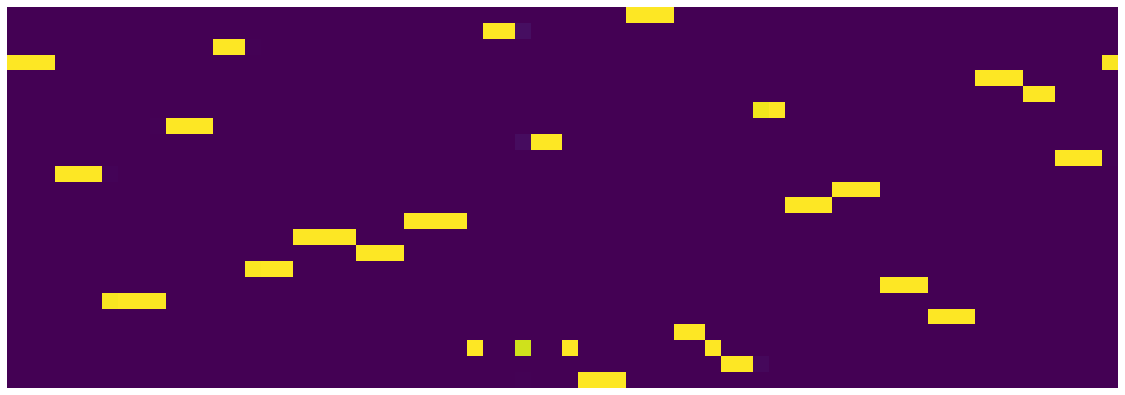

24 559 0.4399999999999995 0.47667953129857776


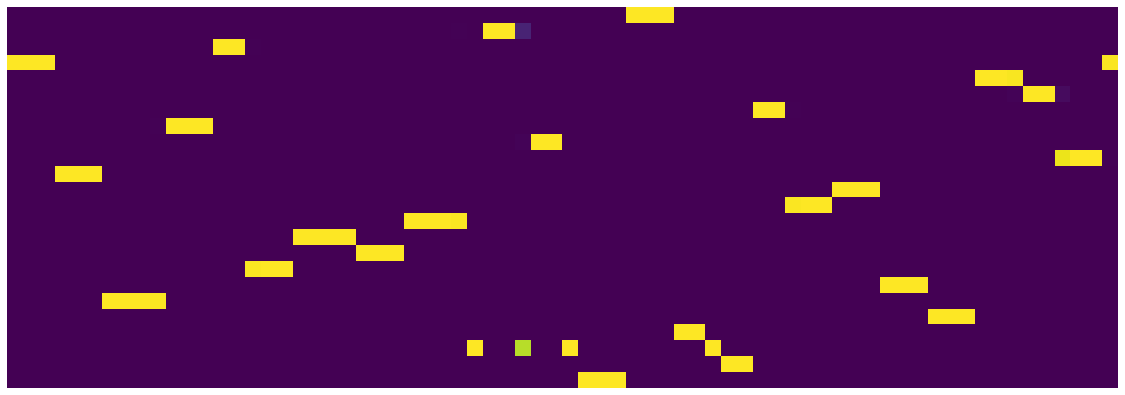

24 560 0.4389999999999995 0.47604482602328063


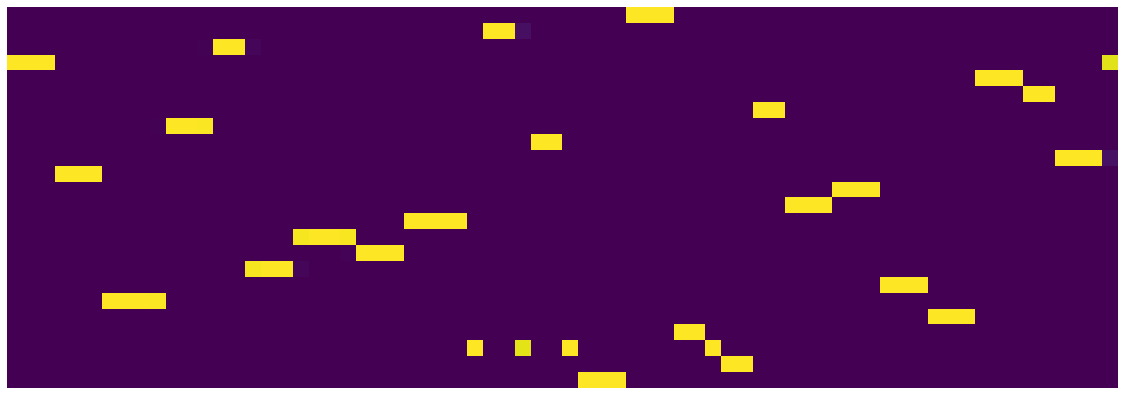

24 561 0.4379999999999995 0.4765703337267041


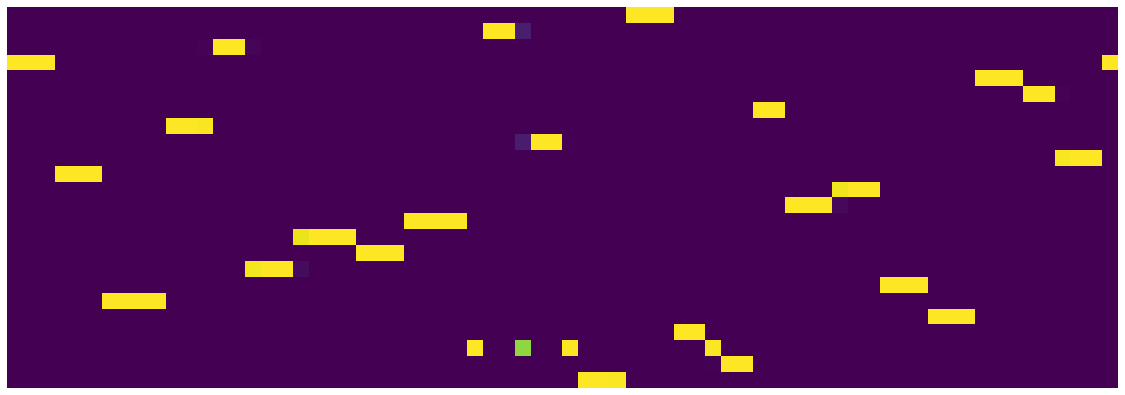

24 562 0.4369999999999995 0.477687137760222


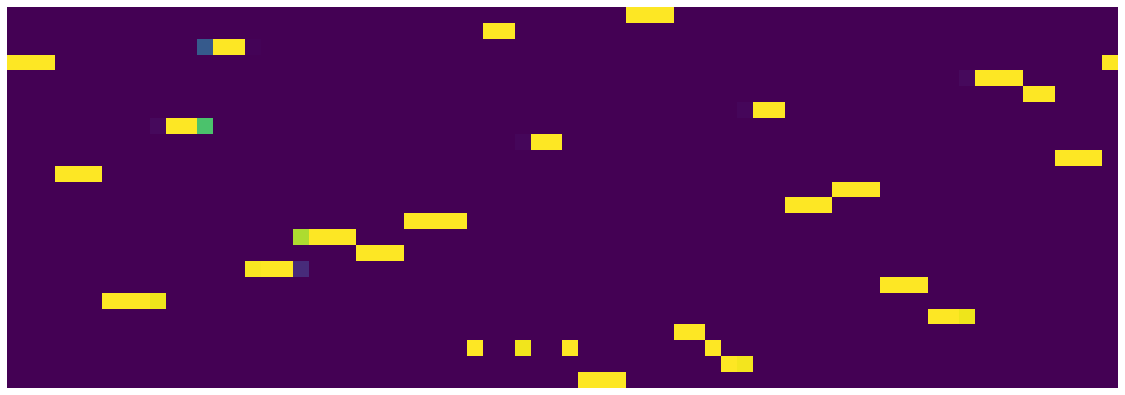

24 563 0.4359999999999995 0.47697399780154226


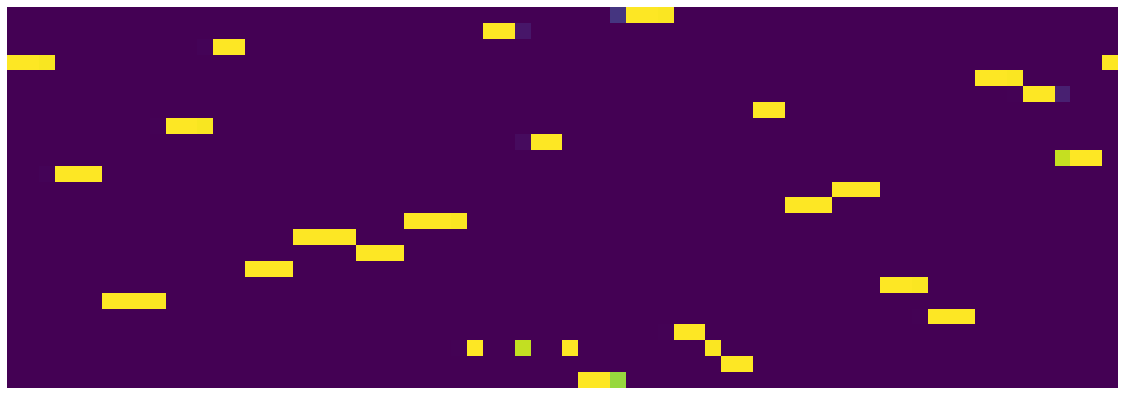

24 564 0.4349999999999995 0.4772509528324008


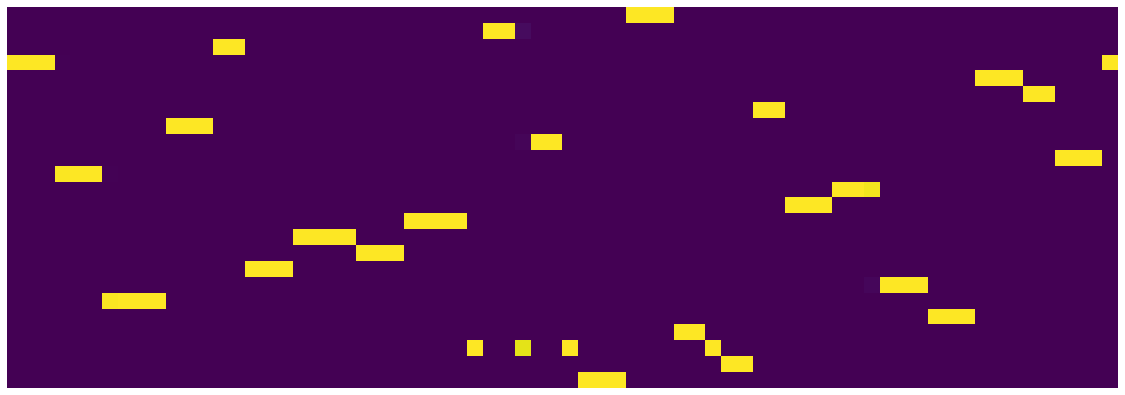

24 565 0.4339999999999995 0.4765461549162865


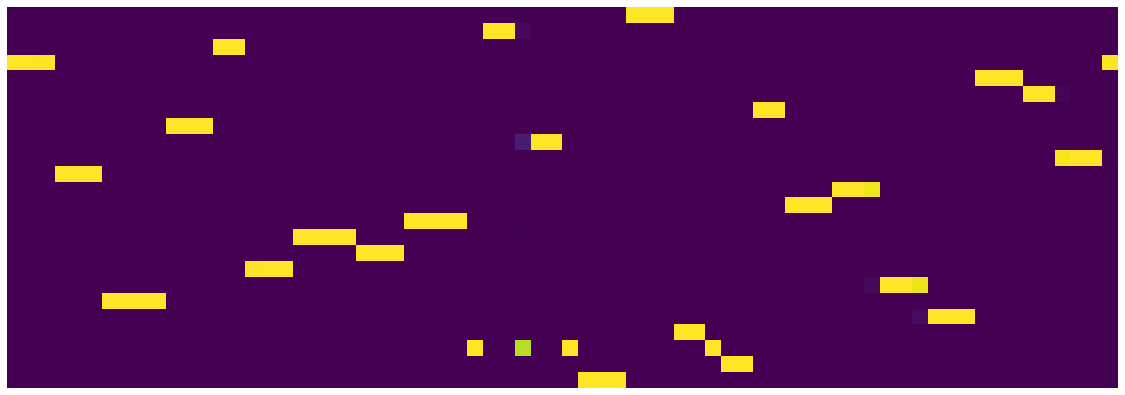

24 566 0.4329999999999995 0.4764040667563677


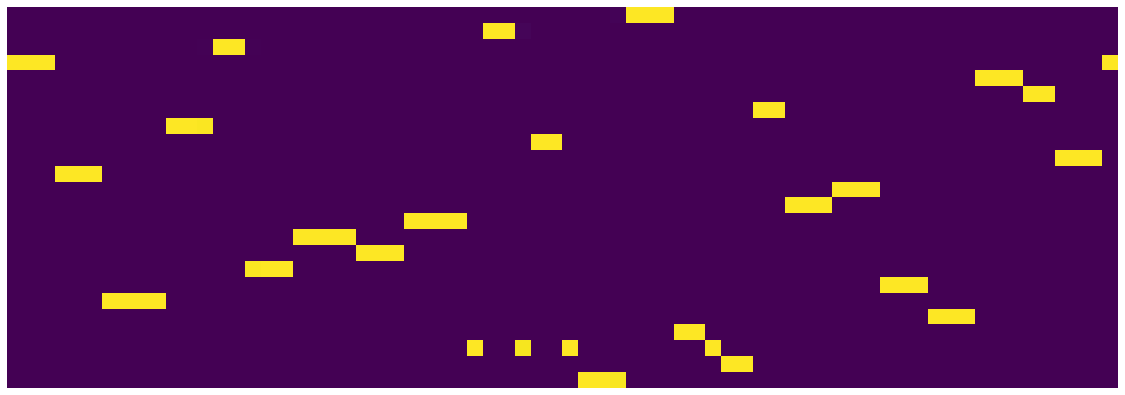

24 567 0.4319999999999995 0.4771976197138429


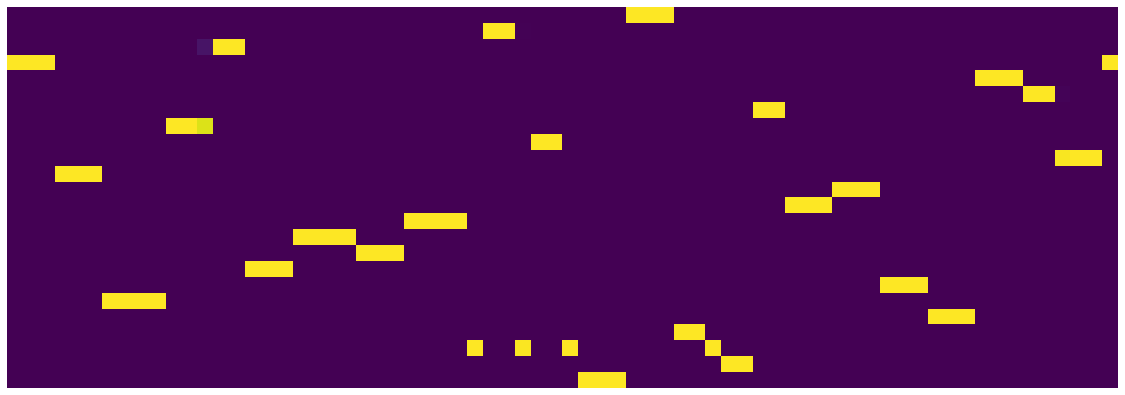

24 568 0.4309999999999995 0.4769096616655588


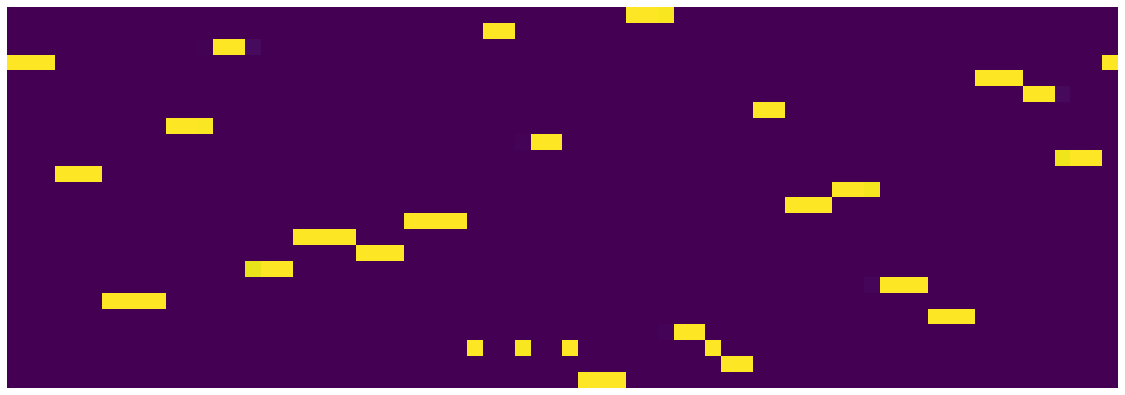

24 569 0.4299999999999995 0.4784599574282765


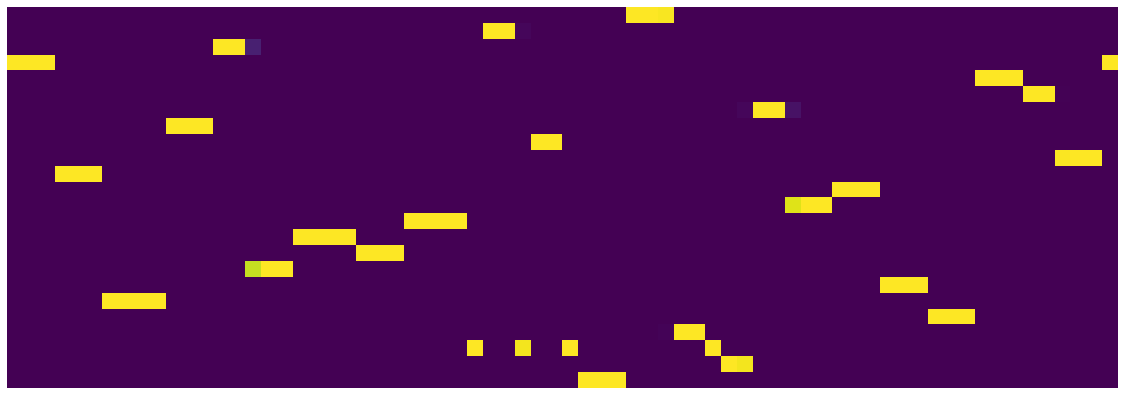

24 570 0.4289999999999995 0.47610113192349673


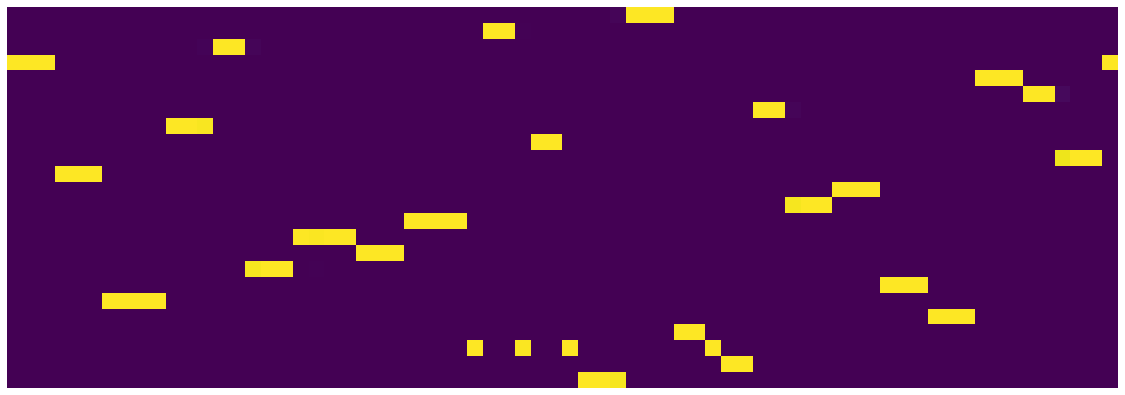

24 571 0.4279999999999995 0.4771196061745286


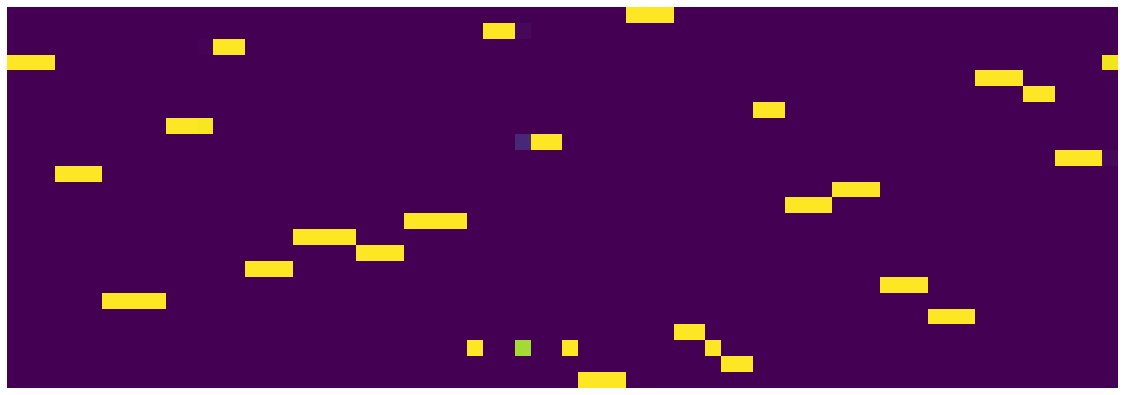

24 572 0.4269999999999995 0.4755982970818877


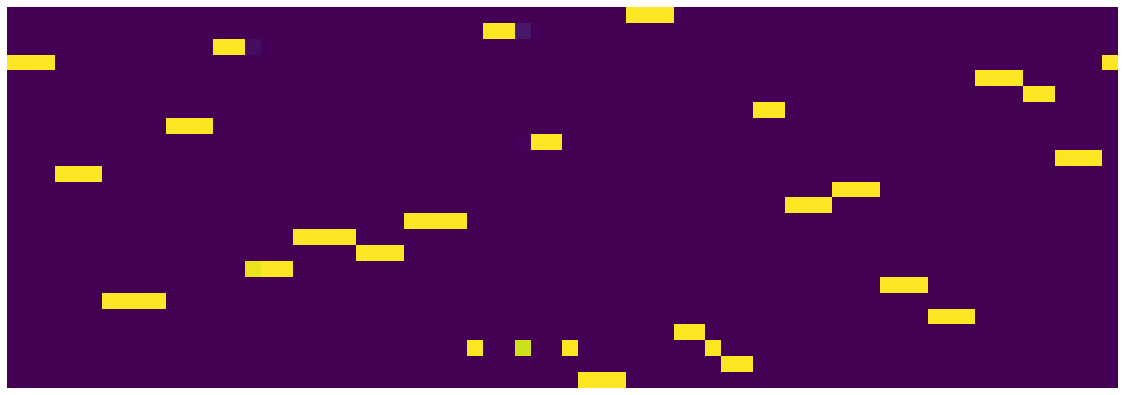

24 573 0.4259999999999995 0.47732218224555256


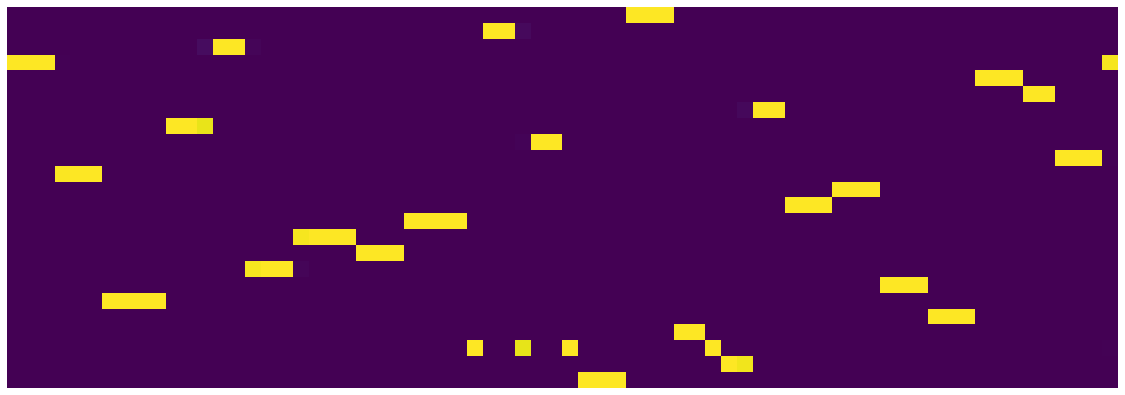

24 574 0.4249999999999995 0.4768104819580913


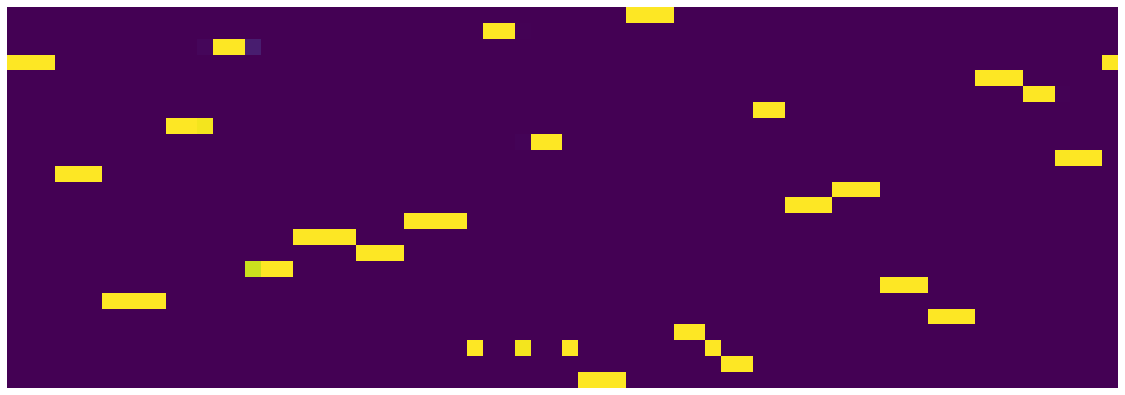

24 575 0.4239999999999995 0.4763949166983366


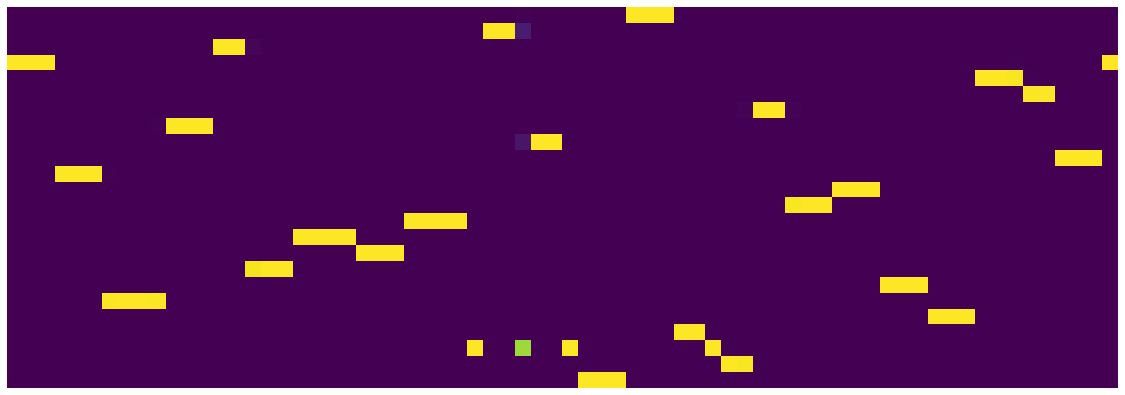

24 576 0.4229999999999995 0.47678834926337005


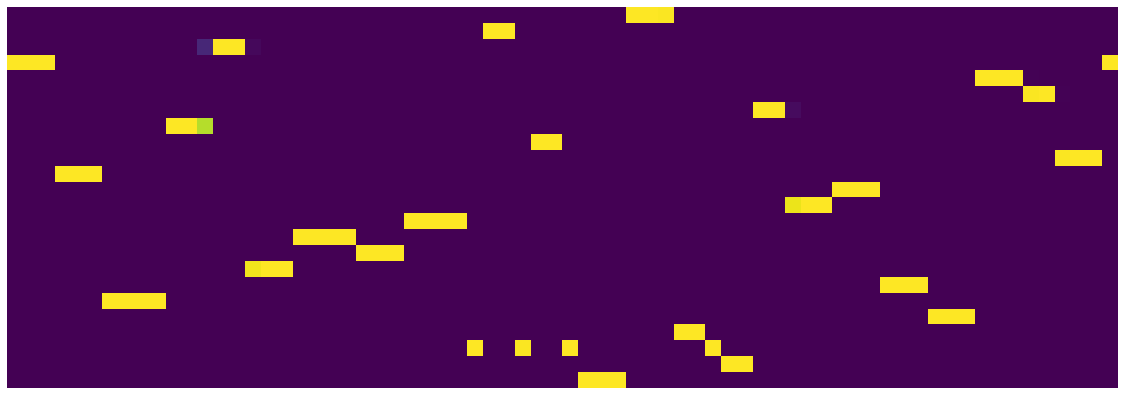

24 577 0.4219999999999995 0.47565997336059807


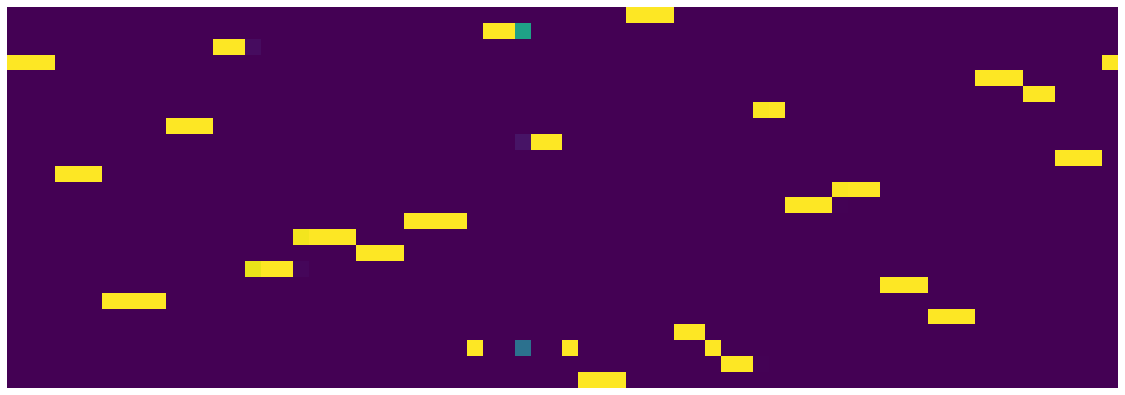

24 578 0.4209999999999995 0.47656601555645467


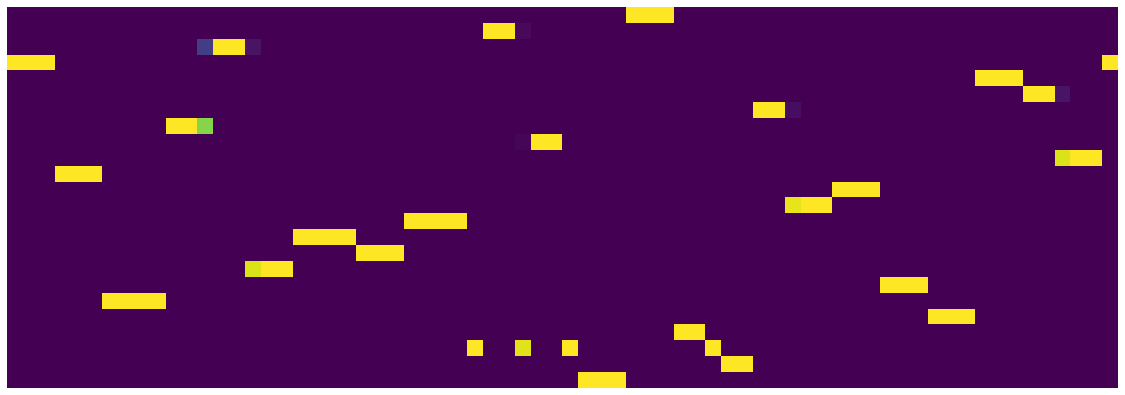

24 579 0.4199999999999995 0.47749781180173156


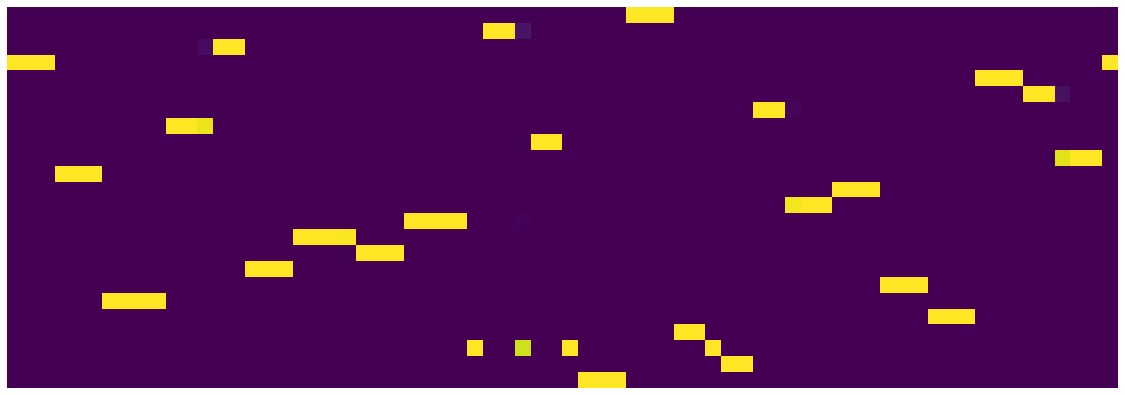

24 580 0.4189999999999995 0.4765760127454996


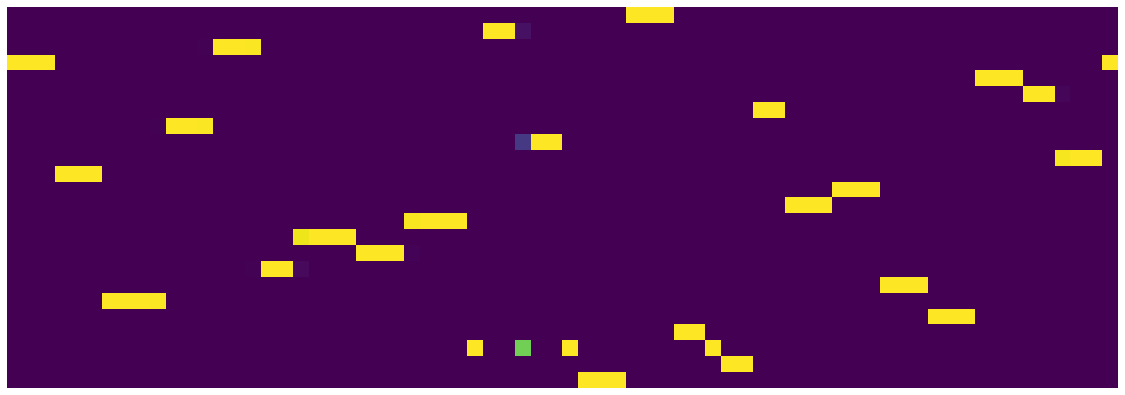

24 581 0.4179999999999995 0.4764086054638028


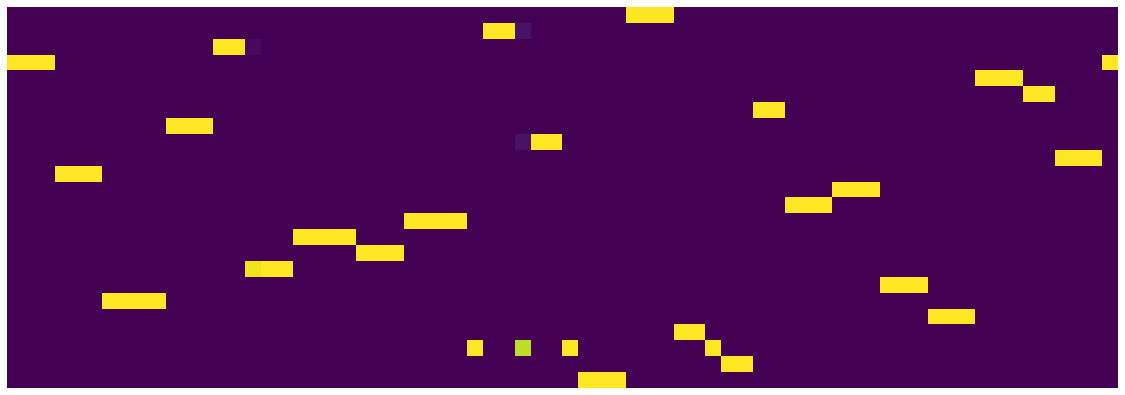

24 582 0.4169999999999995 0.4764826027676463


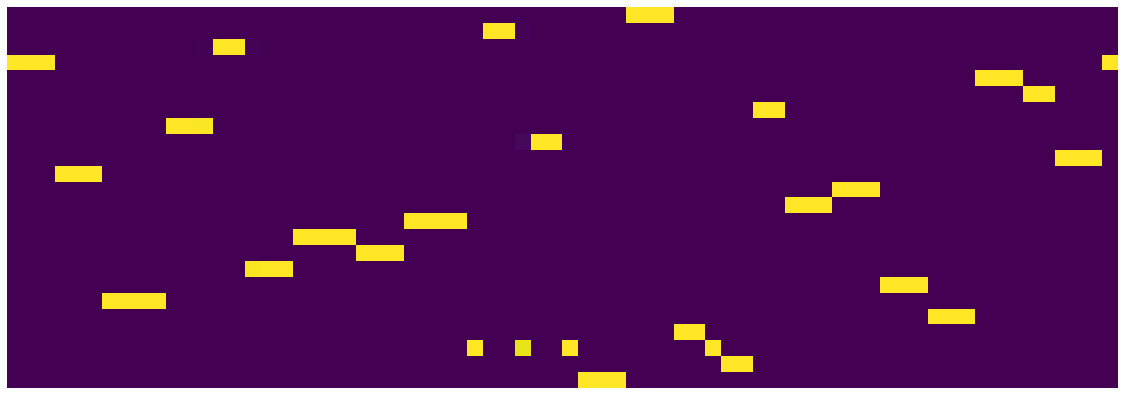

24 583 0.4159999999999995 0.4773315040394664


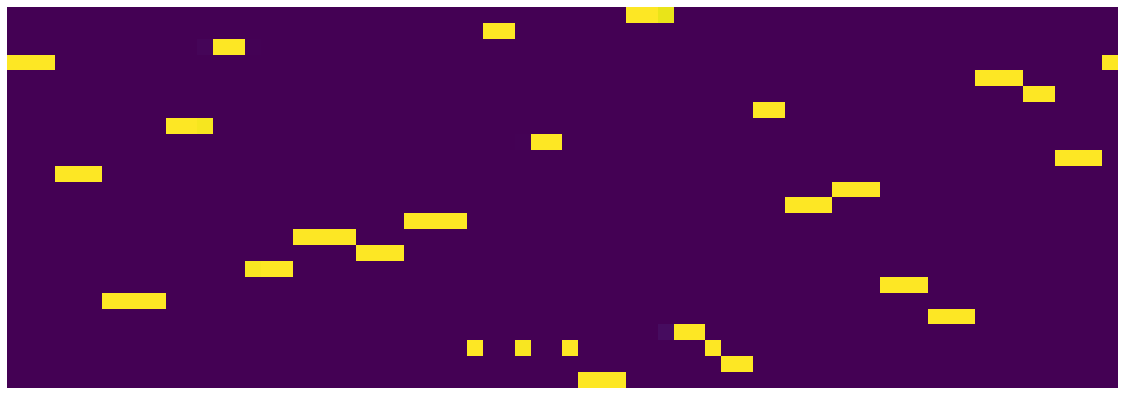

24 584 0.4149999999999995 0.47644738517701624


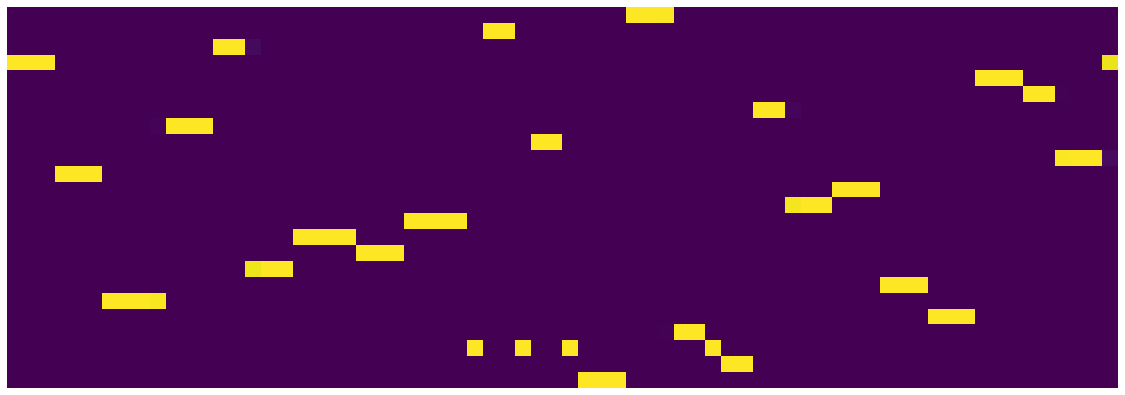

24 585 0.4139999999999995 0.4764438109472394


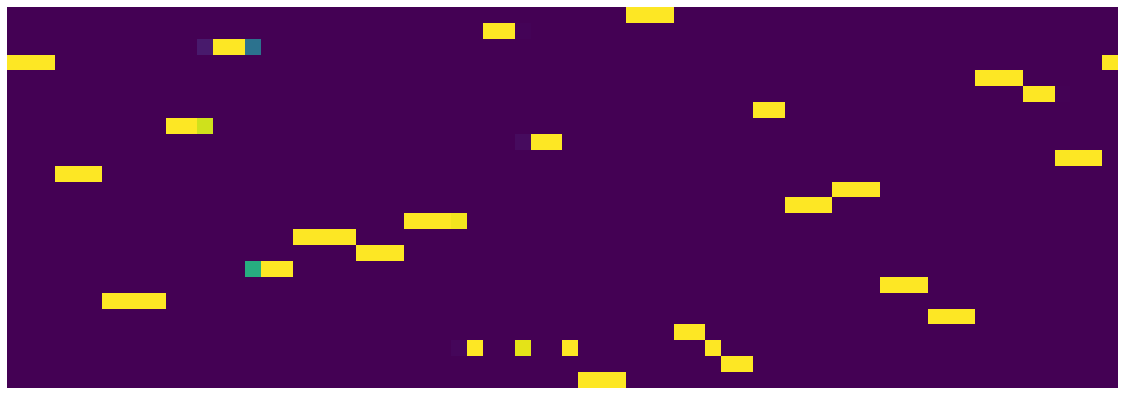

24 586 0.4129999999999995 0.47680118419229983


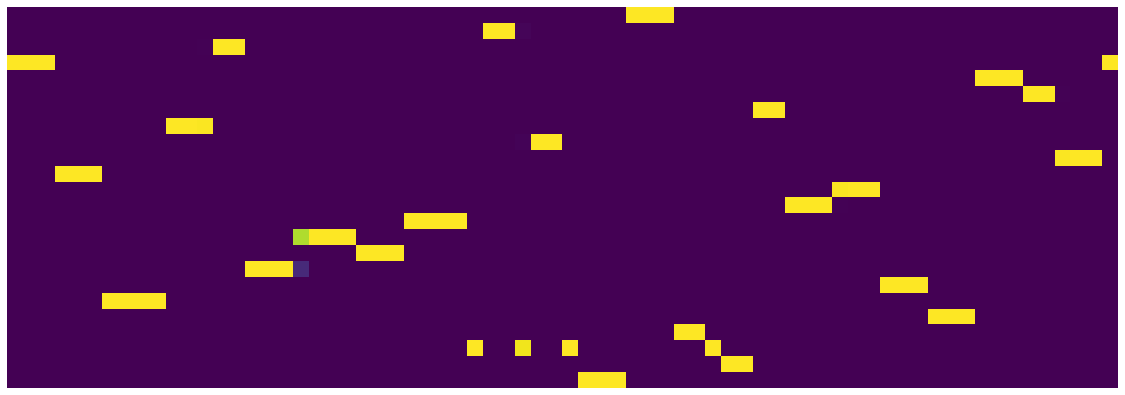

24 587 0.4119999999999995 0.4764292610809207


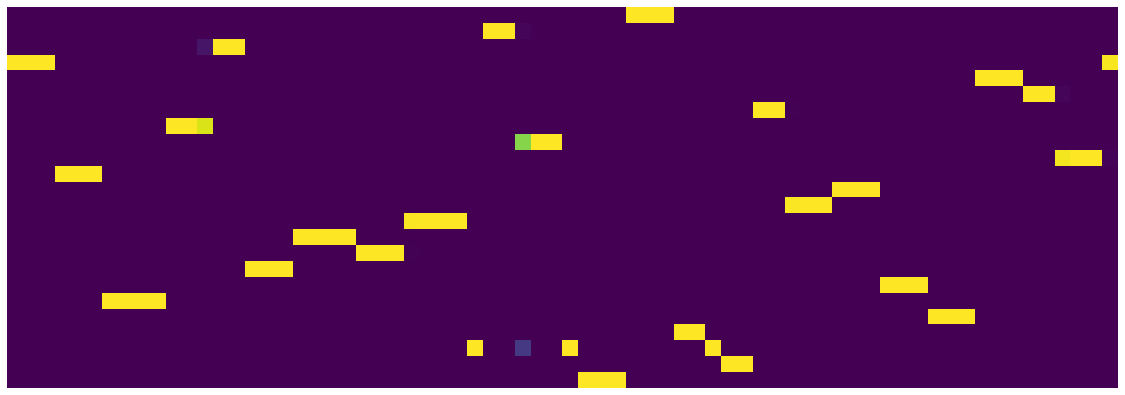

24 588 0.4109999999999995 0.4776130514219403


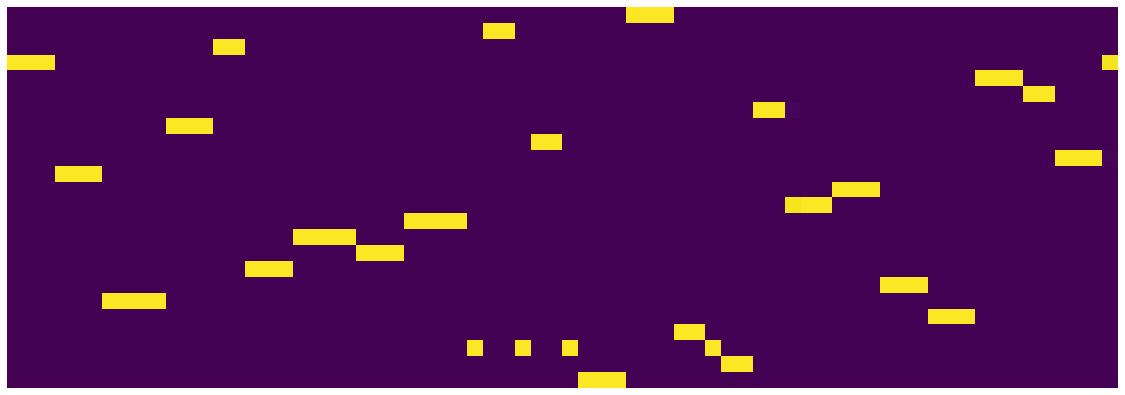

24 589 0.4099999999999995 0.47729448080062864


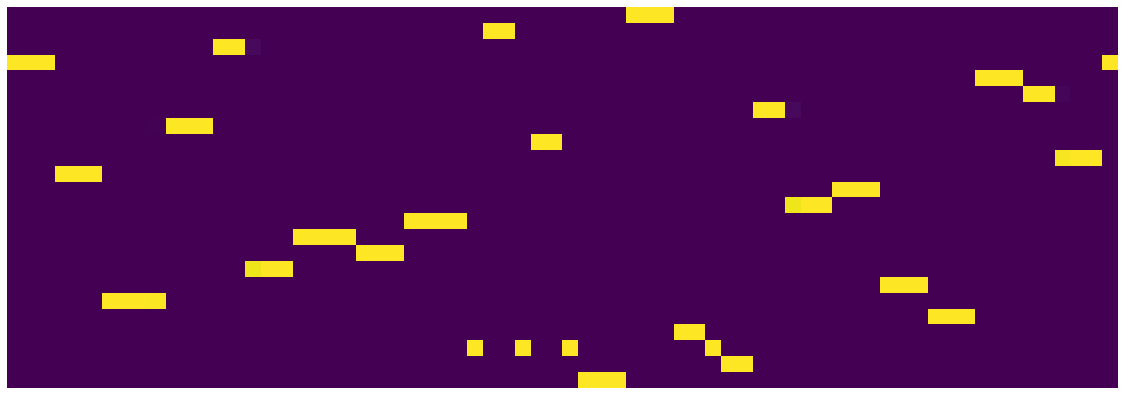

24 590 0.4089999999999995 0.4775186933577061


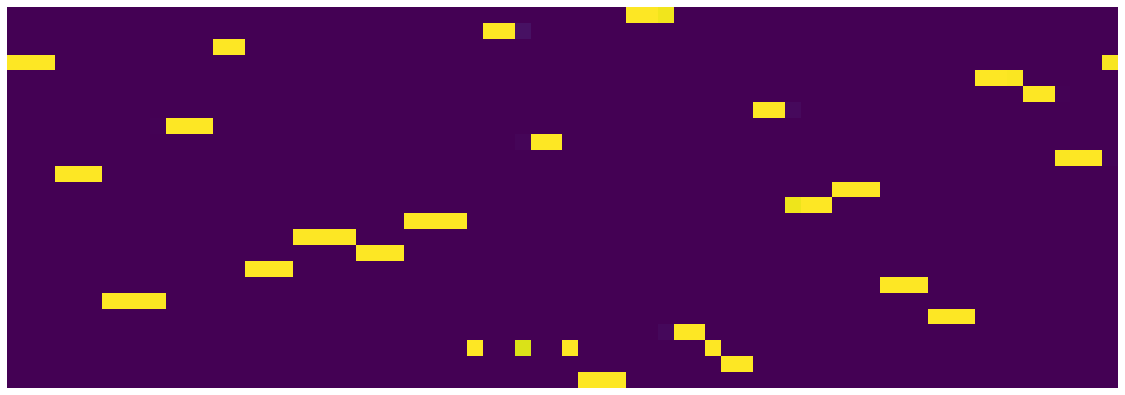

24 591 0.4079999999999995 0.47595240119844673


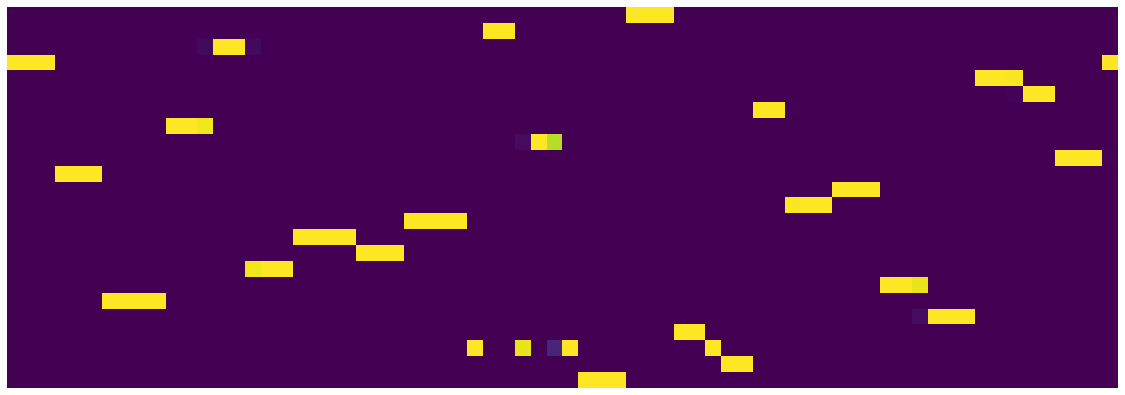

24 592 0.4069999999999995 0.4780190890654922


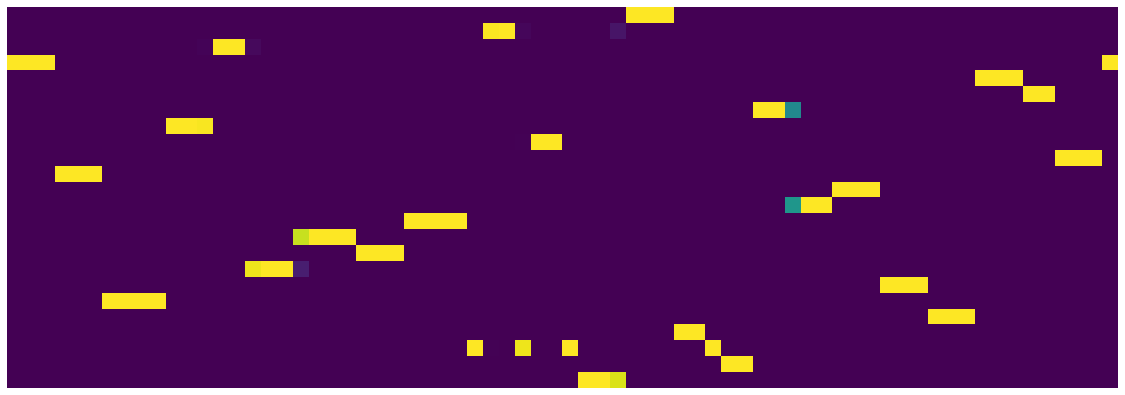

24 593 0.4059999999999995 0.4782351166009903


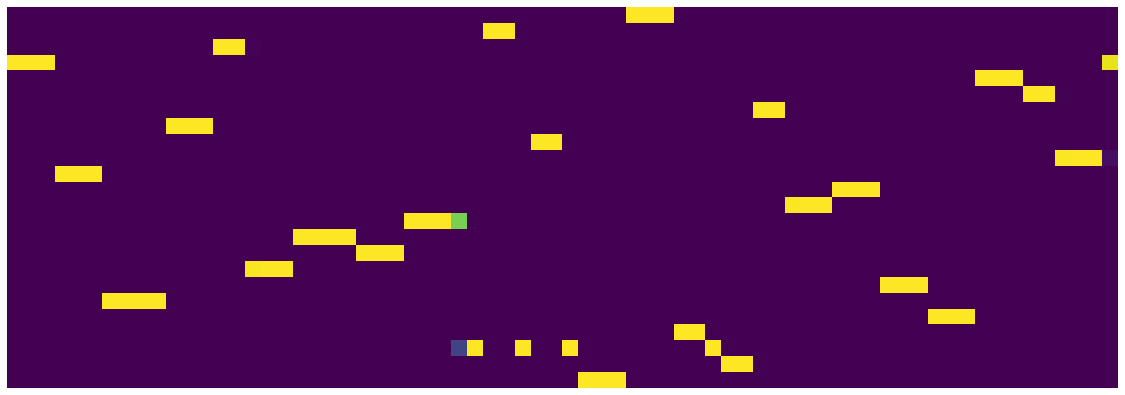

24 594 0.40499999999999947 0.47703639660030606


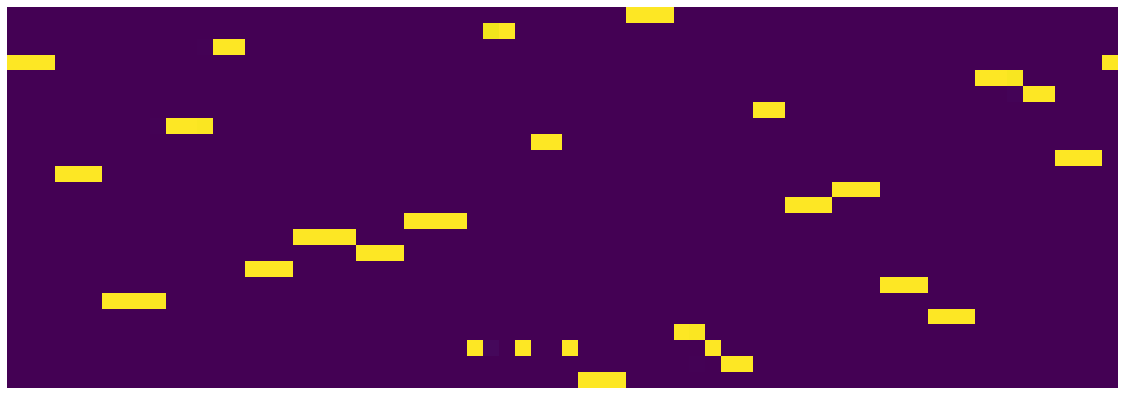

24 595 0.40399999999999947 0.4768266474828124


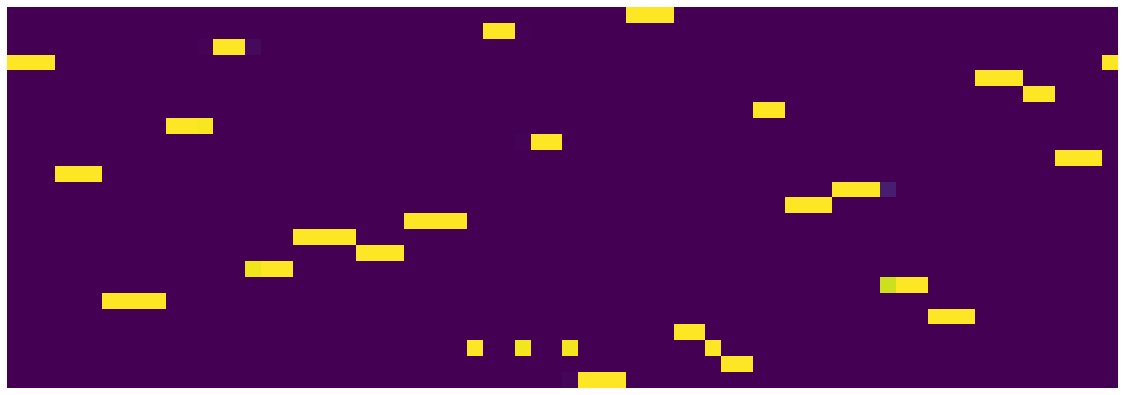

24 596 0.40299999999999947 0.47693846970796583


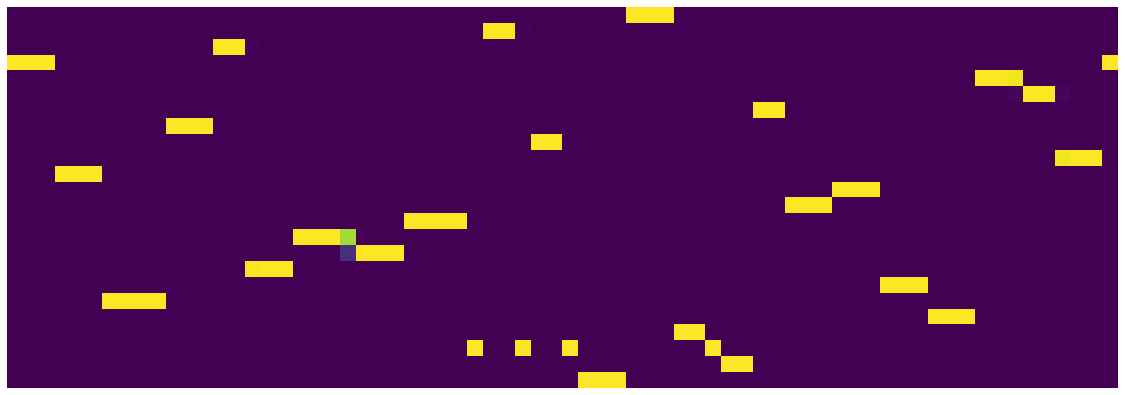

24 597 0.40199999999999947 0.4762649776414037


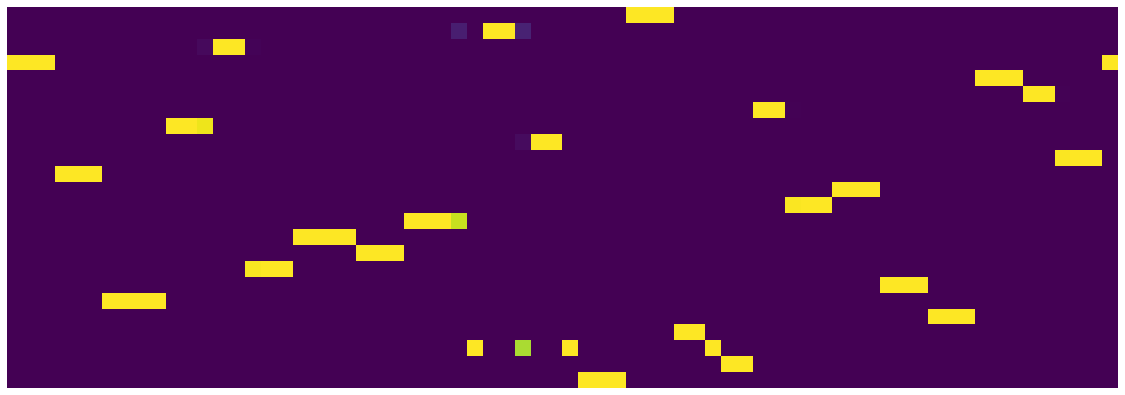

24 598 0.40099999999999947 0.4769640676677227


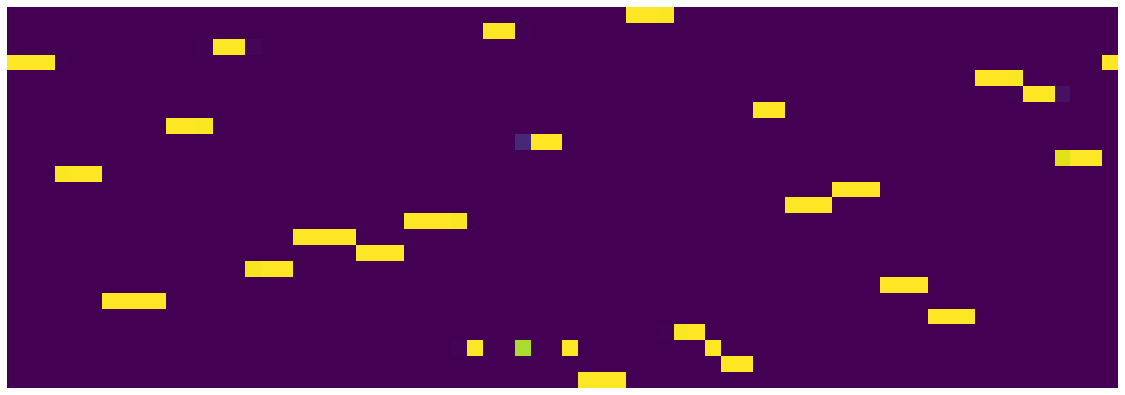

24 599 0.39999999999999947 0.47639065310359


In [7]:
# Define the latent CG dimension, feel free to set your own, it only needs to be smaller than the number of total atoms 

device = "cuda" # device cardinal

#Risoluzione CG che si vuole impiegare
N_CG = [6, 12, 18, 24]  
#Volori di Rho per ogni ricoluzione CG
RHO = [1*10**(-5), 7*10**(-6), 1*10**(-6), 7*10**(-7)]



#Ciclo che si ripete per ogni risoluzione CG
for N_cg, rho in zip(N_CG, RHO):
    #viene inizializzato l'AE
    ae = cgae(train_xyz.shape[1], N_cg).to(device)
    #Viene impostato l'optimizer
    optimizer = torch.optim.Adam(list(ae.parameters()), lr=4e-3)
    #Inizializzazione della temperatura
    tau = 1.0

    #Liste contenenti i valori delle loss per ogni epoca
    loss_log = []
    loss_ae_log = []
    loss_fm_log = []
    mean_force_log =[]

    #Ciclo del training, 600 epoche
    for epoch in range(600):

        loss_epoch = 0.0  
        loss_ae_epoch = 0.0
        loss_fm_epoch = 0.0
        mean_force_epoch = 0.0

        #Ciclo sulle batch
        for i, xyz in enumerate(trainloader):

            # recenter xyz 
            xyz = xyz[0].to(device)

            # encode and decode coordinates 
            xyz, xyz_recon, M, M_norm, cg_xyz = ae(xyz, tau)
            
            
            #regularization instant forces
            f0 = torch.Tensor(train_f[i]).to(device)
            f  = torch.einsum('bij,in->bnj', f0, M_norm)
            mean_force = f.pow(2).sum(2).mean()

            # comput reconstruction 
            loss_ae =  (xyz - xyz_recon).pow(2).mean() 
            loss_fm = rho*mean_force


            # total loss 
            if epoch >= 300:
                loss = loss_ae + loss_fm
            else:
                loss = loss_ae

            
            #parameter update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #losses update
            loss_epoch += loss.item()
            loss_ae_epoch += loss_ae.item()
            loss_fm_epoch += loss_fm.item()
            mean_force_epoch += mean_force.item()

        #losses normalization
        loss_epoch = loss_epoch/xyz.shape[0]
        loss_ae_epoch = loss_ae_epoch/xyz.shape[0]
        loss_fm_epoch = loss_fm_epoch/xyz.shape[0]

        #Vengono aggiunti i valori delle loss alle liste
        loss_log.append(loss_epoch)
        loss_ae_log.append(loss_ae_epoch)
        loss_fm_log.append(loss_fm_epoch)
        mean_force_log.append(mean_force_epoch)

        # temperature scheduler for gubmel softmax     
        if tau >= 0.1:
            tau -= 0.001
        
        #Salva la matrice dell'encoder   
        #torch.save(M, 'LANGEVIN/M/M_CG'+str(N_cg)+'_i.pt')
        
        #plot della matrice dell'encoder
        plt.figure(figsize=(16,8))
        plt.imshow(M.t().detach().cpu().numpy())
        plt.tight_layout()
        plt.axis('off')
        #plt.xlabel('Indice Atomi', fontsize = 18)
        #plt.ylabel('Indice Siti CG', fontsize = 18)
        #plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        #plt.tick_params(axis='y', which='both', bottom=False, top=False, labelbottom=False)
        plt.savefig('LANGEVIN/Images/M_CG'+str(N_cg)+'_'+str(epoch)+'.png')
        plt.show()
        
        print(N_cg ,epoch, tau, np.array(loss_epoch).mean())
        
    #save loss in txt
    #np.savetxt('LANGEVIN/Losses/loss_log_CG'+str(N_cg)+'.txt', loss_log)
    #np.savetxt('LANGEVIN/Losses/loss_ae_CG'+str(N_cg)+'.txt', loss_ae_log)
    #np.savetxt('LANGEVIN/Losses/loss_fm_CG'+str(N_cg)+'.txt', loss_fm_log)
    
    # visualize the learned CG assignment 
    #torch.save(M, 'LANGEVIN/M/M_CG'+str(N_cg)+'_f.pt')
    #torch.save(xyz_recon, 'LANGEVIN/xyz_recon/xyz_recon_CG'+str(N_cg)+'.pt')
    #torch.save(cg_xyz, 'LANGEVIN/xyz_CG/CG'+str(N_cg)+'_xyz.pt')
    
    #plt.figure(figsize=(18,20))
    #plt.imshow(M.t().detach().cpu().numpy())
    #plt.savefig('LANGEVIN/Images/M_CG'+str(N_cg)+'_f'+'.png')
    #plt.show()
    
    #save model
    #torch.save(ae, 'LANGEVIN/Models/ae_CG'+str(N_cg)+'.pth')
    
    